In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from glob import glob
import sys
import torch
from tqdm import tqdm
import pdb

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from dca_research.cov_util import calc_mmse_from_cross_cov_mats
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

In [4]:
sys.path.append('/home/akumar/nse/neural_control')

In [5]:
from loaders import load_sabes, load_peanut, load_cv
from utils import apply_df_filters
from consolidation import consolidate_dimreduc

### LQG spectrum

In [6]:
# Return the full LQG spectrum rather than just the trace
def get_LQG_spectrum(ccm_fwd, ccm_rev, V):
    project_mmse=False
    mmse_fwd = calc_mmse_from_cross_cov_mats(ccm_fwd, V, project_mmse=project_mmse)    

    # Key change 06/28/22: In the reverse time direction, the readout is taken to be y = C Pi x_a = C x. 
    # This is implemented here by scaling Vlag by ccm_fwd[0]
    Vrev = torch.matmul(ccm_fwd[0], V)
    mmse_rev = calc_mmse_from_cross_cov_mats(ccm_rev, Vrev, project_mmse=project_mmse)

    return np.linalg.eigvals(mmse_fwd @ mmse_rev)

In [3]:
# Across projection dimensions, calculate the LQG spectrum, rather than just taking the trace.
# Fit a state space model to the dynamics, caclculte the LQG controller parameters, and then show evolution of various LQG related loss
# functions as one truncates the filter order

In [7]:
fls_ = glob('/mnt/Secondary/data/sabes/*.mat')

good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

# Filter by the loco files we want to use
fls = []
for f in fls_:
    if 'indy' in f:
        fls.append(f)
    elif f.split('/')[-1] in good_loco_files:
        fls.append(f)

In [72]:
spec_full = []
for fl in tqdm(fls):
    dat = load_sabes(fl)

    X = np.squeeze(dat['spike_rates'])

    lqgmodel = LQGCA(T=4)
    lqgmodel.estimate_data_statistics(X)

    s = get_LQG_spectrum(lqgmodel.cross_covs.float(), lqgmodel.cross_covs_rev.float(), torch.eye(X.shape[1]).float())
    spec_full.append(s)

100%|██████████| 35/35 [04:11<00:00,  7.18s/it]


In [73]:
[np.sum(s)/s.size for s in spec_full]

[0.8527977522029433,
 0.9048511135962701,
 0.9273077427655801,
 0.8408111981897546,
 0.9337591270490878,
 0.9509454314241704,
 0.8184287227801422,
 0.8138201720732495,
 0.8316819096954775,
 0.8202723627505095,
 0.8201636642706199,
 0.8367185119196032,
 0.8415643176893248,
 0.8630679281134355,
 0.8520217664314039,
 0.8459631558122306,
 0.8467134915865384,
 0.8376592889532343,
 0.8455633119095204,
 0.8477876036317198,
 0.8861344211785368,
 0.8305467709090358,
 0.862694573780847,
 0.8839998747173109,
 0.8677368779336253,
 0.8594887222068898,
 0.8789774576822916,
 0.887050683947577,
 0.938709615803451,
 0.953268624685861,
 0.9398571224663201,
 0.9450412901107874,
 0.940306689857778,
 0.9120771789550781,
 0.9495771789550781]

In [29]:
lqgspec = [np.sort(s)[::-1][0:90] for s in spec]

In [30]:
lqgspec = np.array(lqgspec)

In [31]:
lqgspec.shape

(35, 90)

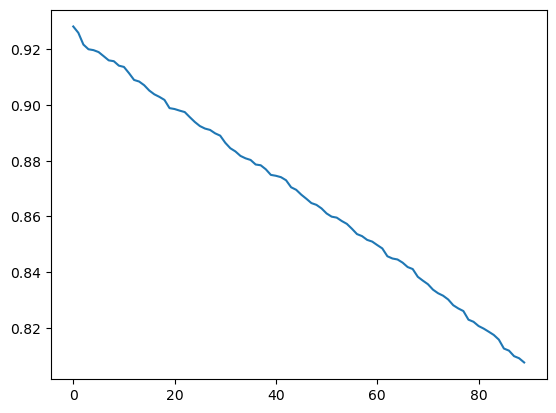

In [43]:
plt.plot(lqgspec[7, :])

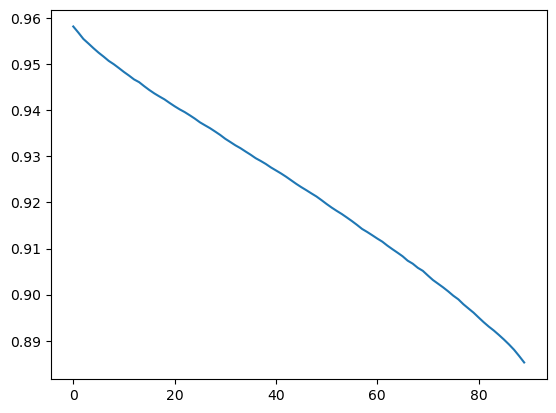

In [32]:
plt.plot(np.mean(lqgspec, axis=0))

In [ ]:
# This is a bit surprising. What does the spectrum look like at d = 30?

In [46]:
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    indy_df = pickle.load(f)
indy_df = pd.DataFrame(indy_df)

with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files)        
sabes_df = pd.concat([loco_df, indy_df])

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [50]:
spec = []
for fl in tqdm(fls):
    dat = load_sabes(fl)

    X = np.squeeze(dat['spike_rates'])

    lqgmodel = LQGCA(T=4)
    lqgmodel.estimate_data_statistics(X)

    df = apply_df_filters(sabes_df, data_file=fl.split('/')[-1], fold_idx=0, dim=30, dimreduc_method='LQGCA')
    assert(df.shape[0] == 1)

    V = torch.tensor(df.iloc[0]['coef']).float()

    s = get_LQG_spectrum(lqgmodel.cross_covs.float(), lqgmodel.cross_covs_rev.float(), V)
    print(np.trace(s))
    spec.append(s)


100%|██████████| 35/35 [04:20<00:00,  7.45s/it]


In [61]:
drspec = np.array([np.sort(s)[::-1][0:90] for s in spec])

In [71]:
[np.sum(s)/s.size for s in spec]

[0.9302895715994428,
 0.9498072798534106,
 0.9583637632172683,
 0.93353629912306,
 0.9566147644395773,
 0.9685624899323454,
 0.9215596896498951,
 0.9208069421294937,
 0.927000556193607,
 0.9229795483575352,
 0.9142729337098169,
 0.9274315800227172,
 0.9283711788428091,
 0.9398074902986225,
 0.9306289210464015,
 0.9327647242052802,
 0.9281823378342848,
 0.9279202547940341,
 0.9250709474548813,
 0.9272517491053868,
 0.9409841493118641,
 0.9190071165099625,
 0.9311123802548363,
 0.9401775828579015,
 0.9293467613958544,
 0.9319731118022532,
 0.9443334462691326,
 0.9419615372367527,
 0.9675638761451776,
 0.9733711722847465,
 0.9730437271238312,
 0.9746777378233139,
 0.9746793462426623,
 0.9702131652832031,
 0.9802337646484375]

In [ ]:
# This is suprisingly high dimensional

In [ ]:
# What about down to d=10?

### Scores

In [6]:
consolidate_dimreduc('/mnt/Secondary/data/sabes_dimreduc_highd', '/mnt/Secondary/data/postprocessed/sabes_highd_df.dat')
consolidate_dimreduc('/mnt/Secondary/data/peanut_dimreduc_highd', '/mnt/Secondary/data/postprocessed/peanut_highd_df.dat')
consolidate_dimreduc('/mnt/Secondary/data/cv_dimreduc_highd', '/mnt/Secondary/data/postprocessed/cv_highd_df.dat')

38
8
2


In [7]:
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

In [8]:
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

In [9]:
with open('/mnt/Secondary/data/postprocessed/sabes_highd_df.dat', 'rb') as f:
    sabes_df = pickle.load(f)
sabes_df = pd.DataFrame(sabes_df)

In [10]:
# What is the fraction of the asymptotic LQR cost attained?
dimvals = np.unique(sabes_df['dim'].values)
data_files = np.unique(sabes_df['data_file'].values)

fcca_scores = np.zeros((dimvals.size, data_files.size, 2))
pca_scores = np.zeros((dimvals.size, data_files.size, 2))

for i, data_file in enumerate(data_files):
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    X = np.squeeze(dat['spike_rates'])
    pcamodel = PCA().fit(X)
    pca_ambient = np.sum(pcamodel.explained_variance_)
    for j, d in enumerate(dimvals):
        df = apply_df_filters(sabes_df, data_file=data_file, dimreduc_method='LQGCA', dim=d)
        assert(df.shape[0] == 1)
        lqgmodel = LQGCA(T=3)
        lqgscore = lqgmodel.score(X=X, coef=df.iloc[0]['coef'])
        fcca_scores[j, i, 0] = lqgscore            
        lqgscore = lqgmodel.score(X=X, coef=pcamodel.components_.T[:, 0:d])
        fcca_scores[j, i, 1] = lqgscore

        pca_scores[j, i, 0] = np.sum(pcamodel.explained_variance_ratio_[0:d])
        C = np.cov(X @ df.iloc[0]['coef'], rowvar=False)
        if d > 1:
            pca_scores[j, i, 1] = np.trace(np.cov(X @ df.iloc[0]['coef'], rowvar=False))/pca_ambient
        else:
            pca_scores[j, i, 1] = np.var(X @ df.iloc[0]['coef'])/pca_ambient
        

In [11]:
# Normalize by the ambient scores
fcca_ambient = np.zeros((data_files.size))
for i, data_file in enumerate(data_files):
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    X = np.squeeze(dat['spike_rates'])
    lqgmodel = LQGCA(T=3)
    lqgscore = lqgmodel.score(X=X, coef=np.eye(X.shape[1]))
    fcca_ambient[i] = lqgscore

In [9]:
# Stash away
# with open('sabes_lqg_spectrum_tmp.pkl', 'wb') as f:
#     f.write(pickle.dumps(fcca_scores))
#     f.write(pickle.dumps(pca_scores))
#     f.write(pickle.dumps(fcca_ambient))
with open('sabes_lqg_spectrum_tmp.pkl', 'rb') as f:
    fcca_scores = pickle.load(f)
    pca_scores = pickle.load(f)
    fcca_ambient = pickle.load(f)

In [13]:
# Peanut
with open('/mnt/Secondary/data/postprocessed/peanut_highd_df.dat', 'rb') as f:
    peanut_df = pickle.load(f)
peanut_df = pd.DataFrame(peanut_df)

In [14]:
# What is the fraction of the asymptotic LQR cost attained?
dimvals = np.unique(peanut_df['dim'].values)
epochs = np.arange(2, 18, 2)

fcca_scoresp = np.zeros((dimvals.size, epochs.size, 2))
pca_scoresp = np.zeros((dimvals.size, epochs.size, 2))

data_path = '/mnt/Secondary/data/peanut'
data_file = '%s/data_dict_peanut_day14.obj' % data_path

for i, epoch in enumerate(epochs):

    loader_args = {'bin_width': 50,
    'epoch': epoch,
    'filter_fn': 'none',
    'filter_kwargs': {},
    'boxcox': 0.5,
    'spike_threshold': 200,
    'speed_threshold': 4}

    dat = load_peanut(data_file, **loader_args)
    X = np.squeeze(dat['spike_rates'])
    pcamodel = PCA().fit(X)
    pca_ambient = np.sum(pcamodel.explained_variance_)
    for j, d in enumerate(dimvals):
        df = apply_df_filters(peanut_df, loader_args=loader_args, dimreduc_method='LQGCA', dim=d)
        assert(df.shape[0] == 1)
        lqgmodel = LQGCA(T=3)
        lqgscore = lqgmodel.score(X=X, coef=df.iloc[0]['coef'])
        fcca_scoresp[j, i, 0] = lqgscore

        lqgscore = lqgmodel.score(X=X, coef=pcamodel.components_.T[:, 0:d])
        fcca_scoresp[j, i, 1] = lqgscore

        pca_scoresp[j, i, 0] = np.sum(pcamodel.explained_variance_ratio_[0:d])
        if d > 1:
            pca_scoresp[j, i, 1] = np.trace(np.cov(X @ df.iloc[0]['coef'], rowvar=False))/pca_ambient
        else:
            pca_scoresp[j, i, 1] = np.var(X @ df.iloc[0]['coef'])/pca_ambient


In [15]:
# Normalize by the ambient scores
data_path = '/mnt/Secondary/data/peanut'
data_file = '%s/data_dict_peanut_day14.obj' % data_path

fcca_ambientp = np.zeros((epochs.size))
for i, epoch in enumerate(epochs):
    loader_args = {'bin_width': 50,
    'epoch': epoch,
    'filter_fn': 'none',
    'filter_kwargs': {},
    'boxcox': 0.5,
    'spike_threshold': 200,
    'speed_threshold': 4}

    dat = load_peanut(data_file, **loader_args)
    X = np.squeeze(dat['spike_rates'])
    lqgmodel = LQGCA(T=3)
    lqgscore = lqgmodel.score(X=X, coef=np.eye(X.shape[1]))
    fcca_ambientp[i] = lqgscore

In [6]:
# CV
with open('/mnt/Secondary/data/postprocessed/cv_highd_df.dat', 'rb') as f:
    cv_df = pickle.load(f)
cv_df = pd.DataFrame(cv_df)

In [7]:
from dca.cov_util import calc_cov_from_cross_cov_mats

In [9]:
# Wtf is going on with CV dataset
dat = load_cv('/mnt/Secondary/data/cv/EC2_hg.h5')
X = np.squeeze(dat['spike_rates'])

In [10]:
# What is the fraction of the asymptotic LQR cost attained?
dimvals = np.unique(cv_df['dim'].values)
data_files = np.unique(cv_df['data_file'].values)

fcca_scoresc = np.zeros((dimvals.size, data_files.size, 2))
pca_scoresc = np.zeros((dimvals.size, data_files.size, 2))

for i, data_file in enumerate(data_files):
    dat = load_cv('/mnt/Secondary/data/cv/%s' % data_file)
    X = np.squeeze(dat['spike_rates'])

    Xp = np.reshape(X, (-1, X.shape[-1]))
    pcamodel = PCA().fit(Xp)
    pca_ambient = np.sum(pcamodel.explained_variance_)
    for j, d in tqdm(enumerate(dimvals)):
        df = apply_df_filters(cv_df, data_file=data_file, dimreduc_method='LQGCA', dim=d)
        assert(df.shape[0] == 1)
        lqgmodel = LQGCA(T=40)
        lqgscore = lqgmodel.score(X=X, coef=df.iloc[0]['coef'])
        fcca_scoresc[j, i, 0] = lqgscore   

        lqgscore = lqgmodel.score(X=X, coef=pcamodel.components_.T[:, 0:d])
        fcca_scoresc[j, i, 1] = lqgscore
        pca_scoresc[j, i, 0] = np.sum(pcamodel.explained_variance_ratio_[0:d])

        if d > 1:
            pca_scoresc[j, i, 1] = np.trace(np.cov(Xp @ df.iloc[0]['coef'], rowvar=False))/pca_ambient
        else:
            pca_scoresc[j, i, 1] = np.var(Xp @ df.iloc[0]['coef'])/pca_ambient



16it [1:48:05, 405.35s/it]
16it [55:08, 206.81s/it]


In [12]:
fcca_scoresc[:, 1]   

array([[1245.38523682, 1229.37350014],
       [1090.89371625,  998.49773884],
       [1003.25341423,  867.79361708],
       [ 925.35050511,  764.01351541],
       [ 860.00273729,  675.03673093],
       [ 791.06791007,  594.97630222],
       [ 727.53546373,  521.7223423 ],
       [ 660.16662701,  453.30022508],
       [ 602.59387244,  389.6632564 ],
       [ 538.13891972,  329.89603057],
       [ 474.55536973,  271.87709774],
       [ 415.25609044,  216.09815176],
       [ 349.63905465,  162.95616719],
       [ 277.72177279,  112.19946019],
       [ 203.95821146,   64.41477814],
       [ 108.05027423,   24.77153754]])

In [6]:
dat = load_cv('/mnt/Secondary/data/cv/EC2_hg.h5')
X = np.squeeze(dat['spike_rates'])
Xp = np.reshape(X, (-1, X.shape[-1]))
pcamodel = PCA().fit(Xp)

In [7]:
X.shape

(2566, 258, 86)

In [11]:
lqgmodel = LQGCA(T=4, d=30, n_init=100, verbose=True)
lqgmodel.fit(X)

INFO:Model:Starting cross covariance estimate.
INFO:Model:Non-PSD matrix, 13 of 430 eigenvalues were not positive.
INFO:Model:Non-PSD matrix, 16 of 430 eigenvalues were not positive.
INFO:Model:Cross covariance estimate took 0.1 minutes.
INFO:Model:Starting projection fig 1 of 100.
INFO:Model:Loss 59.6224, PI: -59.6224 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.2956, PI: -59.2478 nats, reg: 0.0478
INFO:Model:Loss 59.0956, PI: -59.0457 nats, reg: 0.0499
INFO:Model:Loss 58.824, PI: -58.7108 nats, reg: 0.1132
INFO:Model:Loss 58.7678, PI: -58.6154 nats, reg: 0.1524
INFO:Model:Loss 58.6269, PI: -58.5872 nats, reg: 0.0397
INFO:Model:Loss 58.5962, PI: -58.593 nats, reg: 0.0031
INFO:Model:Loss 58.5758, PI: -58.5744 nats, reg: 0.0014
INFO:Model:Loss 58.5467, PI: -58.5382 nats, reg: 0.0085
INFO:Model:Loss 58.512, PI: -58.5019 nats, reg: 0.0101
INFO:Model:Loss 58.4672, PI: -58.4609 nats, reg: 0.0063
INFO:Model:Loss 58.4477, PI: -58.4436 nats, reg: 0.0041
INFO:Model:Loss 58.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2580     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96224D+01    |proj g|=  3.00263D-01

At iterate    1    f=  5.92956D+01    |proj g|=  4.74321D-01

At iterate    2    f=  5.90956D+01    |proj g|=  4.42897D-01

At iterate    3    f=  5.88240D+01    |proj g|=  6.80951D-01

At iterate    4    f=  5.87678D+01    |proj g|=  1.00429D+00

At iterate    5    f=  5.86269D+01    |proj g|=  4.61027D-01

At iterate    6    f=  5.85962D+01    |proj g|=  1.21182D-01

At iterate    7    f=  5.85758D+01    |proj g|=  1.07790D-01

At iterate    8    f=  5.85467D+01    |proj g|=  3.01780D-01

At iterate    9    f=  5.85120D+01    |proj g|=  2.84153D-01

At iterate   10    f=  5.84672D+01    |proj g|=  1.77442D-01

At iterate   11    f=  5.84477D+01    |proj g|=  1.47066D-01

At iterate   12    f=  5.84240D+01    |proj g|=  2.67032D-01

At iterate   13    f=  5.8

INFO:Model:Loss 58.1196, PI: -58.1154 nats, reg: 0.0042
INFO:Model:Loss 58.1125, PI: -58.1092 nats, reg: 0.0033
INFO:Model:Loss 58.098, PI: -58.0964 nats, reg: 0.0016
INFO:Model:Loss 58.0812, PI: -58.0777 nats, reg: 0.0035
INFO:Model:Loss 58.0586, PI: -58.0536 nats, reg: 0.0049
INFO:Model:Loss 58.0256, PI: -58.0199 nats, reg: 0.0057
INFO:Model:Loss 58.0122, PI: -58.0081 nats, reg: 0.0041
INFO:Model:Loss 58.0035, PI: -57.9858 nats, reg: 0.0176
INFO:Model:Loss 57.9887, PI: -57.981 nats, reg: 0.0077
INFO:Model:Loss 57.9814, PI: -57.9795 nats, reg: 0.0019
INFO:Model:Loss 57.9739, PI: -57.9734 nats, reg: 0.0005
INFO:Model:Loss 57.9611, PI: -57.9601 nats, reg: 0.001
INFO:Model:Loss 57.9472, PI: -57.9411 nats, reg: 0.0061
INFO:Model:Loss 57.9389, PI: -57.9352 nats, reg: 0.0037
INFO:Model:Loss 57.9335, PI: -57.9327 nats, reg: 0.0008
INFO:Model:Loss 57.9251, PI: -57.9237 nats, reg: 0.0015
INFO:Model:Loss 57.9126, PI: -57.9075 nats, reg: 0.0051
INFO:Model:Loss 57.9066, PI: -57.8964 nats, reg: 0.


At iterate   27    f=  5.81196D+01    |proj g|=  1.04352D-01

At iterate   28    f=  5.81125D+01    |proj g|=  1.16007D-01

At iterate   29    f=  5.80980D+01    |proj g|=  7.87207D-02

At iterate   30    f=  5.80812D+01    |proj g|=  9.97139D-02

At iterate   31    f=  5.80586D+01    |proj g|=  9.46993D-02

At iterate   32    f=  5.80256D+01    |proj g|=  1.61876D-01

At iterate   33    f=  5.80122D+01    |proj g|=  9.07258D-02

At iterate   34    f=  5.80035D+01    |proj g|=  1.77522D-01

At iterate   35    f=  5.79887D+01    |proj g|=  1.44787D-01

At iterate   36    f=  5.79814D+01    |proj g|=  8.92059D-02

At iterate   37    f=  5.79739D+01    |proj g|=  7.86038D-02

At iterate   38    f=  5.79611D+01    |proj g|=  5.87428D-02

At iterate   39    f=  5.79472D+01    |proj g|=  1.57551D-01

At iterate   40    f=  5.79389D+01    |proj g|=  9.58836D-02

At iterate   41    f=  5.79335D+01    |proj g|=  7.60732D-02

At iterate   42    f=  5.79251D+01    |proj g|=  9.56033D-02

At iter

INFO:Model:Loss 57.815, PI: -57.8136 nats, reg: 0.0013
INFO:Model:Loss 57.814, PI: -57.813 nats, reg: 0.001
INFO:Model:Loss 57.8112, PI: -57.8103 nats, reg: 0.0009
INFO:Model:Loss 57.8091, PI: -57.8081 nats, reg: 0.001
INFO:Model:Loss 57.8033, PI: -57.8025 nats, reg: 0.0007
INFO:Model:Loss 57.8, PI: -57.7992 nats, reg: 0.0007
INFO:Model:Loss 57.7974, PI: -57.7972 nats, reg: 0.0002
INFO:Model:Loss 57.7944, PI: -57.7935 nats, reg: 0.0008
INFO:Model:Loss 57.7916, PI: -57.7912 nats, reg: 0.0004
INFO:Model:Loss 57.7884, PI: -57.7866 nats, reg: 0.0018
INFO:Model:Loss 57.7861, PI: -57.7853 nats, reg: 0.0008
INFO:Model:Loss 57.7842, PI: -57.7834 nats, reg: 0.0008
INFO:Model:Loss 57.782, PI: -57.7815 nats, reg: 0.0005
INFO:Model:Loss 57.7781, PI: -57.7769 nats, reg: 0.0012
INFO:Model:Loss 57.7747, PI: -57.7717 nats, reg: 0.003
INFO:Model:Loss 57.7689, PI: -57.767 nats, reg: 0.0019
INFO:Model:Loss 57.7664, PI: -57.7651 nats, reg: 0.0013
INFO:Model:Loss 57.764, PI: -57.7637 nats, reg: 0.0003
INFO


At iterate   58    f=  5.78150D+01    |proj g|=  7.89639D-02

At iterate   59    f=  5.78140D+01    |proj g|=  6.48237D-02

At iterate   60    f=  5.78112D+01    |proj g|=  7.03177D-02

At iterate   61    f=  5.78091D+01    |proj g|=  7.20078D-02

At iterate   62    f=  5.78033D+01    |proj g|=  5.18909D-02

At iterate   63    f=  5.78000D+01    |proj g|=  6.28145D-02

At iterate   64    f=  5.77974D+01    |proj g|=  5.63043D-02

At iterate   65    f=  5.77944D+01    |proj g|=  8.65029D-02

At iterate   66    f=  5.77916D+01    |proj g|=  4.80608D-02

At iterate   67    f=  5.77884D+01    |proj g|=  9.71834D-02

At iterate   68    f=  5.77861D+01    |proj g|=  8.86321D-02

At iterate   69    f=  5.77842D+01    |proj g|=  7.67836D-02

At iterate   70    f=  5.77820D+01    |proj g|=  5.73083D-02

At iterate   71    f=  5.77781D+01    |proj g|=  7.78330D-02

At iterate   72    f=  5.77747D+01    |proj g|=  7.53912D-02

At iterate   73    f=  5.77689D+01    |proj g|=  5.45714D-02

At iter

INFO:Model:Loss 57.7377, PI: -57.7376 nats, reg: 0.0001
INFO:Model:Loss 57.7373, PI: -57.7359 nats, reg: 0.0014
INFO:Model:Loss 57.7357, PI: -57.7351 nats, reg: 0.0006
INFO:Model:Loss 57.7336, PI: -57.7333 nats, reg: 0.0003
INFO:Model:Loss 57.7313, PI: -57.7306 nats, reg: 0.0007
INFO:Model:Loss 57.7287, PI: -57.7277 nats, reg: 0.001
INFO:Model:Loss 57.7279, PI: -57.7263 nats, reg: 0.0016
INFO:Model:Loss 57.7266, PI: -57.726 nats, reg: 0.0006
INFO:Model:Loss 57.7258, PI: -57.7255 nats, reg: 0.0002
INFO:Model:Loss 57.7255, PI: -57.7254 nats, reg: 0.0001
INFO:Model:Loss 57.7251, PI: -57.7248 nats, reg: 0.0002
INFO:Model:Loss 57.7245, PI: -57.7242 nats, reg: 0.0003
INFO:Model:Loss 57.723, PI: -57.723 nats, reg: 0.0001
INFO:Model:Loss 57.722, PI: -57.7216 nats, reg: 0.0004
INFO:Model:Loss 57.7206, PI: -57.7202 nats, reg: 0.0003
INFO:Model:Loss 57.7193, PI: -57.7191 nats, reg: 0.0002
INFO:Model:Loss 57.7187, PI: -57.7185 nats, reg: 0.0002
INFO:Model:Loss 57.7178, PI: -57.7176 nats, reg: 0.00


At iterate   93    f=  5.77373D+01    |proj g|=  8.87058D-02

At iterate   94    f=  5.77357D+01    |proj g|=  6.24532D-02

At iterate   95    f=  5.77336D+01    |proj g|=  3.93346D-02

At iterate   96    f=  5.77313D+01    |proj g|=  6.52739D-02

At iterate   97    f=  5.77287D+01    |proj g|=  6.97064D-02

At iterate   98    f=  5.77279D+01    |proj g|=  6.10834D-02

At iterate   99    f=  5.77266D+01    |proj g|=  5.52923D-02

At iterate  100    f=  5.77258D+01    |proj g|=  4.76846D-02

At iterate  101    f=  5.77255D+01    |proj g|=  2.94124D-02

At iterate  102    f=  5.77251D+01    |proj g|=  6.37005D-02

At iterate  103    f=  5.77245D+01    |proj g|=  4.92965D-02

At iterate  104    f=  5.77230D+01    |proj g|=  3.78954D-02

At iterate  105    f=  5.77220D+01    |proj g|=  4.34692D-02

At iterate  106    f=  5.77206D+01    |proj g|=  4.27646D-02

At iterate  107    f=  5.77193D+01    |proj g|=  2.96358D-02

At iterate  108    f=  5.77187D+01    |proj g|=  3.67431D-02

At iter

INFO:Model:Loss 59.6604, PI: -59.6604 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.3162, PI: -59.285 nats, reg: 0.0311
INFO:Model:Loss 58.9993, PI: -58.9688 nats, reg: 0.0305
INFO:Model:Loss 58.9145, PI: -58.8884 nats, reg: 0.0261
INFO:Model:Loss 58.8398, PI: -58.8281 nats, reg: 0.0117
INFO:Model:Loss 58.7764, PI: -58.7663 nats, reg: 0.0101
INFO:Model:Loss 58.7382, PI: -58.7197 nats, reg: 0.0185
INFO:Model:Loss 58.6822, PI: -58.6714 nats, reg: 0.0108
INFO:Model:Loss 58.6181, PI: -58.6004 nats, reg: 0.0177
INFO:Model:Loss 58.5757, PI: -58.5469 nats, reg: 0.0289
INFO:Model:Loss 58.5442, PI: -58.5346 nats, reg: 0.0096
INFO:Model:Loss 58.528, PI: -58.5241 nats, reg: 0.0039
INFO:Model:Loss 58.5133, PI: -58.5065 nats, reg: 0.0069
INFO:Model:Loss 58.494, PI: -58.4903 nats, reg: 0.0037
INFO:Model:Loss 58.4571, PI: -58.4512 nats, reg: 0.0059
INFO:Model:Loss 58.4266, PI: -58.4188 nats, reg: 0.0078
INFO:Model:Loss 58.4032, PI: -58.3991 nats, reg: 0.0041
INFO:Model:Loss 58.366

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2580     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96604D+01    |proj g|=  2.83193D-01

At iterate    1    f=  5.93162D+01    |proj g|=  2.47958D-01

At iterate    2    f=  5.89993D+01    |proj g|=  3.08491D-01

At iterate    3    f=  5.89145D+01    |proj g|=  3.20527D-01

At iterate    4    f=  5.88398D+01    |proj g|=  2.64087D-01

At iterate    5    f=  5.87764D+01    |proj g|=  1.98604D-01

At iterate    6    f=  5.87382D+01    |proj g|=  2.65854D-01

At iterate    7    f=  5.86822D+01    |proj g|=  1.95616D-01

At iterate    8    f=  5.86181D+01    |proj g|=  2.43148D-01

At iterate    9    f=  5.85757D+01    |proj g|=  4.72623D-01

At iterate   10    f=  5.85442D+01    |proj g|=  3.69217D-01

At iterate   11    f=  5.85280D+01    |proj g|=  1.72884D-01

At iterate   12    f=  5.85133D+01    |proj g|=  1.57627D-01

At iterate   13    f=  5.8

INFO:Model:Loss 58.1196, PI: -58.1143 nats, reg: 0.0053
INFO:Model:Loss 58.0948, PI: -58.0589 nats, reg: 0.0359
INFO:Model:Loss 58.0669, PI: -58.0559 nats, reg: 0.011
INFO:Model:Loss 58.0572, PI: -58.043 nats, reg: 0.0142
INFO:Model:Loss 58.0411, PI: -58.0398 nats, reg: 0.0012
INFO:Model:Loss 58.0347, PI: -58.034 nats, reg: 0.0007
INFO:Model:Loss 58.0249, PI: -58.0223 nats, reg: 0.0026
INFO:Model:Loss 58.0118, PI: -58.0077 nats, reg: 0.0041
INFO:Model:Loss 58.0057, PI: -57.9918 nats, reg: 0.0139
INFO:Model:Loss 57.9902, PI: -57.9828 nats, reg: 0.0073
INFO:Model:Loss 57.9823, PI: -57.9814 nats, reg: 0.0009
INFO:Model:Loss 57.976, PI: -57.9745 nats, reg: 0.0015
INFO:Model:Loss 57.9663, PI: -57.9541 nats, reg: 0.0122
INFO:Model:Loss 57.9481, PI: -57.9428 nats, reg: 0.0053
INFO:Model:Loss 57.9392, PI: -57.9371 nats, reg: 0.0021
INFO:Model:Loss 57.9345, PI: -57.9332 nats, reg: 0.0014
INFO:Model:Loss 57.9304, PI: -57.9295 nats, reg: 0.0009
INFO:Model:Loss 57.9248, PI: -57.9228 nats, reg: 0.0


At iterate   31    f=  5.81196D+01    |proj g|=  1.03362D-01

At iterate   32    f=  5.80948D+01    |proj g|=  2.57424D-01

At iterate   33    f=  5.80669D+01    |proj g|=  1.74647D-01

At iterate   34    f=  5.80572D+01    |proj g|=  1.58476D-01

At iterate   35    f=  5.80411D+01    |proj g|=  6.93883D-02

At iterate   36    f=  5.80347D+01    |proj g|=  6.74882D-02

At iterate   37    f=  5.80249D+01    |proj g|=  7.07664D-02

At iterate   38    f=  5.80118D+01    |proj g|=  8.72128D-02

At iterate   39    f=  5.80057D+01    |proj g|=  2.15458D-01

At iterate   40    f=  5.79902D+01    |proj g|=  1.15954D-01

At iterate   41    f=  5.79823D+01    |proj g|=  9.03365D-02

At iterate   42    f=  5.79760D+01    |proj g|=  1.13298D-01

At iterate   43    f=  5.79663D+01    |proj g|=  1.84548D-01

At iterate   44    f=  5.79481D+01    |proj g|=  1.12311D-01

At iterate   45    f=  5.79392D+01    |proj g|=  7.77187D-02

At iterate   46    f=  5.79345D+01    |proj g|=  7.17500D-02

At iter

INFO:Model:Loss 57.8309, PI: -57.8298 nats, reg: 0.0011
INFO:Model:Loss 57.8224, PI: -57.8189 nats, reg: 0.0034
INFO:Model:Loss 57.8177, PI: -57.813 nats, reg: 0.0047
INFO:Model:Loss 57.8122, PI: -57.812 nats, reg: 0.0002
INFO:Model:Loss 57.8107, PI: -57.8105 nats, reg: 0.0002
INFO:Model:Loss 57.8076, PI: -57.8065 nats, reg: 0.0011
INFO:Model:Loss 57.8033, PI: -57.8008 nats, reg: 0.0025
INFO:Model:Loss 57.8019, PI: -57.797 nats, reg: 0.005
INFO:Model:Loss 57.7964, PI: -57.796 nats, reg: 0.0005
INFO:Model:Loss 57.7954, PI: -57.7947 nats, reg: 0.0007
INFO:Model:Loss 57.7935, PI: -57.7925 nats, reg: 0.001
INFO:Model:Loss 57.7916, PI: -57.7895 nats, reg: 0.0021
INFO:Model:Loss 57.7872, PI: -57.7864 nats, reg: 0.0009
INFO:Model:Loss 57.7829, PI: -57.781 nats, reg: 0.0019
INFO:Model:Loss 57.7823, PI: -57.7777 nats, reg: 0.0045
INFO:Model:Loss 57.7772, PI: -57.7764 nats, reg: 0.0008
INFO:Model:Loss 57.7762, PI: -57.7735 nats, reg: 0.0027
INFO:Model:Loss 57.7758, PI: -57.7727 nats, reg: 0.0031


At iterate   67    f=  5.78309D+01    |proj g|=  8.53464D-02

At iterate   68    f=  5.78224D+01    |proj g|=  1.57393D-01

At iterate   69    f=  5.78177D+01    |proj g|=  1.27869D-01

At iterate   70    f=  5.78122D+01    |proj g|=  3.59584D-02

At iterate   71    f=  5.78107D+01    |proj g|=  3.37659D-02

At iterate   72    f=  5.78076D+01    |proj g|=  6.41711D-02

At iterate   73    f=  5.78033D+01    |proj g|=  1.12784D-01

At iterate   74    f=  5.78019D+01    |proj g|=  1.31119D-01

At iterate   75    f=  5.77964D+01    |proj g|=  4.06819D-02

At iterate   76    f=  5.77954D+01    |proj g|=  5.53151D-02

At iterate   77    f=  5.77935D+01    |proj g|=  6.41300D-02

At iterate   78    f=  5.77916D+01    |proj g|=  7.41902D-02

At iterate   79    f=  5.77872D+01    |proj g|=  4.47175D-02

At iterate   80    f=  5.77829D+01    |proj g|=  9.90253D-02

At iterate   81    f=  5.77823D+01    |proj g|=  1.24201D-01

At iterate   82    f=  5.77772D+01    |proj g|=  7.19860D-02

At iter

INFO:Model:Loss 57.7409, PI: -57.7406 nats, reg: 0.0003
INFO:Model:Loss 57.7392, PI: -57.7389 nats, reg: 0.0003
INFO:Model:Loss 57.7383, PI: -57.7379 nats, reg: 0.0004
INFO:Model:Loss 57.7373, PI: -57.7369 nats, reg: 0.0004
INFO:Model:Loss 57.7362, PI: -57.7357 nats, reg: 0.0005
INFO:Model:Loss 57.7338, PI: -57.7329 nats, reg: 0.0009
INFO:Model:Loss 57.7333, PI: -57.7323 nats, reg: 0.001
INFO:Model:Loss 57.732, PI: -57.7319 nats, reg: 0.0001
INFO:Model:Loss 57.7315, PI: -57.7312 nats, reg: 0.0003
INFO:Model:Loss 57.7302, PI: -57.7299 nats, reg: 0.0003
INFO:Model:Loss 57.7278, PI: -57.7275 nats, reg: 0.0003
INFO:Model:Loss 57.7268, PI: -57.7264 nats, reg: 0.0003
INFO:Model:Loss 57.7261, PI: -57.7259 nats, reg: 0.0001
INFO:Model:Loss 57.7258, PI: -57.7256 nats, reg: 0.0002
INFO:Model:Loss 57.7256, PI: -57.7254 nats, reg: 0.0003
INFO:Model:Loss 57.725, PI: -57.7249 nats, reg: 0.0001
INFO:Model:Loss 57.7238, PI: -57.723 nats, reg: 0.0008
INFO:Model:Loss 57.7221, PI: -57.7216 nats, reg: 0.0


At iterate  102    f=  5.77392D+01    |proj g|=  3.81091D-02

At iterate  103    f=  5.77383D+01    |proj g|=  4.13375D-02

At iterate  104    f=  5.77373D+01    |proj g|=  4.27402D-02

At iterate  105    f=  5.77362D+01    |proj g|=  4.84036D-02

At iterate  106    f=  5.77338D+01    |proj g|=  4.43652D-02

At iterate  107    f=  5.77333D+01    |proj g|=  5.30663D-02

At iterate  108    f=  5.77320D+01    |proj g|=  3.68057D-02

At iterate  109    f=  5.77315D+01    |proj g|=  2.62295D-02

At iterate  110    f=  5.77302D+01    |proj g|=  3.15887D-02

At iterate  111    f=  5.77278D+01    |proj g|=  3.88187D-02

At iterate  112    f=  5.77268D+01    |proj g|=  3.80560D-02

At iterate  113    f=  5.77261D+01    |proj g|=  3.45618D-02

At iterate  114    f=  5.77258D+01    |proj g|=  3.87094D-02

At iterate  115    f=  5.77256D+01    |proj g|=  6.60650D-02

At iterate  116    f=  5.77250D+01    |proj g|=  3.12252D-02

At iterate  117    f=  5.77238D+01    |proj g|=  4.75378D-02

At iter

INFO:Model:Loss 57.7091, PI: -57.7091 nats, reg: 0.0001
INFO:Model:Loss 57.7089, PI: -57.7088 nats, reg: 0.0001
INFO:Model:Loss 57.7082, PI: -57.708 nats, reg: 0.0002
INFO:Model:Loss 57.7076, PI: -57.7073 nats, reg: 0.0003
INFO:Model:Loss 57.7071, PI: -57.7069 nats, reg: 0.0002
INFO:Model:Loss 57.7064, PI: -57.7063 nats, reg: 0.0001
INFO:Model:Loss 57.7062, PI: -57.7062 nats, reg: 0.0
INFO:Model:Loss 57.7059, PI: -57.7059 nats, reg: 0.0001
INFO:Model:Loss 57.7058, PI: -57.7054 nats, reg: 0.0004
INFO:Model:Loss 57.7053, PI: -57.7052 nats, reg: 0.0001
INFO:Model:Loss 57.7047, PI: -57.7046 nats, reg: 0.0001
INFO:Model:Loss 57.7041, PI: -57.7037 nats, reg: 0.0004
INFO:Model:Loss 57.7041, PI: -57.7034 nats, reg: 0.0007
INFO:Model:Projection fit 2 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 3 of 100.
INFO:Model:Loss 59.6602, PI: -59.6602 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.2308, PI: -59.1925 nats, reg: 0.0383
INFO:Model:Loss 58.9737, PI: -58.9392


At iterate  136    f=  5.77091D+01    |proj g|=  3.03853D-02

At iterate  137    f=  5.77089D+01    |proj g|=  2.10727D-02

At iterate  138    f=  5.77082D+01    |proj g|=  4.02413D-02

At iterate  139    f=  5.77076D+01    |proj g|=  2.92635D-02

At iterate  140    f=  5.77071D+01    |proj g|=  2.73453D-02

At iterate  141    f=  5.77064D+01    |proj g|=  1.68101D-02

At iterate  142    f=  5.77062D+01    |proj g|=  2.01971D-02

At iterate  143    f=  5.77059D+01    |proj g|=  2.41042D-02

At iterate  144    f=  5.77058D+01    |proj g|=  4.79725D-02

At iterate  145    f=  5.77053D+01    |proj g|=  3.19393D-02

At iterate  146    f=  5.77047D+01    |proj g|=  2.43434D-02

At iterate  147    f=  5.77041D+01    |proj g|=  5.63498D-02

At iterate  148    f=  5.77041D+01    |proj g|=  6.42356D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

INFO:Model:Loss 58.3094, PI: -58.2947 nats, reg: 0.0147
INFO:Model:Loss 58.2837, PI: -58.273 nats, reg: 0.0107
INFO:Model:Loss 58.2669, PI: -58.2639 nats, reg: 0.003
INFO:Model:Loss 58.2584, PI: -58.2547 nats, reg: 0.0037
INFO:Model:Loss 58.2427, PI: -58.2368 nats, reg: 0.0058
INFO:Model:Loss 58.2146, PI: -58.2065 nats, reg: 0.0081
INFO:Model:Loss 58.1834, PI: -58.1484 nats, reg: 0.035
INFO:Model:Loss 58.1507, PI: -58.1401 nats, reg: 0.0106
INFO:Model:Loss 58.1337, PI: -58.1316 nats, reg: 0.0021
INFO:Model:Loss 58.1253, PI: -58.1239 nats, reg: 0.0014
INFO:Model:Loss 58.1107, PI: -58.1062 nats, reg: 0.0045
INFO:Model:Loss 58.0963, PI: -58.0667 nats, reg: 0.0295
INFO:Model:Loss 58.0804, PI: -58.0579 nats, reg: 0.0224
INFO:Model:Loss 58.051, PI: -58.0494 nats, reg: 0.0016
INFO:Model:Loss 58.0407, PI: -58.0371 nats, reg: 0.0035
INFO:Model:Loss 58.0332, PI: -58.0307 nats, reg: 0.0025
INFO:Model:Loss 58.0168, PI: -58.0112 nats, reg: 0.0056
INFO:Model:Loss 58.0024, PI: -57.993 nats, reg: 0.00


At iterate   18    f=  5.83094D+01    |proj g|=  2.69751D-01

At iterate   19    f=  5.82837D+01    |proj g|=  2.41007D-01

At iterate   20    f=  5.82669D+01    |proj g|=  1.39142D-01

At iterate   21    f=  5.82584D+01    |proj g|=  1.25285D-01

At iterate   22    f=  5.82427D+01    |proj g|=  1.05373D-01

At iterate   23    f=  5.82146D+01    |proj g|=  1.15962D-01

At iterate   24    f=  5.81834D+01    |proj g|=  2.91580D-01

At iterate   25    f=  5.81507D+01    |proj g|=  1.59059D-01

At iterate   26    f=  5.81337D+01    |proj g|=  1.16543D-01

At iterate   27    f=  5.81253D+01    |proj g|=  9.42533D-02

At iterate   28    f=  5.81107D+01    |proj g|=  1.14191D-01

At iterate   29    f=  5.80963D+01    |proj g|=  2.08259D-01

At iterate   30    f=  5.80804D+01    |proj g|=  1.94423D-01

At iterate   31    f=  5.80510D+01    |proj g|=  8.05449D-02

At iterate   32    f=  5.80407D+01    |proj g|=  8.02297D-02

At iterate   33    f=  5.80332D+01    |proj g|=  7.56113D-02

At iter

INFO:Model:Loss 57.8485, PI: -57.847 nats, reg: 0.0015
INFO:Model:Loss 57.8453, PI: -57.8415 nats, reg: 0.0037
INFO:Model:Loss 57.8411, PI: -57.8405 nats, reg: 0.0005
INFO:Model:Loss 57.8387, PI: -57.8383 nats, reg: 0.0004
INFO:Model:Loss 57.8351, PI: -57.8339 nats, reg: 0.0012
INFO:Model:Loss 57.8292, PI: -57.827 nats, reg: 0.0022
INFO:Model:Loss 57.8204, PI: -57.818 nats, reg: 0.0025
INFO:Model:Loss 57.8129, PI: -57.8059 nats, reg: 0.007
INFO:Model:Loss 57.807, PI: -57.8039 nats, reg: 0.003
INFO:Model:Loss 57.8021, PI: -57.8018 nats, reg: 0.0003
INFO:Model:Loss 57.8, PI: -57.7996 nats, reg: 0.0003
INFO:Model:Loss 57.7977, PI: -57.7961 nats, reg: 0.0016
INFO:Model:Loss 57.7939, PI: -57.7931 nats, reg: 0.0008
INFO:Model:Loss 57.7916, PI: -57.7914 nats, reg: 0.0002
INFO:Model:Loss 57.7897, PI: -57.7894 nats, reg: 0.0003
INFO:Model:Loss 57.7869, PI: -57.7856 nats, reg: 0.0013
INFO:Model:Loss 57.7853, PI: -57.7832 nats, reg: 0.0021
INFO:Model:Loss 57.783, PI: -57.7825 nats, reg: 0.0005
IN


At iterate   53    f=  5.78485D+01    |proj g|=  6.83077D-02

At iterate   54    f=  5.78453D+01    |proj g|=  8.98632D-02

At iterate   55    f=  5.78411D+01    |proj g|=  4.23709D-02

At iterate   56    f=  5.78387D+01    |proj g|=  3.78906D-02

At iterate   57    f=  5.78351D+01    |proj g|=  5.90335D-02

At iterate   58    f=  5.78292D+01    |proj g|=  7.48586D-02

At iterate   59    f=  5.78204D+01    |proj g|=  1.15130D-01

At iterate   60    f=  5.78129D+01    |proj g|=  1.28515D-01

At iterate   61    f=  5.78070D+01    |proj g|=  9.65980D-02

At iterate   62    f=  5.78021D+01    |proj g|=  4.11990D-02

At iterate   63    f=  5.78000D+01    |proj g|=  4.07686D-02

At iterate   64    f=  5.77977D+01    |proj g|=  6.78491D-02

At iterate   65    f=  5.77939D+01    |proj g|=  4.10607D-02

At iterate   66    f=  5.77916D+01    |proj g|=  3.81555D-02

At iterate   67    f=  5.77897D+01    |proj g|=  4.18230D-02

At iterate   68    f=  5.77869D+01    |proj g|=  5.25085D-02

At iter

INFO:Model:Loss 57.7374, PI: -57.7367 nats, reg: 0.0008
INFO:Model:Loss 57.7357, PI: -57.7353 nats, reg: 0.0004
INFO:Model:Loss 57.7341, PI: -57.7336 nats, reg: 0.0005
INFO:Model:Loss 57.7335, PI: -57.7328 nats, reg: 0.0007
INFO:Model:Loss 57.7321, PI: -57.732 nats, reg: 0.0002
INFO:Model:Loss 57.7313, PI: -57.731 nats, reg: 0.0003
INFO:Model:Loss 57.7301, PI: -57.7293 nats, reg: 0.0009
INFO:Model:Loss 57.7283, PI: -57.7277 nats, reg: 0.0007
INFO:Model:Loss 57.7274, PI: -57.7261 nats, reg: 0.0013
INFO:Model:Loss 57.7258, PI: -57.7256 nats, reg: 0.0002
INFO:Model:Loss 57.7251, PI: -57.7245 nats, reg: 0.0006
INFO:Model:Loss 57.7242, PI: -57.7235 nats, reg: 0.0008
INFO:Model:Loss 57.7229, PI: -57.7227 nats, reg: 0.0001
INFO:Model:Loss 57.7218, PI: -57.7216 nats, reg: 0.0002
INFO:Model:Loss 57.7204, PI: -57.7203 nats, reg: 0.0002
INFO:Model:Loss 57.7197, PI: -57.7187 nats, reg: 0.0009
INFO:Model:Loss 57.7188, PI: -57.7185 nats, reg: 0.0002
INFO:Model:Loss 57.7182, PI: -57.7179 nats, reg: 0


At iterate   88    f=  5.77374D+01    |proj g|=  4.28824D-02

At iterate   89    f=  5.77357D+01    |proj g|=  3.77537D-02

At iterate   90    f=  5.77341D+01    |proj g|=  5.37089D-02

At iterate   91    f=  5.77335D+01    |proj g|=  5.00906D-02

At iterate   92    f=  5.77321D+01    |proj g|=  3.18704D-02

At iterate   93    f=  5.77313D+01    |proj g|=  4.34109D-02

At iterate   94    f=  5.77301D+01    |proj g|=  4.52735D-02

At iterate   95    f=  5.77283D+01    |proj g|=  6.51274D-02

At iterate   96    f=  5.77274D+01    |proj g|=  5.80437D-02

At iterate   97    f=  5.77258D+01    |proj g|=  5.72415D-02

At iterate   98    f=  5.77251D+01    |proj g|=  4.79536D-02

At iterate   99    f=  5.77242D+01    |proj g|=  4.55158D-02

At iterate  100    f=  5.77229D+01    |proj g|=  2.87602D-02

At iterate  101    f=  5.77218D+01    |proj g|=  3.70910D-02

At iterate  102    f=  5.77204D+01    |proj g|=  2.57392D-02

At iterate  103    f=  5.77197D+01    |proj g|=  4.78414D-02

At iter

INFO:Model:Loss 57.7058, PI: -57.7051 nats, reg: 0.0007
INFO:Model:Loss 57.7048, PI: -57.7046 nats, reg: 0.0002
INFO:Model:Loss 57.7042, PI: -57.7041 nats, reg: 0.0002
INFO:Model:Loss 57.7037, PI: -57.7035 nats, reg: 0.0002
INFO:Model:Loss 57.7033, PI: -57.7029 nats, reg: 0.0003
INFO:Model:Loss 57.7032, PI: -57.7028 nats, reg: 0.0004
INFO:Model:Projection fit 3 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 4 of 100.
INFO:Model:Loss 59.8548, PI: -59.8548 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.473, PI: -59.4378 nats, reg: 0.0352
INFO:Model:Loss 59.1386, PI: -59.126 nats, reg: 0.0127
INFO:Model:Loss 59.0542, PI: -59.0312 nats, reg: 0.0229
INFO:Model:Loss 58.9572, PI: -58.9179 nats, reg: 0.0393
INFO:Model:Loss 58.89, PI: -58.8295 nats, reg: 0.0605
INFO:Model:Loss 58.7392, PI: -58.664 nats, reg: 0.0752
INFO:Model:Loss 58.6976, PI: -58.6363 nats, reg: 0.0613
INFO:Model:Loss 58.6075, PI: -58.6005 nats, reg: 0.0071
INFO:Model:Loss 58.5899, PI: -58.5674 


At iterate  121    f=  5.77058D+01    |proj g|=  4.69536D-02

At iterate  122    f=  5.77048D+01    |proj g|=  2.81233D-02

At iterate  123    f=  5.77042D+01    |proj g|=  2.54912D-02

At iterate  124    f=  5.77037D+01    |proj g|=  3.12236D-02

At iterate  125    f=  5.77033D+01    |proj g|=  3.97913D-02

At iterate  126    f=  5.77032D+01    |proj g|=  3.97650D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    126    140      1     0     0   3.976D-02   5.770D+01
  F =   57.703248140221952     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

INFO:Model:Loss 58.0915, PI: -58.0865 nats, reg: 0.005
INFO:Model:Loss 58.0833, PI: -58.0792 nats, reg: 0.0041
INFO:Model:Loss 58.0754, PI: -58.0737 nats, reg: 0.0016
INFO:Model:Loss 58.0667, PI: -58.0653 nats, reg: 0.0014
INFO:Model:Loss 58.0408, PI: -58.0346 nats, reg: 0.0061
INFO:Model:Loss 58.0214, PI: -58.0174 nats, reg: 0.0039
INFO:Model:Loss 58.0022, PI: -57.9992 nats, reg: 0.003
INFO:Model:Loss 57.9932, PI: -57.9904 nats, reg: 0.0029
INFO:Model:Loss 57.9856, PI: -57.9828 nats, reg: 0.0028
INFO:Model:Loss 57.9787, PI: -57.9773 nats, reg: 0.0014
INFO:Model:Loss 57.9701, PI: -57.966 nats, reg: 0.0041
INFO:Model:Loss 57.9596, PI: -57.956 nats, reg: 0.0036
INFO:Model:Loss 57.9489, PI: -57.9477 nats, reg: 0.0013
INFO:Model:Loss 57.9407, PI: -57.9365 nats, reg: 0.0042
INFO:Model:Loss 57.9334, PI: -57.931 nats, reg: 0.0024
INFO:Model:Loss 57.9277, PI: -57.9244 nats, reg: 0.0033
INFO:Model:Loss 57.9223, PI: -57.9064 nats, reg: 0.016
INFO:Model:Loss 57.9074, PI: -57.9036 nats, reg: 0.003


At iterate   29    f=  5.80833D+01    |proj g|=  8.31074D-02

At iterate   30    f=  5.80754D+01    |proj g|=  7.83367D-02

At iterate   31    f=  5.80667D+01    |proj g|=  8.32887D-02

At iterate   32    f=  5.80408D+01    |proj g|=  1.58033D-01

At iterate   33    f=  5.80214D+01    |proj g|=  1.25799D-01

At iterate   34    f=  5.80022D+01    |proj g|=  9.77789D-02

At iterate   35    f=  5.79932D+01    |proj g|=  1.09590D-01

At iterate   36    f=  5.79856D+01    |proj g|=  1.43395D-01

At iterate   37    f=  5.79787D+01    |proj g|=  1.02575D-01

At iterate   38    f=  5.79701D+01    |proj g|=  1.57636D-01

At iterate   39    f=  5.79596D+01    |proj g|=  1.32398D-01

At iterate   40    f=  5.79489D+01    |proj g|=  8.75470D-02

At iterate   41    f=  5.79407D+01    |proj g|=  1.49500D-01

At iterate   42    f=  5.79334D+01    |proj g|=  7.41431D-02

At iterate   43    f=  5.79277D+01    |proj g|=  1.18424D-01

At iterate   44    f=  5.79223D+01    |proj g|=  2.42144D-01

At iter

INFO:Model:Loss 57.8214, PI: -57.8213 nats, reg: 0.0001
INFO:Model:Loss 57.8204, PI: -57.8202 nats, reg: 0.0002
INFO:Model:Loss 57.82, PI: -57.8166 nats, reg: 0.0034
INFO:Model:Loss 57.8154, PI: -57.8141 nats, reg: 0.0014
INFO:Model:Loss 57.8071, PI: -57.8067 nats, reg: 0.0004
INFO:Model:Loss 57.8024, PI: -57.7983 nats, reg: 0.004
INFO:Model:Loss 57.7986, PI: -57.7975 nats, reg: 0.0011
INFO:Model:Loss 57.797, PI: -57.7967 nats, reg: 0.0003
INFO:Model:Loss 57.7955, PI: -57.7951 nats, reg: 0.0003
INFO:Model:Loss 57.7939, PI: -57.7923 nats, reg: 0.0017
INFO:Model:Loss 57.7903, PI: -57.7893 nats, reg: 0.001
INFO:Model:Loss 57.7841, PI: -57.7834 nats, reg: 0.0007
INFO:Model:Loss 57.7802, PI: -57.7792 nats, reg: 0.001
INFO:Model:Loss 57.7767, PI: -57.7762 nats, reg: 0.0006
INFO:Model:Loss 57.7747, PI: -57.7734 nats, reg: 0.0012
INFO:Model:Loss 57.7724, PI: -57.7715 nats, reg: 0.0009
INFO:Model:Loss 57.7694, PI: -57.7686 nats, reg: 0.0008
INFO:Model:Loss 57.7674, PI: -57.7668 nats, reg: 0.000


At iterate   62    f=  5.78204D+01    |proj g|=  5.07768D-02

At iterate   63    f=  5.78200D+01    |proj g|=  8.78230D-02

At iterate   64    f=  5.78154D+01    |proj g|=  7.57513D-02

At iterate   65    f=  5.78071D+01    |proj g|=  6.51057D-02

At iterate   66    f=  5.78024D+01    |proj g|=  1.39536D-01

At iterate   67    f=  5.77986D+01    |proj g|=  7.25130D-02

At iterate   68    f=  5.77970D+01    |proj g|=  4.85707D-02

At iterate   69    f=  5.77955D+01    |proj g|=  3.93090D-02

At iterate   70    f=  5.77939D+01    |proj g|=  7.07909D-02

At iterate   71    f=  5.77903D+01    |proj g|=  4.65915D-02

At iterate   72    f=  5.77841D+01    |proj g|=  5.48021D-02

At iterate   73    f=  5.77802D+01    |proj g|=  5.87646D-02

At iterate   74    f=  5.77767D+01    |proj g|=  5.83962D-02

At iterate   75    f=  5.77747D+01    |proj g|=  7.28544D-02

At iterate   76    f=  5.77724D+01    |proj g|=  5.63595D-02

At iterate   77    f=  5.77694D+01    |proj g|=  6.00476D-02

At iter

INFO:Model:Loss 57.7323, PI: -57.7318 nats, reg: 0.0005
INFO:Model:Loss 57.7313, PI: -57.7312 nats, reg: 0.0001
INFO:Model:Loss 57.7306, PI: -57.7304 nats, reg: 0.0002
INFO:Model:Loss 57.7301, PI: -57.729 nats, reg: 0.0011
INFO:Model:Loss 57.7284, PI: -57.728 nats, reg: 0.0004
INFO:Model:Loss 57.7269, PI: -57.7265 nats, reg: 0.0004
INFO:Model:Loss 57.7258, PI: -57.7256 nats, reg: 0.0002
INFO:Model:Loss 57.7252, PI: -57.7246 nats, reg: 0.0006
INFO:Model:Loss 57.724, PI: -57.7239 nats, reg: 0.0001
INFO:Model:Loss 57.723, PI: -57.7223 nats, reg: 0.0008
INFO:Model:Loss 57.7218, PI: -57.7212 nats, reg: 0.0006
INFO:Model:Loss 57.7214, PI: -57.7208 nats, reg: 0.0006
INFO:Model:Loss 57.7205, PI: -57.7202 nats, reg: 0.0003
INFO:Model:Loss 57.72, PI: -57.7199 nats, reg: 0.0001
INFO:Model:Loss 57.7195, PI: -57.7194 nats, reg: 0.0001
INFO:Model:Loss 57.7191, PI: -57.7189 nats, reg: 0.0002
INFO:Model:Loss 57.7179, PI: -57.7174 nats, reg: 0.0006
INFO:Model:Loss 57.7165, PI: -57.7163 nats, reg: 0.000


At iterate   98    f=  5.77323D+01    |proj g|=  3.97132D-02

At iterate   99    f=  5.77313D+01    |proj g|=  1.95470D-02

At iterate  100    f=  5.77306D+01    |proj g|=  3.39713D-02

At iterate  101    f=  5.77301D+01    |proj g|=  4.84585D-02

At iterate  102    f=  5.77284D+01    |proj g|=  5.33619D-02

At iterate  103    f=  5.77269D+01    |proj g|=  4.94205D-02

At iterate  104    f=  5.77258D+01    |proj g|=  6.78014D-02

At iterate  105    f=  5.77252D+01    |proj g|=  3.49823D-02

At iterate  106    f=  5.77240D+01    |proj g|=  2.56969D-02

At iterate  107    f=  5.77230D+01    |proj g|=  5.27469D-02

At iterate  108    f=  5.77218D+01    |proj g|=  5.73695D-02

At iterate  109    f=  5.77214D+01    |proj g|=  4.47055D-02

At iterate  110    f=  5.77205D+01    |proj g|=  4.71847D-02

At iterate  111    f=  5.77200D+01    |proj g|=  2.00404D-02

At iterate  112    f=  5.77195D+01    |proj g|=  2.22042D-02

At iterate  113    f=  5.77191D+01    |proj g|=  5.02573D-02

At iter

INFO:Model:Loss 58.4454, PI: -58.4446 nats, reg: 0.0009
INFO:Model:Loss 58.4325, PI: -58.4309 nats, reg: 0.0016
INFO:Model:Loss 58.4086, PI: -58.4013 nats, reg: 0.0073
INFO:Model:Loss 58.3863, PI: -58.358 nats, reg: 0.0283
INFO:Model:Loss 58.3611, PI: -58.3561 nats, reg: 0.005
INFO:Model:Loss 58.345, PI: -58.3213 nats, reg: 0.0237
INFO:Model:Loss 58.3113, PI: -58.3011 nats, reg: 0.0102
INFO:Model:Loss 58.2682, PI: -58.2578 nats, reg: 0.0103
INFO:Model:Loss 58.2484, PI: -58.2446 nats, reg: 0.0039
INFO:Model:Loss 58.2347, PI: -58.2313 nats, reg: 0.0034
INFO:Model:Loss 58.2235, PI: -58.2226 nats, reg: 0.0009
INFO:Model:Loss 58.2148, PI: -58.1974 nats, reg: 0.0174
INFO:Model:Loss 58.1818, PI: -58.1764 nats, reg: 0.0054
INFO:Model:Loss 58.1498, PI: -58.1471 nats, reg: 0.0028
INFO:Model:Loss 58.1338, PI: -58.1317 nats, reg: 0.0021
INFO:Model:Loss 58.1247, PI: -58.1191 nats, reg: 0.0056
INFO:Model:Loss 58.1135, PI: -58.1118 nats, reg: 0.0018
INFO:Model:Loss 58.0974, PI: -58.0816 nats, reg: 0.


At iterate   11    f=  5.84454D+01    |proj g|=  1.06854D-01

At iterate   12    f=  5.84325D+01    |proj g|=  1.10664D-01

At iterate   13    f=  5.84086D+01    |proj g|=  1.49510D-01

At iterate   14    f=  5.83863D+01    |proj g|=  4.07047D-01

At iterate   15    f=  5.83611D+01    |proj g|=  1.61164D-01

At iterate   16    f=  5.83450D+01    |proj g|=  2.34782D-01

At iterate   17    f=  5.83113D+01    |proj g|=  1.73974D-01

At iterate   18    f=  5.82682D+01    |proj g|=  1.59388D-01

At iterate   19    f=  5.82484D+01    |proj g|=  1.56381D-01

At iterate   20    f=  5.82347D+01    |proj g|=  1.81146D-01

At iterate   21    f=  5.82235D+01    |proj g|=  6.44112D-02

At iterate   22    f=  5.82148D+01    |proj g|=  2.54708D-01

At iterate   23    f=  5.81818D+01    |proj g|=  1.36536D-01

At iterate   24    f=  5.81498D+01    |proj g|=  9.46360D-02

At iterate   25    f=  5.81338D+01    |proj g|=  8.48511D-02

At iterate   26    f=  5.81247D+01    |proj g|=  1.21012D-01

At iter

INFO:Model:Loss 57.8719, PI: -57.8678 nats, reg: 0.0041
INFO:Model:Loss 57.8675, PI: -57.862 nats, reg: 0.0056
INFO:Model:Loss 57.8642, PI: -57.8597 nats, reg: 0.0045
INFO:Model:Loss 57.8589, PI: -57.8581 nats, reg: 0.0008
INFO:Model:Loss 57.8549, PI: -57.8538 nats, reg: 0.0011
INFO:Model:Loss 57.8493, PI: -57.8437 nats, reg: 0.0056
INFO:Model:Loss 57.8422, PI: -57.8395 nats, reg: 0.0027
INFO:Model:Loss 57.835, PI: -57.8335 nats, reg: 0.0015
INFO:Model:Loss 57.8333, PI: -57.8278 nats, reg: 0.0055
INFO:Model:Loss 57.8275, PI: -57.8265 nats, reg: 0.001
INFO:Model:Loss 57.8246, PI: -57.8238 nats, reg: 0.0008
INFO:Model:Loss 57.8211, PI: -57.8187 nats, reg: 0.0024
INFO:Model:Loss 57.8162, PI: -57.8158 nats, reg: 0.0005
INFO:Model:Loss 57.8116, PI: -57.8115 nats, reg: 0.0002
INFO:Model:Loss 57.8093, PI: -57.8077 nats, reg: 0.0016
INFO:Model:Loss 57.8062, PI: -57.8053 nats, reg: 0.0008
INFO:Model:Loss 57.7998, PI: -57.7989 nats, reg: 0.0009
INFO:Model:Loss 57.7953, PI: -57.7943 nats, reg: 0.


At iterate   44    f=  5.78719D+01    |proj g|=  8.42239D-02

At iterate   45    f=  5.78675D+01    |proj g|=  1.05471D-01

At iterate   46    f=  5.78642D+01    |proj g|=  1.04066D-01

At iterate   47    f=  5.78589D+01    |proj g|=  6.81892D-02

At iterate   48    f=  5.78549D+01    |proj g|=  6.63911D-02

At iterate   49    f=  5.78493D+01    |proj g|=  1.37397D-01

At iterate   50    f=  5.78422D+01    |proj g|=  9.74998D-02

At iterate   51    f=  5.78350D+01    |proj g|=  7.82479D-02

At iterate   52    f=  5.78333D+01    |proj g|=  1.42001D-01

At iterate   53    f=  5.78275D+01    |proj g|=  7.15526D-02

At iterate   54    f=  5.78246D+01    |proj g|=  7.27972D-02

At iterate   55    f=  5.78211D+01    |proj g|=  8.46574D-02

At iterate   56    f=  5.78162D+01    |proj g|=  4.36759D-02

At iterate   57    f=  5.78116D+01    |proj g|=  6.06848D-02

At iterate   58    f=  5.78093D+01    |proj g|=  1.30331D-01

At iterate   59    f=  5.78062D+01    |proj g|=  6.07113D-02

At iter

INFO:Model:Loss 57.749, PI: -57.7486 nats, reg: 0.0005
INFO:Model:Loss 57.7479, PI: -57.747 nats, reg: 0.001
INFO:Model:Loss 57.7467, PI: -57.7466 nats, reg: 0.0001
INFO:Model:Loss 57.746, PI: -57.7459 nats, reg: 0.0001
INFO:Model:Loss 57.7449, PI: -57.7446 nats, reg: 0.0003
INFO:Model:Loss 57.7437, PI: -57.7431 nats, reg: 0.0006
INFO:Model:Loss 57.7418, PI: -57.741 nats, reg: 0.0008
INFO:Model:Loss 57.7404, PI: -57.7401 nats, reg: 0.0003
INFO:Model:Loss 57.7394, PI: -57.7388 nats, reg: 0.0006
INFO:Model:Loss 57.7384, PI: -57.7381 nats, reg: 0.0002
INFO:Model:Loss 57.7379, PI: -57.7374 nats, reg: 0.0005
INFO:Model:Loss 57.7379, PI: -57.7373 nats, reg: 0.0006
INFO:Model:Projection fit 5 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 6 of 100.
INFO:Model:Loss 59.536, PI: -59.536 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.2357, PI: -59.2048 nats, reg: 0.0308
INFO:Model:Loss 59.0155, PI: -58.9471 nats, reg: 0.0683
INFO:Model:Loss 58.8591, PI: -58.7064 na


At iterate   80    f=  5.77490D+01    |proj g|=  7.13517D-02

At iterate   81    f=  5.77479D+01    |proj g|=  6.88767D-02

At iterate   82    f=  5.77467D+01    |proj g|=  3.29933D-02

At iterate   83    f=  5.77460D+01    |proj g|=  4.06003D-02

At iterate   84    f=  5.77449D+01    |proj g|=  3.09741D-02

At iterate   85    f=  5.77437D+01    |proj g|=  5.43902D-02

At iterate   86    f=  5.77418D+01    |proj g|=  5.51375D-02

At iterate   87    f=  5.77404D+01    |proj g|=  5.19950D-02

At iterate   88    f=  5.77394D+01    |proj g|=  6.60271D-02

At iterate   89    f=  5.77384D+01    |proj g|=  2.39781D-02

At iterate   90    f=  5.77379D+01    |proj g|=  3.64713D-02

At iterate   91    f=  5.77379D+01    |proj g|=  4.80396D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

INFO:Model:Loss 58.2566, PI: -58.2539 nats, reg: 0.0027
INFO:Model:Loss 58.2478, PI: -58.2467 nats, reg: 0.0011
INFO:Model:Loss 58.2354, PI: -58.2333 nats, reg: 0.0021
INFO:Model:Loss 58.2016, PI: -58.1909 nats, reg: 0.0107
INFO:Model:Loss 58.1776, PI: -58.1629 nats, reg: 0.0147
INFO:Model:Loss 58.151, PI: -58.1378 nats, reg: 0.0132
INFO:Model:Loss 58.1194, PI: -58.1153 nats, reg: 0.0041
INFO:Model:Loss 58.1012, PI: -58.0964 nats, reg: 0.0048
INFO:Model:Loss 58.0871, PI: -58.077 nats, reg: 0.0101
INFO:Model:Loss 58.0688, PI: -58.0663 nats, reg: 0.0025
INFO:Model:Loss 58.0493, PI: -58.0464 nats, reg: 0.0029
INFO:Model:Loss 58.026, PI: -58.0219 nats, reg: 0.0041
INFO:Model:Loss 58.0004, PI: -57.9949 nats, reg: 0.0055
INFO:Model:Loss 57.9901, PI: -57.9845 nats, reg: 0.0056
INFO:Model:Loss 57.9742, PI: -57.9663 nats, reg: 0.0079
INFO:Model:Loss 57.9637, PI: -57.9591 nats, reg: 0.0046
INFO:Model:Loss 57.9542, PI: -57.9524 nats, reg: 0.0018
INFO:Model:Loss 57.945, PI: -57.9438 nats, reg: 0.0


At iterate   19    f=  5.82566D+01    |proj g|=  1.09070D-01

At iterate   20    f=  5.82478D+01    |proj g|=  7.18546D-02

At iterate   21    f=  5.82354D+01    |proj g|=  9.02281D-02

At iterate   22    f=  5.82016D+01    |proj g|=  1.32464D-01

At iterate   23    f=  5.81776D+01    |proj g|=  1.82508D-01

At iterate   24    f=  5.81510D+01    |proj g|=  1.75505D-01

At iterate   25    f=  5.81194D+01    |proj g|=  8.84167D-02

At iterate   26    f=  5.81012D+01    |proj g|=  1.13776D-01

At iterate   27    f=  5.80871D+01    |proj g|=  1.45615D-01

At iterate   28    f=  5.80688D+01    |proj g|=  9.41317D-02

At iterate   29    f=  5.80493D+01    |proj g|=  9.20265D-02

At iterate   30    f=  5.80260D+01    |proj g|=  1.25358D-01

At iterate   31    f=  5.80004D+01    |proj g|=  1.44930D-01

At iterate   32    f=  5.79901D+01    |proj g|=  1.31080D-01

At iterate   33    f=  5.79742D+01    |proj g|=  1.31794D-01

At iterate   34    f=  5.79637D+01    |proj g|=  1.65812D-01

At iter

INFO:Model:Loss 57.8175, PI: -57.8158 nats, reg: 0.0017
INFO:Model:Loss 57.8153, PI: -57.8144 nats, reg: 0.0009
INFO:Model:Loss 57.8124, PI: -57.8121 nats, reg: 0.0003
INFO:Model:Loss 57.8101, PI: -57.8086 nats, reg: 0.0015
INFO:Model:Loss 57.807, PI: -57.806 nats, reg: 0.001
INFO:Model:Loss 57.8011, PI: -57.8002 nats, reg: 0.0009
INFO:Model:Loss 57.7991, PI: -57.7956 nats, reg: 0.0035
INFO:Model:Loss 57.7943, PI: -57.7929 nats, reg: 0.0015
INFO:Model:Loss 57.7896, PI: -57.7888 nats, reg: 0.0008
INFO:Model:Loss 57.7843, PI: -57.7827 nats, reg: 0.0016
INFO:Model:Loss 57.7838, PI: -57.7803 nats, reg: 0.0035
INFO:Model:Loss 57.7804, PI: -57.7802 nats, reg: 0.0002
INFO:Model:Loss 57.7796, PI: -57.7794 nats, reg: 0.0002
INFO:Model:Loss 57.7788, PI: -57.7785 nats, reg: 0.0003
INFO:Model:Loss 57.7764, PI: -57.7758 nats, reg: 0.0005
INFO:Model:Loss 57.7737, PI: -57.7734 nats, reg: 0.0003
INFO:Model:Loss 57.7719, PI: -57.7712 nats, reg: 0.0007
INFO:Model:Loss 57.7679, PI: -57.7671 nats, reg: 0.


At iterate   54    f=  5.78153D+01    |proj g|=  5.14388D-02

At iterate   55    f=  5.78124D+01    |proj g|=  3.84267D-02

At iterate   56    f=  5.78101D+01    |proj g|=  1.10664D-01

At iterate   57    f=  5.78070D+01    |proj g|=  6.01190D-02

At iterate   58    f=  5.78011D+01    |proj g|=  8.48843D-02

At iterate   59    f=  5.77991D+01    |proj g|=  7.15103D-02

At iterate   60    f=  5.77943D+01    |proj g|=  6.22448D-02

At iterate   61    f=  5.77896D+01    |proj g|=  4.30451D-02

At iterate   62    f=  5.77843D+01    |proj g|=  6.83992D-02

At iterate   63    f=  5.77838D+01    |proj g|=  9.39362D-02

At iterate   64    f=  5.77804D+01    |proj g|=  3.10279D-02

At iterate   65    f=  5.77796D+01    |proj g|=  3.36814D-02

At iterate   66    f=  5.77788D+01    |proj g|=  4.93225D-02

At iterate   67    f=  5.77764D+01    |proj g|=  4.56996D-02

At iterate   68    f=  5.77737D+01    |proj g|=  3.17855D-02

At iterate   69    f=  5.77719D+01    |proj g|=  4.28719D-02

At iter

INFO:Model:Loss 57.7241, PI: -57.7239 nats, reg: 0.0002
INFO:Model:Loss 57.7232, PI: -57.7231 nats, reg: 0.0001
INFO:Model:Loss 57.7224, PI: -57.7221 nats, reg: 0.0002
INFO:Model:Loss 57.7216, PI: -57.7214 nats, reg: 0.0002
INFO:Model:Loss 57.7208, PI: -57.7207 nats, reg: 0.0001
INFO:Model:Loss 57.7197, PI: -57.7196 nats, reg: 0.0001
INFO:Model:Loss 57.7186, PI: -57.7184 nats, reg: 0.0002
INFO:Model:Loss 57.7184, PI: -57.7178 nats, reg: 0.0005
INFO:Model:Loss 57.7173, PI: -57.717 nats, reg: 0.0004
INFO:Model:Loss 57.716, PI: -57.7158 nats, reg: 0.0002
INFO:Model:Loss 57.7153, PI: -57.7148 nats, reg: 0.0006
INFO:Model:Loss 57.7143, PI: -57.7142 nats, reg: 0.0001
INFO:Model:Loss 57.7133, PI: -57.713 nats, reg: 0.0003
INFO:Model:Loss 57.7124, PI: -57.7123 nats, reg: 0.0001
INFO:Model:Loss 57.7119, PI: -57.7118 nats, reg: 0.0001
INFO:Model:Loss 57.7115, PI: -57.7113 nats, reg: 0.0001
INFO:Model:Loss 57.7113, PI: -57.7111 nats, reg: 0.0002
INFO:Model:Loss 57.7105, PI: -57.7102 nats, reg: 0.


At iterate   91    f=  5.77241D+01    |proj g|=  4.38205D-02

At iterate   92    f=  5.77232D+01    |proj g|=  2.00258D-02

At iterate   93    f=  5.77224D+01    |proj g|=  3.16520D-02

At iterate   94    f=  5.77216D+01    |proj g|=  3.18580D-02

At iterate   95    f=  5.77208D+01    |proj g|=  2.49253D-02

At iterate   96    f=  5.77197D+01    |proj g|=  3.00875D-02

At iterate   97    f=  5.77186D+01    |proj g|=  5.14022D-02

At iterate   98    f=  5.77184D+01    |proj g|=  6.09057D-02

At iterate   99    f=  5.77173D+01    |proj g|=  3.36190D-02

At iterate  100    f=  5.77160D+01    |proj g|=  2.78024D-02

At iterate  101    f=  5.77153D+01    |proj g|=  3.84660D-02

At iterate  102    f=  5.77143D+01    |proj g|=  3.14978D-02

At iterate  103    f=  5.77133D+01    |proj g|=  3.14205D-02

At iterate  104    f=  5.77124D+01    |proj g|=  2.63721D-02

At iterate  105    f=  5.77119D+01    |proj g|=  1.75894D-02

At iterate  106    f=  5.77115D+01    |proj g|=  2.88760D-02

At iter

INFO:Model:Loss 57.7002, PI: -57.7001 nats, reg: 0.0
INFO:Model:Loss 57.7, PI: -57.6997 nats, reg: 0.0003
INFO:Model:Loss 57.6995, PI: -57.6994 nats, reg: 0.0001
INFO:Model:Loss 57.6988, PI: -57.6984 nats, reg: 0.0004
INFO:Model:Loss 57.6983, PI: -57.6981 nats, reg: 0.0002
INFO:Model:Loss 57.698, PI: -57.6979 nats, reg: 0.0001
INFO:Model:Loss 57.6977, PI: -57.6977 nats, reg: 0.0
INFO:Model:Loss 57.6976, PI: -57.6975 nats, reg: 0.0001
INFO:Model:Loss 57.6974, PI: -57.6974 nats, reg: 0.0
INFO:Model:Loss 57.6972, PI: -57.6971 nats, reg: 0.0001
INFO:Model:Loss 57.6969, PI: -57.6968 nats, reg: 0.0001
INFO:Model:Loss 57.6966, PI: -57.6963 nats, reg: 0.0002
INFO:Model:Loss 57.6963, PI: -57.6961 nats, reg: 0.0001
INFO:Model:Loss 57.696, PI: -57.6959 nats, reg: 0.0
INFO:Model:Loss 57.6958, PI: -57.6957 nats, reg: 0.0001
INFO:Model:Loss 57.6955, PI: -57.6954 nats, reg: 0.0002
INFO:Model:Loss 57.695, PI: -57.695 nats, reg: 0.0001
INFO:Model:Loss 57.6947, PI: -57.6945 nats, reg: 0.0001
INFO:Model:


At iterate  127    f=  5.77002D+01    |proj g|=  1.90812D-02

At iterate  128    f=  5.77000D+01    |proj g|=  3.35204D-02

At iterate  129    f=  5.76995D+01    |proj g|=  2.06315D-02

At iterate  130    f=  5.76988D+01    |proj g|=  4.61670D-02

At iterate  131    f=  5.76983D+01    |proj g|=  2.83238D-02

At iterate  132    f=  5.76980D+01    |proj g|=  2.47845D-02

At iterate  133    f=  5.76977D+01    |proj g|=  2.85035D-02

At iterate  134    f=  5.76976D+01    |proj g|=  2.35165D-02

At iterate  135    f=  5.76974D+01    |proj g|=  1.56122D-02

At iterate  136    f=  5.76972D+01    |proj g|=  2.11113D-02

At iterate  137    f=  5.76969D+01    |proj g|=  1.97390D-02

At iterate  138    f=  5.76966D+01    |proj g|=  5.21164D-02

At iterate  139    f=  5.76963D+01    |proj g|=  1.74142D-02

At iterate  140    f=  5.76960D+01    |proj g|=  1.52080D-02

At iterate  141    f=  5.76958D+01    |proj g|=  2.65426D-02

At iterate  142    f=  5.76955D+01    |proj g|=  2.79539D-02

At iter

 This problem is unconstrained.
INFO:Model:Loss 59.199, PI: -59.1649 nats, reg: 0.0341
INFO:Model:Loss 58.9649, PI: -58.7846 nats, reg: 0.1803
INFO:Model:Loss 58.8166, PI: -58.724 nats, reg: 0.0926
INFO:Model:Loss 58.6776, PI: -58.6662 nats, reg: 0.0114
INFO:Model:Loss 58.6516, PI: -58.6338 nats, reg: 0.0178
INFO:Model:Loss 58.625, PI: -58.6192 nats, reg: 0.0058
INFO:Model:Loss 58.5737, PI: -58.5654 nats, reg: 0.0083
INFO:Model:Loss 58.5345, PI: -58.517 nats, reg: 0.0175
INFO:Model:Loss 58.5114, PI: -58.5026 nats, reg: 0.0088
INFO:Model:Loss 58.4971, PI: -58.4871 nats, reg: 0.01
INFO:Model:Loss 58.4762, PI: -58.472 nats, reg: 0.0042
INFO:Model:Loss 58.4593, PI: -58.4545 nats, reg: 0.0048
INFO:Model:Loss 58.4268, PI: -58.422 nats, reg: 0.0048
INFO:Model:Loss 58.4128, PI: -58.4081 nats, reg: 0.0048
INFO:Model:Loss 58.397, PI: -58.385 nats, reg: 0.012
INFO:Model:Loss 58.3743, PI: -58.3693 nats, reg: 0.005
INFO:Model:Loss 58.3312, PI: -58.3223 nats, reg: 0.009
INFO:Model:Loss 58.2943, PI: 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2580     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95459D+01    |proj g|=  3.16862D-01

At iterate    1    f=  5.91990D+01    |proj g|=  2.97351D-01

At iterate    2    f=  5.89649D+01    |proj g|=  9.19713D-01

At iterate    3    f=  5.88166D+01    |proj g|=  6.19548D-01

At iterate    4    f=  5.86776D+01    |proj g|=  3.33721D-01

At iterate    5    f=  5.86516D+01    |proj g|=  3.65853D-01

At iterate    6    f=  5.86250D+01    |proj g|=  1.49861D-01

At iterate    7    f=  5.85737D+01    |proj g|=  2.72218D-01

At iterate    8    f=  5.85345D+01    |proj g|=  3.66543D-01

At iterate    9    f=  5.85114D+01    |proj g|=  2.21613D-01

At iterate   10    f=  5.84971D+01    |proj g|=  2.51713D-01

At iterate   11    f=  5.84762D+01    |proj g|=  1.48521D-01

At iterate   12    f=  5.84593D+01    |proj g|=  1.31227D-01

At iterate   13    f=  5.8

INFO:Model:Loss 57.9929, PI: -57.9904 nats, reg: 0.0026
INFO:Model:Loss 57.981, PI: -57.9784 nats, reg: 0.0027
INFO:Model:Loss 57.9691, PI: -57.9661 nats, reg: 0.003
INFO:Model:Loss 57.9616, PI: -57.9576 nats, reg: 0.004
INFO:Model:Loss 57.9522, PI: -57.9493 nats, reg: 0.003
INFO:Model:Loss 57.9424, PI: -57.9285 nats, reg: 0.0139
INFO:Model:Loss 57.9226, PI: -57.9149 nats, reg: 0.0077
INFO:Model:Loss 57.9098, PI: -57.9053 nats, reg: 0.0045
INFO:Model:Loss 57.9051, PI: -57.9032 nats, reg: 0.0019
INFO:Model:Loss 57.9005, PI: -57.8993 nats, reg: 0.0012
INFO:Model:Loss 57.8944, PI: -57.8923 nats, reg: 0.0021
INFO:Model:Loss 57.8884, PI: -57.8832 nats, reg: 0.0052
INFO:Model:Loss 57.873, PI: -57.8701 nats, reg: 0.0029
INFO:Model:Loss 57.8647, PI: -57.8592 nats, reg: 0.0055
INFO:Model:Loss 57.8608, PI: -57.8552 nats, reg: 0.0056
INFO:Model:Loss 57.8529, PI: -57.849 nats, reg: 0.0038
INFO:Model:Loss 57.8473, PI: -57.8464 nats, reg: 0.0009
INFO:Model:Loss 57.8423, PI: -57.8411 nats, reg: 0.001


At iterate   35    f=  5.79929D+01    |proj g|=  9.89109D-02

At iterate   36    f=  5.79810D+01    |proj g|=  9.43320D-02

At iterate   37    f=  5.79691D+01    |proj g|=  6.99226D-02

At iterate   38    f=  5.79616D+01    |proj g|=  1.14618D-01

At iterate   39    f=  5.79522D+01    |proj g|=  8.58415D-02

At iterate   40    f=  5.79424D+01    |proj g|=  1.55281D-01

At iterate   41    f=  5.79226D+01    |proj g|=  1.43160D-01

At iterate   42    f=  5.79098D+01    |proj g|=  1.12513D-01

At iterate   43    f=  5.79051D+01    |proj g|=  5.89616D-02

At iterate   44    f=  5.79005D+01    |proj g|=  6.14549D-02

At iterate   45    f=  5.78944D+01    |proj g|=  7.01590D-02

At iterate   46    f=  5.78884D+01    |proj g|=  1.40801D-01

At iterate   47    f=  5.78730D+01    |proj g|=  7.19980D-02

At iterate   48    f=  5.78647D+01    |proj g|=  1.16415D-01

At iterate   49    f=  5.78608D+01    |proj g|=  1.55152D-01

At iterate   50    f=  5.78529D+01    |proj g|=  1.06056D-01

At iter

INFO:Model:Loss 57.7937, PI: -57.7933 nats, reg: 0.0004
INFO:Model:Loss 57.7911, PI: -57.7897 nats, reg: 0.0014
INFO:Model:Loss 57.7882, PI: -57.7871 nats, reg: 0.0012
INFO:Model:Loss 57.7855, PI: -57.7838 nats, reg: 0.0017
INFO:Model:Loss 57.783, PI: -57.7827 nats, reg: 0.0003
INFO:Model:Loss 57.7813, PI: -57.7809 nats, reg: 0.0003
INFO:Model:Loss 57.7793, PI: -57.7779 nats, reg: 0.0014
INFO:Model:Loss 57.7744, PI: -57.7728 nats, reg: 0.0017
INFO:Model:Loss 57.7698, PI: -57.7681 nats, reg: 0.0017
INFO:Model:Loss 57.7698, PI: -57.7662 nats, reg: 0.0036
INFO:Model:Loss 57.7667, PI: -57.7658 nats, reg: 0.0009
INFO:Model:Loss 57.7654, PI: -57.765 nats, reg: 0.0004
INFO:Model:Loss 57.7646, PI: -57.7644 nats, reg: 0.0002
INFO:Model:Loss 57.7636, PI: -57.7635 nats, reg: 0.0001
INFO:Model:Loss 57.7611, PI: -57.7604 nats, reg: 0.0007
INFO:Model:Loss 57.7565, PI: -57.7548 nats, reg: 0.0017
INFO:Model:Loss 57.7546, PI: -57.753 nats, reg: 0.0016
INFO:Model:Loss 57.7528, PI: -57.7526 nats, reg: 0.


At iterate   68    f=  5.77911D+01    |proj g|=  6.51828D-02

At iterate   69    f=  5.77882D+01    |proj g|=  6.12696D-02

At iterate   70    f=  5.77855D+01    |proj g|=  1.05262D-01

At iterate   71    f=  5.77830D+01    |proj g|=  4.29172D-02

At iterate   72    f=  5.77813D+01    |proj g|=  4.05683D-02

At iterate   73    f=  5.77793D+01    |proj g|=  1.03331D-01

At iterate   74    f=  5.77744D+01    |proj g|=  8.21621D-02

At iterate   75    f=  5.77698D+01    |proj g|=  8.78536D-02

At iterate   76    f=  5.77698D+01    |proj g|=  1.11441D-01

At iterate   77    f=  5.77667D+01    |proj g|=  6.23765D-02

At iterate   78    f=  5.77654D+01    |proj g|=  7.26483D-02

At iterate   79    f=  5.77646D+01    |proj g|=  4.92285D-02

At iterate   80    f=  5.77636D+01    |proj g|=  4.08545D-02

At iterate   81    f=  5.77611D+01    |proj g|=  4.79497D-02

At iterate   82    f=  5.77565D+01    |proj g|=  1.21786D-01

At iterate   83    f=  5.77546D+01    |proj g|=  7.08858D-02

At iter

INFO:Model:Loss 57.7271, PI: -57.7265 nats, reg: 0.0006
INFO:Model:Loss 57.7261, PI: -57.7253 nats, reg: 0.0007
INFO:Model:Loss 57.725, PI: -57.7246 nats, reg: 0.0003
INFO:Model:Loss 57.7245, PI: -57.7242 nats, reg: 0.0003
INFO:Model:Loss 57.7239, PI: -57.7239 nats, reg: 0.0001
INFO:Model:Loss 57.7237, PI: -57.7235 nats, reg: 0.0002
INFO:Model:Loss 57.7234, PI: -57.7228 nats, reg: 0.0006
INFO:Model:Loss 57.7228, PI: -57.7227 nats, reg: 0.0001
INFO:Model:Loss 57.7223, PI: -57.7222 nats, reg: 0.0001
INFO:Model:Loss 57.7218, PI: -57.7216 nats, reg: 0.0002
INFO:Model:Loss 57.7209, PI: -57.7205 nats, reg: 0.0004
INFO:Model:Loss 57.7197, PI: -57.7196 nats, reg: 0.0001
INFO:Model:Loss 57.719, PI: -57.7185 nats, reg: 0.0005
INFO:Model:Loss 57.718, PI: -57.7178 nats, reg: 0.0002
INFO:Model:Loss 57.7171, PI: -57.7164 nats, reg: 0.0007
INFO:Model:Loss 57.7158, PI: -57.7155 nats, reg: 0.0003
INFO:Model:Loss 57.7148, PI: -57.7144 nats, reg: 0.0004
INFO:Model:Loss 57.7143, PI: -57.714 nats, reg: 0.0


At iterate  101    f=  5.77271D+01    |proj g|=  7.48097D-02

At iterate  102    f=  5.77261D+01    |proj g|=  3.97290D-02

At iterate  103    f=  5.77250D+01    |proj g|=  4.87810D-02

At iterate  104    f=  5.77245D+01    |proj g|=  3.71688D-02

At iterate  105    f=  5.77239D+01    |proj g|=  5.31878D-02

At iterate  106    f=  5.77237D+01    |proj g|=  4.83023D-02

At iterate  107    f=  5.77234D+01    |proj g|=  4.09410D-02

At iterate  108    f=  5.77228D+01    |proj g|=  2.94263D-02

At iterate  109    f=  5.77223D+01    |proj g|=  2.94605D-02

At iterate  110    f=  5.77218D+01    |proj g|=  3.62650D-02

At iterate  111    f=  5.77209D+01    |proj g|=  3.51951D-02

At iterate  112    f=  5.77197D+01    |proj g|=  2.47007D-02

At iterate  113    f=  5.77190D+01    |proj g|=  5.29361D-02

At iterate  114    f=  5.77180D+01    |proj g|=  3.42338D-02

At iterate  115    f=  5.77171D+01    |proj g|=  5.03216D-02

At iterate  116    f=  5.77158D+01    |proj g|=  3.95282D-02

At iter

INFO:Model:Loss 58.5194, PI: -58.5116 nats, reg: 0.0078
INFO:Model:Loss 58.5054, PI: -58.4769 nats, reg: 0.0286
INFO:Model:Loss 58.474, PI: -58.4724 nats, reg: 0.0016
INFO:Model:Loss 58.4638, PI: -58.4532 nats, reg: 0.0106
INFO:Model:Loss 58.4367, PI: -58.4246 nats, reg: 0.0121
INFO:Model:Loss 58.3925, PI: -58.3537 nats, reg: 0.0388
INFO:Model:Loss 58.3343, PI: -58.3119 nats, reg: 0.0224
INFO:Model:Loss 58.2983, PI: -58.2695 nats, reg: 0.0287
INFO:Model:Loss 58.2728, PI: -58.2687 nats, reg: 0.004
INFO:Model:Loss 58.2593, PI: -58.2588 nats, reg: 0.0005
INFO:Model:Loss 58.2529, PI: -58.2387 nats, reg: 0.0143
INFO:Model:Loss 58.2335, PI: -58.2298 nats, reg: 0.0037
INFO:Model:Loss 58.2219, PI: -58.2198 nats, reg: 0.0021
INFO:Model:Loss 58.205, PI: -58.2016 nats, reg: 0.0034
INFO:Model:Loss 58.1796, PI: -58.1668 nats, reg: 0.0128
INFO:Model:Loss 58.1403, PI: -58.1237 nats, reg: 0.0167
INFO:Model:Loss 58.1096, PI: -58.099 nats, reg: 0.0105
INFO:Model:Loss 58.0976, PI: -58.0942 nats, reg: 0.0


At iterate    8    f=  5.85194D+01    |proj g|=  1.77647D-01

At iterate    9    f=  5.85054D+01    |proj g|=  4.37024D-01

At iterate   10    f=  5.84740D+01    |proj g|=  1.42874D-01

At iterate   11    f=  5.84638D+01    |proj g|=  1.72651D-01

At iterate   12    f=  5.84367D+01    |proj g|=  2.58294D-01

At iterate   13    f=  5.83925D+01    |proj g|=  4.08252D-01

At iterate   14    f=  5.83343D+01    |proj g|=  2.67239D-01

At iterate   15    f=  5.82983D+01    |proj g|=  2.37150D-01

At iterate   16    f=  5.82728D+01    |proj g|=  1.26558D-01

At iterate   17    f=  5.82593D+01    |proj g|=  7.59697D-02

At iterate   18    f=  5.82529D+01    |proj g|=  2.10536D-01

At iterate   19    f=  5.82335D+01    |proj g|=  1.10708D-01

At iterate   20    f=  5.82219D+01    |proj g|=  1.10424D-01

At iterate   21    f=  5.82050D+01    |proj g|=  1.45755D-01

At iterate   22    f=  5.81796D+01    |proj g|=  1.68362D-01

At iterate   23    f=  5.81403D+01    |proj g|=  2.18967D-01

At iter

INFO:Model:Loss 57.8838, PI: -57.8753 nats, reg: 0.0085
INFO:Model:Loss 57.8713, PI: -57.8646 nats, reg: 0.0067
INFO:Model:Loss 57.8615, PI: -57.8576 nats, reg: 0.0038
INFO:Model:Loss 57.8564, PI: -57.8554 nats, reg: 0.001
INFO:Model:Loss 57.8526, PI: -57.8491 nats, reg: 0.0035
INFO:Model:Loss 57.8482, PI: -57.8472 nats, reg: 0.0009
INFO:Model:Loss 57.8438, PI: -57.8434 nats, reg: 0.0004
INFO:Model:Loss 57.838, PI: -57.8364 nats, reg: 0.0016
INFO:Model:Loss 57.8311, PI: -57.8279 nats, reg: 0.0032
INFO:Model:Loss 57.8229, PI: -57.8127 nats, reg: 0.0102
INFO:Model:Loss 57.8137, PI: -57.8108 nats, reg: 0.0029
INFO:Model:Loss 57.8119, PI: -57.8112 nats, reg: 0.0007
INFO:Model:Loss 57.8103, PI: -57.8101 nats, reg: 0.0002
INFO:Model:Loss 57.8093, PI: -57.8092 nats, reg: 0.0002
INFO:Model:Loss 57.8064, PI: -57.8062 nats, reg: 0.0002
INFO:Model:Loss 57.8041, PI: -57.8037 nats, reg: 0.0004
INFO:Model:Loss 57.8016, PI: -57.8005 nats, reg: 0.0011
INFO:Model:Loss 57.7988, PI: -57.7976 nats, reg: 0


At iterate   45    f=  5.78838D+01    |proj g|=  2.26115D-01

At iterate   46    f=  5.78713D+01    |proj g|=  1.95916D-01

At iterate   47    f=  5.78615D+01    |proj g|=  1.23874D-01

At iterate   48    f=  5.78564D+01    |proj g|=  6.12564D-02

At iterate   49    f=  5.78526D+01    |proj g|=  6.82885D-02

At iterate   50    f=  5.78482D+01    |proj g|=  5.98895D-02

At iterate   51    f=  5.78438D+01    |proj g|=  6.61633D-02

At iterate   52    f=  5.78380D+01    |proj g|=  8.97481D-02

At iterate   53    f=  5.78311D+01    |proj g|=  8.37481D-02

At iterate   54    f=  5.78229D+01    |proj g|=  1.85931D-01

At iterate   55    f=  5.78137D+01    |proj g|=  6.32741D-02

At iterate   56    f=  5.78119D+01    |proj g|=  4.00106D-02

At iterate   57    f=  5.78103D+01    |proj g|=  3.28663D-02

At iterate   58    f=  5.78093D+01    |proj g|=  3.23792D-02

At iterate   59    f=  5.78064D+01    |proj g|=  4.97622D-02

At iterate   60    f=  5.78041D+01    |proj g|=  4.62672D-02

At iter

INFO:Model:Loss 57.7616, PI: -57.7609 nats, reg: 0.0007
INFO:Model:Loss 57.759, PI: -57.7563 nats, reg: 0.0028
INFO:Model:Loss 57.755, PI: -57.7522 nats, reg: 0.0028
INFO:Model:Loss 57.7528, PI: -57.7499 nats, reg: 0.0029
INFO:Model:Loss 57.7485, PI: -57.748 nats, reg: 0.0006
INFO:Model:Loss 57.7478, PI: -57.7478 nats, reg: 0.0
INFO:Model:Loss 57.7473, PI: -57.7473 nats, reg: 0.0001
INFO:Model:Loss 57.7467, PI: -57.7465 nats, reg: 0.0002
INFO:Model:Loss 57.7455, PI: -57.7453 nats, reg: 0.0001
INFO:Model:Loss 57.7419, PI: -57.7414 nats, reg: 0.0004
INFO:Model:Loss 57.7396, PI: -57.7387 nats, reg: 0.0009
INFO:Model:Loss 57.7382, PI: -57.7376 nats, reg: 0.0006
INFO:Model:Loss 57.7367, PI: -57.7363 nats, reg: 0.0004
INFO:Model:Loss 57.736, PI: -57.7357 nats, reg: 0.0003
INFO:Model:Loss 57.7355, PI: -57.7353 nats, reg: 0.0001
INFO:Model:Loss 57.735, PI: -57.7348 nats, reg: 0.0002
INFO:Model:Loss 57.7341, PI: -57.7338 nats, reg: 0.0003
INFO:Model:Loss 57.7324, PI: -57.7321 nats, reg: 0.0003



At iterate   79    f=  5.77616D+01    |proj g|=  7.71469D-02

At iterate   80    f=  5.77590D+01    |proj g|=  1.43770D-01

At iterate   81    f=  5.77550D+01    |proj g|=  1.26552D-01

At iterate   82    f=  5.77528D+01    |proj g|=  6.04525D-02

At iterate   83    f=  5.77485D+01    |proj g|=  6.99790D-02

At iterate   84    f=  5.77478D+01    |proj g|=  2.07953D-02

At iterate   85    f=  5.77473D+01    |proj g|=  3.05274D-02

At iterate   86    f=  5.77467D+01    |proj g|=  3.04738D-02

At iterate   87    f=  5.77455D+01    |proj g|=  2.54329D-02

At iterate   88    f=  5.77419D+01    |proj g|=  4.43625D-02

At iterate   89    f=  5.77396D+01    |proj g|=  4.52461D-02

At iterate   90    f=  5.77382D+01    |proj g|=  4.55489D-02

At iterate   91    f=  5.77367D+01    |proj g|=  3.86495D-02

At iterate   92    f=  5.77360D+01    |proj g|=  3.79931D-02

At iterate   93    f=  5.77355D+01    |proj g|=  3.08580D-02

At iterate   94    f=  5.77350D+01    |proj g|=  2.97749D-02

At iter

INFO:Model:Loss 57.7158, PI: -57.7155 nats, reg: 0.0003
INFO:Model:Loss 57.7152, PI: -57.715 nats, reg: 0.0002
INFO:Model:Loss 57.715, PI: -57.7145 nats, reg: 0.0005
INFO:Model:Loss 57.7145, PI: -57.7145 nats, reg: 0.0001
INFO:Model:Loss 57.7144, PI: -57.7143 nats, reg: 0.0001
INFO:Model:Loss 57.714, PI: -57.714 nats, reg: 0.0
INFO:Model:Loss 57.7132, PI: -57.7126 nats, reg: 0.0006
INFO:Model:Loss 57.712, PI: -57.7115 nats, reg: 0.0005
INFO:Model:Loss 57.7104, PI: -57.7101 nats, reg: 0.0004
INFO:Model:Loss 57.7098, PI: -57.7096 nats, reg: 0.0002
INFO:Model:Loss 57.7094, PI: -57.7093 nats, reg: 0.0001
INFO:Model:Loss 57.7092, PI: -57.709 nats, reg: 0.0002
INFO:Model:Loss 57.7087, PI: -57.7086 nats, reg: 0.0001
INFO:Model:Loss 57.7081, PI: -57.7077 nats, reg: 0.0004
INFO:Model:Loss 57.7075, PI: -57.7073 nats, reg: 0.0001
INFO:Model:Loss 57.7071, PI: -57.7069 nats, reg: 0.0002
INFO:Model:Loss 57.7069, PI: -57.7067 nats, reg: 0.0002
INFO:Model:Loss 57.7065, PI: -57.7063 nats, reg: 0.0002
I


At iterate  113    f=  5.77158D+01    |proj g|=  2.90572D-02

At iterate  114    f=  5.77152D+01    |proj g|=  2.87342D-02

At iterate  115    f=  5.77150D+01    |proj g|=  4.26139D-02

At iterate  116    f=  5.77145D+01    |proj g|=  2.42438D-02

At iterate  117    f=  5.77144D+01    |proj g|=  2.37433D-02

At iterate  118    f=  5.77140D+01    |proj g|=  1.72039D-02

At iterate  119    f=  5.77132D+01    |proj g|=  3.86679D-02

At iterate  120    f=  5.77120D+01    |proj g|=  3.92843D-02

At iterate  121    f=  5.77104D+01    |proj g|=  5.01810D-02

At iterate  122    f=  5.77098D+01    |proj g|=  4.12057D-02

At iterate  123    f=  5.77094D+01    |proj g|=  4.08996D-02

At iterate  124    f=  5.77092D+01    |proj g|=  2.42343D-02

At iterate  125    f=  5.77087D+01    |proj g|=  1.88575D-02

At iterate  126    f=  5.77081D+01    |proj g|=  4.51557D-02

At iterate  127    f=  5.77075D+01    |proj g|=  2.43036D-02

At iterate  128    f=  5.77071D+01    |proj g|=  2.12491D-02

At iter

INFO:Model:Loss 57.7006, PI: -57.7003 nats, reg: 0.0002
INFO:Model:Loss 57.7002, PI: -57.7002 nats, reg: 0.0001
INFO:Model:Loss 57.7, PI: -57.7 nats, reg: 0.0
INFO:Model:Loss 57.6998, PI: -57.6998 nats, reg: 0.0001
INFO:Model:Loss 57.6996, PI: -57.6996 nats, reg: 0.0
INFO:Model:Loss 57.6994, PI: -57.6993 nats, reg: 0.0001
INFO:Model:Loss 57.6994, PI: -57.6992 nats, reg: 0.0002
INFO:Model:Projection fit 8 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 9 of 100.
INFO:Model:Loss 59.3171, PI: -59.3171 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.0237, PI: -58.9867 nats, reg: 0.037
INFO:Model:Loss 58.8493, PI: -58.8166 nats, reg: 0.0327
INFO:Model:Loss 58.6912, PI: -58.6435 nats, reg: 0.0477
INFO:Model:Loss 58.6169, PI: -58.5909 nats, reg: 0.026
INFO:Model:Loss 58.5997, PI: -58.5909 nats, reg: 0.0088
INFO:Model:Loss 58.5806, PI: -58.5789 nats, reg: 0.0017
INFO:Model:Loss 58.558, PI: -58.5525 nats, reg: 0.0055
INFO:Model:Loss 58.5413, PI: -58.538 nats, reg: 


At iterate  147    f=  5.77002D+01    |proj g|=  2.70400D-02

At iterate  148    f=  5.77000D+01    |proj g|=  1.71330D-02

At iterate  149    f=  5.76998D+01    |proj g|=  2.02439D-02

At iterate  150    f=  5.76996D+01    |proj g|=  1.61185D-02

At iterate  151    f=  5.76994D+01    |proj g|=  3.41454D-02

At iterate  152    f=  5.76994D+01    |proj g|=  2.41720D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    152    172      1     0     0   2.417D-02   5.770D+01
  F =   57.699390106764312     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

INFO:Model:Loss 58.1721, PI: -58.1686 nats, reg: 0.0035
INFO:Model:Loss 58.161, PI: -58.1591 nats, reg: 0.0019
INFO:Model:Loss 58.1353, PI: -58.1233 nats, reg: 0.012
INFO:Model:Loss 58.107, PI: -58.1001 nats, reg: 0.0068
INFO:Model:Loss 58.0827, PI: -58.0777 nats, reg: 0.005
INFO:Model:Loss 58.064, PI: -58.055 nats, reg: 0.009
INFO:Model:Loss 58.0548, PI: -58.0396 nats, reg: 0.0152
INFO:Model:Loss 58.0342, PI: -58.0301 nats, reg: 0.0041
INFO:Model:Loss 58.0264, PI: -58.025 nats, reg: 0.0014
INFO:Model:Loss 58.0171, PI: -58.0146 nats, reg: 0.0025
INFO:Model:Loss 58.0059, PI: -58.0031 nats, reg: 0.0027
INFO:Model:Loss 57.9898, PI: -57.9849 nats, reg: 0.0049
INFO:Model:Loss 57.9784, PI: -57.9694 nats, reg: 0.0089
INFO:Model:Loss 57.9633, PI: -57.9543 nats, reg: 0.009
INFO:Model:Loss 57.9468, PI: -57.9445 nats, reg: 0.0024
INFO:Model:Loss 57.9347, PI: -57.9305 nats, reg: 0.0042
INFO:Model:Loss 57.9239, PI: -57.9202 nats, reg: 0.0037
INFO:Model:Loss 57.9183, PI: -57.9142 nats, reg: 0.0041
I


At iterate   27    f=  5.81721D+01    |proj g|=  1.04611D-01

At iterate   28    f=  5.81610D+01    |proj g|=  9.17930D-02

At iterate   29    f=  5.81353D+01    |proj g|=  1.71548D-01

At iterate   30    f=  5.81070D+01    |proj g|=  2.10366D-01

At iterate   31    f=  5.80827D+01    |proj g|=  1.02395D-01

At iterate   32    f=  5.80640D+01    |proj g|=  1.76718D-01

At iterate   33    f=  5.80548D+01    |proj g|=  1.92398D-01

At iterate   34    f=  5.80342D+01    |proj g|=  9.68105D-02

At iterate   35    f=  5.80264D+01    |proj g|=  6.79196D-02

At iterate   36    f=  5.80171D+01    |proj g|=  8.68803D-02

At iterate   37    f=  5.80059D+01    |proj g|=  8.97785D-02

At iterate   38    f=  5.79898D+01    |proj g|=  1.14736D-01

At iterate   39    f=  5.79784D+01    |proj g|=  1.86823D-01

At iterate   40    f=  5.79633D+01    |proj g|=  1.81105D-01

At iterate   41    f=  5.79468D+01    |proj g|=  9.01159D-02

At iterate   42    f=  5.79347D+01    |proj g|=  1.73185D-01

At iter

INFO:Model:Loss 57.8281, PI: -57.8272 nats, reg: 0.0009
INFO:Model:Loss 57.824, PI: -57.8237 nats, reg: 0.0003
INFO:Model:Loss 57.8214, PI: -57.8193 nats, reg: 0.0021
INFO:Model:Loss 57.82, PI: -57.8186 nats, reg: 0.0014
INFO:Model:Loss 57.817, PI: -57.8144 nats, reg: 0.0026
INFO:Model:Loss 57.813, PI: -57.8126 nats, reg: 0.0004
INFO:Model:Loss 57.8113, PI: -57.8082 nats, reg: 0.0031
INFO:Model:Loss 57.8074, PI: -57.8066 nats, reg: 0.0008
INFO:Model:Loss 57.8054, PI: -57.805 nats, reg: 0.0003
INFO:Model:Loss 57.803, PI: -57.8015 nats, reg: 0.0015
INFO:Model:Loss 57.7997, PI: -57.7979 nats, reg: 0.0018
INFO:Model:Loss 57.7964, PI: -57.7935 nats, reg: 0.0029
INFO:Model:Loss 57.7931, PI: -57.7926 nats, reg: 0.0005
INFO:Model:Loss 57.7917, PI: -57.7911 nats, reg: 0.0006
INFO:Model:Loss 57.7896, PI: -57.7893 nats, reg: 0.0003
INFO:Model:Loss 57.7857, PI: -57.7854 nats, reg: 0.0003
INFO:Model:Loss 57.7823, PI: -57.7809 nats, reg: 0.0015
INFO:Model:Loss 57.7797, PI: -57.7755 nats, reg: 0.0042


At iterate   61    f=  5.78281D+01    |proj g|=  7.86192D-02

At iterate   62    f=  5.78240D+01    |proj g|=  4.99419D-02

At iterate   63    f=  5.78214D+01    |proj g|=  7.24119D-02

At iterate   64    f=  5.78200D+01    |proj g|=  7.28219D-02

At iterate   65    f=  5.78170D+01    |proj g|=  9.53993D-02

At iterate   66    f=  5.78130D+01    |proj g|=  4.90095D-02

At iterate   67    f=  5.78113D+01    |proj g|=  8.35314D-02

At iterate   68    f=  5.78074D+01    |proj g|=  4.96191D-02

At iterate   69    f=  5.78054D+01    |proj g|=  4.40416D-02

At iterate   70    f=  5.78030D+01    |proj g|=  5.61398D-02

At iterate   71    f=  5.77997D+01    |proj g|=  5.62020D-02

At iterate   72    f=  5.77964D+01    |proj g|=  1.09309D-01

At iterate   73    f=  5.77931D+01    |proj g|=  4.64660D-02

At iterate   74    f=  5.77917D+01    |proj g|=  6.21453D-02

At iterate   75    f=  5.77896D+01    |proj g|=  4.08286D-02

At iterate   76    f=  5.77857D+01    |proj g|=  4.36195D-02

At iter

INFO:Model:Loss 57.749, PI: -57.747 nats, reg: 0.002
INFO:Model:Loss 57.7472, PI: -57.7464 nats, reg: 0.0008
INFO:Model:Loss 57.7466, PI: -57.7435 nats, reg: 0.0031
INFO:Model:Loss 57.7439, PI: -57.7434 nats, reg: 0.0005
INFO:Model:Loss 57.7431, PI: -57.7429 nats, reg: 0.0001
INFO:Model:Loss 57.7422, PI: -57.742 nats, reg: 0.0002
INFO:Model:Loss 57.7417, PI: -57.7402 nats, reg: 0.0015
INFO:Model:Loss 57.7399, PI: -57.7389 nats, reg: 0.001
INFO:Model:Loss 57.7376, PI: -57.7371 nats, reg: 0.0005
INFO:Model:Loss 57.7351, PI: -57.7349 nats, reg: 0.0002
INFO:Model:Loss 57.734, PI: -57.7338 nats, reg: 0.0001
INFO:Model:Loss 57.7329, PI: -57.7323 nats, reg: 0.0006
INFO:Model:Loss 57.7314, PI: -57.7312 nats, reg: 0.0002
INFO:Model:Loss 57.7308, PI: -57.7306 nats, reg: 0.0002
INFO:Model:Loss 57.7302, PI: -57.7293 nats, reg: 0.0009
INFO:Model:Loss 57.7299, PI: -57.7291 nats, reg: 0.0008
INFO:Model:Loss 57.7291, PI: -57.7282 nats, reg: 0.0009
INFO:Model:Loss 57.7282, PI: -57.7281 nats, reg: 0.000


At iterate   93    f=  5.77490D+01    |proj g|=  1.11535D-01

At iterate   94    f=  5.77472D+01    |proj g|=  6.16499D-02

At iterate   95    f=  5.77466D+01    |proj g|=  1.43673D-01

At iterate   96    f=  5.77439D+01    |proj g|=  6.19591D-02

At iterate   97    f=  5.77431D+01    |proj g|=  5.19954D-02

At iterate   98    f=  5.77422D+01    |proj g|=  4.45200D-02

At iterate   99    f=  5.77417D+01    |proj g|=  7.52263D-02

At iterate  100    f=  5.77399D+01    |proj g|=  5.78298D-02

At iterate  101    f=  5.77376D+01    |proj g|=  4.50599D-02

At iterate  102    f=  5.77351D+01    |proj g|=  3.79884D-02

At iterate  103    f=  5.77340D+01    |proj g|=  3.17223D-02

At iterate  104    f=  5.77329D+01    |proj g|=  5.24138D-02

At iterate  105    f=  5.77314D+01    |proj g|=  2.52579D-02

At iterate  106    f=  5.77308D+01    |proj g|=  4.69646D-02

At iterate  107    f=  5.77302D+01    |proj g|=  6.34010D-02

At iterate  108    f=  5.77299D+01    |proj g|=  4.48135D-02

At iter

INFO:Model:Loss 57.7186, PI: -57.7183 nats, reg: 0.0003
INFO:Model:Loss 57.7178, PI: -57.7178 nats, reg: 0.0001
INFO:Model:Loss 57.7167, PI: -57.7161 nats, reg: 0.0006
INFO:Model:Loss 57.7156, PI: -57.7152 nats, reg: 0.0004
INFO:Model:Loss 57.7147, PI: -57.7146 nats, reg: 0.0001
INFO:Model:Loss 57.7146, PI: -57.7145 nats, reg: 0.0002
INFO:Model:Loss 57.7141, PI: -57.7139 nats, reg: 0.0002
INFO:Model:Loss 57.7136, PI: -57.7134 nats, reg: 0.0002
INFO:Model:Loss 57.7125, PI: -57.7121 nats, reg: 0.0004
INFO:Model:Loss 57.7119, PI: -57.7113 nats, reg: 0.0006
INFO:Model:Loss 57.7113, PI: -57.7105 nats, reg: 0.0008
INFO:Model:Loss 57.7104, PI: -57.7103 nats, reg: 0.0001
INFO:Model:Loss 57.7101, PI: -57.71 nats, reg: 0.0001
INFO:Model:Loss 57.7098, PI: -57.7097 nats, reg: 0.0001
INFO:Model:Loss 57.7096, PI: -57.7095 nats, reg: 0.0001
INFO:Model:Loss 57.7094, PI: -57.7094 nats, reg: 0.0
INFO:Model:Loss 57.7091, PI: -57.709 nats, reg: 0.0001
INFO:Model:Loss 57.7088, PI: -57.7087 nats, reg: 0.000


At iterate  126    f=  5.77186D+01    |proj g|=  6.89984D-02

At iterate  127    f=  5.77178D+01    |proj g|=  2.51443D-02

At iterate  128    f=  5.77167D+01    |proj g|=  4.36760D-02

At iterate  129    f=  5.77156D+01    |proj g|=  3.73584D-02

At iterate  130    f=  5.77147D+01    |proj g|=  2.53454D-02

At iterate  131    f=  5.77146D+01    |proj g|=  3.17361D-02

At iterate  132    f=  5.77141D+01    |proj g|=  2.53851D-02

At iterate  133    f=  5.77136D+01    |proj g|=  2.46577D-02

At iterate  134    f=  5.77125D+01    |proj g|=  4.66509D-02

At iterate  135    f=  5.77119D+01    |proj g|=  4.37605D-02

At iterate  136    f=  5.77113D+01    |proj g|=  3.38509D-02

At iterate  137    f=  5.77104D+01    |proj g|=  2.42195D-02

At iterate  138    f=  5.77101D+01    |proj g|=  2.82779D-02

At iterate  139    f=  5.77098D+01    |proj g|=  2.46127D-02

At iterate  140    f=  5.77096D+01    |proj g|=  2.96512D-02

At iterate  141    f=  5.77094D+01    |proj g|=  2.45511D-02

At iter

INFO:Model:Loss 57.7034, PI: -57.7033 nats, reg: 0.0001
INFO:Model:Loss 57.7033, PI: -57.7031 nats, reg: 0.0001
INFO:Model:Loss 57.703, PI: -57.7029 nats, reg: 0.0001
INFO:Model:Loss 57.7025, PI: -57.7024 nats, reg: 0.0001
INFO:Model:Loss 57.7018, PI: -57.7017 nats, reg: 0.0001
INFO:Model:Loss 57.7011, PI: -57.701 nats, reg: 0.0001
INFO:Model:Loss 57.7011, PI: -57.701 nats, reg: 0.0002
INFO:Model:Projection fit 9 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 10 of 100.
INFO:Model:Loss 59.6522, PI: -59.6522 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.2445, PI: -59.2103 nats, reg: 0.0342
INFO:Model:Loss 58.9837, PI: -58.9511 nats, reg: 0.0326
INFO:Model:Loss 58.8793, PI: -58.8699 nats, reg: 0.0094
INFO:Model:Loss 58.8421, PI: -58.8186 nats, reg: 0.0235
INFO:Model:Loss 58.7901, PI: -58.7533 nats, reg: 0.0368
INFO:Model:Loss 58.7062, PI: -58.6861 nats, reg: 0.0201
INFO:Model:Loss 58.6305, PI: -58.6117 nats, reg: 0.0188
INFO:Model:Loss 58.5947, PI: -58.52


At iterate  159    f=  5.77034D+01    |proj g|=  4.19178D-02

At iterate  160    f=  5.77033D+01    |proj g|=  3.19862D-02

At iterate  161    f=  5.77030D+01    |proj g|=  3.52283D-02

At iterate  162    f=  5.77025D+01    |proj g|=  2.42000D-02

At iterate  163    f=  5.77018D+01    |proj g|=  3.27088D-02

At iterate  164    f=  5.77011D+01    |proj g|=  2.29689D-02

At iterate  165    f=  5.77011D+01    |proj g|=  1.99501D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    165    189      1     0     0   1.995D-02   5.770D+01
  F =   57.701119744103082     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

INFO:Model:Loss 58.2039, PI: -58.1921 nats, reg: 0.0117
INFO:Model:Loss 58.1814, PI: -58.1697 nats, reg: 0.0117
INFO:Model:Loss 58.162, PI: -58.1593 nats, reg: 0.0028
INFO:Model:Loss 58.1451, PI: -58.1401 nats, reg: 0.005
INFO:Model:Loss 58.1211, PI: -58.1146 nats, reg: 0.0064
INFO:Model:Loss 58.1091, PI: -58.103 nats, reg: 0.0061
INFO:Model:Loss 58.0943, PI: -58.0861 nats, reg: 0.0082
INFO:Model:Loss 58.0811, PI: -58.0779 nats, reg: 0.0032
INFO:Model:Loss 58.0681, PI: -58.0639 nats, reg: 0.0042
INFO:Model:Loss 58.0471, PI: -58.0416 nats, reg: 0.0055
INFO:Model:Loss 58.0099, PI: -58.0017 nats, reg: 0.0081
INFO:Model:Loss 57.9966, PI: -57.9893 nats, reg: 0.0072
INFO:Model:Loss 57.9863, PI: -57.9791 nats, reg: 0.0072
INFO:Model:Loss 57.9734, PI: -57.9655 nats, reg: 0.0079
INFO:Model:Loss 57.9631, PI: -57.9609 nats, reg: 0.0023
INFO:Model:Loss 57.9544, PI: -57.9526 nats, reg: 0.0018
INFO:Model:Loss 57.9435, PI: -57.9395 nats, reg: 0.0039
INFO:Model:Loss 57.9359, PI: -57.9305 nats, reg: 0.


At iterate   23    f=  5.82039D+01    |proj g|=  2.73546D-01

At iterate   24    f=  5.81814D+01    |proj g|=  1.88240D-01

At iterate   25    f=  5.81620D+01    |proj g|=  7.10320D-02

At iterate   26    f=  5.81451D+01    |proj g|=  1.14181D-01

At iterate   27    f=  5.81211D+01    |proj g|=  1.37249D-01

At iterate   28    f=  5.81091D+01    |proj g|=  1.13742D-01

At iterate   29    f=  5.80943D+01    |proj g|=  1.13049D-01

At iterate   30    f=  5.80811D+01    |proj g|=  8.95239D-02

At iterate   31    f=  5.80681D+01    |proj g|=  1.01293D-01

At iterate   32    f=  5.80471D+01    |proj g|=  1.41953D-01

At iterate   33    f=  5.80099D+01    |proj g|=  1.04209D-01

At iterate   34    f=  5.79966D+01    |proj g|=  1.30675D-01

At iterate   35    f=  5.79863D+01    |proj g|=  1.09152D-01

At iterate   36    f=  5.79734D+01    |proj g|=  1.17764D-01

At iterate   37    f=  5.79631D+01    |proj g|=  8.18733D-02

At iterate   38    f=  5.79544D+01    |proj g|=  6.69511D-02

At iter

INFO:Model:Loss 57.8256, PI: -57.8253 nats, reg: 0.0004
INFO:Model:Loss 57.823, PI: -57.8222 nats, reg: 0.0008
INFO:Model:Loss 57.8223, PI: -57.8114 nats, reg: 0.0109
INFO:Model:Loss 57.8112, PI: -57.8081 nats, reg: 0.0031
INFO:Model:Loss 57.8062, PI: -57.8056 nats, reg: 0.0006
INFO:Model:Loss 57.8057, PI: -57.8026 nats, reg: 0.003
INFO:Model:Loss 57.8025, PI: -57.8019 nats, reg: 0.0006
INFO:Model:Loss 57.8003, PI: -57.7996 nats, reg: 0.0007
INFO:Model:Loss 57.7978, PI: -57.7977 nats, reg: 0.0001
INFO:Model:Loss 57.7956, PI: -57.7945 nats, reg: 0.0011
INFO:Model:Loss 57.7939, PI: -57.7935 nats, reg: 0.0004
INFO:Model:Loss 57.7917, PI: -57.7896 nats, reg: 0.0021
INFO:Model:Loss 57.7884, PI: -57.7878 nats, reg: 0.0006
INFO:Model:Loss 57.7853, PI: -57.785 nats, reg: 0.0003
INFO:Model:Loss 57.7822, PI: -57.7807 nats, reg: 0.0016
INFO:Model:Loss 57.7795, PI: -57.7779 nats, reg: 0.0017
INFO:Model:Loss 57.7776, PI: -57.7773 nats, reg: 0.0003
INFO:Model:Loss 57.7763, PI: -57.7761 nats, reg: 0.


At iterate   60    f=  5.78256D+01    |proj g|=  3.52797D-02

At iterate   61    f=  5.78230D+01    |proj g|=  6.18621D-02

At iterate   62    f=  5.78223D+01    |proj g|=  1.84787D-01

At iterate   63    f=  5.78112D+01    |proj g|=  9.87532D-02

At iterate   64    f=  5.78062D+01    |proj g|=  4.22820D-02

At iterate   65    f=  5.78057D+01    |proj g|=  6.38518D-02

At iterate   66    f=  5.78025D+01    |proj g|=  4.86731D-02

At iterate   67    f=  5.78003D+01    |proj g|=  5.35855D-02

At iterate   68    f=  5.77978D+01    |proj g|=  3.06303D-02

At iterate   69    f=  5.77956D+01    |proj g|=  4.87653D-02

At iterate   70    f=  5.77939D+01    |proj g|=  5.20229D-02

At iterate   71    f=  5.77917D+01    |proj g|=  7.54380D-02

At iterate   72    f=  5.77884D+01    |proj g|=  4.51500D-02

At iterate   73    f=  5.77853D+01    |proj g|=  3.70390D-02

At iterate   74    f=  5.77822D+01    |proj g|=  6.62626D-02

At iterate   75    f=  5.77795D+01    |proj g|=  6.14205D-02

At iter

INFO:Model:Loss 57.7447, PI: -57.7436 nats, reg: 0.001
INFO:Model:Loss 57.7438, PI: -57.7432 nats, reg: 0.0006
INFO:Model:Loss 57.7433, PI: -57.7427 nats, reg: 0.0006
INFO:Model:Loss 57.7422, PI: -57.7413 nats, reg: 0.0009
INFO:Model:Loss 57.7411, PI: -57.7408 nats, reg: 0.0003
INFO:Model:Loss 57.74, PI: -57.7393 nats, reg: 0.0007
INFO:Model:Loss 57.7385, PI: -57.7378 nats, reg: 0.0006
INFO:Model:Loss 57.7362, PI: -57.736 nats, reg: 0.0003
INFO:Model:Loss 57.7348, PI: -57.7345 nats, reg: 0.0003
INFO:Model:Loss 57.7338, PI: -57.7335 nats, reg: 0.0003
INFO:Model:Loss 57.7314, PI: -57.7307 nats, reg: 0.0007
INFO:Model:Loss 57.7299, PI: -57.729 nats, reg: 0.0009
INFO:Model:Loss 57.7284, PI: -57.7281 nats, reg: 0.0003
INFO:Model:Loss 57.728, PI: -57.7276 nats, reg: 0.0004
INFO:Model:Loss 57.7269, PI: -57.7267 nats, reg: 0.0002
INFO:Model:Loss 57.7255, PI: -57.7253 nats, reg: 0.0002
INFO:Model:Loss 57.725, PI: -57.7246 nats, reg: 0.0004
INFO:Model:Loss 57.7243, PI: -57.7239 nats, reg: 0.0004


At iterate   94    f=  5.77447D+01    |proj g|=  7.42131D-02

At iterate   95    f=  5.77438D+01    |proj g|=  6.20267D-02

At iterate   96    f=  5.77433D+01    |proj g|=  4.17610D-02

At iterate   97    f=  5.77422D+01    |proj g|=  4.72401D-02

At iterate   98    f=  5.77411D+01    |proj g|=  3.29842D-02

At iterate   99    f=  5.77400D+01    |proj g|=  6.61403D-02

At iterate  100    f=  5.77385D+01    |proj g|=  4.54671D-02

At iterate  101    f=  5.77362D+01    |proj g|=  3.63793D-02

At iterate  102    f=  5.77348D+01    |proj g|=  4.30921D-02

At iterate  103    f=  5.77338D+01    |proj g|=  3.87120D-02

At iterate  104    f=  5.77314D+01    |proj g|=  5.51072D-02

At iterate  105    f=  5.77299D+01    |proj g|=  5.47404D-02

At iterate  106    f=  5.77284D+01    |proj g|=  4.88321D-02

At iterate  107    f=  5.77280D+01    |proj g|=  3.94547D-02

At iterate  108    f=  5.77269D+01    |proj g|=  3.08399D-02

At iterate  109    f=  5.77255D+01    |proj g|=  3.63699D-02

At iter

INFO:Model:Loss 57.7119, PI: -57.7115 nats, reg: 0.0004
INFO:Model:Loss 57.7111, PI: -57.711 nats, reg: 0.0002
INFO:Model:Loss 57.7104, PI: -57.7104 nats, reg: 0.0001
INFO:Model:Loss 57.7101, PI: -57.7099 nats, reg: 0.0002
INFO:Model:Loss 57.7096, PI: -57.7091 nats, reg: 0.0005
INFO:Model:Loss 57.7089, PI: -57.7089 nats, reg: 0.0
INFO:Model:Loss 57.7085, PI: -57.7084 nats, reg: 0.0001
INFO:Model:Loss 57.7083, PI: -57.7078 nats, reg: 0.0005
INFO:Model:Loss 57.7077, PI: -57.7075 nats, reg: 0.0002
INFO:Model:Loss 57.7076, PI: -57.7075 nats, reg: 0.0001
INFO:Model:Loss 57.7073, PI: -57.7071 nats, reg: 0.0001
INFO:Model:Loss 57.707, PI: -57.7069 nats, reg: 0.0001
INFO:Model:Loss 57.7067, PI: -57.7066 nats, reg: 0.0002
INFO:Model:Loss 57.7062, PI: -57.7062 nats, reg: 0.0001
INFO:Model:Loss 57.7057, PI: -57.7054 nats, reg: 0.0003
INFO:Model:Loss 57.7053, PI: -57.7052 nats, reg: 0.0001
INFO:Model:Loss 57.705, PI: -57.7048 nats, reg: 0.0002
INFO:Model:Loss 57.705, PI: -57.7043 nats, reg: 0.0007


At iterate  128    f=  5.77119D+01    |proj g|=  5.69524D-02

At iterate  129    f=  5.77111D+01    |proj g|=  3.43252D-02

At iterate  130    f=  5.77104D+01    |proj g|=  2.20362D-02

At iterate  131    f=  5.77101D+01    |proj g|=  2.39147D-02

At iterate  132    f=  5.77096D+01    |proj g|=  4.44747D-02

At iterate  133    f=  5.77089D+01    |proj g|=  1.57183D-02

At iterate  134    f=  5.77085D+01    |proj g|=  3.42931D-02

At iterate  135    f=  5.77083D+01    |proj g|=  4.91714D-02

At iterate  136    f=  5.77077D+01    |proj g|=  3.57981D-02

At iterate  137    f=  5.77076D+01    |proj g|=  4.19665D-02

At iterate  138    f=  5.77073D+01    |proj g|=  3.17862D-02

At iterate  139    f=  5.77070D+01    |proj g|=  3.12451D-02

At iterate  140    f=  5.77067D+01    |proj g|=  2.46205D-02

At iterate  141    f=  5.77062D+01    |proj g|=  2.42074D-02

At iterate  142    f=  5.77057D+01    |proj g|=  3.29755D-02

At iterate  143    f=  5.77053D+01    |proj g|=  3.60221D-02

At iter

INFO:Model:Loss 58.4278, PI: -58.4134 nats, reg: 0.0145
INFO:Model:Loss 58.3794, PI: -58.3665 nats, reg: 0.0129
INFO:Model:Loss 58.3449, PI: -58.3418 nats, reg: 0.0031
INFO:Model:Loss 58.3291, PI: -58.3176 nats, reg: 0.0116
INFO:Model:Loss 58.3133, PI: -58.2969 nats, reg: 0.0163
INFO:Model:Loss 58.2936, PI: -58.2874 nats, reg: 0.0062
INFO:Model:Loss 58.2519, PI: -58.2439 nats, reg: 0.008
INFO:Model:Loss 58.2167, PI: -58.2107 nats, reg: 0.006
INFO:Model:Loss 58.199, PI: -58.1863 nats, reg: 0.0127
INFO:Model:Loss 58.183, PI: -58.1795 nats, reg: 0.0035
INFO:Model:Loss 58.1729, PI: -58.1721 nats, reg: 0.0008
INFO:Model:Loss 58.1489, PI: -58.1414 nats, reg: 0.0075
INFO:Model:Loss 58.1256, PI: -58.1117 nats, reg: 0.014
INFO:Model:Loss 58.0836, PI: -58.0582 nats, reg: 0.0254
INFO:Model:Loss 58.0681, PI: -58.0503 nats, reg: 0.0177
INFO:Model:Loss 58.0497, PI: -58.0392 nats, reg: 0.0104
INFO:Model:Loss 58.0369, PI: -58.0339 nats, reg: 0.003
INFO:Model:Loss 58.032, PI: -58.0313 nats, reg: 0.0007


At iterate   15    f=  5.84278D+01    |proj g|=  2.57078D-01

At iterate   16    f=  5.83794D+01    |proj g|=  3.08972D-01

At iterate   17    f=  5.83449D+01    |proj g|=  1.49653D-01

At iterate   18    f=  5.83291D+01    |proj g|=  1.74008D-01

At iterate   19    f=  5.83133D+01    |proj g|=  2.37954D-01

At iterate   20    f=  5.82936D+01    |proj g|=  2.01730D-01

At iterate   21    f=  5.82519D+01    |proj g|=  2.19998D-01

At iterate   22    f=  5.82167D+01    |proj g|=  1.34439D-01

At iterate   23    f=  5.81990D+01    |proj g|=  1.34878D-01

At iterate   24    f=  5.81830D+01    |proj g|=  1.03749D-01

At iterate   25    f=  5.81729D+01    |proj g|=  7.45209D-02

At iterate   26    f=  5.81489D+01    |proj g|=  1.56318D-01

At iterate   27    f=  5.81256D+01    |proj g|=  1.95287D-01

At iterate   28    f=  5.80836D+01    |proj g|=  2.63935D-01

At iterate   29    f=  5.80681D+01    |proj g|=  2.47258D-01

At iterate   30    f=  5.80497D+01    |proj g|=  1.89448D-01

At iter

INFO:Model:Loss 57.8656, PI: -57.8617 nats, reg: 0.0039
INFO:Model:Loss 57.8573, PI: -57.8563 nats, reg: 0.001
INFO:Model:Loss 57.8552, PI: -57.8544 nats, reg: 0.0008
INFO:Model:Loss 57.853, PI: -57.8525 nats, reg: 0.0005
INFO:Model:Loss 57.8509, PI: -57.8505 nats, reg: 0.0004
INFO:Model:Loss 57.8474, PI: -57.8466 nats, reg: 0.0008
INFO:Model:Loss 57.8439, PI: -57.8411 nats, reg: 0.0028
INFO:Model:Loss 57.8415, PI: -57.8341 nats, reg: 0.0074
INFO:Model:Loss 57.8341, PI: -57.8318 nats, reg: 0.0022
INFO:Model:Loss 57.8289, PI: -57.8283 nats, reg: 0.0006
INFO:Model:Loss 57.8249, PI: -57.8243 nats, reg: 0.0006
INFO:Model:Loss 57.8221, PI: -57.8209 nats, reg: 0.0011
INFO:Model:Loss 57.8198, PI: -57.8174 nats, reg: 0.0024
INFO:Model:Loss 57.8168, PI: -57.8159 nats, reg: 0.0009
INFO:Model:Loss 57.8153, PI: -57.8141 nats, reg: 0.0012
INFO:Model:Loss 57.8127, PI: -57.8122 nats, reg: 0.0005
INFO:Model:Loss 57.8111, PI: -57.8105 nats, reg: 0.0006
INFO:Model:Loss 57.809, PI: -57.8087 nats, reg: 0.


At iterate   49    f=  5.78656D+01    |proj g|=  9.98861D-02

At iterate   50    f=  5.78573D+01    |proj g|=  6.97261D-02

At iterate   51    f=  5.78552D+01    |proj g|=  6.62178D-02

At iterate   52    f=  5.78530D+01    |proj g|=  5.63179D-02

At iterate   53    f=  5.78509D+01    |proj g|=  5.71204D-02

At iterate   54    f=  5.78474D+01    |proj g|=  6.98120D-02

At iterate   55    f=  5.78439D+01    |proj g|=  8.50941D-02

At iterate   56    f=  5.78415D+01    |proj g|=  2.03047D-01

At iterate   57    f=  5.78341D+01    |proj g|=  1.33470D-01

At iterate   58    f=  5.78289D+01    |proj g|=  5.59640D-02

At iterate   59    f=  5.78249D+01    |proj g|=  4.57810D-02

At iterate   60    f=  5.78221D+01    |proj g|=  9.55250D-02

At iterate   61    f=  5.78198D+01    |proj g|=  7.18642D-02

At iterate   62    f=  5.78168D+01    |proj g|=  5.79229D-02

At iterate   63    f=  5.78153D+01    |proj g|=  5.78552D-02

At iterate   64    f=  5.78127D+01    |proj g|=  5.00799D-02

At iter

INFO:Model:Loss 57.7663, PI: -57.7648 nats, reg: 0.0015
INFO:Model:Loss 57.7633, PI: -57.7626 nats, reg: 0.0007
INFO:Model:Loss 57.759, PI: -57.7579 nats, reg: 0.0011
INFO:Model:Loss 57.7559, PI: -57.7552 nats, reg: 0.0006
INFO:Model:Loss 57.7545, PI: -57.7541 nats, reg: 0.0003
INFO:Model:Loss 57.7539, PI: -57.7537 nats, reg: 0.0002
INFO:Model:Loss 57.7532, PI: -57.753 nats, reg: 0.0002
INFO:Model:Loss 57.7521, PI: -57.752 nats, reg: 0.0001
INFO:Model:Loss 57.7508, PI: -57.7504 nats, reg: 0.0004
INFO:Model:Loss 57.7485, PI: -57.7478 nats, reg: 0.0008
INFO:Model:Loss 57.746, PI: -57.7445 nats, reg: 0.0015
INFO:Model:Loss 57.7444, PI: -57.7429 nats, reg: 0.0015
INFO:Model:Loss 57.7422, PI: -57.7421 nats, reg: 0.0001
INFO:Model:Loss 57.7416, PI: -57.7414 nats, reg: 0.0002
INFO:Model:Loss 57.7411, PI: -57.7403 nats, reg: 0.0007
INFO:Model:Loss 57.7402, PI: -57.74 nats, reg: 0.0002
INFO:Model:Loss 57.7395, PI: -57.7389 nats, reg: 0.0006
INFO:Model:Loss 57.7381, PI: -57.7378 nats, reg: 0.000


At iterate   81    f=  5.77663D+01    |proj g|=  7.83051D-02

At iterate   82    f=  5.77633D+01    |proj g|=  7.77021D-02

At iterate   83    f=  5.77590D+01    |proj g|=  5.19785D-02

At iterate   84    f=  5.77559D+01    |proj g|=  6.27400D-02

At iterate   85    f=  5.77545D+01    |proj g|=  3.24189D-02

At iterate   86    f=  5.77539D+01    |proj g|=  4.72343D-02

At iterate   87    f=  5.77532D+01    |proj g|=  3.26272D-02

At iterate   88    f=  5.77521D+01    |proj g|=  4.49849D-02

At iterate   89    f=  5.77508D+01    |proj g|=  4.98065D-02

At iterate   90    f=  5.77485D+01    |proj g|=  5.96651D-02

At iterate   91    f=  5.77460D+01    |proj g|=  4.96156D-02

At iterate   92    f=  5.77444D+01    |proj g|=  5.69254D-02

At iterate   93    f=  5.77422D+01    |proj g|=  2.46963D-02

At iterate   94    f=  5.77416D+01    |proj g|=  4.45950D-02

At iterate   95    f=  5.77411D+01    |proj g|=  4.15102D-02

At iterate   96    f=  5.77402D+01    |proj g|=  4.34648D-02

At iter

INFO:Model:Loss 57.7217, PI: -57.7214 nats, reg: 0.0003
INFO:Model:Loss 57.7211, PI: -57.7206 nats, reg: 0.0005
INFO:Model:Loss 57.7204, PI: -57.7198 nats, reg: 0.0005
INFO:Model:Loss 57.7202, PI: -57.7198 nats, reg: 0.0004
INFO:Model:Loss 57.7201, PI: -57.7192 nats, reg: 0.0009
INFO:Model:Loss 57.7193, PI: -57.7191 nats, reg: 0.0002
INFO:Model:Loss 57.7193, PI: -57.7191 nats, reg: 0.0002
INFO:Model:Projection fit 11 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 12 of 100.
INFO:Model:Loss 59.4006, PI: -59.4006 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.1434, PI: -59.1135 nats, reg: 0.0299
INFO:Model:Loss 58.987, PI: -58.9175 nats, reg: 0.0694
INFO:Model:Loss 58.7666, PI: -58.66 nats, reg: 0.1067
INFO:Model:Loss 58.6418, PI: -58.6179 nats, reg: 0.0239
INFO:Model:Loss 58.5875, PI: -58.5843 nats, reg: 0.0031
INFO:Model:Loss 58.5426, PI: -58.5351 nats, reg: 0.0075
INFO:Model:Loss 58.5235, PI: -58.5023 nats, reg: 0.0212
INFO:Model:Loss 58.4875, PI: -58.4


At iterate  118    f=  5.77211D+01    |proj g|=  2.91160D-02

At iterate  119    f=  5.77204D+01    |proj g|=  5.34410D-02

At iterate  120    f=  5.77202D+01    |proj g|=  4.46048D-02

At iterate  121    f=  5.77201D+01    |proj g|=  5.16861D-02

At iterate  122    f=  5.77193D+01    |proj g|=  3.00897D-02

At iterate  123    f=  5.77193D+01    |proj g|=  4.29990D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    123    138      1     0     0   4.300D-02   5.772D+01
  F =   57.719295385276041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

INFO:Model:Loss 58.2432, PI: -58.2383 nats, reg: 0.0049
INFO:Model:Loss 58.2228, PI: -58.2159 nats, reg: 0.0069
INFO:Model:Loss 58.1849, PI: -58.169 nats, reg: 0.0159
INFO:Model:Loss 58.1404, PI: -58.1294 nats, reg: 0.011
INFO:Model:Loss 58.1221, PI: -58.1014 nats, reg: 0.0207
INFO:Model:Loss 58.1001, PI: -58.0905 nats, reg: 0.0096
INFO:Model:Loss 58.0905, PI: -58.0789 nats, reg: 0.0116
INFO:Model:Loss 58.0804, PI: -58.0773 nats, reg: 0.0031
INFO:Model:Loss 58.0709, PI: -58.0705 nats, reg: 0.0004
INFO:Model:Loss 58.0601, PI: -58.0507 nats, reg: 0.0095
INFO:Model:Loss 58.0383, PI: -58.0338 nats, reg: 0.0045
INFO:Model:Loss 58.0143, PI: -58.0109 nats, reg: 0.0034
INFO:Model:Loss 57.9979, PI: -57.9942 nats, reg: 0.0037
INFO:Model:Loss 57.9911, PI: -57.9764 nats, reg: 0.0147
INFO:Model:Loss 57.9773, PI: -57.9759 nats, reg: 0.0014
INFO:Model:Loss 57.9745, PI: -57.9738 nats, reg: 0.0007
INFO:Model:Loss 57.9684, PI: -57.9677 nats, reg: 0.0007
INFO:Model:Loss 57.9578, PI: -57.9532 nats, reg: 0


At iterate   23    f=  5.82228D+01    |proj g|=  1.73940D-01

At iterate   24    f=  5.81849D+01    |proj g|=  1.61779D-01

At iterate   25    f=  5.81404D+01    |proj g|=  1.42121D-01

At iterate   26    f=  5.81221D+01    |proj g|=  2.07654D-01

At iterate   27    f=  5.81001D+01    |proj g|=  1.52766D-01

At iterate   28    f=  5.80905D+01    |proj g|=  1.55952D-01

At iterate   29    f=  5.80804D+01    |proj g|=  1.08704D-01

At iterate   30    f=  5.80709D+01    |proj g|=  8.34923D-02

At iterate   31    f=  5.80601D+01    |proj g|=  1.75707D-01

At iterate   32    f=  5.80383D+01    |proj g|=  1.13298D-01

At iterate   33    f=  5.80143D+01    |proj g|=  9.41418D-02

At iterate   34    f=  5.79979D+01    |proj g|=  1.08545D-01

At iterate   35    f=  5.79911D+01    |proj g|=  2.03465D-01

At iterate   36    f=  5.79773D+01    |proj g|=  7.89224D-02

At iterate   37    f=  5.79745D+01    |proj g|=  7.80095D-02

At iterate   38    f=  5.79684D+01    |proj g|=  5.52346D-02

At iter

INFO:Model:Loss 57.8318, PI: -57.8246 nats, reg: 0.0073
INFO:Model:Loss 57.8216, PI: -57.821 nats, reg: 0.0006
INFO:Model:Loss 57.8175, PI: -57.817 nats, reg: 0.0005
INFO:Model:Loss 57.815, PI: -57.8143 nats, reg: 0.0007
INFO:Model:Loss 57.8128, PI: -57.8111 nats, reg: 0.0017
INFO:Model:Loss 57.8094, PI: -57.8088 nats, reg: 0.0006
INFO:Model:Loss 57.8057, PI: -57.8049 nats, reg: 0.0009
INFO:Model:Loss 57.8028, PI: -57.798 nats, reg: 0.0048
INFO:Model:Loss 57.797, PI: -57.7963 nats, reg: 0.0007
INFO:Model:Loss 57.7942, PI: -57.794 nats, reg: 0.0002
INFO:Model:Loss 57.7919, PI: -57.791 nats, reg: 0.0009
INFO:Model:Loss 57.789, PI: -57.7887 nats, reg: 0.0003
INFO:Model:Loss 57.7868, PI: -57.7865 nats, reg: 0.0004
INFO:Model:Loss 57.7851, PI: -57.7848 nats, reg: 0.0003
INFO:Model:Loss 57.7813, PI: -57.78 nats, reg: 0.0014
INFO:Model:Loss 57.7787, PI: -57.7774 nats, reg: 0.0013
INFO:Model:Loss 57.7764, PI: -57.7757 nats, reg: 0.0007
INFO:Model:Loss 57.775, PI: -57.7746 nats, reg: 0.0004
INF


At iterate   58    f=  5.78318D+01    |proj g|=  1.29060D-01

At iterate   59    f=  5.78216D+01    |proj g|=  4.56145D-02

At iterate   60    f=  5.78175D+01    |proj g|=  3.97240D-02

At iterate   61    f=  5.78150D+01    |proj g|=  4.31896D-02

At iterate   62    f=  5.78128D+01    |proj g|=  8.62860D-02

At iterate   63    f=  5.78094D+01    |proj g|=  5.12402D-02

At iterate   64    f=  5.78057D+01    |proj g|=  5.82511D-02

At iterate   65    f=  5.78028D+01    |proj g|=  1.31427D-01

At iterate   66    f=  5.77970D+01    |proj g|=  6.33734D-02

At iterate   67    f=  5.77942D+01    |proj g|=  5.26592D-02

At iterate   68    f=  5.77919D+01    |proj g|=  5.95484D-02

At iterate   69    f=  5.77890D+01    |proj g|=  5.09897D-02

At iterate   70    f=  5.77868D+01    |proj g|=  5.44880D-02

At iterate   71    f=  5.77851D+01    |proj g|=  5.41423D-02

At iterate   72    f=  5.77813D+01    |proj g|=  8.71961D-02

At iterate   73    f=  5.77787D+01    |proj g|=  8.68409D-02

At iter

INFO:Model:Loss 57.7444, PI: -57.7439 nats, reg: 0.0005
INFO:Model:Loss 57.741, PI: -57.7397 nats, reg: 0.0013
INFO:Model:Loss 57.7387, PI: -57.7381 nats, reg: 0.0005
INFO:Model:Loss 57.7376, PI: -57.7372 nats, reg: 0.0004
INFO:Model:Loss 57.7371, PI: -57.7366 nats, reg: 0.0006
INFO:Model:Loss 57.7362, PI: -57.736 nats, reg: 0.0002
INFO:Model:Loss 57.7352, PI: -57.7346 nats, reg: 0.0006
INFO:Model:Loss 57.7339, PI: -57.7332 nats, reg: 0.0007
INFO:Model:Loss 57.7326, PI: -57.7323 nats, reg: 0.0003
INFO:Model:Loss 57.7314, PI: -57.7311 nats, reg: 0.0003
INFO:Model:Loss 57.7299, PI: -57.7295 nats, reg: 0.0004
INFO:Model:Loss 57.7291, PI: -57.7286 nats, reg: 0.0004
INFO:Model:Loss 57.7286, PI: -57.7276 nats, reg: 0.001
INFO:Model:Loss 57.7274, PI: -57.7273 nats, reg: 0.0001
INFO:Model:Loss 57.7267, PI: -57.7267 nats, reg: 0.0001
INFO:Model:Loss 57.726, PI: -57.7253 nats, reg: 0.0007
INFO:Model:Loss 57.7251, PI: -57.7248 nats, reg: 0.0003
INFO:Model:Loss 57.7246, PI: -57.7245 nats, reg: 0.0


At iterate   92    f=  5.77444D+01    |proj g|=  4.35028D-02

At iterate   93    f=  5.77410D+01    |proj g|=  5.99121D-02

At iterate   94    f=  5.77387D+01    |proj g|=  4.45644D-02

At iterate   95    f=  5.77376D+01    |proj g|=  4.31736D-02

At iterate   96    f=  5.77371D+01    |proj g|=  3.53367D-02

At iterate   97    f=  5.77362D+01    |proj g|=  4.21256D-02

At iterate   98    f=  5.77352D+01    |proj g|=  4.39718D-02

At iterate   99    f=  5.77339D+01    |proj g|=  6.94774D-02

At iterate  100    f=  5.77326D+01    |proj g|=  3.44718D-02

At iterate  101    f=  5.77314D+01    |proj g|=  4.69091D-02

At iterate  102    f=  5.77299D+01    |proj g|=  4.97503D-02

At iterate  103    f=  5.77291D+01    |proj g|=  5.31828D-02

At iterate  104    f=  5.77286D+01    |proj g|=  3.86355D-02

At iterate  105    f=  5.77274D+01    |proj g|=  2.20606D-02

At iterate  106    f=  5.77267D+01    |proj g|=  2.29779D-02

At iterate  107    f=  5.77260D+01    |proj g|=  3.88118D-02

At iter

INFO:Model:Loss 57.7149, PI: -57.7148 nats, reg: 0.0
INFO:Model:Loss 57.7144, PI: -57.7143 nats, reg: 0.0001
INFO:Model:Loss 57.714, PI: -57.7139 nats, reg: 0.0001
INFO:Model:Loss 57.7137, PI: -57.7136 nats, reg: 0.0001
INFO:Model:Loss 57.7134, PI: -57.7133 nats, reg: 0.0001
INFO:Model:Loss 57.7129, PI: -57.7128 nats, reg: 0.0001
INFO:Model:Loss 57.7123, PI: -57.7123 nats, reg: 0.0001
INFO:Model:Loss 57.7118, PI: -57.7117 nats, reg: 0.0001
INFO:Model:Loss 57.7118, PI: -57.7115 nats, reg: 0.0003
INFO:Model:Projection fit 12 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 13 of 100.
INFO:Model:Loss 59.5676, PI: -59.5676 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.2486, PI: -59.2099 nats, reg: 0.0387
INFO:Model:Loss 59.0463, PI: -58.8347 nats, reg: 0.2117
INFO:Model:Loss 58.8437, PI: -58.7863 nats, reg: 0.0574
INFO:Model:Loss 58.7169, PI: -58.7095 nats, reg: 0.0074
INFO:Model:Loss 58.6918, PI: -58.6565 nats, reg: 0.0353
INFO:Model:Loss 58.6544, PI: -58.64


At iterate  127    f=  5.77149D+01    |proj g|=  2.87269D-02

At iterate  128    f=  5.77144D+01    |proj g|=  2.67588D-02

At iterate  129    f=  5.77140D+01    |proj g|=  2.97525D-02

At iterate  130    f=  5.77137D+01    |proj g|=  2.75187D-02

At iterate  131    f=  5.77134D+01    |proj g|=  3.10579D-02

At iterate  132    f=  5.77129D+01    |proj g|=  4.30585D-02

At iterate  133    f=  5.77123D+01    |proj g|=  2.95378D-02

At iterate  134    f=  5.77118D+01    |proj g|=  4.50571D-02

At iterate  135    f=  5.77118D+01    |proj g|=  4.84937D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    135    150   

INFO:Model:Loss 58.1225, PI: -58.1217 nats, reg: 0.0008
INFO:Model:Loss 58.1167, PI: -58.1156 nats, reg: 0.0011
INFO:Model:Loss 58.107, PI: -58.0986 nats, reg: 0.0083
INFO:Model:Loss 58.0877, PI: -58.0795 nats, reg: 0.0082
INFO:Model:Loss 58.0489, PI: -58.0347 nats, reg: 0.0141
INFO:Model:Loss 58.0249, PI: -58.0139 nats, reg: 0.011
INFO:Model:Loss 58.0188, PI: -58.0005 nats, reg: 0.0183
INFO:Model:Loss 58.0045, PI: -57.9987 nats, reg: 0.0058
INFO:Model:Loss 57.9967, PI: -57.9964 nats, reg: 0.0003
INFO:Model:Loss 57.9888, PI: -57.988 nats, reg: 0.0008
INFO:Model:Loss 57.9772, PI: -57.9714 nats, reg: 0.0058
INFO:Model:Loss 57.9663, PI: -57.9647 nats, reg: 0.0016
INFO:Model:Loss 57.9574, PI: -57.9562 nats, reg: 0.0011
INFO:Model:Loss 57.9498, PI: -57.9411 nats, reg: 0.0087
INFO:Model:Loss 57.9437, PI: -57.9307 nats, reg: 0.013
INFO:Model:Loss 57.9269, PI: -57.926 nats, reg: 0.0009
INFO:Model:Loss 57.9217, PI: -57.9208 nats, reg: 0.0009
INFO:Model:Loss 57.9135, PI: -57.9103 nats, reg: 0.00


At iterate   27    f=  5.81225D+01    |proj g|=  1.26520D-01

At iterate   28    f=  5.81167D+01    |proj g|=  8.85458D-02

At iterate   29    f=  5.81070D+01    |proj g|=  1.21531D-01

At iterate   30    f=  5.80877D+01    |proj g|=  1.52626D-01

At iterate   31    f=  5.80489D+01    |proj g|=  1.62906D-01

At iterate   32    f=  5.80249D+01    |proj g|=  2.12618D-01

At iterate   33    f=  5.80188D+01    |proj g|=  1.80863D-01

At iterate   34    f=  5.80045D+01    |proj g|=  1.09031D-01

At iterate   35    f=  5.79967D+01    |proj g|=  4.84837D-02

At iterate   36    f=  5.79888D+01    |proj g|=  6.20295D-02

At iterate   37    f=  5.79772D+01    |proj g|=  1.65194D-01

At iterate   38    f=  5.79663D+01    |proj g|=  8.06765D-02

At iterate   39    f=  5.79574D+01    |proj g|=  5.47098D-02

At iterate   40    f=  5.79498D+01    |proj g|=  1.22095D-01

At iterate   41    f=  5.79437D+01    |proj g|=  1.34468D-01

At iterate   42    f=  5.79269D+01    |proj g|=  8.14369D-02

At iter

INFO:Model:Loss 57.8172, PI: -57.8145 nats, reg: 0.0027
INFO:Model:Loss 57.811, PI: -57.8095 nats, reg: 0.0014
INFO:Model:Loss 57.8052, PI: -57.8046 nats, reg: 0.0006
INFO:Model:Loss 57.803, PI: -57.8026 nats, reg: 0.0005
INFO:Model:Loss 57.8006, PI: -57.7995 nats, reg: 0.0012
INFO:Model:Loss 57.7971, PI: -57.7966 nats, reg: 0.0004
INFO:Model:Loss 57.7944, PI: -57.7939 nats, reg: 0.0005
INFO:Model:Loss 57.7923, PI: -57.7881 nats, reg: 0.0042
INFO:Model:Loss 57.7892, PI: -57.7868 nats, reg: 0.0024
INFO:Model:Loss 57.7856, PI: -57.7851 nats, reg: 0.0005
INFO:Model:Loss 57.7823, PI: -57.781 nats, reg: 0.0012
INFO:Model:Loss 57.7792, PI: -57.7773 nats, reg: 0.0019
INFO:Model:Loss 57.7765, PI: -57.7741 nats, reg: 0.0025
INFO:Model:Loss 57.7731, PI: -57.772 nats, reg: 0.001
INFO:Model:Loss 57.7718, PI: -57.7699 nats, reg: 0.0019
INFO:Model:Loss 57.7707, PI: -57.77 nats, reg: 0.0007
INFO:Model:Loss 57.7689, PI: -57.7688 nats, reg: 0.0001
INFO:Model:Loss 57.7682, PI: -57.7681 nats, reg: 0.0002


At iterate   60    f=  5.78172D+01    |proj g|=  9.41575D-02

At iterate   61    f=  5.78110D+01    |proj g|=  7.26978D-02

At iterate   62    f=  5.78052D+01    |proj g|=  4.71334D-02

At iterate   63    f=  5.78030D+01    |proj g|=  4.65314D-02

At iterate   64    f=  5.78006D+01    |proj g|=  5.64218D-02

At iterate   65    f=  5.77971D+01    |proj g|=  3.99162D-02

At iterate   66    f=  5.77944D+01    |proj g|=  4.32290D-02

At iterate   67    f=  5.77923D+01    |proj g|=  9.14359D-02

At iterate   68    f=  5.77892D+01    |proj g|=  6.33073D-02

At iterate   69    f=  5.77856D+01    |proj g|=  6.81592D-02

At iterate   70    f=  5.77823D+01    |proj g|=  6.03306D-02

At iterate   71    f=  5.77792D+01    |proj g|=  6.13493D-02

At iterate   72    f=  5.77765D+01    |proj g|=  1.04082D-01

At iterate   73    f=  5.77731D+01    |proj g|=  7.51827D-02

At iterate   74    f=  5.77718D+01    |proj g|=  6.38726D-02

At iterate   75    f=  5.77707D+01    |proj g|=  4.94254D-02

At iter

INFO:Model:Loss 57.7396, PI: -57.7393 nats, reg: 0.0002
INFO:Model:Loss 57.7388, PI: -57.7383 nats, reg: 0.0005
INFO:Model:Loss 57.7378, PI: -57.7375 nats, reg: 0.0002
INFO:Model:Loss 57.7377, PI: -57.7367 nats, reg: 0.0009
INFO:Model:Loss 57.7357, PI: -57.7354 nats, reg: 0.0003
INFO:Model:Loss 57.7345, PI: -57.7344 nats, reg: 0.0001
INFO:Model:Loss 57.733, PI: -57.732 nats, reg: 0.001
INFO:Model:Loss 57.7318, PI: -57.7308 nats, reg: 0.001
INFO:Model:Loss 57.7307, PI: -57.7303 nats, reg: 0.0003
INFO:Model:Loss 57.7297, PI: -57.7295 nats, reg: 0.0002
INFO:Model:Loss 57.7291, PI: -57.7288 nats, reg: 0.0003
INFO:Model:Loss 57.7282, PI: -57.7279 nats, reg: 0.0004
INFO:Model:Loss 57.7274, PI: -57.7272 nats, reg: 0.0001
INFO:Model:Loss 57.7271, PI: -57.7266 nats, reg: 0.0004
INFO:Model:Loss 57.7267, PI: -57.7262 nats, reg: 0.0005
INFO:Model:Loss 57.7259, PI: -57.7255 nats, reg: 0.0004
INFO:Model:Loss 57.7253, PI: -57.7251 nats, reg: 0.0003
INFO:Model:Loss 57.7247, PI: -57.7244 nats, reg: 0.0


At iterate   96    f=  5.77396D+01    |proj g|=  4.20731D-02

At iterate   97    f=  5.77388D+01    |proj g|=  5.56776D-02

At iterate   98    f=  5.77378D+01    |proj g|=  3.03408D-02

At iterate   99    f=  5.77377D+01    |proj g|=  6.20615D-02

At iterate  100    f=  5.77357D+01    |proj g|=  3.66258D-02

At iterate  101    f=  5.77345D+01    |proj g|=  3.08615D-02

At iterate  102    f=  5.77330D+01    |proj g|=  6.90725D-02

At iterate  103    f=  5.77318D+01    |proj g|=  5.02016D-02

At iterate  104    f=  5.77307D+01    |proj g|=  3.65618D-02

At iterate  105    f=  5.77297D+01    |proj g|=  3.23672D-02

At iterate  106    f=  5.77291D+01    |proj g|=  4.20173D-02

At iterate  107    f=  5.77282D+01    |proj g|=  4.39747D-02

At iterate  108    f=  5.77274D+01    |proj g|=  3.02093D-02

At iterate  109    f=  5.77271D+01    |proj g|=  5.76574D-02

At iterate  110    f=  5.77267D+01    |proj g|=  5.21904D-02

At iterate  111    f=  5.77259D+01    |proj g|=  4.26930D-02

At iter

INFO:Model:Loss 57.7149, PI: -57.7148 nats, reg: 0.0001
INFO:Model:Loss 57.7144, PI: -57.7143 nats, reg: 0.0001
INFO:Model:Loss 57.7138, PI: -57.7137 nats, reg: 0.0001
INFO:Model:Loss 57.7134, PI: -57.7124 nats, reg: 0.0009
INFO:Model:Loss 57.7122, PI: -57.7118 nats, reg: 0.0004
INFO:Model:Loss 57.7116, PI: -57.7109 nats, reg: 0.0007
INFO:Model:Loss 57.711, PI: -57.7109 nats, reg: 0.0001
INFO:Model:Loss 57.7107, PI: -57.7106 nats, reg: 0.0001
INFO:Model:Loss 57.7105, PI: -57.7105 nats, reg: 0.0001
INFO:Model:Loss 57.7104, PI: -57.7101 nats, reg: 0.0003
INFO:Model:Loss 57.7101, PI: -57.71 nats, reg: 0.0001
INFO:Model:Loss 57.7099, PI: -57.7098 nats, reg: 0.0001
INFO:Model:Loss 57.7096, PI: -57.7095 nats, reg: 0.0001
INFO:Model:Loss 57.7094, PI: -57.7093 nats, reg: 0.0001
INFO:Model:Loss 57.7092, PI: -57.709 nats, reg: 0.0001
INFO:Model:Loss 57.7088, PI: -57.7087 nats, reg: 0.0001
INFO:Model:Loss 57.7086, PI: -57.7083 nats, reg: 0.0003
INFO:Model:Loss 57.7082, PI: -57.7082 nats, reg: 0.0


At iterate  131    f=  5.77144D+01    |proj g|=  3.73613D-02

At iterate  132    f=  5.77138D+01    |proj g|=  2.40061D-02

At iterate  133    f=  5.77134D+01    |proj g|=  8.01618D-02

At iterate  134    f=  5.77122D+01    |proj g|=  5.84831D-02

At iterate  135    f=  5.77116D+01    |proj g|=  6.28974D-02

At iterate  136    f=  5.77110D+01    |proj g|=  2.12112D-02

At iterate  137    f=  5.77107D+01    |proj g|=  2.92598D-02

At iterate  138    f=  5.77105D+01    |proj g|=  3.47029D-02

At iterate  139    f=  5.77104D+01    |proj g|=  4.14007D-02

At iterate  140    f=  5.77101D+01    |proj g|=  3.38687D-02

At iterate  141    f=  5.77099D+01    |proj g|=  2.78263D-02

At iterate  142    f=  5.77096D+01    |proj g|=  2.54902D-02

At iterate  143    f=  5.77094D+01    |proj g|=  2.99912D-02

At iterate  144    f=  5.77092D+01    |proj g|=  2.30767D-02

At iterate  145    f=  5.77088D+01    |proj g|=  3.15734D-02

At iterate  146    f=  5.77086D+01    |proj g|=  6.32583D-02

At iter

INFO:Model:Loss 58.764, PI: -58.743 nats, reg: 0.021
INFO:Model:Loss 58.709, PI: -58.7032 nats, reg: 0.0058
INFO:Model:Loss 58.658, PI: -58.6547 nats, reg: 0.0033
INFO:Model:Loss 58.637, PI: -58.6253 nats, reg: 0.0117
INFO:Model:Loss 58.5995, PI: -58.583 nats, reg: 0.0165
INFO:Model:Loss 58.5415, PI: -58.5245 nats, reg: 0.017
INFO:Model:Loss 58.5082, PI: -58.502 nats, reg: 0.0062
INFO:Model:Loss 58.4844, PI: -58.4722 nats, reg: 0.0123
INFO:Model:Loss 58.4749, PI: -58.4675 nats, reg: 0.0074
INFO:Model:Loss 58.4593, PI: -58.4554 nats, reg: 0.004
INFO:Model:Loss 58.4418, PI: -58.4306 nats, reg: 0.0112
INFO:Model:Loss 58.4204, PI: -58.4152 nats, reg: 0.0052
INFO:Model:Loss 58.3936, PI: -58.3855 nats, reg: 0.0081
INFO:Model:Loss 58.3747, PI: -58.3474 nats, reg: 0.0273
INFO:Model:Loss 58.32, PI: -58.311 nats, reg: 0.009
INFO:Model:Loss 58.2977, PI: -58.287 nats, reg: 0.0107
INFO:Model:Loss 58.2863, PI: -58.2828 nats, reg: 0.0035
INFO:Model:Loss 58.2754, PI: -58.2739 nats, reg: 0.0015
INFO:Mo


At iterate    4    f=  5.87090D+01    |proj g|=  2.07451D-01

At iterate    5    f=  5.86580D+01    |proj g|=  1.25901D-01

At iterate    6    f=  5.86370D+01    |proj g|=  2.06803D-01

At iterate    7    f=  5.85995D+01    |proj g|=  2.63285D-01

At iterate    8    f=  5.85415D+01    |proj g|=  2.75190D-01

At iterate    9    f=  5.85082D+01    |proj g|=  1.58985D-01

At iterate   10    f=  5.84844D+01    |proj g|=  2.34443D-01

At iterate   11    f=  5.84749D+01    |proj g|=  2.28955D-01

At iterate   12    f=  5.84593D+01    |proj g|=  1.50159D-01

At iterate   13    f=  5.84418D+01    |proj g|=  1.81460D-01

At iterate   14    f=  5.84204D+01    |proj g|=  1.60277D-01

At iterate   15    f=  5.83936D+01    |proj g|=  1.85415D-01

At iterate   16    f=  5.83747D+01    |proj g|=  3.52938D-01

At iterate   17    f=  5.83200D+01    |proj g|=  1.90809D-01

At iterate   18    f=  5.82977D+01    |proj g|=  4.00103D-01

At iterate   19    f=  5.82863D+01    |proj g|=  1.46120D-01

At iter

INFO:Model:Loss 58.008, PI: -58.0073 nats, reg: 0.0007
INFO:Model:Loss 58.002, PI: -58.001 nats, reg: 0.001
INFO:Model:Loss 57.9924, PI: -57.9904 nats, reg: 0.002
INFO:Model:Loss 57.9822, PI: -57.9776 nats, reg: 0.0046
INFO:Model:Loss 57.9671, PI: -57.9656 nats, reg: 0.0015
INFO:Model:Loss 57.9534, PI: -57.9344 nats, reg: 0.019
INFO:Model:Loss 57.94, PI: -57.9342 nats, reg: 0.0058
INFO:Model:Loss 57.9301, PI: -57.9254 nats, reg: 0.0047
INFO:Model:Loss 57.9236, PI: -57.9196 nats, reg: 0.004
INFO:Model:Loss 57.9189, PI: -57.9142 nats, reg: 0.0047
INFO:Model:Loss 57.9128, PI: -57.9073 nats, reg: 0.0055
INFO:Model:Loss 57.902, PI: -57.8991 nats, reg: 0.0029
INFO:Model:Loss 57.897, PI: -57.8871 nats, reg: 0.0098
INFO:Model:Loss 57.8875, PI: -57.8862 nats, reg: 0.0013
INFO:Model:Loss 57.8825, PI: -57.8821 nats, reg: 0.0004
INFO:Model:Loss 57.8778, PI: -57.8744 nats, reg: 0.0034
INFO:Model:Loss 57.8727, PI: -57.8715 nats, reg: 0.0012
INFO:Model:Loss 57.8659, PI: -57.8645 nats, reg: 0.0014
INF


At iterate   36    f=  5.80020D+01    |proj g|=  1.01570D-01

At iterate   37    f=  5.79924D+01    |proj g|=  1.05026D-01

At iterate   38    f=  5.79822D+01    |proj g|=  1.36526D-01

At iterate   39    f=  5.79671D+01    |proj g|=  1.49342D-01

At iterate   40    f=  5.79534D+01    |proj g|=  1.83118D-01

At iterate   41    f=  5.79400D+01    |proj g|=  1.22496D-01

At iterate   42    f=  5.79301D+01    |proj g|=  1.12386D-01

At iterate   43    f=  5.79236D+01    |proj g|=  1.48758D-01

At iterate   44    f=  5.79189D+01    |proj g|=  1.08546D-01

At iterate   45    f=  5.79128D+01    |proj g|=  1.32382D-01

At iterate   46    f=  5.79020D+01    |proj g|=  1.06311D-01

At iterate   47    f=  5.78970D+01    |proj g|=  1.66186D-01

At iterate   48    f=  5.78875D+01    |proj g|=  9.64929D-02

At iterate   49    f=  5.78825D+01    |proj g|=  4.62885D-02

At iterate   50    f=  5.78778D+01    |proj g|=  9.46938D-02

At iterate   51    f=  5.78727D+01    |proj g|=  8.83392D-02

At iter

INFO:Model:Loss 57.7961, PI: -57.793 nats, reg: 0.0031
INFO:Model:Loss 57.7926, PI: -57.7913 nats, reg: 0.0013
INFO:Model:Loss 57.7904, PI: -57.79 nats, reg: 0.0003
INFO:Model:Loss 57.789, PI: -57.7882 nats, reg: 0.0008
INFO:Model:Loss 57.7867, PI: -57.7865 nats, reg: 0.0002
INFO:Model:Loss 57.7856, PI: -57.7847 nats, reg: 0.0009
INFO:Model:Loss 57.7831, PI: -57.7818 nats, reg: 0.0013
INFO:Model:Loss 57.7806, PI: -57.7803 nats, reg: 0.0003
INFO:Model:Loss 57.7788, PI: -57.7764 nats, reg: 0.0024
INFO:Model:Loss 57.7758, PI: -57.7755 nats, reg: 0.0004
INFO:Model:Loss 57.7742, PI: -57.7737 nats, reg: 0.0005
INFO:Model:Loss 57.772, PI: -57.7716 nats, reg: 0.0004
INFO:Model:Loss 57.7697, PI: -57.7682 nats, reg: 0.0015
INFO:Model:Loss 57.7682, PI: -57.7677 nats, reg: 0.0004
INFO:Model:Loss 57.7666, PI: -57.7662 nats, reg: 0.0005
INFO:Model:Loss 57.766, PI: -57.7655 nats, reg: 0.0005
INFO:Model:Loss 57.7646, PI: -57.7644 nats, reg: 0.0002
INFO:Model:Loss 57.762, PI: -57.7614 nats, reg: 0.0006


At iterate   70    f=  5.77961D+01    |proj g|=  8.50362D-02

At iterate   71    f=  5.77926D+01    |proj g|=  5.95574D-02

At iterate   72    f=  5.77904D+01    |proj g|=  3.78871D-02

At iterate   73    f=  5.77890D+01    |proj g|=  9.39235D-02

At iterate   74    f=  5.77867D+01    |proj g|=  5.20994D-02

At iterate   75    f=  5.77856D+01    |proj g|=  7.32203D-02

At iterate   76    f=  5.77831D+01    |proj g|=  8.62515D-02

At iterate   77    f=  5.77806D+01    |proj g|=  4.42618D-02

At iterate   78    f=  5.77788D+01    |proj g|=  1.06236D-01

At iterate   79    f=  5.77758D+01    |proj g|=  5.93371D-02

At iterate   80    f=  5.77742D+01    |proj g|=  4.84488D-02

At iterate   81    f=  5.77720D+01    |proj g|=  4.87788D-02

At iterate   82    f=  5.77697D+01    |proj g|=  5.86706D-02

At iterate   83    f=  5.77682D+01    |proj g|=  3.63051D-02

At iterate   84    f=  5.77666D+01    |proj g|=  3.74656D-02

At iterate   85    f=  5.77660D+01    |proj g|=  7.38325D-02

At iter

INFO:Model:Loss 57.733, PI: -57.7329 nats, reg: 0.0001
INFO:Model:Loss 57.7322, PI: -57.7317 nats, reg: 0.0005
INFO:Model:Loss 57.7309, PI: -57.7304 nats, reg: 0.0006
INFO:Model:Loss 57.7291, PI: -57.7286 nats, reg: 0.0005
INFO:Model:Loss 57.7283, PI: -57.7281 nats, reg: 0.0001
INFO:Model:Loss 57.7281, PI: -57.7279 nats, reg: 0.0002
INFO:Model:Loss 57.7276, PI: -57.7275 nats, reg: 0.0001
INFO:Model:Loss 57.7268, PI: -57.7266 nats, reg: 0.0002
INFO:Model:Loss 57.7257, PI: -57.7246 nats, reg: 0.0011
INFO:Model:Loss 57.7244, PI: -57.7235 nats, reg: 0.0008
INFO:Model:Loss 57.7223, PI: -57.7221 nats, reg: 0.0003
INFO:Model:Loss 57.7214, PI: -57.7207 nats, reg: 0.0007
INFO:Model:Loss 57.7205, PI: -57.7203 nats, reg: 0.0002
INFO:Model:Loss 57.7204, PI: -57.7199 nats, reg: 0.0005
INFO:Model:Loss 57.7202, PI: -57.7192 nats, reg: 0.0009
INFO:Model:Loss 57.7192, PI: -57.719 nats, reg: 0.0002
INFO:Model:Loss 57.719, PI: -57.7187 nats, reg: 0.0004
INFO:Model:Loss 57.7178, PI: -57.7177 nats, reg: 0.


At iterate  106    f=  5.77330D+01    |proj g|=  4.82631D-02

At iterate  107    f=  5.77322D+01    |proj g|=  6.15685D-02

At iterate  108    f=  5.77309D+01    |proj g|=  8.16826D-02

At iterate  109    f=  5.77291D+01    |proj g|=  6.77887D-02

At iterate  110    f=  5.77283D+01    |proj g|=  3.32236D-02

At iterate  111    f=  5.77281D+01    |proj g|=  3.69406D-02

At iterate  112    f=  5.77276D+01    |proj g|=  3.89092D-02

At iterate  113    f=  5.77268D+01    |proj g|=  3.71503D-02

At iterate  114    f=  5.77257D+01    |proj g|=  7.10294D-02

At iterate  115    f=  5.77244D+01    |proj g|=  5.44897D-02

At iterate  116    f=  5.77223D+01    |proj g|=  3.10513D-02

At iterate  117    f=  5.77214D+01    |proj g|=  4.04660D-02

At iterate  118    f=  5.77205D+01    |proj g|=  3.22927D-02

At iterate  119    f=  5.77204D+01    |proj g|=  4.78365D-02

At iterate  120    f=  5.77202D+01    |proj g|=  4.28940D-02

At iterate  121    f=  5.77192D+01    |proj g|=  5.28728D-02

At iter

INFO:Model:Loss 57.7101, PI: -57.71 nats, reg: 0.0002
INFO:Model:Loss 57.7101, PI: -57.7095 nats, reg: 0.0005
INFO:Model:Projection fit 14 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 15 of 100.
INFO:Model:Loss 59.3784, PI: -59.3784 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.1053, PI: -59.0671 nats, reg: 0.0383
INFO:Model:Loss 58.9263, PI: -58.8881 nats, reg: 0.0382
INFO:Model:Loss 58.7348, PI: -58.6507 nats, reg: 0.0841
INFO:Model:Loss 58.6205, PI: -58.5881 nats, reg: 0.0324
INFO:Model:Loss 58.5889, PI: -58.5738 nats, reg: 0.0151
INFO:Model:Loss 58.5744, PI: -58.5716 nats, reg: 0.0028
INFO:Model:Loss 58.5587, PI: -58.5561 nats, reg: 0.0026
INFO:Model:Loss 58.5341, PI: -58.5266 nats, reg: 0.0075
INFO:Model:Loss 58.5083, PI: -58.5055 nats, reg: 0.0028
INFO:Model:Loss 58.4847, PI: -58.4812 nats, reg: 0.0035
INFO:Model:Loss 58.4665, PI: -58.4628 nats, reg: 0.0036
INFO:Model:Loss 58.4499, PI: -58.4246 nats, reg: 0.0252
INFO:Model:Loss 58.4162, PI: -58.


At iterate  134    f=  5.77101D+01    |proj g|=  4.09900D-02

At iterate  135    f=  5.77101D+01    |proj g|=  5.00666D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    135    153      1     0     0   5.007D-02   5.771D+01
  F =   57.710081536786326     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2580     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.93784D+01    |proj g|=  1.65152D-01

At iterate    1    f=  5.91053D+01    |proj g|=  3.24383D-01

At iter

INFO:Model:Loss 58.0914, PI: -58.0875 nats, reg: 0.0039
INFO:Model:Loss 58.0797, PI: -58.0777 nats, reg: 0.002
INFO:Model:Loss 58.0681, PI: -58.0666 nats, reg: 0.0015
INFO:Model:Loss 58.0552, PI: -58.0537 nats, reg: 0.0016
INFO:Model:Loss 58.0466, PI: -58.0428 nats, reg: 0.0037
INFO:Model:Loss 58.023, PI: -58.0188 nats, reg: 0.0042
INFO:Model:Loss 57.9949, PI: -57.987 nats, reg: 0.0079
INFO:Model:Loss 57.9903, PI: -57.9724 nats, reg: 0.0179
INFO:Model:Loss 57.9718, PI: -57.9686 nats, reg: 0.0032
INFO:Model:Loss 57.9698, PI: -57.966 nats, reg: 0.0038
INFO:Model:Loss 57.9661, PI: -57.965 nats, reg: 0.0011
INFO:Model:Loss 57.9619, PI: -57.9615 nats, reg: 0.0003
INFO:Model:Loss 57.954, PI: -57.9521 nats, reg: 0.0019
INFO:Model:Loss 57.937, PI: -57.9293 nats, reg: 0.0077
INFO:Model:Loss 57.9239, PI: -57.9163 nats, reg: 0.0075
INFO:Model:Loss 57.9115, PI: -57.9095 nats, reg: 0.0019
INFO:Model:Loss 57.9036, PI: -57.9019 nats, reg: 0.0017
INFO:Model:Loss 57.8974, PI: -57.8943 nats, reg: 0.0031


At iterate   26    f=  5.80914D+01    |proj g|=  1.42516D-01

At iterate   27    f=  5.80797D+01    |proj g|=  8.30171D-02

At iterate   28    f=  5.80681D+01    |proj g|=  8.25657D-02

At iterate   29    f=  5.80552D+01    |proj g|=  6.26185D-02

At iterate   30    f=  5.80466D+01    |proj g|=  8.34106D-02

At iterate   31    f=  5.80230D+01    |proj g|=  1.37670D-01

At iterate   32    f=  5.79949D+01    |proj g|=  1.13706D-01

At iterate   33    f=  5.79903D+01    |proj g|=  2.59676D-01

At iterate   34    f=  5.79718D+01    |proj g|=  1.04973D-01

At iterate   35    f=  5.79698D+01    |proj g|=  7.90651D-02

At iterate   36    f=  5.79661D+01    |proj g|=  9.09667D-02

At iterate   37    f=  5.79619D+01    |proj g|=  5.56897D-02

At iterate   38    f=  5.79540D+01    |proj g|=  6.37608D-02

At iterate   39    f=  5.79370D+01    |proj g|=  9.50473D-02

At iterate   40    f=  5.79239D+01    |proj g|=  1.18872D-01

At iterate   41    f=  5.79115D+01    |proj g|=  6.43855D-02

At iter

INFO:Model:Loss 57.8196, PI: -57.819 nats, reg: 0.0006
INFO:Model:Loss 57.8163, PI: -57.8158 nats, reg: 0.0005
INFO:Model:Loss 57.8099, PI: -57.8077 nats, reg: 0.0022
INFO:Model:Loss 57.8024, PI: -57.7988 nats, reg: 0.0036
INFO:Model:Loss 57.7975, PI: -57.7965 nats, reg: 0.001
INFO:Model:Loss 57.7957, PI: -57.7955 nats, reg: 0.0002
INFO:Model:Loss 57.7948, PI: -57.7938 nats, reg: 0.001
INFO:Model:Loss 57.793, PI: -57.7918 nats, reg: 0.0012
INFO:Model:Loss 57.7889, PI: -57.7885 nats, reg: 0.0005
INFO:Model:Loss 57.7842, PI: -57.7815 nats, reg: 0.0027
INFO:Model:Loss 57.781, PI: -57.7796 nats, reg: 0.0014
INFO:Model:Loss 57.778, PI: -57.7778 nats, reg: 0.0003
INFO:Model:Loss 57.7768, PI: -57.7762 nats, reg: 0.0007
INFO:Model:Loss 57.7755, PI: -57.775 nats, reg: 0.0005
INFO:Model:Loss 57.7737, PI: -57.7715 nats, reg: 0.0022
INFO:Model:Loss 57.77, PI: -57.7683 nats, reg: 0.0016
INFO:Model:Loss 57.7657, PI: -57.7648 nats, reg: 0.0009
INFO:Model:Loss 57.7633, PI: -57.763 nats, reg: 0.0004
IN


At iterate   59    f=  5.78196D+01    |proj g|=  6.02218D-02

At iterate   60    f=  5.78163D+01    |proj g|=  5.08562D-02

At iterate   61    f=  5.78099D+01    |proj g|=  7.56658D-02

At iterate   62    f=  5.78024D+01    |proj g|=  9.16388D-02

At iterate   63    f=  5.77975D+01    |proj g|=  6.57115D-02

At iterate   64    f=  5.77957D+01    |proj g|=  4.56803D-02

At iterate   65    f=  5.77948D+01    |proj g|=  5.19492D-02

At iterate   66    f=  5.77930D+01    |proj g|=  6.85544D-02

At iterate   67    f=  5.77889D+01    |proj g|=  4.28417D-02

At iterate   68    f=  5.77842D+01    |proj g|=  1.01186D-01

At iterate   69    f=  5.77810D+01    |proj g|=  7.73861D-02

At iterate   70    f=  5.77780D+01    |proj g|=  3.65424D-02

At iterate   71    f=  5.77768D+01    |proj g|=  4.69427D-02

At iterate   72    f=  5.77755D+01    |proj g|=  5.48368D-02

At iterate   73    f=  5.77737D+01    |proj g|=  8.32529D-02

At iterate   74    f=  5.77700D+01    |proj g|=  8.66169D-02

At iter

INFO:Model:Loss 57.7374, PI: -57.737 nats, reg: 0.0005
INFO:Model:Loss 57.7357, PI: -57.7354 nats, reg: 0.0004
INFO:Model:Loss 57.7352, PI: -57.7338 nats, reg: 0.0014
INFO:Model:Loss 57.7332, PI: -57.7329 nats, reg: 0.0003
INFO:Model:Loss 57.733, PI: -57.7326 nats, reg: 0.0004
INFO:Model:Loss 57.7322, PI: -57.732 nats, reg: 0.0001
INFO:Model:Loss 57.7315, PI: -57.7314 nats, reg: 0.0002
INFO:Model:Loss 57.7312, PI: -57.731 nats, reg: 0.0003
INFO:Model:Loss 57.7304, PI: -57.7302 nats, reg: 0.0001
INFO:Model:Loss 57.7289, PI: -57.7285 nats, reg: 0.0004
INFO:Model:Loss 57.7267, PI: -57.7254 nats, reg: 0.0013
INFO:Model:Loss 57.7248, PI: -57.7241 nats, reg: 0.0008
INFO:Model:Loss 57.7238, PI: -57.7236 nats, reg: 0.0002
INFO:Model:Loss 57.7233, PI: -57.7229 nats, reg: 0.0004
INFO:Model:Loss 57.7227, PI: -57.7225 nats, reg: 0.0002
INFO:Model:Loss 57.7224, PI: -57.722 nats, reg: 0.0004
INFO:Model:Loss 57.7217, PI: -57.7212 nats, reg: 0.0006
INFO:Model:Loss 57.72, PI: -57.7196 nats, reg: 0.0004


At iterate   94    f=  5.77374D+01    |proj g|=  5.49234D-02

At iterate   95    f=  5.77357D+01    |proj g|=  4.71830D-02

At iterate   96    f=  5.77352D+01    |proj g|=  5.44024D-02

At iterate   97    f=  5.77332D+01    |proj g|=  4.85363D-02

At iterate   98    f=  5.77330D+01    |proj g|=  3.36787D-02

At iterate   99    f=  5.77322D+01    |proj g|=  3.03134D-02

At iterate  100    f=  5.77315D+01    |proj g|=  4.50321D-02

At iterate  101    f=  5.77312D+01    |proj g|=  2.87800D-02

At iterate  102    f=  5.77304D+01    |proj g|=  3.56044D-02

At iterate  103    f=  5.77289D+01    |proj g|=  4.33664D-02

At iterate  104    f=  5.77267D+01    |proj g|=  6.39593D-02

At iterate  105    f=  5.77248D+01    |proj g|=  4.46481D-02

At iterate  106    f=  5.77238D+01    |proj g|=  4.90023D-02

At iterate  107    f=  5.77233D+01    |proj g|=  4.78990D-02

At iterate  108    f=  5.77227D+01    |proj g|=  3.94594D-02

At iterate  109    f=  5.77224D+01    |proj g|=  5.45573D-02

At iter

INFO:Model:Loss 57.7109, PI: -57.7106 nats, reg: 0.0003
INFO:Model:Loss 57.7098, PI: -57.7096 nats, reg: 0.0002
INFO:Model:Loss 57.7085, PI: -57.7083 nats, reg: 0.0003
INFO:Model:Loss 57.708, PI: -57.7079 nats, reg: 0.0001
INFO:Model:Loss 57.708, PI: -57.7078 nats, reg: 0.0002
INFO:Model:Projection fit 15 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 16 of 100.
INFO:Model:Loss 59.5281, PI: -59.5281 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.2523, PI: -59.2095 nats, reg: 0.0429
INFO:Model:Loss 59.0678, PI: -58.9815 nats, reg: 0.0863
INFO:Model:Loss 58.7981, PI: -58.7569 nats, reg: 0.0412
INFO:Model:Loss 58.7295, PI: -58.7121 nats, reg: 0.0174
INFO:Model:Loss 58.6728, PI: -58.6554 nats, reg: 0.0174
INFO:Model:Loss 58.6409, PI: -58.5823 nats, reg: 0.0586
INFO:Model:Loss 58.5911, PI: -58.5678 nats, reg: 0.0233
INFO:Model:Loss 58.5688, PI: -58.5676 nats, reg: 0.0013
INFO:Model:Loss 58.5486, PI: -58.5465 nats, reg: 0.0022
INFO:Model:Loss 58.5198, PI: -58.


At iterate  126    f=  5.77098D+01    |proj g|=  4.33240D-02

At iterate  127    f=  5.77085D+01    |proj g|=  5.37712D-02

At iterate  128    f=  5.77080D+01    |proj g|=  2.87254D-02

At iterate  129    f=  5.77080D+01    |proj g|=  5.09153D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    129    148      1     0     0   5.092D-02   5.771D+01
  F =   57.707950459265142     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2580     M =           10

At X0         0 variables are exactly at the bounds

At iter

INFO:Model:Loss 58.1127, PI: -58.1046 nats, reg: 0.0081
INFO:Model:Loss 58.0919, PI: -58.0882 nats, reg: 0.0037
INFO:Model:Loss 58.079, PI: -58.0776 nats, reg: 0.0014
INFO:Model:Loss 58.068, PI: -58.0646 nats, reg: 0.0034
INFO:Model:Loss 58.0633, PI: -58.0521 nats, reg: 0.0112
INFO:Model:Loss 58.0515, PI: -58.0387 nats, reg: 0.0128
INFO:Model:Loss 58.0348, PI: -58.033 nats, reg: 0.0018
INFO:Model:Loss 58.0206, PI: -58.0164 nats, reg: 0.0042
INFO:Model:Loss 58.0075, PI: -57.9978 nats, reg: 0.0097
INFO:Model:Loss 57.9944, PI: -57.9891 nats, reg: 0.0054
INFO:Model:Loss 57.9812, PI: -57.9745 nats, reg: 0.0067
INFO:Model:Loss 57.9623, PI: -57.953 nats, reg: 0.0093
INFO:Model:Loss 57.9477, PI: -57.9426 nats, reg: 0.0051
INFO:Model:Loss 57.9366, PI: -57.9321 nats, reg: 0.0046
INFO:Model:Loss 57.9286, PI: -57.9231 nats, reg: 0.0056
INFO:Model:Loss 57.9165, PI: -57.9128 nats, reg: 0.0037
INFO:Model:Loss 57.9, PI: -57.8958 nats, reg: 0.0042
INFO:Model:Loss 57.8918, PI: -57.8845 nats, reg: 0.0073


At iterate   27    f=  5.81127D+01    |proj g|=  1.50446D-01

At iterate   28    f=  5.80919D+01    |proj g|=  1.00196D-01

At iterate   29    f=  5.80790D+01    |proj g|=  7.22505D-02

At iterate   30    f=  5.80680D+01    |proj g|=  9.88701D-02

At iterate   31    f=  5.80633D+01    |proj g|=  1.61371D-01

At iterate   32    f=  5.80515D+01    |proj g|=  1.58677D-01

At iterate   33    f=  5.80348D+01    |proj g|=  9.60597D-02

At iterate   34    f=  5.80206D+01    |proj g|=  7.75271D-02

At iterate   35    f=  5.80075D+01    |proj g|=  1.41624D-01

At iterate   36    f=  5.79944D+01    |proj g|=  1.48147D-01

At iterate   37    f=  5.79812D+01    |proj g|=  1.11684D-01

At iterate   38    f=  5.79623D+01    |proj g|=  1.02995D-01

At iterate   39    f=  5.79477D+01    |proj g|=  1.17992D-01

At iterate   40    f=  5.79366D+01    |proj g|=  1.29796D-01

At iterate   41    f=  5.79286D+01    |proj g|=  1.00877D-01

At iterate   42    f=  5.79165D+01    |proj g|=  1.04056D-01

At iter

INFO:Model:Loss 57.8141, PI: -57.8117 nats, reg: 0.0024
INFO:Model:Loss 57.8108, PI: -57.8102 nats, reg: 0.0006
INFO:Model:Loss 57.8092, PI: -57.809 nats, reg: 0.0002
INFO:Model:Loss 57.8076, PI: -57.8071 nats, reg: 0.0005
INFO:Model:Loss 57.8043, PI: -57.8031 nats, reg: 0.0011
INFO:Model:Loss 57.7973, PI: -57.7961 nats, reg: 0.0012
INFO:Model:Loss 57.7908, PI: -57.7828 nats, reg: 0.008
INFO:Model:Loss 57.7851, PI: -57.7826 nats, reg: 0.0025
INFO:Model:Loss 57.7827, PI: -57.7822 nats, reg: 0.0005
INFO:Model:Loss 57.7813, PI: -57.7811 nats, reg: 0.0001
INFO:Model:Loss 57.7796, PI: -57.7793 nats, reg: 0.0003
INFO:Model:Loss 57.7779, PI: -57.7775 nats, reg: 0.0004
INFO:Model:Loss 57.7767, PI: -57.776 nats, reg: 0.0007
INFO:Model:Loss 57.7725, PI: -57.7715 nats, reg: 0.001
INFO:Model:Loss 57.7646, PI: -57.7637 nats, reg: 0.0009
INFO:Model:Loss 57.7596, PI: -57.7586 nats, reg: 0.001
INFO:Model:Loss 57.7582, PI: -57.7579 nats, reg: 0.0003
INFO:Model:Loss 57.7577, PI: -57.7573 nats, reg: 0.00


At iterate   60    f=  5.78108D+01    |proj g|=  4.36638D-02

At iterate   61    f=  5.78092D+01    |proj g|=  3.23823D-02

At iterate   62    f=  5.78076D+01    |proj g|=  4.64709D-02

At iterate   63    f=  5.78043D+01    |proj g|=  5.81690D-02

At iterate   64    f=  5.77973D+01    |proj g|=  6.07809D-02

At iterate   65    f=  5.77908D+01    |proj g|=  1.02854D-01

At iterate   66    f=  5.77851D+01    |proj g|=  6.88794D-02

At iterate   67    f=  5.77827D+01    |proj g|=  3.55962D-02

At iterate   68    f=  5.77813D+01    |proj g|=  3.14495D-02

At iterate   69    f=  5.77796D+01    |proj g|=  3.47377D-02

At iterate   70    f=  5.77779D+01    |proj g|=  3.63536D-02

At iterate   71    f=  5.77767D+01    |proj g|=  4.61592D-02

At iterate   72    f=  5.77725D+01    |proj g|=  5.44609D-02

At iterate   73    f=  5.77646D+01    |proj g|=  5.08196D-02

At iterate   74    f=  5.77596D+01    |proj g|=  7.03301D-02

At iterate   75    f=  5.77582D+01    |proj g|=  3.61145D-02

At iter

INFO:Model:Loss 57.7347, PI: -57.7341 nats, reg: 0.0005
INFO:Model:Loss 57.7334, PI: -57.7332 nats, reg: 0.0002
INFO:Model:Loss 57.7324, PI: -57.7319 nats, reg: 0.0006
INFO:Model:Loss 57.7313, PI: -57.731 nats, reg: 0.0003
INFO:Model:Loss 57.7297, PI: -57.7289 nats, reg: 0.0007
INFO:Model:Loss 57.7271, PI: -57.7268 nats, reg: 0.0003
INFO:Model:Loss 57.7259, PI: -57.725 nats, reg: 0.0009
INFO:Model:Loss 57.7255, PI: -57.7247 nats, reg: 0.0008
INFO:Model:Loss 57.7246, PI: -57.7245 nats, reg: 0.0001
INFO:Model:Loss 57.7243, PI: -57.7243 nats, reg: 0.0001
INFO:Model:Loss 57.7243, PI: -57.7241 nats, reg: 0.0002
INFO:Model:Projection fit 16 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 17 of 100.
INFO:Model:Loss 59.7758, PI: -59.7758 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.3907, PI: -59.3572 nats, reg: 0.0335
INFO:Model:Loss 59.0529, PI: -59.0354 nats, reg: 0.0175
INFO:Model:Loss 58.9616, PI: -58.9392 nats, reg: 0.0224
INFO:Model:Loss 58.8671, PI: -58.


At iterate   93    f=  5.77334D+01    |proj g|=  3.00949D-02

At iterate   94    f=  5.77324D+01    |proj g|=  4.35651D-02

At iterate   95    f=  5.77313D+01    |proj g|=  3.93823D-02

At iterate   96    f=  5.77297D+01    |proj g|=  4.37748D-02

At iterate   97    f=  5.77271D+01    |proj g|=  3.25478D-02

At iterate   98    f=  5.77259D+01    |proj g|=  4.88866D-02

At iterate   99    f=  5.77255D+01    |proj g|=  3.74459D-02

At iterate  100    f=  5.77246D+01    |proj g|=  2.51681D-02

At iterate  101    f=  5.77243D+01    |proj g|=  2.66643D-02

At iterate  102    f=  5.77243D+01    |proj g|=  3.02037D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

INFO:Model:Loss 58.204, PI: -58.1959 nats, reg: 0.0081
INFO:Model:Loss 58.1861, PI: -58.159 nats, reg: 0.0271
INFO:Model:Loss 58.1532, PI: -58.1395 nats, reg: 0.0136
INFO:Model:Loss 58.1338, PI: -58.133 nats, reg: 0.0008
INFO:Model:Loss 58.1259, PI: -58.1223 nats, reg: 0.0036
INFO:Model:Loss 58.1154, PI: -58.1109 nats, reg: 0.0045
INFO:Model:Loss 58.0906, PI: -58.0859 nats, reg: 0.0046
INFO:Model:Loss 58.0593, PI: -58.0537 nats, reg: 0.0056
INFO:Model:Loss 58.0266, PI: -58.0238 nats, reg: 0.0027
INFO:Model:Loss 58.0091, PI: -58.0069 nats, reg: 0.0022
INFO:Model:Loss 58.0029, PI: -57.9897 nats, reg: 0.0132
INFO:Model:Loss 57.9988, PI: -57.992 nats, reg: 0.0067
INFO:Model:Loss 57.987, PI: -57.9849 nats, reg: 0.0022
INFO:Model:Loss 57.9826, PI: -57.9811 nats, reg: 0.0014
INFO:Model:Loss 57.9767, PI: -57.9739 nats, reg: 0.0028
INFO:Model:Loss 57.9648, PI: -57.9545 nats, reg: 0.0103
INFO:Model:Loss 57.9512, PI: -57.9431 nats, reg: 0.0081
INFO:Model:Loss 57.9353, PI: -57.9329 nats, reg: 0.00


At iterate   24    f=  5.81861D+01    |proj g|=  1.79368D-01

At iterate   25    f=  5.81532D+01    |proj g|=  2.02133D-01

At iterate   26    f=  5.81338D+01    |proj g|=  7.68501D-02

At iterate   27    f=  5.81259D+01    |proj g|=  1.15674D-01

At iterate   28    f=  5.81154D+01    |proj g|=  1.08544D-01

At iterate   29    f=  5.80906D+01    |proj g|=  1.16619D-01

At iterate   30    f=  5.80593D+01    |proj g|=  1.10631D-01

At iterate   31    f=  5.80266D+01    |proj g|=  8.26278D-02

At iterate   32    f=  5.80091D+01    |proj g|=  1.04681D-01

At iterate   33    f=  5.80029D+01    |proj g|=  1.35891D-01

At iterate   34    f=  5.79988D+01    |proj g|=  1.10256D-01

At iterate   35    f=  5.79870D+01    |proj g|=  1.00285D-01

At iterate   36    f=  5.79826D+01    |proj g|=  6.03573D-02

At iterate   37    f=  5.79767D+01    |proj g|=  7.49818D-02

At iterate   38    f=  5.79648D+01    |proj g|=  1.41578D-01

At iterate   39    f=  5.79512D+01    |proj g|=  1.70297D-01

At iter

INFO:Model:Loss 57.8133, PI: -57.8128 nats, reg: 0.0005
INFO:Model:Loss 57.811, PI: -57.8104 nats, reg: 0.0005
INFO:Model:Loss 57.8082, PI: -57.807 nats, reg: 0.0013
INFO:Model:Loss 57.8035, PI: -57.8002 nats, reg: 0.0034
INFO:Model:Loss 57.8019, PI: -57.7976 nats, reg: 0.0043
INFO:Model:Loss 57.799, PI: -57.7967 nats, reg: 0.0022
INFO:Model:Loss 57.7972, PI: -57.7961 nats, reg: 0.0011
INFO:Model:Loss 57.7951, PI: -57.795 nats, reg: 0.0001
INFO:Model:Loss 57.793, PI: -57.7923 nats, reg: 0.0007
INFO:Model:Loss 57.7898, PI: -57.7876 nats, reg: 0.0022
INFO:Model:Loss 57.7836, PI: -57.7813 nats, reg: 0.0023
INFO:Model:Loss 57.7805, PI: -57.7781 nats, reg: 0.0024
INFO:Model:Loss 57.7786, PI: -57.7755 nats, reg: 0.0031
INFO:Model:Loss 57.7759, PI: -57.7758 nats, reg: 0.0001
INFO:Model:Loss 57.7752, PI: -57.7745 nats, reg: 0.0007
INFO:Model:Loss 57.7739, PI: -57.7736 nats, reg: 0.0004
INFO:Model:Loss 57.7715, PI: -57.7708 nats, reg: 0.0007
INFO:Model:Loss 57.7698, PI: -57.7684 nats, reg: 0.00


At iterate   58    f=  5.78133D+01    |proj g|=  5.51822D-02

At iterate   59    f=  5.78110D+01    |proj g|=  4.86281D-02

At iterate   60    f=  5.78082D+01    |proj g|=  7.80325D-02

At iterate   61    f=  5.78035D+01    |proj g|=  1.00029D-01

At iterate   62    f=  5.78019D+01    |proj g|=  1.13628D-01

At iterate   63    f=  5.77990D+01    |proj g|=  6.53263D-02

At iterate   64    f=  5.77972D+01    |proj g|=  7.16530D-02

At iterate   65    f=  5.77951D+01    |proj g|=  4.70524D-02

At iterate   66    f=  5.77930D+01    |proj g|=  5.79849D-02

At iterate   67    f=  5.77898D+01    |proj g|=  8.78226D-02

At iterate   68    f=  5.77836D+01    |proj g|=  8.20340D-02

At iterate   69    f=  5.77805D+01    |proj g|=  8.69415D-02

At iterate   70    f=  5.77786D+01    |proj g|=  9.29743D-02

At iterate   71    f=  5.77759D+01    |proj g|=  3.08526D-02

At iterate   72    f=  5.77752D+01    |proj g|=  4.67231D-02

At iterate   73    f=  5.77739D+01    |proj g|=  3.32640D-02

At iter

INFO:Model:Loss 57.7377, PI: -57.7374 nats, reg: 0.0004
INFO:Model:Loss 57.7351, PI: -57.7345 nats, reg: 0.0006
INFO:Model:Loss 57.734, PI: -57.7334 nats, reg: 0.0006
INFO:Model:Loss 57.733, PI: -57.7324 nats, reg: 0.0006
INFO:Model:Loss 57.732, PI: -57.7316 nats, reg: 0.0004
INFO:Model:Loss 57.7308, PI: -57.7307 nats, reg: 0.0002
INFO:Model:Loss 57.7303, PI: -57.7299 nats, reg: 0.0004
INFO:Model:Loss 57.7292, PI: -57.7281 nats, reg: 0.0011
INFO:Model:Loss 57.7278, PI: -57.7277 nats, reg: 0.0001
INFO:Model:Loss 57.7274, PI: -57.7271 nats, reg: 0.0003
INFO:Model:Loss 57.727, PI: -57.7268 nats, reg: 0.0002
INFO:Model:Loss 57.7267, PI: -57.7266 nats, reg: 0.0002
INFO:Model:Loss 57.7264, PI: -57.7261 nats, reg: 0.0003
INFO:Model:Loss 57.7257, PI: -57.7255 nats, reg: 0.0002
INFO:Model:Loss 57.725, PI: -57.7249 nats, reg: 0.0001
INFO:Model:Loss 57.7245, PI: -57.7243 nats, reg: 0.0002
INFO:Model:Loss 57.7238, PI: -57.7237 nats, reg: 0.0001
INFO:Model:Loss 57.7234, PI: -57.7228 nats, reg: 0.00


At iterate   95    f=  5.77351D+01    |proj g|=  4.81783D-02

At iterate   96    f=  5.77340D+01    |proj g|=  3.96617D-02

At iterate   97    f=  5.77330D+01    |proj g|=  4.07110D-02

At iterate   98    f=  5.77320D+01    |proj g|=  3.61166D-02

At iterate   99    f=  5.77308D+01    |proj g|=  3.11533D-02

At iterate  100    f=  5.77303D+01    |proj g|=  3.15972D-02

At iterate  101    f=  5.77292D+01    |proj g|=  5.84650D-02

At iterate  102    f=  5.77278D+01    |proj g|=  3.73107D-02

At iterate  103    f=  5.77274D+01    |proj g|=  3.11287D-02

At iterate  104    f=  5.77270D+01    |proj g|=  3.64562D-02

At iterate  105    f=  5.77267D+01    |proj g|=  3.03618D-02

At iterate  106    f=  5.77264D+01    |proj g|=  3.00352D-02

At iterate  107    f=  5.77257D+01    |proj g|=  3.02882D-02

At iterate  108    f=  5.77250D+01    |proj g|=  3.01211D-02

At iterate  109    f=  5.77245D+01    |proj g|=  4.65138D-02

At iterate  110    f=  5.77238D+01    |proj g|=  2.98665D-02

At iter

INFO:Model:Loss 57.7097, PI: -57.7096 nats, reg: 0.0001
INFO:Model:Loss 57.7092, PI: -57.7091 nats, reg: 0.0001
INFO:Model:Loss 57.7088, PI: -57.7086 nats, reg: 0.0003
INFO:Model:Loss 57.7085, PI: -57.7083 nats, reg: 0.0002
INFO:Model:Loss 57.7077, PI: -57.7074 nats, reg: 0.0003
INFO:Model:Loss 57.7071, PI: -57.7069 nats, reg: 0.0002
INFO:Model:Loss 57.7069, PI: -57.7067 nats, reg: 0.0002
INFO:Model:Loss 57.7066, PI: -57.7064 nats, reg: 0.0002
INFO:Model:Loss 57.7063, PI: -57.7063 nats, reg: 0.0
INFO:Model:Loss 57.7061, PI: -57.706 nats, reg: 0.0002
INFO:Model:Loss 57.7056, PI: -57.7054 nats, reg: 0.0002
INFO:Model:Loss 57.7049, PI: -57.704 nats, reg: 0.0008
INFO:Model:Loss 57.7047, PI: -57.704 nats, reg: 0.0007
INFO:Model:Loss 57.7039, PI: -57.7038 nats, reg: 0.0001
INFO:Model:Loss 57.7035, PI: -57.7032 nats, reg: 0.0003
INFO:Model:Loss 57.7035, PI: -57.7032 nats, reg: 0.0003
INFO:Model:Projection fit 17 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 18 of 100.
INFO:Model


At iterate  131    f=  5.77097D+01    |proj g|=  3.23814D-02

At iterate  132    f=  5.77092D+01    |proj g|=  3.04988D-02

At iterate  133    f=  5.77088D+01    |proj g|=  2.80694D-02

At iterate  134    f=  5.77085D+01    |proj g|=  3.48501D-02

At iterate  135    f=  5.77077D+01    |proj g|=  3.92658D-02

At iterate  136    f=  5.77071D+01    |proj g|=  3.78952D-02

At iterate  137    f=  5.77069D+01    |proj g|=  3.65687D-02

At iterate  138    f=  5.77066D+01    |proj g|=  2.08890D-02

At iterate  139    f=  5.77063D+01    |proj g|=  2.65066D-02

At iterate  140    f=  5.77061D+01    |proj g|=  3.01759D-02

At iterate  141    f=  5.77056D+01    |proj g|=  3.05125D-02

At iterate  142    f=  5.77049D+01    |proj g|=  3.94988D-02

At iterate  143    f=  5.77047D+01    |proj g|=  5.89837D-02

At iterate  144    f=  5.77039D+01    |proj g|=  2.56032D-02

At iterate  145    f=  5.77035D+01    |proj g|=  3.92219D-02

At iterate  146    f=  5.77035D+01    |proj g|=  5.03736D-02

       

INFO:Model:Loss 58.4815, PI: -58.4766 nats, reg: 0.0049
INFO:Model:Loss 58.4612, PI: -58.4563 nats, reg: 0.0049
INFO:Model:Loss 58.4155, PI: -58.4093 nats, reg: 0.0063
INFO:Model:Loss 58.3987, PI: -58.3952 nats, reg: 0.0035
INFO:Model:Loss 58.3739, PI: -58.3452 nats, reg: 0.0287
INFO:Model:Loss 58.3394, PI: -58.3308 nats, reg: 0.0086
INFO:Model:Loss 58.286, PI: -58.2777 nats, reg: 0.0084
INFO:Model:Loss 58.2447, PI: -58.2278 nats, reg: 0.0169
INFO:Model:Loss 58.2198, PI: -58.2058 nats, reg: 0.014
INFO:Model:Loss 58.2026, PI: -58.1982 nats, reg: 0.0044
INFO:Model:Loss 58.1954, PI: -58.194 nats, reg: 0.0014
INFO:Model:Loss 58.1878, PI: -58.1871 nats, reg: 0.0008
INFO:Model:Loss 58.1736, PI: -58.1706 nats, reg: 0.003
INFO:Model:Loss 58.1342, PI: -58.1285 nats, reg: 0.0057
INFO:Model:Loss 58.0993, PI: -58.0915 nats, reg: 0.0078
INFO:Model:Loss 58.0758, PI: -58.0687 nats, reg: 0.0071
INFO:Model:Loss 58.0632, PI: -58.055 nats, reg: 0.0082
INFO:Model:Loss 58.0591, PI: -58.0502 nats, reg: 0.00


At iterate   14    f=  5.84815D+01    |proj g|=  1.31311D-01

At iterate   15    f=  5.84612D+01    |proj g|=  1.55536D-01

At iterate   16    f=  5.84155D+01    |proj g|=  1.06758D-01

At iterate   17    f=  5.83987D+01    |proj g|=  1.33423D-01

At iterate   18    f=  5.83739D+01    |proj g|=  3.05305D-01

At iterate   19    f=  5.83394D+01    |proj g|=  1.79760D-01

At iterate   20    f=  5.82860D+01    |proj g|=  1.92361D-01

At iterate   21    f=  5.82447D+01    |proj g|=  2.06747D-01

At iterate   22    f=  5.82198D+01    |proj g|=  1.78946D-01

At iterate   23    f=  5.82026D+01    |proj g|=  8.88166D-02

At iterate   24    f=  5.81954D+01    |proj g|=  8.98297D-02

At iterate   25    f=  5.81878D+01    |proj g|=  7.07861D-02

At iterate   26    f=  5.81736D+01    |proj g|=  7.55345D-02

At iterate   27    f=  5.81342D+01    |proj g|=  8.69105D-02

At iterate   28    f=  5.80993D+01    |proj g|=  1.23803D-01

At iterate   29    f=  5.80758D+01    |proj g|=  1.08433D-01

At iter

INFO:Model:Loss 57.859, PI: -57.8505 nats, reg: 0.0085
INFO:Model:Loss 57.8486, PI: -57.8483 nats, reg: 0.0003
INFO:Model:Loss 57.8462, PI: -57.8449 nats, reg: 0.0013
INFO:Model:Loss 57.8429, PI: -57.8423 nats, reg: 0.0006
INFO:Model:Loss 57.8382, PI: -57.8376 nats, reg: 0.0006
INFO:Model:Loss 57.8303, PI: -57.8285 nats, reg: 0.0018
INFO:Model:Loss 57.8259, PI: -57.8229 nats, reg: 0.0031
INFO:Model:Loss 57.8213, PI: -57.8195 nats, reg: 0.0018
INFO:Model:Loss 57.8179, PI: -57.8167 nats, reg: 0.0012
INFO:Model:Loss 57.8151, PI: -57.8145 nats, reg: 0.0006
INFO:Model:Loss 57.8112, PI: -57.8093 nats, reg: 0.002
INFO:Model:Loss 57.8074, PI: -57.8068 nats, reg: 0.0006
INFO:Model:Loss 57.8033, PI: -57.8027 nats, reg: 0.0006
INFO:Model:Loss 57.8002, PI: -57.7954 nats, reg: 0.0048
INFO:Model:Loss 57.7988, PI: -57.7902 nats, reg: 0.0086
INFO:Model:Loss 57.7926, PI: -57.7914 nats, reg: 0.0012
INFO:Model:Loss 57.7903, PI: -57.7901 nats, reg: 0.0003
INFO:Model:Loss 57.7887, PI: -57.7882 nats, reg: 0


At iterate   48    f=  5.78590D+01    |proj g|=  1.40257D-01

At iterate   49    f=  5.78486D+01    |proj g|=  4.04196D-02

At iterate   50    f=  5.78462D+01    |proj g|=  6.54185D-02

At iterate   51    f=  5.78429D+01    |proj g|=  4.44051D-02

At iterate   52    f=  5.78382D+01    |proj g|=  5.30103D-02

At iterate   53    f=  5.78303D+01    |proj g|=  9.12456D-02

At iterate   54    f=  5.78259D+01    |proj g|=  1.25444D-01

At iterate   55    f=  5.78213D+01    |proj g|=  7.69521D-02

At iterate   56    f=  5.78179D+01    |proj g|=  9.56464D-02

At iterate   57    f=  5.78151D+01    |proj g|=  6.44328D-02

At iterate   58    f=  5.78112D+01    |proj g|=  9.96130D-02

At iterate   59    f=  5.78074D+01    |proj g|=  4.76560D-02

At iterate   60    f=  5.78033D+01    |proj g|=  5.93527D-02

At iterate   61    f=  5.78002D+01    |proj g|=  1.57621D-01

At iterate   62    f=  5.77988D+01    |proj g|=  1.53711D-01

At iterate   63    f=  5.77926D+01    |proj g|=  5.69467D-02

At iter

INFO:Model:Loss 57.7522, PI: -57.7515 nats, reg: 0.0006
INFO:Model:Loss 57.7504, PI: -57.7498 nats, reg: 0.0005
INFO:Model:Loss 57.7478, PI: -57.7475 nats, reg: 0.0002
INFO:Model:Loss 57.7452, PI: -57.7445 nats, reg: 0.0007
INFO:Model:Loss 57.7434, PI: -57.7429 nats, reg: 0.0005
INFO:Model:Loss 57.7419, PI: -57.7417 nats, reg: 0.0002
INFO:Model:Loss 57.7415, PI: -57.7412 nats, reg: 0.0003
INFO:Model:Loss 57.7406, PI: -57.7404 nats, reg: 0.0002
INFO:Model:Loss 57.7392, PI: -57.7388 nats, reg: 0.0005
INFO:Model:Loss 57.7383, PI: -57.738 nats, reg: 0.0004
INFO:Model:Loss 57.7366, PI: -57.7357 nats, reg: 0.0009
INFO:Model:Loss 57.7355, PI: -57.735 nats, reg: 0.0005
INFO:Model:Loss 57.7345, PI: -57.7337 nats, reg: 0.0008
INFO:Model:Loss 57.7335, PI: -57.7332 nats, reg: 0.0003
INFO:Model:Loss 57.7325, PI: -57.7323 nats, reg: 0.0002
INFO:Model:Loss 57.7311, PI: -57.7309 nats, reg: 0.0002
INFO:Model:Loss 57.7299, PI: -57.7291 nats, reg: 0.0008
INFO:Model:Loss 57.7291, PI: -57.7289 nats, reg: 0


At iterate   83    f=  5.77522D+01    |proj g|=  3.81838D-02

At iterate   84    f=  5.77504D+01    |proj g|=  5.33467D-02

At iterate   85    f=  5.77478D+01    |proj g|=  2.85278D-02

At iterate   86    f=  5.77452D+01    |proj g|=  7.67568D-02

At iterate   87    f=  5.77434D+01    |proj g|=  5.11252D-02

At iterate   88    f=  5.77419D+01    |proj g|=  2.92373D-02

At iterate   89    f=  5.77415D+01    |proj g|=  3.41530D-02

At iterate   90    f=  5.77406D+01    |proj g|=  4.39274D-02

At iterate   91    f=  5.77392D+01    |proj g|=  3.82819D-02

At iterate   92    f=  5.77383D+01    |proj g|=  3.53360D-02

At iterate   93    f=  5.77366D+01    |proj g|=  7.82561D-02

At iterate   94    f=  5.77355D+01    |proj g|=  3.42380D-02

At iterate   95    f=  5.77345D+01    |proj g|=  5.10038D-02

At iterate   96    f=  5.77335D+01    |proj g|=  3.08867D-02

At iterate   97    f=  5.77325D+01    |proj g|=  2.69576D-02

At iterate   98    f=  5.77311D+01    |proj g|=  3.45824D-02

At iter

INFO:Model:Loss 57.716, PI: -57.7159 nats, reg: 0.0001
INFO:Model:Loss 57.7148, PI: -57.7145 nats, reg: 0.0004
INFO:Model:Loss 57.7141, PI: -57.7136 nats, reg: 0.0004
INFO:Model:Loss 57.7133, PI: -57.7132 nats, reg: 0.0001
INFO:Model:Loss 57.713, PI: -57.7125 nats, reg: 0.0005
INFO:Model:Loss 57.7126, PI: -57.7123 nats, reg: 0.0003
INFO:Model:Loss 57.7122, PI: -57.7122 nats, reg: 0.0
INFO:Model:Loss 57.7119, PI: -57.7119 nats, reg: 0.0001
INFO:Model:Loss 57.7115, PI: -57.7114 nats, reg: 0.0001
INFO:Model:Loss 57.7109, PI: -57.7105 nats, reg: 0.0004
INFO:Model:Loss 57.7102, PI: -57.71 nats, reg: 0.0002
INFO:Model:Loss 57.7097, PI: -57.7095 nats, reg: 0.0002
INFO:Model:Loss 57.7093, PI: -57.7091 nats, reg: 0.0002
INFO:Model:Loss 57.7085, PI: -57.7085 nats, reg: 0.0001
INFO:Model:Loss 57.7082, PI: -57.708 nats, reg: 0.0001
INFO:Model:Loss 57.7077, PI: -57.7075 nats, reg: 0.0002
INFO:Model:Loss 57.7076, PI: -57.7072 nats, reg: 0.0004
INFO:Model:Loss 57.7069, PI: -57.7068 nats, reg: 0.0001



At iterate  118    f=  5.77148D+01    |proj g|=  3.40688D-02

At iterate  119    f=  5.77141D+01    |proj g|=  4.28818D-02

At iterate  120    f=  5.77133D+01    |proj g|=  2.93930D-02

At iterate  121    f=  5.77130D+01    |proj g|=  4.39179D-02

At iterate  122    f=  5.77126D+01    |proj g|=  2.87455D-02

At iterate  123    f=  5.77122D+01    |proj g|=  2.65248D-02

At iterate  124    f=  5.77119D+01    |proj g|=  2.00763D-02

At iterate  125    f=  5.77115D+01    |proj g|=  4.84968D-02

At iterate  126    f=  5.77109D+01    |proj g|=  2.87405D-02

At iterate  127    f=  5.77102D+01    |proj g|=  2.41292D-02

At iterate  128    f=  5.77097D+01    |proj g|=  2.75433D-02

At iterate  129    f=  5.77093D+01    |proj g|=  2.95921D-02

At iterate  130    f=  5.77085D+01    |proj g|=  2.59065D-02

At iterate  131    f=  5.77082D+01    |proj g|=  2.92027D-02

At iterate  132    f=  5.77077D+01    |proj g|=  2.70689D-02

At iterate  133    f=  5.77076D+01    |proj g|=  4.05488D-02

At iter

INFO:Model:Loss 58.4094, PI: -58.4035 nats, reg: 0.0059
INFO:Model:Loss 58.359, PI: -58.3495 nats, reg: 0.0095
INFO:Model:Loss 58.338, PI: -58.2943 nats, reg: 0.0437
INFO:Model:Loss 58.2901, PI: -58.2878 nats, reg: 0.0023
INFO:Model:Loss 58.2853, PI: -58.2819 nats, reg: 0.0035
INFO:Model:Loss 58.2794, PI: -58.2727 nats, reg: 0.0067
INFO:Model:Loss 58.2633, PI: -58.2593 nats, reg: 0.004
INFO:Model:Loss 58.2488, PI: -58.2468 nats, reg: 0.002
INFO:Model:Loss 58.23, PI: -58.2241 nats, reg: 0.0058
INFO:Model:Loss 58.2026, PI: -58.1908 nats, reg: 0.0118
INFO:Model:Loss 58.1708, PI: -58.1654 nats, reg: 0.0054
INFO:Model:Loss 58.1414, PI: -58.1356 nats, reg: 0.0058
INFO:Model:Loss 58.1219, PI: -58.1032 nats, reg: 0.0188
INFO:Model:Loss 58.1078, PI: -58.0915 nats, reg: 0.0163
INFO:Model:Loss 58.0874, PI: -58.0841 nats, reg: 0.0033
INFO:Model:Loss 58.0814, PI: -58.0798 nats, reg: 0.0016
INFO:Model:Loss 58.0728, PI: -58.0713 nats, reg: 0.0016
INFO:Model:Loss 58.0555, PI: -58.0363 nats, reg: 0.019


At iterate   13    f=  5.84094D+01    |proj g|=  1.61419D-01

At iterate   14    f=  5.83590D+01    |proj g|=  2.08456D-01

At iterate   15    f=  5.83380D+01    |proj g|=  3.18113D-01

At iterate   16    f=  5.82901D+01    |proj g|=  1.39239D-01

At iterate   17    f=  5.82853D+01    |proj g|=  1.44421D-01

At iterate   18    f=  5.82794D+01    |proj g|=  1.38953D-01

At iterate   19    f=  5.82633D+01    |proj g|=  9.66812D-02

At iterate   20    f=  5.82488D+01    |proj g|=  8.89941D-02

At iterate   21    f=  5.82300D+01    |proj g|=  1.46013D-01

At iterate   22    f=  5.82026D+01    |proj g|=  2.01095D-01

At iterate   23    f=  5.81708D+01    |proj g|=  1.00632D-01

At iterate   24    f=  5.81414D+01    |proj g|=  1.15348D-01

At iterate   25    f=  5.81219D+01    |proj g|=  1.66208D-01

At iterate   26    f=  5.81078D+01    |proj g|=  1.53271D-01

At iterate   27    f=  5.80874D+01    |proj g|=  8.82212D-02

At iterate   28    f=  5.80814D+01    |proj g|=  7.39878D-02

At iter

INFO:Model:Loss 57.8623, PI: -57.8608 nats, reg: 0.0015
INFO:Model:Loss 57.8546, PI: -57.849 nats, reg: 0.0057
INFO:Model:Loss 57.8461, PI: -57.8434 nats, reg: 0.0028
INFO:Model:Loss 57.8394, PI: -57.8379 nats, reg: 0.0014
INFO:Model:Loss 57.8366, PI: -57.8359 nats, reg: 0.0007
INFO:Model:Loss 57.8349, PI: -57.8343 nats, reg: 0.0005
INFO:Model:Loss 57.8302, PI: -57.8265 nats, reg: 0.0036
INFO:Model:Loss 57.8244, PI: -57.8232 nats, reg: 0.0012
INFO:Model:Loss 57.8183, PI: -57.8167 nats, reg: 0.0016
INFO:Model:Loss 57.814, PI: -57.8122 nats, reg: 0.0018
INFO:Model:Loss 57.811, PI: -57.8075 nats, reg: 0.0036
INFO:Model:Loss 57.8066, PI: -57.8064 nats, reg: 0.0003
INFO:Model:Loss 57.8043, PI: -57.8041 nats, reg: 0.0002
INFO:Model:Loss 57.8016, PI: -57.8012 nats, reg: 0.0004
INFO:Model:Loss 57.7992, PI: -57.798 nats, reg: 0.0011
INFO:Model:Loss 57.7962, PI: -57.7957 nats, reg: 0.0004
INFO:Model:Loss 57.7924, PI: -57.792 nats, reg: 0.0004
INFO:Model:Loss 57.7893, PI: -57.7864 nats, reg: 0.00


At iterate   48    f=  5.78623D+01    |proj g|=  5.88885D-02

At iterate   49    f=  5.78546D+01    |proj g|=  1.07862D-01

At iterate   50    f=  5.78461D+01    |proj g|=  1.18205D-01

At iterate   51    f=  5.78394D+01    |proj g|=  7.55003D-02

At iterate   52    f=  5.78366D+01    |proj g|=  5.12182D-02

At iterate   53    f=  5.78349D+01    |proj g|=  5.67257D-02

At iterate   54    f=  5.78302D+01    |proj g|=  8.80738D-02

At iterate   55    f=  5.78244D+01    |proj g|=  4.27018D-02

At iterate   56    f=  5.78183D+01    |proj g|=  5.41068D-02

At iterate   57    f=  5.78140D+01    |proj g|=  6.01727D-02

At iterate   58    f=  5.78110D+01    |proj g|=  7.95391D-02

At iterate   59    f=  5.78066D+01    |proj g|=  3.77294D-02

At iterate   60    f=  5.78043D+01    |proj g|=  3.84898D-02

At iterate   61    f=  5.78016D+01    |proj g|=  3.60365D-02

At iterate   62    f=  5.77992D+01    |proj g|=  5.39503D-02

At iterate   63    f=  5.77962D+01    |proj g|=  3.84071D-02

At iter

INFO:Model:Loss 57.7455, PI: -57.7446 nats, reg: 0.0009
INFO:Model:Loss 57.7434, PI: -57.7415 nats, reg: 0.0018
INFO:Model:Loss 57.7414, PI: -57.7413 nats, reg: 0.0002
INFO:Model:Loss 57.7407, PI: -57.7406 nats, reg: 0.0001
INFO:Model:Loss 57.7399, PI: -57.7397 nats, reg: 0.0002
INFO:Model:Loss 57.738, PI: -57.7377 nats, reg: 0.0004
INFO:Model:Loss 57.7365, PI: -57.736 nats, reg: 0.0005
INFO:Model:Loss 57.7353, PI: -57.7347 nats, reg: 0.0006
INFO:Model:Loss 57.7338, PI: -57.7332 nats, reg: 0.0006
INFO:Model:Loss 57.731, PI: -57.7301 nats, reg: 0.0009
INFO:Model:Loss 57.729, PI: -57.7282 nats, reg: 0.0008
INFO:Model:Loss 57.7281, PI: -57.7275 nats, reg: 0.0006
INFO:Model:Loss 57.727, PI: -57.7268 nats, reg: 0.0002
INFO:Model:Loss 57.7264, PI: -57.7263 nats, reg: 0.0001
INFO:Model:Loss 57.7256, PI: -57.725 nats, reg: 0.0006
INFO:Model:Loss 57.7237, PI: -57.7226 nats, reg: 0.0011
INFO:Model:Loss 57.7199, PI: -57.719 nats, reg: 0.0009
INFO:Model:Loss 57.718, PI: -57.7174 nats, reg: 0.0005



At iterate   82    f=  5.77455D+01    |proj g|=  5.07773D-02

At iterate   83    f=  5.77434D+01    |proj g|=  7.64939D-02

At iterate   84    f=  5.77414D+01    |proj g|=  2.73503D-02

At iterate   85    f=  5.77407D+01    |proj g|=  2.35340D-02

At iterate   86    f=  5.77399D+01    |proj g|=  3.41933D-02

At iterate   87    f=  5.77380D+01    |proj g|=  3.43506D-02

At iterate   88    f=  5.77365D+01    |proj g|=  3.77881D-02

At iterate   89    f=  5.77353D+01    |proj g|=  4.34669D-02

At iterate   90    f=  5.77338D+01    |proj g|=  3.37946D-02

At iterate   91    f=  5.77310D+01    |proj g|=  5.60653D-02

At iterate   92    f=  5.77290D+01    |proj g|=  4.71154D-02

At iterate   93    f=  5.77281D+01    |proj g|=  5.39506D-02

At iterate   94    f=  5.77270D+01    |proj g|=  2.50599D-02

At iterate   95    f=  5.77264D+01    |proj g|=  3.05155D-02

At iterate   96    f=  5.77256D+01    |proj g|=  4.47434D-02

At iterate   97    f=  5.77237D+01    |proj g|=  5.73839D-02

At iter

INFO:Model:Loss 57.7068, PI: -57.7065 nats, reg: 0.0004
INFO:Model:Loss 57.7059, PI: -57.7056 nats, reg: 0.0003
INFO:Model:Loss 57.7054, PI: -57.7051 nats, reg: 0.0003
INFO:Model:Loss 57.705, PI: -57.7049 nats, reg: 0.0001
INFO:Model:Loss 57.7047, PI: -57.7046 nats, reg: 0.0
INFO:Model:Loss 57.7043, PI: -57.7042 nats, reg: 0.0001
INFO:Model:Loss 57.7037, PI: -57.7037 nats, reg: 0.0
INFO:Model:Loss 57.7037, PI: -57.7034 nats, reg: 0.0003
INFO:Model:Projection fit 19 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 20 of 100.
INFO:Model:Loss 59.6114, PI: -59.6114 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.2939, PI: -59.2592 nats, reg: 0.0347
INFO:Model:Loss 59.0168, PI: -58.9348 nats, reg: 0.082
INFO:Model:Loss 58.9009, PI: -58.7829 nats, reg: 0.118
INFO:Model:Loss 58.7512, PI: -58.7462 nats, reg: 0.005
INFO:Model:Loss 58.7323, PI: -58.7202 nats, reg: 0.0122
INFO:Model:Loss 58.6833, PI: -58.6561 nats, reg: 0.0272
INFO:Model:Loss 58.6421, PI: -58.6314 nat


At iterate  117    f=  5.77059D+01    |proj g|=  2.95242D-02

At iterate  118    f=  5.77054D+01    |proj g|=  4.11397D-02

At iterate  119    f=  5.77050D+01    |proj g|=  3.44893D-02

At iterate  120    f=  5.77047D+01    |proj g|=  2.02873D-02

At iterate  121    f=  5.77043D+01    |proj g|=  1.64012D-02

At iterate  122    f=  5.77037D+01    |proj g|=  2.17081D-02

At iterate  123    f=  5.77037D+01    |proj g|=  4.67213D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    123    139      1     0     0   4.672D-02   5.770D+01
  F =   57.703677416720247     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

INFO:Model:Loss 58.1874, PI: -58.1812 nats, reg: 0.0062
INFO:Model:Loss 58.1606, PI: -58.1481 nats, reg: 0.0125
INFO:Model:Loss 58.1356, PI: -58.1278 nats, reg: 0.0078
INFO:Model:Loss 58.1257, PI: -58.1059 nats, reg: 0.0199
INFO:Model:Loss 58.1089, PI: -58.1037 nats, reg: 0.0051
INFO:Model:Loss 58.1023, PI: -58.0997 nats, reg: 0.0026
INFO:Model:Loss 58.0945, PI: -58.0937 nats, reg: 0.0008
INFO:Model:Loss 58.0849, PI: -58.0814 nats, reg: 0.0035
INFO:Model:Loss 58.0686, PI: -58.0637 nats, reg: 0.0049
INFO:Model:Loss 58.0423, PI: -58.0337 nats, reg: 0.0086
INFO:Model:Loss 58.0037, PI: -57.9999 nats, reg: 0.0038
INFO:Model:Loss 57.99, PI: -57.9851 nats, reg: 0.0049
INFO:Model:Loss 57.9886, PI: -57.9788 nats, reg: 0.0098
INFO:Model:Loss 57.9751, PI: -57.9726 nats, reg: 0.0025
INFO:Model:Loss 57.9712, PI: -57.97 nats, reg: 0.0013
INFO:Model:Loss 57.9658, PI: -57.9645 nats, reg: 0.0013
INFO:Model:Loss 57.9579, PI: -57.9425 nats, reg: 0.0154
INFO:Model:Loss 57.9415, PI: -57.9333 nats, reg: 0.0


At iterate   25    f=  5.81874D+01    |proj g|=  1.24291D-01

At iterate   26    f=  5.81606D+01    |proj g|=  1.47697D-01

At iterate   27    f=  5.81356D+01    |proj g|=  1.19408D-01

At iterate   28    f=  5.81257D+01    |proj g|=  1.98026D-01

At iterate   29    f=  5.81089D+01    |proj g|=  1.30010D-01

At iterate   30    f=  5.81023D+01    |proj g|=  1.09828D-01

At iterate   31    f=  5.80945D+01    |proj g|=  5.40877D-02

At iterate   32    f=  5.80849D+01    |proj g|=  9.34786D-02

At iterate   33    f=  5.80686D+01    |proj g|=  9.87565D-02

At iterate   34    f=  5.80423D+01    |proj g|=  1.75329D-01

At iterate   35    f=  5.80037D+01    |proj g|=  1.26760D-01

At iterate   36    f=  5.79900D+01    |proj g|=  1.35799D-01

At iterate   37    f=  5.79886D+01    |proj g|=  1.49629D-01

At iterate   38    f=  5.79751D+01    |proj g|=  1.13208D-01

At iterate   39    f=  5.79712D+01    |proj g|=  7.15791D-02

At iterate   40    f=  5.79658D+01    |proj g|=  7.06901D-02

At iter

INFO:Model:Loss 57.8348, PI: -57.8345 nats, reg: 0.0003
INFO:Model:Loss 57.8301, PI: -57.8289 nats, reg: 0.0012
INFO:Model:Loss 57.8233, PI: -57.8208 nats, reg: 0.0025
INFO:Model:Loss 57.8188, PI: -57.8154 nats, reg: 0.0034
INFO:Model:Loss 57.8156, PI: -57.8149 nats, reg: 0.0007
INFO:Model:Loss 57.8134, PI: -57.8125 nats, reg: 0.0009
INFO:Model:Loss 57.8111, PI: -57.8107 nats, reg: 0.0004
INFO:Model:Loss 57.8086, PI: -57.8078 nats, reg: 0.0008
INFO:Model:Loss 57.8068, PI: -57.8057 nats, reg: 0.0011
INFO:Model:Loss 57.8051, PI: -57.8041 nats, reg: 0.0011
INFO:Model:Loss 57.8036, PI: -57.803 nats, reg: 0.0006
INFO:Model:Loss 57.8004, PI: -57.7991 nats, reg: 0.0013
INFO:Model:Loss 57.7974, PI: -57.7968 nats, reg: 0.0006
INFO:Model:Loss 57.7934, PI: -57.7917 nats, reg: 0.0016
INFO:Model:Loss 57.7917, PI: -57.7884 nats, reg: 0.0032
INFO:Model:Loss 57.7865, PI: -57.7856 nats, reg: 0.0009
INFO:Model:Loss 57.784, PI: -57.7831 nats, reg: 0.0009
INFO:Model:Loss 57.7831, PI: -57.782 nats, reg: 0.


At iterate   57    f=  5.78348D+01    |proj g|=  5.63633D-02

At iterate   58    f=  5.78301D+01    |proj g|=  7.30328D-02

At iterate   59    f=  5.78233D+01    |proj g|=  6.75122D-02

At iterate   60    f=  5.78188D+01    |proj g|=  1.24586D-01

At iterate   61    f=  5.78156D+01    |proj g|=  5.59501D-02

At iterate   62    f=  5.78134D+01    |proj g|=  5.62521D-02

At iterate   63    f=  5.78111D+01    |proj g|=  6.32449D-02

At iterate   64    f=  5.78086D+01    |proj g|=  6.90214D-02

At iterate   65    f=  5.78068D+01    |proj g|=  7.44557D-02

At iterate   66    f=  5.78051D+01    |proj g|=  4.51052D-02

At iterate   67    f=  5.78036D+01    |proj g|=  4.39298D-02

At iterate   68    f=  5.78004D+01    |proj g|=  7.78223D-02

At iterate   69    f=  5.77974D+01    |proj g|=  5.29462D-02

At iterate   70    f=  5.77934D+01    |proj g|=  6.67850D-02

At iterate   71    f=  5.77917D+01    |proj g|=  8.41480D-02

At iterate   72    f=  5.77865D+01    |proj g|=  5.27186D-02

At iter

INFO:Model:Loss 57.7505, PI: -57.75 nats, reg: 0.0005
INFO:Model:Loss 57.7488, PI: -57.7485 nats, reg: 0.0003
INFO:Model:Loss 57.7471, PI: -57.7461 nats, reg: 0.0009
INFO:Model:Loss 57.7453, PI: -57.7441 nats, reg: 0.0012
INFO:Model:Loss 57.7441, PI: -57.7417 nats, reg: 0.0024
INFO:Model:Loss 57.7424, PI: -57.74 nats, reg: 0.0024
INFO:Model:Loss 57.7399, PI: -57.7394 nats, reg: 0.0005
INFO:Model:Loss 57.7385, PI: -57.7381 nats, reg: 0.0004
INFO:Model:Loss 57.7373, PI: -57.737 nats, reg: 0.0003
INFO:Model:Loss 57.7362, PI: -57.7358 nats, reg: 0.0004
INFO:Model:Loss 57.7352, PI: -57.7349 nats, reg: 0.0003
INFO:Model:Loss 57.7343, PI: -57.7341 nats, reg: 0.0002
INFO:Model:Loss 57.7336, PI: -57.7326 nats, reg: 0.001
INFO:Model:Loss 57.7316, PI: -57.7313 nats, reg: 0.0003
INFO:Model:Loss 57.7306, PI: -57.7299 nats, reg: 0.0007
INFO:Model:Loss 57.7292, PI: -57.728 nats, reg: 0.0012
INFO:Model:Loss 57.7277, PI: -57.7268 nats, reg: 0.0009
INFO:Model:Loss 57.7257, PI: -57.7254 nats, reg: 0.0003


At iterate   93    f=  5.77505D+01    |proj g|=  5.29792D-02

At iterate   94    f=  5.77488D+01    |proj g|=  3.20954D-02

At iterate   95    f=  5.77471D+01    |proj g|=  5.26933D-02

At iterate   96    f=  5.77453D+01    |proj g|=  8.44775D-02

At iterate   97    f=  5.77441D+01    |proj g|=  7.07732D-02

At iterate   98    f=  5.77424D+01    |proj g|=  7.63209D-02

At iterate   99    f=  5.77399D+01    |proj g|=  3.52924D-02

At iterate  100    f=  5.77385D+01    |proj g|=  6.36691D-02

At iterate  101    f=  5.77373D+01    |proj g|=  4.25110D-02

At iterate  102    f=  5.77362D+01    |proj g|=  2.86152D-02

At iterate  103    f=  5.77352D+01    |proj g|=  4.18404D-02

At iterate  104    f=  5.77343D+01    |proj g|=  3.22076D-02

At iterate  105    f=  5.77336D+01    |proj g|=  5.83961D-02

At iterate  106    f=  5.77316D+01    |proj g|=  3.15304D-02

At iterate  107    f=  5.77306D+01    |proj g|=  4.13265D-02

At iterate  108    f=  5.77292D+01    |proj g|=  1.10611D-01

At iter

INFO:Model:Loss 57.7156, PI: -57.7155 nats, reg: 0.0001
INFO:Model:Loss 57.7151, PI: -57.715 nats, reg: 0.0001
INFO:Model:Loss 57.7149, PI: -57.7144 nats, reg: 0.0004
INFO:Model:Loss 57.7141, PI: -57.7136 nats, reg: 0.0005
INFO:Model:Loss 57.7123, PI: -57.7114 nats, reg: 0.0009
INFO:Model:Loss 57.7112, PI: -57.7106 nats, reg: 0.0005
INFO:Model:Loss 57.7106, PI: -57.7106 nats, reg: 0.0
INFO:Model:Loss 57.7103, PI: -57.7103 nats, reg: 0.0
INFO:Model:Loss 57.7101, PI: -57.7099 nats, reg: 0.0002
INFO:Model:Loss 57.7096, PI: -57.7095 nats, reg: 0.0001
INFO:Model:Loss 57.7091, PI: -57.709 nats, reg: 0.0
INFO:Model:Loss 57.7088, PI: -57.7081 nats, reg: 0.0007
INFO:Model:Loss 57.7082, PI: -57.708 nats, reg: 0.0002
INFO:Model:Loss 57.7081, PI: -57.708 nats, reg: 0.0001
INFO:Model:Loss 57.7081, PI: -57.708 nats, reg: 0.0001
INFO:Model:Projection fit 20 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 21 of 100.
INFO:Model:Loss 59.4872, PI: -59.4872 nats, reg: 0.0
 This problem is unco


At iterate  125    f=  5.77156D+01    |proj g|=  3.01916D-02

At iterate  126    f=  5.77151D+01    |proj g|=  3.37542D-02

At iterate  127    f=  5.77149D+01    |proj g|=  4.27393D-02

At iterate  128    f=  5.77141D+01    |proj g|=  7.02180D-02

At iterate  129    f=  5.77123D+01    |proj g|=  7.52759D-02

At iterate  130    f=  5.77112D+01    |proj g|=  7.05901D-02

At iterate  131    f=  5.77106D+01    |proj g|=  2.89660D-02

At iterate  132    f=  5.77103D+01    |proj g|=  2.93664D-02

At iterate  133    f=  5.77101D+01    |proj g|=  4.07443D-02

At iterate  134    f=  5.77096D+01    |proj g|=  3.12244D-02

At iterate  135    f=  5.77091D+01    |proj g|=  3.80322D-02

At iterate  136    f=  5.77088D+01    |proj g|=  7.63163D-02

At iterate  137    f=  5.77082D+01    |proj g|=  6.63225D-02

At iterate  138    f=  5.77081D+01    |proj g|=  4.60293D-02

At iterate  139    f=  5.77081D+01    |proj g|=  4.36619D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

INFO:Model:Loss 58.438, PI: -58.4348 nats, reg: 0.0032
INFO:Model:Loss 58.4192, PI: -58.4157 nats, reg: 0.0034
INFO:Model:Loss 58.3912, PI: -58.3855 nats, reg: 0.0057
INFO:Model:Loss 58.346, PI: -58.3285 nats, reg: 0.0175
INFO:Model:Loss 58.3134, PI: -58.2935 nats, reg: 0.02
INFO:Model:Loss 58.2918, PI: -58.2866 nats, reg: 0.0052
INFO:Model:Loss 58.2824, PI: -58.2807 nats, reg: 0.0017
INFO:Model:Loss 58.2706, PI: -58.2672 nats, reg: 0.0033
INFO:Model:Loss 58.2468, PI: -58.2345 nats, reg: 0.0123
INFO:Model:Loss 58.2094, PI: -58.1963 nats, reg: 0.013
INFO:Model:Loss 58.1785, PI: -58.1643 nats, reg: 0.0142
INFO:Model:Loss 58.1604, PI: -58.1519 nats, reg: 0.0085
INFO:Model:Loss 58.1405, PI: -58.1372 nats, reg: 0.0032
INFO:Model:Loss 58.1248, PI: -58.1214 nats, reg: 0.0034
INFO:Model:Loss 58.1116, PI: -58.1078 nats, reg: 0.0038
INFO:Model:Loss 58.1071, PI: -58.0932 nats, reg: 0.014
INFO:Model:Loss 58.0828, PI: -58.0702 nats, reg: 0.0126
INFO:Model:Loss 58.0611, PI: -58.0563 nats, reg: 0.004


At iterate   15    f=  5.84380D+01    |proj g|=  1.44622D-01

At iterate   16    f=  5.84192D+01    |proj g|=  1.10679D-01

At iterate   17    f=  5.83912D+01    |proj g|=  1.72802D-01

At iterate   18    f=  5.83460D+01    |proj g|=  2.19061D-01

At iterate   19    f=  5.83134D+01    |proj g|=  2.26454D-01

At iterate   20    f=  5.82918D+01    |proj g|=  1.81628D-01

At iterate   21    f=  5.82824D+01    |proj g|=  8.19233D-02

At iterate   22    f=  5.82706D+01    |proj g|=  1.03821D-01

At iterate   23    f=  5.82468D+01    |proj g|=  2.48922D-01

At iterate   24    f=  5.82094D+01    |proj g|=  2.35648D-01

At iterate   25    f=  5.81785D+01    |proj g|=  1.56001D-01

At iterate   26    f=  5.81604D+01    |proj g|=  1.39464D-01

At iterate   27    f=  5.81405D+01    |proj g|=  9.12941D-02

At iterate   28    f=  5.81248D+01    |proj g|=  1.07158D-01

At iterate   29    f=  5.81116D+01    |proj g|=  1.01100D-01

At iterate   30    f=  5.81071D+01    |proj g|=  1.91708D-01

At iter

INFO:Model:Loss 57.8746, PI: -57.8735 nats, reg: 0.0011
INFO:Model:Loss 57.8717, PI: -57.8712 nats, reg: 0.0006
INFO:Model:Loss 57.8664, PI: -57.8631 nats, reg: 0.0033
INFO:Model:Loss 57.8555, PI: -57.8524 nats, reg: 0.0031
INFO:Model:Loss 57.8472, PI: -57.8432 nats, reg: 0.0039
INFO:Model:Loss 57.8461, PI: -57.8368 nats, reg: 0.0093
INFO:Model:Loss 57.8396, PI: -57.8385 nats, reg: 0.0011
INFO:Model:Loss 57.8375, PI: -57.8371 nats, reg: 0.0004
INFO:Model:Loss 57.8364, PI: -57.8341 nats, reg: 0.0023
INFO:Model:Loss 57.8319, PI: -57.8306 nats, reg: 0.0013
INFO:Model:Loss 57.8229, PI: -57.8224 nats, reg: 0.0005
INFO:Model:Loss 57.8199, PI: -57.8188 nats, reg: 0.0011
INFO:Model:Loss 57.8168, PI: -57.8158 nats, reg: 0.001
INFO:Model:Loss 57.8141, PI: -57.8124 nats, reg: 0.0016
INFO:Model:Loss 57.81, PI: -57.8075 nats, reg: 0.0025
INFO:Model:Loss 57.8061, PI: -57.8035 nats, reg: 0.0026
INFO:Model:Loss 57.8023, PI: -57.802 nats, reg: 0.0002
INFO:Model:Loss 57.8013, PI: -57.7992 nats, reg: 0.0


At iterate   50    f=  5.78746D+01    |proj g|=  6.79779D-02

At iterate   51    f=  5.78717D+01    |proj g|=  5.98628D-02

At iterate   52    f=  5.78664D+01    |proj g|=  7.52200D-02

At iterate   53    f=  5.78555D+01    |proj g|=  7.53619D-02

At iterate   54    f=  5.78472D+01    |proj g|=  8.61658D-02

At iterate   55    f=  5.78461D+01    |proj g|=  1.29233D-01

At iterate   56    f=  5.78396D+01    |proj g|=  6.00158D-02

At iterate   57    f=  5.78375D+01    |proj g|=  3.74379D-02

At iterate   58    f=  5.78364D+01    |proj g|=  8.94942D-02

At iterate   59    f=  5.78319D+01    |proj g|=  5.83805D-02

At iterate   60    f=  5.78229D+01    |proj g|=  6.01652D-02

At iterate   61    f=  5.78199D+01    |proj g|=  6.61411D-02

At iterate   62    f=  5.78168D+01    |proj g|=  6.35691D-02

At iterate   63    f=  5.78141D+01    |proj g|=  7.09130D-02

At iterate   64    f=  5.78100D+01    |proj g|=  9.78534D-02

At iterate   65    f=  5.78061D+01    |proj g|=  9.27712D-02

At iter

INFO:Model:Loss 57.7599, PI: -57.759 nats, reg: 0.0009
INFO:Model:Loss 57.7574, PI: -57.7555 nats, reg: 0.0018
INFO:Model:Loss 57.7567, PI: -57.752 nats, reg: 0.0047
INFO:Model:Loss 57.7524, PI: -57.7511 nats, reg: 0.0014
INFO:Model:Loss 57.751, PI: -57.7504 nats, reg: 0.0006
INFO:Model:Loss 57.749, PI: -57.7486 nats, reg: 0.0004
INFO:Model:Loss 57.7485, PI: -57.7451 nats, reg: 0.0034
INFO:Model:Loss 57.7454, PI: -57.7443 nats, reg: 0.001
INFO:Model:Loss 57.7442, PI: -57.7439 nats, reg: 0.0003
INFO:Model:Loss 57.743, PI: -57.7426 nats, reg: 0.0004
INFO:Model:Loss 57.7416, PI: -57.7413 nats, reg: 0.0002
INFO:Model:Loss 57.7396, PI: -57.7392 nats, reg: 0.0005
INFO:Model:Loss 57.7378, PI: -57.7371 nats, reg: 0.0007
INFO:Model:Loss 57.7363, PI: -57.7355 nats, reg: 0.0008
INFO:Model:Loss 57.7344, PI: -57.7341 nats, reg: 0.0003
INFO:Model:Loss 57.734, PI: -57.7333 nats, reg: 0.0007
INFO:Model:Loss 57.7331, PI: -57.7324 nats, reg: 0.0007
INFO:Model:Loss 57.732, PI: -57.7317 nats, reg: 0.0003



At iterate   84    f=  5.77599D+01    |proj g|=  5.61830D-02

At iterate   85    f=  5.77574D+01    |proj g|=  8.58378D-02

At iterate   86    f=  5.77567D+01    |proj g|=  1.19412D-01

At iterate   87    f=  5.77524D+01    |proj g|=  6.58812D-02

At iterate   88    f=  5.77510D+01    |proj g|=  5.30870D-02

At iterate   89    f=  5.77490D+01    |proj g|=  4.35840D-02

At iterate   90    f=  5.77485D+01    |proj g|=  1.09807D-01

At iterate   91    f=  5.77454D+01    |proj g|=  7.28720D-02

At iterate   92    f=  5.77442D+01    |proj g|=  4.22878D-02

At iterate   93    f=  5.77430D+01    |proj g|=  3.65889D-02

At iterate   94    f=  5.77416D+01    |proj g|=  2.66622D-02

At iterate   95    f=  5.77396D+01    |proj g|=  5.21525D-02

At iterate   96    f=  5.77378D+01    |proj g|=  5.34568D-02

At iterate   97    f=  5.77363D+01    |proj g|=  4.30247D-02

At iterate   98    f=  5.77344D+01    |proj g|=  5.59281D-02

At iterate   99    f=  5.77340D+01    |proj g|=  6.21290D-02

At iter

INFO:Model:Loss 57.722, PI: -57.7219 nats, reg: 0.0001
INFO:Model:Loss 57.7219, PI: -57.7217 nats, reg: 0.0001
INFO:Model:Loss 57.7204, PI: -57.72 nats, reg: 0.0004
INFO:Model:Loss 57.7192, PI: -57.719 nats, reg: 0.0002
INFO:Model:Loss 57.7179, PI: -57.7173 nats, reg: 0.0005
INFO:Model:Loss 57.717, PI: -57.7167 nats, reg: 0.0003
INFO:Model:Loss 57.7165, PI: -57.7163 nats, reg: 0.0002
INFO:Model:Loss 57.716, PI: -57.7156 nats, reg: 0.0004
INFO:Model:Loss 57.7152, PI: -57.715 nats, reg: 0.0002
INFO:Model:Loss 57.7145, PI: -57.7142 nats, reg: 0.0003
INFO:Model:Loss 57.7138, PI: -57.7137 nats, reg: 0.0001
INFO:Model:Loss 57.7137, PI: -57.7136 nats, reg: 0.0001
INFO:Model:Loss 57.7136, PI: -57.7135 nats, reg: 0.0001
INFO:Model:Loss 57.7127, PI: -57.7126 nats, reg: 0.0001
INFO:Model:Loss 57.712, PI: -57.7116 nats, reg: 0.0005
INFO:Model:Loss 57.7118, PI: -57.7111 nats, reg: 0.0007
INFO:Model:Loss 57.7111, PI: -57.7111 nats, reg: 0.0001
INFO:Model:Loss 57.711, PI: -57.7109 nats, reg: 0.0001
I


At iterate  117    f=  5.77220D+01    |proj g|=  3.52093D-02

At iterate  118    f=  5.77219D+01    |proj g|=  4.47425D-02

At iterate  119    f=  5.77204D+01    |proj g|=  3.54024D-02

At iterate  120    f=  5.77192D+01    |proj g|=  2.87468D-02

At iterate  121    f=  5.77179D+01    |proj g|=  4.08002D-02

At iterate  122    f=  5.77170D+01    |proj g|=  4.21252D-02

At iterate  123    f=  5.77165D+01    |proj g|=  4.29512D-02

At iterate  124    f=  5.77160D+01    |proj g|=  4.48053D-02

At iterate  125    f=  5.77152D+01    |proj g|=  3.70509D-02

At iterate  126    f=  5.77145D+01    |proj g|=  3.93903D-02

At iterate  127    f=  5.77138D+01    |proj g|=  2.87922D-02

At iterate  128    f=  5.77137D+01    |proj g|=  3.18622D-02

At iterate  129    f=  5.77136D+01    |proj g|=  2.75866D-02

At iterate  130    f=  5.77127D+01    |proj g|=  2.63991D-02

At iterate  131    f=  5.77120D+01    |proj g|=  4.44318D-02

At iterate  132    f=  5.77118D+01    |proj g|=  4.76864D-02

At iter

INFO:Model:Loss 57.7044, PI: -57.7044 nats, reg: 0.0001
INFO:Model:Loss 57.7041, PI: -57.7039 nats, reg: 0.0001
INFO:Model:Loss 57.7039, PI: -57.7038 nats, reg: 0.0001
INFO:Model:Loss 57.7036, PI: -57.7034 nats, reg: 0.0001
INFO:Model:Loss 57.7033, PI: -57.7032 nats, reg: 0.0001
INFO:Model:Loss 57.7032, PI: -57.7032 nats, reg: 0.0001
INFO:Model:Loss 57.7031, PI: -57.7029 nats, reg: 0.0001
INFO:Model:Loss 57.7029, PI: -57.7027 nats, reg: 0.0002
INFO:Model:Loss 57.7028, PI: -57.7026 nats, reg: 0.0003
INFO:Model:Loss 57.7019, PI: -57.7018 nats, reg: 0.0001
INFO:Model:Loss 57.7015, PI: -57.701 nats, reg: 0.0005
INFO:Model:Loss 57.701, PI: -57.7009 nats, reg: 0.0001
INFO:Model:Loss 57.701, PI: -57.7009 nats, reg: 0.0
INFO:Model:Loss 57.7009, PI: -57.7008 nats, reg: 0.0
INFO:Model:Loss 57.7008, PI: -57.7007 nats, reg: 0.0001
INFO:Model:Loss 57.7007, PI: -57.7006 nats, reg: 0.0
INFO:Model:Loss 57.7006, PI: -57.7005 nats, reg: 0.0001
INFO:Model:Loss 57.7005, PI: -57.7003 nats, reg: 0.0002
INFO


At iterate  150    f=  5.77044D+01    |proj g|=  2.82880D-02

At iterate  151    f=  5.77041D+01    |proj g|=  3.39745D-02

At iterate  152    f=  5.77039D+01    |proj g|=  3.28885D-02

At iterate  153    f=  5.77036D+01    |proj g|=  2.97068D-02

At iterate  154    f=  5.77033D+01    |proj g|=  2.71457D-02

At iterate  155    f=  5.77032D+01    |proj g|=  3.44398D-02

At iterate  156    f=  5.77031D+01    |proj g|=  5.90080D-02

At iterate  157    f=  5.77029D+01    |proj g|=  4.16961D-02

At iterate  158    f=  5.77028D+01    |proj g|=  3.54240D-02

At iterate  159    f=  5.77019D+01    |proj g|=  3.60973D-02

At iterate  160    f=  5.77015D+01    |proj g|=  8.00587D-02

At iterate  161    f=  5.77010D+01    |proj g|=  4.25986D-02

At iterate  162    f=  5.77010D+01    |proj g|=  3.28790D-02

At iterate  163    f=  5.77009D+01    |proj g|=  3.03294D-02

At iterate  164    f=  5.77008D+01    |proj g|=  1.82500D-02

At iterate  165    f=  5.77007D+01    |proj g|=  2.25094D-02

At iter

INFO:Model:Loss 58.5892, PI: -58.5872 nats, reg: 0.002
INFO:Model:Loss 58.5658, PI: -58.5385 nats, reg: 0.0273
INFO:Model:Loss 58.514, PI: -58.5034 nats, reg: 0.0106
INFO:Model:Loss 58.4943, PI: -58.4919 nats, reg: 0.0024
INFO:Model:Loss 58.488, PI: -58.4862 nats, reg: 0.0018
INFO:Model:Loss 58.4702, PI: -58.4668 nats, reg: 0.0034
INFO:Model:Loss 58.4373, PI: -58.4242 nats, reg: 0.0132
INFO:Model:Loss 58.3961, PI: -58.3905 nats, reg: 0.0056
INFO:Model:Loss 58.3495, PI: -58.3319 nats, reg: 0.0176
INFO:Model:Loss 58.3236, PI: -58.3145 nats, reg: 0.0091
INFO:Model:Loss 58.3179, PI: -58.3067 nats, reg: 0.0112
INFO:Model:Loss 58.3033, PI: -58.3014 nats, reg: 0.0019
INFO:Model:Loss 58.2964, PI: -58.2944 nats, reg: 0.002
INFO:Model:Loss 58.2727, PI: -58.267 nats, reg: 0.0057
INFO:Model:Loss 58.2427, PI: -58.215 nats, reg: 0.0276
INFO:Model:Loss 58.2207, PI: -58.2016 nats, reg: 0.0191
INFO:Model:Loss 58.1983, PI: -58.1924 nats, reg: 0.0059
INFO:Model:Loss 58.1811, PI: -58.1757 nats, reg: 0.005


At iterate    8    f=  5.85892D+01    |proj g|=  9.65802D-02

At iterate    9    f=  5.85658D+01    |proj g|=  4.03699D-01

At iterate   10    f=  5.85140D+01    |proj g|=  2.43733D-01

At iterate   11    f=  5.84943D+01    |proj g|=  1.24468D-01

At iterate   12    f=  5.84880D+01    |proj g|=  1.18094D-01

At iterate   13    f=  5.84702D+01    |proj g|=  1.72430D-01

At iterate   14    f=  5.84373D+01    |proj g|=  1.76432D-01

At iterate   15    f=  5.83961D+01    |proj g|=  1.70931D-01

At iterate   16    f=  5.83495D+01    |proj g|=  2.46048D-01

At iterate   17    f=  5.83236D+01    |proj g|=  1.68273D-01

At iterate   18    f=  5.83179D+01    |proj g|=  1.51784D-01

At iterate   19    f=  5.83033D+01    |proj g|=  9.81575D-02

At iterate   20    f=  5.82964D+01    |proj g|=  8.50180D-02

At iterate   21    f=  5.82727D+01    |proj g|=  1.30224D-01

At iterate   22    f=  5.82427D+01    |proj g|=  1.96797D-01

At iterate   23    f=  5.82207D+01    |proj g|=  2.76606D-01

At iter

INFO:Model:Loss 57.9401, PI: -57.9314 nats, reg: 0.0087
INFO:Model:Loss 57.9328, PI: -57.9311 nats, reg: 0.0017
INFO:Model:Loss 57.9284, PI: -57.9278 nats, reg: 0.0006
INFO:Model:Loss 57.9229, PI: -57.9208 nats, reg: 0.002
INFO:Model:Loss 57.9119, PI: -57.9061 nats, reg: 0.0057
INFO:Model:Loss 57.9017, PI: -57.8915 nats, reg: 0.0102
INFO:Model:Loss 57.8915, PI: -57.8831 nats, reg: 0.0084
INFO:Model:Loss 57.8784, PI: -57.877 nats, reg: 0.0014
INFO:Model:Loss 57.8742, PI: -57.8738 nats, reg: 0.0004
INFO:Model:Loss 57.8677, PI: -57.8639 nats, reg: 0.0038
INFO:Model:Loss 57.859, PI: -57.8567 nats, reg: 0.0023
INFO:Model:Loss 57.8513, PI: -57.8493 nats, reg: 0.002
INFO:Model:Loss 57.845, PI: -57.8437 nats, reg: 0.0013
INFO:Model:Loss 57.8442, PI: -57.8371 nats, reg: 0.0071
INFO:Model:Loss 57.8356, PI: -57.8342 nats, reg: 0.0014
INFO:Model:Loss 57.8327, PI: -57.8323 nats, reg: 0.0004
INFO:Model:Loss 57.8306, PI: -57.8299 nats, reg: 0.0008
INFO:Model:Loss 57.8267, PI: -57.826 nats, reg: 0.000


At iterate   41    f=  5.79328D+01    |proj g|=  9.32696D-02

At iterate   42    f=  5.79284D+01    |proj g|=  6.38148D-02

At iterate   43    f=  5.79229D+01    |proj g|=  1.03393D-01

At iterate   44    f=  5.79119D+01    |proj g|=  1.07899D-01

At iterate   45    f=  5.79017D+01    |proj g|=  1.36303D-01

At iterate   46    f=  5.78915D+01    |proj g|=  1.23072D-01

At iterate   47    f=  5.78784D+01    |proj g|=  7.05223D-02

At iterate   48    f=  5.78742D+01    |proj g|=  5.01848D-02

At iterate   49    f=  5.78677D+01    |proj g|=  7.70867D-02

At iterate   50    f=  5.78590D+01    |proj g|=  7.58737D-02

At iterate   51    f=  5.78513D+01    |proj g|=  6.42190D-02

At iterate   52    f=  5.78450D+01    |proj g|=  6.60496D-02

At iterate   53    f=  5.78442D+01    |proj g|=  1.30535D-01

At iterate   54    f=  5.78356D+01    |proj g|=  8.06073D-02

At iterate   55    f=  5.78327D+01    |proj g|=  3.62216D-02

At iterate   56    f=  5.78306D+01    |proj g|=  4.90926D-02

At iter

INFO:Model:Loss 57.77, PI: -57.769 nats, reg: 0.001
INFO:Model:Loss 57.7663, PI: -57.7645 nats, reg: 0.0018
INFO:Model:Loss 57.7644, PI: -57.7633 nats, reg: 0.0011
INFO:Model:Loss 57.7624, PI: -57.7622 nats, reg: 0.0002
INFO:Model:Loss 57.7614, PI: -57.7611 nats, reg: 0.0002
INFO:Model:Loss 57.7606, PI: -57.7599 nats, reg: 0.0007
INFO:Model:Loss 57.759, PI: -57.7581 nats, reg: 0.0008
INFO:Model:Loss 57.7567, PI: -57.7544 nats, reg: 0.0023
INFO:Model:Loss 57.7528, PI: -57.7523 nats, reg: 0.0005
INFO:Model:Loss 57.75, PI: -57.7498 nats, reg: 0.0002
INFO:Model:Loss 57.7497, PI: -57.7472 nats, reg: 0.0026
INFO:Model:Loss 57.747, PI: -57.7463 nats, reg: 0.0007
INFO:Model:Loss 57.7464, PI: -57.7461 nats, reg: 0.0003
INFO:Model:Loss 57.7456, PI: -57.7454 nats, reg: 0.0002
INFO:Model:Loss 57.7441, PI: -57.7437 nats, reg: 0.0004
INFO:Model:Loss 57.7415, PI: -57.741 nats, reg: 0.0005
INFO:Model:Loss 57.7401, PI: -57.7396 nats, reg: 0.0004
INFO:Model:Loss 57.7379, PI: -57.7376 nats, reg: 0.0003
I


At iterate   75    f=  5.77663D+01    |proj g|=  6.73271D-02

At iterate   76    f=  5.77644D+01    |proj g|=  4.65870D-02

At iterate   77    f=  5.77624D+01    |proj g|=  2.69680D-02

At iterate   78    f=  5.77614D+01    |proj g|=  3.78248D-02

At iterate   79    f=  5.77606D+01    |proj g|=  3.96166D-02

At iterate   80    f=  5.77590D+01    |proj g|=  5.98818D-02

At iterate   81    f=  5.77567D+01    |proj g|=  6.94893D-02

At iterate   82    f=  5.77528D+01    |proj g|=  4.11850D-02

At iterate   83    f=  5.77500D+01    |proj g|=  2.98685D-02

At iterate   84    f=  5.77497D+01    |proj g|=  8.14670D-02

At iterate   85    f=  5.77470D+01    |proj g|=  7.28990D-02

At iterate   86    f=  5.77464D+01    |proj g|=  2.81481D-02

At iterate   87    f=  5.77456D+01    |proj g|=  3.77281D-02

At iterate   88    f=  5.77441D+01    |proj g|=  4.18684D-02

At iterate   89    f=  5.77415D+01    |proj g|=  4.90763D-02

At iterate   90    f=  5.77401D+01    |proj g|=  3.44396D-02

At iter

INFO:Model:Loss 57.7201, PI: -57.7197 nats, reg: 0.0004
INFO:Model:Loss 57.7189, PI: -57.7187 nats, reg: 0.0002
INFO:Model:Loss 57.7179, PI: -57.7175 nats, reg: 0.0004
INFO:Model:Loss 57.7168, PI: -57.7164 nats, reg: 0.0004
INFO:Model:Loss 57.7154, PI: -57.7149 nats, reg: 0.0005
INFO:Model:Loss 57.7149, PI: -57.7148 nats, reg: 0.0001
INFO:Model:Loss 57.7147, PI: -57.7146 nats, reg: 0.0001
INFO:Model:Loss 57.7144, PI: -57.7142 nats, reg: 0.0002
INFO:Model:Loss 57.7141, PI: -57.714 nats, reg: 0.0001
INFO:Model:Loss 57.7135, PI: -57.7134 nats, reg: 0.0001
INFO:Model:Loss 57.7128, PI: -57.7126 nats, reg: 0.0002
INFO:Model:Loss 57.7117, PI: -57.7115 nats, reg: 0.0002
INFO:Model:Loss 57.7116, PI: -57.7105 nats, reg: 0.0011
INFO:Model:Loss 57.7109, PI: -57.71 nats, reg: 0.0009
INFO:Model:Loss 57.7101, PI: -57.71 nats, reg: 0.0001
INFO:Model:Loss 57.7099, PI: -57.7099 nats, reg: 0.0
INFO:Model:Loss 57.7098, PI: -57.7097 nats, reg: 0.0
INFO:Model:Loss 57.7096, PI: -57.7094 nats, reg: 0.0002
INF


At iterate  110    f=  5.77201D+01    |proj g|=  5.67633D-02

At iterate  111    f=  5.77189D+01    |proj g|=  3.20015D-02

At iterate  112    f=  5.77179D+01    |proj g|=  3.83179D-02

At iterate  113    f=  5.77168D+01    |proj g|=  3.87442D-02

At iterate  114    f=  5.77154D+01    |proj g|=  4.29971D-02

At iterate  115    f=  5.77149D+01    |proj g|=  2.12787D-02

At iterate  116    f=  5.77147D+01    |proj g|=  2.50804D-02

At iterate  117    f=  5.77144D+01    |proj g|=  3.52133D-02

At iterate  118    f=  5.77141D+01    |proj g|=  2.54635D-02

At iterate  119    f=  5.77135D+01    |proj g|=  1.73576D-02

At iterate  120    f=  5.77128D+01    |proj g|=  3.84505D-02

At iterate  121    f=  5.77117D+01    |proj g|=  2.44075D-02

At iterate  122    f=  5.77116D+01    |proj g|=  4.93014D-02

At iterate  123    f=  5.77109D+01    |proj g|=  4.91416D-02

At iterate  124    f=  5.77101D+01    |proj g|=  2.15760D-02

At iterate  125    f=  5.77099D+01    |proj g|=  1.62605D-02

At iter

INFO:Model:Loss 57.7027, PI: -57.7025 nats, reg: 0.0001
INFO:Model:Loss 57.7024, PI: -57.702 nats, reg: 0.0004
INFO:Model:Loss 57.7019, PI: -57.7018 nats, reg: 0.0001
INFO:Model:Loss 57.7018, PI: -57.7017 nats, reg: 0.0001
INFO:Model:Loss 57.7015, PI: -57.7014 nats, reg: 0.0001
INFO:Model:Loss 57.7013, PI: -57.7012 nats, reg: 0.0001
INFO:Model:Loss 57.701, PI: -57.701 nats, reg: 0.0
INFO:Model:Loss 57.7009, PI: -57.7009 nats, reg: 0.0
INFO:Model:Loss 57.7008, PI: -57.7007 nats, reg: 0.0
INFO:Model:Loss 57.7005, PI: -57.7004 nats, reg: 0.0001
INFO:Model:Loss 57.7001, PI: -57.7 nats, reg: 0.0001
INFO:Model:Loss 57.6998, PI: -57.6997 nats, reg: 0.0001
INFO:Model:Loss 57.6995, PI: -57.6995 nats, reg: 0.0
INFO:Model:Loss 57.6993, PI: -57.6992 nats, reg: 0.0001
INFO:Model:Loss 57.6991, PI: -57.699 nats, reg: 0.0
INFO:Model:Loss 57.6991, PI: -57.6989 nats, reg: 0.0001
INFO:Model:Projection fit 22 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 23 of 100.
INFO:Model:Loss 59.8652, P


At iterate  143    f=  5.77027D+01    |proj g|=  3.89680D-02

At iterate  144    f=  5.77024D+01    |proj g|=  4.93201D-02

At iterate  145    f=  5.77019D+01    |proj g|=  2.43338D-02

At iterate  146    f=  5.77018D+01    |proj g|=  3.50342D-02

At iterate  147    f=  5.77015D+01    |proj g|=  2.53731D-02

At iterate  148    f=  5.77013D+01    |proj g|=  2.63174D-02

At iterate  149    f=  5.77010D+01    |proj g|=  1.89935D-02

At iterate  150    f=  5.77009D+01    |proj g|=  1.63109D-02

At iterate  151    f=  5.77008D+01    |proj g|=  1.68272D-02

At iterate  152    f=  5.77005D+01    |proj g|=  1.86544D-02

At iterate  153    f=  5.77001D+01    |proj g|=  3.45540D-02

At iterate  154    f=  5.76998D+01    |proj g|=  4.42880D-02

At iterate  155    f=  5.76995D+01    |proj g|=  2.02755D-02

At iterate  156    f=  5.76993D+01    |proj g|=  3.09182D-02

At iterate  157    f=  5.76991D+01    |proj g|=  1.91607D-02

At iterate  158    f=  5.76991D+01    |proj g|=  3.75579D-02

       

INFO:Model:Loss 58.4761, PI: -58.4697 nats, reg: 0.0064
INFO:Model:Loss 58.4535, PI: -58.4439 nats, reg: 0.0097
INFO:Model:Loss 58.4501, PI: -58.3961 nats, reg: 0.054
INFO:Model:Loss 58.4062, PI: -58.3984 nats, reg: 0.0078
INFO:Model:Loss 58.3811, PI: -58.3798 nats, reg: 0.0013
INFO:Model:Loss 58.3338, PI: -58.3161 nats, reg: 0.0176
INFO:Model:Loss 58.2986, PI: -58.2694 nats, reg: 0.0292
INFO:Model:Loss 58.2818, PI: -58.261 nats, reg: 0.0208
INFO:Model:Loss 58.261, PI: -58.2586 nats, reg: 0.0024
INFO:Model:Loss 58.2556, PI: -58.255 nats, reg: 0.0006
INFO:Model:Loss 58.2453, PI: -58.2419 nats, reg: 0.0034
INFO:Model:Loss 58.2299, PI: -58.2235 nats, reg: 0.0064
INFO:Model:Loss 58.193, PI: -58.1818 nats, reg: 0.0112
INFO:Model:Loss 58.1541, PI: -58.142 nats, reg: 0.0121
INFO:Model:Loss 58.1358, PI: -58.1313 nats, reg: 0.0045
INFO:Model:Loss 58.1243, PI: -58.1203 nats, reg: 0.004
INFO:Model:Loss 58.1139, PI: -58.1125 nats, reg: 0.0014
INFO:Model:Loss 58.1056, PI: -58.1043 nats, reg: 0.0013


At iterate   14    f=  5.84761D+01    |proj g|=  1.51679D-01

At iterate   15    f=  5.84535D+01    |proj g|=  1.51299D-01

At iterate   16    f=  5.84501D+01    |proj g|=  3.43290D-01

At iterate   17    f=  5.84062D+01    |proj g|=  1.48099D-01

At iterate   18    f=  5.83811D+01    |proj g|=  1.22135D-01

At iterate   19    f=  5.83338D+01    |proj g|=  2.62553D-01

At iterate   20    f=  5.82986D+01    |proj g|=  2.07306D-01

At iterate   21    f=  5.82818D+01    |proj g|=  1.71761D-01

At iterate   22    f=  5.82610D+01    |proj g|=  8.74207D-02

At iterate   23    f=  5.82556D+01    |proj g|=  6.72755D-02

At iterate   24    f=  5.82453D+01    |proj g|=  8.18791D-02

At iterate   25    f=  5.82299D+01    |proj g|=  1.27264D-01

At iterate   26    f=  5.81930D+01    |proj g|=  2.08619D-01

At iterate   27    f=  5.81541D+01    |proj g|=  1.37267D-01

At iterate   28    f=  5.81358D+01    |proj g|=  1.25232D-01

At iterate   29    f=  5.81243D+01    |proj g|=  1.70160D-01

At iter

INFO:Model:Loss 57.9051, PI: -57.9029 nats, reg: 0.0021
INFO:Model:Loss 57.8914, PI: -57.8874 nats, reg: 0.0041
INFO:Model:Loss 57.883, PI: -57.8808 nats, reg: 0.0022
INFO:Model:Loss 57.8766, PI: -57.8757 nats, reg: 0.0009
INFO:Model:Loss 57.8731, PI: -57.8683 nats, reg: 0.0048
INFO:Model:Loss 57.8677, PI: -57.8643 nats, reg: 0.0034
INFO:Model:Loss 57.8609, PI: -57.8582 nats, reg: 0.0027
INFO:Model:Loss 57.8578, PI: -57.8535 nats, reg: 0.0044
INFO:Model:Loss 57.8511, PI: -57.85 nats, reg: 0.0011
INFO:Model:Loss 57.8488, PI: -57.848 nats, reg: 0.0008
INFO:Model:Loss 57.8464, PI: -57.8456 nats, reg: 0.0008
INFO:Model:Loss 57.8436, PI: -57.8432 nats, reg: 0.0004
INFO:Model:Loss 57.835, PI: -57.8327 nats, reg: 0.0023
INFO:Model:Loss 57.8256, PI: -57.8232 nats, reg: 0.0024
INFO:Model:Loss 57.8225, PI: -57.8172 nats, reg: 0.0053
INFO:Model:Loss 57.8172, PI: -57.8165 nats, reg: 0.0007
INFO:Model:Loss 57.8154, PI: -57.8149 nats, reg: 0.0005
INFO:Model:Loss 57.8145, PI: -57.814 nats, reg: 0.000


At iterate   48    f=  5.79051D+01    |proj g|=  8.89435D-02

At iterate   49    f=  5.78914D+01    |proj g|=  8.27212D-02

At iterate   50    f=  5.78830D+01    |proj g|=  9.87018D-02

At iterate   51    f=  5.78766D+01    |proj g|=  7.28012D-02

At iterate   52    f=  5.78731D+01    |proj g|=  1.32944D-01

At iterate   53    f=  5.78677D+01    |proj g|=  1.14925D-01

At iterate   54    f=  5.78609D+01    |proj g|=  7.16760D-02

At iterate   55    f=  5.78578D+01    |proj g|=  1.21053D-01

At iterate   56    f=  5.78511D+01    |proj g|=  5.22063D-02

At iterate   57    f=  5.78488D+01    |proj g|=  6.15072D-02

At iterate   58    f=  5.78464D+01    |proj g|=  6.43859D-02

At iterate   59    f=  5.78436D+01    |proj g|=  6.40454D-02

At iterate   60    f=  5.78350D+01    |proj g|=  8.95422D-02

At iterate   61    f=  5.78256D+01    |proj g|=  1.02124D-01

At iterate   62    f=  5.78225D+01    |proj g|=  1.26020D-01

At iterate   63    f=  5.78172D+01    |proj g|=  4.87237D-02

At iter

INFO:Model:Loss 57.7674, PI: -57.7665 nats, reg: 0.001
INFO:Model:Loss 57.7642, PI: -57.7636 nats, reg: 0.0005
INFO:Model:Loss 57.7626, PI: -57.7616 nats, reg: 0.0009
INFO:Model:Loss 57.7606, PI: -57.76 nats, reg: 0.0006
INFO:Model:Loss 57.7588, PI: -57.7586 nats, reg: 0.0002
INFO:Model:Loss 57.7585, PI: -57.7574 nats, reg: 0.0011
INFO:Model:Loss 57.7565, PI: -57.7562 nats, reg: 0.0003
INFO:Model:Loss 57.7553, PI: -57.7551 nats, reg: 0.0002
INFO:Model:Loss 57.754, PI: -57.7537 nats, reg: 0.0002
INFO:Model:Loss 57.7518, PI: -57.7506 nats, reg: 0.0012
INFO:Model:Loss 57.7487, PI: -57.7479 nats, reg: 0.0008
INFO:Model:Loss 57.7453, PI: -57.7439 nats, reg: 0.0015
INFO:Model:Loss 57.7428, PI: -57.7422 nats, reg: 0.0006
INFO:Model:Loss 57.7415, PI: -57.7409 nats, reg: 0.0005
INFO:Model:Loss 57.7403, PI: -57.7398 nats, reg: 0.0005
INFO:Model:Loss 57.7392, PI: -57.7389 nats, reg: 0.0003
INFO:Model:Loss 57.7383, PI: -57.7379 nats, reg: 0.0004
INFO:Model:Loss 57.7374, PI: -57.7373 nats, reg: 0.0


At iterate   80    f=  5.77674D+01    |proj g|=  9.36744D-02

At iterate   81    f=  5.77642D+01    |proj g|=  5.15369D-02

At iterate   82    f=  5.77626D+01    |proj g|=  5.64950D-02

At iterate   83    f=  5.77606D+01    |proj g|=  4.45665D-02

At iterate   84    f=  5.77588D+01    |proj g|=  2.76359D-02

At iterate   85    f=  5.77585D+01    |proj g|=  5.83533D-02

At iterate   86    f=  5.77565D+01    |proj g|=  4.98517D-02

At iterate   87    f=  5.77553D+01    |proj g|=  2.98393D-02

At iterate   88    f=  5.77540D+01    |proj g|=  3.79914D-02

At iterate   89    f=  5.77518D+01    |proj g|=  6.54808D-02

At iterate   90    f=  5.77487D+01    |proj g|=  4.57973D-02

At iterate   91    f=  5.77453D+01    |proj g|=  8.28283D-02

At iterate   92    f=  5.77428D+01    |proj g|=  5.01250D-02

At iterate   93    f=  5.77415D+01    |proj g|=  3.37205D-02

At iterate   94    f=  5.77403D+01    |proj g|=  3.68642D-02

At iterate   95    f=  5.77392D+01    |proj g|=  3.09616D-02

At iter

INFO:Model:Loss 57.7165, PI: -57.7164 nats, reg: 0.0001
INFO:Model:Loss 57.7163, PI: -57.7163 nats, reg: 0.0001
INFO:Model:Loss 57.7163, PI: -57.7161 nats, reg: 0.0002
INFO:Model:Loss 57.7159, PI: -57.7157 nats, reg: 0.0002
INFO:Model:Loss 57.7148, PI: -57.7143 nats, reg: 0.0005
INFO:Model:Loss 57.7135, PI: -57.7131 nats, reg: 0.0004
INFO:Model:Loss 57.7125, PI: -57.7121 nats, reg: 0.0004
INFO:Model:Loss 57.7122, PI: -57.7118 nats, reg: 0.0004
INFO:Model:Loss 57.7119, PI: -57.7116 nats, reg: 0.0003
INFO:Model:Loss 57.7114, PI: -57.7112 nats, reg: 0.0002
INFO:Model:Loss 57.7114, PI: -57.7111 nats, reg: 0.0003
INFO:Model:Projection fit 23 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 24 of 100.
INFO:Model:Loss 59.6904, PI: -59.6904 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.3884, PI: -59.3484 nats, reg: 0.0399
INFO:Model:Loss 59.1206, PI: -59.0114 nats, reg: 0.1092
INFO:Model:Loss 58.9207, PI: -58.8494 nats, reg: 0.0713
INFO:Model:Loss 58.8291, PI: -5


At iterate  114    f=  5.77165D+01    |proj g|=  2.20295D-02

At iterate  115    f=  5.77163D+01    |proj g|=  3.74114D-02

At iterate  116    f=  5.77163D+01    |proj g|=  3.30189D-02

At iterate  117    f=  5.77159D+01    |proj g|=  3.72707D-02

At iterate  118    f=  5.77148D+01    |proj g|=  3.35314D-02

At iterate  119    f=  5.77135D+01    |proj g|=  4.56638D-02

At iterate  120    f=  5.77125D+01    |proj g|=  4.52559D-02

At iterate  121    f=  5.77122D+01    |proj g|=  5.06836D-02

At iterate  122    f=  5.77119D+01    |proj g|=  4.26698D-02

At iterate  123    f=  5.77114D+01    |proj g|=  5.06687D-02

At iterate  124    f=  5.77114D+01    |proj g|=  4.20669D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

INFO:Model:Loss 58.3048, PI: -58.2865 nats, reg: 0.0183
INFO:Model:Loss 58.2864, PI: -58.2708 nats, reg: 0.0156
INFO:Model:Loss 58.2743, PI: -58.2608 nats, reg: 0.0135
INFO:Model:Loss 58.2581, PI: -58.2559 nats, reg: 0.0022
INFO:Model:Loss 58.2513, PI: -58.2509 nats, reg: 0.0004
INFO:Model:Loss 58.242, PI: -58.2376 nats, reg: 0.0044
INFO:Model:Loss 58.2279, PI: -58.2231 nats, reg: 0.0048
INFO:Model:Loss 58.169, PI: -58.149 nats, reg: 0.0199
INFO:Model:Loss 58.1482, PI: -58.1182 nats, reg: 0.03
INFO:Model:Loss 58.1295, PI: -58.1237 nats, reg: 0.0058
INFO:Model:Loss 58.1166, PI: -58.1105 nats, reg: 0.0061
INFO:Model:Loss 58.107, PI: -58.1044 nats, reg: 0.0026
INFO:Model:Loss 58.0937, PI: -58.091 nats, reg: 0.0027
INFO:Model:Loss 58.0783, PI: -58.0635 nats, reg: 0.0148
INFO:Model:Loss 58.0523, PI: -58.0478 nats, reg: 0.0045
INFO:Model:Loss 58.0273, PI: -58.0244 nats, reg: 0.0029
INFO:Model:Loss 58.0078, PI: -57.9933 nats, reg: 0.0145
INFO:Model:Loss 57.9869, PI: -57.9786 nats, reg: 0.0083


At iterate   18    f=  5.83048D+01    |proj g|=  3.15027D-01

At iterate   19    f=  5.82864D+01    |proj g|=  2.86344D-01

At iterate   20    f=  5.82743D+01    |proj g|=  1.71912D-01

At iterate   21    f=  5.82581D+01    |proj g|=  8.88102D-02

At iterate   22    f=  5.82513D+01    |proj g|=  7.77244D-02

At iterate   23    f=  5.82420D+01    |proj g|=  1.15859D-01

At iterate   24    f=  5.82279D+01    |proj g|=  1.18825D-01

At iterate   25    f=  5.81690D+01    |proj g|=  2.89226D-01

At iterate   26    f=  5.81482D+01    |proj g|=  2.86440D-01

At iterate   27    f=  5.81295D+01    |proj g|=  8.62829D-02

At iterate   28    f=  5.81166D+01    |proj g|=  1.39668D-01

At iterate   29    f=  5.81070D+01    |proj g|=  7.22171D-02

At iterate   30    f=  5.80937D+01    |proj g|=  9.80849D-02

At iterate   31    f=  5.80783D+01    |proj g|=  1.42865D-01

At iterate   32    f=  5.80523D+01    |proj g|=  1.47491D-01

At iterate   33    f=  5.80273D+01    |proj g|=  1.22125D-01

At iter

INFO:Model:Loss 57.8444, PI: -57.8438 nats, reg: 0.0006
INFO:Model:Loss 57.8416, PI: -57.8407 nats, reg: 0.0009
INFO:Model:Loss 57.8294, PI: -57.8277 nats, reg: 0.0016
INFO:Model:Loss 57.8223, PI: -57.8209 nats, reg: 0.0014
INFO:Model:Loss 57.8199, PI: -57.8175 nats, reg: 0.0023
INFO:Model:Loss 57.816, PI: -57.8157 nats, reg: 0.0003
INFO:Model:Loss 57.8135, PI: -57.8129 nats, reg: 0.0005
INFO:Model:Loss 57.8096, PI: -57.808 nats, reg: 0.0016
INFO:Model:Loss 57.8059, PI: -57.8007 nats, reg: 0.0051
INFO:Model:Loss 57.8002, PI: -57.7969 nats, reg: 0.0034
INFO:Model:Loss 57.7948, PI: -57.7939 nats, reg: 0.001
INFO:Model:Loss 57.7897, PI: -57.7881 nats, reg: 0.0015
INFO:Model:Loss 57.7856, PI: -57.7837 nats, reg: 0.0019
INFO:Model:Loss 57.7836, PI: -57.7801 nats, reg: 0.0034
INFO:Model:Loss 57.7803, PI: -57.7795 nats, reg: 0.0009
INFO:Model:Loss 57.779, PI: -57.7782 nats, reg: 0.0009
INFO:Model:Loss 57.7771, PI: -57.7768 nats, reg: 0.0003
INFO:Model:Loss 57.7737, PI: -57.7728 nats, reg: 0.0


At iterate   53    f=  5.78416D+01    |proj g|=  6.96699D-02

At iterate   54    f=  5.78294D+01    |proj g|=  7.32073D-02

At iterate   55    f=  5.78223D+01    |proj g|=  6.46240D-02

At iterate   56    f=  5.78199D+01    |proj g|=  7.91358D-02

At iterate   57    f=  5.78160D+01    |proj g|=  3.98321D-02

At iterate   58    f=  5.78135D+01    |proj g|=  4.26417D-02

At iterate   59    f=  5.78096D+01    |proj g|=  6.33037D-02

At iterate   60    f=  5.78059D+01    |proj g|=  1.24647D-01

At iterate   61    f=  5.78002D+01    |proj g|=  8.75912D-02

At iterate   62    f=  5.77948D+01    |proj g|=  8.30084D-02

At iterate   63    f=  5.77897D+01    |proj g|=  9.22577D-02

At iterate   64    f=  5.77856D+01    |proj g|=  5.72708D-02

At iterate   65    f=  5.77836D+01    |proj g|=  8.15698D-02

At iterate   66    f=  5.77803D+01    |proj g|=  4.09155D-02

At iterate   67    f=  5.77790D+01    |proj g|=  5.64021D-02

At iterate   68    f=  5.77771D+01    |proj g|=  4.09119D-02

At iter

INFO:Model:Loss 57.7313, PI: -57.7309 nats, reg: 0.0004
INFO:Model:Loss 57.729, PI: -57.7282 nats, reg: 0.0009
INFO:Model:Loss 57.7286, PI: -57.7265 nats, reg: 0.0021
INFO:Model:Loss 57.727, PI: -57.7266 nats, reg: 0.0005
INFO:Model:Loss 57.7262, PI: -57.7261 nats, reg: 0.0001
INFO:Model:Loss 57.7256, PI: -57.7254 nats, reg: 0.0002
INFO:Model:Loss 57.7248, PI: -57.7244 nats, reg: 0.0005
INFO:Model:Loss 57.7233, PI: -57.7231 nats, reg: 0.0002
INFO:Model:Loss 57.7208, PI: -57.7203 nats, reg: 0.0005
INFO:Model:Loss 57.7189, PI: -57.7185 nats, reg: 0.0004
INFO:Model:Loss 57.718, PI: -57.7179 nats, reg: 0.0001
INFO:Model:Loss 57.7177, PI: -57.7174 nats, reg: 0.0003
INFO:Model:Loss 57.7175, PI: -57.7173 nats, reg: 0.0002
INFO:Model:Loss 57.7175, PI: -57.7173 nats, reg: 0.0002
INFO:Model:Projection fit 24 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 25 of 100.
INFO:Model:Loss 59.5414, PI: -59.5414 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.1857, PI: -59.1


At iterate   87    f=  5.77313D+01    |proj g|=  4.47911D-02

At iterate   88    f=  5.77290D+01    |proj g|=  6.64704D-02

At iterate   89    f=  5.77286D+01    |proj g|=  7.09542D-02

At iterate   90    f=  5.77270D+01    |proj g|=  3.74447D-02

At iterate   91    f=  5.77262D+01    |proj g|=  2.25065D-02

At iterate   92    f=  5.77256D+01    |proj g|=  2.48932D-02

At iterate   93    f=  5.77248D+01    |proj g|=  3.61267D-02

At iterate   94    f=  5.77233D+01    |proj g|=  3.38386D-02

At iterate   95    f=  5.77208D+01    |proj g|=  5.28877D-02

At iterate   96    f=  5.77189D+01    |proj g|=  4.23118D-02

At iterate   97    f=  5.77180D+01    |proj g|=  2.41835D-02

At iterate   98    f=  5.77177D+01    |proj g|=  3.08233D-02

At iterate   99    f=  5.77175D+01    |proj g|=  2.77557D-02

At iterate  100    f=  5.77175D+01    |proj g|=  3.82166D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

INFO:Model:Loss 58.2795, PI: -58.2754 nats, reg: 0.0041
INFO:Model:Loss 58.2734, PI: -58.2715 nats, reg: 0.0019
INFO:Model:Loss 58.2643, PI: -58.2627 nats, reg: 0.0016
INFO:Model:Loss 58.2343, PI: -58.2324 nats, reg: 0.0019
INFO:Model:Loss 58.2059, PI: -58.1936 nats, reg: 0.0123
INFO:Model:Loss 58.1744, PI: -58.1663 nats, reg: 0.0081
INFO:Model:Loss 58.1401, PI: -58.1297 nats, reg: 0.0104
INFO:Model:Loss 58.1197, PI: -58.114 nats, reg: 0.0058
INFO:Model:Loss 58.1136, PI: -58.1105 nats, reg: 0.0031
INFO:Model:Loss 58.1013, PI: -58.0954 nats, reg: 0.0059
INFO:Model:Loss 58.0891, PI: -58.0869 nats, reg: 0.0021
INFO:Model:Loss 58.068, PI: -58.0656 nats, reg: 0.0024
INFO:Model:Loss 58.056, PI: -58.0526 nats, reg: 0.0034
INFO:Model:Loss 58.0377, PI: -58.0284 nats, reg: 0.0093
INFO:Model:Loss 57.9966, PI: -57.988 nats, reg: 0.0087
INFO:Model:Loss 57.9697, PI: -57.9516 nats, reg: 0.0181
INFO:Model:Loss 57.9567, PI: -57.9497 nats, reg: 0.007
INFO:Model:Loss 57.9475, PI: -57.9425 nats, reg: 0.00


At iterate   19    f=  5.82795D+01    |proj g|=  8.56534D-02

At iterate   20    f=  5.82734D+01    |proj g|=  9.98193D-02

At iterate   21    f=  5.82643D+01    |proj g|=  9.15873D-02

At iterate   22    f=  5.82343D+01    |proj g|=  8.02638D-02

At iterate   23    f=  5.82059D+01    |proj g|=  1.61421D-01

At iterate   24    f=  5.81744D+01    |proj g|=  1.22846D-01

At iterate   25    f=  5.81401D+01    |proj g|=  1.96367D-01

At iterate   26    f=  5.81197D+01    |proj g|=  1.08571D-01

At iterate   27    f=  5.81136D+01    |proj g|=  8.91853D-02

At iterate   28    f=  5.81013D+01    |proj g|=  1.58896D-01

At iterate   29    f=  5.80891D+01    |proj g|=  7.84027D-02

At iterate   30    f=  5.80680D+01    |proj g|=  1.00555D-01

At iterate   31    f=  5.80560D+01    |proj g|=  1.14393D-01

At iterate   32    f=  5.80377D+01    |proj g|=  1.61778D-01

At iterate   33    f=  5.79966D+01    |proj g|=  1.81294D-01

At iterate   34    f=  5.79697D+01    |proj g|=  2.26404D-01

At iter

INFO:Model:Loss 57.8516, PI: -57.8489 nats, reg: 0.0026
INFO:Model:Loss 57.8498, PI: -57.8461 nats, reg: 0.0036
INFO:Model:Loss 57.8445, PI: -57.8442 nats, reg: 0.0002
INFO:Model:Loss 57.8424, PI: -57.8407 nats, reg: 0.0017
INFO:Model:Loss 57.8373, PI: -57.8365 nats, reg: 0.0008
INFO:Model:Loss 57.8245, PI: -57.8235 nats, reg: 0.001
INFO:Model:Loss 57.8198, PI: -57.819 nats, reg: 0.0008
INFO:Model:Loss 57.8172, PI: -57.817 nats, reg: 0.0002
INFO:Model:Loss 57.8141, PI: -57.8138 nats, reg: 0.0003
INFO:Model:Loss 57.8104, PI: -57.8096 nats, reg: 0.0008
INFO:Model:Loss 57.8079, PI: -57.8055 nats, reg: 0.0024
INFO:Model:Loss 57.8052, PI: -57.8038 nats, reg: 0.0013
INFO:Model:Loss 57.8039, PI: -57.7996 nats, reg: 0.0043
INFO:Model:Loss 57.7984, PI: -57.7977 nats, reg: 0.0007
INFO:Model:Loss 57.796, PI: -57.7958 nats, reg: 0.0002
INFO:Model:Loss 57.7926, PI: -57.7916 nats, reg: 0.001
INFO:Model:Loss 57.789, PI: -57.7869 nats, reg: 0.0021
INFO:Model:Loss 57.7858, PI: -57.7832 nats, reg: 0.002


At iterate   51    f=  5.78516D+01    |proj g|=  7.46374D-02

At iterate   52    f=  5.78498D+01    |proj g|=  1.19168D-01

At iterate   53    f=  5.78445D+01    |proj g|=  5.14706D-02

At iterate   54    f=  5.78424D+01    |proj g|=  8.59729D-02

At iterate   55    f=  5.78373D+01    |proj g|=  6.12867D-02

At iterate   56    f=  5.78245D+01    |proj g|=  6.58516D-02

At iterate   57    f=  5.78198D+01    |proj g|=  8.95845D-02

At iterate   58    f=  5.78172D+01    |proj g|=  4.27555D-02

At iterate   59    f=  5.78141D+01    |proj g|=  4.01752D-02

At iterate   60    f=  5.78104D+01    |proj g|=  5.55762D-02

At iterate   61    f=  5.78079D+01    |proj g|=  7.26489D-02

At iterate   62    f=  5.78052D+01    |proj g|=  9.07279D-02

At iterate   63    f=  5.78039D+01    |proj g|=  1.31658D-01

At iterate   64    f=  5.77984D+01    |proj g|=  7.58455D-02

At iterate   65    f=  5.77960D+01    |proj g|=  3.57888D-02

At iterate   66    f=  5.77926D+01    |proj g|=  4.42797D-02

At iter

INFO:Model:Loss 57.7484, PI: -57.7478 nats, reg: 0.0006
INFO:Model:Loss 57.7463, PI: -57.7446 nats, reg: 0.0017
INFO:Model:Loss 57.7448, PI: -57.7439 nats, reg: 0.0008
INFO:Model:Loss 57.7436, PI: -57.7434 nats, reg: 0.0002
INFO:Model:Loss 57.7433, PI: -57.7418 nats, reg: 0.0014
INFO:Model:Loss 57.7419, PI: -57.7416 nats, reg: 0.0003
INFO:Model:Loss 57.7413, PI: -57.7412 nats, reg: 0.0001
INFO:Model:Loss 57.7405, PI: -57.7404 nats, reg: 0.0001
INFO:Model:Loss 57.7386, PI: -57.738 nats, reg: 0.0006
INFO:Model:Loss 57.7369, PI: -57.7361 nats, reg: 0.0008
INFO:Model:Loss 57.7358, PI: -57.7353 nats, reg: 0.0005
INFO:Model:Loss 57.7342, PI: -57.7339 nats, reg: 0.0003
INFO:Model:Loss 57.7325, PI: -57.732 nats, reg: 0.0004
INFO:Model:Loss 57.7312, PI: -57.7309 nats, reg: 0.0003
INFO:Model:Loss 57.7308, PI: -57.7305 nats, reg: 0.0003
INFO:Model:Loss 57.7302, PI: -57.7299 nats, reg: 0.0003
INFO:Model:Loss 57.7297, PI: -57.7295 nats, reg: 0.0002
INFO:Model:Loss 57.7294, PI: -57.7291 nats, reg: 0


At iterate   86    f=  5.77484D+01    |proj g|=  8.06369D-02

At iterate   87    f=  5.77463D+01    |proj g|=  7.01186D-02

At iterate   88    f=  5.77448D+01    |proj g|=  6.91509D-02

At iterate   89    f=  5.77436D+01    |proj g|=  3.76943D-02

At iterate   90    f=  5.77433D+01    |proj g|=  7.85728D-02

At iterate   91    f=  5.77419D+01    |proj g|=  4.64150D-02

At iterate   92    f=  5.77413D+01    |proj g|=  2.88748D-02

At iterate   93    f=  5.77405D+01    |proj g|=  2.92552D-02

At iterate   94    f=  5.77386D+01    |proj g|=  5.13177D-02

At iterate   95    f=  5.77369D+01    |proj g|=  5.11754D-02

At iterate   96    f=  5.77358D+01    |proj g|=  5.31504D-02

At iterate   97    f=  5.77342D+01    |proj g|=  4.01175D-02

At iterate   98    f=  5.77325D+01    |proj g|=  4.08395D-02

At iterate   99    f=  5.77312D+01    |proj g|=  5.89825D-02

At iterate  100    f=  5.77308D+01    |proj g|=  3.52286D-02

At iterate  101    f=  5.77302D+01    |proj g|=  4.72533D-02

At iter

INFO:Model:Loss 58.4942, PI: -58.4861 nats, reg: 0.0081
INFO:Model:Loss 58.4803, PI: -58.4789 nats, reg: 0.0014
INFO:Model:Loss 58.4656, PI: -58.4605 nats, reg: 0.005
INFO:Model:Loss 58.446, PI: -58.4408 nats, reg: 0.0052
INFO:Model:Loss 58.4312, PI: -58.4245 nats, reg: 0.0066
INFO:Model:Loss 58.3902, PI: -58.3708 nats, reg: 0.0194
INFO:Model:Loss 58.3431, PI: -58.3358 nats, reg: 0.0073
INFO:Model:Loss 58.3001, PI: -58.2925 nats, reg: 0.0076
INFO:Model:Loss 58.2746, PI: -58.2637 nats, reg: 0.0108
INFO:Model:Loss 58.2583, PI: -58.2493 nats, reg: 0.009
INFO:Model:Loss 58.2536, PI: -58.244 nats, reg: 0.0096
INFO:Model:Loss 58.2415, PI: -58.2379 nats, reg: 0.0036
INFO:Model:Loss 58.2314, PI: -58.2305 nats, reg: 0.0009
INFO:Model:Loss 58.2108, PI: -58.2043 nats, reg: 0.0065
INFO:Model:Loss 58.1898, PI: -58.1825 nats, reg: 0.0072
INFO:Model:Loss 58.175, PI: -58.159 nats, reg: 0.0161
INFO:Model:Loss 58.165, PI: -58.1539 nats, reg: 0.0112
INFO:Model:Loss 58.1538, PI: -58.1522 nats, reg: 0.0016


At iterate   10    f=  5.84942D+01    |proj g|=  3.25141D-01

At iterate   11    f=  5.84803D+01    |proj g|=  8.91802D-02

At iterate   12    f=  5.84656D+01    |proj g|=  1.64500D-01

At iterate   13    f=  5.84460D+01    |proj g|=  2.66129D-01

At iterate   14    f=  5.84312D+01    |proj g|=  1.79041D-01

At iterate   15    f=  5.83902D+01    |proj g|=  2.74954D-01

At iterate   16    f=  5.83431D+01    |proj g|=  2.10487D-01

At iterate   17    f=  5.83001D+01    |proj g|=  2.37729D-01

At iterate   18    f=  5.82746D+01    |proj g|=  1.90079D-01

At iterate   19    f=  5.82583D+01    |proj g|=  1.56053D-01

At iterate   20    f=  5.82536D+01    |proj g|=  2.45389D-01

At iterate   21    f=  5.82415D+01    |proj g|=  1.00727D-01

At iterate   22    f=  5.82314D+01    |proj g|=  9.29327D-02

At iterate   23    f=  5.82108D+01    |proj g|=  1.71452D-01

At iterate   24    f=  5.81898D+01    |proj g|=  1.46737D-01

At iterate   25    f=  5.81750D+01    |proj g|=  1.92787D-01

At iter

INFO:Model:Loss 57.9133, PI: -57.9124 nats, reg: 0.001
INFO:Model:Loss 57.9086, PI: -57.9067 nats, reg: 0.0018
INFO:Model:Loss 57.9029, PI: -57.8936 nats, reg: 0.0093
INFO:Model:Loss 57.8951, PI: -57.8909 nats, reg: 0.0041
INFO:Model:Loss 57.887, PI: -57.88 nats, reg: 0.0071
INFO:Model:Loss 57.8771, PI: -57.8762 nats, reg: 0.0009
INFO:Model:Loss 57.8693, PI: -57.8675 nats, reg: 0.0018
INFO:Model:Loss 57.8636, PI: -57.8609 nats, reg: 0.0027
INFO:Model:Loss 57.859, PI: -57.8552 nats, reg: 0.0039
INFO:Model:Loss 57.8523, PI: -57.8502 nats, reg: 0.0021
INFO:Model:Loss 57.8471, PI: -57.846 nats, reg: 0.0011
INFO:Model:Loss 57.843, PI: -57.8416 nats, reg: 0.0014
INFO:Model:Loss 57.8398, PI: -57.8389 nats, reg: 0.0009
INFO:Model:Loss 57.8363, PI: -57.8354 nats, reg: 0.0009
INFO:Model:Loss 57.8315, PI: -57.828 nats, reg: 0.0035
INFO:Model:Loss 57.8306, PI: -57.8211 nats, reg: 0.0096
INFO:Model:Loss 57.8197, PI: -57.8173 nats, reg: 0.0024
INFO:Model:Loss 57.8147, PI: -57.8133 nats, reg: 0.0013



At iterate   45    f=  5.79133D+01    |proj g|=  5.19342D-02

At iterate   46    f=  5.79086D+01    |proj g|=  8.14308D-02

At iterate   47    f=  5.79029D+01    |proj g|=  1.81880D-01

At iterate   48    f=  5.78951D+01    |proj g|=  1.63817D-01

At iterate   49    f=  5.78870D+01    |proj g|=  1.47934D-01

At iterate   50    f=  5.78771D+01    |proj g|=  6.08267D-02

At iterate   51    f=  5.78693D+01    |proj g|=  6.99364D-02

At iterate   52    f=  5.78636D+01    |proj g|=  6.94612D-02

At iterate   53    f=  5.78590D+01    |proj g|=  9.68925D-02

At iterate   54    f=  5.78523D+01    |proj g|=  8.84406D-02

At iterate   55    f=  5.78471D+01    |proj g|=  8.41605D-02

At iterate   56    f=  5.78430D+01    |proj g|=  5.57726D-02

At iterate   57    f=  5.78398D+01    |proj g|=  5.78861D-02

At iterate   58    f=  5.78363D+01    |proj g|=  4.47611D-02

At iterate   59    f=  5.78315D+01    |proj g|=  1.25005D-01

At iterate   60    f=  5.78306D+01    |proj g|=  1.38155D-01

At iter

INFO:Model:Loss 57.7682, PI: -57.7666 nats, reg: 0.0016
INFO:Model:Loss 57.7647, PI: -57.764 nats, reg: 0.0006
INFO:Model:Loss 57.763, PI: -57.7623 nats, reg: 0.0008
INFO:Model:Loss 57.7614, PI: -57.761 nats, reg: 0.0003
INFO:Model:Loss 57.7574, PI: -57.7565 nats, reg: 0.001
INFO:Model:Loss 57.7545, PI: -57.7534 nats, reg: 0.0011
INFO:Model:Loss 57.752, PI: -57.75 nats, reg: 0.0019
INFO:Model:Loss 57.7501, PI: -57.7492 nats, reg: 0.0008
INFO:Model:Loss 57.7486, PI: -57.7486 nats, reg: 0.0001
INFO:Model:Loss 57.7475, PI: -57.7468 nats, reg: 0.0007
INFO:Model:Loss 57.7462, PI: -57.7455 nats, reg: 0.0007
INFO:Model:Loss 57.744, PI: -57.7431 nats, reg: 0.0009
INFO:Model:Loss 57.7418, PI: -57.7409 nats, reg: 0.0009
INFO:Model:Loss 57.7401, PI: -57.7397 nats, reg: 0.0004
INFO:Model:Loss 57.7393, PI: -57.7388 nats, reg: 0.0006
INFO:Model:Loss 57.7383, PI: -57.738 nats, reg: 0.0003
INFO:Model:Loss 57.7375, PI: -57.7371 nats, reg: 0.0004
INFO:Model:Loss 57.7366, PI: -57.7364 nats, reg: 0.0002
I


At iterate   79    f=  5.77647D+01    |proj g|=  4.84359D-02

At iterate   80    f=  5.77630D+01    |proj g|=  7.88514D-02

At iterate   81    f=  5.77614D+01    |proj g|=  5.45153D-02

At iterate   82    f=  5.77574D+01    |proj g|=  7.65212D-02

At iterate   83    f=  5.77545D+01    |proj g|=  6.42556D-02

At iterate   84    f=  5.77520D+01    |proj g|=  7.94937D-02

At iterate   85    f=  5.77501D+01    |proj g|=  9.77636D-02

At iterate   86    f=  5.77486D+01    |proj g|=  3.41549D-02

At iterate   87    f=  5.77475D+01    |proj g|=  5.64021D-02

At iterate   88    f=  5.77462D+01    |proj g|=  7.03305D-02

At iterate   89    f=  5.77440D+01    |proj g|=  8.10393D-02

At iterate   90    f=  5.77418D+01    |proj g|=  8.36199D-02

At iterate   91    f=  5.77401D+01    |proj g|=  6.43963D-02

At iterate   92    f=  5.77393D+01    |proj g|=  3.71297D-02

At iterate   93    f=  5.77383D+01    |proj g|=  4.65422D-02

At iterate   94    f=  5.77375D+01    |proj g|=  3.47207D-02

At iter

INFO:Model:Loss 57.7197, PI: -57.7195 nats, reg: 0.0001
INFO:Model:Loss 57.7186, PI: -57.7184 nats, reg: 0.0001
INFO:Model:Loss 57.7177, PI: -57.7176 nats, reg: 0.0001
INFO:Model:Loss 57.7169, PI: -57.7167 nats, reg: 0.0002
INFO:Model:Loss 57.7167, PI: -57.716 nats, reg: 0.0008
INFO:Model:Loss 57.716, PI: -57.7158 nats, reg: 0.0002
INFO:Model:Loss 57.7156, PI: -57.7155 nats, reg: 0.0001
INFO:Model:Loss 57.7149, PI: -57.7146 nats, reg: 0.0002
INFO:Model:Loss 57.7139, PI: -57.7139 nats, reg: 0.0001
INFO:Model:Loss 57.7132, PI: -57.7127 nats, reg: 0.0004
INFO:Model:Loss 57.7124, PI: -57.7119 nats, reg: 0.0005
INFO:Model:Loss 57.7114, PI: -57.7112 nats, reg: 0.0002
INFO:Model:Loss 57.7105, PI: -57.7104 nats, reg: 0.0002
INFO:Model:Loss 57.71, PI: -57.7092 nats, reg: 0.0007
INFO:Model:Loss 57.709, PI: -57.7085 nats, reg: 0.0005
INFO:Model:Loss 57.7075, PI: -57.7073 nats, reg: 0.0002
INFO:Model:Loss 57.7071, PI: -57.7069 nats, reg: 0.0002
INFO:Model:Loss 57.7068, PI: -57.7066 nats, reg: 0.00


At iterate  110    f=  5.77197D+01    |proj g|=  2.09306D-02

At iterate  111    f=  5.77186D+01    |proj g|=  3.04631D-02

At iterate  112    f=  5.77177D+01    |proj g|=  3.02157D-02

At iterate  113    f=  5.77169D+01    |proj g|=  4.16534D-02

At iterate  114    f=  5.77167D+01    |proj g|=  4.61601D-02

At iterate  115    f=  5.77160D+01    |proj g|=  3.11326D-02

At iterate  116    f=  5.77156D+01    |proj g|=  3.01682D-02

At iterate  117    f=  5.77149D+01    |proj g|=  2.89681D-02

At iterate  118    f=  5.77139D+01    |proj g|=  2.83956D-02

At iterate  119    f=  5.77132D+01    |proj g|=  4.27395D-02

At iterate  120    f=  5.77124D+01    |proj g|=  4.98661D-02

At iterate  121    f=  5.77114D+01    |proj g|=  2.25004D-02

At iterate  122    f=  5.77105D+01    |proj g|=  2.38690D-02

At iterate  123    f=  5.77100D+01    |proj g|=  4.00993D-02

At iterate  124    f=  5.77090D+01    |proj g|=  5.76297D-02

At iterate  125    f=  5.77075D+01    |proj g|=  4.44377D-02

At iter

INFO:Model:Starting projection fig 27 of 100.
INFO:Model:Loss 59.6762, PI: -59.6762 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.3236, PI: -59.2892 nats, reg: 0.0344
INFO:Model:Loss 59.0098, PI: -58.9599 nats, reg: 0.05
INFO:Model:Loss 58.9078, PI: -58.8819 nats, reg: 0.0259
INFO:Model:Loss 58.8376, PI: -58.8328 nats, reg: 0.0048
INFO:Model:Loss 58.7786, PI: -58.7735 nats, reg: 0.0051
INFO:Model:Loss 58.7414, PI: -58.6995 nats, reg: 0.0418
INFO:Model:Loss 58.6724, PI: -58.6687 nats, reg: 0.0037
INFO:Model:Loss 58.5989, PI: -58.5934 nats, reg: 0.0056
INFO:Model:Loss 58.5586, PI: -58.5493 nats, reg: 0.0093
INFO:Model:Loss 58.5173, PI: -58.5136 nats, reg: 0.0037
INFO:Model:Loss 58.4985, PI: -58.4949 nats, reg: 0.0036
INFO:Model:Loss 58.4625, PI: -58.4529 nats, reg: 0.0097
INFO:Model:Loss 58.45, PI: -58.4442 nats, reg: 0.0057
INFO:Model:Loss 58.4287, PI: -58.4102 nats, reg: 0.0185
INFO:Model:Loss 58.4048, PI: -58.3971 nats, reg: 0.0078
INFO:Model:Loss 58.3555, PI: -58.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2580     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96762D+01    |proj g|=  3.09967D-01

At iterate    1    f=  5.93236D+01    |proj g|=  2.80158D-01

At iterate    2    f=  5.90098D+01    |proj g|=  3.57327D-01

At iterate    3    f=  5.89078D+01    |proj g|=  3.13951D-01

At iterate    4    f=  5.88376D+01    |proj g|=  1.98464D-01

At iterate    5    f=  5.87786D+01    |proj g|=  1.44762D-01

At iterate    6    f=  5.87414D+01    |proj g|=  4.05892D-01

At iterate    7    f=  5.86724D+01    |proj g|=  1.21121D-01

At iterate    8    f=  5.85989D+01    |proj g|=  1.40552D-01

At iterate    9    f=  5.85586D+01    |proj g|=  2.26148D-01

At iterate   10    f=  5.85173D+01    |proj g|=  1.51581D-01

At iterate   11    f=  5.84985D+01    |proj g|=  1.23237D-01

At iterate   12    f=  5.84625D+01    |proj g|=  1.62905D-01

At iterate   13    f=  5.8

INFO:Model:Loss 58.0433, PI: -58.0387 nats, reg: 0.0046
INFO:Model:Loss 58.0406, PI: -58.0244 nats, reg: 0.0162
INFO:Model:Loss 58.0232, PI: -58.0157 nats, reg: 0.0075
INFO:Model:Loss 58.0174, PI: -58.0168 nats, reg: 0.0006
INFO:Model:Loss 58.0125, PI: -58.0123 nats, reg: 0.0002
INFO:Model:Loss 58.0095, PI: -57.9999 nats, reg: 0.0095
INFO:Model:Loss 57.9918, PI: -57.9891 nats, reg: 0.0026
INFO:Model:Loss 57.9816, PI: -57.98 nats, reg: 0.0015
INFO:Model:Loss 57.9673, PI: -57.9625 nats, reg: 0.0048
INFO:Model:Loss 57.9554, PI: -57.9458 nats, reg: 0.0096
INFO:Model:Loss 57.9471, PI: -57.9409 nats, reg: 0.0062
INFO:Model:Loss 57.9374, PI: -57.9351 nats, reg: 0.0023
INFO:Model:Loss 57.9328, PI: -57.9304 nats, reg: 0.0023
INFO:Model:Loss 57.9257, PI: -57.9232 nats, reg: 0.0025
INFO:Model:Loss 57.9146, PI: -57.9023 nats, reg: 0.0123
INFO:Model:Loss 57.9051, PI: -57.8964 nats, reg: 0.0087
INFO:Model:Loss 57.8939, PI: -57.8929 nats, reg: 0.0011
INFO:Model:Loss 57.8906, PI: -57.8898 nats, reg: 0


At iterate   32    f=  5.80406D+01    |proj g|=  1.87107D-01

At iterate   33    f=  5.80232D+01    |proj g|=  1.26401D-01

At iterate   34    f=  5.80174D+01    |proj g|=  4.87221D-02

At iterate   35    f=  5.80125D+01    |proj g|=  4.89853D-02

At iterate   36    f=  5.80095D+01    |proj g|=  1.30536D-01

At iterate   37    f=  5.79918D+01    |proj g|=  1.61174D-01

At iterate   38    f=  5.79816D+01    |proj g|=  7.32951D-02

At iterate   39    f=  5.79673D+01    |proj g|=  9.18876D-02

At iterate   40    f=  5.79554D+01    |proj g|=  2.08710D-01

At iterate   41    f=  5.79471D+01    |proj g|=  2.10029D-01

At iterate   42    f=  5.79374D+01    |proj g|=  6.26003D-02

At iterate   43    f=  5.79328D+01    |proj g|=  8.46095D-02

At iterate   44    f=  5.79257D+01    |proj g|=  8.75956D-02

At iterate   45    f=  5.79146D+01    |proj g|=  2.01907D-01

At iterate   46    f=  5.79051D+01    |proj g|=  1.55053D-01

At iterate   47    f=  5.78939D+01    |proj g|=  5.14131D-02

At iter

INFO:Model:Loss 57.8137, PI: -57.8122 nats, reg: 0.0016
INFO:Model:Loss 57.8113, PI: -57.81 nats, reg: 0.0013
INFO:Model:Loss 57.8093, PI: -57.8086 nats, reg: 0.0006
INFO:Model:Loss 57.8078, PI: -57.8074 nats, reg: 0.0003
INFO:Model:Loss 57.8059, PI: -57.8053 nats, reg: 0.0007
INFO:Model:Loss 57.8028, PI: -57.8019 nats, reg: 0.0009
INFO:Model:Loss 57.7991, PI: -57.7978 nats, reg: 0.0013
INFO:Model:Loss 57.7974, PI: -57.7963 nats, reg: 0.0011
INFO:Model:Loss 57.7949, PI: -57.7945 nats, reg: 0.0004
INFO:Model:Loss 57.7928, PI: -57.7923 nats, reg: 0.0005
INFO:Model:Loss 57.7907, PI: -57.7898 nats, reg: 0.0009
INFO:Model:Loss 57.7886, PI: -57.7876 nats, reg: 0.0009
INFO:Model:Loss 57.7867, PI: -57.7851 nats, reg: 0.0017
INFO:Model:Loss 57.7841, PI: -57.7826 nats, reg: 0.0015
INFO:Model:Loss 57.7821, PI: -57.7818 nats, reg: 0.0003
INFO:Model:Loss 57.7807, PI: -57.7802 nats, reg: 0.0005
INFO:Model:Loss 57.7783, PI: -57.7778 nats, reg: 0.0005
INFO:Model:Loss 57.7713, PI: -57.7695 nats, reg: 0


At iterate   67    f=  5.78113D+01    |proj g|=  9.80582D-02

At iterate   68    f=  5.78093D+01    |proj g|=  6.70618D-02

At iterate   69    f=  5.78078D+01    |proj g|=  3.30978D-02

At iterate   70    f=  5.78059D+01    |proj g|=  6.49338D-02

At iterate   71    f=  5.78028D+01    |proj g|=  6.40219D-02

At iterate   72    f=  5.77991D+01    |proj g|=  6.47857D-02

At iterate   73    f=  5.77974D+01    |proj g|=  7.06156D-02

At iterate   74    f=  5.77949D+01    |proj g|=  6.26042D-02

At iterate   75    f=  5.77928D+01    |proj g|=  4.33094D-02

At iterate   76    f=  5.77907D+01    |proj g|=  6.98359D-02

At iterate   77    f=  5.77886D+01    |proj g|=  5.83096D-02

At iterate   78    f=  5.77867D+01    |proj g|=  7.30673D-02

At iterate   79    f=  5.77841D+01    |proj g|=  5.86091D-02

At iterate   80    f=  5.77821D+01    |proj g|=  4.57957D-02

At iterate   81    f=  5.77807D+01    |proj g|=  5.90712D-02

At iterate   82    f=  5.77783D+01    |proj g|=  4.07274D-02

At iter

INFO:Model:Loss 57.7407, PI: -57.7405 nats, reg: 0.0002
INFO:Model:Loss 57.7398, PI: -57.7396 nats, reg: 0.0002
INFO:Model:Loss 57.7388, PI: -57.7385 nats, reg: 0.0004
INFO:Model:Loss 57.7378, PI: -57.7371 nats, reg: 0.0008
INFO:Model:Loss 57.7367, PI: -57.7349 nats, reg: 0.0019
INFO:Model:Loss 57.7348, PI: -57.7346 nats, reg: 0.0001
INFO:Model:Loss 57.7339, PI: -57.7336 nats, reg: 0.0002
INFO:Model:Loss 57.7329, PI: -57.7328 nats, reg: 0.0001
INFO:Model:Loss 57.7328, PI: -57.7321 nats, reg: 0.0007
INFO:Model:Loss 57.7315, PI: -57.7311 nats, reg: 0.0005
INFO:Model:Loss 57.7307, PI: -57.7306 nats, reg: 0.0001
INFO:Model:Loss 57.7305, PI: -57.7301 nats, reg: 0.0004
INFO:Model:Loss 57.7296, PI: -57.7295 nats, reg: 0.0001
INFO:Model:Loss 57.7283, PI: -57.7281 nats, reg: 0.0001
INFO:Model:Loss 57.7269, PI: -57.7264 nats, reg: 0.0005
INFO:Model:Loss 57.7259, PI: -57.7253 nats, reg: 0.0006
INFO:Model:Loss 57.7248, PI: -57.7247 nats, reg: 0.0001
INFO:Model:Loss 57.7241, PI: -57.7239 nats, reg:

At iterate  101    f=  5.77407D+01    |proj g|=  3.59084D-02

At iterate  102    f=  5.77398D+01    |proj g|=  3.43685D-02

At iterate  103    f=  5.77388D+01    |proj g|=  4.46324D-02

At iterate  104    f=  5.77378D+01    |proj g|=  5.42757D-02

At iterate  105    f=  5.77367D+01    |proj g|=  6.31434D-02

At iterate  106    f=  5.77348D+01    |proj g|=  3.09390D-02

At iterate  107    f=  5.77339D+01    |proj g|=  4.89294D-02

At iterate  108    f=  5.77329D+01    |proj g|=  2.33849D-02

At iterate  109    f=  5.77328D+01    |proj g|=  3.56660D-02

At iterate  110    f=  5.77315D+01    |proj g|=  4.08621D-02

At iterate  111    f=  5.77307D+01    |proj g|=  3.11312D-02

At iterate  112    f=  5.77305D+01    |proj g|=  4.06712D-02

At iterate  113    f=  5.77296D+01    |proj g|=  3.13772D-02

At iterate  114    f=  5.77283D+01    |proj g|=  2.91946D-02

At iterate  115    f=  5.77269D+01    |proj g|=  4.50038D-02

At iterate  116    f=  5.77259D+01    |proj g|=  3.21985D-02

At itera

INFO:Model:Loss 57.7137, PI: -57.7134 nats, reg: 0.0003
INFO:Model:Loss 57.7132, PI: -57.713 nats, reg: 0.0002
INFO:Model:Loss 57.7127, PI: -57.7125 nats, reg: 0.0002
INFO:Model:Loss 57.712, PI: -57.7119 nats, reg: 0.0001
INFO:Model:Loss 57.711, PI: -57.7107 nats, reg: 0.0003
INFO:Model:Loss 57.7103, PI: -57.7102 nats, reg: 0.0001
INFO:Model:Loss 57.7103, PI: -57.7097 nats, reg: 0.0005
INFO:Model:Projection fit 27 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 28 of 100.
INFO:Model:Loss 59.7065, PI: -59.7065 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.3852, PI: -59.3457 nats, reg: 0.0395
INFO:Model:Loss 59.1319, PI: -59.0335 nats, reg: 0.0985
INFO:Model:Loss 58.9827, PI: -58.9085 nats, reg: 0.0743
INFO:Model:Loss 58.8758, PI: -58.8374 nats, reg: 0.0383
INFO:Model:Loss 58.8328, PI: -58.8261 nats, reg: 0.0067
INFO:Model:Loss 58.7925, PI: -58.7765 nats, reg: 0.016
INFO:Model:Loss 58.7402, PI: -58.7126 nats, reg: 0.0276
INFO:Model:Loss 58.6753, PI: -58.60


At iterate  135    f=  5.77137D+01    |proj g|=  2.83722D-02

At iterate  136    f=  5.77132D+01    |proj g|=  3.83763D-02

At iterate  137    f=  5.77127D+01    |proj g|=  3.22870D-02

At iterate  138    f=  5.77120D+01    |proj g|=  2.61279D-02

At iterate  139    f=  5.77110D+01    |proj g|=  5.00021D-02

At iterate  140    f=  5.77103D+01    |proj g|=  2.28444D-02

At iterate  141    f=  5.77103D+01    |proj g|=  3.74311D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    141    155      1     0     0   3.743D-02   5.771D+01
  F =   57.710282019294013     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

INFO:Model:Loss 58.2369, PI: -58.2341 nats, reg: 0.0028
INFO:Model:Loss 58.2109, PI: -58.2035 nats, reg: 0.0074
INFO:Model:Loss 58.183, PI: -58.163 nats, reg: 0.02
INFO:Model:Loss 58.1479, PI: -58.141 nats, reg: 0.007
INFO:Model:Loss 58.1412, PI: -58.1312 nats, reg: 0.0101
INFO:Model:Loss 58.1278, PI: -58.1234 nats, reg: 0.0044
INFO:Model:Loss 58.1189, PI: -58.1184 nats, reg: 0.0005
INFO:Model:Loss 58.1073, PI: -58.1052 nats, reg: 0.0021
INFO:Model:Loss 58.0816, PI: -58.0737 nats, reg: 0.0079
INFO:Model:Loss 58.0563, PI: -58.0442 nats, reg: 0.0121
INFO:Model:Loss 58.0352, PI: -58.0267 nats, reg: 0.0085
INFO:Model:Loss 58.0238, PI: -58.0105 nats, reg: 0.0133
INFO:Model:Loss 58.0187, PI: -58.0115 nats, reg: 0.0071
INFO:Model:Loss 58.0078, PI: -58.0072 nats, reg: 0.0006
INFO:Model:Loss 57.9999, PI: -57.9978 nats, reg: 0.002
INFO:Model:Loss 57.9902, PI: -57.9765 nats, reg: 0.0137
INFO:Model:Loss 57.976, PI: -57.972 nats, reg: 0.004
INFO:Model:Loss 57.9674, PI: -57.9664 nats, reg: 0.001
INF


At iterate   24    f=  5.82369D+01    |proj g|=  1.08653D-01

At iterate   25    f=  5.82109D+01    |proj g|=  1.34909D-01

At iterate   26    f=  5.81830D+01    |proj g|=  2.02129D-01

At iterate   27    f=  5.81479D+01    |proj g|=  1.17894D-01

At iterate   28    f=  5.81412D+01    |proj g|=  1.24867D-01

At iterate   29    f=  5.81278D+01    |proj g|=  9.23101D-02

At iterate   30    f=  5.81189D+01    |proj g|=  7.75294D-02

At iterate   31    f=  5.81073D+01    |proj g|=  1.03509D-01

At iterate   32    f=  5.80816D+01    |proj g|=  1.47806D-01

At iterate   33    f=  5.80563D+01    |proj g|=  1.44006D-01

At iterate   34    f=  5.80352D+01    |proj g|=  1.51977D-01

At iterate   35    f=  5.80238D+01    |proj g|=  1.42044D-01

At iterate   36    f=  5.80187D+01    |proj g|=  1.91365D-01

At iterate   37    f=  5.80078D+01    |proj g|=  6.04308D-02

At iterate   38    f=  5.79999D+01    |proj g|=  7.11813D-02

At iterate   39    f=  5.79902D+01    |proj g|=  1.42299D-01

At iter

INFO:Model:Loss 57.8253, PI: -57.8244 nats, reg: 0.0009
INFO:Model:Loss 57.8207, PI: -57.8182 nats, reg: 0.0025
INFO:Model:Loss 57.8168, PI: -57.8125 nats, reg: 0.0043
INFO:Model:Loss 57.8138, PI: -57.8128 nats, reg: 0.0009
INFO:Model:Loss 57.8119, PI: -57.8119 nats, reg: 0.0001
INFO:Model:Loss 57.8115, PI: -57.8101 nats, reg: 0.0014
INFO:Model:Loss 57.8101, PI: -57.8092 nats, reg: 0.0008
INFO:Model:Loss 57.809, PI: -57.8063 nats, reg: 0.0026
INFO:Model:Loss 57.8045, PI: -57.804 nats, reg: 0.0004
INFO:Model:Loss 57.8019, PI: -57.8015 nats, reg: 0.0004
INFO:Model:Loss 57.8011, PI: -57.7977 nats, reg: 0.0034
INFO:Model:Loss 57.7984, PI: -57.7968 nats, reg: 0.0016
INFO:Model:Loss 57.7963, PI: -57.7962 nats, reg: 0.0001
INFO:Model:Loss 57.7951, PI: -57.7948 nats, reg: 0.0003
INFO:Model:Loss 57.794, PI: -57.7938 nats, reg: 0.0001
INFO:Model:Loss 57.7929, PI: -57.7916 nats, reg: 0.0014
INFO:Model:Loss 57.792, PI: -57.7912 nats, reg: 0.0008
INFO:Model:Loss 57.79, PI: -57.7895 nats, reg: 0.000


At iterate   64    f=  5.78207D+01    |proj g|=  9.78765D-02

At iterate   65    f=  5.78168D+01    |proj g|=  7.48190D-02

At iterate   66    f=  5.78138D+01    |proj g|=  7.73360D-02

At iterate   67    f=  5.78119D+01    |proj g|=  2.64251D-02

At iterate   68    f=  5.78115D+01    |proj g|=  6.55074D-02

At iterate   69    f=  5.78101D+01    |proj g|=  5.18416D-02

At iterate   70    f=  5.78090D+01    |proj g|=  9.96235D-02

At iterate   71    f=  5.78045D+01    |proj g|=  6.19193D-02

At iterate   72    f=  5.78019D+01    |proj g|=  3.14000D-02

At iterate   73    f=  5.78011D+01    |proj g|=  1.00969D-01

At iterate   74    f=  5.77984D+01    |proj g|=  9.49288D-02

At iterate   75    f=  5.77963D+01    |proj g|=  3.94849D-02

At iterate   76    f=  5.77951D+01    |proj g|=  3.14817D-02

At iterate   77    f=  5.77940D+01    |proj g|=  3.56695D-02

At iterate   78    f=  5.77929D+01    |proj g|=  6.95412D-02

At iterate   79    f=  5.77920D+01    |proj g|=  5.80689D-02

At iter

INFO:Model:Loss 57.7461, PI: -57.7455 nats, reg: 0.0007
INFO:Model:Loss 57.7439, PI: -57.7431 nats, reg: 0.0007
INFO:Model:Loss 57.7417, PI: -57.7408 nats, reg: 0.0009
INFO:Model:Loss 57.7393, PI: -57.7391 nats, reg: 0.0002
INFO:Model:Loss 57.737, PI: -57.7362 nats, reg: 0.0007
INFO:Model:Loss 57.7351, PI: -57.7347 nats, reg: 0.0004
INFO:Model:Loss 57.7343, PI: -57.734 nats, reg: 0.0003
INFO:Model:Loss 57.734, PI: -57.733 nats, reg: 0.001
INFO:Model:Loss 57.733, PI: -57.7329 nats, reg: 0.0001
INFO:Model:Loss 57.733, PI: -57.7328 nats, reg: 0.0003
INFO:Model:Projection fit 28 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 29 of 100.
INFO:Model:Loss 59.6846, PI: -59.6846 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.333, PI: -59.2958 nats, reg: 0.0373
INFO:Model:Loss 59.0234, PI: -58.9941 nats, reg: 0.0293
INFO:Model:Loss 58.9306, PI: -58.9016 nats, reg: 0.0289
INFO:Model:Loss 58.8447, PI: -58.8357 nats, reg: 0.009
INFO:Model:Loss 58.7904, PI: -58.7698 na


At iterate   98    f=  5.77439D+01    |proj g|=  5.87477D-02

At iterate   99    f=  5.77417D+01    |proj g|=  5.72887D-02

At iterate  100    f=  5.77393D+01    |proj g|=  3.74319D-02

At iterate  101    f=  5.77370D+01    |proj g|=  4.07871D-02

At iterate  102    f=  5.77351D+01    |proj g|=  3.67297D-02

At iterate  103    f=  5.77343D+01    |proj g|=  2.65185D-02

At iterate  104    f=  5.77340D+01    |proj g|=  8.76986D-02

At iterate  105    f=  5.77330D+01    |proj g|=  2.98492D-02

At iterate  106    f=  5.77330D+01    |proj g|=  3.33137D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    106    119   

INFO:Model:Loss 58.263, PI: -58.2595 nats, reg: 0.0035
INFO:Model:Loss 58.2539, PI: -58.2527 nats, reg: 0.0011
INFO:Model:Loss 58.2404, PI: -58.2363 nats, reg: 0.0041
INFO:Model:Loss 58.2229, PI: -58.2177 nats, reg: 0.0051
INFO:Model:Loss 58.1876, PI: -58.1695 nats, reg: 0.018
INFO:Model:Loss 58.1694, PI: -58.1636 nats, reg: 0.0058
INFO:Model:Loss 58.1589, PI: -58.156 nats, reg: 0.0029
INFO:Model:Loss 58.1506, PI: -58.1471 nats, reg: 0.0035
INFO:Model:Loss 58.1344, PI: -58.1288 nats, reg: 0.0056
INFO:Model:Loss 58.0991, PI: -58.0763 nats, reg: 0.0228
INFO:Model:Loss 58.0647, PI: -58.0572 nats, reg: 0.0075
INFO:Model:Loss 58.0489, PI: -58.0447 nats, reg: 0.0042
INFO:Model:Loss 58.0392, PI: -58.0375 nats, reg: 0.0017
INFO:Model:Loss 58.0331, PI: -58.0287 nats, reg: 0.0044
INFO:Model:Loss 58.0123, PI: -58.0045 nats, reg: 0.0078
INFO:Model:Loss 57.9915, PI: -57.9864 nats, reg: 0.0052
INFO:Model:Loss 57.9734, PI: -57.9712 nats, reg: 0.0022
INFO:Model:Loss 57.9593, PI: -57.9571 nats, reg: 0.


At iterate   22    f=  5.82539D+01    |proj g|=  9.08110D-02

At iterate   23    f=  5.82404D+01    |proj g|=  1.35058D-01

At iterate   24    f=  5.82229D+01    |proj g|=  1.27456D-01

At iterate   25    f=  5.81876D+01    |proj g|=  1.52303D-01

At iterate   26    f=  5.81694D+01    |proj g|=  1.44356D-01

At iterate   27    f=  5.81589D+01    |proj g|=  1.07032D-01

At iterate   28    f=  5.81506D+01    |proj g|=  9.34636D-02

At iterate   29    f=  5.81344D+01    |proj g|=  1.95534D-01

At iterate   30    f=  5.80991D+01    |proj g|=  2.58739D-01

At iterate   31    f=  5.80647D+01    |proj g|=  1.46242D-01

At iterate   32    f=  5.80489D+01    |proj g|=  1.35424D-01

At iterate   33    f=  5.80392D+01    |proj g|=  1.05833D-01

At iterate   34    f=  5.80331D+01    |proj g|=  1.59376D-01

At iterate   35    f=  5.80123D+01    |proj g|=  1.71982D-01

At iterate   36    f=  5.79915D+01    |proj g|=  1.03539D-01

At iterate   37    f=  5.79734D+01    |proj g|=  1.25792D-01

At iter

INFO:Model:Loss 57.8294, PI: -57.8267 nats, reg: 0.0027
INFO:Model:Loss 57.8238, PI: -57.8213 nats, reg: 0.0025
INFO:Model:Loss 57.8221, PI: -57.8201 nats, reg: 0.002
INFO:Model:Loss 57.8178, PI: -57.8164 nats, reg: 0.0014
INFO:Model:Loss 57.8153, PI: -57.8147 nats, reg: 0.0006
INFO:Model:Loss 57.8136, PI: -57.8132 nats, reg: 0.0004
INFO:Model:Loss 57.811, PI: -57.8106 nats, reg: 0.0005
INFO:Model:Loss 57.8079, PI: -57.8072 nats, reg: 0.0007
INFO:Model:Loss 57.8064, PI: -57.8036 nats, reg: 0.0028
INFO:Model:Loss 57.8018, PI: -57.8001 nats, reg: 0.0017
INFO:Model:Loss 57.7982, PI: -57.7979 nats, reg: 0.0003
INFO:Model:Loss 57.7975, PI: -57.7969 nats, reg: 0.0006
INFO:Model:Loss 57.7959, PI: -57.7948 nats, reg: 0.001
INFO:Model:Loss 57.7936, PI: -57.7932 nats, reg: 0.0004
INFO:Model:Loss 57.7907, PI: -57.7897 nats, reg: 0.001
INFO:Model:Loss 57.7887, PI: -57.7882 nats, reg: 0.0005
INFO:Model:Loss 57.7863, PI: -57.7853 nats, reg: 0.001
INFO:Model:Loss 57.7839, PI: -57.7834 nats, reg: 0.00


At iterate   55    f=  5.78238D+01    |proj g|=  1.01641D-01

At iterate   56    f=  5.78221D+01    |proj g|=  7.53778D-02

At iterate   57    f=  5.78178D+01    |proj g|=  8.96949D-02

At iterate   58    f=  5.78153D+01    |proj g|=  4.88841D-02

At iterate   59    f=  5.78136D+01    |proj g|=  5.33328D-02

At iterate   60    f=  5.78110D+01    |proj g|=  3.91913D-02

At iterate   61    f=  5.78079D+01    |proj g|=  5.31930D-02

At iterate   62    f=  5.78064D+01    |proj g|=  1.08265D-01

At iterate   63    f=  5.78018D+01    |proj g|=  5.96679D-02

At iterate   64    f=  5.77982D+01    |proj g|=  4.93511D-02

At iterate   65    f=  5.77975D+01    |proj g|=  3.87391D-02

At iterate   66    f=  5.77959D+01    |proj g|=  6.25592D-02

At iterate   67    f=  5.77936D+01    |proj g|=  6.94608D-02

At iterate   68    f=  5.77907D+01    |proj g|=  5.01945D-02

At iterate   69    f=  5.77887D+01    |proj g|=  6.10063D-02

At iterate   70    f=  5.77863D+01    |proj g|=  7.97032D-02

At iter

INFO:Model:Loss 57.7486, PI: -57.7476 nats, reg: 0.001
INFO:Model:Loss 57.7473, PI: -57.7457 nats, reg: 0.0015
INFO:Model:Loss 57.7452, PI: -57.745 nats, reg: 0.0002
INFO:Model:Loss 57.7448, PI: -57.7442 nats, reg: 0.0006
INFO:Model:Loss 57.7435, PI: -57.7433 nats, reg: 0.0002
INFO:Model:Loss 57.7428, PI: -57.7425 nats, reg: 0.0002
INFO:Model:Loss 57.7418, PI: -57.7416 nats, reg: 0.0003
INFO:Model:Loss 57.7407, PI: -57.7404 nats, reg: 0.0003
INFO:Model:Loss 57.7399, PI: -57.7398 nats, reg: 0.0002
INFO:Model:Loss 57.7398, PI: -57.7397 nats, reg: 0.0001
INFO:Model:Loss 57.7395, PI: -57.7385 nats, reg: 0.001
INFO:Model:Loss 57.7385, PI: -57.7382 nats, reg: 0.0003
INFO:Model:Loss 57.7379, PI: -57.7374 nats, reg: 0.0005
INFO:Model:Loss 57.7369, PI: -57.7367 nats, reg: 0.0002
INFO:Model:Loss 57.736, PI: -57.7356 nats, reg: 0.0004
INFO:Model:Loss 57.7354, PI: -57.7344 nats, reg: 0.001
INFO:Model:Loss 57.7337, PI: -57.7334 nats, reg: 0.0004
INFO:Model:Loss 57.7326, PI: -57.7325 nats, reg: 0.00


At iterate   87    f=  5.77486D+01    |proj g|=  4.84557D-02

At iterate   88    f=  5.77473D+01    |proj g|=  1.02839D-01

At iterate   89    f=  5.77452D+01    |proj g|=  5.53915D-02

At iterate   90    f=  5.77448D+01    |proj g|=  4.43895D-02

At iterate   91    f=  5.77435D+01    |proj g|=  3.96756D-02

At iterate   92    f=  5.77428D+01    |proj g|=  3.89698D-02

At iterate   93    f=  5.77418D+01    |proj g|=  3.51354D-02

At iterate   94    f=  5.77407D+01    |proj g|=  4.15135D-02

At iterate   95    f=  5.77399D+01    |proj g|=  3.83662D-02

At iterate   96    f=  5.77398D+01    |proj g|=  3.27598D-02

At iterate   97    f=  5.77395D+01    |proj g|=  6.06123D-02

At iterate   98    f=  5.77385D+01    |proj g|=  5.53896D-02

At iterate   99    f=  5.77379D+01    |proj g|=  4.71688D-02

At iterate  100    f=  5.77369D+01    |proj g|=  3.56783D-02

At iterate  101    f=  5.77360D+01    |proj g|=  5.25141D-02

At iterate  102    f=  5.77354D+01    |proj g|=  5.55491D-02

At iter

INFO:Model:Loss 57.7195, PI: -57.7194 nats, reg: 0.0
INFO:Model:Loss 57.719, PI: -57.7182 nats, reg: 0.0008
INFO:Model:Loss 57.7178, PI: -57.7175 nats, reg: 0.0003
INFO:Model:Loss 57.7168, PI: -57.7165 nats, reg: 0.0003
INFO:Model:Loss 57.7165, PI: -57.7165 nats, reg: 0.0
INFO:Model:Loss 57.7165, PI: -57.7165 nats, reg: 0.0
INFO:Model:Projection fit 29 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 30 of 100.
INFO:Model:Loss 59.7082, PI: -59.7082 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.3544, PI: -59.3121 nats, reg: 0.0423
INFO:Model:Loss 59.0628, PI: -58.9644 nats, reg: 0.0985
INFO:Model:Loss 58.9236, PI: -58.8254 nats, reg: 0.0982
INFO:Model:Loss 58.8001, PI: -58.7577 nats, reg: 0.0424
INFO:Model:Loss 58.7606, PI: -58.7557 nats, reg: 0.0049
INFO:Model:Loss 58.7261, PI: -58.718 nats, reg: 0.0081
INFO:Model:Loss 58.6803, PI: -58.6634 nats, reg: 0.0169
INFO:Model:Loss 58.617, PI: -58.5853 nats, reg: 0.0316
INFO:Model:Loss 58.6059, PI: -58.5332 nats,


At iterate  120    f=  5.77195D+01    |proj g|=  2.89491D-02

At iterate  121    f=  5.77190D+01    |proj g|=  5.08275D-02

At iterate  122    f=  5.77178D+01    |proj g|=  3.06585D-02

At iterate  123    f=  5.77168D+01    |proj g|=  3.80724D-02

At iterate  124    f=  5.77165D+01    |proj g|=  3.90012D-02

At iterate  125    f=  5.77165D+01    |proj g|=  3.15436D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    125    144      1     0     0   3.154D-02   5.772D+01
  F =   57.716495398484028     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

INFO:Model:Loss 58.2322, PI: -58.2288 nats, reg: 0.0034
INFO:Model:Loss 58.2165, PI: -58.2131 nats, reg: 0.0034
INFO:Model:Loss 58.1894, PI: -58.1748 nats, reg: 0.0147
INFO:Model:Loss 58.1759, PI: -58.1677 nats, reg: 0.0082
INFO:Model:Loss 58.1623, PI: -58.1552 nats, reg: 0.0071
INFO:Model:Loss 58.1411, PI: -58.1382 nats, reg: 0.0029
INFO:Model:Loss 58.1169, PI: -58.1112 nats, reg: 0.0057
INFO:Model:Loss 58.1013, PI: -58.0962 nats, reg: 0.0051
INFO:Model:Loss 58.0864, PI: -58.0835 nats, reg: 0.0028
INFO:Model:Loss 58.0767, PI: -58.0691 nats, reg: 0.0076
INFO:Model:Loss 58.0634, PI: -58.0588 nats, reg: 0.0046
INFO:Model:Loss 58.0433, PI: -58.038 nats, reg: 0.0054
INFO:Model:Loss 58.0158, PI: -58.0058 nats, reg: 0.0101
INFO:Model:Loss 58.009, PI: -57.9906 nats, reg: 0.0184
INFO:Model:Loss 57.9953, PI: -57.9941 nats, reg: 0.0012
INFO:Model:Loss 57.9906, PI: -57.9895 nats, reg: 0.0011
INFO:Model:Loss 57.9836, PI: -57.9819 nats, reg: 0.0017
INFO:Model:Loss 57.9712, PI: -57.9676 nats, reg: 0


At iterate   23    f=  5.82322D+01    |proj g|=  1.29717D-01

At iterate   24    f=  5.82165D+01    |proj g|=  1.35219D-01

At iterate   25    f=  5.81894D+01    |proj g|=  2.29209D-01

At iterate   26    f=  5.81759D+01    |proj g|=  1.47496D-01

At iterate   27    f=  5.81623D+01    |proj g|=  1.72346D-01

At iterate   28    f=  5.81411D+01    |proj g|=  1.54386D-01

At iterate   29    f=  5.81169D+01    |proj g|=  1.26800D-01

At iterate   30    f=  5.81013D+01    |proj g|=  1.70755D-01

At iterate   31    f=  5.80864D+01    |proj g|=  9.93402D-02

At iterate   32    f=  5.80767D+01    |proj g|=  1.65168D-01

At iterate   33    f=  5.80634D+01    |proj g|=  1.19236D-01

At iterate   34    f=  5.80433D+01    |proj g|=  1.14340D-01

At iterate   35    f=  5.80158D+01    |proj g|=  1.36924D-01

At iterate   36    f=  5.80090D+01    |proj g|=  1.89601D-01

At iterate   37    f=  5.79953D+01    |proj g|=  7.16355D-02

At iterate   38    f=  5.79906D+01    |proj g|=  6.70969D-02

At iter

INFO:Model:Loss 57.837, PI: -57.8364 nats, reg: 0.0006
INFO:Model:Loss 57.8326, PI: -57.832 nats, reg: 0.0006
INFO:Model:Loss 57.8276, PI: -57.8268 nats, reg: 0.0008
INFO:Model:Loss 57.8242, PI: -57.8232 nats, reg: 0.0009
INFO:Model:Loss 57.8223, PI: -57.8193 nats, reg: 0.003
INFO:Model:Loss 57.8184, PI: -57.8177 nats, reg: 0.0007
INFO:Model:Loss 57.8164, PI: -57.8151 nats, reg: 0.0013
INFO:Model:Loss 57.8116, PI: -57.8105 nats, reg: 0.0011
INFO:Model:Loss 57.8063, PI: -57.8053 nats, reg: 0.001
INFO:Model:Loss 57.8041, PI: -57.8034 nats, reg: 0.0007
INFO:Model:Loss 57.8027, PI: -57.802 nats, reg: 0.0007
INFO:Model:Loss 57.8006, PI: -57.8001 nats, reg: 0.0005
INFO:Model:Loss 57.7982, PI: -57.7972 nats, reg: 0.001
INFO:Model:Loss 57.7949, PI: -57.7939 nats, reg: 0.0011
INFO:Model:Loss 57.7921, PI: -57.7908 nats, reg: 0.0013
INFO:Model:Loss 57.7883, PI: -57.7873 nats, reg: 0.001
INFO:Model:Loss 57.7846, PI: -57.7824 nats, reg: 0.0022
INFO:Model:Loss 57.7814, PI: -57.7799 nats, reg: 0.0015


At iterate   57    f=  5.78326D+01    |proj g|=  6.53865D-02

At iterate   58    f=  5.78276D+01    |proj g|=  5.31268D-02

At iterate   59    f=  5.78242D+01    |proj g|=  6.86497D-02

At iterate   60    f=  5.78223D+01    |proj g|=  1.69045D-01

At iterate   61    f=  5.78184D+01    |proj g|=  4.87992D-02

At iterate   62    f=  5.78164D+01    |proj g|=  6.74694D-02

At iterate   63    f=  5.78116D+01    |proj g|=  1.18603D-01

At iterate   64    f=  5.78063D+01    |proj g|=  5.05249D-02

At iterate   65    f=  5.78041D+01    |proj g|=  5.48508D-02

At iterate   66    f=  5.78027D+01    |proj g|=  5.44687D-02

At iterate   67    f=  5.78006D+01    |proj g|=  6.08502D-02

At iterate   68    f=  5.77982D+01    |proj g|=  6.99420D-02

At iterate   69    f=  5.77949D+01    |proj g|=  1.11066D-01

At iterate   70    f=  5.77921D+01    |proj g|=  1.18446D-01

At iterate   71    f=  5.77883D+01    |proj g|=  6.68681D-02

At iterate   72    f=  5.77846D+01    |proj g|=  7.94130D-02

At iter

INFO:Model:Loss 57.7487, PI: -57.7481 nats, reg: 0.0006
INFO:Model:Loss 57.7458, PI: -57.7447 nats, reg: 0.0011
INFO:Model:Loss 57.744, PI: -57.7427 nats, reg: 0.0013
INFO:Model:Loss 57.7434, PI: -57.7429 nats, reg: 0.0005
INFO:Model:Loss 57.7418, PI: -57.7416 nats, reg: 0.0002
INFO:Model:Loss 57.7409, PI: -57.7404 nats, reg: 0.0005
INFO:Model:Loss 57.7406, PI: -57.7398 nats, reg: 0.0008
INFO:Model:Loss 57.7404, PI: -57.7389 nats, reg: 0.0015
INFO:Model:Loss 57.7389, PI: -57.7387 nats, reg: 0.0001
INFO:Model:Loss 57.7381, PI: -57.738 nats, reg: 0.0001
INFO:Model:Loss 57.7373, PI: -57.7366 nats, reg: 0.0007
INFO:Model:Loss 57.7355, PI: -57.7352 nats, reg: 0.0004
INFO:Model:Loss 57.7327, PI: -57.7319 nats, reg: 0.0008
INFO:Model:Loss 57.7315, PI: -57.7307 nats, reg: 0.0008
INFO:Model:Loss 57.7301, PI: -57.7296 nats, reg: 0.0004
INFO:Model:Loss 57.7283, PI: -57.7275 nats, reg: 0.0009
INFO:Model:Loss 57.7268, PI: -57.7263 nats, reg: 0.0004
INFO:Model:Loss 57.726, PI: -57.7252 nats, reg: 0.


At iterate   89    f=  5.77458D+01    |proj g|=  7.81631D-02

At iterate   90    f=  5.77440D+01    |proj g|=  5.20381D-02

At iterate   91    f=  5.77434D+01    |proj g|=  5.96530D-02

At iterate   92    f=  5.77418D+01    |proj g|=  3.47678D-02

At iterate   93    f=  5.77409D+01    |proj g|=  3.42118D-02

At iterate   94    f=  5.77406D+01    |proj g|=  5.63387D-02

At iterate   95    f=  5.77404D+01    |proj g|=  7.36932D-02

At iterate   96    f=  5.77389D+01    |proj g|=  3.69411D-02

At iterate   97    f=  5.77381D+01    |proj g|=  4.61909D-02

At iterate   98    f=  5.77373D+01    |proj g|=  4.66370D-02

At iterate   99    f=  5.77355D+01    |proj g|=  6.36572D-02

At iterate  100    f=  5.77327D+01    |proj g|=  5.20628D-02

At iterate  101    f=  5.77315D+01    |proj g|=  5.95674D-02

At iterate  102    f=  5.77301D+01    |proj g|=  5.31086D-02

At iterate  103    f=  5.77283D+01    |proj g|=  6.52082D-02

At iterate  104    f=  5.77268D+01    |proj g|=  4.21956D-02

At iter

INFO:Model:Loss 57.7154, PI: -57.7151 nats, reg: 0.0004
INFO:Model:Loss 57.7149, PI: -57.7144 nats, reg: 0.0005
INFO:Model:Loss 57.7144, PI: -57.7143 nats, reg: 0.0001
INFO:Model:Loss 57.714, PI: -57.714 nats, reg: 0.0001
INFO:Model:Loss 57.7135, PI: -57.7135 nats, reg: 0.0001
INFO:Model:Loss 57.7127, PI: -57.7124 nats, reg: 0.0004
INFO:Model:Loss 57.7119, PI: -57.7115 nats, reg: 0.0004
INFO:Model:Loss 57.7116, PI: -57.7113 nats, reg: 0.0002
INFO:Model:Loss 57.7115, PI: -57.7107 nats, reg: 0.0008
INFO:Model:Projection fit 30 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 31 of 100.
INFO:Model:Loss 59.5844, PI: -59.5844 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.2766, PI: -59.2433 nats, reg: 0.0334
INFO:Model:Loss 59.0509, PI: -58.8684 nats, reg: 0.1825
INFO:Model:Loss 58.8461, PI: -58.7902 nats, reg: 0.0558
INFO:Model:Loss 58.7184, PI: -58.6902 nats, reg: 0.0282
INFO:Model:Loss 58.6796, PI: -58.6648 nats, reg: 0.0148
INFO:Model:Loss 58.6371, PI: -58.

At iterate  122    f=  5.77154D+01    |proj g|=  3.22166D-02

At iterate  123    f=  5.77149D+01    |proj g|=  5.37791D-02

At iterate  124    f=  5.77144D+01    |proj g|=  4.51006D-02

At iterate  125    f=  5.77140D+01    |proj g|=  3.60866D-02

At iterate  126    f=  5.77135D+01    |proj g|=  2.48005D-02

At iterate  127    f=  5.77127D+01    |proj g|=  4.93682D-02

At iterate  128    f=  5.77119D+01    |proj g|=  2.80288D-02

At iterate  129    f=  5.77116D+01    |proj g|=  4.09264D-02

At iterate  130    f=  5.77115D+01    |proj g|=  3.47986D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    130    151    

INFO:Model:Loss 58.226, PI: -58.2212 nats, reg: 0.0048
INFO:Model:Loss 58.2163, PI: -58.215 nats, reg: 0.0013
INFO:Model:Loss 58.2029, PI: -58.2004 nats, reg: 0.0025
INFO:Model:Loss 58.1713, PI: -58.1523 nats, reg: 0.019
INFO:Model:Loss 58.1346, PI: -58.1106 nats, reg: 0.024
INFO:Model:Loss 58.1016, PI: -58.0739 nats, reg: 0.0277
INFO:Model:Loss 58.0841, PI: -58.0727 nats, reg: 0.0114
INFO:Model:Loss 58.074, PI: -58.0678 nats, reg: 0.0062
INFO:Model:Loss 58.0673, PI: -58.0654 nats, reg: 0.0019
INFO:Model:Loss 58.0627, PI: -58.0618 nats, reg: 0.0009
INFO:Model:Loss 58.0462, PI: -58.0394 nats, reg: 0.0068
INFO:Model:Loss 58.025, PI: -58.0127 nats, reg: 0.0123
INFO:Model:Loss 57.9935, PI: -57.9799 nats, reg: 0.0136
INFO:Model:Loss 57.96, PI: -57.9486 nats, reg: 0.0114
INFO:Model:Loss 57.944, PI: -57.9358 nats, reg: 0.0083
INFO:Model:Loss 57.9394, PI: -57.9366 nats, reg: 0.0028
INFO:Model:Loss 57.9351, PI: -57.9347 nats, reg: 0.0004
INFO:Model:Loss 57.9305, PI: -57.9302 nats, reg: 0.0003
I


At iterate   21    f=  5.82260D+01    |proj g|=  1.16164D-01

At iterate   22    f=  5.82163D+01    |proj g|=  6.54951D-02

At iterate   23    f=  5.82029D+01    |proj g|=  1.00860D-01

At iterate   24    f=  5.81713D+01    |proj g|=  2.12312D-01

At iterate   25    f=  5.81346D+01    |proj g|=  2.15225D-01

At iterate   26    f=  5.81016D+01    |proj g|=  2.13710D-01

At iterate   27    f=  5.80841D+01    |proj g|=  1.38764D-01

At iterate   28    f=  5.80740D+01    |proj g|=  1.13373D-01

At iterate   29    f=  5.80673D+01    |proj g|=  8.08480D-02

At iterate   30    f=  5.80627D+01    |proj g|=  5.66901D-02

At iterate   31    f=  5.80462D+01    |proj g|=  1.32350D-01

At iterate   32    f=  5.80250D+01    |proj g|=  1.93598D-01

At iterate   33    f=  5.79935D+01    |proj g|=  1.99056D-01

At iterate   34    f=  5.79600D+01    |proj g|=  2.73122D-01

At iterate   35    f=  5.79440D+01    |proj g|=  1.52049D-01

At iterate   36    f=  5.79394D+01    |proj g|=  9.33209D-02

At iter

INFO:Model:Loss 57.8358, PI: -57.834 nats, reg: 0.0018
INFO:Model:Loss 57.8308, PI: -57.8252 nats, reg: 0.0056
INFO:Model:Loss 57.8248, PI: -57.8222 nats, reg: 0.0026
INFO:Model:Loss 57.8175, PI: -57.8152 nats, reg: 0.0023
INFO:Model:Loss 57.8133, PI: -57.8107 nats, reg: 0.0026
INFO:Model:Loss 57.8111, PI: -57.8094 nats, reg: 0.0017
INFO:Model:Loss 57.809, PI: -57.8084 nats, reg: 0.0006
INFO:Model:Loss 57.8074, PI: -57.8071 nats, reg: 0.0003
INFO:Model:Loss 57.8061, PI: -57.8051 nats, reg: 0.001
INFO:Model:Loss 57.8028, PI: -57.8021 nats, reg: 0.0007
INFO:Model:Loss 57.7956, PI: -57.7935 nats, reg: 0.002
INFO:Model:Loss 57.7935, PI: -57.7901 nats, reg: 0.0034
INFO:Model:Loss 57.7907, PI: -57.7891 nats, reg: 0.0016
INFO:Model:Loss 57.7886, PI: -57.7882 nats, reg: 0.0004
INFO:Model:Loss 57.7871, PI: -57.7867 nats, reg: 0.0003
INFO:Model:Loss 57.7838, PI: -57.7829 nats, reg: 0.0009
INFO:Model:Loss 57.7809, PI: -57.7799 nats, reg: 0.001
INFO:Model:Loss 57.7792, PI: -57.7787 nats, reg: 0.00


At iterate   52    f=  5.78358D+01    |proj g|=  6.79991D-02

At iterate   53    f=  5.78308D+01    |proj g|=  1.36810D-01

At iterate   54    f=  5.78248D+01    |proj g|=  1.26576D-01

At iterate   55    f=  5.78175D+01    |proj g|=  9.95880D-02

At iterate   56    f=  5.78133D+01    |proj g|=  1.19562D-01

At iterate   57    f=  5.78111D+01    |proj g|=  1.22864D-01

At iterate   58    f=  5.78090D+01    |proj g|=  5.16682D-02

At iterate   59    f=  5.78074D+01    |proj g|=  3.60545D-02

At iterate   60    f=  5.78061D+01    |proj g|=  7.47631D-02

At iterate   61    f=  5.78028D+01    |proj g|=  5.56630D-02

At iterate   62    f=  5.77956D+01    |proj g|=  1.09665D-01

At iterate   63    f=  5.77935D+01    |proj g|=  1.16231D-01

At iterate   64    f=  5.77907D+01    |proj g|=  6.05618D-02

At iterate   65    f=  5.77886D+01    |proj g|=  4.07423D-02

At iterate   66    f=  5.77871D+01    |proj g|=  5.25875D-02

At iterate   67    f=  5.77838D+01    |proj g|=  6.68501D-02

At iter

INFO:Model:Loss 57.7483, PI: -57.7476 nats, reg: 0.0007
INFO:Model:Loss 57.7458, PI: -57.7455 nats, reg: 0.0003
INFO:Model:Loss 57.742, PI: -57.7413 nats, reg: 0.0007
INFO:Model:Loss 57.7407, PI: -57.7396 nats, reg: 0.001
INFO:Model:Loss 57.7393, PI: -57.7391 nats, reg: 0.0002
INFO:Model:Loss 57.7378, PI: -57.7377 nats, reg: 0.0001
INFO:Model:Loss 57.7361, PI: -57.7349 nats, reg: 0.0013
INFO:Model:Loss 57.7342, PI: -57.7333 nats, reg: 0.001
INFO:Model:Loss 57.7325, PI: -57.7321 nats, reg: 0.0005
INFO:Model:Loss 57.7323, PI: -57.7319 nats, reg: 0.0004
INFO:Model:Loss 57.7313, PI: -57.7311 nats, reg: 0.0002
INFO:Model:Loss 57.7309, PI: -57.7306 nats, reg: 0.0003
INFO:Model:Loss 57.7299, PI: -57.7298 nats, reg: 0.0002
INFO:Model:Loss 57.7282, PI: -57.728 nats, reg: 0.0002
INFO:Model:Loss 57.7265, PI: -57.7246 nats, reg: 0.0019
INFO:Model:Loss 57.7259, PI: -57.7243 nats, reg: 0.0016
INFO:Model:Loss 57.724, PI: -57.7239 nats, reg: 0.0001
INFO:Model:Loss 57.7237, PI: -57.7236 nats, reg: 0.00


At iterate   85    f=  5.77483D+01    |proj g|=  6.29230D-02

At iterate   86    f=  5.77458D+01    |proj g|=  4.57762D-02

At iterate   87    f=  5.77420D+01    |proj g|=  5.94643D-02

At iterate   88    f=  5.77407D+01    |proj g|=  8.43672D-02

At iterate   89    f=  5.77393D+01    |proj g|=  4.58739D-02

At iterate   90    f=  5.77378D+01    |proj g|=  4.09183D-02

At iterate   91    f=  5.77361D+01    |proj g|=  9.90980D-02

At iterate   92    f=  5.77342D+01    |proj g|=  7.47344D-02

At iterate   93    f=  5.77325D+01    |proj g|=  4.38973D-02

At iterate   94    f=  5.77323D+01    |proj g|=  5.10619D-02

At iterate   95    f=  5.77313D+01    |proj g|=  4.31975D-02

At iterate   96    f=  5.77309D+01    |proj g|=  2.72897D-02

At iterate   97    f=  5.77299D+01    |proj g|=  3.45946D-02

At iterate   98    f=  5.77282D+01    |proj g|=  3.05616D-02

At iterate   99    f=  5.77265D+01    |proj g|=  4.20565D-02

At iterate  100    f=  5.77259D+01    |proj g|=  7.66822D-02

At iter

INFO:Model:Loss 57.7105, PI: -57.7103 nats, reg: 0.0002
INFO:Model:Loss 57.7104, PI: -57.7101 nats, reg: 0.0003
INFO:Model:Loss 57.7098, PI: -57.7097 nats, reg: 0.0001
INFO:Model:Loss 57.7091, PI: -57.7084 nats, reg: 0.0007
INFO:Model:Loss 57.7082, PI: -57.708 nats, reg: 0.0002
INFO:Model:Loss 57.7074, PI: -57.7073 nats, reg: 0.0001
INFO:Model:Loss 57.7072, PI: -57.707 nats, reg: 0.0002
INFO:Model:Loss 57.7067, PI: -57.7067 nats, reg: 0.0001
INFO:Model:Loss 57.7066, PI: -57.7064 nats, reg: 0.0002
INFO:Model:Loss 57.7063, PI: -57.7062 nats, reg: 0.0001
INFO:Model:Loss 57.7059, PI: -57.7055 nats, reg: 0.0004
INFO:Model:Loss 57.7053, PI: -57.7052 nats, reg: 0.0001
INFO:Model:Loss 57.7051, PI: -57.705 nats, reg: 0.0001
INFO:Model:Loss 57.7048, PI: -57.7047 nats, reg: 0.0001
INFO:Model:Loss 57.7046, PI: -57.7045 nats, reg: 0.0001
INFO:Model:Loss 57.7042, PI: -57.7041 nats, reg: 0.0001
INFO:Model:Loss 57.7039, PI: -57.7038 nats, reg: 0.0002
INFO:Model:Loss 57.7035, PI: -57.7035 nats, reg: 0.


At iterate  119    f=  5.77105D+01    |proj g|=  3.37143D-02

At iterate  120    f=  5.77104D+01    |proj g|=  6.31718D-02

At iterate  121    f=  5.77098D+01    |proj g|=  3.38199D-02

At iterate  122    f=  5.77091D+01    |proj g|=  6.09156D-02

At iterate  123    f=  5.77082D+01    |proj g|=  3.21646D-02

At iterate  124    f=  5.77074D+01    |proj g|=  3.22058D-02

At iterate  125    f=  5.77072D+01    |proj g|=  2.95809D-02

At iterate  126    f=  5.77067D+01    |proj g|=  2.77644D-02

At iterate  127    f=  5.77066D+01    |proj g|=  3.36803D-02

At iterate  128    f=  5.77063D+01    |proj g|=  2.95080D-02

At iterate  129    f=  5.77059D+01    |proj g|=  4.17666D-02

At iterate  130    f=  5.77053D+01    |proj g|=  2.19189D-02

At iterate  131    f=  5.77051D+01    |proj g|=  2.50354D-02

At iterate  132    f=  5.77048D+01    |proj g|=  2.07077D-02

At iterate  133    f=  5.77046D+01    |proj g|=  2.85158D-02

At iterate  134    f=  5.77042D+01    |proj g|=  4.88873D-02

At iter

INFO:Model:Loss 59.297, PI: -59.2368 nats, reg: 0.0602
INFO:Model:Loss 59.126, PI: -58.9401 nats, reg: 0.1858
INFO:Model:Loss 58.9004, PI: -58.8888 nats, reg: 0.0117
INFO:Model:Loss 58.7949, PI: -58.789 nats, reg: 0.0059
INFO:Model:Loss 58.7617, PI: -58.7332 nats, reg: 0.0285
INFO:Model:Loss 58.7088, PI: -58.6896 nats, reg: 0.0192
INFO:Model:Loss 58.6032, PI: -58.5632 nats, reg: 0.0401
INFO:Model:Loss 58.5793, PI: -58.5015 nats, reg: 0.0778
INFO:Model:Loss 58.4915, PI: -58.4772 nats, reg: 0.0144
INFO:Model:Loss 58.4747, PI: -58.4716 nats, reg: 0.0031
INFO:Model:Loss 58.4581, PI: -58.4567 nats, reg: 0.0014
INFO:Model:Loss 58.4375, PI: -58.4321 nats, reg: 0.0054
INFO:Model:Loss 58.4043, PI: -58.3931 nats, reg: 0.0112
INFO:Model:Loss 58.3789, PI: -58.3738 nats, reg: 0.005
INFO:Model:Loss 58.3665, PI: -58.3623 nats, reg: 0.0042
INFO:Model:Loss 58.3478, PI: -58.3374 nats, reg: 0.0104
INFO:Model:Loss 58.3111, PI: -58.3024 nats, reg: 0.0087
INFO:Model:Loss 58.2846, PI: -58.2769 nats, reg: 0.0


At iterate    1    f=  5.92970D+01    |proj g|=  3.45846D-01

At iterate    2    f=  5.91260D+01    |proj g|=  8.09393D-01

At iterate    3    f=  5.89004D+01    |proj g|=  2.79959D-01

At iterate    4    f=  5.87949D+01    |proj g|=  1.50981D-01

At iterate    5    f=  5.87617D+01    |proj g|=  3.39998D-01

At iterate    6    f=  5.87088D+01    |proj g|=  2.96493D-01

At iterate    7    f=  5.86032D+01    |proj g|=  4.18598D-01

At iterate    8    f=  5.85793D+01    |proj g|=  6.87329D-01

At iterate    9    f=  5.84915D+01    |proj g|=  2.29487D-01

At iterate   10    f=  5.84747D+01    |proj g|=  1.18866D-01

At iterate   11    f=  5.84581D+01    |proj g|=  8.85798D-02

At iterate   12    f=  5.84375D+01    |proj g|=  2.45724D-01

At iterate   13    f=  5.84043D+01    |proj g|=  2.32025D-01

At iterate   14    f=  5.83789D+01    |proj g|=  2.50152D-01

At iterate   15    f=  5.83665D+01    |proj g|=  1.86819D-01

At iterate   16    f=  5.83478D+01    |proj g|=  2.38776D-01

At iter

INFO:Model:Loss 58.0006, PI: -57.9988 nats, reg: 0.0018
INFO:Model:Loss 57.9859, PI: -57.9815 nats, reg: 0.0044
INFO:Model:Loss 57.9622, PI: -57.9506 nats, reg: 0.0117
INFO:Model:Loss 57.948, PI: -57.9384 nats, reg: 0.0096
INFO:Model:Loss 57.9401, PI: -57.9348 nats, reg: 0.0054
INFO:Model:Loss 57.9385, PI: -57.9363 nats, reg: 0.0022
INFO:Model:Loss 57.934, PI: -57.9336 nats, reg: 0.0003
INFO:Model:Loss 57.9312, PI: -57.9293 nats, reg: 0.002
INFO:Model:Loss 57.9267, PI: -57.9233 nats, reg: 0.0034
INFO:Model:Loss 57.918, PI: -57.9143 nats, reg: 0.0036
INFO:Model:Loss 57.9053, PI: -57.9011 nats, reg: 0.0042
INFO:Model:Loss 57.8935, PI: -57.8854 nats, reg: 0.0081
INFO:Model:Loss 57.8817, PI: -57.8807 nats, reg: 0.0009
INFO:Model:Loss 57.8794, PI: -57.8781 nats, reg: 0.0013
INFO:Model:Loss 57.8761, PI: -57.8757 nats, reg: 0.0004
INFO:Model:Loss 57.8749, PI: -57.8732 nats, reg: 0.0018
INFO:Model:Loss 57.8699, PI: -57.8664 nats, reg: 0.0035
INFO:Model:Loss 57.8597, PI: -57.8556 nats, reg: 0.0


At iterate   35    f=  5.80006D+01    |proj g|=  7.68285D-02

At iterate   36    f=  5.79859D+01    |proj g|=  9.55741D-02

At iterate   37    f=  5.79622D+01    |proj g|=  1.69409D-01

At iterate   38    f=  5.79480D+01    |proj g|=  1.47166D-01

At iterate   39    f=  5.79401D+01    |proj g|=  1.02532D-01

At iterate   40    f=  5.79385D+01    |proj g|=  1.17411D-01

At iterate   41    f=  5.79340D+01    |proj g|=  4.83083D-02

At iterate   42    f=  5.79312D+01    |proj g|=  7.25630D-02

At iterate   43    f=  5.79267D+01    |proj g|=  1.00317D-01

At iterate   44    f=  5.79180D+01    |proj g|=  1.71686D-01

At iterate   45    f=  5.79053D+01    |proj g|=  1.73714D-01

At iterate   46    f=  5.78935D+01    |proj g|=  1.35420D-01

At iterate   47    f=  5.78817D+01    |proj g|=  9.04873D-02

At iterate   48    f=  5.78794D+01    |proj g|=  5.40729D-02

At iterate   49    f=  5.78761D+01    |proj g|=  4.84754D-02

At iterate   50    f=  5.78749D+01    |proj g|=  9.13641D-02

At iter

INFO:Model:Loss 57.7946, PI: -57.7943 nats, reg: 0.0003
INFO:Model:Loss 57.7931, PI: -57.7927 nats, reg: 0.0004
INFO:Model:Loss 57.7913, PI: -57.7868 nats, reg: 0.0045
INFO:Model:Loss 57.7862, PI: -57.7849 nats, reg: 0.0013
INFO:Model:Loss 57.7835, PI: -57.7833 nats, reg: 0.0002
INFO:Model:Loss 57.7808, PI: -57.7798 nats, reg: 0.001
INFO:Model:Loss 57.7783, PI: -57.7772 nats, reg: 0.0011
INFO:Model:Loss 57.7759, PI: -57.7736 nats, reg: 0.0022
INFO:Model:Loss 57.7732, PI: -57.7701 nats, reg: 0.0031
INFO:Model:Loss 57.7716, PI: -57.7693 nats, reg: 0.0023
INFO:Model:Loss 57.7713, PI: -57.7677 nats, reg: 0.0036
INFO:Model:Loss 57.768, PI: -57.7676 nats, reg: 0.0004
INFO:Model:Loss 57.7663, PI: -57.766 nats, reg: 0.0002
INFO:Model:Loss 57.7649, PI: -57.7638 nats, reg: 0.0011
INFO:Model:Loss 57.7629, PI: -57.7626 nats, reg: 0.0003
INFO:Model:Loss 57.7609, PI: -57.7598 nats, reg: 0.001
INFO:Model:Loss 57.7591, PI: -57.7588 nats, reg: 0.0003
INFO:Model:Loss 57.7576, PI: -57.7571 nats, reg: 0.0


At iterate   65    f=  5.77946D+01    |proj g|=  3.61257D-02

At iterate   66    f=  5.77931D+01    |proj g|=  4.37773D-02

At iterate   67    f=  5.77913D+01    |proj g|=  1.42311D-01

At iterate   68    f=  5.77862D+01    |proj g|=  1.00009D-01

At iterate   69    f=  5.77835D+01    |proj g|=  3.47190D-02

At iterate   70    f=  5.77808D+01    |proj g|=  6.84478D-02

At iterate   71    f=  5.77783D+01    |proj g|=  1.15932D-01

At iterate   72    f=  5.77759D+01    |proj g|=  1.41187D-01

At iterate   73    f=  5.77732D+01    |proj g|=  1.17169D-01

At iterate   74    f=  5.77716D+01    |proj g|=  6.38378D-02

At iterate   75    f=  5.77713D+01    |proj g|=  1.25885D-01

At iterate   76    f=  5.77680D+01    |proj g|=  3.64768D-02

At iterate   77    f=  5.77663D+01    |proj g|=  3.49999D-02

At iterate   78    f=  5.77649D+01    |proj g|=  6.54585D-02

At iterate   79    f=  5.77629D+01    |proj g|=  2.87096D-02

At iterate   80    f=  5.77609D+01    |proj g|=  5.00917D-02

At iter

INFO:Model:Loss 57.7353, PI: -57.7338 nats, reg: 0.0015
INFO:Model:Loss 57.7334, PI: -57.7331 nats, reg: 0.0003
INFO:Model:Loss 57.7327, PI: -57.7327 nats, reg: 0.0
INFO:Model:Loss 57.732, PI: -57.7318 nats, reg: 0.0002
INFO:Model:Loss 57.7311, PI: -57.731 nats, reg: 0.0001
INFO:Model:Loss 57.731, PI: -57.7305 nats, reg: 0.0005
INFO:Model:Loss 57.7298, PI: -57.7292 nats, reg: 0.0007
INFO:Model:Loss 57.7288, PI: -57.7287 nats, reg: 0.0001
INFO:Model:Loss 57.7278, PI: -57.7277 nats, reg: 0.0001
INFO:Model:Loss 57.7265, PI: -57.7263 nats, reg: 0.0002
INFO:Model:Loss 57.7252, PI: -57.7245 nats, reg: 0.0008
INFO:Model:Loss 57.7242, PI: -57.7239 nats, reg: 0.0002
INFO:Model:Loss 57.7236, PI: -57.7235 nats, reg: 0.0002
INFO:Model:Loss 57.723, PI: -57.7229 nats, reg: 0.0001
INFO:Model:Loss 57.7225, PI: -57.7223 nats, reg: 0.0002
INFO:Model:Loss 57.722, PI: -57.7217 nats, reg: 0.0003
INFO:Model:Loss 57.7215, PI: -57.7211 nats, reg: 0.0004
INFO:Model:Loss 57.7209, PI: -57.7204 nats, reg: 0.0004



At iterate   98    f=  5.77353D+01    |proj g|=  6.36247D-02

At iterate   99    f=  5.77334D+01    |proj g|=  3.68197D-02

At iterate  100    f=  5.77327D+01    |proj g|=  3.87019D-02

At iterate  101    f=  5.77320D+01    |proj g|=  5.11374D-02

At iterate  102    f=  5.77311D+01    |proj g|=  2.74721D-02

At iterate  103    f=  5.77310D+01    |proj g|=  6.96379D-02

At iterate  104    f=  5.77298D+01    |proj g|=  6.46342D-02

At iterate  105    f=  5.77288D+01    |proj g|=  3.08049D-02

At iterate  106    f=  5.77278D+01    |proj g|=  2.51094D-02

At iterate  107    f=  5.77265D+01    |proj g|=  4.06309D-02

At iterate  108    f=  5.77252D+01    |proj g|=  6.21736D-02

At iterate  109    f=  5.77242D+01    |proj g|=  3.12684D-02

At iterate  110    f=  5.77236D+01    |proj g|=  3.77927D-02

At iterate  111    f=  5.77230D+01    |proj g|=  4.57569D-02

At iterate  112    f=  5.77225D+01    |proj g|=  4.38769D-02

At iterate  113    f=  5.77220D+01    |proj g|=  4.75435D-02

At iter

 This problem is unconstrained.
INFO:Model:Loss 59.2496, PI: -59.2124 nats, reg: 0.0372
INFO:Model:Loss 59.0396, PI: -58.835 nats, reg: 0.2046
INFO:Model:Loss 58.8186, PI: -58.7739 nats, reg: 0.0447
INFO:Model:Loss 58.6929, PI: -58.6742 nats, reg: 0.0187
INFO:Model:Loss 58.6541, PI: -58.6309 nats, reg: 0.0232
INFO:Model:Loss 58.6072, PI: -58.5991 nats, reg: 0.0081
INFO:Model:Loss 58.5493, PI: -58.5325 nats, reg: 0.0168
INFO:Model:Loss 58.4964, PI: -58.4793 nats, reg: 0.0171
INFO:Model:Loss 58.4543, PI: -58.4499 nats, reg: 0.0044
INFO:Model:Loss 58.4374, PI: -58.4361 nats, reg: 0.0012
INFO:Model:Loss 58.4197, PI: -58.4137 nats, reg: 0.006
INFO:Model:Loss 58.4151, PI: -58.4121 nats, reg: 0.0031
INFO:Model:Loss 58.3976, PI: -58.3945 nats, reg: 0.0031
INFO:Model:Loss 58.3703, PI: -58.364 nats, reg: 0.0063
INFO:Model:Loss 58.3325, PI: -58.2697 nats, reg: 0.0629
INFO:Model:Loss 58.2857, PI: -58.2681 nats, reg: 0.0176
INFO:Model:Loss 58.2584, PI: -58.2545 nats, reg: 0.0039
INFO:Model:Loss 58.


At iterate    1    f=  5.92496D+01    |proj g|=  4.17251D-01

At iterate    2    f=  5.90396D+01    |proj g|=  7.52602D-01

At iterate    3    f=  5.88186D+01    |proj g|=  3.64357D-01

At iterate    4    f=  5.86929D+01    |proj g|=  4.75656D-01

At iterate    5    f=  5.86541D+01    |proj g|=  2.69973D-01

At iterate    6    f=  5.86072D+01    |proj g|=  1.82047D-01

At iterate    7    f=  5.85493D+01    |proj g|=  2.59954D-01

At iterate    8    f=  5.84964D+01    |proj g|=  3.81451D-01

At iterate    9    f=  5.84543D+01    |proj g|=  1.53688D-01

At iterate   10    f=  5.84374D+01    |proj g|=  1.05803D-01

At iterate   11    f=  5.84197D+01    |proj g|=  1.66712D-01

At iterate   12    f=  5.84151D+01    |proj g|=  1.33357D-01

At iterate   13    f=  5.83976D+01    |proj g|=  1.61854D-01

At iterate   14    f=  5.83703D+01    |proj g|=  1.60159D-01

At iterate   15    f=  5.83325D+01    |proj g|=  5.70290D-01

At iterate   16    f=  5.82857D+01    |proj g|=  1.99469D-01

At iter

INFO:Model:Loss 57.9898, PI: -57.9883 nats, reg: 0.0016
INFO:Model:Loss 57.9745, PI: -57.9687 nats, reg: 0.0058
INFO:Model:Loss 57.9662, PI: -57.9604 nats, reg: 0.0059
INFO:Model:Loss 57.9584, PI: -57.9561 nats, reg: 0.0023
INFO:Model:Loss 57.9485, PI: -57.9471 nats, reg: 0.0014
INFO:Model:Loss 57.9396, PI: -57.938 nats, reg: 0.0016
INFO:Model:Loss 57.9329, PI: -57.9285 nats, reg: 0.0043
INFO:Model:Loss 57.9263, PI: -57.9228 nats, reg: 0.0034
INFO:Model:Loss 57.9129, PI: -57.9059 nats, reg: 0.007
INFO:Model:Loss 57.8923, PI: -57.8825 nats, reg: 0.0098
INFO:Model:Loss 57.8799, PI: -57.8729 nats, reg: 0.007
INFO:Model:Loss 57.8707, PI: -57.8665 nats, reg: 0.0041
INFO:Model:Loss 57.8647, PI: -57.8613 nats, reg: 0.0034
INFO:Model:Loss 57.8615, PI: -57.859 nats, reg: 0.0024
INFO:Model:Loss 57.8568, PI: -57.8558 nats, reg: 0.001
INFO:Model:Loss 57.8514, PI: -57.849 nats, reg: 0.0024
INFO:Model:Loss 57.8457, PI: -57.8438 nats, reg: 0.0019
INFO:Model:Loss 57.8396, PI: -57.8369 nats, reg: 0.002


At iterate   34    f=  5.79745D+01    |proj g|=  2.36118D-01

At iterate   35    f=  5.79662D+01    |proj g|=  1.63355D-01

At iterate   36    f=  5.79584D+01    |proj g|=  9.10470D-02

At iterate   37    f=  5.79485D+01    |proj g|=  6.97452D-02

At iterate   38    f=  5.79396D+01    |proj g|=  6.61356D-02

At iterate   39    f=  5.79329D+01    |proj g|=  8.57474D-02

At iterate   40    f=  5.79263D+01    |proj g|=  6.88721D-02

At iterate   41    f=  5.79129D+01    |proj g|=  1.14767D-01

At iterate   42    f=  5.78923D+01    |proj g|=  1.58608D-01

At iterate   43    f=  5.78799D+01    |proj g|=  1.34041D-01

At iterate   44    f=  5.78707D+01    |proj g|=  1.44703D-01

At iterate   45    f=  5.78647D+01    |proj g|=  1.15877D-01

At iterate   46    f=  5.78615D+01    |proj g|=  1.01120D-01

At iterate   47    f=  5.78568D+01    |proj g|=  8.08129D-02

At iterate   48    f=  5.78514D+01    |proj g|=  8.07119D-02

At iterate   49    f=  5.78457D+01    |proj g|=  9.43924D-02

At iter

INFO:Model:Loss 57.7851, PI: -57.7844 nats, reg: 0.0008
INFO:Model:Loss 57.7801, PI: -57.7791 nats, reg: 0.001
INFO:Model:Loss 57.778, PI: -57.777 nats, reg: 0.001
INFO:Model:Loss 57.7749, PI: -57.7736 nats, reg: 0.0012
INFO:Model:Loss 57.772, PI: -57.7715 nats, reg: 0.0005
INFO:Model:Loss 57.7682, PI: -57.7667 nats, reg: 0.0015
INFO:Model:Loss 57.7673, PI: -57.7657 nats, reg: 0.0016
INFO:Model:Loss 57.7649, PI: -57.7643 nats, reg: 0.0006
INFO:Model:Loss 57.763, PI: -57.7618 nats, reg: 0.0012
INFO:Model:Loss 57.7607, PI: -57.7574 nats, reg: 0.0033
INFO:Model:Loss 57.7568, PI: -57.7549 nats, reg: 0.0019
INFO:Model:Loss 57.7536, PI: -57.7511 nats, reg: 0.0025
INFO:Model:Loss 57.7515, PI: -57.7493 nats, reg: 0.0022
INFO:Model:Loss 57.75, PI: -57.7493 nats, reg: 0.0007
INFO:Model:Loss 57.7493, PI: -57.749 nats, reg: 0.0003
INFO:Model:Loss 57.7485, PI: -57.7484 nats, reg: 0.0001
INFO:Model:Loss 57.7471, PI: -57.7465 nats, reg: 0.0005
INFO:Model:Loss 57.7464, PI: -57.7452 nats, reg: 0.0012
I


At iterate   66    f=  5.77801D+01    |proj g|=  9.23174D-02

At iterate   67    f=  5.77780D+01    |proj g|=  7.65143D-02

At iterate   68    f=  5.77749D+01    |proj g|=  7.59372D-02

At iterate   69    f=  5.77720D+01    |proj g|=  4.18286D-02

At iterate   70    f=  5.77682D+01    |proj g|=  7.30184D-02

At iterate   71    f=  5.77673D+01    |proj g|=  7.10533D-02

At iterate   72    f=  5.77649D+01    |proj g|=  6.28620D-02

At iterate   73    f=  5.77630D+01    |proj g|=  7.13994D-02

At iterate   74    f=  5.77607D+01    |proj g|=  9.10025D-02

At iterate   75    f=  5.77568D+01    |proj g|=  1.12647D-01

At iterate   76    f=  5.77536D+01    |proj g|=  1.22103D-01

At iterate   77    f=  5.77515D+01    |proj g|=  7.93156D-02

At iterate   78    f=  5.77500D+01    |proj g|=  9.92667D-02

At iterate   79    f=  5.77493D+01    |proj g|=  3.85787D-02

At iterate   80    f=  5.77485D+01    |proj g|=  2.91290D-02

At iterate   81    f=  5.77471D+01    |proj g|=  3.52010D-02

At iter

INFO:Model:Loss 57.722, PI: -57.7217 nats, reg: 0.0003
INFO:Model:Loss 57.7209, PI: -57.7208 nats, reg: 0.0001
INFO:Model:Loss 57.7202, PI: -57.7199 nats, reg: 0.0002
INFO:Model:Loss 57.72, PI: -57.7195 nats, reg: 0.0005
INFO:Model:Loss 57.7192, PI: -57.7191 nats, reg: 0.0001
INFO:Model:Loss 57.7189, PI: -57.7184 nats, reg: 0.0005
INFO:Model:Loss 57.7179, PI: -57.7177 nats, reg: 0.0001
INFO:Model:Loss 57.7163, PI: -57.7159 nats, reg: 0.0004
INFO:Model:Loss 57.7153, PI: -57.7148 nats, reg: 0.0005
INFO:Model:Loss 57.7142, PI: -57.714 nats, reg: 0.0002
INFO:Model:Loss 57.7136, PI: -57.7133 nats, reg: 0.0002
INFO:Model:Loss 57.7129, PI: -57.7126 nats, reg: 0.0003
INFO:Model:Loss 57.712, PI: -57.7119 nats, reg: 0.0001
INFO:Model:Loss 57.711, PI: -57.7106 nats, reg: 0.0004
INFO:Model:Loss 57.7104, PI: -57.7092 nats, reg: 0.0012
INFO:Model:Loss 57.7094, PI: -57.7088 nats, reg: 0.0006
INFO:Model:Loss 57.7093, PI: -57.7078 nats, reg: 0.0015
INFO:Model:Projection fit 33 of 100 took 0.0 minutes.



At iterate  101    f=  5.77220D+01    |proj g|=  3.45935D-02

At iterate  102    f=  5.77209D+01    |proj g|=  2.27623D-02

At iterate  103    f=  5.77202D+01    |proj g|=  2.43903D-02

At iterate  104    f=  5.77200D+01    |proj g|=  4.07710D-02

At iterate  105    f=  5.77192D+01    |proj g|=  4.93682D-02

At iterate  106    f=  5.77189D+01    |proj g|=  5.36689D-02

At iterate  107    f=  5.77179D+01    |proj g|=  2.49591D-02

At iterate  108    f=  5.77163D+01    |proj g|=  3.42187D-02

At iterate  109    f=  5.77153D+01    |proj g|=  3.54484D-02

At iterate  110    f=  5.77142D+01    |proj g|=  2.88371D-02

At iterate  111    f=  5.77136D+01    |proj g|=  4.05917D-02

At iterate  112    f=  5.77129D+01    |proj g|=  3.77202D-02

At iterate  113    f=  5.77120D+01    |proj g|=  3.51790D-02

At iterate  114    f=  5.77110D+01    |proj g|=  4.62093D-02

At iterate  115    f=  5.77104D+01    |proj g|=  5.28118D-02

At iterate  116    f=  5.77094D+01    |proj g|=  5.34772D-02

At iter

INFO:Model:Loss 58.469, PI: -58.445 nats, reg: 0.024
INFO:Model:Loss 58.4324, PI: -58.4233 nats, reg: 0.0091
INFO:Model:Loss 58.4223, PI: -58.4135 nats, reg: 0.0088
INFO:Model:Loss 58.3993, PI: -58.3952 nats, reg: 0.0041
INFO:Model:Loss 58.3675, PI: -58.3631 nats, reg: 0.0044
INFO:Model:Loss 58.3272, PI: -58.3142 nats, reg: 0.013
INFO:Model:Loss 58.3043, PI: -58.2955 nats, reg: 0.0088
INFO:Model:Loss 58.2904, PI: -58.287 nats, reg: 0.0034
INFO:Model:Loss 58.2771, PI: -58.2721 nats, reg: 0.0049
INFO:Model:Loss 58.2564, PI: -58.2482 nats, reg: 0.0081
INFO:Model:Loss 58.2153, PI: -58.2053 nats, reg: 0.01
INFO:Model:Loss 58.1937, PI: -58.1871 nats, reg: 0.0066
INFO:Model:Loss 58.1727, PI: -58.1577 nats, reg: 0.015
INFO:Model:Loss 58.1574, PI: -58.1516 nats, reg: 0.0059
INFO:Model:Loss 58.1564, PI: -58.1463 nats, reg: 0.0101
INFO:Model:Loss 58.1393, PI: -58.1383 nats, reg: 0.0011
INFO:Model:Loss 58.1246, PI: -58.1203 nats, reg: 0.0043
INFO:Model:Loss 58.1047, PI: -58.0992 nats, reg: 0.0055



At iterate   13    f=  5.84324D+01    |proj g|=  2.93370D-01

At iterate   14    f=  5.84223D+01    |proj g|=  1.99553D-01

At iterate   15    f=  5.83993D+01    |proj g|=  1.72883D-01

At iterate   16    f=  5.83675D+01    |proj g|=  1.50939D-01

At iterate   17    f=  5.83272D+01    |proj g|=  2.08195D-01

At iterate   18    f=  5.83043D+01    |proj g|=  3.19256D-01

At iterate   19    f=  5.82904D+01    |proj g|=  1.34502D-01

At iterate   20    f=  5.82771D+01    |proj g|=  1.74282D-01

At iterate   21    f=  5.82564D+01    |proj g|=  2.26588D-01

At iterate   22    f=  5.82153D+01    |proj g|=  1.99787D-01

At iterate   23    f=  5.81937D+01    |proj g|=  1.06748D-01

At iterate   24    f=  5.81727D+01    |proj g|=  2.45301D-01

At iterate   25    f=  5.81574D+01    |proj g|=  1.20355D-01

At iterate   26    f=  5.81564D+01    |proj g|=  1.33816D-01

At iterate   27    f=  5.81393D+01    |proj g|=  6.51105D-02

At iterate   28    f=  5.81246D+01    |proj g|=  9.82776D-02

At iter

INFO:Model:Loss 57.9044, PI: -57.9012 nats, reg: 0.0032
INFO:Model:Loss 57.8991, PI: -57.8978 nats, reg: 0.0013
INFO:Model:Loss 57.8914, PI: -57.8904 nats, reg: 0.001
INFO:Model:Loss 57.8851, PI: -57.8831 nats, reg: 0.002
INFO:Model:Loss 57.8784, PI: -57.8774 nats, reg: 0.001
INFO:Model:Loss 57.8709, PI: -57.8663 nats, reg: 0.0045
INFO:Model:Loss 57.8651, PI: -57.8622 nats, reg: 0.003
INFO:Model:Loss 57.857, PI: -57.8559 nats, reg: 0.0012
INFO:Model:Loss 57.8527, PI: -57.8482 nats, reg: 0.0045
INFO:Model:Loss 57.8477, PI: -57.844 nats, reg: 0.0037
INFO:Model:Loss 57.8419, PI: -57.8412 nats, reg: 0.0007
INFO:Model:Loss 57.8374, PI: -57.8347 nats, reg: 0.0027
INFO:Model:Loss 57.8333, PI: -57.8324 nats, reg: 0.0009
INFO:Model:Loss 57.8306, PI: -57.8303 nats, reg: 0.0004
INFO:Model:Loss 57.8267, PI: -57.8265 nats, reg: 0.0002
INFO:Model:Loss 57.8227, PI: -57.8221 nats, reg: 0.0006
INFO:Model:Loss 57.8189, PI: -57.8179 nats, reg: 0.0009
INFO:Model:Loss 57.8157, PI: -57.8127 nats, reg: 0.003


At iterate   46    f=  5.78991D+01    |proj g|=  6.37513D-02

At iterate   47    f=  5.78914D+01    |proj g|=  8.36946D-02

At iterate   48    f=  5.78851D+01    |proj g|=  8.68483D-02

At iterate   49    f=  5.78784D+01    |proj g|=  9.13551D-02

At iterate   50    f=  5.78709D+01    |proj g|=  1.13968D-01

At iterate   51    f=  5.78651D+01    |proj g|=  7.76925D-02

At iterate   52    f=  5.78570D+01    |proj g|=  7.22870D-02

At iterate   53    f=  5.78527D+01    |proj g|=  7.82991D-02

At iterate   54    f=  5.78477D+01    |proj g|=  1.05575D-01

At iterate   55    f=  5.78419D+01    |proj g|=  5.20976D-02

At iterate   56    f=  5.78374D+01    |proj g|=  7.88684D-02

At iterate   57    f=  5.78333D+01    |proj g|=  5.43838D-02

At iterate   58    f=  5.78306D+01    |proj g|=  5.87543D-02

At iterate   59    f=  5.78267D+01    |proj g|=  4.05194D-02

At iterate   60    f=  5.78227D+01    |proj g|=  5.00652D-02

At iterate   61    f=  5.78189D+01    |proj g|=  6.28655D-02

At iter

INFO:Model:Loss 57.766, PI: -57.7657 nats, reg: 0.0003
INFO:Model:Loss 57.7638, PI: -57.7628 nats, reg: 0.0009
INFO:Model:Loss 57.7607, PI: -57.7595 nats, reg: 0.0012
INFO:Model:Loss 57.759, PI: -57.7582 nats, reg: 0.0009
INFO:Model:Loss 57.7573, PI: -57.7567 nats, reg: 0.0006
INFO:Model:Loss 57.7562, PI: -57.7561 nats, reg: 0.0001
INFO:Model:Loss 57.7548, PI: -57.7546 nats, reg: 0.0002
INFO:Model:Loss 57.7527, PI: -57.7516 nats, reg: 0.0011
INFO:Model:Loss 57.7497, PI: -57.7484 nats, reg: 0.0013
INFO:Model:Loss 57.747, PI: -57.7464 nats, reg: 0.0006
INFO:Model:Loss 57.7456, PI: -57.7453 nats, reg: 0.0002
INFO:Model:Loss 57.7446, PI: -57.7444 nats, reg: 0.0003
INFO:Model:Loss 57.7426, PI: -57.7418 nats, reg: 0.0008
INFO:Model:Loss 57.7407, PI: -57.7399 nats, reg: 0.0007
INFO:Model:Loss 57.7388, PI: -57.7383 nats, reg: 0.0005
INFO:Model:Loss 57.7373, PI: -57.7365 nats, reg: 0.0008
INFO:Model:Loss 57.7364, PI: -57.7359 nats, reg: 0.0005
INFO:Model:Loss 57.7352, PI: -57.735 nats, reg: 0.0


At iterate   80    f=  5.77660D+01    |proj g|=  3.14162D-02

At iterate   81    f=  5.77638D+01    |proj g|=  5.58058D-02

At iterate   82    f=  5.77607D+01    |proj g|=  6.47036D-02

At iterate   83    f=  5.77590D+01    |proj g|=  4.90309D-02

At iterate   84    f=  5.77573D+01    |proj g|=  4.08454D-02

At iterate   85    f=  5.77562D+01    |proj g|=  2.98584D-02

At iterate   86    f=  5.77548D+01    |proj g|=  3.63525D-02

At iterate   87    f=  5.77527D+01    |proj g|=  4.26989D-02

At iterate   88    f=  5.77497D+01    |proj g|=  4.89051D-02

At iterate   89    f=  5.77470D+01    |proj g|=  5.00535D-02

At iterate   90    f=  5.77456D+01    |proj g|=  3.39652D-02

At iterate   91    f=  5.77446D+01    |proj g|=  3.12291D-02

At iterate   92    f=  5.77426D+01    |proj g|=  4.23934D-02

At iterate   93    f=  5.77407D+01    |proj g|=  5.62357D-02

At iterate   94    f=  5.77388D+01    |proj g|=  3.54522D-02

At iterate   95    f=  5.77373D+01    |proj g|=  4.86048D-02

At iter

INFO:Model:Loss 57.721, PI: -57.7207 nats, reg: 0.0003
INFO:Model:Loss 57.7199, PI: -57.7196 nats, reg: 0.0004
INFO:Model:Loss 57.7189, PI: -57.7182 nats, reg: 0.0007
INFO:Model:Loss 57.7177, PI: -57.7173 nats, reg: 0.0003
INFO:Model:Loss 57.7169, PI: -57.7166 nats, reg: 0.0002
INFO:Model:Loss 57.7162, PI: -57.716 nats, reg: 0.0002
INFO:Model:Loss 57.7157, PI: -57.7155 nats, reg: 0.0002
INFO:Model:Loss 57.7152, PI: -57.7151 nats, reg: 0.0001
INFO:Model:Loss 57.7148, PI: -57.7147 nats, reg: 0.0001
INFO:Model:Loss 57.7144, PI: -57.7143 nats, reg: 0.0001
INFO:Model:Loss 57.7141, PI: -57.7141 nats, reg: 0.0001
INFO:Model:Loss 57.7139, PI: -57.7138 nats, reg: 0.0001
INFO:Model:Loss 57.7135, PI: -57.7133 nats, reg: 0.0002
INFO:Model:Loss 57.7134, PI: -57.7131 nats, reg: 0.0003
INFO:Model:Loss 57.7132, PI: -57.7128 nats, reg: 0.0004
INFO:Model:Loss 57.7121, PI: -57.7117 nats, reg: 0.0003
INFO:Model:Loss 57.7115, PI: -57.7111 nats, reg: 0.0003
INFO:Model:Loss 57.7109, PI: -57.7107 nats, reg: 0


At iterate  112    f=  5.77210D+01    |proj g|=  4.75834D-02

At iterate  113    f=  5.77199D+01    |proj g|=  4.29867D-02

At iterate  114    f=  5.77189D+01    |proj g|=  3.75132D-02

At iterate  115    f=  5.77177D+01    |proj g|=  7.43051D-02

At iterate  116    f=  5.77169D+01    |proj g|=  2.83585D-02

At iterate  117    f=  5.77162D+01    |proj g|=  2.51448D-02

At iterate  118    f=  5.77157D+01    |proj g|=  3.55881D-02

At iterate  119    f=  5.77152D+01    |proj g|=  2.57950D-02

At iterate  120    f=  5.77148D+01    |proj g|=  2.58971D-02

At iterate  121    f=  5.77144D+01    |proj g|=  3.17537D-02

At iterate  122    f=  5.77141D+01    |proj g|=  3.37984D-02

At iterate  123    f=  5.77139D+01    |proj g|=  2.74926D-02

At iterate  124    f=  5.77135D+01    |proj g|=  4.00532D-02

At iterate  125    f=  5.77134D+01    |proj g|=  3.75945D-02

At iterate  126    f=  5.77132D+01    |proj g|=  3.55077D-02

At iterate  127    f=  5.77121D+01    |proj g|=  3.46412D-02

At iter

INFO:Model:Loss 59.2812, PI: -59.2492 nats, reg: 0.032
INFO:Model:Loss 58.9594, PI: -58.9149 nats, reg: 0.0445
INFO:Model:Loss 58.8652, PI: -58.8329 nats, reg: 0.0323
INFO:Model:Loss 58.795, PI: -58.7801 nats, reg: 0.0149
INFO:Model:Loss 58.7125, PI: -58.7086 nats, reg: 0.0039
INFO:Model:Loss 58.6907, PI: -58.6741 nats, reg: 0.0166
INFO:Model:Loss 58.651, PI: -58.639 nats, reg: 0.012
INFO:Model:Loss 58.576, PI: -58.562 nats, reg: 0.014
INFO:Model:Loss 58.5376, PI: -58.5073 nats, reg: 0.0303
INFO:Model:Loss 58.5114, PI: -58.4962 nats, reg: 0.0152
INFO:Model:Loss 58.4855, PI: -58.483 nats, reg: 0.0025
INFO:Model:Loss 58.4743, PI: -58.4734 nats, reg: 0.0009
INFO:Model:Loss 58.4655, PI: -58.4606 nats, reg: 0.0049
INFO:Model:Loss 58.4418, PI: -58.439 nats, reg: 0.0028
INFO:Model:Loss 58.4122, PI: -58.3736 nats, reg: 0.0385
INFO:Model:Loss 58.3615, PI: -58.3463 nats, reg: 0.0153
INFO:Model:Loss 58.3119, PI: -58.3046 nats, reg: 0.0073
INFO:Model:Loss 58.287, PI: -58.2784 nats, reg: 0.0085
INF


At iterate    2    f=  5.89594D+01    |proj g|=  3.61385D-01

At iterate    3    f=  5.88652D+01    |proj g|=  4.14231D-01

At iterate    4    f=  5.87950D+01    |proj g|=  3.22659D-01

At iterate    5    f=  5.87125D+01    |proj g|=  1.49990D-01

At iterate    6    f=  5.86907D+01    |proj g|=  2.75071D-01

At iterate    7    f=  5.86510D+01    |proj g|=  2.80206D-01

At iterate    8    f=  5.85760D+01    |proj g|=  2.86216D-01

At iterate    9    f=  5.85376D+01    |proj g|=  5.65908D-01

At iterate   10    f=  5.85114D+01    |proj g|=  3.40541D-01

At iterate   11    f=  5.84855D+01    |proj g|=  1.11421D-01

At iterate   12    f=  5.84743D+01    |proj g|=  1.32090D-01

At iterate   13    f=  5.84655D+01    |proj g|=  2.28036D-01

At iterate   14    f=  5.84418D+01    |proj g|=  1.69972D-01

At iterate   15    f=  5.84122D+01    |proj g|=  4.59098D-01

At iterate   16    f=  5.83615D+01    |proj g|=  3.89095D-01

At iterate   17    f=  5.83119D+01    |proj g|=  1.65870D-01

At iter

INFO:Model:Loss 57.9917, PI: -57.9913 nats, reg: 0.0005
INFO:Model:Loss 57.9882, PI: -57.9869 nats, reg: 0.0013
INFO:Model:Loss 57.9812, PI: -57.978 nats, reg: 0.0032
INFO:Model:Loss 57.9629, PI: -57.9488 nats, reg: 0.014
INFO:Model:Loss 57.9339, PI: -57.928 nats, reg: 0.0059
INFO:Model:Loss 57.9209, PI: -57.9178 nats, reg: 0.0032
INFO:Model:Loss 57.92, PI: -57.9167 nats, reg: 0.0033
INFO:Model:Loss 57.9135, PI: -57.9128 nats, reg: 0.0008
INFO:Model:Loss 57.9109, PI: -57.9086 nats, reg: 0.0023
INFO:Model:Loss 57.9058, PI: -57.9038 nats, reg: 0.002
INFO:Model:Loss 57.8966, PI: -57.8917 nats, reg: 0.0048
INFO:Model:Loss 57.8874, PI: -57.8869 nats, reg: 0.0004
INFO:Model:Loss 57.8841, PI: -57.8829 nats, reg: 0.0011
INFO:Model:Loss 57.8815, PI: -57.8797 nats, reg: 0.0018
INFO:Model:Loss 57.8745, PI: -57.8739 nats, reg: 0.0007
INFO:Model:Loss 57.8672, PI: -57.8655 nats, reg: 0.0017
INFO:Model:Loss 57.8602, PI: -57.8591 nats, reg: 0.0011
INFO:Model:Loss 57.854, PI: -57.8519 nats, reg: 0.0021


At iterate   36    f=  5.79882D+01    |proj g|=  6.67754D-02

At iterate   37    f=  5.79812D+01    |proj g|=  8.27976D-02

At iterate   38    f=  5.79629D+01    |proj g|=  1.45147D-01

At iterate   39    f=  5.79339D+01    |proj g|=  1.35458D-01

At iterate   40    f=  5.79209D+01    |proj g|=  1.54343D-01

At iterate   41    f=  5.79200D+01    |proj g|=  1.41730D-01

At iterate   42    f=  5.79135D+01    |proj g|=  1.04161D-01

At iterate   43    f=  5.79109D+01    |proj g|=  6.60757D-02

At iterate   44    f=  5.79058D+01    |proj g|=  8.11178D-02

At iterate   45    f=  5.78966D+01    |proj g|=  1.18700D-01

At iterate   46    f=  5.78874D+01    |proj g|=  5.16319D-02

At iterate   47    f=  5.78841D+01    |proj g|=  9.95102D-02

At iterate   48    f=  5.78815D+01    |proj g|=  9.41293D-02

At iterate   49    f=  5.78745D+01    |proj g|=  5.93741D-02

At iterate   50    f=  5.78672D+01    |proj g|=  8.14107D-02

At iterate   51    f=  5.78602D+01    |proj g|=  8.92552D-02

At iter

INFO:Model:Loss 57.7844, PI: -57.7842 nats, reg: 0.0002
INFO:Model:Loss 57.7833, PI: -57.7827 nats, reg: 0.0005
INFO:Model:Loss 57.7819, PI: -57.781 nats, reg: 0.0009
INFO:Model:Loss 57.7795, PI: -57.779 nats, reg: 0.0005
INFO:Model:Loss 57.7779, PI: -57.7745 nats, reg: 0.0034
INFO:Model:Loss 57.773, PI: -57.7721 nats, reg: 0.001
INFO:Model:Loss 57.7708, PI: -57.7705 nats, reg: 0.0003
INFO:Model:Loss 57.7678, PI: -57.7669 nats, reg: 0.0009
INFO:Model:Loss 57.765, PI: -57.7636 nats, reg: 0.0013
INFO:Model:Loss 57.762, PI: -57.7615 nats, reg: 0.0006
INFO:Model:Loss 57.7615, PI: -57.7599 nats, reg: 0.0016
INFO:Model:Loss 57.7597, PI: -57.7593 nats, reg: 0.0004
INFO:Model:Loss 57.7585, PI: -57.7581 nats, reg: 0.0003
INFO:Model:Loss 57.7564, PI: -57.7562 nats, reg: 0.0002
INFO:Model:Loss 57.7554, PI: -57.755 nats, reg: 0.0004
INFO:Model:Loss 57.7536, PI: -57.7527 nats, reg: 0.0009
INFO:Model:Loss 57.7519, PI: -57.7511 nats, reg: 0.0008
INFO:Model:Loss 57.7507, PI: -57.7503 nats, reg: 0.0003


At iterate   70    f=  5.77844D+01    |proj g|=  4.12584D-02

At iterate   71    f=  5.77833D+01    |proj g|=  7.52218D-02

At iterate   72    f=  5.77819D+01    |proj g|=  3.92508D-02

At iterate   73    f=  5.77795D+01    |proj g|=  5.21798D-02

At iterate   74    f=  5.77779D+01    |proj g|=  8.88281D-02

At iterate   75    f=  5.77730D+01    |proj g|=  6.79653D-02

At iterate   76    f=  5.77708D+01    |proj g|=  4.02423D-02

At iterate   77    f=  5.77678D+01    |proj g|=  4.70598D-02

At iterate   78    f=  5.77650D+01    |proj g|=  7.96239D-02

At iterate   79    f=  5.77620D+01    |proj g|=  5.42647D-02

At iterate   80    f=  5.77615D+01    |proj g|=  7.59769D-02

At iterate   81    f=  5.77597D+01    |proj g|=  4.79272D-02

At iterate   82    f=  5.77585D+01    |proj g|=  4.31660D-02

At iterate   83    f=  5.77564D+01    |proj g|=  3.09629D-02

At iterate   84    f=  5.77554D+01    |proj g|=  2.56749D-02

At iterate   85    f=  5.77536D+01    |proj g|=  5.24288D-02

At iter

INFO:Model:Loss 57.7277, PI: -57.7271 nats, reg: 0.0006
INFO:Model:Loss 57.7266, PI: -57.7262 nats, reg: 0.0004
INFO:Model:Loss 57.7257, PI: -57.7254 nats, reg: 0.0002
INFO:Model:Loss 57.725, PI: -57.7243 nats, reg: 0.0007
INFO:Model:Loss 57.7237, PI: -57.7231 nats, reg: 0.0006
INFO:Model:Loss 57.7229, PI: -57.7227 nats, reg: 0.0002
INFO:Model:Loss 57.7217, PI: -57.7215 nats, reg: 0.0002
INFO:Model:Loss 57.7207, PI: -57.7203 nats, reg: 0.0004
INFO:Model:Loss 57.7201, PI: -57.7198 nats, reg: 0.0003
INFO:Model:Loss 57.7197, PI: -57.7196 nats, reg: 0.0001
INFO:Model:Loss 57.7193, PI: -57.7192 nats, reg: 0.0001
INFO:Model:Loss 57.7187, PI: -57.7185 nats, reg: 0.0002
INFO:Model:Loss 57.7181, PI: -57.7175 nats, reg: 0.0006
INFO:Model:Loss 57.7162, PI: -57.7158 nats, reg: 0.0004
INFO:Model:Loss 57.7144, PI: -57.7142 nats, reg: 0.0002
INFO:Model:Loss 57.7139, PI: -57.7137 nats, reg: 0.0002
INFO:Model:Loss 57.7138, PI: -57.7137 nats, reg: 0.0001
INFO:Model:Loss 57.7138, PI: -57.7137 nats, reg: 


At iterate  105    f=  5.77277D+01    |proj g|=  4.04668D-02

At iterate  106    f=  5.77266D+01    |proj g|=  4.06779D-02

At iterate  107    f=  5.77257D+01    |proj g|=  2.87000D-02

At iterate  108    f=  5.77250D+01    |proj g|=  5.33709D-02

At iterate  109    f=  5.77237D+01    |proj g|=  6.83402D-02

At iterate  110    f=  5.77229D+01    |proj g|=  3.08830D-02

At iterate  111    f=  5.77217D+01    |proj g|=  4.33443D-02

At iterate  112    f=  5.77207D+01    |proj g|=  6.96346D-02

At iterate  113    f=  5.77201D+01    |proj g|=  3.71291D-02

At iterate  114    f=  5.77197D+01    |proj g|=  6.23612D-02

At iterate  115    f=  5.77193D+01    |proj g|=  2.63798D-02

At iterate  116    f=  5.77187D+01    |proj g|=  3.97000D-02

At iterate  117    f=  5.77181D+01    |proj g|=  5.60111D-02

At iterate  118    f=  5.77162D+01    |proj g|=  3.94711D-02

At iterate  119    f=  5.77144D+01    |proj g|=  2.86378D-02

At iterate  120    f=  5.77139D+01    |proj g|=  3.60375D-02

At iter

INFO:Model:Loss 58.473, PI: -58.4716 nats, reg: 0.0014
INFO:Model:Loss 58.452, PI: -58.4387 nats, reg: 0.0133
INFO:Model:Loss 58.4223, PI: -58.4152 nats, reg: 0.0071
INFO:Model:Loss 58.3591, PI: -58.3327 nats, reg: 0.0264
INFO:Model:Loss 58.3201, PI: -58.3103 nats, reg: 0.0097
INFO:Model:Loss 58.3119, PI: -58.2986 nats, reg: 0.0132
INFO:Model:Loss 58.2945, PI: -58.2917 nats, reg: 0.0028
INFO:Model:Loss 58.2864, PI: -58.2858 nats, reg: 0.0006
INFO:Model:Loss 58.2707, PI: -58.2654 nats, reg: 0.0053
INFO:Model:Loss 58.243, PI: -58.2285 nats, reg: 0.0145
INFO:Model:Loss 58.2177, PI: -58.1908 nats, reg: 0.0269
INFO:Model:Loss 58.1906, PI: -58.1781 nats, reg: 0.0125
INFO:Model:Loss 58.1737, PI: -58.1726 nats, reg: 0.0012
INFO:Model:Loss 58.1681, PI: -58.1664 nats, reg: 0.0017
INFO:Model:Loss 58.1579, PI: -58.1543 nats, reg: 0.0035
INFO:Model:Loss 58.1377, PI: -58.1289 nats, reg: 0.0088
INFO:Model:Loss 58.1017, PI: -58.0794 nats, reg: 0.0224
INFO:Model:Loss 58.073, PI: -58.0546 nats, reg: 0.0


At iterate   15    f=  5.84730D+01    |proj g|=  1.32065D-01

At iterate   16    f=  5.84520D+01    |proj g|=  2.96541D-01

At iterate   17    f=  5.84223D+01    |proj g|=  2.36347D-01

At iterate   18    f=  5.83591D+01    |proj g|=  2.97515D-01

At iterate   19    f=  5.83201D+01    |proj g|=  1.77765D-01

At iterate   20    f=  5.83119D+01    |proj g|=  2.28775D-01

At iterate   21    f=  5.82945D+01    |proj g|=  9.09083D-02

At iterate   22    f=  5.82864D+01    |proj g|=  7.61038D-02

At iterate   23    f=  5.82707D+01    |proj g|=  1.59905D-01

At iterate   24    f=  5.82430D+01    |proj g|=  2.05664D-01

At iterate   25    f=  5.82177D+01    |proj g|=  1.98343D-01

At iterate   26    f=  5.81906D+01    |proj g|=  1.62152D-01

At iterate   27    f=  5.81737D+01    |proj g|=  6.58639D-02

At iterate   28    f=  5.81681D+01    |proj g|=  8.28936D-02

At iterate   29    f=  5.81579D+01    |proj g|=  9.44106D-02

At iterate   30    f=  5.81377D+01    |proj g|=  1.57501D-01

At iter

INFO:Model:Loss 57.8804, PI: -57.8756 nats, reg: 0.0049
INFO:Model:Loss 57.8683, PI: -57.8658 nats, reg: 0.0025
INFO:Model:Loss 57.8622, PI: -57.8609 nats, reg: 0.0013
INFO:Model:Loss 57.8571, PI: -57.8546 nats, reg: 0.0024
INFO:Model:Loss 57.851, PI: -57.848 nats, reg: 0.003
INFO:Model:Loss 57.8427, PI: -57.8369 nats, reg: 0.0059
INFO:Model:Loss 57.8368, PI: -57.8356 nats, reg: 0.0012
INFO:Model:Loss 57.8336, PI: -57.8328 nats, reg: 0.0008
INFO:Model:Loss 57.8302, PI: -57.829 nats, reg: 0.0012
INFO:Model:Loss 57.8251, PI: -57.8233 nats, reg: 0.0018
INFO:Model:Loss 57.8204, PI: -57.8197 nats, reg: 0.0008
INFO:Model:Loss 57.8165, PI: -57.8159 nats, reg: 0.0006
INFO:Model:Loss 57.8132, PI: -57.8123 nats, reg: 0.0009
INFO:Model:Loss 57.8083, PI: -57.8066 nats, reg: 0.0017
INFO:Model:Loss 57.8059, PI: -57.8048 nats, reg: 0.0011
INFO:Model:Loss 57.8019, PI: -57.8015 nats, reg: 0.0004
INFO:Model:Loss 57.7994, PI: -57.799 nats, reg: 0.0004
INFO:Model:Loss 57.7933, PI: -57.7922 nats, reg: 0.00


At iterate   51    f=  5.78683D+01    |proj g|=  8.19132D-02

At iterate   52    f=  5.78622D+01    |proj g|=  7.35393D-02

At iterate   53    f=  5.78571D+01    |proj g|=  8.15464D-02

At iterate   54    f=  5.78510D+01    |proj g|=  8.28157D-02

At iterate   55    f=  5.78427D+01    |proj g|=  1.78655D-01

At iterate   56    f=  5.78368D+01    |proj g|=  6.36942D-02

At iterate   57    f=  5.78336D+01    |proj g|=  8.28488D-02

At iterate   58    f=  5.78302D+01    |proj g|=  8.19242D-02

At iterate   59    f=  5.78251D+01    |proj g|=  5.69849D-02

At iterate   60    f=  5.78204D+01    |proj g|=  4.73532D-02

At iterate   61    f=  5.78165D+01    |proj g|=  6.15196D-02

At iterate   62    f=  5.78132D+01    |proj g|=  5.67767D-02

At iterate   63    f=  5.78083D+01    |proj g|=  1.05969D-01

At iterate   64    f=  5.78059D+01    |proj g|=  6.64727D-02

At iterate   65    f=  5.78019D+01    |proj g|=  4.90413D-02

At iterate   66    f=  5.77994D+01    |proj g|=  4.52752D-02

At iter

INFO:Model:Loss 57.7499, PI: -57.7477 nats, reg: 0.0022
INFO:Model:Loss 57.7474, PI: -57.7464 nats, reg: 0.0009
INFO:Model:Loss 57.7463, PI: -57.7459 nats, reg: 0.0003
INFO:Model:Loss 57.7454, PI: -57.7452 nats, reg: 0.0002
INFO:Model:Loss 57.7445, PI: -57.7441 nats, reg: 0.0004
INFO:Model:Loss 57.7437, PI: -57.7435 nats, reg: 0.0003
INFO:Model:Loss 57.7433, PI: -57.7431 nats, reg: 0.0002
INFO:Model:Loss 57.7423, PI: -57.7421 nats, reg: 0.0003
INFO:Model:Loss 57.7419, PI: -57.7408 nats, reg: 0.0011
INFO:Model:Loss 57.7405, PI: -57.74 nats, reg: 0.0005
INFO:Model:Loss 57.7393, PI: -57.7392 nats, reg: 0.0001
INFO:Model:Loss 57.7384, PI: -57.7377 nats, reg: 0.0006
INFO:Model:Loss 57.7373, PI: -57.7368 nats, reg: 0.0005
INFO:Model:Loss 57.7361, PI: -57.7357 nats, reg: 0.0004
INFO:Model:Loss 57.7357, PI: -57.7348 nats, reg: 0.0009
INFO:Model:Loss 57.734, PI: -57.7335 nats, reg: 0.0005
INFO:Model:Loss 57.7325, PI: -57.732 nats, reg: 0.0005
INFO:Model:Loss 57.7306, PI: -57.7297 nats, reg: 0.0


At iterate   85    f=  5.77499D+01    |proj g|=  7.27229D-02

At iterate   86    f=  5.77474D+01    |proj g|=  4.66894D-02

At iterate   87    f=  5.77463D+01    |proj g|=  2.99520D-02

At iterate   88    f=  5.77454D+01    |proj g|=  4.94718D-02

At iterate   89    f=  5.77445D+01    |proj g|=  2.45825D-02

At iterate   90    f=  5.77437D+01    |proj g|=  3.12233D-02

At iterate   91    f=  5.77433D+01    |proj g|=  3.11719D-02

At iterate   92    f=  5.77423D+01    |proj g|=  4.14366D-02

At iterate   93    f=  5.77419D+01    |proj g|=  5.47897D-02

At iterate   94    f=  5.77405D+01    |proj g|=  3.55987D-02

At iterate   95    f=  5.77393D+01    |proj g|=  2.77571D-02

At iterate   96    f=  5.77384D+01    |proj g|=  4.24616D-02

At iterate   97    f=  5.77373D+01    |proj g|=  4.40719D-02

At iterate   98    f=  5.77361D+01    |proj g|=  5.20142D-02

At iterate   99    f=  5.77357D+01    |proj g|=  4.74977D-02

At iterate  100    f=  5.77340D+01    |proj g|=  4.95581D-02

At iter

INFO:Model:Loss 57.7166, PI: -57.7164 nats, reg: 0.0002
INFO:Model:Loss 57.7161, PI: -57.716 nats, reg: 0.0001
INFO:Model:Loss 57.7156, PI: -57.7155 nats, reg: 0.0001
INFO:Model:Loss 57.7151, PI: -57.7146 nats, reg: 0.0005
INFO:Model:Loss 57.7145, PI: -57.7142 nats, reg: 0.0003
INFO:Model:Loss 57.7137, PI: -57.7132 nats, reg: 0.0005
INFO:Model:Loss 57.7129, PI: -57.7122 nats, reg: 0.0007
INFO:Model:Loss 57.7114, PI: -57.711 nats, reg: 0.0004
INFO:Model:Loss 57.7108, PI: -57.7104 nats, reg: 0.0004
INFO:Model:Loss 57.7103, PI: -57.7103 nats, reg: 0.0001
INFO:Model:Loss 57.71, PI: -57.7099 nats, reg: 0.0001
INFO:Model:Loss 57.7096, PI: -57.7094 nats, reg: 0.0001
INFO:Model:Loss 57.7086, PI: -57.7083 nats, reg: 0.0003
INFO:Model:Loss 57.7077, PI: -57.7076 nats, reg: 0.0001
INFO:Model:Loss 57.7071, PI: -57.7069 nats, reg: 0.0001
INFO:Model:Loss 57.7066, PI: -57.7064 nats, reg: 0.0002
INFO:Model:Loss 57.7059, PI: -57.7055 nats, reg: 0.0003
INFO:Model:Loss 57.7056, PI: -57.7051 nats, reg: 0.0


At iterate  119    f=  5.77166D+01    |proj g|=  4.60837D-02

At iterate  120    f=  5.77161D+01    |proj g|=  1.97321D-02

At iterate  121    f=  5.77156D+01    |proj g|=  2.97791D-02

At iterate  122    f=  5.77151D+01    |proj g|=  5.65213D-02

At iterate  123    f=  5.77145D+01    |proj g|=  4.20859D-02

At iterate  124    f=  5.77137D+01    |proj g|=  4.57444D-02

At iterate  125    f=  5.77129D+01    |proj g|=  5.60366D-02

At iterate  126    f=  5.77114D+01    |proj g|=  3.92365D-02

At iterate  127    f=  5.77108D+01    |proj g|=  5.84552D-02

At iterate  128    f=  5.77103D+01    |proj g|=  3.02979D-02

At iterate  129    f=  5.77100D+01    |proj g|=  2.40615D-02

At iterate  130    f=  5.77096D+01    |proj g|=  3.69835D-02

At iterate  131    f=  5.77086D+01    |proj g|=  4.70049D-02

At iterate  132    f=  5.77077D+01    |proj g|=  4.02313D-02

At iterate  133    f=  5.77071D+01    |proj g|=  3.78038D-02

At iterate  134    f=  5.77066D+01    |proj g|=  3.86118D-02

At iter

INFO:Model:Loss 59.047, PI: -58.8943 nats, reg: 0.1527
INFO:Model:Loss 58.8626, PI: -58.825 nats, reg: 0.0376
INFO:Model:Loss 58.7793, PI: -58.7455 nats, reg: 0.0338
INFO:Model:Loss 58.7422, PI: -58.7359 nats, reg: 0.0063
INFO:Model:Loss 58.7095, PI: -58.7012 nats, reg: 0.0083
INFO:Model:Loss 58.6643, PI: -58.6479 nats, reg: 0.0164
INFO:Model:Loss 58.607, PI: -58.5903 nats, reg: 0.0167
INFO:Model:Loss 58.593, PI: -58.5655 nats, reg: 0.0275
INFO:Model:Loss 58.56, PI: -58.5494 nats, reg: 0.0106
INFO:Model:Loss 58.5406, PI: -58.5391 nats, reg: 0.0015
INFO:Model:Loss 58.5294, PI: -58.5187 nats, reg: 0.0107
INFO:Model:Loss 58.5068, PI: -58.5022 nats, reg: 0.0046
INFO:Model:Loss 58.4836, PI: -58.4782 nats, reg: 0.0054
INFO:Model:Loss 58.4509, PI: -58.443 nats, reg: 0.0079
INFO:Model:Loss 58.416, PI: -58.4091 nats, reg: 0.0068
INFO:Model:Loss 58.3572, PI: -58.3448 nats, reg: 0.0124
INFO:Model:Loss 58.3226, PI: -58.315 nats, reg: 0.0076
INFO:Model:Loss 58.3059, PI: -58.3022 nats, reg: 0.0038
I


At iterate    2    f=  5.90470D+01    |proj g|=  8.19528D-01

At iterate    3    f=  5.88626D+01    |proj g|=  4.19055D-01

At iterate    4    f=  5.87793D+01    |proj g|=  2.95990D-01

At iterate    5    f=  5.87422D+01    |proj g|=  1.80282D-01

At iterate    6    f=  5.87095D+01    |proj g|=  1.89141D-01

At iterate    7    f=  5.86643D+01    |proj g|=  3.09033D-01

At iterate    8    f=  5.86070D+01    |proj g|=  2.53267D-01

At iterate    9    f=  5.85930D+01    |proj g|=  3.12726D-01

At iterate   10    f=  5.85600D+01    |proj g|=  1.66291D-01

At iterate   11    f=  5.85406D+01    |proj g|=  1.02334D-01

At iterate   12    f=  5.85294D+01    |proj g|=  2.02379D-01

At iterate   13    f=  5.85068D+01    |proj g|=  1.50147D-01

At iterate   14    f=  5.84836D+01    |proj g|=  1.59214D-01

At iterate   15    f=  5.84509D+01    |proj g|=  1.71556D-01

At iterate   16    f=  5.84160D+01    |proj g|=  1.62312D-01

At iterate   17    f=  5.83572D+01    |proj g|=  2.01926D-01

At iter

INFO:Model:Loss 58.0179, PI: -58.0037 nats, reg: 0.0142
INFO:Model:Loss 58.0094, PI: -57.9979 nats, reg: 0.0115
INFO:Model:Loss 57.9948, PI: -57.9903 nats, reg: 0.0045
INFO:Model:Loss 57.9893, PI: -57.9886 nats, reg: 0.0007
INFO:Model:Loss 57.9833, PI: -57.9826 nats, reg: 0.0007
INFO:Model:Loss 57.9693, PI: -57.9607 nats, reg: 0.0086
INFO:Model:Loss 57.961, PI: -57.953 nats, reg: 0.008
INFO:Model:Loss 57.9505, PI: -57.9486 nats, reg: 0.0018
INFO:Model:Loss 57.9419, PI: -57.9406 nats, reg: 0.0013
INFO:Model:Loss 57.9292, PI: -57.9251 nats, reg: 0.0041
INFO:Model:Loss 57.9196, PI: -57.9093 nats, reg: 0.0103
INFO:Model:Loss 57.9132, PI: -57.9057 nats, reg: 0.0075
INFO:Model:Loss 57.9079, PI: -57.9053 nats, reg: 0.0026
INFO:Model:Loss 57.9047, PI: -57.9046 nats, reg: 0.0001
INFO:Model:Loss 57.9028, PI: -57.9027 nats, reg: 0.0001
INFO:Model:Loss 57.8921, PI: -57.8825 nats, reg: 0.0096
INFO:Model:Loss 57.8789, PI: -57.8768 nats, reg: 0.0021
INFO:Model:Loss 57.8705, PI: -57.8695 nats, reg: 0.


At iterate   34    f=  5.80179D+01    |proj g|=  1.77660D-01

At iterate   35    f=  5.80094D+01    |proj g|=  3.20400D-01

At iterate   36    f=  5.79948D+01    |proj g|=  8.45071D-02

At iterate   37    f=  5.79893D+01    |proj g|=  6.73186D-02

At iterate   38    f=  5.79833D+01    |proj g|=  7.71824D-02

At iterate   39    f=  5.79693D+01    |proj g|=  1.97156D-01

At iterate   40    f=  5.79610D+01    |proj g|=  1.44218D-01

At iterate   41    f=  5.79505D+01    |proj g|=  7.34854D-02

At iterate   42    f=  5.79419D+01    |proj g|=  8.06546D-02

At iterate   43    f=  5.79292D+01    |proj g|=  1.50013D-01

At iterate   44    f=  5.79196D+01    |proj g|=  1.73034D-01

At iterate   45    f=  5.79132D+01    |proj g|=  1.35733D-01

At iterate   46    f=  5.79079D+01    |proj g|=  7.47793D-02

At iterate   47    f=  5.79047D+01    |proj g|=  4.11037D-02

At iterate   48    f=  5.79028D+01    |proj g|=  3.52735D-02

At iterate   49    f=  5.78921D+01    |proj g|=  1.54432D-01

At iter

INFO:Model:Loss 57.7901, PI: -57.7881 nats, reg: 0.002
INFO:Model:Loss 57.7868, PI: -57.7841 nats, reg: 0.0027
INFO:Model:Loss 57.7838, PI: -57.7819 nats, reg: 0.0018
INFO:Model:Loss 57.7829, PI: -57.7802 nats, reg: 0.0027
INFO:Model:Loss 57.7791, PI: -57.7789 nats, reg: 0.0002
INFO:Model:Loss 57.7768, PI: -57.7764 nats, reg: 0.0004
INFO:Model:Loss 57.7741, PI: -57.7734 nats, reg: 0.0006
INFO:Model:Loss 57.7696, PI: -57.7678 nats, reg: 0.0018
INFO:Model:Loss 57.767, PI: -57.7662 nats, reg: 0.0008
INFO:Model:Loss 57.7646, PI: -57.7622 nats, reg: 0.0024
INFO:Model:Loss 57.7621, PI: -57.7617 nats, reg: 0.0004
INFO:Model:Loss 57.7599, PI: -57.7596 nats, reg: 0.0004
INFO:Model:Loss 57.7573, PI: -57.7568 nats, reg: 0.0005
INFO:Model:Loss 57.7555, PI: -57.7543 nats, reg: 0.0012
INFO:Model:Loss 57.7538, PI: -57.7525 nats, reg: 0.0013
INFO:Model:Loss 57.752, PI: -57.7516 nats, reg: 0.0004
INFO:Model:Loss 57.75, PI: -57.7498 nats, reg: 0.0002
INFO:Model:Loss 57.7478, PI: -57.7475 nats, reg: 0.00


At iterate   68    f=  5.77901D+01    |proj g|=  6.30980D-02

At iterate   69    f=  5.77868D+01    |proj g|=  8.39563D-02

At iterate   70    f=  5.77838D+01    |proj g|=  5.35863D-02

At iterate   71    f=  5.77829D+01    |proj g|=  9.18510D-02

At iterate   72    f=  5.77791D+01    |proj g|=  4.01186D-02

At iterate   73    f=  5.77768D+01    |proj g|=  2.63516D-02

At iterate   74    f=  5.77741D+01    |proj g|=  4.06676D-02

At iterate   75    f=  5.77696D+01    |proj g|=  1.24466D-01

At iterate   76    f=  5.77670D+01    |proj g|=  5.80297D-02

At iterate   77    f=  5.77646D+01    |proj g|=  9.07177D-02

At iterate   78    f=  5.77621D+01    |proj g|=  4.90574D-02

At iterate   79    f=  5.77599D+01    |proj g|=  4.51697D-02

At iterate   80    f=  5.77573D+01    |proj g|=  6.37255D-02

At iterate   81    f=  5.77555D+01    |proj g|=  7.47879D-02

At iterate   82    f=  5.77538D+01    |proj g|=  5.71243D-02

At iterate   83    f=  5.77520D+01    |proj g|=  3.84866D-02

At iter

INFO:Model:Loss 57.7224, PI: -57.7204 nats, reg: 0.002
INFO:Model:Loss 57.7218, PI: -57.7197 nats, reg: 0.002
INFO:Model:Loss 57.7197, PI: -57.7194 nats, reg: 0.0003
INFO:Model:Loss 57.7191, PI: -57.719 nats, reg: 0.0001
INFO:Model:Loss 57.7187, PI: -57.7185 nats, reg: 0.0002
INFO:Model:Loss 57.7185, PI: -57.718 nats, reg: 0.0004
INFO:Model:Loss 57.7174, PI: -57.7167 nats, reg: 0.0007
INFO:Model:Loss 57.7164, PI: -57.7163 nats, reg: 0.0001
INFO:Model:Loss 57.7156, PI: -57.7155 nats, reg: 0.0001
INFO:Model:Loss 57.7149, PI: -57.7147 nats, reg: 0.0002
INFO:Model:Loss 57.7142, PI: -57.7137 nats, reg: 0.0005
INFO:Model:Loss 57.7127, PI: -57.7123 nats, reg: 0.0004
INFO:Model:Loss 57.7118, PI: -57.7115 nats, reg: 0.0002
INFO:Model:Loss 57.7115, PI: -57.7108 nats, reg: 0.0007
INFO:Model:Loss 57.7108, PI: -57.7101 nats, reg: 0.0007
INFO:Model:Loss 57.7099, PI: -57.7097 nats, reg: 0.0002
INFO:Model:Loss 57.7094, PI: -57.7093 nats, reg: 0.0001
INFO:Model:Loss 57.7085, PI: -57.7072 nats, reg: 0.0


At iterate  102    f=  5.77224D+01    |proj g|=  6.51755D-02

At iterate  103    f=  5.77218D+01    |proj g|=  9.01921D-02

At iterate  104    f=  5.77197D+01    |proj g|=  2.60133D-02

At iterate  105    f=  5.77191D+01    |proj g|=  1.96243D-02

At iterate  106    f=  5.77187D+01    |proj g|=  3.63406D-02

At iterate  107    f=  5.77185D+01    |proj g|=  3.69470D-02

At iterate  108    f=  5.77174D+01    |proj g|=  5.20384D-02

At iterate  109    f=  5.77164D+01    |proj g|=  2.33793D-02

At iterate  110    f=  5.77156D+01    |proj g|=  1.93693D-02

At iterate  111    f=  5.77149D+01    |proj g|=  3.23776D-02

At iterate  112    f=  5.77142D+01    |proj g|=  3.96047D-02

At iterate  113    f=  5.77127D+01    |proj g|=  4.37593D-02

At iterate  114    f=  5.77118D+01    |proj g|=  2.69507D-02

At iterate  115    f=  5.77115D+01    |proj g|=  4.03653D-02

At iterate  116    f=  5.77108D+01    |proj g|=  3.97641D-02

At iterate  117    f=  5.77099D+01    |proj g|=  2.99782D-02

At iter

INFO:Model:Loss 57.6997, PI: -57.6995 nats, reg: 0.0002
INFO:Model:Loss 57.6993, PI: -57.6992 nats, reg: 0.0001
INFO:Model:Loss 57.6991, PI: -57.6988 nats, reg: 0.0003
INFO:Model:Loss 57.6987, PI: -57.6986 nats, reg: 0.0001
INFO:Model:Loss 57.6984, PI: -57.6984 nats, reg: 0.0
INFO:Model:Loss 57.6981, PI: -57.6979 nats, reg: 0.0002
INFO:Model:Loss 57.6978, PI: -57.6975 nats, reg: 0.0003
INFO:Model:Loss 57.6972, PI: -57.6972 nats, reg: 0.0001
INFO:Model:Loss 57.6969, PI: -57.6968 nats, reg: 0.0001
INFO:Model:Loss 57.6966, PI: -57.6965 nats, reg: 0.0001
INFO:Model:Loss 57.6963, PI: -57.6962 nats, reg: 0.0001
INFO:Model:Loss 57.6961, PI: -57.696 nats, reg: 0.0001
INFO:Model:Loss 57.6959, PI: -57.6956 nats, reg: 0.0002
INFO:Model:Loss 57.6955, PI: -57.6952 nats, reg: 0.0003
INFO:Model:Loss 57.6951, PI: -57.6951 nats, reg: 0.0001
INFO:Model:Loss 57.6948, PI: -57.6946 nats, reg: 0.0001
INFO:Model:Loss 57.6946, PI: -57.6943 nats, reg: 0.0003
INFO:Model:Loss 57.6942, PI: -57.6941 nats, reg: 0.0


At iterate  136    f=  5.76997D+01    |proj g|=  4.02624D-02

At iterate  137    f=  5.76993D+01    |proj g|=  2.12751D-02

At iterate  138    f=  5.76991D+01    |proj g|=  2.74289D-02

At iterate  139    f=  5.76987D+01    |proj g|=  2.39357D-02

At iterate  140    f=  5.76984D+01    |proj g|=  1.50982D-02

At iterate  141    f=  5.76981D+01    |proj g|=  3.16216D-02

At iterate  142    f=  5.76978D+01    |proj g|=  4.28279D-02

At iterate  143    f=  5.76972D+01    |proj g|=  2.36052D-02

At iterate  144    f=  5.76969D+01    |proj g|=  2.15241D-02

At iterate  145    f=  5.76966D+01    |proj g|=  2.31041D-02

At iterate  146    f=  5.76963D+01    |proj g|=  1.75345D-02

At iterate  147    f=  5.76961D+01    |proj g|=  3.16458D-02

At iterate  148    f=  5.76959D+01    |proj g|=  3.32097D-02

At iterate  149    f=  5.76955D+01    |proj g|=  4.57954D-02

At iterate  150    f=  5.76951D+01    |proj g|=  2.63841D-02

At iterate  151    f=  5.76948D+01    |proj g|=  2.48621D-02

At iter

INFO:Model:Loss 57.691, PI: -57.6909 nats, reg: 0.0001
INFO:Model:Projection fit 37 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 38 of 100.
INFO:Model:Loss 59.5759, PI: -59.5759 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.3014, PI: -59.2498 nats, reg: 0.0516
INFO:Model:Loss 59.0968, PI: -58.9913 nats, reg: 0.1055
INFO:Model:Loss 58.9433, PI: -58.9238 nats, reg: 0.0196
INFO:Model:Loss 58.8608, PI: -58.8386 nats, reg: 0.0222
INFO:Model:Loss 58.8225, PI: -58.8143 nats, reg: 0.0082
INFO:Model:Loss 58.748, PI: -58.7406 nats, reg: 0.0074
INFO:Model:Loss 58.6971, PI: -58.6478 nats, reg: 0.0493
INFO:Model:Loss 58.6366, PI: -58.6128 nats, reg: 0.0238
INFO:Model:Loss 58.5928, PI: -58.5887 nats, reg: 0.0041
INFO:Model:Loss 58.5682, PI: -58.5661 nats, reg: 0.0021
INFO:Model:Loss 58.5487, PI: -58.5448 nats, reg: 0.0039
INFO:Model:Loss 58.538, PI: -58.503 nats, reg: 0.035
INFO:Model:Loss 58.5082, PI: -58.5006 nats, reg: 0.0076
INFO:Model:Loss 58.4866, PI: -58.480


At iterate  168    f=  5.76910D+01    |proj g|=  2.42818D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    168    188      1     0     0   2.428D-02   5.769D+01
  F =   57.691025312463111     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2580     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95759D+01    |proj g|=  2.46982D-01

At iterate    1    f=  5.93014D+01    |proj g|=  3.90788D-01

At iterate    2    f=  5.90968D+01    |proj g|=  5.41641D-01

At iter

INFO:Model:Loss 58.1047, PI: -58.073 nats, reg: 0.0316
INFO:Model:Loss 58.0691, PI: -58.0663 nats, reg: 0.0028
INFO:Model:Loss 58.0584, PI: -58.0562 nats, reg: 0.0022
INFO:Model:Loss 58.0481, PI: -58.0452 nats, reg: 0.003
INFO:Model:Loss 58.0378, PI: -58.0281 nats, reg: 0.0097
INFO:Model:Loss 58.0308, PI: -58.0193 nats, reg: 0.0115
INFO:Model:Loss 58.017, PI: -58.0126 nats, reg: 0.0044
INFO:Model:Loss 58.0063, PI: -58.0042 nats, reg: 0.0021
INFO:Model:Loss 57.9951, PI: -57.9914 nats, reg: 0.0037
INFO:Model:Loss 57.9855, PI: -57.9818 nats, reg: 0.0038
INFO:Model:Loss 57.9794, PI: -57.9757 nats, reg: 0.0037
INFO:Model:Loss 57.9726, PI: -57.9709 nats, reg: 0.0016
INFO:Model:Loss 57.9587, PI: -57.9553 nats, reg: 0.0034
INFO:Model:Loss 57.9349, PI: -57.9226 nats, reg: 0.0123
INFO:Model:Loss 57.9152, PI: -57.905 nats, reg: 0.0102
INFO:Model:Loss 57.9012, PI: -57.8974 nats, reg: 0.0038
INFO:Model:Loss 57.8989, PI: -57.8976 nats, reg: 0.0014
INFO:Model:Loss 57.8944, PI: -57.8938 nats, reg: 0.0


At iterate   31    f=  5.81047D+01    |proj g|=  4.66799D-01

At iterate   32    f=  5.80691D+01    |proj g|=  1.01676D-01

At iterate   33    f=  5.80584D+01    |proj g|=  7.83599D-02

At iterate   34    f=  5.80481D+01    |proj g|=  9.98382D-02

At iterate   35    f=  5.80378D+01    |proj g|=  1.84926D-01

At iterate   36    f=  5.80308D+01    |proj g|=  1.74539D-01

At iterate   37    f=  5.80170D+01    |proj g|=  1.05201D-01

At iterate   38    f=  5.80063D+01    |proj g|=  6.21993D-02

At iterate   39    f=  5.79951D+01    |proj g|=  1.08705D-01

At iterate   40    f=  5.79855D+01    |proj g|=  8.50634D-02

At iterate   41    f=  5.79794D+01    |proj g|=  8.66355D-02

At iterate   42    f=  5.79726D+01    |proj g|=  8.92288D-02

At iterate   43    f=  5.79587D+01    |proj g|=  9.33318D-02

At iterate   44    f=  5.79349D+01    |proj g|=  1.83420D-01

At iterate   45    f=  5.79152D+01    |proj g|=  1.38760D-01

At iterate   46    f=  5.79012D+01    |proj g|=  8.27803D-02

At iter

INFO:Model:Loss 57.8222, PI: -57.8197 nats, reg: 0.0025
INFO:Model:Loss 57.8185, PI: -57.8171 nats, reg: 0.0014
INFO:Model:Loss 57.8155, PI: -57.8149 nats, reg: 0.0005
INFO:Model:Loss 57.8103, PI: -57.809 nats, reg: 0.0013
INFO:Model:Loss 57.8073, PI: -57.8063 nats, reg: 0.0011
INFO:Model:Loss 57.8052, PI: -57.8046 nats, reg: 0.0006
INFO:Model:Loss 57.8024, PI: -57.8015 nats, reg: 0.0009
INFO:Model:Loss 57.8002, PI: -57.7975 nats, reg: 0.0027
INFO:Model:Loss 57.7969, PI: -57.7943 nats, reg: 0.0026
INFO:Model:Loss 57.7929, PI: -57.7921 nats, reg: 0.0008
INFO:Model:Loss 57.7897, PI: -57.7885 nats, reg: 0.0012
INFO:Model:Loss 57.7867, PI: -57.786 nats, reg: 0.0007
INFO:Model:Loss 57.785, PI: -57.7836 nats, reg: 0.0013
INFO:Model:Loss 57.7825, PI: -57.7797 nats, reg: 0.0027
INFO:Model:Loss 57.7787, PI: -57.778 nats, reg: 0.0007
INFO:Model:Loss 57.7767, PI: -57.7748 nats, reg: 0.0019
INFO:Model:Loss 57.7731, PI: -57.7729 nats, reg: 0.0003
INFO:Model:Loss 57.7711, PI: -57.7693 nats, reg: 0.0


At iterate   63    f=  5.78222D+01    |proj g|=  6.90266D-02

At iterate   64    f=  5.78185D+01    |proj g|=  5.95779D-02

At iterate   65    f=  5.78155D+01    |proj g|=  4.02779D-02

At iterate   66    f=  5.78103D+01    |proj g|=  9.26071D-02

At iterate   67    f=  5.78073D+01    |proj g|=  8.37589D-02

At iterate   68    f=  5.78052D+01    |proj g|=  4.35451D-02

At iterate   69    f=  5.78024D+01    |proj g|=  8.62774D-02

At iterate   70    f=  5.78002D+01    |proj g|=  1.04980D-01

At iterate   71    f=  5.77969D+01    |proj g|=  1.05384D-01

At iterate   72    f=  5.77929D+01    |proj g|=  4.12033D-02

At iterate   73    f=  5.77897D+01    |proj g|=  4.38294D-02

At iterate   74    f=  5.77867D+01    |proj g|=  4.68958D-02

At iterate   75    f=  5.77850D+01    |proj g|=  6.15405D-02

At iterate   76    f=  5.77825D+01    |proj g|=  8.81946D-02

At iterate   77    f=  5.77787D+01    |proj g|=  3.89407D-02

At iterate   78    f=  5.77767D+01    |proj g|=  6.26776D-02

At iter

INFO:Model:Loss 57.7491, PI: -57.7489 nats, reg: 0.0002
INFO:Model:Loss 57.7484, PI: -57.7482 nats, reg: 0.0002
INFO:Model:Loss 57.7473, PI: -57.7468 nats, reg: 0.0004
INFO:Model:Loss 57.7457, PI: -57.7452 nats, reg: 0.0005
INFO:Model:Loss 57.7438, PI: -57.7423 nats, reg: 0.0015
INFO:Model:Loss 57.7431, PI: -57.7417 nats, reg: 0.0014
INFO:Model:Loss 57.7414, PI: -57.7413 nats, reg: 0.0001
INFO:Model:Loss 57.7408, PI: -57.7407 nats, reg: 0.0001
INFO:Model:Loss 57.7401, PI: -57.7394 nats, reg: 0.0007
INFO:Model:Loss 57.7387, PI: -57.7379 nats, reg: 0.0009
INFO:Model:Loss 57.7344, PI: -57.7331 nats, reg: 0.0013
INFO:Model:Loss 57.7323, PI: -57.7317 nats, reg: 0.0006
INFO:Model:Loss 57.7313, PI: -57.731 nats, reg: 0.0003
INFO:Model:Loss 57.7305, PI: -57.7303 nats, reg: 0.0002
INFO:Model:Loss 57.7296, PI: -57.7293 nats, reg: 0.0002
INFO:Model:Loss 57.7282, PI: -57.7277 nats, reg: 0.0004
INFO:Model:Loss 57.727, PI: -57.7268 nats, reg: 0.0002
INFO:Model:Loss 57.7263, PI: -57.7262 nats, reg: 0


At iterate   98    f=  5.77484D+01    |proj g|=  2.52699D-02

At iterate   99    f=  5.77473D+01    |proj g|=  4.48281D-02

At iterate  100    f=  5.77457D+01    |proj g|=  3.84341D-02

At iterate  101    f=  5.77438D+01    |proj g|=  6.06768D-02

At iterate  102    f=  5.77431D+01    |proj g|=  6.41175D-02

At iterate  103    f=  5.77414D+01    |proj g|=  3.66492D-02

At iterate  104    f=  5.77408D+01    |proj g|=  2.46774D-02

At iterate  105    f=  5.77401D+01    |proj g|=  4.32265D-02

At iterate  106    f=  5.77387D+01    |proj g|=  4.89014D-02

At iterate  107    f=  5.77344D+01    |proj g|=  7.19401D-02

At iterate  108    f=  5.77323D+01    |proj g|=  4.24869D-02

At iterate  109    f=  5.77313D+01    |proj g|=  3.94628D-02

At iterate  110    f=  5.77305D+01    |proj g|=  4.11882D-02

At iterate  111    f=  5.77296D+01    |proj g|=  3.70539D-02

At iterate  112    f=  5.77282D+01    |proj g|=  3.63346D-02

At iterate  113    f=  5.77270D+01    |proj g|=  2.73572D-02

At iter

INFO:Model:Loss 57.7137, PI: -57.7136 nats, reg: 0.0
INFO:Model:Loss 57.7134, PI: -57.7132 nats, reg: 0.0002
INFO:Model:Loss 57.7128, PI: -57.7127 nats, reg: 0.0001
INFO:Model:Loss 57.7122, PI: -57.7121 nats, reg: 0.0001
INFO:Model:Loss 57.7119, PI: -57.7114 nats, reg: 0.0005
INFO:Model:Loss 57.7112, PI: -57.7107 nats, reg: 0.0004
INFO:Model:Loss 57.71, PI: -57.7097 nats, reg: 0.0003
INFO:Model:Loss 57.7095, PI: -57.7091 nats, reg: 0.0004
INFO:Model:Loss 57.7091, PI: -57.7089 nats, reg: 0.0002
INFO:Model:Loss 57.7088, PI: -57.7088 nats, reg: 0.0001
INFO:Model:Loss 57.7088, PI: -57.7085 nats, reg: 0.0004
INFO:Model:Projection fit 38 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 39 of 100.
INFO:Model:Loss 59.3987, PI: -59.3987 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.097, PI: -59.064 nats, reg: 0.033
INFO:Model:Loss 58.8987, PI: -58.8365 nats, reg: 0.0622
INFO:Model:Loss 58.7129, PI: -58.6346 nats, reg: 0.0783
INFO:Model:Loss 58.6065, PI: -58.589 na


At iterate  132    f=  5.77137D+01    |proj g|=  2.31337D-02

At iterate  133    f=  5.77134D+01    |proj g|=  3.24322D-02

At iterate  134    f=  5.77128D+01    |proj g|=  2.94869D-02

At iterate  135    f=  5.77122D+01    |proj g|=  3.50700D-02

At iterate  136    f=  5.77119D+01    |proj g|=  3.68118D-02

At iterate  137    f=  5.77112D+01    |proj g|=  4.01346D-02

At iterate  138    f=  5.77100D+01    |proj g|=  5.69072D-02

At iterate  139    f=  5.77095D+01    |proj g|=  4.66864D-02

At iterate  140    f=  5.77091D+01    |proj g|=  2.78570D-02

At iterate  141    f=  5.77088D+01    |proj g|=  2.33549D-02

At iterate  142    f=  5.77088D+01    |proj g|=  4.56758D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

INFO:Model:Loss 58.2547, PI: -58.2535 nats, reg: 0.0012
INFO:Model:Loss 58.2492, PI: -58.2489 nats, reg: 0.0003
INFO:Model:Loss 58.2365, PI: -58.2339 nats, reg: 0.0026
INFO:Model:Loss 58.2124, PI: -58.1808 nats, reg: 0.0315
INFO:Model:Loss 58.1784, PI: -58.1498 nats, reg: 0.0286
INFO:Model:Loss 58.1369, PI: -58.1295 nats, reg: 0.0074
INFO:Model:Loss 58.115, PI: -58.1096 nats, reg: 0.0054
INFO:Model:Loss 58.0974, PI: -58.0905 nats, reg: 0.0069
INFO:Model:Loss 58.0866, PI: -58.081 nats, reg: 0.0056
INFO:Model:Loss 58.077, PI: -58.0752 nats, reg: 0.0018
INFO:Model:Loss 58.0658, PI: -58.0639 nats, reg: 0.0019
INFO:Model:Loss 58.0457, PI: -58.0414 nats, reg: 0.0043
INFO:Model:Loss 58.0235, PI: -58.0165 nats, reg: 0.007
INFO:Model:Loss 58.0074, PI: -57.9846 nats, reg: 0.0228
INFO:Model:Loss 57.9879, PI: -57.9766 nats, reg: 0.0113
INFO:Model:Loss 57.9817, PI: -57.9684 nats, reg: 0.0133
INFO:Model:Loss 57.9676, PI: -57.9661 nats, reg: 0.0015
INFO:Model:Loss 57.9617, PI: -57.9607 nats, reg: 0.0


At iterate   19    f=  5.82547D+01    |proj g|=  9.96516D-02

At iterate   20    f=  5.82492D+01    |proj g|=  9.82641D-02

At iterate   21    f=  5.82365D+01    |proj g|=  1.10389D-01

At iterate   22    f=  5.82124D+01    |proj g|=  1.85585D-01

At iterate   23    f=  5.81784D+01    |proj g|=  3.60020D-01

At iterate   24    f=  5.81369D+01    |proj g|=  2.24633D-01

At iterate   25    f=  5.81150D+01    |proj g|=  1.09419D-01

At iterate   26    f=  5.80974D+01    |proj g|=  1.76908D-01

At iterate   27    f=  5.80866D+01    |proj g|=  8.68324D-02

At iterate   28    f=  5.80770D+01    |proj g|=  7.42345D-02

At iterate   29    f=  5.80658D+01    |proj g|=  6.75193D-02

At iterate   30    f=  5.80457D+01    |proj g|=  8.62751D-02

At iterate   31    f=  5.80235D+01    |proj g|=  1.23983D-01

At iterate   32    f=  5.80074D+01    |proj g|=  2.45826D-01

At iterate   33    f=  5.79879D+01    |proj g|=  1.91487D-01

At iterate   34    f=  5.79817D+01    |proj g|=  2.28941D-01

At iter

INFO:Model:Loss 57.8238, PI: -57.8227 nats, reg: 0.0011
INFO:Model:Loss 57.8148, PI: -57.8137 nats, reg: 0.001
INFO:Model:Loss 57.8085, PI: -57.8059 nats, reg: 0.0026
INFO:Model:Loss 57.8047, PI: -57.8019 nats, reg: 0.0028
INFO:Model:Loss 57.8014, PI: -57.8008 nats, reg: 0.0006
INFO:Model:Loss 57.8013, PI: -57.7993 nats, reg: 0.002
INFO:Model:Projection fit 39 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 40 of 100.
INFO:Model:Loss 59.5477, PI: -59.5477 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.221, PI: -59.1764 nats, reg: 0.0445
INFO:Model:Loss 59.0057, PI: -58.9619 nats, reg: 0.0437
INFO:Model:Loss 58.7792, PI: -58.7263 nats, reg: 0.0529
INFO:Model:Loss 58.6753, PI: -58.6437 nats, reg: 0.0317
INFO:Model:Loss 58.6261, PI: -58.614 nats, reg: 0.0121
INFO:Model:Loss 58.6075, PI: -58.6025 nats, reg: 0.005
INFO:Model:Loss 58.5742, PI: -58.5503 nats, reg: 0.0239
INFO:Model:Loss 58.5449, PI: -58.5416 nats, reg: 0.0033
INFO:Model:Loss 58.5186, PI: -58.517


At iterate   54    f=  5.78238D+01    |proj g|=  4.98457D-02

At iterate   55    f=  5.78148D+01    |proj g|=  9.31519D-02

At iterate   56    f=  5.78085D+01    |proj g|=  1.05683D-01

At iterate   57    f=  5.78047D+01    |proj g|=  8.88404D-02

At iterate   58    f=  5.78014D+01    |proj g|=  4.21140D-02

At iterate   59    f=  5.78013D+01    |proj g|=  8.15344D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580     59     68      1     0     0   8.153D-02   5.780D+01
  F =   57.801346174871476     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

INFO:Model:Loss 58.1498, PI: -58.1449 nats, reg: 0.0049
INFO:Model:Loss 58.1351, PI: -58.131 nats, reg: 0.0041
INFO:Model:Loss 58.1156, PI: -58.1057 nats, reg: 0.0099
INFO:Model:Loss 58.089, PI: -58.0855 nats, reg: 0.0035
INFO:Model:Loss 58.0662, PI: -58.052 nats, reg: 0.0142
INFO:Model:Loss 58.0366, PI: -58.0321 nats, reg: 0.0045
INFO:Model:Loss 58.0265, PI: -58.0237 nats, reg: 0.0028
INFO:Model:Loss 58.0258, PI: -58.0181 nats, reg: 0.0076
INFO:Model:Loss 58.0144, PI: -58.0137 nats, reg: 0.0007
INFO:Model:Loss 58.0043, PI: -58.0005 nats, reg: 0.0038
INFO:Model:Loss 57.9902, PI: -57.9851 nats, reg: 0.0051
INFO:Model:Loss 57.9632, PI: -57.9522 nats, reg: 0.0109
INFO:Model:Loss 57.9531, PI: -57.9482 nats, reg: 0.0049
INFO:Model:Loss 57.9467, PI: -57.9451 nats, reg: 0.0016
INFO:Model:Loss 57.9408, PI: -57.9369 nats, reg: 0.004
INFO:Model:Loss 57.9367, PI: -57.933 nats, reg: 0.0037
INFO:Model:Loss 57.9243, PI: -57.923 nats, reg: 0.0013
INFO:Model:Loss 57.9121, PI: -57.9081 nats, reg: 0.004


At iterate   25    f=  5.81498D+01    |proj g|=  1.40835D-01

At iterate   26    f=  5.81351D+01    |proj g|=  9.76901D-02

At iterate   27    f=  5.81156D+01    |proj g|=  2.10609D-01

At iterate   28    f=  5.80890D+01    |proj g|=  1.20270D-01

At iterate   29    f=  5.80662D+01    |proj g|=  1.88975D-01

At iterate   30    f=  5.80366D+01    |proj g|=  1.11163D-01

At iterate   31    f=  5.80265D+01    |proj g|=  8.87599D-02

At iterate   32    f=  5.80258D+01    |proj g|=  1.32213D-01

At iterate   33    f=  5.80144D+01    |proj g|=  7.14179D-02

At iterate   34    f=  5.80043D+01    |proj g|=  1.12392D-01

At iterate   35    f=  5.79902D+01    |proj g|=  1.05435D-01

At iterate   36    f=  5.79632D+01    |proj g|=  1.58204D-01

At iterate   37    f=  5.79531D+01    |proj g|=  1.80442D-01

At iterate   38    f=  5.79467D+01    |proj g|=  8.71903D-02

At iterate   39    f=  5.79408D+01    |proj g|=  1.41364D-01

At iterate   40    f=  5.79367D+01    |proj g|=  1.74227D-01

At iter

INFO:Model:Loss 57.8277, PI: -57.8234 nats, reg: 0.0042
INFO:Model:Loss 57.8216, PI: -57.8191 nats, reg: 0.0025
INFO:Model:Loss 57.8189, PI: -57.8106 nats, reg: 0.0083
INFO:Model:Loss 57.8126, PI: -57.8111 nats, reg: 0.0016
INFO:Model:Loss 57.8087, PI: -57.8083 nats, reg: 0.0004
INFO:Model:Loss 57.8047, PI: -57.8003 nats, reg: 0.0043
INFO:Model:Loss 57.8002, PI: -57.7989 nats, reg: 0.0013
INFO:Model:Loss 57.798, PI: -57.7976 nats, reg: 0.0004
INFO:Model:Loss 57.7963, PI: -57.7959 nats, reg: 0.0005
INFO:Model:Loss 57.794, PI: -57.7933 nats, reg: 0.0008
INFO:Model:Loss 57.7897, PI: -57.789 nats, reg: 0.0007
INFO:Model:Loss 57.7884, PI: -57.7848 nats, reg: 0.0035
INFO:Model:Loss 57.7863, PI: -57.7846 nats, reg: 0.0017
INFO:Model:Loss 57.7839, PI: -57.7836 nats, reg: 0.0003
INFO:Model:Loss 57.7822, PI: -57.782 nats, reg: 0.0003
INFO:Model:Loss 57.7793, PI: -57.7779 nats, reg: 0.0014
INFO:Model:Loss 57.7745, PI: -57.7731 nats, reg: 0.0014
INFO:Model:Loss 57.771, PI: -57.7701 nats, reg: 0.00


At iterate   59    f=  5.78277D+01    |proj g|=  1.26609D-01

At iterate   60    f=  5.78216D+01    |proj g|=  1.14325D-01

At iterate   61    f=  5.78189D+01    |proj g|=  1.25519D-01

At iterate   62    f=  5.78126D+01    |proj g|=  7.70009D-02

At iterate   63    f=  5.78087D+01    |proj g|=  5.23023D-02

At iterate   64    f=  5.78047D+01    |proj g|=  1.24187D-01

At iterate   65    f=  5.78002D+01    |proj g|=  6.53045D-02

At iterate   66    f=  5.77980D+01    |proj g|=  4.06980D-02

At iterate   67    f=  5.77963D+01    |proj g|=  4.55664D-02

At iterate   68    f=  5.77940D+01    |proj g|=  4.94392D-02

At iterate   69    f=  5.77897D+01    |proj g|=  4.97200D-02

At iterate   70    f=  5.77884D+01    |proj g|=  1.03676D-01

At iterate   71    f=  5.77863D+01    |proj g|=  9.64182D-02

At iterate   72    f=  5.77839D+01    |proj g|=  4.96796D-02

At iterate   73    f=  5.77822D+01    |proj g|=  4.95775D-02

At iterate   74    f=  5.77793D+01    |proj g|=  7.57646D-02

At iter

INFO:Model:Loss 57.7363, PI: -57.7361 nats, reg: 0.0003
INFO:Model:Loss 57.7349, PI: -57.7346 nats, reg: 0.0002
INFO:Model:Loss 57.7327, PI: -57.7317 nats, reg: 0.001
INFO:Model:Loss 57.7313, PI: -57.7308 nats, reg: 0.0005
INFO:Model:Loss 57.7303, PI: -57.7302 nats, reg: 0.0001
INFO:Model:Loss 57.7295, PI: -57.7282 nats, reg: 0.0013
INFO:Model:Loss 57.7274, PI: -57.7272 nats, reg: 0.0002
INFO:Model:Loss 57.7264, PI: -57.7261 nats, reg: 0.0003
INFO:Model:Loss 57.7253, PI: -57.7251 nats, reg: 0.0003
INFO:Model:Loss 57.7243, PI: -57.7237 nats, reg: 0.0006
INFO:Model:Loss 57.7231, PI: -57.7228 nats, reg: 0.0003
INFO:Model:Loss 57.7215, PI: -57.7211 nats, reg: 0.0004
INFO:Model:Loss 57.7201, PI: -57.7194 nats, reg: 0.0007
INFO:Model:Loss 57.7191, PI: -57.7185 nats, reg: 0.0005
INFO:Model:Loss 57.7182, PI: -57.7176 nats, reg: 0.0007
INFO:Model:Loss 57.7172, PI: -57.717 nats, reg: 0.0003
INFO:Model:Loss 57.7167, PI: -57.7162 nats, reg: 0.0004
INFO:Model:Loss 57.7157, PI: -57.7156 nats, reg: 0


At iterate   94    f=  5.77363D+01    |proj g|=  4.33165D-02

At iterate   95    f=  5.77349D+01    |proj g|=  3.79603D-02

At iterate   96    f=  5.77327D+01    |proj g|=  4.70276D-02

At iterate   97    f=  5.77313D+01    |proj g|=  4.47229D-02

At iterate   98    f=  5.77303D+01    |proj g|=  2.57749D-02

At iterate   99    f=  5.77295D+01    |proj g|=  6.17842D-02

At iterate  100    f=  5.77274D+01    |proj g|=  2.79251D-02

At iterate  101    f=  5.77264D+01    |proj g|=  3.08483D-02

At iterate  102    f=  5.77253D+01    |proj g|=  6.03596D-02

At iterate  103    f=  5.77243D+01    |proj g|=  7.02823D-02

At iterate  104    f=  5.77231D+01    |proj g|=  5.58746D-02

At iterate  105    f=  5.77215D+01    |proj g|=  3.70604D-02

At iterate  106    f=  5.77201D+01    |proj g|=  6.75580D-02

At iterate  107    f=  5.77191D+01    |proj g|=  4.14871D-02

At iterate  108    f=  5.77182D+01    |proj g|=  5.02581D-02

At iterate  109    f=  5.77172D+01    |proj g|=  3.83392D-02

At iter

INFO:Model:Loss 57.7044, PI: -57.7038 nats, reg: 0.0006
INFO:Model:Loss 57.7035, PI: -57.7033 nats, reg: 0.0003
INFO:Model:Loss 57.7029, PI: -57.7024 nats, reg: 0.0005
INFO:Model:Loss 57.7023, PI: -57.7021 nats, reg: 0.0002
INFO:Model:Loss 57.7019, PI: -57.7018 nats, reg: 0.0001
INFO:Model:Loss 57.7017, PI: -57.7015 nats, reg: 0.0002
INFO:Model:Loss 57.7012, PI: -57.7011 nats, reg: 0.0002
INFO:Model:Loss 57.7008, PI: -57.7008 nats, reg: 0.0001
INFO:Model:Loss 57.7007, PI: -57.7005 nats, reg: 0.0002
INFO:Model:Loss 57.7002, PI: -57.7001 nats, reg: 0.0001
INFO:Model:Loss 57.6999, PI: -57.6997 nats, reg: 0.0002
INFO:Model:Loss 57.6995, PI: -57.6994 nats, reg: 0.0001
INFO:Model:Loss 57.6989, PI: -57.6986 nats, reg: 0.0003
INFO:Model:Loss 57.6982, PI: -57.6979 nats, reg: 0.0004
INFO:Model:Loss 57.6973, PI: -57.697 nats, reg: 0.0002
INFO:Model:Loss 57.6971, PI: -57.6969 nats, reg: 0.0002
INFO:Model:Loss 57.6969, PI: -57.6968 nats, reg: 0.0001
INFO:Model:Loss 57.6968, PI: -57.6967 nats, reg: 


At iterate  131    f=  5.77044D+01    |proj g|=  3.79466D-02

At iterate  132    f=  5.77035D+01    |proj g|=  3.17997D-02

At iterate  133    f=  5.77029D+01    |proj g|=  5.51732D-02

At iterate  134    f=  5.77023D+01    |proj g|=  1.90297D-02

At iterate  135    f=  5.77019D+01    |proj g|=  2.38574D-02

At iterate  136    f=  5.77017D+01    |proj g|=  3.91754D-02

At iterate  137    f=  5.77012D+01    |proj g|=  3.00942D-02

At iterate  138    f=  5.77008D+01    |proj g|=  2.43740D-02

At iterate  139    f=  5.77007D+01    |proj g|=  3.01660D-02

At iterate  140    f=  5.77002D+01    |proj g|=  3.27862D-02

At iterate  141    f=  5.76999D+01    |proj g|=  2.97111D-02

At iterate  142    f=  5.76995D+01    |proj g|=  1.57407D-02

At iterate  143    f=  5.76989D+01    |proj g|=  3.82468D-02

At iterate  144    f=  5.76982D+01    |proj g|=  5.87505D-02

At iterate  145    f=  5.76973D+01    |proj g|=  3.25831D-02

At iterate  146    f=  5.76971D+01    |proj g|=  3.13183D-02

At iter

INFO:Model:Loss 58.416, PI: -58.407 nats, reg: 0.009
INFO:Model:Loss 58.4001, PI: -58.3936 nats, reg: 0.0065
INFO:Model:Loss 58.3808, PI: -58.3767 nats, reg: 0.0041
INFO:Model:Loss 58.3648, PI: -58.3474 nats, reg: 0.0173
INFO:Model:Loss 58.3346, PI: -58.3236 nats, reg: 0.011
INFO:Model:Loss 58.2957, PI: -58.2908 nats, reg: 0.0049
INFO:Model:Loss 58.2715, PI: -58.2563 nats, reg: 0.0153
INFO:Model:Loss 58.2462, PI: -58.2381 nats, reg: 0.0082
INFO:Model:Loss 58.2338, PI: -58.2318 nats, reg: 0.002
INFO:Model:Loss 58.2206, PI: -58.2175 nats, reg: 0.0031
INFO:Model:Loss 58.2087, PI: -58.2038 nats, reg: 0.0049
INFO:Model:Loss 58.1936, PI: -58.1892 nats, reg: 0.0043
INFO:Model:Loss 58.1688, PI: -58.1623 nats, reg: 0.0065
INFO:Model:Loss 58.1473, PI: -58.1339 nats, reg: 0.0134
INFO:Model:Loss 58.1331, PI: -58.1145 nats, reg: 0.0186
INFO:Model:Loss 58.1156, PI: -58.1139 nats, reg: 0.0017
INFO:Model:Loss 58.1028, PI: -58.1008 nats, reg: 0.002
INFO:Model:Loss 58.093, PI: -58.0775 nats, reg: 0.0155


At iterate   14    f=  5.84160D+01    |proj g|=  2.06156D-01

At iterate   15    f=  5.84001D+01    |proj g|=  1.80222D-01

At iterate   16    f=  5.83808D+01    |proj g|=  1.75166D-01

At iterate   17    f=  5.83648D+01    |proj g|=  2.48400D-01

At iterate   18    f=  5.83346D+01    |proj g|=  2.01390D-01

At iterate   19    f=  5.82957D+01    |proj g|=  1.28991D-01

At iterate   20    f=  5.82715D+01    |proj g|=  2.28783D-01

At iterate   21    f=  5.82462D+01    |proj g|=  1.81156D-01

At iterate   22    f=  5.82338D+01    |proj g|=  1.87054D-01

At iterate   23    f=  5.82206D+01    |proj g|=  2.34387D-01

At iterate   24    f=  5.82087D+01    |proj g|=  1.57102D-01

At iterate   25    f=  5.81936D+01    |proj g|=  1.49312D-01

At iterate   26    f=  5.81688D+01    |proj g|=  1.32184D-01

At iterate   27    f=  5.81473D+01    |proj g|=  2.91615D-01

At iterate   28    f=  5.81331D+01    |proj g|=  2.08521D-01

At iterate   29    f=  5.81156D+01    |proj g|=  8.82492D-02

At iter

INFO:Model:Loss 57.8949, PI: -57.8924 nats, reg: 0.0024
INFO:Model:Loss 57.8896, PI: -57.8839 nats, reg: 0.0056
INFO:Model:Loss 57.8832, PI: -57.8813 nats, reg: 0.0019
INFO:Model:Loss 57.8789, PI: -57.8774 nats, reg: 0.0015
INFO:Model:Loss 57.8708, PI: -57.8671 nats, reg: 0.0037
INFO:Model:Loss 57.8624, PI: -57.8593 nats, reg: 0.0031
INFO:Model:Loss 57.8491, PI: -57.8463 nats, reg: 0.0028
INFO:Model:Loss 57.8444, PI: -57.8388 nats, reg: 0.0055
INFO:Model:Loss 57.8407, PI: -57.8379 nats, reg: 0.0027
INFO:Model:Loss 57.837, PI: -57.8359 nats, reg: 0.0011
INFO:Model:Loss 57.8347, PI: -57.8345 nats, reg: 0.0002
INFO:Model:Loss 57.8321, PI: -57.8275 nats, reg: 0.0045
INFO:Model:Loss 57.8267, PI: -57.8256 nats, reg: 0.0011
INFO:Model:Loss 57.8214, PI: -57.8208 nats, reg: 0.0006
INFO:Model:Loss 57.8183, PI: -57.8149 nats, reg: 0.0034
INFO:Model:Loss 57.8156, PI: -57.8126 nats, reg: 0.0031
INFO:Model:Loss 57.8103, PI: -57.8099 nats, reg: 0.0004
INFO:Model:Loss 57.8082, PI: -57.8078 nats, reg: 


At iterate   48    f=  5.78896D+01    |proj g|=  1.05971D-01

At iterate   49    f=  5.78832D+01    |proj g|=  1.45922D-01

At iterate   50    f=  5.78789D+01    |proj g|=  8.86063D-02

At iterate   51    f=  5.78708D+01    |proj g|=  1.06379D-01

At iterate   52    f=  5.78624D+01    |proj g|=  9.36491D-02

At iterate   53    f=  5.78491D+01    |proj g|=  7.80272D-02

At iterate   54    f=  5.78444D+01    |proj g|=  1.09978D-01

At iterate   55    f=  5.78407D+01    |proj g|=  1.15447D-01

At iterate   56    f=  5.78370D+01    |proj g|=  7.65108D-02

At iterate   57    f=  5.78347D+01    |proj g|=  9.23924D-02

At iterate   58    f=  5.78321D+01    |proj g|=  1.68865D-01

At iterate   59    f=  5.78267D+01    |proj g|=  7.03091D-02

At iterate   60    f=  5.78214D+01    |proj g|=  6.33368D-02

At iterate   61    f=  5.78183D+01    |proj g|=  1.15173D-01

At iterate   62    f=  5.78156D+01    |proj g|=  9.16390D-02

At iterate   63    f=  5.78103D+01    |proj g|=  6.85186D-02

At iter

INFO:Model:Loss 57.7662, PI: -57.7654 nats, reg: 0.0008
INFO:Model:Loss 57.7654, PI: -57.7644 nats, reg: 0.001
INFO:Model:Loss 57.7621, PI: -57.7607 nats, reg: 0.0014
INFO:Model:Loss 57.7593, PI: -57.7587 nats, reg: 0.0006
INFO:Model:Loss 57.7566, PI: -57.7559 nats, reg: 0.0007
INFO:Model:Loss 57.7555, PI: -57.7541 nats, reg: 0.0014
INFO:Model:Loss 57.7545, PI: -57.7515 nats, reg: 0.003
INFO:Model:Loss 57.7512, PI: -57.7509 nats, reg: 0.0004
INFO:Model:Loss 57.7502, PI: -57.75 nats, reg: 0.0001
INFO:Model:Loss 57.7489, PI: -57.7482 nats, reg: 0.0008
INFO:Model:Loss 57.7471, PI: -57.7466 nats, reg: 0.0006
INFO:Model:Loss 57.7451, PI: -57.7404 nats, reg: 0.0047
INFO:Model:Loss 57.7409, PI: -57.7399 nats, reg: 0.001
INFO:Model:Loss 57.7397, PI: -57.739 nats, reg: 0.0007
INFO:Model:Loss 57.7378, PI: -57.7375 nats, reg: 0.0003
INFO:Model:Loss 57.7367, PI: -57.7364 nats, reg: 0.0003
INFO:Model:Loss 57.7361, PI: -57.7353 nats, reg: 0.0008
INFO:Model:Loss 57.735, PI: -57.7349 nats, reg: 0.0002


At iterate   80    f=  5.77654D+01    |proj g|=  8.50439D-02

At iterate   81    f=  5.77621D+01    |proj g|=  6.62136D-02

At iterate   82    f=  5.77593D+01    |proj g|=  5.73538D-02

At iterate   83    f=  5.77566D+01    |proj g|=  4.96190D-02

At iterate   84    f=  5.77555D+01    |proj g|=  6.10408D-02

At iterate   85    f=  5.77545D+01    |proj g|=  1.00365D-01

At iterate   86    f=  5.77512D+01    |proj g|=  4.04682D-02

At iterate   87    f=  5.77502D+01    |proj g|=  3.38582D-02

At iterate   88    f=  5.77489D+01    |proj g|=  4.93212D-02

At iterate   89    f=  5.77471D+01    |proj g|=  6.18849D-02

At iterate   90    f=  5.77451D+01    |proj g|=  1.59591D-01

At iterate   91    f=  5.77409D+01    |proj g|=  6.21713D-02

At iterate   92    f=  5.77397D+01    |proj g|=  7.32298D-02

At iterate   93    f=  5.77378D+01    |proj g|=  3.62829D-02

At iterate   94    f=  5.77367D+01    |proj g|=  4.36766D-02

At iterate   95    f=  5.77361D+01    |proj g|=  4.02886D-02

At iter

INFO:Model:Loss 57.7175, PI: -57.7171 nats, reg: 0.0004
INFO:Model:Loss 57.7162, PI: -57.7133 nats, reg: 0.003
INFO:Model:Loss 57.7138, PI: -57.7132 nats, reg: 0.0006
INFO:Model:Loss 57.7129, PI: -57.7128 nats, reg: 0.0001
INFO:Model:Loss 57.7126, PI: -57.7124 nats, reg: 0.0001
INFO:Model:Loss 57.7122, PI: -57.7117 nats, reg: 0.0006
INFO:Model:Loss 57.7115, PI: -57.7111 nats, reg: 0.0004
INFO:Model:Loss 57.7104, PI: -57.71 nats, reg: 0.0004
INFO:Model:Loss 57.7087, PI: -57.7083 nats, reg: 0.0004
INFO:Model:Loss 57.7084, PI: -57.708 nats, reg: 0.0003
INFO:Model:Loss 57.7079, PI: -57.7076 nats, reg: 0.0003
INFO:Model:Loss 57.7073, PI: -57.7071 nats, reg: 0.0001
INFO:Model:Loss 57.707, PI: -57.7069 nats, reg: 0.0001
INFO:Model:Loss 57.707, PI: -57.7069 nats, reg: 0.0001
INFO:Model:Projection fit 41 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 42 of 100.
INFO:Model:Loss 59.6973, PI: -59.6973 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.3547, PI: -59.3156


At iterate  112    f=  5.77162D+01    |proj g|=  9.57173D-02

At iterate  113    f=  5.77138D+01    |proj g|=  4.06990D-02

At iterate  114    f=  5.77129D+01    |proj g|=  4.02909D-02

At iterate  115    f=  5.77126D+01    |proj g|=  3.66830D-02

At iterate  116    f=  5.77122D+01    |proj g|=  4.54289D-02

At iterate  117    f=  5.77115D+01    |proj g|=  4.03832D-02

At iterate  118    f=  5.77104D+01    |proj g|=  3.79668D-02

At iterate  119    f=  5.77087D+01    |proj g|=  3.54384D-02

At iterate  120    f=  5.77084D+01    |proj g|=  3.92648D-02

At iterate  121    f=  5.77079D+01    |proj g|=  3.18824D-02

At iterate  122    f=  5.77073D+01    |proj g|=  2.93634D-02

At iterate  123    f=  5.77070D+01    |proj g|=  3.63556D-02

At iterate  124    f=  5.77070D+01    |proj g|=  3.19138D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

INFO:Model:Loss 58.5043, PI: -58.4797 nats, reg: 0.0246
INFO:Model:Loss 58.4509, PI: -58.4263 nats, reg: 0.0246
INFO:Model:Loss 58.42, PI: -58.4122 nats, reg: 0.0078
INFO:Model:Loss 58.3934, PI: -58.3903 nats, reg: 0.003
INFO:Model:Loss 58.3824, PI: -58.3601 nats, reg: 0.0223
INFO:Model:Loss 58.3613, PI: -58.3514 nats, reg: 0.0099
INFO:Model:Loss 58.3449, PI: -58.3424 nats, reg: 0.0025
INFO:Model:Loss 58.3263, PI: -58.3227 nats, reg: 0.0036
INFO:Model:Loss 58.3051, PI: -58.2972 nats, reg: 0.0079
INFO:Model:Loss 58.2858, PI: -58.2665 nats, reg: 0.0193
INFO:Model:Loss 58.2522, PI: -58.2213 nats, reg: 0.0309
INFO:Model:Loss 58.2134, PI: -58.2076 nats, reg: 0.0058
INFO:Model:Loss 58.1939, PI: -58.1899 nats, reg: 0.004
INFO:Model:Loss 58.1836, PI: -58.175 nats, reg: 0.0086
INFO:Model:Loss 58.1625, PI: -58.1585 nats, reg: 0.004
INFO:Model:Loss 58.1414, PI: -58.1341 nats, reg: 0.0073
INFO:Model:Loss 58.1206, PI: -58.1156 nats, reg: 0.005
INFO:Model:Loss 58.1081, PI: -58.0991 nats, reg: 0.009



At iterate   16    f=  5.85043D+01    |proj g|=  4.91578D-01

At iterate   17    f=  5.84509D+01    |proj g|=  2.89672D-01

At iterate   18    f=  5.84200D+01    |proj g|=  2.68767D-01

At iterate   19    f=  5.83934D+01    |proj g|=  1.34326D-01

At iterate   20    f=  5.83824D+01    |proj g|=  4.03702D-01

At iterate   21    f=  5.83613D+01    |proj g|=  2.28727D-01

At iterate   22    f=  5.83449D+01    |proj g|=  1.14792D-01

At iterate   23    f=  5.83263D+01    |proj g|=  9.49620D-02

At iterate   24    f=  5.83051D+01    |proj g|=  2.02711D-01

At iterate   25    f=  5.82858D+01    |proj g|=  2.27827D-01

At iterate   26    f=  5.82522D+01    |proj g|=  3.91138D-01

At iterate   27    f=  5.82134D+01    |proj g|=  1.59107D-01

At iterate   28    f=  5.81939D+01    |proj g|=  1.11886D-01

At iterate   29    f=  5.81836D+01    |proj g|=  1.41945D-01

At iterate   30    f=  5.81625D+01    |proj g|=  1.15571D-01

At iterate   31    f=  5.81414D+01    |proj g|=  1.23213D-01

At iter

INFO:Model:Loss 57.9003, PI: -57.8997 nats, reg: 0.0006
INFO:Model:Loss 57.897, PI: -57.8945 nats, reg: 0.0024
INFO:Model:Loss 57.8925, PI: -57.8885 nats, reg: 0.0041
INFO:Model:Loss 57.8866, PI: -57.8851 nats, reg: 0.0015
INFO:Model:Loss 57.8779, PI: -57.8762 nats, reg: 0.0017
INFO:Model:Loss 57.8679, PI: -57.8622 nats, reg: 0.0057
INFO:Model:Loss 57.8505, PI: -57.847 nats, reg: 0.0036
INFO:Model:Loss 57.8487, PI: -57.8422 nats, reg: 0.0065
INFO:Model:Loss 57.8413, PI: -57.8402 nats, reg: 0.0011
INFO:Model:Loss 57.8395, PI: -57.8392 nats, reg: 0.0003
INFO:Model:Loss 57.8356, PI: -57.8341 nats, reg: 0.0015
INFO:Model:Loss 57.8284, PI: -57.8268 nats, reg: 0.0016
INFO:Model:Loss 57.8244, PI: -57.8196 nats, reg: 0.0049
INFO:Model:Loss 57.8184, PI: -57.8165 nats, reg: 0.0019
INFO:Model:Loss 57.8145, PI: -57.8134 nats, reg: 0.0012
INFO:Model:Loss 57.8118, PI: -57.8115 nats, reg: 0.0003
INFO:Model:Loss 57.8074, PI: -57.8067 nats, reg: 0.0007
INFO:Model:Loss 57.8038, PI: -57.8028 nats, reg: 0


At iterate   49    f=  5.79003D+01    |proj g|=  6.87414D-02

At iterate   50    f=  5.78970D+01    |proj g|=  1.45991D-01

At iterate   51    f=  5.78925D+01    |proj g|=  1.42138D-01

At iterate   52    f=  5.78866D+01    |proj g|=  8.60729D-02

At iterate   53    f=  5.78779D+01    |proj g|=  1.01276D-01

At iterate   54    f=  5.78679D+01    |proj g|=  1.16318D-01

At iterate   55    f=  5.78505D+01    |proj g|=  9.91050D-02

At iterate   56    f=  5.78487D+01    |proj g|=  2.00895D-01

At iterate   57    f=  5.78413D+01    |proj g|=  7.33339D-02

At iterate   58    f=  5.78395D+01    |proj g|=  4.96348D-02

At iterate   59    f=  5.78356D+01    |proj g|=  5.93717D-02

At iterate   60    f=  5.78284D+01    |proj g|=  7.58484D-02

At iterate   61    f=  5.78244D+01    |proj g|=  1.31798D-01

At iterate   62    f=  5.78184D+01    |proj g|=  6.63097D-02

At iterate   63    f=  5.78145D+01    |proj g|=  6.82731D-02

At iterate   64    f=  5.78118D+01    |proj g|=  4.44847D-02

At iter

INFO:Model:Loss 57.7561, PI: -57.7557 nats, reg: 0.0005
INFO:Model:Loss 57.7555, PI: -57.7552 nats, reg: 0.0003
INFO:Model:Loss 57.7545, PI: -57.7541 nats, reg: 0.0004
INFO:Model:Loss 57.7527, PI: -57.7526 nats, reg: 0.0001
INFO:Model:Loss 57.7499, PI: -57.7486 nats, reg: 0.0013
INFO:Model:Loss 57.7469, PI: -57.7461 nats, reg: 0.0008
INFO:Model:Loss 57.7457, PI: -57.7447 nats, reg: 0.001
INFO:Model:Loss 57.7446, PI: -57.7445 nats, reg: 0.0001
INFO:Model:Loss 57.7443, PI: -57.7442 nats, reg: 0.0
INFO:Model:Loss 57.7437, PI: -57.7436 nats, reg: 0.0001
INFO:Model:Loss 57.7416, PI: -57.7412 nats, reg: 0.0003
INFO:Model:Loss 57.7391, PI: -57.7384 nats, reg: 0.0007
INFO:Model:Loss 57.7372, PI: -57.7356 nats, reg: 0.0016
INFO:Model:Loss 57.7366, PI: -57.7358 nats, reg: 0.0008
INFO:Model:Loss 57.7354, PI: -57.7352 nats, reg: 0.0002
INFO:Model:Loss 57.7349, PI: -57.7348 nats, reg: 0.0001
INFO:Model:Loss 57.7345, PI: -57.7344 nats, reg: 0.0001
INFO:Model:Loss 57.7337, PI: -57.7333 nats, reg: 0.0


At iterate   84    f=  5.77561D+01    |proj g|=  4.90286D-02

At iterate   85    f=  5.77555D+01    |proj g|=  3.98663D-02

At iterate   86    f=  5.77545D+01    |proj g|=  3.81595D-02

At iterate   87    f=  5.77527D+01    |proj g|=  3.62545D-02

At iterate   88    f=  5.77499D+01    |proj g|=  6.84188D-02

At iterate   89    f=  5.77469D+01    |proj g|=  5.62669D-02

At iterate   90    f=  5.77457D+01    |proj g|=  6.35676D-02

At iterate   91    f=  5.77446D+01    |proj g|=  3.37553D-02

At iterate   92    f=  5.77443D+01    |proj g|=  2.82711D-02

At iterate   93    f=  5.77437D+01    |proj g|=  3.18634D-02

At iterate   94    f=  5.77416D+01    |proj g|=  4.26141D-02

At iterate   95    f=  5.77391D+01    |proj g|=  3.30111D-02

At iterate   96    f=  5.77372D+01    |proj g|=  6.49125D-02

At iterate   97    f=  5.77366D+01    |proj g|=  7.50516D-02

At iterate   98    f=  5.77354D+01    |proj g|=  2.83510D-02

At iterate   99    f=  5.77349D+01    |proj g|=  2.29228D-02

At iter

INFO:Model:Loss 57.7174, PI: -57.7173 nats, reg: 0.0001
INFO:Model:Loss 57.717, PI: -57.7169 nats, reg: 0.0001
INFO:Model:Loss 57.7165, PI: -57.7164 nats, reg: 0.0002
INFO:Model:Loss 57.7156, PI: -57.7152 nats, reg: 0.0004
INFO:Model:Loss 57.7142, PI: -57.713 nats, reg: 0.0012
INFO:Model:Loss 57.7138, PI: -57.7127 nats, reg: 0.0011
INFO:Model:Loss 57.7123, PI: -57.7122 nats, reg: 0.0001
INFO:Model:Loss 57.7121, PI: -57.712 nats, reg: 0.0001
INFO:Model:Loss 57.7119, PI: -57.7118 nats, reg: 0.0001
INFO:Model:Loss 57.7116, PI: -57.7114 nats, reg: 0.0002
INFO:Model:Loss 57.711, PI: -57.7109 nats, reg: 0.0002
INFO:Model:Loss 57.7105, PI: -57.7104 nats, reg: 0.0001
INFO:Model:Loss 57.7103, PI: -57.7101 nats, reg: 0.0003
INFO:Model:Loss 57.7098, PI: -57.7096 nats, reg: 0.0002
INFO:Model:Loss 57.7094, PI: -57.7093 nats, reg: 0.0001
INFO:Model:Loss 57.709, PI: -57.7085 nats, reg: 0.0005
INFO:Model:Loss 57.7083, PI: -57.7082 nats, reg: 0.0002
INFO:Model:Loss 57.7074, PI: -57.7072 nats, reg: 0.00


At iterate  116    f=  5.77174D+01    |proj g|=  2.67891D-02

At iterate  117    f=  5.77170D+01    |proj g|=  3.27476D-02

At iterate  118    f=  5.77165D+01    |proj g|=  3.00377D-02

At iterate  119    f=  5.77156D+01    |proj g|=  5.40336D-02

At iterate  120    f=  5.77142D+01    |proj g|=  6.54877D-02

At iterate  121    f=  5.77138D+01    |proj g|=  4.32508D-02

At iterate  122    f=  5.77123D+01    |proj g|=  2.30910D-02

At iterate  123    f=  5.77121D+01    |proj g|=  3.00682D-02

At iterate  124    f=  5.77119D+01    |proj g|=  2.56922D-02

At iterate  125    f=  5.77116D+01    |proj g|=  4.47474D-02

At iterate  126    f=  5.77110D+01    |proj g|=  3.40566D-02

At iterate  127    f=  5.77105D+01    |proj g|=  2.38835D-02

At iterate  128    f=  5.77103D+01    |proj g|=  4.09145D-02

At iterate  129    f=  5.77098D+01    |proj g|=  3.84302D-02

At iterate  130    f=  5.77094D+01    |proj g|=  2.31477D-02

At iterate  131    f=  5.77090D+01    |proj g|=  5.75029D-02

At iter

INFO:Model:Loss 58.538, PI: -58.5367 nats, reg: 0.0013
INFO:Model:Loss 58.518, PI: -58.5071 nats, reg: 0.0108
INFO:Model:Loss 58.4901, PI: -58.479 nats, reg: 0.0111
INFO:Model:Loss 58.459, PI: -58.452 nats, reg: 0.0071
INFO:Model:Loss 58.439, PI: -58.4289 nats, reg: 0.0101
INFO:Model:Loss 58.4173, PI: -58.3964 nats, reg: 0.0209
INFO:Model:Loss 58.3948, PI: -58.3894 nats, reg: 0.0055
INFO:Model:Loss 58.366, PI: -58.362 nats, reg: 0.004
INFO:Model:Loss 58.3379, PI: -58.323 nats, reg: 0.015
INFO:Model:Loss 58.3159, PI: -58.2811 nats, reg: 0.0348
INFO:Model:Loss 58.2861, PI: -58.277 nats, reg: 0.0091
INFO:Model:Loss 58.2732, PI: -58.2715 nats, reg: 0.0017
INFO:Model:Loss 58.2658, PI: -58.2646 nats, reg: 0.0012
INFO:Model:Loss 58.2553, PI: -58.2484 nats, reg: 0.0069
INFO:Model:Loss 58.2296, PI: -58.2164 nats, reg: 0.0132
INFO:Model:Loss 58.1861, PI: -58.1625 nats, reg: 0.0236
INFO:Model:Loss 58.168, PI: -58.1378 nats, reg: 0.0302
INFO:Model:Loss 58.1378, PI: -58.1317 nats, reg: 0.0061
INFO:


At iterate    8    f=  5.85380D+01    |proj g|=  9.75234D-02

At iterate    9    f=  5.85180D+01    |proj g|=  2.20159D-01

At iterate   10    f=  5.84901D+01    |proj g|=  1.63201D-01

At iterate   11    f=  5.84590D+01    |proj g|=  1.78536D-01

At iterate   12    f=  5.84390D+01    |proj g|=  2.31027D-01

At iterate   13    f=  5.84173D+01    |proj g|=  2.64829D-01

At iterate   14    f=  5.83948D+01    |proj g|=  1.54887D-01

At iterate   15    f=  5.83660D+01    |proj g|=  1.59365D-01

At iterate   16    f=  5.83379D+01    |proj g|=  3.89691D-01

At iterate   17    f=  5.83159D+01    |proj g|=  4.63488D-01

At iterate   18    f=  5.82861D+01    |proj g|=  2.16283D-01

At iterate   19    f=  5.82732D+01    |proj g|=  1.40117D-01

At iterate   20    f=  5.82658D+01    |proj g|=  1.09177D-01

At iterate   21    f=  5.82553D+01    |proj g|=  1.86725D-01

At iterate   22    f=  5.82296D+01    |proj g|=  1.79469D-01

At iterate   23    f=  5.81861D+01    |proj g|=  1.83827D-01

At iter

INFO:Model:Loss 57.9494, PI: -57.9488 nats, reg: 0.0006
INFO:Model:Loss 57.9469, PI: -57.9465 nats, reg: 0.0004
INFO:Model:Loss 57.94, PI: -57.9337 nats, reg: 0.0063
INFO:Model:Loss 57.9311, PI: -57.9277 nats, reg: 0.0034
INFO:Model:Loss 57.9188, PI: -57.9158 nats, reg: 0.003
INFO:Model:Loss 57.9158, PI: -57.9113 nats, reg: 0.0044
INFO:Model:Loss 57.9092, PI: -57.9072 nats, reg: 0.002
INFO:Model:Loss 57.9044, PI: -57.9033 nats, reg: 0.0011
INFO:Model:Loss 57.8959, PI: -57.8929 nats, reg: 0.003
INFO:Model:Loss 57.8824, PI: -57.8765 nats, reg: 0.0059
INFO:Model:Loss 57.8783, PI: -57.8731 nats, reg: 0.0052
INFO:Model:Loss 57.8709, PI: -57.8697 nats, reg: 0.0012
INFO:Model:Loss 57.8686, PI: -57.8675 nats, reg: 0.0011
INFO:Model:Loss 57.867, PI: -57.864 nats, reg: 0.003
INFO:Model:Loss 57.8608, PI: -57.8595 nats, reg: 0.0014
INFO:Model:Loss 57.8548, PI: -57.8524 nats, reg: 0.0024
INFO:Model:Loss 57.848, PI: -57.8448 nats, reg: 0.0032
INFO:Model:Loss 57.8426, PI: -57.8396 nats, reg: 0.003
IN


At iterate   40    f=  5.79494D+01    |proj g|=  5.34846D-02

At iterate   41    f=  5.79469D+01    |proj g|=  5.93308D-02

At iterate   42    f=  5.79400D+01    |proj g|=  1.24205D-01

At iterate   43    f=  5.79311D+01    |proj g|=  9.44125D-02

At iterate   44    f=  5.79188D+01    |proj g|=  9.82972D-02

At iterate   45    f=  5.79158D+01    |proj g|=  9.65360D-02

At iterate   46    f=  5.79092D+01    |proj g|=  8.03246D-02

At iterate   47    f=  5.79044D+01    |proj g|=  6.57249D-02

At iterate   48    f=  5.78959D+01    |proj g|=  8.48917D-02

At iterate   49    f=  5.78824D+01    |proj g|=  1.00209D-01

At iterate   50    f=  5.78783D+01    |proj g|=  1.47335D-01

At iterate   51    f=  5.78709D+01    |proj g|=  7.25180D-02

At iterate   52    f=  5.78686D+01    |proj g|=  4.55858D-02

At iterate   53    f=  5.78670D+01    |proj g|=  1.00982D-01

At iterate   54    f=  5.78608D+01    |proj g|=  5.65609D-02

At iterate   55    f=  5.78548D+01    |proj g|=  8.62462D-02

At iter

INFO:Model:Loss 57.7935, PI: -57.793 nats, reg: 0.0004
INFO:Model:Loss 57.7924, PI: -57.7905 nats, reg: 0.0019
INFO:Model:Loss 57.7889, PI: -57.7882 nats, reg: 0.0007
INFO:Model:Loss 57.7854, PI: -57.785 nats, reg: 0.0005
INFO:Model:Loss 57.7833, PI: -57.782 nats, reg: 0.0013
INFO:Model:Loss 57.781, PI: -57.7798 nats, reg: 0.0011
INFO:Model:Loss 57.7782, PI: -57.7778 nats, reg: 0.0003
INFO:Model:Loss 57.7762, PI: -57.7747 nats, reg: 0.0016
INFO:Model:Loss 57.7739, PI: -57.7735 nats, reg: 0.0004
INFO:Model:Loss 57.7724, PI: -57.7716 nats, reg: 0.0007
INFO:Model:Loss 57.7704, PI: -57.7699 nats, reg: 0.0004
INFO:Model:Loss 57.7693, PI: -57.7682 nats, reg: 0.0011
INFO:Model:Loss 57.7667, PI: -57.7657 nats, reg: 0.001
INFO:Model:Loss 57.7646, PI: -57.7639 nats, reg: 0.0007
INFO:Model:Loss 57.7626, PI: -57.7622 nats, reg: 0.0004
INFO:Model:Loss 57.7613, PI: -57.7611 nats, reg: 0.0002
INFO:Model:Loss 57.7611, PI: -57.7603 nats, reg: 0.0007
INFO:Model:Loss 57.7588, PI: -57.7583 nats, reg: 0.00


At iterate   72    f=  5.77935D+01    |proj g|=  6.65799D-02

At iterate   73    f=  5.77924D+01    |proj g|=  7.87909D-02

At iterate   74    f=  5.77889D+01    |proj g|=  4.70086D-02

At iterate   75    f=  5.77854D+01    |proj g|=  4.47973D-02

At iterate   76    f=  5.77833D+01    |proj g|=  6.73166D-02

At iterate   77    f=  5.77810D+01    |proj g|=  5.16225D-02

At iterate   78    f=  5.77782D+01    |proj g|=  5.74647D-02

At iterate   79    f=  5.77762D+01    |proj g|=  5.49233D-02

At iterate   80    f=  5.77739D+01    |proj g|=  5.48137D-02

At iterate   81    f=  5.77724D+01    |proj g|=  5.74732D-02

At iterate   82    f=  5.77704D+01    |proj g|=  4.14323D-02

At iterate   83    f=  5.77693D+01    |proj g|=  5.72613D-02

At iterate   84    f=  5.77667D+01    |proj g|=  5.22547D-02

At iterate   85    f=  5.77646D+01    |proj g|=  8.02586D-02

At iterate   86    f=  5.77626D+01    |proj g|=  4.30845D-02

At iterate   87    f=  5.77613D+01    |proj g|=  4.41826D-02

At iter

INFO:Model:Loss 57.7371, PI: -57.7367 nats, reg: 0.0004
INFO:Model:Loss 57.7363, PI: -57.7361 nats, reg: 0.0002
INFO:Model:Loss 57.7353, PI: -57.7347 nats, reg: 0.0006
INFO:Model:Loss 57.7347, PI: -57.734 nats, reg: 0.0007
INFO:Model:Loss 57.7337, PI: -57.7337 nats, reg: 0.0001
INFO:Model:Loss 57.7334, PI: -57.7333 nats, reg: 0.0001
INFO:Model:Loss 57.733, PI: -57.7327 nats, reg: 0.0003
INFO:Model:Loss 57.7328, PI: -57.7323 nats, reg: 0.0005
INFO:Model:Loss 57.7317, PI: -57.7314 nats, reg: 0.0003
INFO:Model:Loss 57.7309, PI: -57.7307 nats, reg: 0.0002
INFO:Model:Loss 57.7297, PI: -57.7295 nats, reg: 0.0003
INFO:Model:Loss 57.7285, PI: -57.7275 nats, reg: 0.001
INFO:Model:Loss 57.7268, PI: -57.726 nats, reg: 0.0008
INFO:Model:Loss 57.7255, PI: -57.7253 nats, reg: 0.0001
INFO:Model:Loss 57.7249, PI: -57.7245 nats, reg: 0.0005
INFO:Model:Loss 57.7247, PI: -57.7242 nats, reg: 0.0005
INFO:Model:Loss 57.7236, PI: -57.7235 nats, reg: 0.0001
INFO:Model:Loss 57.7233, PI: -57.7229 nats, reg: 0.0


At iterate  104    f=  5.77371D+01    |proj g|=  3.26294D-02

At iterate  105    f=  5.77363D+01    |proj g|=  5.18733D-02

At iterate  106    f=  5.77353D+01    |proj g|=  4.32746D-02

At iterate  107    f=  5.77347D+01    |proj g|=  6.24093D-02

At iterate  108    f=  5.77337D+01    |proj g|=  3.58727D-02

At iterate  109    f=  5.77334D+01    |proj g|=  3.46098D-02

At iterate  110    f=  5.77330D+01    |proj g|=  3.92852D-02

At iterate  111    f=  5.77328D+01    |proj g|=  4.89807D-02

At iterate  112    f=  5.77317D+01    |proj g|=  4.28848D-02

At iterate  113    f=  5.77309D+01    |proj g|=  3.68403D-02

At iterate  114    f=  5.77297D+01    |proj g|=  3.40207D-02

At iterate  115    f=  5.77285D+01    |proj g|=  5.08575D-02

At iterate  116    f=  5.77268D+01    |proj g|=  7.55374D-02

At iterate  117    f=  5.77255D+01    |proj g|=  2.76489D-02

At iterate  118    f=  5.77249D+01    |proj g|=  6.35103D-02

At iterate  119    f=  5.77247D+01    |proj g|=  6.31475D-02

At iter

INFO:Model:Loss 57.7146, PI: -57.7142 nats, reg: 0.0004
INFO:Model:Loss 57.7139, PI: -57.7135 nats, reg: 0.0004
INFO:Model:Loss 57.7138, PI: -57.7134 nats, reg: 0.0005
INFO:Model:Projection fit 43 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 44 of 100.
INFO:Model:Loss 59.5264, PI: -59.5264 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.2268, PI: -59.1918 nats, reg: 0.035
INFO:Model:Loss 59.0431, PI: -58.8526 nats, reg: 0.1905
INFO:Model:Loss 58.8432, PI: -58.8029 nats, reg: 0.0402
INFO:Model:Loss 58.7365, PI: -58.7194 nats, reg: 0.0171
INFO:Model:Loss 58.7015, PI: -58.6812 nats, reg: 0.0203
INFO:Model:Loss 58.6555, PI: -58.6451 nats, reg: 0.0104
INFO:Model:Loss 58.6153, PI: -58.6012 nats, reg: 0.0142
INFO:Model:Loss 58.565, PI: -58.511 nats, reg: 0.054
INFO:Model:Loss 58.52, PI: -58.5025 nats, reg: 0.0176
INFO:Model:Loss 58.4943, PI: -58.4883 nats, reg: 0.006
INFO:Model:Loss 58.4766, PI: -58.4742 nats, reg: 0.0024
INFO:Model:Loss 58.4615, PI: -58.4488 


At iterate  135    f=  5.77146D+01    |proj g|=  3.19962D-02

At iterate  136    f=  5.77139D+01    |proj g|=  5.33799D-02

At iterate  137    f=  5.77138D+01    |proj g|=  7.03522D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    137    153      1     0     0   7.035D-02   5.771D+01
  F =   57.713843663404447     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2580     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95264D+01    |proj g|=  2.21762D-01

At iter

INFO:Model:Loss 58.124, PI: -58.1078 nats, reg: 0.0161
INFO:Model:Loss 58.1209, PI: -58.1076 nats, reg: 0.0133
INFO:Model:Loss 58.1051, PI: -58.1048 nats, reg: 0.0002
INFO:Model:Loss 58.0991, PI: -58.0977 nats, reg: 0.0015
INFO:Model:Loss 58.0843, PI: -58.0787 nats, reg: 0.0056
INFO:Model:Loss 58.0566, PI: -58.0469 nats, reg: 0.0097
INFO:Model:Loss 58.0415, PI: -58.0293 nats, reg: 0.0123
INFO:Model:Loss 58.0202, PI: -58.0169 nats, reg: 0.0033
INFO:Model:Loss 58.0104, PI: -57.9997 nats, reg: 0.0107
INFO:Model:Loss 58.0025, PI: -57.9969 nats, reg: 0.0057
INFO:Model:Loss 57.9882, PI: -57.9872 nats, reg: 0.001
INFO:Model:Loss 57.9787, PI: -57.9762 nats, reg: 0.0026
INFO:Model:Loss 57.9693, PI: -57.9624 nats, reg: 0.0069
INFO:Model:Loss 57.9555, PI: -57.952 nats, reg: 0.0034
INFO:Model:Loss 57.9446, PI: -57.9411 nats, reg: 0.0035
INFO:Model:Loss 57.9325, PI: -57.9314 nats, reg: 0.0011
INFO:Model:Loss 57.9182, PI: -57.9161 nats, reg: 0.0021
INFO:Model:Loss 57.9069, PI: -57.8974 nats, reg: 0.


At iterate   26    f=  5.81240D+01    |proj g|=  1.56975D-01

At iterate   27    f=  5.81209D+01    |proj g|=  1.68897D-01

At iterate   28    f=  5.81051D+01    |proj g|=  8.59105D-02

At iterate   29    f=  5.80991D+01    |proj g|=  9.43847D-02

At iterate   30    f=  5.80843D+01    |proj g|=  1.20008D-01

At iterate   31    f=  5.80566D+01    |proj g|=  9.44835D-02

At iterate   32    f=  5.80415D+01    |proj g|=  1.55395D-01

At iterate   33    f=  5.80202D+01    |proj g|=  1.08377D-01

At iterate   34    f=  5.80104D+01    |proj g|=  1.16391D-01

At iterate   35    f=  5.80025D+01    |proj g|=  1.40486D-01

At iterate   36    f=  5.79882D+01    |proj g|=  7.46600D-02

At iterate   37    f=  5.79787D+01    |proj g|=  1.06108D-01

At iterate   38    f=  5.79693D+01    |proj g|=  1.31232D-01

At iterate   39    f=  5.79555D+01    |proj g|=  1.92190D-01

At iterate   40    f=  5.79446D+01    |proj g|=  1.55196D-01

At iterate   41    f=  5.79325D+01    |proj g|=  8.37691D-02

At iter

INFO:Model:Loss 57.8237, PI: -57.8217 nats, reg: 0.0019
INFO:Model:Loss 57.8198, PI: -57.8186 nats, reg: 0.0013
INFO:Model:Loss 57.8162, PI: -57.8158 nats, reg: 0.0004
INFO:Model:Loss 57.8126, PI: -57.8112 nats, reg: 0.0014
INFO:Model:Loss 57.8088, PI: -57.806 nats, reg: 0.0028
INFO:Model:Loss 57.8052, PI: -57.8044 nats, reg: 0.0008
INFO:Model:Loss 57.8018, PI: -57.8014 nats, reg: 0.0004
INFO:Model:Loss 57.7994, PI: -57.7987 nats, reg: 0.0007
INFO:Model:Loss 57.7957, PI: -57.7947 nats, reg: 0.001
INFO:Model:Loss 57.793, PI: -57.7922 nats, reg: 0.0008
INFO:Model:Loss 57.7913, PI: -57.7908 nats, reg: 0.0005
INFO:Model:Loss 57.7907, PI: -57.79 nats, reg: 0.0007
INFO:Model:Loss 57.7881, PI: -57.7873 nats, reg: 0.0008
INFO:Model:Loss 57.7866, PI: -57.7863 nats, reg: 0.0003
INFO:Model:Loss 57.7848, PI: -57.7843 nats, reg: 0.0005
INFO:Model:Loss 57.7826, PI: -57.7807 nats, reg: 0.0018
INFO:Model:Loss 57.779, PI: -57.7785 nats, reg: 0.0005
INFO:Model:Loss 57.7766, PI: -57.7759 nats, reg: 0.000


At iterate   58    f=  5.78237D+01    |proj g|=  6.83268D-02

At iterate   59    f=  5.78198D+01    |proj g|=  6.19474D-02

At iterate   60    f=  5.78162D+01    |proj g|=  4.98979D-02

At iterate   61    f=  5.78126D+01    |proj g|=  6.42041D-02

At iterate   62    f=  5.78088D+01    |proj g|=  8.51615D-02

At iterate   63    f=  5.78052D+01    |proj g|=  6.29384D-02

At iterate   64    f=  5.78018D+01    |proj g|=  5.15848D-02

At iterate   65    f=  5.77994D+01    |proj g|=  6.62943D-02

At iterate   66    f=  5.77957D+01    |proj g|=  9.19293D-02

At iterate   67    f=  5.77930D+01    |proj g|=  7.79371D-02

At iterate   68    f=  5.77913D+01    |proj g|=  6.48152D-02

At iterate   69    f=  5.77907D+01    |proj g|=  4.63005D-02

At iterate   70    f=  5.77881D+01    |proj g|=  4.86837D-02

At iterate   71    f=  5.77866D+01    |proj g|=  4.42726D-02

At iterate   72    f=  5.77848D+01    |proj g|=  4.88812D-02

At iterate   73    f=  5.77826D+01    |proj g|=  5.69709D-02

At iter

INFO:Model:Loss 57.7466, PI: -57.7459 nats, reg: 0.0007
INFO:Model:Loss 57.7445, PI: -57.7434 nats, reg: 0.0011
INFO:Model:Loss 57.7428, PI: -57.7423 nats, reg: 0.0005
INFO:Model:Loss 57.7413, PI: -57.741 nats, reg: 0.0003
INFO:Model:Loss 57.7399, PI: -57.7394 nats, reg: 0.0005
INFO:Model:Loss 57.7384, PI: -57.738 nats, reg: 0.0004
INFO:Model:Loss 57.7373, PI: -57.7371 nats, reg: 0.0002
INFO:Model:Loss 57.7362, PI: -57.7357 nats, reg: 0.0005
INFO:Model:Loss 57.7354, PI: -57.7336 nats, reg: 0.0018
INFO:Model:Loss 57.7329, PI: -57.7312 nats, reg: 0.0017
INFO:Model:Loss 57.7307, PI: -57.7304 nats, reg: 0.0003
INFO:Model:Loss 57.7295, PI: -57.7292 nats, reg: 0.0003
INFO:Model:Loss 57.7287, PI: -57.7286 nats, reg: 0.0002
INFO:Model:Loss 57.7282, PI: -57.7281 nats, reg: 0.0001
INFO:Model:Loss 57.7278, PI: -57.7277 nats, reg: 0.0001
INFO:Model:Loss 57.7274, PI: -57.7269 nats, reg: 0.0005
INFO:Model:Loss 57.727, PI: -57.7263 nats, reg: 0.0007
INFO:Model:Loss 57.7251, PI: -57.7248 nats, reg: 0.


At iterate   92    f=  5.77466D+01    |proj g|=  4.67726D-02

At iterate   93    f=  5.77445D+01    |proj g|=  5.49208D-02

At iterate   94    f=  5.77428D+01    |proj g|=  4.10225D-02

At iterate   95    f=  5.77413D+01    |proj g|=  4.42857D-02

At iterate   96    f=  5.77399D+01    |proj g|=  5.57966D-02

At iterate   97    f=  5.77384D+01    |proj g|=  3.83084D-02

At iterate   98    f=  5.77373D+01    |proj g|=  4.14234D-02

At iterate   99    f=  5.77362D+01    |proj g|=  4.15174D-02

At iterate  100    f=  5.77354D+01    |proj g|=  6.52975D-02

At iterate  101    f=  5.77329D+01    |proj g|=  8.54353D-02

At iterate  102    f=  5.77307D+01    |proj g|=  3.26618D-02

At iterate  103    f=  5.77295D+01    |proj g|=  3.56044D-02

At iterate  104    f=  5.77287D+01    |proj g|=  3.42374D-02

At iterate  105    f=  5.77282D+01    |proj g|=  2.48641D-02

At iterate  106    f=  5.77278D+01    |proj g|=  2.86366D-02

At iterate  107    f=  5.77274D+01    |proj g|=  2.84413D-02

At iter

INFO:Model:Loss 57.7135, PI: -57.7126 nats, reg: 0.0009
INFO:Model:Projection fit 44 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 45 of 100.
INFO:Model:Loss 59.6706, PI: -59.6706 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.3277, PI: -59.2941 nats, reg: 0.0336
INFO:Model:Loss 59.0237, PI: -58.993 nats, reg: 0.0307
INFO:Model:Loss 58.9139, PI: -58.8835 nats, reg: 0.0304
INFO:Model:Loss 58.8468, PI: -58.8021 nats, reg: 0.0447
INFO:Model:Loss 58.7564, PI: -58.7214 nats, reg: 0.035
INFO:Model:Loss 58.7207, PI: -58.6464 nats, reg: 0.0743
INFO:Model:Loss 58.675, PI: -58.6563 nats, reg: 0.0188
INFO:Model:Loss 58.6363, PI: -58.6347 nats, reg: 0.0015
INFO:Model:Loss 58.6019, PI: -58.5946 nats, reg: 0.0073
INFO:Model:Loss 58.577, PI: -58.5551 nats, reg: 0.0219
INFO:Model:Loss 58.5277, PI: -58.5214 nats, reg: 0.0062
INFO:Model:Loss 58.5045, PI: -58.497 nats, reg: 0.0074
INFO:Model:Loss 58.4953, PI: -58.4849 nats, reg: 0.0105
INFO:Model:Loss 58.4676, PI: -58.462


At iterate  127    f=  5.77135D+01    |proj g|=  5.23544D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    127    141      1     0     0   5.235D-02   5.771D+01
  F =   57.713525054923089     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2580     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96706D+01    |proj g|=  2.03893D-01

At iterate    1    f=  5.93277D+01    |proj g|=  3.22118D-01

At iterate    2    f=  5.90237D+01    |proj g|=  3.39112D-01

At iter

INFO:Model:Loss 58.1531, PI: -58.1523 nats, reg: 0.0009
INFO:Model:Loss 58.1406, PI: -58.1388 nats, reg: 0.0018
INFO:Model:Loss 58.1324, PI: -58.122 nats, reg: 0.0104
INFO:Model:Loss 58.1059, PI: -58.0998 nats, reg: 0.0061
INFO:Model:Loss 58.0844, PI: -58.0803 nats, reg: 0.0041
INFO:Model:Loss 58.0487, PI: -58.044 nats, reg: 0.0047
INFO:Model:Loss 58.0386, PI: -58.0306 nats, reg: 0.008
INFO:Model:Loss 58.031, PI: -58.0248 nats, reg: 0.0062
INFO:Model:Loss 58.0232, PI: -58.0215 nats, reg: 0.0018
INFO:Model:Loss 58.0194, PI: -58.0188 nats, reg: 0.0007
INFO:Model:Loss 58.0122, PI: -58.0073 nats, reg: 0.0049
INFO:Model:Loss 58.0017, PI: -57.9933 nats, reg: 0.0084
INFO:Model:Loss 57.988, PI: -57.9814 nats, reg: 0.0067
INFO:Model:Loss 57.9684, PI: -57.9644 nats, reg: 0.004
INFO:Model:Loss 57.9499, PI: -57.9404 nats, reg: 0.0095
INFO:Model:Loss 57.9427, PI: -57.9297 nats, reg: 0.013
INFO:Model:Loss 57.9345, PI: -57.9217 nats, reg: 0.0128
INFO:Model:Loss 57.9259, PI: -57.9248 nats, reg: 0.0011


At iterate   29    f=  5.81406D+01    |proj g|=  8.62409D-02

At iterate   30    f=  5.81324D+01    |proj g|=  1.26349D-01

At iterate   31    f=  5.81059D+01    |proj g|=  1.25826D-01

At iterate   32    f=  5.80844D+01    |proj g|=  1.06596D-01

At iterate   33    f=  5.80487D+01    |proj g|=  9.32682D-02

At iterate   34    f=  5.80386D+01    |proj g|=  1.30150D-01

At iterate   35    f=  5.80310D+01    |proj g|=  1.28058D-01

At iterate   36    f=  5.80232D+01    |proj g|=  6.65406D-02

At iterate   37    f=  5.80194D+01    |proj g|=  5.31256D-02

At iterate   38    f=  5.80122D+01    |proj g|=  9.96843D-02

At iterate   39    f=  5.80017D+01    |proj g|=  1.26528D-01

At iterate   40    f=  5.79880D+01    |proj g|=  1.29682D-01

At iterate   41    f=  5.79684D+01    |proj g|=  1.20578D-01

At iterate   42    f=  5.79499D+01    |proj g|=  1.85579D-01

At iterate   43    f=  5.79427D+01    |proj g|=  1.59897D-01

At iterate   44    f=  5.79345D+01    |proj g|=  1.77682D-01

At iter

INFO:Model:Loss 57.8349, PI: -57.8339 nats, reg: 0.0009
INFO:Model:Loss 57.8322, PI: -57.8301 nats, reg: 0.0021
INFO:Model:Loss 57.8264, PI: -57.8239 nats, reg: 0.0026
INFO:Model:Loss 57.8172, PI: -57.8131 nats, reg: 0.0042
INFO:Model:Loss 57.8088, PI: -57.8073 nats, reg: 0.0015
INFO:Model:Loss 57.8063, PI: -57.8051 nats, reg: 0.0013
INFO:Model:Loss 57.8047, PI: -57.8041 nats, reg: 0.0006
INFO:Model:Loss 57.8029, PI: -57.8027 nats, reg: 0.0002
INFO:Model:Loss 57.8019, PI: -57.8016 nats, reg: 0.0002
INFO:Model:Loss 57.7991, PI: -57.7981 nats, reg: 0.001
INFO:Model:Loss 57.7938, PI: -57.7931 nats, reg: 0.0007
INFO:Model:Loss 57.7885, PI: -57.7874 nats, reg: 0.0011
INFO:Model:Loss 57.7832, PI: -57.7817 nats, reg: 0.0015
INFO:Model:Loss 57.7815, PI: -57.7808 nats, reg: 0.0007
INFO:Model:Loss 57.7807, PI: -57.7802 nats, reg: 0.0005
INFO:Model:Loss 57.7795, PI: -57.7794 nats, reg: 0.0002
INFO:Model:Loss 57.7787, PI: -57.7779 nats, reg: 0.0008
INFO:Model:Loss 57.7763, PI: -57.7755 nats, reg: 


At iterate   60    f=  5.78322D+01    |proj g|=  8.76883D-02

At iterate   61    f=  5.78264D+01    |proj g|=  8.22673D-02

At iterate   62    f=  5.78172D+01    |proj g|=  1.29730D-01

At iterate   63    f=  5.78088D+01    |proj g|=  8.05608D-02

At iterate   64    f=  5.78063D+01    |proj g|=  4.97655D-02

At iterate   65    f=  5.78047D+01    |proj g|=  6.56429D-02

At iterate   66    f=  5.78029D+01    |proj g|=  4.12897D-02

At iterate   67    f=  5.78019D+01    |proj g|=  4.96906D-02

At iterate   68    f=  5.77991D+01    |proj g|=  8.48108D-02

At iterate   69    f=  5.77938D+01    |proj g|=  8.01025D-02

At iterate   70    f=  5.77885D+01    |proj g|=  6.66554D-02

At iterate   71    f=  5.77832D+01    |proj g|=  5.16290D-02

At iterate   72    f=  5.77815D+01    |proj g|=  3.99548D-02

At iterate   73    f=  5.77807D+01    |proj g|=  4.47045D-02

At iterate   74    f=  5.77795D+01    |proj g|=  3.08175D-02

At iterate   75    f=  5.77787D+01    |proj g|=  5.68720D-02

At iter

INFO:Model:Loss 57.7453, PI: -57.7451 nats, reg: 0.0001
INFO:Model:Loss 57.7449, PI: -57.7446 nats, reg: 0.0002
INFO:Model:Loss 57.7445, PI: -57.7441 nats, reg: 0.0003
INFO:Model:Loss 57.743, PI: -57.7428 nats, reg: 0.0002
INFO:Model:Loss 57.7416, PI: -57.7413 nats, reg: 0.0003
INFO:Model:Loss 57.7391, PI: -57.7384 nats, reg: 0.0007
INFO:Model:Loss 57.7354, PI: -57.7344 nats, reg: 0.001
INFO:Model:Loss 57.7342, PI: -57.7327 nats, reg: 0.0015
INFO:Model:Loss 57.7317, PI: -57.7315 nats, reg: 0.0003
INFO:Model:Loss 57.7317, PI: -57.7311 nats, reg: 0.0006
INFO:Model:Loss 57.7308, PI: -57.7302 nats, reg: 0.0005
INFO:Model:Loss 57.7302, PI: -57.7297 nats, reg: 0.0005
INFO:Model:Loss 57.7295, PI: -57.7292 nats, reg: 0.0002
INFO:Model:Loss 57.7289, PI: -57.7288 nats, reg: 0.0001
INFO:Model:Loss 57.7283, PI: -57.7282 nats, reg: 0.0001
INFO:Model:Loss 57.7278, PI: -57.7273 nats, reg: 0.0005
INFO:Model:Loss 57.7271, PI: -57.7268 nats, reg: 0.0003
INFO:Model:Loss 57.726, PI: -57.7257 nats, reg: 0.


At iterate   91    f=  5.77449D+01    |proj g|=  3.54270D-02

At iterate   92    f=  5.77445D+01    |proj g|=  3.89655D-02

At iterate   93    f=  5.77430D+01    |proj g|=  4.49837D-02

At iterate   94    f=  5.77416D+01    |proj g|=  4.23617D-02

At iterate   95    f=  5.77391D+01    |proj g|=  4.27479D-02

At iterate   96    f=  5.77354D+01    |proj g|=  6.13760D-02

At iterate   97    f=  5.77342D+01    |proj g|=  9.32819D-02

At iterate   98    f=  5.77317D+01    |proj g|=  4.18256D-02

At iterate   99    f=  5.77317D+01    |proj g|=  4.69718D-02

At iterate  100    f=  5.77308D+01    |proj g|=  3.57337D-02

At iterate  101    f=  5.77302D+01    |proj g|=  3.60247D-02

At iterate  102    f=  5.77295D+01    |proj g|=  3.57747D-02

At iterate  103    f=  5.77289D+01    |proj g|=  2.04612D-02

At iterate  104    f=  5.77283D+01    |proj g|=  3.57764D-02

At iterate  105    f=  5.77278D+01    |proj g|=  4.83422D-02

At iterate  106    f=  5.77271D+01    |proj g|=  2.68143D-02

At iter

INFO:Model:Loss 57.712, PI: -57.7119 nats, reg: 0.0001
INFO:Model:Loss 57.7117, PI: -57.7116 nats, reg: 0.0
INFO:Model:Loss 57.7114, PI: -57.7114 nats, reg: 0.0001
INFO:Model:Loss 57.7109, PI: -57.7107 nats, reg: 0.0002
INFO:Model:Loss 57.7105, PI: -57.7098 nats, reg: 0.0007
INFO:Model:Loss 57.7097, PI: -57.7091 nats, reg: 0.0006
INFO:Model:Loss 57.7085, PI: -57.7083 nats, reg: 0.0002
INFO:Model:Loss 57.7084, PI: -57.7082 nats, reg: 0.0002
INFO:Model:Loss 57.7082, PI: -57.708 nats, reg: 0.0002
INFO:Model:Loss 57.7079, PI: -57.7078 nats, reg: 0.0001
INFO:Model:Loss 57.7078, PI: -57.7073 nats, reg: 0.0004
INFO:Model:Loss 57.7072, PI: -57.7071 nats, reg: 0.0001
INFO:Model:Loss 57.7069, PI: -57.7067 nats, reg: 0.0002
INFO:Model:Loss 57.7064, PI: -57.7063 nats, reg: 0.0001
INFO:Model:Loss 57.706, PI: -57.7059 nats, reg: 0.0001
INFO:Model:Loss 57.7056, PI: -57.7055 nats, reg: 0.0001
INFO:Model:Loss 57.7052, PI: -57.705 nats, reg: 0.0001
INFO:Model:Loss 57.7049, PI: -57.7048 nats, reg: 0.0001


At iterate  127    f=  5.77117D+01    |proj g|=  2.40242D-02

At iterate  128    f=  5.77114D+01    |proj g|=  1.68319D-02

At iterate  129    f=  5.77109D+01    |proj g|=  2.79729D-02

At iterate  130    f=  5.77105D+01    |proj g|=  5.45389D-02

At iterate  131    f=  5.77097D+01    |proj g|=  3.77962D-02

At iterate  132    f=  5.77085D+01    |proj g|=  3.40867D-02

At iterate  133    f=  5.77084D+01    |proj g|=  2.84547D-02

At iterate  134    f=  5.77082D+01    |proj g|=  3.19037D-02

At iterate  135    f=  5.77079D+01    |proj g|=  3.26790D-02

At iterate  136    f=  5.77078D+01    |proj g|=  4.39400D-02

At iterate  137    f=  5.77072D+01    |proj g|=  3.49845D-02

At iterate  138    f=  5.77069D+01    |proj g|=  3.57328D-02

At iterate  139    f=  5.77064D+01    |proj g|=  2.77371D-02

At iterate  140    f=  5.77060D+01    |proj g|=  1.71955D-02

At iterate  141    f=  5.77056D+01    |proj g|=  1.93598D-02

At iterate  142    f=  5.77052D+01    |proj g|=  2.84371D-02

At iter

INFO:Model:Loss 57.702, PI: -57.7019 nats, reg: 0.0001
INFO:Model:Projection fit 45 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 46 of 100.
INFO:Model:Loss 59.7301, PI: -59.7301 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.4202, PI: -59.3789 nats, reg: 0.0413
INFO:Model:Loss 59.1387, PI: -59.0644 nats, reg: 0.0743
INFO:Model:Loss 58.9844, PI: -58.9018 nats, reg: 0.0825
INFO:Model:Loss 58.8655, PI: -58.8294 nats, reg: 0.0361
INFO:Model:Loss 58.8209, PI: -58.8173 nats, reg: 0.0036
INFO:Model:Loss 58.7802, PI: -58.7608 nats, reg: 0.0194
INFO:Model:Loss 58.7312, PI: -58.7107 nats, reg: 0.0205
INFO:Model:Loss 58.6577, PI: -58.6304 nats, reg: 0.0273
INFO:Model:Loss 58.6112, PI: -58.6057 nats, reg: 0.0055
INFO:Model:Loss 58.5873, PI: -58.5762 nats, reg: 0.011
INFO:Model:Loss 58.5754, PI: -58.5666 nats, reg: 0.0088
INFO:Model:Loss 58.5576, PI: -58.5507 nats, reg: 0.007
INFO:Model:Loss 58.5302, PI: -58.5125 nats, reg: 0.0177
INFO:Model:Loss 58.5042, PI: -58.4


At iterate  154    f=  5.77020D+01    |proj g|=  1.97099D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    154    177      1     0     0   1.971D-02   5.770D+01
  F =   57.701982834084284     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2580     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.97301D+01    |proj g|=  2.56453D-01

At iterate    1    f=  5.94202D+01    |proj g|=  4.35516D-01

At iterate    2    f=  5.91387D+01    |proj g|=  5.82841D-01

At iter

INFO:Model:Loss 58.1144, PI: -58.1122 nats, reg: 0.0022
INFO:Model:Loss 58.102, PI: -58.0967 nats, reg: 0.0054
INFO:Model:Loss 58.0879, PI: -58.0849 nats, reg: 0.003
INFO:Model:Loss 58.053, PI: -58.0351 nats, reg: 0.0179
INFO:Model:Loss 58.0395, PI: -58.0319 nats, reg: 0.0076
INFO:Model:Loss 58.0313, PI: -58.0191 nats, reg: 0.0121
INFO:Model:Loss 58.0175, PI: -58.0155 nats, reg: 0.0019
INFO:Model:Loss 58.0109, PI: -58.0092 nats, reg: 0.0018
INFO:Model:Loss 58.0032, PI: -58.001 nats, reg: 0.0022
INFO:Model:Loss 57.9942, PI: -57.9871 nats, reg: 0.007
INFO:Model:Loss 57.9847, PI: -57.9758 nats, reg: 0.0089
INFO:Model:Loss 57.9774, PI: -57.9638 nats, reg: 0.0135
INFO:Model:Loss 57.9591, PI: -57.9569 nats, reg: 0.0022
INFO:Model:Loss 57.951, PI: -57.9475 nats, reg: 0.0036
INFO:Model:Loss 57.9419, PI: -57.9351 nats, reg: 0.0068
INFO:Model:Loss 57.9317, PI: -57.9257 nats, reg: 0.006
INFO:Model:Loss 57.919, PI: -57.9173 nats, reg: 0.0018
INFO:Model:Loss 57.9121, PI: -57.9068 nats, reg: 0.0053



At iterate   30    f=  5.81144D+01    |proj g|=  1.18238D-01

At iterate   31    f=  5.81020D+01    |proj g|=  1.27958D-01

At iterate   32    f=  5.80879D+01    |proj g|=  1.14613D-01

At iterate   33    f=  5.80530D+01    |proj g|=  1.97961D-01

At iterate   34    f=  5.80395D+01    |proj g|=  1.48006D-01

At iterate   35    f=  5.80313D+01    |proj g|=  1.78587D-01

At iterate   36    f=  5.80175D+01    |proj g|=  8.18918D-02

At iterate   37    f=  5.80109D+01    |proj g|=  8.62735D-02

At iterate   38    f=  5.80032D+01    |proj g|=  9.38861D-02

At iterate   39    f=  5.79942D+01    |proj g|=  1.35189D-01

At iterate   40    f=  5.79847D+01    |proj g|=  1.49000D-01

At iterate   41    f=  5.79774D+01    |proj g|=  1.61535D-01

At iterate   42    f=  5.79591D+01    |proj g|=  6.81798D-02

At iterate   43    f=  5.79510D+01    |proj g|=  1.32044D-01

At iterate   44    f=  5.79419D+01    |proj g|=  1.17458D-01

At iterate   45    f=  5.79317D+01    |proj g|=  1.17560D-01

At iter

INFO:Model:Loss 57.8275, PI: -57.8246 nats, reg: 0.0029
INFO:Model:Loss 57.8196, PI: -57.8192 nats, reg: 0.0004
INFO:Model:Loss 57.8141, PI: -57.8122 nats, reg: 0.0019
INFO:Model:Loss 57.8101, PI: -57.8093 nats, reg: 0.0009
INFO:Model:Loss 57.8066, PI: -57.8063 nats, reg: 0.0004
INFO:Model:Loss 57.8046, PI: -57.8038 nats, reg: 0.0008
INFO:Model:Loss 57.8027, PI: -57.8017 nats, reg: 0.001
INFO:Model:Loss 57.7991, PI: -57.7983 nats, reg: 0.0008
INFO:Model:Loss 57.7946, PI: -57.7935 nats, reg: 0.0011
INFO:Model:Loss 57.7901, PI: -57.789 nats, reg: 0.0011
INFO:Model:Loss 57.787, PI: -57.7855 nats, reg: 0.0015
INFO:Model:Loss 57.7851, PI: -57.7842 nats, reg: 0.0009
INFO:Model:Loss 57.7829, PI: -57.7825 nats, reg: 0.0004
INFO:Model:Loss 57.7823, PI: -57.7813 nats, reg: 0.0009
INFO:Model:Loss 57.78, PI: -57.7791 nats, reg: 0.0009
INFO:Model:Loss 57.7759, PI: -57.7748 nats, reg: 0.0011
INFO:Model:Loss 57.7723, PI: -57.7712 nats, reg: 0.0012
INFO:Model:Loss 57.7692, PI: -57.7685 nats, reg: 0.00


At iterate   62    f=  5.78275D+01    |proj g|=  9.17649D-02

At iterate   63    f=  5.78196D+01    |proj g|=  4.00538D-02

At iterate   64    f=  5.78141D+01    |proj g|=  5.98413D-02

At iterate   65    f=  5.78101D+01    |proj g|=  6.05616D-02

At iterate   66    f=  5.78066D+01    |proj g|=  5.26220D-02

At iterate   67    f=  5.78046D+01    |proj g|=  5.51515D-02

At iterate   68    f=  5.78027D+01    |proj g|=  6.61020D-02

At iterate   69    f=  5.77991D+01    |proj g|=  8.00435D-02

At iterate   70    f=  5.77946D+01    |proj g|=  6.51563D-02

At iterate   71    f=  5.77901D+01    |proj g|=  6.50468D-02

At iterate   72    f=  5.77870D+01    |proj g|=  6.07729D-02

At iterate   73    f=  5.77851D+01    |proj g|=  4.18107D-02

At iterate   74    f=  5.77829D+01    |proj g|=  4.80803D-02

At iterate   75    f=  5.77823D+01    |proj g|=  4.43245D-02

At iterate   76    f=  5.77800D+01    |proj g|=  5.73515D-02

At iterate   77    f=  5.77759D+01    |proj g|=  5.93898D-02

At iter

INFO:Model:Loss 57.7358, PI: -57.7355 nats, reg: 0.0003
INFO:Model:Loss 57.7352, PI: -57.7347 nats, reg: 0.0005
INFO:Model:Loss 57.7339, PI: -57.7338 nats, reg: 0.0001
INFO:Model:Loss 57.7332, PI: -57.7325 nats, reg: 0.0007
INFO:Model:Loss 57.7317, PI: -57.7314 nats, reg: 0.0003
INFO:Model:Loss 57.7302, PI: -57.7291 nats, reg: 0.0011
INFO:Model:Loss 57.7287, PI: -57.7283 nats, reg: 0.0004
INFO:Model:Loss 57.7275, PI: -57.7269 nats, reg: 0.0007
INFO:Model:Loss 57.7267, PI: -57.7266 nats, reg: 0.0001
INFO:Model:Loss 57.7263, PI: -57.7261 nats, reg: 0.0001
INFO:Model:Loss 57.7258, PI: -57.7255 nats, reg: 0.0003
INFO:Model:Loss 57.7252, PI: -57.7247 nats, reg: 0.0005
INFO:Model:Loss 57.7242, PI: -57.7239 nats, reg: 0.0004
INFO:Model:Loss 57.7229, PI: -57.7226 nats, reg: 0.0004
INFO:Model:Loss 57.7223, PI: -57.722 nats, reg: 0.0002
INFO:Model:Loss 57.7214, PI: -57.7213 nats, reg: 0.0001
INFO:Model:Loss 57.7211, PI: -57.7205 nats, reg: 0.0005
INFO:Model:Loss 57.7202, PI: -57.7199 nats, reg: 


At iterate   97    f=  5.77358D+01    |proj g|=  2.68550D-02

At iterate   98    f=  5.77352D+01    |proj g|=  4.08627D-02

At iterate   99    f=  5.77339D+01    |proj g|=  3.83411D-02

At iterate  100    f=  5.77332D+01    |proj g|=  6.28691D-02

At iterate  101    f=  5.77317D+01    |proj g|=  3.43409D-02

At iterate  102    f=  5.77302D+01    |proj g|=  4.45956D-02

At iterate  103    f=  5.77287D+01    |proj g|=  4.04502D-02

At iterate  104    f=  5.77275D+01    |proj g|=  4.68127D-02

At iterate  105    f=  5.77267D+01    |proj g|=  2.30571D-02

At iterate  106    f=  5.77263D+01    |proj g|=  2.62120D-02

At iterate  107    f=  5.77258D+01    |proj g|=  4.09518D-02

At iterate  108    f=  5.77252D+01    |proj g|=  4.42604D-02

At iterate  109    f=  5.77242D+01    |proj g|=  4.40145D-02

At iterate  110    f=  5.77229D+01    |proj g|=  3.97671D-02

At iterate  111    f=  5.77223D+01    |proj g|=  2.59395D-02

At iterate  112    f=  5.77214D+01    |proj g|=  2.21463D-02

At iter

INFO:Model:Loss 57.7111, PI: -57.711 nats, reg: 0.0001
INFO:Model:Loss 57.7111, PI: -57.711 nats, reg: 0.0001
INFO:Model:Projection fit 46 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 47 of 100.
INFO:Model:Loss 59.8789, PI: -59.8789 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.4614, PI: -59.424 nats, reg: 0.0373
INFO:Model:Loss 59.1734, PI: -59.1434 nats, reg: 0.03
INFO:Model:Loss 59.066, PI: -59.0495 nats, reg: 0.0165
INFO:Model:Loss 59.0176, PI: -58.9303 nats, reg: 0.0873
INFO:Model:Loss 58.9459, PI: -58.9255 nats, reg: 0.0204
INFO:Model:Loss 58.8611, PI: -58.858 nats, reg: 0.0031
INFO:Model:Loss 58.7494, PI: -58.7311 nats, reg: 0.0182
INFO:Model:Loss 58.711, PI: -58.6097 nats, reg: 0.1013
INFO:Model:Loss 58.6144, PI: -58.588 nats, reg: 0.0264
INFO:Model:Loss 58.564, PI: -58.5592 nats, reg: 0.0048
INFO:Model:Loss 58.5424, PI: -58.5396 nats, reg: 0.0027
INFO:Model:Loss 58.5321, PI: -58.5236 nats, reg: 0.0085
INFO:Model:Loss 58.5136, PI: -58.5055 nat


At iterate  131    f=  5.77111D+01    |proj g|=  3.00642D-02

At iterate  132    f=  5.77111D+01    |proj g|=  2.56872D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    132    147      1     0     0   2.569D-02   5.771D+01
  F =   57.711090270443940     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2580     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.98789D+01    |proj g|=  3.84687D-01

At iterate    1    f=  5.94614D+01    |proj g|=  3.10350D-01

At iter

INFO:Model:Loss 58.1772, PI: -58.1661 nats, reg: 0.0111
INFO:Model:Loss 58.1591, PI: -58.1574 nats, reg: 0.0018
INFO:Model:Loss 58.1493, PI: -58.147 nats, reg: 0.0023
INFO:Model:Loss 58.1293, PI: -58.1209 nats, reg: 0.0084
INFO:Model:Loss 58.1029, PI: -58.0823 nats, reg: 0.0206
INFO:Model:Loss 58.0861, PI: -58.0721 nats, reg: 0.014
INFO:Model:Loss 58.0652, PI: -58.0626 nats, reg: 0.0025
INFO:Model:Loss 58.0579, PI: -58.0558 nats, reg: 0.0021
INFO:Model:Loss 58.0514, PI: -58.0495 nats, reg: 0.002
INFO:Model:Loss 58.0367, PI: -58.0295 nats, reg: 0.0072
INFO:Model:Loss 58.0139, PI: -58.0074 nats, reg: 0.0064
INFO:Model:Loss 57.9919, PI: -57.9863 nats, reg: 0.0056
INFO:Model:Loss 57.9878, PI: -57.9728 nats, reg: 0.0149
INFO:Model:Loss 57.9727, PI: -57.97 nats, reg: 0.0027
INFO:Model:Loss 57.966, PI: -57.9654 nats, reg: 0.0006
INFO:Model:Loss 57.9583, PI: -57.9563 nats, reg: 0.002
INFO:Model:Loss 57.9476, PI: -57.9299 nats, reg: 0.0177
INFO:Model:Loss 57.9446, PI: -57.9276 nats, reg: 0.017



At iterate   27    f=  5.81772D+01    |proj g|=  2.15636D-01

At iterate   28    f=  5.81591D+01    |proj g|=  8.36145D-02

At iterate   29    f=  5.81493D+01    |proj g|=  1.02661D-01

At iterate   30    f=  5.81293D+01    |proj g|=  1.28564D-01

At iterate   31    f=  5.81029D+01    |proj g|=  2.19154D-01

At iterate   32    f=  5.80861D+01    |proj g|=  2.17617D-01

At iterate   33    f=  5.80652D+01    |proj g|=  8.14619D-02

At iterate   34    f=  5.80579D+01    |proj g|=  8.69227D-02

At iterate   35    f=  5.80514D+01    |proj g|=  8.48537D-02

At iterate   36    f=  5.80367D+01    |proj g|=  1.25195D-01

At iterate   37    f=  5.80139D+01    |proj g|=  1.14852D-01

At iterate   38    f=  5.79919D+01    |proj g|=  1.08098D-01

At iterate   39    f=  5.79878D+01    |proj g|=  2.05948D-01

At iterate   40    f=  5.79727D+01    |proj g|=  7.30751D-02

At iterate   41    f=  5.79660D+01    |proj g|=  7.23717D-02

At iterate   42    f=  5.79583D+01    |proj g|=  8.47423D-02

At iter

INFO:Model:Loss 57.846, PI: -57.842 nats, reg: 0.004
INFO:Model:Loss 57.8375, PI: -57.8365 nats, reg: 0.0009
INFO:Model:Loss 57.8302, PI: -57.8277 nats, reg: 0.0024
INFO:Model:Loss 57.8258, PI: -57.8228 nats, reg: 0.003
INFO:Model:Loss 57.8222, PI: -57.8195 nats, reg: 0.0027
INFO:Model:Loss 57.8215, PI: -57.8193 nats, reg: 0.0022
INFO:Model:Loss 57.8177, PI: -57.8176 nats, reg: 0.0001
INFO:Model:Loss 57.8161, PI: -57.8151 nats, reg: 0.0009
INFO:Model:Loss 57.8133, PI: -57.8128 nats, reg: 0.0005
INFO:Model:Loss 57.8092, PI: -57.8083 nats, reg: 0.0009
INFO:Model:Loss 57.8076, PI: -57.8048 nats, reg: 0.0028
INFO:Model:Loss 57.8047, PI: -57.8044 nats, reg: 0.0003
INFO:Model:Loss 57.8026, PI: -57.8025 nats, reg: 0.0002
INFO:Model:Loss 57.7991, PI: -57.7985 nats, reg: 0.0005
INFO:Model:Loss 57.7953, PI: -57.7945 nats, reg: 0.0008
INFO:Model:Loss 57.7902, PI: -57.7894 nats, reg: 0.0009
INFO:Model:Loss 57.7881, PI: -57.7874 nats, reg: 0.0007
INFO:Model:Loss 57.7867, PI: -57.786 nats, reg: 0.00


At iterate   58    f=  5.78460D+01    |proj g|=  8.91745D-02

At iterate   59    f=  5.78375D+01    |proj g|=  5.19902D-02

At iterate   60    f=  5.78302D+01    |proj g|=  7.19654D-02

At iterate   61    f=  5.78258D+01    |proj g|=  8.30125D-02

At iterate   62    f=  5.78222D+01    |proj g|=  6.77254D-02

At iterate   63    f=  5.78215D+01    |proj g|=  8.25279D-02

At iterate   64    f=  5.78177D+01    |proj g|=  3.14502D-02

At iterate   65    f=  5.78161D+01    |proj g|=  3.87327D-02

At iterate   66    f=  5.78133D+01    |proj g|=  4.47828D-02

At iterate   67    f=  5.78092D+01    |proj g|=  5.41921D-02

At iterate   68    f=  5.78076D+01    |proj g|=  1.05344D-01

At iterate   69    f=  5.78047D+01    |proj g|=  3.76636D-02

At iterate   70    f=  5.78026D+01    |proj g|=  3.62751D-02

At iterate   71    f=  5.77991D+01    |proj g|=  4.55545D-02

At iterate   72    f=  5.77953D+01    |proj g|=  4.07458D-02

At iterate   73    f=  5.77902D+01    |proj g|=  8.14830D-02

At iter

INFO:Model:Loss 57.7546, PI: -57.7539 nats, reg: 0.0008
INFO:Model:Loss 57.7521, PI: -57.7513 nats, reg: 0.0007
INFO:Model:Loss 57.7501, PI: -57.7497 nats, reg: 0.0004
INFO:Model:Loss 57.7482, PI: -57.7473 nats, reg: 0.0008
INFO:Model:Loss 57.7472, PI: -57.7467 nats, reg: 0.0004
INFO:Model:Loss 57.7464, PI: -57.7462 nats, reg: 0.0003
INFO:Model:Loss 57.7453, PI: -57.7451 nats, reg: 0.0002
INFO:Model:Loss 57.7443, PI: -57.7424 nats, reg: 0.0019
INFO:Model:Loss 57.7418, PI: -57.7407 nats, reg: 0.0012
INFO:Model:Loss 57.7379, PI: -57.7371 nats, reg: 0.0008
INFO:Model:Loss 57.736, PI: -57.7358 nats, reg: 0.0002
INFO:Model:Loss 57.7352, PI: -57.7351 nats, reg: 0.0001
INFO:Model:Loss 57.7347, PI: -57.7346 nats, reg: 0.0001
INFO:Model:Loss 57.734, PI: -57.7339 nats, reg: 0.0001
INFO:Model:Loss 57.7332, PI: -57.7331 nats, reg: 0.0002
INFO:Model:Loss 57.7318, PI: -57.7317 nats, reg: 0.0002
INFO:Model:Loss 57.7296, PI: -57.7292 nats, reg: 0.0004
INFO:Model:Loss 57.7282, PI: -57.7274 nats, reg: 0


At iterate   89    f=  5.77546D+01    |proj g|=  5.75556D-02

At iterate   90    f=  5.77521D+01    |proj g|=  3.71644D-02

At iterate   91    f=  5.77501D+01    |proj g|=  4.32506D-02

At iterate   92    f=  5.77482D+01    |proj g|=  5.04206D-02

At iterate   93    f=  5.77472D+01    |proj g|=  3.96354D-02

At iterate   94    f=  5.77464D+01    |proj g|=  3.64772D-02

At iterate   95    f=  5.77453D+01    |proj g|=  2.93174D-02

At iterate   96    f=  5.77443D+01    |proj g|=  1.06067D-01

At iterate   97    f=  5.77418D+01    |proj g|=  8.33039D-02

At iterate   98    f=  5.77379D+01    |proj g|=  4.11910D-02

At iterate   99    f=  5.77360D+01    |proj g|=  4.48623D-02

At iterate  100    f=  5.77352D+01    |proj g|=  3.39674D-02

At iterate  101    f=  5.77347D+01    |proj g|=  3.01404D-02

At iterate  102    f=  5.77340D+01    |proj g|=  2.76780D-02

At iterate  103    f=  5.77332D+01    |proj g|=  3.27858D-02

At iterate  104    f=  5.77318D+01    |proj g|=  2.88525D-02

At iter

INFO:Model:Loss 57.7185, PI: -57.7184 nats, reg: 0.0001
INFO:Model:Loss 57.7178, PI: -57.7175 nats, reg: 0.0003
INFO:Model:Loss 57.7172, PI: -57.717 nats, reg: 0.0001
INFO:Model:Loss 57.7162, PI: -57.7161 nats, reg: 0.0001
INFO:Model:Loss 57.7159, PI: -57.7156 nats, reg: 0.0002
INFO:Model:Loss 57.7152, PI: -57.715 nats, reg: 0.0001
INFO:Model:Loss 57.7145, PI: -57.7143 nats, reg: 0.0002
INFO:Model:Loss 57.7135, PI: -57.7134 nats, reg: 0.0002
INFO:Model:Loss 57.7126, PI: -57.7122 nats, reg: 0.0004
INFO:Model:Loss 57.7123, PI: -57.712 nats, reg: 0.0003
INFO:Model:Loss 57.7119, PI: -57.7119 nats, reg: 0.0
INFO:Model:Loss 57.7118, PI: -57.7117 nats, reg: 0.0001
INFO:Model:Loss 57.7115, PI: -57.7115 nats, reg: 0.0001
INFO:Model:Loss 57.7108, PI: -57.7101 nats, reg: 0.0008
INFO:Model:Loss 57.7101, PI: -57.7094 nats, reg: 0.0007
INFO:Model:Loss 57.7093, PI: -57.7091 nats, reg: 0.0002
INFO:Model:Loss 57.7092, PI: -57.7091 nats, reg: 0.0001
INFO:Model:Loss 57.7089, PI: -57.7089 nats, reg: 0.0
I


At iterate  120    f=  5.77185D+01    |proj g|=  2.35599D-02

At iterate  121    f=  5.77178D+01    |proj g|=  4.25957D-02

At iterate  122    f=  5.77172D+01    |proj g|=  3.06687D-02

At iterate  123    f=  5.77162D+01    |proj g|=  3.90916D-02

At iterate  124    f=  5.77159D+01    |proj g|=  2.59412D-02

At iterate  125    f=  5.77152D+01    |proj g|=  2.71857D-02

At iterate  126    f=  5.77145D+01    |proj g|=  4.31540D-02

At iterate  127    f=  5.77135D+01    |proj g|=  3.29567D-02

At iterate  128    f=  5.77126D+01    |proj g|=  4.26684D-02

At iterate  129    f=  5.77123D+01    |proj g|=  3.41348D-02

At iterate  130    f=  5.77119D+01    |proj g|=  1.34541D-02

At iterate  131    f=  5.77118D+01    |proj g|=  2.27937D-02

At iterate  132    f=  5.77115D+01    |proj g|=  2.32516D-02

At iterate  133    f=  5.77108D+01    |proj g|=  6.04651D-02

At iterate  134    f=  5.77101D+01    |proj g|=  5.43266D-02

At iterate  135    f=  5.77093D+01    |proj g|=  3.09918D-02

At iter

INFO:Model:Loss 57.7017, PI: -57.7017 nats, reg: 0.0
INFO:Model:Loss 57.7016, PI: -57.7014 nats, reg: 0.0002
INFO:Model:Loss 57.7013, PI: -57.7012 nats, reg: 0.0001
INFO:Model:Loss 57.7012, PI: -57.7008 nats, reg: 0.0004
INFO:Model:Loss 57.7006, PI: -57.7005 nats, reg: 0.0001
INFO:Model:Loss 57.7004, PI: -57.7004 nats, reg: 0.0
INFO:Model:Loss 57.7004, PI: -57.7003 nats, reg: 0.0001
INFO:Model:Loss 57.7001, PI: -57.7 nats, reg: 0.0001
INFO:Model:Loss 57.6996, PI: -57.6993 nats, reg: 0.0003
INFO:Model:Loss 57.6991, PI: -57.6989 nats, reg: 0.0001
INFO:Model:Loss 57.6988, PI: -57.6988 nats, reg: 0.0
INFO:Model:Loss 57.6987, PI: -57.6986 nats, reg: 0.0001
INFO:Model:Loss 57.6984, PI: -57.6983 nats, reg: 0.0
INFO:Model:Loss 57.6981, PI: -57.6979 nats, reg: 0.0002
INFO:Model:Loss 57.6978, PI: -57.6977 nats, reg: 0.0001
INFO:Model:Loss 57.6975, PI: -57.6975 nats, reg: 0.0
INFO:Model:Loss 57.6973, PI: -57.6968 nats, reg: 0.0005
INFO:Model:Loss 57.6968, PI: -57.6966 nats, reg: 0.0001
INFO:Model


At iterate  153    f=  5.77016D+01    |proj g|=  2.85845D-02

At iterate  154    f=  5.77013D+01    |proj g|=  1.68256D-02

At iterate  155    f=  5.77012D+01    |proj g|=  5.06792D-02

At iterate  156    f=  5.77006D+01    |proj g|=  3.13603D-02

At iterate  157    f=  5.77004D+01    |proj g|=  1.53932D-02

At iterate  158    f=  5.77004D+01    |proj g|=  2.56339D-02

At iterate  159    f=  5.77001D+01    |proj g|=  1.64979D-02

At iterate  160    f=  5.76996D+01    |proj g|=  3.52092D-02

At iterate  161    f=  5.76991D+01    |proj g|=  4.15378D-02

At iterate  162    f=  5.76988D+01    |proj g|=  1.32449D-02

At iterate  163    f=  5.76987D+01    |proj g|=  2.29968D-02

At iterate  164    f=  5.76984D+01    |proj g|=  2.83021D-02

At iterate  165    f=  5.76981D+01    |proj g|=  6.31384D-02

At iterate  166    f=  5.76978D+01    |proj g|=  2.10797D-02

At iterate  167    f=  5.76975D+01    |proj g|=  2.40419D-02

At iterate  168    f=  5.76973D+01    |proj g|=  4.63299D-02

At iter

INFO:Model:Loss 58.503, PI: -58.4962 nats, reg: 0.0068
INFO:Model:Loss 58.4809, PI: -58.4569 nats, reg: 0.0239
INFO:Model:Loss 58.4538, PI: -58.4463 nats, reg: 0.0075
INFO:Model:Loss 58.4333, PI: -58.43 nats, reg: 0.0033
INFO:Model:Loss 58.4089, PI: -58.4047 nats, reg: 0.0042
INFO:Model:Loss 58.3843, PI: -58.3718 nats, reg: 0.0125
INFO:Model:Loss 58.3409, PI: -58.3158 nats, reg: 0.0252
INFO:Model:Loss 58.2929, PI: -58.2837 nats, reg: 0.0093
INFO:Model:Loss 58.2673, PI: -58.2566 nats, reg: 0.0106
INFO:Model:Loss 58.2545, PI: -58.2524 nats, reg: 0.0021
INFO:Model:Loss 58.249, PI: -58.2465 nats, reg: 0.0025
INFO:Model:Loss 58.239, PI: -58.2368 nats, reg: 0.0022
INFO:Model:Loss 58.2239, PI: -58.1973 nats, reg: 0.0266
INFO:Model:Loss 58.1798, PI: -58.1691 nats, reg: 0.0106
INFO:Model:Loss 58.1534, PI: -58.1484 nats, reg: 0.005
INFO:Model:Loss 58.126, PI: -58.1196 nats, reg: 0.0064
INFO:Model:Loss 58.1135, PI: -58.0971 nats, reg: 0.0164
INFO:Model:Loss 58.1003, PI: -58.0874 nats, reg: 0.013



At iterate   10    f=  5.85030D+01    |proj g|=  1.97829D-01

At iterate   11    f=  5.84809D+01    |proj g|=  3.94884D-01

At iterate   12    f=  5.84538D+01    |proj g|=  1.69318D-01

At iterate   13    f=  5.84333D+01    |proj g|=  1.33894D-01

At iterate   14    f=  5.84089D+01    |proj g|=  1.42637D-01

At iterate   15    f=  5.83843D+01    |proj g|=  2.83362D-01

At iterate   16    f=  5.83409D+01    |proj g|=  2.28911D-01

At iterate   17    f=  5.82929D+01    |proj g|=  1.68745D-01

At iterate   18    f=  5.82673D+01    |proj g|=  1.87917D-01

At iterate   19    f=  5.82545D+01    |proj g|=  8.98465D-02

At iterate   20    f=  5.82490D+01    |proj g|=  1.42048D-01

At iterate   21    f=  5.82390D+01    |proj g|=  1.06486D-01

At iterate   22    f=  5.82239D+01    |proj g|=  1.73778D-01

At iterate   23    f=  5.81798D+01    |proj g|=  1.45918D-01

At iterate   24    f=  5.81534D+01    |proj g|=  8.78633D-02

At iterate   25    f=  5.81260D+01    |proj g|=  1.07688D-01

At iter

INFO:Model:Loss 57.885, PI: -57.8762 nats, reg: 0.0088
INFO:Model:Loss 57.8755, PI: -57.8737 nats, reg: 0.0018
INFO:Model:Loss 57.8737, PI: -57.8731 nats, reg: 0.0005
INFO:Model:Loss 57.8707, PI: -57.8704 nats, reg: 0.0002
INFO:Model:Loss 57.8654, PI: -57.8632 nats, reg: 0.0021
INFO:Model:Loss 57.8592, PI: -57.8572 nats, reg: 0.002
INFO:Model:Loss 57.8561, PI: -57.8523 nats, reg: 0.0037
INFO:Model:Loss 57.8492, PI: -57.8442 nats, reg: 0.005
INFO:Model:Loss 57.8445, PI: -57.8436 nats, reg: 0.0009
INFO:Model:Loss 57.841, PI: -57.84 nats, reg: 0.0009
INFO:Model:Loss 57.8366, PI: -57.835 nats, reg: 0.0016
INFO:Model:Loss 57.8317, PI: -57.8276 nats, reg: 0.004
INFO:Model:Loss 57.8272, PI: -57.8266 nats, reg: 0.0007
INFO:Model:Loss 57.8242, PI: -57.8234 nats, reg: 0.0008
INFO:Model:Loss 57.8199, PI: -57.8193 nats, reg: 0.0007
INFO:Model:Loss 57.8156, PI: -57.815 nats, reg: 0.0006
INFO:Model:Loss 57.8116, PI: -57.8089 nats, reg: 0.0027
INFO:Model:Loss 57.8095, PI: -57.8075 nats, reg: 0.002
IN


At iterate   44    f=  5.78755D+01    |proj g|=  6.61767D-02

At iterate   45    f=  5.78737D+01    |proj g|=  4.35415D-02

At iterate   46    f=  5.78707D+01    |proj g|=  3.87200D-02

At iterate   47    f=  5.78654D+01    |proj g|=  6.31915D-02

At iterate   48    f=  5.78592D+01    |proj g|=  6.19009D-02

At iterate   49    f=  5.78561D+01    |proj g|=  9.28236D-02

At iterate   50    f=  5.78492D+01    |proj g|=  9.22873D-02

At iterate   51    f=  5.78445D+01    |proj g|=  5.17180D-02

At iterate   52    f=  5.78410D+01    |proj g|=  6.95131D-02

At iterate   53    f=  5.78366D+01    |proj g|=  5.85262D-02

At iterate   54    f=  5.78317D+01    |proj g|=  8.75075D-02

At iterate   55    f=  5.78272D+01    |proj g|=  5.49147D-02

At iterate   56    f=  5.78242D+01    |proj g|=  4.64045D-02

At iterate   57    f=  5.78199D+01    |proj g|=  4.47491D-02

At iterate   58    f=  5.78156D+01    |proj g|=  5.49604D-02

At iterate   59    f=  5.78116D+01    |proj g|=  1.21105D-01

At iter

INFO:Model:Loss 57.7739, PI: -57.7738 nats, reg: 0.0001
INFO:Model:Loss 57.7724, PI: -57.7721 nats, reg: 0.0003
INFO:Model:Loss 57.7707, PI: -57.7698 nats, reg: 0.0009
INFO:Model:Loss 57.7694, PI: -57.7679 nats, reg: 0.0015
INFO:Model:Loss 57.7666, PI: -57.7664 nats, reg: 0.0002
INFO:Model:Loss 57.7649, PI: -57.7645 nats, reg: 0.0005
INFO:Model:Loss 57.7629, PI: -57.7615 nats, reg: 0.0014
INFO:Model:Loss 57.7604, PI: -57.7593 nats, reg: 0.0011
INFO:Model:Loss 57.7584, PI: -57.7579 nats, reg: 0.0004
INFO:Model:Loss 57.757, PI: -57.7558 nats, reg: 0.0011
INFO:Model:Loss 57.7554, PI: -57.7545 nats, reg: 0.0009
INFO:Model:Loss 57.753, PI: -57.7527 nats, reg: 0.0002
INFO:Model:Loss 57.7512, PI: -57.7501 nats, reg: 0.0011
INFO:Model:Loss 57.7492, PI: -57.7487 nats, reg: 0.0004
INFO:Model:Loss 57.7474, PI: -57.7469 nats, reg: 0.0005
INFO:Model:Loss 57.7469, PI: -57.7464 nats, reg: 0.0004
INFO:Model:Loss 57.7458, PI: -57.7452 nats, reg: 0.0007
INFO:Model:Loss 57.7446, PI: -57.7444 nats, reg: 0


At iterate   75    f=  5.77739D+01    |proj g|=  4.16909D-02

At iterate   76    f=  5.77724D+01    |proj g|=  3.92832D-02

At iterate   77    f=  5.77707D+01    |proj g|=  4.65208D-02

At iterate   78    f=  5.77694D+01    |proj g|=  9.79703D-02

At iterate   79    f=  5.77666D+01    |proj g|=  4.71489D-02

At iterate   80    f=  5.77649D+01    |proj g|=  4.54141D-02

At iterate   81    f=  5.77629D+01    |proj g|=  9.51755D-02

At iterate   82    f=  5.77604D+01    |proj g|=  5.50355D-02

At iterate   83    f=  5.77584D+01    |proj g|=  7.78906D-02

At iterate   84    f=  5.77570D+01    |proj g|=  7.34024D-02

At iterate   85    f=  5.77554D+01    |proj g|=  5.76300D-02

At iterate   86    f=  5.77530D+01    |proj g|=  4.80895D-02

At iterate   87    f=  5.77512D+01    |proj g|=  4.30584D-02

At iterate   88    f=  5.77492D+01    |proj g|=  5.05375D-02

At iterate   89    f=  5.77474D+01    |proj g|=  4.36585D-02

At iterate   90    f=  5.77469D+01    |proj g|=  4.24010D-02

At iter

INFO:Model:Loss 57.728, PI: -57.7248 nats, reg: 0.0032
INFO:Model:Loss 57.7251, PI: -57.7245 nats, reg: 0.0006
INFO:Model:Loss 57.7244, PI: -57.7243 nats, reg: 0.0001
INFO:Model:Loss 57.7242, PI: -57.7238 nats, reg: 0.0004
INFO:Model:Loss 57.7237, PI: -57.7235 nats, reg: 0.0002
INFO:Model:Loss 57.7232, PI: -57.7231 nats, reg: 0.0001
INFO:Model:Loss 57.7226, PI: -57.7225 nats, reg: 0.0001
INFO:Model:Loss 57.7218, PI: -57.7216 nats, reg: 0.0002
INFO:Model:Loss 57.7207, PI: -57.7205 nats, reg: 0.0002
INFO:Model:Loss 57.7195, PI: -57.7193 nats, reg: 0.0002
INFO:Model:Loss 57.7185, PI: -57.7182 nats, reg: 0.0003
INFO:Model:Loss 57.7176, PI: -57.7174 nats, reg: 0.0002
INFO:Model:Loss 57.7169, PI: -57.7164 nats, reg: 0.0005
INFO:Model:Loss 57.7166, PI: -57.716 nats, reg: 0.0006
INFO:Model:Loss 57.716, PI: -57.7156 nats, reg: 0.0004
INFO:Model:Loss 57.7153, PI: -57.7152 nats, reg: 0.0001
INFO:Model:Loss 57.715, PI: -57.7147 nats, reg: 0.0003
INFO:Model:Loss 57.7145, PI: -57.7142 nats, reg: 0.0


At iterate  104    f=  5.77280D+01    |proj g|=  1.03606D-01

At iterate  105    f=  5.77251D+01    |proj g|=  5.04158D-02

At iterate  106    f=  5.77244D+01    |proj g|=  2.43198D-02

At iterate  107    f=  5.77242D+01    |proj g|=  4.81551D-02

At iterate  108    f=  5.77237D+01    |proj g|=  3.26808D-02

At iterate  109    f=  5.77232D+01    |proj g|=  4.23473D-02

At iterate  110    f=  5.77226D+01    |proj g|=  2.84792D-02

At iterate  111    f=  5.77218D+01    |proj g|=  3.48870D-02

At iterate  112    f=  5.77207D+01    |proj g|=  5.84390D-02

At iterate  113    f=  5.77195D+01    |proj g|=  4.09552D-02

At iterate  114    f=  5.77185D+01    |proj g|=  5.37456D-02

At iterate  115    f=  5.77176D+01    |proj g|=  3.58893D-02

At iterate  116    f=  5.77169D+01    |proj g|=  6.64424D-02

At iterate  117    f=  5.77166D+01    |proj g|=  5.44198D-02

At iterate  118    f=  5.77160D+01    |proj g|=  5.21190D-02

At iterate  119    f=  5.77153D+01    |proj g|=  2.39568D-02

At iter

INFO:Model:Loss 57.7071, PI: -57.7067 nats, reg: 0.0004
INFO:Model:Loss 57.7065, PI: -57.7064 nats, reg: 0.0001
INFO:Model:Loss 57.7061, PI: -57.706 nats, reg: 0.0001
INFO:Model:Loss 57.7058, PI: -57.7058 nats, reg: 0.0
INFO:Model:Loss 57.7057, PI: -57.7056 nats, reg: 0.0001
INFO:Model:Loss 57.7057, PI: -57.7056 nats, reg: 0.0001
INFO:Model:Projection fit 48 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 49 of 100.
INFO:Model:Loss 59.4576, PI: -59.4576 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.1341, PI: -59.0997 nats, reg: 0.0344
INFO:Model:Loss 58.9192, PI: -58.879 nats, reg: 0.0401
INFO:Model:Loss 58.8326, PI: -58.8034 nats, reg: 0.0292
INFO:Model:Loss 58.8157, PI: -58.7938 nats, reg: 0.0219
INFO:Model:Loss 58.7599, PI: -58.7587 nats, reg: 0.0013
INFO:Model:Loss 58.7377, PI: -58.7149 nats, reg: 0.0228
INFO:Model:Loss 58.6971, PI: -58.693 nats, reg: 0.0041
INFO:Model:Loss 58.6151, PI: -58.6076 nats, reg: 0.0075
INFO:Model:Loss 58.5718, PI: -58.5637


At iterate  136    f=  5.77065D+01    |proj g|=  2.99654D-02

At iterate  137    f=  5.77061D+01    |proj g|=  2.95274D-02

At iterate  138    f=  5.77058D+01    |proj g|=  2.60478D-02

At iterate  139    f=  5.77057D+01    |proj g|=  2.47318D-02

At iterate  140    f=  5.77057D+01    |proj g|=  2.89646D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    140    160      1     0     0   2.896D-02   5.771D+01
  F =   57.705699346989981     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2580     M =           10

INFO:Model:Loss 58.22, PI: -58.2073 nats, reg: 0.0126
INFO:Model:Loss 58.1908, PI: -58.1791 nats, reg: 0.0116
INFO:Model:Loss 58.1749, PI: -58.1695 nats, reg: 0.0054
INFO:Model:Loss 58.1609, PI: -58.1549 nats, reg: 0.0059
INFO:Model:Loss 58.1465, PI: -58.1314 nats, reg: 0.0151
INFO:Model:Loss 58.1355, PI: -58.1256 nats, reg: 0.01
INFO:Model:Loss 58.1189, PI: -58.1145 nats, reg: 0.0044
INFO:Model:Loss 58.1087, PI: -58.1058 nats, reg: 0.0029
INFO:Model:Loss 58.0845, PI: -58.0722 nats, reg: 0.0124
INFO:Model:Loss 58.0691, PI: -58.0342 nats, reg: 0.0349
INFO:Model:Loss 58.0283, PI: -58.0202 nats, reg: 0.0082
INFO:Model:Loss 58.0063, PI: -58.0039 nats, reg: 0.0023
INFO:Model:Loss 57.9972, PI: -57.9915 nats, reg: 0.0057
INFO:Model:Loss 57.986, PI: -57.9824 nats, reg: 0.0036
INFO:Model:Loss 57.9786, PI: -57.9761 nats, reg: 0.0025
INFO:Model:Loss 57.9742, PI: -57.9724 nats, reg: 0.0018
INFO:Model:Loss 57.9691, PI: -57.9674 nats, reg: 0.0017
INFO:Model:Loss 57.9622, PI: -57.9596 nats, reg: 0.00


At iterate   25    f=  5.81908D+01    |proj g|=  1.98278D-01

At iterate   26    f=  5.81749D+01    |proj g|=  1.37825D-01

At iterate   27    f=  5.81609D+01    |proj g|=  8.62839D-02

At iterate   28    f=  5.81465D+01    |proj g|=  2.37345D-01

At iterate   29    f=  5.81355D+01    |proj g|=  1.81878D-01

At iterate   30    f=  5.81189D+01    |proj g|=  9.56346D-02

At iterate   31    f=  5.81087D+01    |proj g|=  1.00867D-01

At iterate   32    f=  5.80845D+01    |proj g|=  1.83293D-01

At iterate   33    f=  5.80691D+01    |proj g|=  4.76594D-01

At iterate   34    f=  5.80283D+01    |proj g|=  1.64379D-01

At iterate   35    f=  5.80063D+01    |proj g|=  1.06820D-01

At iterate   36    f=  5.79972D+01    |proj g|=  1.18188D-01

At iterate   37    f=  5.79860D+01    |proj g|=  8.27836D-02

At iterate   38    f=  5.79786D+01    |proj g|=  1.37409D-01

At iterate   39    f=  5.79742D+01    |proj g|=  8.33711D-02

At iterate   40    f=  5.79691D+01    |proj g|=  1.23033D-01

At iter

INFO:Model:Loss 57.8436, PI: -57.8367 nats, reg: 0.0069
INFO:Model:Loss 57.8362, PI: -57.8296 nats, reg: 0.0066
INFO:Model:Loss 57.8267, PI: -57.8261 nats, reg: 0.0006
INFO:Model:Loss 57.824, PI: -57.8229 nats, reg: 0.0011
INFO:Model:Loss 57.8223, PI: -57.8205 nats, reg: 0.0018
INFO:Model:Loss 57.819, PI: -57.8184 nats, reg: 0.0006
INFO:Model:Loss 57.8163, PI: -57.8158 nats, reg: 0.0004
INFO:Model:Loss 57.8124, PI: -57.8121 nats, reg: 0.0004
INFO:Model:Loss 57.8065, PI: -57.8055 nats, reg: 0.001
INFO:Model:Loss 57.8056, PI: -57.8038 nats, reg: 0.0018
INFO:Model:Loss 57.802, PI: -57.8016 nats, reg: 0.0004
INFO:Model:Loss 57.8001, PI: -57.7996 nats, reg: 0.0004
INFO:Model:Loss 57.7983, PI: -57.7979 nats, reg: 0.0004
INFO:Model:Loss 57.7944, PI: -57.7934 nats, reg: 0.001
INFO:Model:Loss 57.7894, PI: -57.7878 nats, reg: 0.0016
INFO:Model:Loss 57.7873, PI: -57.785 nats, reg: 0.0023
INFO:Model:Loss 57.7837, PI: -57.7825 nats, reg: 0.0011
INFO:Model:Loss 57.7797, PI: -57.779 nats, reg: 0.0007


At iterate   58    f=  5.78436D+01    |proj g|=  1.19602D-01

At iterate   59    f=  5.78362D+01    |proj g|=  1.07728D-01

At iterate   60    f=  5.78267D+01    |proj g|=  4.30507D-02

At iterate   61    f=  5.78240D+01    |proj g|=  5.32748D-02

At iterate   62    f=  5.78223D+01    |proj g|=  5.71390D-02

At iterate   63    f=  5.78190D+01    |proj g|=  5.17887D-02

At iterate   64    f=  5.78163D+01    |proj g|=  4.02712D-02

At iterate   65    f=  5.78124D+01    |proj g|=  3.32356D-02

At iterate   66    f=  5.78065D+01    |proj g|=  1.00046D-01

At iterate   67    f=  5.78056D+01    |proj g|=  8.94733D-02

At iterate   68    f=  5.78020D+01    |proj g|=  4.49343D-02

At iterate   69    f=  5.78001D+01    |proj g|=  4.34701D-02

At iterate   70    f=  5.77983D+01    |proj g|=  5.75710D-02

At iterate   71    f=  5.77944D+01    |proj g|=  5.84458D-02

At iterate   72    f=  5.77894D+01    |proj g|=  6.05139D-02

At iterate   73    f=  5.77873D+01    |proj g|=  7.26881D-02

At iter

INFO:Model:Loss 57.7518, PI: -57.7496 nats, reg: 0.0022
INFO:Model:Loss 57.7496, PI: -57.7491 nats, reg: 0.0005
INFO:Model:Loss 57.7484, PI: -57.7483 nats, reg: 0.0001
INFO:Model:Loss 57.7473, PI: -57.7469 nats, reg: 0.0004
INFO:Model:Loss 57.7463, PI: -57.7458 nats, reg: 0.0005
INFO:Model:Loss 57.7445, PI: -57.7437 nats, reg: 0.0008
INFO:Model:Loss 57.7423, PI: -57.7402 nats, reg: 0.0021
INFO:Model:Loss 57.7397, PI: -57.7394 nats, reg: 0.0003
INFO:Model:Loss 57.739, PI: -57.7389 nats, reg: 0.0001
INFO:Model:Loss 57.7384, PI: -57.7382 nats, reg: 0.0002
INFO:Model:Loss 57.7377, PI: -57.7375 nats, reg: 0.0002
INFO:Model:Loss 57.7369, PI: -57.7362 nats, reg: 0.0006
INFO:Model:Loss 57.7356, PI: -57.735 nats, reg: 0.0006
INFO:Model:Loss 57.7329, PI: -57.7324 nats, reg: 0.0005
INFO:Model:Loss 57.7306, PI: -57.7303 nats, reg: 0.0003
INFO:Model:Loss 57.7295, PI: -57.7283 nats, reg: 0.0012
INFO:Model:Loss 57.7284, PI: -57.7279 nats, reg: 0.0005
INFO:Model:Loss 57.7273, PI: -57.7271 nats, reg: 0


At iterate   89    f=  5.77518D+01    |proj g|=  9.57988D-02

At iterate   90    f=  5.77496D+01    |proj g|=  4.29131D-02

At iterate   91    f=  5.77484D+01    |proj g|=  3.92942D-02

At iterate   92    f=  5.77473D+01    |proj g|=  4.40371D-02

At iterate   93    f=  5.77463D+01    |proj g|=  4.19763D-02

At iterate   94    f=  5.77445D+01    |proj g|=  4.19356D-02

At iterate   95    f=  5.77423D+01    |proj g|=  9.69108D-02

At iterate   96    f=  5.77397D+01    |proj g|=  3.79185D-02

At iterate   97    f=  5.77390D+01    |proj g|=  2.45466D-02

At iterate   98    f=  5.77384D+01    |proj g|=  2.54369D-02

At iterate   99    f=  5.77377D+01    |proj g|=  3.91710D-02

At iterate  100    f=  5.77369D+01    |proj g|=  5.97916D-02

At iterate  101    f=  5.77356D+01    |proj g|=  4.13248D-02

At iterate  102    f=  5.77329D+01    |proj g|=  5.46791D-02

At iterate  103    f=  5.77306D+01    |proj g|=  3.57699D-02

At iterate  104    f=  5.77295D+01    |proj g|=  5.66775D-02

At iter

INFO:Model:Loss 57.7155, PI: -57.7151 nats, reg: 0.0004
INFO:Model:Loss 57.7151, PI: -57.7149 nats, reg: 0.0002
INFO:Model:Loss 57.7145, PI: -57.7144 nats, reg: 0.0001
INFO:Model:Loss 57.7139, PI: -57.7138 nats, reg: 0.0001
INFO:Model:Loss 57.7133, PI: -57.7132 nats, reg: 0.0002
INFO:Model:Loss 57.7124, PI: -57.7123 nats, reg: 0.0002
INFO:Model:Loss 57.712, PI: -57.7118 nats, reg: 0.0002
INFO:Model:Loss 57.7116, PI: -57.7114 nats, reg: 0.0002
INFO:Model:Loss 57.7113, PI: -57.7112 nats, reg: 0.0001
INFO:Model:Loss 57.7111, PI: -57.711 nats, reg: 0.0
INFO:Model:Loss 57.7108, PI: -57.7106 nats, reg: 0.0002
INFO:Model:Loss 57.7103, PI: -57.7102 nats, reg: 0.0001
INFO:Model:Loss 57.7095, PI: -57.7093 nats, reg: 0.0002
INFO:Model:Loss 57.7091, PI: -57.7088 nats, reg: 0.0003
INFO:Model:Loss 57.7087, PI: -57.7086 nats, reg: 0.0
INFO:Model:Loss 57.7085, PI: -57.7085 nats, reg: 0.0001
INFO:Model:Loss 57.7084, PI: -57.7083 nats, reg: 0.0001
INFO:Model:Loss 57.7083, PI: -57.7081 nats, reg: 0.0002



At iterate  125    f=  5.77155D+01    |proj g|=  5.43937D-02

At iterate  126    f=  5.77151D+01    |proj g|=  3.61627D-02

At iterate  127    f=  5.77145D+01    |proj g|=  2.60450D-02

At iterate  128    f=  5.77139D+01    |proj g|=  3.59775D-02

At iterate  129    f=  5.77133D+01    |proj g|=  2.23542D-02

At iterate  130    f=  5.77124D+01    |proj g|=  4.40940D-02

At iterate  131    f=  5.77120D+01    |proj g|=  3.74176D-02

At iterate  132    f=  5.77116D+01    |proj g|=  4.54468D-02

At iterate  133    f=  5.77113D+01    |proj g|=  4.38147D-02

At iterate  134    f=  5.77111D+01    |proj g|=  4.33334D-02

At iterate  135    f=  5.77108D+01    |proj g|=  4.45803D-02

At iterate  136    f=  5.77103D+01    |proj g|=  3.09293D-02

At iterate  137    f=  5.77095D+01    |proj g|=  3.11992D-02

At iterate  138    f=  5.77091D+01    |proj g|=  6.71256D-02

At iterate  139    f=  5.77087D+01    |proj g|=  3.15791D-02

At iterate  140    f=  5.77085D+01    |proj g|=  2.25274D-02

At iter

INFO:Model:Loss 57.7044, PI: -57.7043 nats, reg: 0.0001
INFO:Model:Loss 57.7042, PI: -57.704 nats, reg: 0.0002
INFO:Model:Loss 57.704, PI: -57.7039 nats, reg: 0.0001
INFO:Model:Loss 57.7037, PI: -57.7036 nats, reg: 0.0
INFO:Model:Loss 57.7035, PI: -57.7032 nats, reg: 0.0004
INFO:Model:Loss 57.7032, PI: -57.7029 nats, reg: 0.0003
INFO:Model:Loss 57.7028, PI: -57.7028 nats, reg: 0.0001
INFO:Model:Loss 57.7027, PI: -57.7026 nats, reg: 0.0001
INFO:Model:Loss 57.7025, PI: -57.7025 nats, reg: 0.0001
INFO:Model:Loss 57.7024, PI: -57.7023 nats, reg: 0.0001
INFO:Model:Loss 57.7022, PI: -57.7022 nats, reg: 0.0
INFO:Model:Loss 57.702, PI: -57.7019 nats, reg: 0.0001
INFO:Model:Loss 57.7018, PI: -57.7017 nats, reg: 0.0001
INFO:Model:Loss 57.7014, PI: -57.7013 nats, reg: 0.0001
INFO:Model:Loss 57.701, PI: -57.7008 nats, reg: 0.0002
INFO:Model:Loss 57.7006, PI: -57.7005 nats, reg: 0.0001
INFO:Model:Loss 57.7004, PI: -57.7003 nats, reg: 0.0
INFO:Model:Loss 57.7004, PI: -57.7 nats, reg: 0.0003
INFO:Mod


At iterate  158    f=  5.77042D+01    |proj g|=  3.80126D-02

At iterate  159    f=  5.77040D+01    |proj g|=  2.39123D-02

At iterate  160    f=  5.77037D+01    |proj g|=  3.80944D-02

At iterate  161    f=  5.77035D+01    |proj g|=  3.70386D-02

At iterate  162    f=  5.77032D+01    |proj g|=  4.37536D-02

At iterate  163    f=  5.77028D+01    |proj g|=  3.02979D-02

At iterate  164    f=  5.77027D+01    |proj g|=  2.35917D-02

At iterate  165    f=  5.77025D+01    |proj g|=  1.99656D-02

At iterate  166    f=  5.77024D+01    |proj g|=  2.68550D-02

At iterate  167    f=  5.77022D+01    |proj g|=  2.57243D-02

At iterate  168    f=  5.77020D+01    |proj g|=  1.56443D-02

At iterate  169    f=  5.77018D+01    |proj g|=  3.04091D-02

At iterate  170    f=  5.77014D+01    |proj g|=  3.19615D-02

At iterate  171    f=  5.77010D+01    |proj g|=  2.93773D-02

At iterate  172    f=  5.77006D+01    |proj g|=  2.16036D-02

At iterate  173    f=  5.77004D+01    |proj g|=  2.10505D-02

At iter

INFO:Model:Loss 58.4735, PI: -58.4706 nats, reg: 0.003
INFO:Model:Loss 58.4425, PI: -58.4375 nats, reg: 0.005
INFO:Model:Loss 58.4279, PI: -58.4131 nats, reg: 0.0148
INFO:Model:Loss 58.3957, PI: -58.3875 nats, reg: 0.0082
INFO:Model:Loss 58.3746, PI: -58.365 nats, reg: 0.0096
INFO:Model:Loss 58.3369, PI: -58.3275 nats, reg: 0.0094
INFO:Model:Loss 58.3155, PI: -58.2992 nats, reg: 0.0163
INFO:Model:Loss 58.2953, PI: -58.2866 nats, reg: 0.0087
INFO:Model:Loss 58.2833, PI: -58.279 nats, reg: 0.0043
INFO:Model:Loss 58.2689, PI: -58.2606 nats, reg: 0.0084
INFO:Model:Loss 58.2423, PI: -58.2397 nats, reg: 0.0026
INFO:Model:Loss 58.2198, PI: -58.2164 nats, reg: 0.0034
INFO:Model:Loss 58.1793, PI: -58.1701 nats, reg: 0.0093
INFO:Model:Loss 58.154, PI: -58.1446 nats, reg: 0.0095
INFO:Model:Loss 58.1357, PI: -58.1289 nats, reg: 0.0067
INFO:Model:Loss 58.1285, PI: -58.1147 nats, reg: 0.0137
INFO:Model:Loss 58.1094, PI: -58.1072 nats, reg: 0.0023
INFO:Model:Loss 58.0919, PI: -58.0883 nats, reg: 0.00


At iterate   13    f=  5.84425D+01    |proj g|=  1.15825D-01

At iterate   14    f=  5.84279D+01    |proj g|=  2.13392D-01

At iterate   15    f=  5.83957D+01    |proj g|=  1.87835D-01

At iterate   16    f=  5.83746D+01    |proj g|=  2.30640D-01

At iterate   17    f=  5.83369D+01    |proj g|=  1.73284D-01

At iterate   18    f=  5.83155D+01    |proj g|=  2.25364D-01

At iterate   19    f=  5.82953D+01    |proj g|=  1.80506D-01

At iterate   20    f=  5.82833D+01    |proj g|=  1.38436D-01

At iterate   21    f=  5.82689D+01    |proj g|=  1.80638D-01

At iterate   22    f=  5.82423D+01    |proj g|=  1.39594D-01

At iterate   23    f=  5.82198D+01    |proj g|=  1.16647D-01

At iterate   24    f=  5.81793D+01    |proj g|=  1.21162D-01

At iterate   25    f=  5.81540D+01    |proj g|=  1.28339D-01

At iterate   26    f=  5.81357D+01    |proj g|=  1.36501D-01

At iterate   27    f=  5.81285D+01    |proj g|=  1.65101D-01

At iterate   28    f=  5.81094D+01    |proj g|=  1.19005D-01

At iter

INFO:Model:Loss 57.8963, PI: -57.8946 nats, reg: 0.0016
INFO:Model:Loss 57.8908, PI: -57.89 nats, reg: 0.0008
INFO:Model:Loss 57.8848, PI: -57.8822 nats, reg: 0.0026
INFO:Model:Loss 57.8759, PI: -57.8719 nats, reg: 0.004
INFO:Model:Loss 57.8703, PI: -57.8659 nats, reg: 0.0043
INFO:Model:Loss 57.8635, PI: -57.8595 nats, reg: 0.004
INFO:Model:Loss 57.8555, PI: -57.8535 nats, reg: 0.0021
INFO:Model:Loss 57.8506, PI: -57.8481 nats, reg: 0.0025
INFO:Model:Loss 57.8439, PI: -57.8426 nats, reg: 0.0013
INFO:Model:Loss 57.8373, PI: -57.8352 nats, reg: 0.0022
INFO:Model:Loss 57.8335, PI: -57.8287 nats, reg: 0.0048
INFO:Model:Loss 57.8281, PI: -57.8257 nats, reg: 0.0024
INFO:Model:Loss 57.8263, PI: -57.8255 nats, reg: 0.0009
INFO:Model:Loss 57.8243, PI: -57.8241 nats, reg: 0.0002
INFO:Model:Loss 57.8209, PI: -57.8203 nats, reg: 0.0005
INFO:Model:Loss 57.8157, PI: -57.815 nats, reg: 0.0007
INFO:Model:Loss 57.8138, PI: -57.8118 nats, reg: 0.002
INFO:Model:Loss 57.8116, PI: -57.8113 nats, reg: 0.000


At iterate   46    f=  5.78908D+01    |proj g|=  5.97253D-02

At iterate   47    f=  5.78848D+01    |proj g|=  6.10334D-02

At iterate   48    f=  5.78759D+01    |proj g|=  9.50524D-02

At iterate   49    f=  5.78703D+01    |proj g|=  8.83740D-02

At iterate   50    f=  5.78635D+01    |proj g|=  9.69063D-02

At iterate   51    f=  5.78555D+01    |proj g|=  6.58130D-02

At iterate   52    f=  5.78506D+01    |proj g|=  7.28177D-02

At iterate   53    f=  5.78439D+01    |proj g|=  5.30490D-02

At iterate   54    f=  5.78373D+01    |proj g|=  7.30467D-02

At iterate   55    f=  5.78335D+01    |proj g|=  1.37651D-01

At iterate   56    f=  5.78281D+01    |proj g|=  7.98940D-02

At iterate   57    f=  5.78263D+01    |proj g|=  6.15984D-02

At iterate   58    f=  5.78243D+01    |proj g|=  3.89226D-02

At iterate   59    f=  5.78209D+01    |proj g|=  6.08125D-02

At iterate   60    f=  5.78157D+01    |proj g|=  4.54179D-02

At iterate   61    f=  5.78138D+01    |proj g|=  7.58723D-02

At iter

INFO:Model:Loss 57.7616, PI: -57.7606 nats, reg: 0.001
INFO:Model:Loss 57.7608, PI: -57.7605 nats, reg: 0.0002
INFO:Model:Loss 57.76, PI: -57.7597 nats, reg: 0.0003
INFO:Model:Loss 57.7589, PI: -57.7585 nats, reg: 0.0004
INFO:Model:Loss 57.7586, PI: -57.7576 nats, reg: 0.001
INFO:Model:Loss 57.7562, PI: -57.7552 nats, reg: 0.0011
INFO:Model:Loss 57.7512, PI: -57.7505 nats, reg: 0.0007
INFO:Model:Loss 57.7489, PI: -57.7483 nats, reg: 0.0006
INFO:Model:Loss 57.7473, PI: -57.7472 nats, reg: 0.0001
INFO:Model:Loss 57.747, PI: -57.7448 nats, reg: 0.0021
INFO:Model:Loss 57.746, PI: -57.7441 nats, reg: 0.002
INFO:Model:Loss 57.7441, PI: -57.7437 nats, reg: 0.0005
INFO:Model:Loss 57.7428, PI: -57.7426 nats, reg: 0.0002
INFO:Model:Loss 57.7414, PI: -57.7413 nats, reg: 0.0001
INFO:Model:Loss 57.7401, PI: -57.7397 nats, reg: 0.0004
INFO:Model:Loss 57.7387, PI: -57.738 nats, reg: 0.0007
INFO:Model:Loss 57.7369, PI: -57.736 nats, reg: 0.0009
INFO:Model:Loss 57.7354, PI: -57.7352 nats, reg: 0.0002
I


At iterate   78    f=  5.77616D+01    |proj g|=  4.59041D-02

At iterate   79    f=  5.77608D+01    |proj g|=  3.23433D-02

At iterate   80    f=  5.77600D+01    |proj g|=  4.37958D-02

At iterate   81    f=  5.77589D+01    |proj g|=  3.89048D-02

At iterate   82    f=  5.77586D+01    |proj g|=  5.64449D-02

At iterate   83    f=  5.77562D+01    |proj g|=  5.30788D-02

At iterate   84    f=  5.77512D+01    |proj g|=  5.74276D-02

At iterate   85    f=  5.77489D+01    |proj g|=  5.35591D-02

At iterate   86    f=  5.77473D+01    |proj g|=  4.32841D-02

At iterate   87    f=  5.77470D+01    |proj g|=  9.64298D-02

At iterate   88    f=  5.77460D+01    |proj g|=  8.77070D-02

At iterate   89    f=  5.77441D+01    |proj g|=  4.78789D-02

At iterate   90    f=  5.77428D+01    |proj g|=  2.50188D-02

At iterate   91    f=  5.77414D+01    |proj g|=  3.42454D-02

At iterate   92    f=  5.77401D+01    |proj g|=  5.34214D-02

At iterate   93    f=  5.77387D+01    |proj g|=  4.50583D-02

At iter

INFO:Model:Loss 57.7289, PI: -57.7273 nats, reg: 0.0016
INFO:Model:Projection fit 50 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 51 of 100.
INFO:Model:Loss 59.5541, PI: -59.5541 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.1892, PI: -59.1556 nats, reg: 0.0336
INFO:Model:Loss 58.96, PI: -58.928 nats, reg: 0.032
INFO:Model:Loss 58.8772, PI: -58.8634 nats, reg: 0.0138
INFO:Model:Loss 58.8357, PI: -58.8107 nats, reg: 0.025
INFO:Model:Loss 58.7973, PI: -58.787 nats, reg: 0.0103
INFO:Model:Loss 58.7346, PI: -58.7253 nats, reg: 0.0093
INFO:Model:Loss 58.6653, PI: -58.6439 nats, reg: 0.0215
INFO:Model:Loss 58.6073, PI: -58.6019 nats, reg: 0.0055
INFO:Model:Loss 58.5871, PI: -58.555 nats, reg: 0.0321
INFO:Model:Loss 58.5601, PI: -58.5453 nats, reg: 0.0148
INFO:Model:Loss 58.5406, PI: -58.5375 nats, reg: 0.0032
INFO:Model:Loss 58.5337, PI: -58.5279 nats, reg: 0.0058
INFO:Model:Loss 58.5141, PI: -58.5092 nats, reg: 0.0049
INFO:Model:Loss 58.4832, PI: -58.4769 


At iterate  103    f=  5.77289D+01    |proj g|=  6.19693D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    103    120      1     0     0   6.197D-02   5.773D+01
  F =   57.728890416086209     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2580     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95541D+01    |proj g|=  3.02619D-01

At iterate    1    f=  5.91892D+01    |proj g|=  3.38570D-01

At iterate    2    f=  5.89600D+01    |proj g|=  4.24606D-01

At iter

INFO:Model:Loss 58.101, PI: -58.0953 nats, reg: 0.0057
INFO:Model:Loss 58.0844, PI: -58.0795 nats, reg: 0.0049
INFO:Model:Loss 58.0627, PI: -58.0545 nats, reg: 0.0082
INFO:Model:Loss 58.036, PI: -58.0258 nats, reg: 0.0102
INFO:Model:Loss 58.0179, PI: -58.0118 nats, reg: 0.0061
INFO:Model:Loss 58.0028, PI: -57.999 nats, reg: 0.0039
INFO:Model:Loss 57.9939, PI: -57.9916 nats, reg: 0.0023
INFO:Model:Loss 57.9873, PI: -57.9859 nats, reg: 0.0013
INFO:Model:Loss 57.9815, PI: -57.9781 nats, reg: 0.0034
INFO:Model:Loss 57.9755, PI: -57.9699 nats, reg: 0.0056
INFO:Model:Loss 57.971, PI: -57.967 nats, reg: 0.004
INFO:Model:Loss 57.9647, PI: -57.9642 nats, reg: 0.0005
INFO:Model:Loss 57.9575, PI: -57.9554 nats, reg: 0.0021
INFO:Model:Loss 57.9426, PI: -57.9394 nats, reg: 0.0032
INFO:Model:Loss 57.9354, PI: -57.9278 nats, reg: 0.0076
INFO:Model:Loss 57.9269, PI: -57.9221 nats, reg: 0.0048
INFO:Model:Loss 57.9209, PI: -57.9198 nats, reg: 0.0011
INFO:Model:Loss 57.9177, PI: -57.9169 nats, reg: 0.000


At iterate   31    f=  5.81010D+01    |proj g|=  1.66687D-01

At iterate   32    f=  5.80844D+01    |proj g|=  1.26531D-01

At iterate   33    f=  5.80627D+01    |proj g|=  1.34147D-01

At iterate   34    f=  5.80360D+01    |proj g|=  1.49717D-01

At iterate   35    f=  5.80179D+01    |proj g|=  1.19586D-01

At iterate   36    f=  5.80028D+01    |proj g|=  1.28379D-01

At iterate   37    f=  5.79939D+01    |proj g|=  1.04749D-01

At iterate   38    f=  5.79873D+01    |proj g|=  7.53388D-02

At iterate   39    f=  5.79815D+01    |proj g|=  1.60810D-01

At iterate   40    f=  5.79755D+01    |proj g|=  1.82970D-01

At iterate   41    f=  5.79710D+01    |proj g|=  1.40165D-01

At iterate   42    f=  5.79647D+01    |proj g|=  7.64077D-02

At iterate   43    f=  5.79575D+01    |proj g|=  1.41577D-01

At iterate   44    f=  5.79426D+01    |proj g|=  1.12201D-01

At iterate   45    f=  5.79354D+01    |proj g|=  3.04304D-01

At iterate   46    f=  5.79269D+01    |proj g|=  1.06215D-01

At iter

INFO:Model:Loss 57.8358, PI: -57.8349 nats, reg: 0.0009
INFO:Model:Loss 57.8304, PI: -57.8273 nats, reg: 0.0031
INFO:Model:Loss 57.8276, PI: -57.8248 nats, reg: 0.0028
INFO:Model:Loss 57.8253, PI: -57.8225 nats, reg: 0.0028
INFO:Model:Loss 57.8228, PI: -57.8218 nats, reg: 0.001
INFO:Model:Loss 57.8206, PI: -57.8205 nats, reg: 0.0001
INFO:Model:Loss 57.8195, PI: -57.8185 nats, reg: 0.001
INFO:Model:Loss 57.8174, PI: -57.8167 nats, reg: 0.0007
INFO:Model:Loss 57.815, PI: -57.8135 nats, reg: 0.0015
INFO:Model:Loss 57.8116, PI: -57.811 nats, reg: 0.0006
INFO:Model:Loss 57.8088, PI: -57.8081 nats, reg: 0.0007
INFO:Model:Loss 57.8045, PI: -57.8021 nats, reg: 0.0025
INFO:Model:Loss 57.7984, PI: -57.797 nats, reg: 0.0014
INFO:Model:Loss 57.795, PI: -57.7932 nats, reg: 0.0019
INFO:Model:Loss 57.7926, PI: -57.7921 nats, reg: 0.0005
INFO:Model:Loss 57.7918, PI: -57.7912 nats, reg: 0.0007
INFO:Model:Loss 57.79, PI: -57.7898 nats, reg: 0.0002
INFO:Model:Loss 57.7875, PI: -57.7869 nats, reg: 0.0005



At iterate   65    f=  5.78304D+01    |proj g|=  1.18016D-01

At iterate   66    f=  5.78276D+01    |proj g|=  8.56388D-02

At iterate   67    f=  5.78253D+01    |proj g|=  6.85623D-02

At iterate   68    f=  5.78228D+01    |proj g|=  6.00220D-02

At iterate   69    f=  5.78206D+01    |proj g|=  2.27932D-02

At iterate   70    f=  5.78195D+01    |proj g|=  5.68084D-02

At iterate   71    f=  5.78174D+01    |proj g|=  4.83889D-02

At iterate   72    f=  5.78150D+01    |proj g|=  6.79044D-02

At iterate   73    f=  5.78116D+01    |proj g|=  5.22437D-02

At iterate   74    f=  5.78088D+01    |proj g|=  5.65758D-02

At iterate   75    f=  5.78045D+01    |proj g|=  1.05882D-01

At iterate   76    f=  5.77984D+01    |proj g|=  5.89904D-02

At iterate   77    f=  5.77950D+01    |proj g|=  4.80980D-02

At iterate   78    f=  5.77926D+01    |proj g|=  4.97877D-02

At iterate   79    f=  5.77918D+01    |proj g|=  5.83407D-02

At iterate   80    f=  5.77900D+01    |proj g|=  3.70838D-02

At iter

INFO:Model:Loss 57.7471, PI: -57.7466 nats, reg: 0.0005
INFO:Model:Loss 57.7463, PI: -57.7462 nats, reg: 0.0001
INFO:Model:Loss 57.7452, PI: -57.745 nats, reg: 0.0002
INFO:Model:Loss 57.7436, PI: -57.7431 nats, reg: 0.0005
INFO:Model:Loss 57.7416, PI: -57.7392 nats, reg: 0.0024
INFO:Model:Loss 57.7402, PI: -57.7365 nats, reg: 0.0037
INFO:Model:Loss 57.7361, PI: -57.7356 nats, reg: 0.0004
INFO:Model:Loss 57.7355, PI: -57.7352 nats, reg: 0.0002
INFO:Model:Loss 57.7352, PI: -57.7349 nats, reg: 0.0003
INFO:Model:Loss 57.7346, PI: -57.7345 nats, reg: 0.0001
INFO:Model:Loss 57.7339, PI: -57.7326 nats, reg: 0.0012
INFO:Model:Loss 57.7325, PI: -57.732 nats, reg: 0.0004
INFO:Model:Loss 57.7311, PI: -57.7307 nats, reg: 0.0005
INFO:Model:Loss 57.73, PI: -57.7297 nats, reg: 0.0003
INFO:Model:Loss 57.7287, PI: -57.7285 nats, reg: 0.0003
INFO:Model:Loss 57.7276, PI: -57.727 nats, reg: 0.0006
INFO:Model:Loss 57.7267, PI: -57.7262 nats, reg: 0.0005
INFO:Model:Loss 57.726, PI: -57.7258 nats, reg: 0.000


At iterate   97    f=  5.77471D+01    |proj g|=  4.53383D-02

At iterate   98    f=  5.77463D+01    |proj g|=  4.13960D-02

At iterate   99    f=  5.77452D+01    |proj g|=  3.87088D-02

At iterate  100    f=  5.77436D+01    |proj g|=  4.40549D-02

At iterate  101    f=  5.77416D+01    |proj g|=  1.01918D-01

At iterate  102    f=  5.77402D+01    |proj g|=  1.36717D-01

At iterate  103    f=  5.77361D+01    |proj g|=  6.59544D-02

At iterate  104    f=  5.77355D+01    |proj g|=  3.40029D-02

At iterate  105    f=  5.77352D+01    |proj g|=  5.26990D-02

At iterate  106    f=  5.77346D+01    |proj g|=  3.84186D-02

At iterate  107    f=  5.77339D+01    |proj g|=  1.17889D-01

At iterate  108    f=  5.77325D+01    |proj g|=  6.33251D-02

At iterate  109    f=  5.77311D+01    |proj g|=  5.45367D-02

At iterate  110    f=  5.77300D+01    |proj g|=  3.49661D-02

At iterate  111    f=  5.77287D+01    |proj g|=  3.71954D-02

At iterate  112    f=  5.77276D+01    |proj g|=  4.52498D-02

At iter

INFO:Model:Loss 57.7143, PI: -57.7141 nats, reg: 0.0001
INFO:Model:Loss 57.7137, PI: -57.7136 nats, reg: 0.0001
INFO:Model:Loss 57.713, PI: -57.7127 nats, reg: 0.0003
INFO:Model:Loss 57.7121, PI: -57.712 nats, reg: 0.0001
INFO:Model:Loss 57.7114, PI: -57.7113 nats, reg: 0.0001
INFO:Model:Loss 57.7111, PI: -57.711 nats, reg: 0.0001
INFO:Model:Loss 57.7107, PI: -57.7105 nats, reg: 0.0003
INFO:Model:Loss 57.7101, PI: -57.71 nats, reg: 0.0001
INFO:Model:Loss 57.7099, PI: -57.7093 nats, reg: 0.0007
INFO:Model:Loss 57.7092, PI: -57.709 nats, reg: 0.0002
INFO:Model:Loss 57.7089, PI: -57.7083 nats, reg: 0.0006
INFO:Model:Loss 57.7082, PI: -57.7081 nats, reg: 0.0001
INFO:Model:Loss 57.7078, PI: -57.7078 nats, reg: 0.0001
INFO:Model:Loss 57.7076, PI: -57.7074 nats, reg: 0.0002
INFO:Model:Loss 57.7075, PI: -57.7065 nats, reg: 0.001
INFO:Model:Loss 57.7065, PI: -57.7061 nats, reg: 0.0004
INFO:Model:Loss 57.7056, PI: -57.7055 nats, reg: 0.0001
INFO:Model:Loss 57.7052, PI: -57.7052 nats, reg: 0.0001


At iterate  131    f=  5.77143D+01    |proj g|=  1.95116D-02

At iterate  132    f=  5.77137D+01    |proj g|=  4.91369D-02

At iterate  133    f=  5.77130D+01    |proj g|=  3.65837D-02

At iterate  134    f=  5.77121D+01    |proj g|=  2.41005D-02

At iterate  135    f=  5.77114D+01    |proj g|=  3.69667D-02

At iterate  136    f=  5.77111D+01    |proj g|=  4.41867D-02

At iterate  137    f=  5.77107D+01    |proj g|=  3.11514D-02

At iterate  138    f=  5.77101D+01    |proj g|=  2.19818D-02

At iterate  139    f=  5.77099D+01    |proj g|=  4.57833D-02

At iterate  140    f=  5.77092D+01    |proj g|=  3.41629D-02

At iterate  141    f=  5.77089D+01    |proj g|=  5.03952D-02

At iterate  142    f=  5.77082D+01    |proj g|=  3.28187D-02

At iterate  143    f=  5.77078D+01    |proj g|=  1.82393D-02

At iterate  144    f=  5.77076D+01    |proj g|=  3.48774D-02

At iterate  145    f=  5.77075D+01    |proj g|=  5.71813D-02

At iterate  146    f=  5.77065D+01    |proj g|=  4.02138D-02

At iter

INFO:Model:Loss 57.7004, PI: -57.7003 nats, reg: 0.0001
INFO:Model:Loss 57.7001, PI: -57.7 nats, reg: 0.0001
INFO:Model:Loss 57.6999, PI: -57.6997 nats, reg: 0.0002
INFO:Model:Loss 57.6994, PI: -57.6993 nats, reg: 0.0002
INFO:Model:Loss 57.6993, PI: -57.6991 nats, reg: 0.0002
INFO:Model:Loss 57.6992, PI: -57.6987 nats, reg: 0.0005
INFO:Model:Loss 57.6985, PI: -57.6985 nats, reg: 0.0001
INFO:Model:Loss 57.6984, PI: -57.6984 nats, reg: 0.0
INFO:Model:Loss 57.6983, PI: -57.6983 nats, reg: 0.0
INFO:Model:Loss 57.6982, PI: -57.6981 nats, reg: 0.0
INFO:Model:Loss 57.698, PI: -57.6978 nats, reg: 0.0002
INFO:Model:Loss 57.6977, PI: -57.6974 nats, reg: 0.0003
INFO:Model:Loss 57.6972, PI: -57.6969 nats, reg: 0.0003
INFO:Model:Loss 57.6968, PI: -57.6965 nats, reg: 0.0003
INFO:Model:Loss 57.6963, PI: -57.6963 nats, reg: 0.0
INFO:Model:Loss 57.6963, PI: -57.6961 nats, reg: 0.0001
INFO:Model:Loss 57.6961, PI: -57.6961 nats, reg: 0.0001
INFO:Model:Loss 57.6961, PI: -57.6958 nats, reg: 0.0003
INFO:Mod


At iterate  162    f=  5.77004D+01    |proj g|=  4.75421D-02

At iterate  163    f=  5.77001D+01    |proj g|=  5.37318D-02

At iterate  164    f=  5.76999D+01    |proj g|=  2.87094D-02

At iterate  165    f=  5.76994D+01    |proj g|=  3.63372D-02

At iterate  166    f=  5.76993D+01    |proj g|=  2.88434D-02

At iterate  167    f=  5.76992D+01    |proj g|=  3.37239D-02

At iterate  168    f=  5.76985D+01    |proj g|=  2.13407D-02

At iterate  169    f=  5.76984D+01    |proj g|=  2.75570D-02

At iterate  170    f=  5.76983D+01    |proj g|=  2.66812D-02

At iterate  171    f=  5.76982D+01    |proj g|=  2.87993D-02

At iterate  172    f=  5.76980D+01    |proj g|=  2.40852D-02

At iterate  173    f=  5.76977D+01    |proj g|=  3.66926D-02

At iterate  174    f=  5.76972D+01    |proj g|=  3.81815D-02

At iterate  175    f=  5.76968D+01    |proj g|=  3.60546D-02

At iterate  176    f=  5.76963D+01    |proj g|=  3.42202D-02

At iterate  177    f=  5.76963D+01    |proj g|=  3.35318D-02

At iter

INFO:Model:Loss 58.8815, PI: -58.8055 nats, reg: 0.076
INFO:Model:Loss 58.6616, PI: -58.6117 nats, reg: 0.0499
INFO:Model:Loss 58.5965, PI: -58.5524 nats, reg: 0.0441
INFO:Model:Loss 58.5502, PI: -58.5478 nats, reg: 0.0024
INFO:Model:Loss 58.5406, PI: -58.5348 nats, reg: 0.0058
INFO:Model:Loss 58.5157, PI: -58.5124 nats, reg: 0.0033
INFO:Model:Loss 58.494, PI: -58.4912 nats, reg: 0.0028
INFO:Model:Loss 58.4738, PI: -58.4667 nats, reg: 0.0071
INFO:Model:Loss 58.4504, PI: -58.4467 nats, reg: 0.0037
INFO:Model:Loss 58.4271, PI: -58.4155 nats, reg: 0.0116
INFO:Model:Loss 58.4135, PI: -58.4032 nats, reg: 0.0102
INFO:Model:Loss 58.3735, PI: -58.3619 nats, reg: 0.0116
INFO:Model:Loss 58.3248, PI: -58.3003 nats, reg: 0.0245
INFO:Model:Loss 58.2866, PI: -58.2792 nats, reg: 0.0075
INFO:Model:Loss 58.2697, PI: -58.2671 nats, reg: 0.0026
INFO:Model:Loss 58.2621, PI: -58.2557 nats, reg: 0.0064
INFO:Model:Loss 58.2488, PI: -58.2443 nats, reg: 0.0046
INFO:Model:Loss 58.2337, PI: -58.229 nats, reg: 0.


At iterate    2    f=  5.88815D+01    |proj g|=  5.21179D-01

At iterate    3    f=  5.86616D+01    |proj g|=  4.66808D-01

At iterate    4    f=  5.85965D+01    |proj g|=  2.77868D-01

At iterate    5    f=  5.85502D+01    |proj g|=  1.37876D-01

At iterate    6    f=  5.85406D+01    |proj g|=  1.36054D-01

At iterate    7    f=  5.85157D+01    |proj g|=  1.15456D-01

At iterate    8    f=  5.84940D+01    |proj g|=  1.70941D-01

At iterate    9    f=  5.84738D+01    |proj g|=  1.83621D-01

At iterate   10    f=  5.84504D+01    |proj g|=  1.24326D-01

At iterate   11    f=  5.84271D+01    |proj g|=  3.09213D-01

At iterate   12    f=  5.84135D+01    |proj g|=  2.65146D-01

At iterate   13    f=  5.83735D+01    |proj g|=  2.04315D-01

At iterate   14    f=  5.83248D+01    |proj g|=  2.62500D-01

At iterate   15    f=  5.82866D+01    |proj g|=  1.59705D-01

At iterate   16    f=  5.82697D+01    |proj g|=  1.03340D-01

At iterate   17    f=  5.82621D+01    |proj g|=  1.37860D-01

At iter

INFO:Model:Loss 57.9357, PI: -57.9345 nats, reg: 0.0012
INFO:Model:Loss 57.9329, PI: -57.932 nats, reg: 0.0009
INFO:Model:Loss 57.9293, PI: -57.9281 nats, reg: 0.0013
INFO:Model:Loss 57.9236, PI: -57.9008 nats, reg: 0.0228
INFO:Model:Loss 57.9053, PI: -57.9007 nats, reg: 0.0046
INFO:Model:Loss 57.896, PI: -57.8941 nats, reg: 0.0019
INFO:Model:Loss 57.8892, PI: -57.8885 nats, reg: 0.0007
INFO:Model:Loss 57.8788, PI: -57.8768 nats, reg: 0.0021
INFO:Model:Loss 57.8729, PI: -57.8675 nats, reg: 0.0055
INFO:Model:Loss 57.8684, PI: -57.8653 nats, reg: 0.0031
INFO:Model:Loss 57.8621, PI: -57.8616 nats, reg: 0.0005
INFO:Model:Loss 57.8584, PI: -57.8575 nats, reg: 0.0009
INFO:Model:Loss 57.8554, PI: -57.8535 nats, reg: 0.0019
INFO:Model:Loss 57.851, PI: -57.8493 nats, reg: 0.0017
INFO:Model:Loss 57.8466, PI: -57.8461 nats, reg: 0.0005
INFO:Model:Loss 57.8417, PI: -57.8399 nats, reg: 0.0019
INFO:Model:Loss 57.8379, PI: -57.8332 nats, reg: 0.0047
INFO:Model:Loss 57.8323, PI: -57.8288 nats, reg: 0.


At iterate   36    f=  5.79357D+01    |proj g|=  7.55713D-02

At iterate   37    f=  5.79329D+01    |proj g|=  6.70890D-02

At iterate   38    f=  5.79293D+01    |proj g|=  5.43071D-02

At iterate   39    f=  5.79236D+01    |proj g|=  3.10916D-01

At iterate   40    f=  5.79053D+01    |proj g|=  1.12252D-01

At iterate   41    f=  5.78960D+01    |proj g|=  6.09639D-02

At iterate   42    f=  5.78892D+01    |proj g|=  5.50666D-02

At iterate   43    f=  5.78788D+01    |proj g|=  1.01418D-01

At iterate   44    f=  5.78729D+01    |proj g|=  1.32369D-01

At iterate   45    f=  5.78684D+01    |proj g|=  1.20445D-01

At iterate   46    f=  5.78621D+01    |proj g|=  5.46339D-02

At iterate   47    f=  5.78584D+01    |proj g|=  4.87022D-02

At iterate   48    f=  5.78554D+01    |proj g|=  6.86438D-02

At iterate   49    f=  5.78510D+01    |proj g|=  8.24610D-02

At iterate   50    f=  5.78466D+01    |proj g|=  7.29797D-02

At iterate   51    f=  5.78417D+01    |proj g|=  9.21312D-02

At iter

INFO:Model:Loss 57.7807, PI: -57.7791 nats, reg: 0.0015
INFO:Model:Loss 57.7775, PI: -57.7763 nats, reg: 0.0012
INFO:Model:Loss 57.7742, PI: -57.7738 nats, reg: 0.0004
INFO:Model:Loss 57.7734, PI: -57.7726 nats, reg: 0.0008
INFO:Model:Loss 57.772, PI: -57.7708 nats, reg: 0.0012
INFO:Model:Loss 57.7699, PI: -57.7695 nats, reg: 0.0004
INFO:Model:Loss 57.7677, PI: -57.7673 nats, reg: 0.0004
INFO:Model:Loss 57.7649, PI: -57.7644 nats, reg: 0.0006
INFO:Model:Loss 57.7632, PI: -57.7625 nats, reg: 0.0007
INFO:Model:Loss 57.7606, PI: -57.7595 nats, reg: 0.0011
INFO:Model:Loss 57.7582, PI: -57.7574 nats, reg: 0.0008
INFO:Model:Loss 57.7546, PI: -57.7525 nats, reg: 0.0021
INFO:Model:Loss 57.7519, PI: -57.7505 nats, reg: 0.0014
INFO:Model:Loss 57.749, PI: -57.7481 nats, reg: 0.0009
INFO:Model:Loss 57.748, PI: -57.7477 nats, reg: 0.0003
INFO:Model:Loss 57.7472, PI: -57.7468 nats, reg: 0.0004
INFO:Model:Loss 57.7463, PI: -57.746 nats, reg: 0.0003
INFO:Model:Loss 57.7457, PI: -57.7454 nats, reg: 0.0


At iterate   71    f=  5.77775D+01    |proj g|=  5.86641D-02

At iterate   72    f=  5.77742D+01    |proj g|=  6.36392D-02

At iterate   73    f=  5.77734D+01    |proj g|=  7.67945D-02

At iterate   74    f=  5.77720D+01    |proj g|=  7.88246D-02

At iterate   75    f=  5.77699D+01    |proj g|=  5.14899D-02

At iterate   76    f=  5.77677D+01    |proj g|=  3.79406D-02

At iterate   77    f=  5.77649D+01    |proj g|=  4.04729D-02

At iterate   78    f=  5.77632D+01    |proj g|=  5.92157D-02

At iterate   79    f=  5.77606D+01    |proj g|=  6.50842D-02

At iterate   80    f=  5.77582D+01    |proj g|=  6.54391D-02

At iterate   81    f=  5.77546D+01    |proj g|=  6.66189D-02

At iterate   82    f=  5.77519D+01    |proj g|=  7.13831D-02

At iterate   83    f=  5.77490D+01    |proj g|=  5.44805D-02

At iterate   84    f=  5.77480D+01    |proj g|=  3.42576D-02

At iterate   85    f=  5.77472D+01    |proj g|=  5.68259D-02

At iterate   86    f=  5.77463D+01    |proj g|=  3.58877D-02

At iter

INFO:Model:Loss 57.7282, PI: -57.7276 nats, reg: 0.0006
INFO:Model:Loss 57.7277, PI: -57.7271 nats, reg: 0.0006
INFO:Model:Loss 57.7267, PI: -57.7264 nats, reg: 0.0003
INFO:Model:Loss 57.7261, PI: -57.726 nats, reg: 0.0002
INFO:Model:Loss 57.7257, PI: -57.7255 nats, reg: 0.0002
INFO:Model:Loss 57.7248, PI: -57.7246 nats, reg: 0.0002
INFO:Model:Loss 57.7239, PI: -57.7238 nats, reg: 0.0001
INFO:Model:Loss 57.7232, PI: -57.7231 nats, reg: 0.0001
INFO:Model:Loss 57.7229, PI: -57.7225 nats, reg: 0.0004
INFO:Model:Loss 57.7219, PI: -57.7216 nats, reg: 0.0003
INFO:Model:Loss 57.7197, PI: -57.7192 nats, reg: 0.0005
INFO:Model:Loss 57.7189, PI: -57.7185 nats, reg: 0.0003
INFO:Model:Loss 57.7179, PI: -57.7178 nats, reg: 0.0001
INFO:Model:Loss 57.7178, PI: -57.7175 nats, reg: 0.0003
INFO:Model:Loss 57.7173, PI: -57.7172 nats, reg: 0.0
INFO:Model:Loss 57.7173, PI: -57.7169 nats, reg: 0.0003
INFO:Model:Projection fit 52 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 53 of 100.
INFO:Mod


At iterate   99    f=  5.77277D+01    |proj g|=  4.48211D-02

At iterate  100    f=  5.77267D+01    |proj g|=  6.94099D-02

At iterate  101    f=  5.77261D+01    |proj g|=  5.89507D-02

At iterate  102    f=  5.77257D+01    |proj g|=  4.51675D-02

At iterate  103    f=  5.77248D+01    |proj g|=  3.56798D-02

At iterate  104    f=  5.77239D+01    |proj g|=  3.26611D-02

At iterate  105    f=  5.77232D+01    |proj g|=  3.51729D-02

At iterate  106    f=  5.77229D+01    |proj g|=  5.50906D-02

At iterate  107    f=  5.77219D+01    |proj g|=  4.26290D-02

At iterate  108    f=  5.77197D+01    |proj g|=  6.45861D-02

At iterate  109    f=  5.77189D+01    |proj g|=  4.00081D-02

At iterate  110    f=  5.77179D+01    |proj g|=  4.42856D-02

At iterate  111    f=  5.77178D+01    |proj g|=  3.15984D-02

At iterate  112    f=  5.77173D+01    |proj g|=  1.93833D-02

At iterate  113    f=  5.77173D+01    |proj g|=  4.24674D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

INFO:Model:Loss 58.4335, PI: -58.4276 nats, reg: 0.006
INFO:Model:Loss 58.4002, PI: -58.3838 nats, reg: 0.0163
INFO:Model:Loss 58.3747, PI: -58.3702 nats, reg: 0.0045
INFO:Model:Loss 58.3451, PI: -58.3316 nats, reg: 0.0135
INFO:Model:Loss 58.3184, PI: -58.3082 nats, reg: 0.0103
INFO:Model:Loss 58.2978, PI: -58.2847 nats, reg: 0.0131
INFO:Model:Loss 58.2819, PI: -58.2722 nats, reg: 0.0098
INFO:Model:Loss 58.2745, PI: -58.2697 nats, reg: 0.0048
INFO:Model:Loss 58.2619, PI: -58.2598 nats, reg: 0.0021
INFO:Model:Loss 58.2483, PI: -58.2398 nats, reg: 0.0085
INFO:Model:Loss 58.2184, PI: -58.2034 nats, reg: 0.015
INFO:Model:Loss 58.1831, PI: -58.1657 nats, reg: 0.0174
INFO:Model:Loss 58.1743, PI: -58.1613 nats, reg: 0.013
INFO:Model:Loss 58.1518, PI: -58.1473 nats, reg: 0.0045
INFO:Model:Loss 58.1426, PI: -58.1405 nats, reg: 0.0021
INFO:Model:Loss 58.1259, PI: -58.1229 nats, reg: 0.0029
INFO:Model:Loss 58.0971, PI: -58.0881 nats, reg: 0.009
INFO:Model:Loss 58.0819, PI: -58.0494 nats, reg: 0.0


At iterate   17    f=  5.84002D+01    |proj g|=  2.41726D-01

At iterate   18    f=  5.83747D+01    |proj g|=  1.54340D-01

At iterate   19    f=  5.83451D+01    |proj g|=  2.84255D-01

At iterate   20    f=  5.83184D+01    |proj g|=  2.41144D-01

At iterate   21    f=  5.82978D+01    |proj g|=  2.77599D-01

At iterate   22    f=  5.82819D+01    |proj g|=  2.44217D-01

At iterate   23    f=  5.82745D+01    |proj g|=  1.20086D-01

At iterate   24    f=  5.82619D+01    |proj g|=  1.13085D-01

At iterate   25    f=  5.82483D+01    |proj g|=  1.35852D-01

At iterate   26    f=  5.82184D+01    |proj g|=  2.13133D-01

At iterate   27    f=  5.81831D+01    |proj g|=  2.61035D-01

At iterate   28    f=  5.81743D+01    |proj g|=  1.53224D-01

At iterate   29    f=  5.81518D+01    |proj g|=  1.21129D-01

At iterate   30    f=  5.81426D+01    |proj g|=  8.56129D-02

At iterate   31    f=  5.81259D+01    |proj g|=  1.02620D-01

At iterate   32    f=  5.80971D+01    |proj g|=  1.60826D-01

At iter

INFO:Model:Loss 57.8904, PI: -57.8894 nats, reg: 0.0009
INFO:Model:Loss 57.8885, PI: -57.8854 nats, reg: 0.0031
INFO:Model:Loss 57.8795, PI: -57.8785 nats, reg: 0.001
INFO:Model:Loss 57.8633, PI: -57.8599 nats, reg: 0.0034
INFO:Model:Loss 57.8574, PI: -57.844 nats, reg: 0.0134
INFO:Model:Loss 57.8473, PI: -57.8445 nats, reg: 0.0028
INFO:Model:Loss 57.8439, PI: -57.8407 nats, reg: 0.0032
INFO:Model:Loss 57.8406, PI: -57.8401 nats, reg: 0.0005
INFO:Model:Loss 57.8384, PI: -57.8377 nats, reg: 0.0007
INFO:Model:Loss 57.8345, PI: -57.8327 nats, reg: 0.0017
INFO:Model:Loss 57.8293, PI: -57.8268 nats, reg: 0.0024
INFO:Model:Loss 57.8245, PI: -57.8204 nats, reg: 0.0041
INFO:Model:Loss 57.8177, PI: -57.8159 nats, reg: 0.0019
INFO:Model:Loss 57.8087, PI: -57.8069 nats, reg: 0.0018
INFO:Model:Loss 57.8055, PI: -57.7996 nats, reg: 0.0059
INFO:Model:Loss 57.8052, PI: -57.7972 nats, reg: 0.008
INFO:Model:Loss 57.797, PI: -57.7966 nats, reg: 0.0004
INFO:Model:Loss 57.7958, PI: -57.7954 nats, reg: 0.0


At iterate   49    f=  5.78885D+01    |proj g|=  9.56077D-02

At iterate   50    f=  5.78795D+01    |proj g|=  8.52032D-02

At iterate   51    f=  5.78633D+01    |proj g|=  9.38348D-02

At iterate   52    f=  5.78574D+01    |proj g|=  2.01121D-01

At iterate   53    f=  5.78473D+01    |proj g|=  9.26866D-02

At iterate   54    f=  5.78439D+01    |proj g|=  9.01989D-02

At iterate   55    f=  5.78406D+01    |proj g|=  8.71713D-02

At iterate   56    f=  5.78384D+01    |proj g|=  5.82811D-02

At iterate   57    f=  5.78345D+01    |proj g|=  6.96449D-02

At iterate   58    f=  5.78293D+01    |proj g|=  1.13272D-01

At iterate   59    f=  5.78245D+01    |proj g|=  9.13503D-02

At iterate   60    f=  5.78177D+01    |proj g|=  6.99464D-02

At iterate   61    f=  5.78087D+01    |proj g|=  9.33371D-02

At iterate   62    f=  5.78055D+01    |proj g|=  1.21014D-01

At iterate   63    f=  5.78052D+01    |proj g|=  1.67569D-01

At iterate   64    f=  5.77970D+01    |proj g|=  4.31013D-02

At iter

INFO:Model:Loss 57.7581, PI: -57.7567 nats, reg: 0.0014
INFO:Model:Loss 57.7556, PI: -57.7545 nats, reg: 0.001
INFO:Model:Loss 57.7519, PI: -57.7516 nats, reg: 0.0003
INFO:Model:Loss 57.7492, PI: -57.7479 nats, reg: 0.0013
INFO:Model:Loss 57.7468, PI: -57.7459 nats, reg: 0.0009
INFO:Model:Loss 57.7449, PI: -57.7441 nats, reg: 0.0007
INFO:Model:Loss 57.7434, PI: -57.7431 nats, reg: 0.0003
INFO:Model:Loss 57.7417, PI: -57.7412 nats, reg: 0.0005
INFO:Model:Loss 57.7407, PI: -57.7405 nats, reg: 0.0002
INFO:Model:Loss 57.74, PI: -57.7397 nats, reg: 0.0003
INFO:Model:Loss 57.7398, PI: -57.7394 nats, reg: 0.0004
INFO:Model:Loss 57.7387, PI: -57.738 nats, reg: 0.0007
INFO:Model:Loss 57.7364, PI: -57.7359 nats, reg: 0.0005
INFO:Model:Loss 57.7364, PI: -57.7347 nats, reg: 0.0017
INFO:Model:Projection fit 53 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 54 of 100.
INFO:Model:Loss 59.5207, PI: -59.5207 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.1949, PI: -59.15


At iterate   81    f=  5.77581D+01    |proj g|=  6.46315D-02

At iterate   82    f=  5.77556D+01    |proj g|=  6.39562D-02

At iterate   83    f=  5.77519D+01    |proj g|=  4.67714D-02

At iterate   84    f=  5.77492D+01    |proj g|=  6.33265D-02

At iterate   85    f=  5.77468D+01    |proj g|=  4.91567D-02

At iterate   86    f=  5.77449D+01    |proj g|=  5.58673D-02

At iterate   87    f=  5.77434D+01    |proj g|=  4.69932D-02

At iterate   88    f=  5.77417D+01    |proj g|=  4.91259D-02

At iterate   89    f=  5.77407D+01    |proj g|=  4.77663D-02

At iterate   90    f=  5.77400D+01    |proj g|=  3.78853D-02

At iterate   91    f=  5.77398D+01    |proj g|=  4.17972D-02

At iterate   92    f=  5.77387D+01    |proj g|=  5.85245D-02

At iterate   93    f=  5.77364D+01    |proj g|=  7.21262D-02

At iterate   94    f=  5.77364D+01    |proj g|=  9.72540D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

INFO:Model:Loss 58.4237, PI: -58.414 nats, reg: 0.0097
INFO:Model:Loss 58.4062, PI: -58.4019 nats, reg: 0.0042
INFO:Model:Loss 58.3832, PI: -58.3739 nats, reg: 0.0094
INFO:Model:Loss 58.3414, PI: -58.3233 nats, reg: 0.0182
INFO:Model:Loss 58.315, PI: -58.2876 nats, reg: 0.0274
INFO:Model:Loss 58.2908, PI: -58.2831 nats, reg: 0.0077
INFO:Model:Loss 58.2775, PI: -58.2758 nats, reg: 0.0017
INFO:Model:Loss 58.2623, PI: -58.2595 nats, reg: 0.0028
INFO:Model:Loss 58.2408, PI: -58.237 nats, reg: 0.0038
INFO:Model:Loss 58.2117, PI: -58.1815 nats, reg: 0.0302
INFO:Model:Loss 58.1941, PI: -58.1541 nats, reg: 0.04
INFO:Model:Loss 58.1512, PI: -58.1491 nats, reg: 0.0021
INFO:Model:Loss 58.1418, PI: -58.1407 nats, reg: 0.0012
INFO:Model:Loss 58.1304, PI: -58.1228 nats, reg: 0.0076
INFO:Model:Loss 58.1181, PI: -58.1126 nats, reg: 0.0055
INFO:Model:Loss 58.088, PI: -58.0801 nats, reg: 0.0078
INFO:Model:Loss 58.0634, PI: -58.0567 nats, reg: 0.0067
INFO:Model:Loss 58.0452, PI: -58.0395 nats, reg: 0.005


At iterate   15    f=  5.84062D+01    |proj g|=  1.65549D-01

At iterate   16    f=  5.83832D+01    |proj g|=  2.31958D-01

At iterate   17    f=  5.83414D+01    |proj g|=  3.11594D-01

At iterate   18    f=  5.83150D+01    |proj g|=  3.68305D-01

At iterate   19    f=  5.82908D+01    |proj g|=  1.50868D-01

At iterate   20    f=  5.82775D+01    |proj g|=  1.11698D-01

At iterate   21    f=  5.82623D+01    |proj g|=  9.69039D-02

At iterate   22    f=  5.82408D+01    |proj g|=  1.08575D-01

At iterate   23    f=  5.82117D+01    |proj g|=  2.14629D-01

At iterate   24    f=  5.81941D+01    |proj g|=  3.53512D-01

At iterate   25    f=  5.81512D+01    |proj g|=  8.32220D-02

At iterate   26    f=  5.81418D+01    |proj g|=  8.09919D-02

At iterate   27    f=  5.81304D+01    |proj g|=  1.33828D-01

At iterate   28    f=  5.81181D+01    |proj g|=  9.36835D-02

At iterate   29    f=  5.80880D+01    |proj g|=  1.29990D-01

At iterate   30    f=  5.80634D+01    |proj g|=  1.17815D-01

At iter

INFO:Model:Loss 57.862, PI: -57.8615 nats, reg: 0.0006
INFO:Model:Loss 57.8563, PI: -57.8539 nats, reg: 0.0024
INFO:Model:Loss 57.8503, PI: -57.8497 nats, reg: 0.0006
INFO:Model:Loss 57.8469, PI: -57.8454 nats, reg: 0.0014
INFO:Model:Loss 57.8444, PI: -57.8433 nats, reg: 0.0011
INFO:Model:Loss 57.8399, PI: -57.8392 nats, reg: 0.0008
INFO:Model:Loss 57.8359, PI: -57.8354 nats, reg: 0.0005
INFO:Model:Loss 57.8309, PI: -57.8302 nats, reg: 0.0007
INFO:Model:Loss 57.8235, PI: -57.8228 nats, reg: 0.0007
INFO:Model:Loss 57.8201, PI: -57.8133 nats, reg: 0.0068
INFO:Model:Loss 57.8116, PI: -57.81 nats, reg: 0.0016
INFO:Model:Loss 57.8082, PI: -57.8017 nats, reg: 0.0064
INFO:Model:Loss 57.8011, PI: -57.8 nats, reg: 0.0011
INFO:Model:Loss 57.7977, PI: -57.7971 nats, reg: 0.0005
INFO:Model:Loss 57.7957, PI: -57.7947 nats, reg: 0.001
INFO:Model:Loss 57.7934, PI: -57.7926 nats, reg: 0.0007
INFO:Model:Loss 57.7896, PI: -57.7882 nats, reg: 0.0015
INFO:Model:Loss 57.7886, PI: -57.7851 nats, reg: 0.0036


At iterate   48    f=  5.78620D+01    |proj g|=  5.04391D-02

At iterate   49    f=  5.78563D+01    |proj g|=  8.33406D-02

At iterate   50    f=  5.78503D+01    |proj g|=  5.30571D-02

At iterate   51    f=  5.78469D+01    |proj g|=  7.43409D-02

At iterate   52    f=  5.78444D+01    |proj g|=  6.02007D-02

At iterate   53    f=  5.78399D+01    |proj g|=  7.53172D-02

At iterate   54    f=  5.78359D+01    |proj g|=  4.31507D-02

At iterate   55    f=  5.78309D+01    |proj g|=  4.03729D-02

At iterate   56    f=  5.78235D+01    |proj g|=  5.58714D-02

At iterate   57    f=  5.78201D+01    |proj g|=  1.16306D-01

At iterate   58    f=  5.78116D+01    |proj g|=  6.83071D-02

At iterate   59    f=  5.78082D+01    |proj g|=  1.40284D-01

At iterate   60    f=  5.78011D+01    |proj g|=  5.10099D-02

At iterate   61    f=  5.77977D+01    |proj g|=  3.32220D-02

At iterate   62    f=  5.77957D+01    |proj g|=  6.21170D-02

At iterate   63    f=  5.77934D+01    |proj g|=  3.75102D-02

At iter

INFO:Model:Loss 57.7444, PI: -57.7434 nats, reg: 0.001
INFO:Model:Loss 57.7432, PI: -57.743 nats, reg: 0.0002
INFO:Model:Loss 57.7424, PI: -57.7422 nats, reg: 0.0001
INFO:Model:Loss 57.7419, PI: -57.7416 nats, reg: 0.0003
INFO:Model:Loss 57.7404, PI: -57.7401 nats, reg: 0.0003
INFO:Model:Loss 57.7382, PI: -57.7379 nats, reg: 0.0003
INFO:Model:Loss 57.7353, PI: -57.7348 nats, reg: 0.0005
INFO:Model:Loss 57.7341, PI: -57.7337 nats, reg: 0.0003
INFO:Model:Loss 57.7335, PI: -57.7331 nats, reg: 0.0004
INFO:Model:Loss 57.7318, PI: -57.7315 nats, reg: 0.0002
INFO:Model:Loss 57.7304, PI: -57.7302 nats, reg: 0.0002
INFO:Model:Loss 57.7298, PI: -57.7295 nats, reg: 0.0004
INFO:Model:Loss 57.7287, PI: -57.7282 nats, reg: 0.0004
INFO:Model:Loss 57.7275, PI: -57.7273 nats, reg: 0.0002
INFO:Model:Loss 57.7258, PI: -57.7251 nats, reg: 0.0007
INFO:Model:Loss 57.7248, PI: -57.7242 nats, reg: 0.0006
INFO:Model:Loss 57.7233, PI: -57.7224 nats, reg: 0.0009
INFO:Model:Loss 57.7221, PI: -57.7218 nats, reg: 0


At iterate   83    f=  5.77444D+01    |proj g|=  4.66329D-02

At iterate   84    f=  5.77432D+01    |proj g|=  3.45103D-02

At iterate   85    f=  5.77424D+01    |proj g|=  2.42546D-02

At iterate   86    f=  5.77419D+01    |proj g|=  6.63677D-02

At iterate   87    f=  5.77404D+01    |proj g|=  3.42052D-02

At iterate   88    f=  5.77382D+01    |proj g|=  2.92412D-02

At iterate   89    f=  5.77353D+01    |proj g|=  4.90668D-02

At iterate   90    f=  5.77341D+01    |proj g|=  5.06782D-02

At iterate   91    f=  5.77335D+01    |proj g|=  5.25930D-02

At iterate   92    f=  5.77318D+01    |proj g|=  2.85823D-02

At iterate   93    f=  5.77304D+01    |proj g|=  3.89592D-02

At iterate   94    f=  5.77298D+01    |proj g|=  3.51711D-02

At iterate   95    f=  5.77287D+01    |proj g|=  5.56245D-02

At iterate   96    f=  5.77275D+01    |proj g|=  3.26655D-02

At iterate   97    f=  5.77258D+01    |proj g|=  4.91298D-02

At iterate   98    f=  5.77248D+01    |proj g|=  5.32358D-02

At iter

INFO:Model:Loss 57.7104, PI: -57.7102 nats, reg: 0.0002
INFO:Model:Loss 57.7099, PI: -57.7099 nats, reg: 0.0
INFO:Model:Loss 57.7099, PI: -57.7098 nats, reg: 0.0
INFO:Model:Loss 57.7094, PI: -57.7093 nats, reg: 0.0001
INFO:Model:Loss 57.7081, PI: -57.7079 nats, reg: 0.0001
INFO:Model:Loss 57.7075, PI: -57.707 nats, reg: 0.0006
INFO:Model:Loss 57.707, PI: -57.7061 nats, reg: 0.001
INFO:Model:Loss 57.7059, PI: -57.7058 nats, reg: 0.0001
INFO:Model:Loss 57.7056, PI: -57.7056 nats, reg: 0.0
INFO:Model:Loss 57.7054, PI: -57.7052 nats, reg: 0.0001
INFO:Model:Loss 57.7047, PI: -57.7046 nats, reg: 0.0001
INFO:Model:Loss 57.704, PI: -57.7038 nats, reg: 0.0002
INFO:Model:Loss 57.7035, PI: -57.7034 nats, reg: 0.0001
INFO:Model:Loss 57.7031, PI: -57.703 nats, reg: 0.0001
INFO:Model:Loss 57.7027, PI: -57.7026 nats, reg: 0.0001
INFO:Model:Loss 57.7025, PI: -57.7023 nats, reg: 0.0002
INFO:Model:Loss 57.7019, PI: -57.7018 nats, reg: 0.0001
INFO:Model:Loss 57.7015, PI: -57.7012 nats, reg: 0.0003
INFO:M


At iterate  118    f=  5.77099D+01    |proj g|=  1.95688D-02

At iterate  119    f=  5.77099D+01    |proj g|=  1.74020D-02

At iterate  120    f=  5.77094D+01    |proj g|=  1.91904D-02

At iterate  121    f=  5.77081D+01    |proj g|=  2.90850D-02

At iterate  122    f=  5.77075D+01    |proj g|=  4.34469D-02

At iterate  123    f=  5.77070D+01    |proj g|=  5.13782D-02

At iterate  124    f=  5.77059D+01    |proj g|=  2.30889D-02

At iterate  125    f=  5.77056D+01    |proj g|=  1.91481D-02

At iterate  126    f=  5.77054D+01    |proj g|=  2.54042D-02

At iterate  127    f=  5.77047D+01    |proj g|=  2.74976D-02

At iterate  128    f=  5.77040D+01    |proj g|=  2.18166D-02

At iterate  129    f=  5.77035D+01    |proj g|=  2.58932D-02

At iterate  130    f=  5.77031D+01    |proj g|=  3.65053D-02

At iterate  131    f=  5.77027D+01    |proj g|=  2.22259D-02

At iterate  132    f=  5.77025D+01    |proj g|=  3.29764D-02

At iterate  133    f=  5.77019D+01    |proj g|=  2.30591D-02

At iter

INFO:Model:Loss 58.8646, PI: -58.8226 nats, reg: 0.042
INFO:Model:Loss 58.7823, PI: -58.7591 nats, reg: 0.0232
INFO:Model:Loss 58.7251, PI: -58.7187 nats, reg: 0.0065
INFO:Model:Loss 58.6733, PI: -58.6697 nats, reg: 0.0036
INFO:Model:Loss 58.6545, PI: -58.6189 nats, reg: 0.0356
INFO:Model:Loss 58.6103, PI: -58.6045 nats, reg: 0.0058
INFO:Model:Loss 58.5766, PI: -58.5733 nats, reg: 0.0032
INFO:Model:Loss 58.5339, PI: -58.5193 nats, reg: 0.0145
INFO:Model:Loss 58.5262, PI: -58.4912 nats, reg: 0.035
INFO:Model:Loss 58.4906, PI: -58.4864 nats, reg: 0.0042
INFO:Model:Loss 58.4822, PI: -58.4749 nats, reg: 0.0073
INFO:Model:Loss 58.4591, PI: -58.4554 nats, reg: 0.0037
INFO:Model:Loss 58.4375, PI: -58.4319 nats, reg: 0.0056
INFO:Model:Loss 58.4163, PI: -58.3986 nats, reg: 0.0177
INFO:Model:Loss 58.3681, PI: -58.3518 nats, reg: 0.0162
INFO:Model:Loss 58.3213, PI: -58.3142 nats, reg: 0.0071
INFO:Model:Loss 58.2865, PI: -58.2773 nats, reg: 0.0091
INFO:Model:Loss 58.2796, PI: -58.2619 nats, reg: 0


At iterate    2    f=  5.88646D+01    |proj g|=  3.43815D-01

At iterate    3    f=  5.87823D+01    |proj g|=  3.44234D-01

At iterate    4    f=  5.87251D+01    |proj g|=  2.62893D-01

At iterate    5    f=  5.86733D+01    |proj g|=  1.27549D-01

At iterate    6    f=  5.86545D+01    |proj g|=  4.51046D-01

At iterate    7    f=  5.86103D+01    |proj g|=  1.82115D-01

At iterate    8    f=  5.85766D+01    |proj g|=  1.23076D-01

At iterate    9    f=  5.85339D+01    |proj g|=  2.27750D-01

At iterate   10    f=  5.85262D+01    |proj g|=  5.14776D-01

At iterate   11    f=  5.84906D+01    |proj g|=  1.66100D-01

At iterate   12    f=  5.84822D+01    |proj g|=  2.22778D-01

At iterate   13    f=  5.84591D+01    |proj g|=  1.71290D-01

At iterate   14    f=  5.84375D+01    |proj g|=  2.14977D-01

At iterate   15    f=  5.84163D+01    |proj g|=  3.61881D-01

At iterate   16    f=  5.83681D+01    |proj g|=  2.38774D-01

At iterate   17    f=  5.83213D+01    |proj g|=  1.68196D-01

At iter

INFO:Model:Loss 57.9995, PI: -57.9984 nats, reg: 0.0012
INFO:Model:Loss 57.9979, PI: -57.9925 nats, reg: 0.0054
INFO:Model:Loss 57.9919, PI: -57.9905 nats, reg: 0.0013
INFO:Model:Loss 57.9877, PI: -57.9858 nats, reg: 0.0019
INFO:Model:Loss 57.9782, PI: -57.9734 nats, reg: 0.0047
INFO:Model:Loss 57.968, PI: -57.963 nats, reg: 0.005
INFO:Model:Loss 57.9541, PI: -57.9471 nats, reg: 0.007
INFO:Model:Loss 57.9431, PI: -57.9381 nats, reg: 0.005
INFO:Model:Loss 57.9313, PI: -57.9221 nats, reg: 0.0091
INFO:Model:Loss 57.9149, PI: -57.9045 nats, reg: 0.0104
INFO:Model:Loss 57.9032, PI: -57.9012 nats, reg: 0.002
INFO:Model:Loss 57.898, PI: -57.8962 nats, reg: 0.0018
INFO:Model:Loss 57.8936, PI: -57.8921 nats, reg: 0.0015
INFO:Model:Loss 57.8877, PI: -57.8854 nats, reg: 0.0023
INFO:Model:Loss 57.8828, PI: -57.8774 nats, reg: 0.0054
INFO:Model:Loss 57.8756, PI: -57.8721 nats, reg: 0.0034
INFO:Model:Loss 57.8709, PI: -57.8697 nats, reg: 0.0012
INFO:Model:Loss 57.8674, PI: -57.8639 nats, reg: 0.0034


At iterate   35    f=  5.79979D+01    |proj g|=  1.00741D-01

At iterate   36    f=  5.79919D+01    |proj g|=  8.03652D-02

At iterate   37    f=  5.79877D+01    |proj g|=  1.30245D-01

At iterate   38    f=  5.79782D+01    |proj g|=  1.99145D-01

At iterate   39    f=  5.79680D+01    |proj g|=  8.75142D-02

At iterate   40    f=  5.79541D+01    |proj g|=  1.28994D-01

At iterate   41    f=  5.79431D+01    |proj g|=  1.82783D-01

At iterate   42    f=  5.79313D+01    |proj g|=  1.73196D-01

At iterate   43    f=  5.79149D+01    |proj g|=  1.90390D-01

At iterate   44    f=  5.79032D+01    |proj g|=  1.14727D-01

At iterate   45    f=  5.78980D+01    |proj g|=  8.65777D-02

At iterate   46    f=  5.78936D+01    |proj g|=  9.46572D-02

At iterate   47    f=  5.78877D+01    |proj g|=  1.36454D-01

At iterate   48    f=  5.78828D+01    |proj g|=  1.21850D-01

At iterate   49    f=  5.78756D+01    |proj g|=  1.41656D-01

At iterate   50    f=  5.78709D+01    |proj g|=  8.69418D-02

At iter

INFO:Model:Loss 57.7887, PI: -57.7881 nats, reg: 0.0006
INFO:Model:Loss 57.787, PI: -57.7863 nats, reg: 0.0007
INFO:Model:Loss 57.7865, PI: -57.7846 nats, reg: 0.0018
INFO:Model:Loss 57.7838, PI: -57.7835 nats, reg: 0.0002
INFO:Model:Loss 57.7827, PI: -57.7823 nats, reg: 0.0004
INFO:Model:Loss 57.781, PI: -57.7803 nats, reg: 0.0006
INFO:Model:Loss 57.7767, PI: -57.7757 nats, reg: 0.001
INFO:Model:Loss 57.772, PI: -57.7673 nats, reg: 0.0047
INFO:Model:Loss 57.767, PI: -57.7659 nats, reg: 0.0011
INFO:Model:Loss 57.7655, PI: -57.7652 nats, reg: 0.0003
INFO:Model:Loss 57.7648, PI: -57.7647 nats, reg: 0.0001
INFO:Model:Loss 57.7644, PI: -57.7643 nats, reg: 0.0001
INFO:Model:Loss 57.7636, PI: -57.7634 nats, reg: 0.0002
INFO:Model:Loss 57.7623, PI: -57.7615 nats, reg: 0.0008
INFO:Model:Loss 57.7603, PI: -57.7597 nats, reg: 0.0006
INFO:Model:Loss 57.7579, PI: -57.7575 nats, reg: 0.0003
INFO:Model:Loss 57.7542, PI: -57.7527 nats, reg: 0.0014
INFO:Model:Loss 57.7525, PI: -57.7517 nats, reg: 0.00


At iterate   71    f=  5.77870D+01    |proj g|=  5.12525D-02

At iterate   72    f=  5.77865D+01    |proj g|=  5.84273D-02

At iterate   73    f=  5.77838D+01    |proj g|=  4.75467D-02

At iterate   74    f=  5.77827D+01    |proj g|=  3.67724D-02

At iterate   75    f=  5.77810D+01    |proj g|=  5.38671D-02

At iterate   76    f=  5.77767D+01    |proj g|=  5.87250D-02

At iterate   77    f=  5.77720D+01    |proj g|=  9.92545D-02

At iterate   78    f=  5.77670D+01    |proj g|=  6.72827D-02

At iterate   79    f=  5.77655D+01    |proj g|=  4.21294D-02

At iterate   80    f=  5.77648D+01    |proj g|=  2.77060D-02

At iterate   81    f=  5.77644D+01    |proj g|=  4.39122D-02

At iterate   82    f=  5.77636D+01    |proj g|=  3.72022D-02

At iterate   83    f=  5.77623D+01    |proj g|=  7.12241D-02

At iterate   84    f=  5.77603D+01    |proj g|=  4.48121D-02

At iterate   85    f=  5.77579D+01    |proj g|=  3.91860D-02

At iterate   86    f=  5.77542D+01    |proj g|=  6.58719D-02

At iter

INFO:Model:Loss 57.7271, PI: -57.727 nats, reg: 0.0001
INFO:Model:Loss 57.7264, PI: -57.7262 nats, reg: 0.0002
INFO:Model:Loss 57.7252, PI: -57.725 nats, reg: 0.0002
INFO:Model:Loss 57.7243, PI: -57.724 nats, reg: 0.0003
INFO:Model:Loss 57.7235, PI: -57.7233 nats, reg: 0.0003
INFO:Model:Loss 57.723, PI: -57.7229 nats, reg: 0.0001
INFO:Model:Loss 57.7227, PI: -57.7225 nats, reg: 0.0002
INFO:Model:Loss 57.7223, PI: -57.7222 nats, reg: 0.0001
INFO:Model:Loss 57.7218, PI: -57.7216 nats, reg: 0.0001
INFO:Model:Loss 57.7211, PI: -57.7209 nats, reg: 0.0003
INFO:Model:Loss 57.7206, PI: -57.7203 nats, reg: 0.0004
INFO:Model:Loss 57.7197, PI: -57.7196 nats, reg: 0.0001
INFO:Model:Loss 57.7188, PI: -57.7187 nats, reg: 0.0001
INFO:Model:Loss 57.7174, PI: -57.7171 nats, reg: 0.0003
INFO:Model:Loss 57.7165, PI: -57.7161 nats, reg: 0.0005
INFO:Model:Loss 57.7161, PI: -57.716 nats, reg: 0.0001
INFO:Model:Loss 57.7159, PI: -57.7157 nats, reg: 0.0003
INFO:Model:Loss 57.7156, PI: -57.7155 nats, reg: 0.0



At iterate  107    f=  5.77271D+01    |proj g|=  3.65842D-02

At iterate  108    f=  5.77264D+01    |proj g|=  4.71007D-02

At iterate  109    f=  5.77252D+01    |proj g|=  4.24131D-02

At iterate  110    f=  5.77243D+01    |proj g|=  5.03617D-02

At iterate  111    f=  5.77235D+01    |proj g|=  5.11221D-02

At iterate  112    f=  5.77230D+01    |proj g|=  2.19759D-02

At iterate  113    f=  5.77227D+01    |proj g|=  6.83256D-02

At iterate  114    f=  5.77223D+01    |proj g|=  2.72850D-02

At iterate  115    f=  5.77218D+01    |proj g|=  2.94192D-02

At iterate  116    f=  5.77211D+01    |proj g|=  5.57034D-02

At iterate  117    f=  5.77206D+01    |proj g|=  5.47199D-02

At iterate  118    f=  5.77197D+01    |proj g|=  2.75077D-02

At iterate  119    f=  5.77188D+01    |proj g|=  2.84362D-02

At iterate  120    f=  5.77174D+01    |proj g|=  3.74438D-02

At iterate  121    f=  5.77165D+01    |proj g|=  4.93311D-02

At iterate  122    f=  5.77161D+01    |proj g|=  2.30829D-02

At iter

INFO:Model:Loss 57.7077, PI: -57.7075 nats, reg: 0.0003
INFO:Model:Loss 57.707, PI: -57.7066 nats, reg: 0.0004
INFO:Model:Loss 57.7059, PI: -57.7052 nats, reg: 0.0008
INFO:Model:Loss 57.7052, PI: -57.7047 nats, reg: 0.0006
INFO:Model:Loss 57.7045, PI: -57.7044 nats, reg: 0.0001
INFO:Model:Loss 57.7042, PI: -57.7041 nats, reg: 0.0001
INFO:Model:Loss 57.704, PI: -57.7039 nats, reg: 0.0001
INFO:Model:Loss 57.7037, PI: -57.7036 nats, reg: 0.0001
INFO:Model:Loss 57.7035, PI: -57.7034 nats, reg: 0.0001
INFO:Model:Loss 57.7031, PI: -57.703 nats, reg: 0.0001
INFO:Model:Loss 57.7027, PI: -57.7026 nats, reg: 0.0001
INFO:Model:Loss 57.7023, PI: -57.7018 nats, reg: 0.0005
INFO:Model:Loss 57.7015, PI: -57.701 nats, reg: 0.0004
INFO:Model:Loss 57.7005, PI: -57.7002 nats, reg: 0.0003
INFO:Model:Loss 57.6995, PI: -57.6994 nats, reg: 0.0001
INFO:Model:Loss 57.6995, PI: -57.699 nats, reg: 0.0005
INFO:Model:Projection fit 55 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 56 of 100.
INFO:Mode


At iterate  138    f=  5.77077D+01    |proj g|=  3.07612D-02

At iterate  139    f=  5.77070D+01    |proj g|=  6.43322D-02

At iterate  140    f=  5.77059D+01    |proj g|=  4.77751D-02

At iterate  141    f=  5.77052D+01    |proj g|=  4.05780D-02

At iterate  142    f=  5.77045D+01    |proj g|=  2.80653D-02

At iterate  143    f=  5.77042D+01    |proj g|=  1.88426D-02

At iterate  144    f=  5.77040D+01    |proj g|=  3.10167D-02

At iterate  145    f=  5.77037D+01    |proj g|=  2.84745D-02

At iterate  146    f=  5.77035D+01    |proj g|=  2.76153D-02

At iterate  147    f=  5.77031D+01    |proj g|=  3.14038D-02

At iterate  148    f=  5.77027D+01    |proj g|=  3.07215D-02

At iterate  149    f=  5.77023D+01    |proj g|=  6.71795D-02

At iterate  150    f=  5.77015D+01    |proj g|=  4.30445D-02

At iterate  151    f=  5.77005D+01    |proj g|=  3.62788D-02

At iterate  152    f=  5.76995D+01    |proj g|=  2.19075D-02

At iterate  153    f=  5.76995D+01    |proj g|=  3.50133D-02

       

INFO:Model:Loss 58.3835, PI: -58.3677 nats, reg: 0.0158
INFO:Model:Loss 58.3516, PI: -58.3375 nats, reg: 0.0141
INFO:Model:Loss 58.3207, PI: -58.3041 nats, reg: 0.0166
INFO:Model:Loss 58.2956, PI: -58.2828 nats, reg: 0.0128
INFO:Model:Loss 58.2821, PI: -58.2793 nats, reg: 0.0028
INFO:Model:Loss 58.2716, PI: -58.2688 nats, reg: 0.0029
INFO:Model:Loss 58.2537, PI: -58.2507 nats, reg: 0.003
INFO:Model:Loss 58.2237, PI: -58.2157 nats, reg: 0.0079
INFO:Model:Loss 58.1938, PI: -58.1766 nats, reg: 0.0172
INFO:Model:Loss 58.1583, PI: -58.1503 nats, reg: 0.008
INFO:Model:Loss 58.1443, PI: -58.1397 nats, reg: 0.0046
INFO:Model:Loss 58.1323, PI: -58.1226 nats, reg: 0.0096
INFO:Model:Loss 58.1223, PI: -58.1177 nats, reg: 0.0046
INFO:Model:Loss 58.1093, PI: -58.1083 nats, reg: 0.001
INFO:Model:Loss 58.0913, PI: -58.0873 nats, reg: 0.0039
INFO:Model:Loss 58.072, PI: -58.0601 nats, reg: 0.0119
INFO:Model:Loss 58.0462, PI: -58.0422 nats, reg: 0.004
INFO:Model:Loss 58.0352, PI: -58.0337 nats, reg: 0.00


At iterate   14    f=  5.83835D+01    |proj g|=  2.05581D-01

At iterate   15    f=  5.83516D+01    |proj g|=  2.30463D-01

At iterate   16    f=  5.83207D+01    |proj g|=  2.06103D-01

At iterate   17    f=  5.82956D+01    |proj g|=  2.91538D-01

At iterate   18    f=  5.82821D+01    |proj g|=  1.35894D-01

At iterate   19    f=  5.82716D+01    |proj g|=  1.12310D-01

At iterate   20    f=  5.82537D+01    |proj g|=  1.03164D-01

At iterate   21    f=  5.82237D+01    |proj g|=  2.20684D-01

At iterate   22    f=  5.81938D+01    |proj g|=  1.69349D-01

At iterate   23    f=  5.81583D+01    |proj g|=  1.26743D-01

At iterate   24    f=  5.81443D+01    |proj g|=  1.49000D-01

At iterate   25    f=  5.81323D+01    |proj g|=  1.22794D-01

At iterate   26    f=  5.81223D+01    |proj g|=  1.35914D-01

At iterate   27    f=  5.81093D+01    |proj g|=  7.66703D-02

At iterate   28    f=  5.80913D+01    |proj g|=  1.26052D-01

At iterate   29    f=  5.80720D+01    |proj g|=  1.62511D-01

At iter

INFO:Model:Loss 57.8892, PI: -57.8779 nats, reg: 0.0113
INFO:Model:Loss 57.8783, PI: -57.8751 nats, reg: 0.0032
INFO:Model:Loss 57.8708, PI: -57.87 nats, reg: 0.0008
INFO:Model:Loss 57.8661, PI: -57.8652 nats, reg: 0.0009
INFO:Model:Loss 57.8613, PI: -57.8602 nats, reg: 0.0011
INFO:Model:Loss 57.8539, PI: -57.8507 nats, reg: 0.0032
INFO:Model:Loss 57.8498, PI: -57.8424 nats, reg: 0.0074
INFO:Model:Loss 57.839, PI: -57.838 nats, reg: 0.001
INFO:Model:Loss 57.8343, PI: -57.834 nats, reg: 0.0004
INFO:Model:Loss 57.8273, PI: -57.8266 nats, reg: 0.0006
INFO:Model:Loss 57.8247, PI: -57.8231 nats, reg: 0.0017
INFO:Model:Loss 57.8219, PI: -57.821 nats, reg: 0.0009
INFO:Model:Loss 57.821, PI: -57.8197 nats, reg: 0.0012
INFO:Model:Loss 57.8175, PI: -57.8171 nats, reg: 0.0004
INFO:Model:Loss 57.8108, PI: -57.8105 nats, reg: 0.0004
INFO:Model:Loss 57.8052, PI: -57.8036 nats, reg: 0.0017
INFO:Model:Loss 57.803, PI: -57.8012 nats, reg: 0.0018
INFO:Model:Loss 57.8006, PI: -57.8 nats, reg: 0.0006
INFO


At iterate   46    f=  5.78892D+01    |proj g|=  1.37070D-01

At iterate   47    f=  5.78783D+01    |proj g|=  9.53645D-02

At iterate   48    f=  5.78708D+01    |proj g|=  5.71665D-02

At iterate   49    f=  5.78661D+01    |proj g|=  8.12342D-02

At iterate   50    f=  5.78613D+01    |proj g|=  7.75214D-02

At iterate   51    f=  5.78539D+01    |proj g|=  8.48882D-02

At iterate   52    f=  5.78498D+01    |proj g|=  1.17281D-01

At iterate   53    f=  5.78390D+01    |proj g|=  7.16838D-02

At iterate   54    f=  5.78343D+01    |proj g|=  3.39890D-02

At iterate   55    f=  5.78273D+01    |proj g|=  5.30303D-02

At iterate   56    f=  5.78247D+01    |proj g|=  5.50770D-02

At iterate   57    f=  5.78219D+01    |proj g|=  4.24319D-02

At iterate   58    f=  5.78210D+01    |proj g|=  5.41988D-02

At iterate   59    f=  5.78175D+01    |proj g|=  3.87477D-02

At iterate   60    f=  5.78108D+01    |proj g|=  6.15674D-02

At iterate   61    f=  5.78052D+01    |proj g|=  5.06066D-02

At iter

INFO:Model:Loss 57.767, PI: -57.7667 nats, reg: 0.0004
INFO:Model:Loss 57.7649, PI: -57.7644 nats, reg: 0.0005
INFO:Model:Loss 57.7626, PI: -57.7624 nats, reg: 0.0003
INFO:Model:Loss 57.7604, PI: -57.7601 nats, reg: 0.0003
INFO:Model:Loss 57.7582, PI: -57.7578 nats, reg: 0.0004
INFO:Model:Loss 57.757, PI: -57.7561 nats, reg: 0.0009
INFO:Model:Loss 57.7549, PI: -57.7546 nats, reg: 0.0003
INFO:Model:Loss 57.7525, PI: -57.7515 nats, reg: 0.001
INFO:Model:Loss 57.7501, PI: -57.7497 nats, reg: 0.0004
INFO:Model:Loss 57.7482, PI: -57.7478 nats, reg: 0.0004
INFO:Model:Loss 57.7467, PI: -57.7465 nats, reg: 0.0002
INFO:Model:Loss 57.7462, PI: -57.7458 nats, reg: 0.0004
INFO:Model:Loss 57.7452, PI: -57.7448 nats, reg: 0.0003
INFO:Model:Loss 57.7437, PI: -57.7432 nats, reg: 0.0004
INFO:Model:Loss 57.7425, PI: -57.7415 nats, reg: 0.001
INFO:Model:Loss 57.7408, PI: -57.7397 nats, reg: 0.0011
INFO:Model:Loss 57.7386, PI: -57.7383 nats, reg: 0.0003
INFO:Model:Loss 57.7359, PI: -57.7353 nats, reg: 0.0


At iterate   74    f=  5.77670D+01    |proj g|=  3.49087D-02

At iterate   75    f=  5.77649D+01    |proj g|=  4.08474D-02

At iterate   76    f=  5.77626D+01    |proj g|=  3.57037D-02

At iterate   77    f=  5.77604D+01    |proj g|=  5.49061D-02

At iterate   78    f=  5.77582D+01    |proj g|=  4.18272D-02

At iterate   79    f=  5.77570D+01    |proj g|=  4.87933D-02

At iterate   80    f=  5.77549D+01    |proj g|=  4.63019D-02

At iterate   81    f=  5.77525D+01    |proj g|=  5.20951D-02

At iterate   82    f=  5.77501D+01    |proj g|=  3.73641D-02

At iterate   83    f=  5.77482D+01    |proj g|=  3.51494D-02

At iterate   84    f=  5.77467D+01    |proj g|=  3.87532D-02

At iterate   85    f=  5.77462D+01    |proj g|=  4.95887D-02

At iterate   86    f=  5.77452D+01    |proj g|=  2.67591D-02

At iterate   87    f=  5.77437D+01    |proj g|=  3.84642D-02

At iterate   88    f=  5.77425D+01    |proj g|=  5.07619D-02

At iterate   89    f=  5.77408D+01    |proj g|=  6.63345D-02

At iter

INFO:Model:Loss 57.7181, PI: -57.7181 nats, reg: 0.0
INFO:Model:Loss 57.7178, PI: -57.7176 nats, reg: 0.0001
INFO:Model:Loss 57.7174, PI: -57.7171 nats, reg: 0.0004
INFO:Model:Loss 57.7162, PI: -57.716 nats, reg: 0.0002
INFO:Model:Loss 57.7149, PI: -57.7146 nats, reg: 0.0003
INFO:Model:Loss 57.7143, PI: -57.7138 nats, reg: 0.0005
INFO:Model:Loss 57.7137, PI: -57.7135 nats, reg: 0.0002
INFO:Model:Loss 57.7135, PI: -57.7129 nats, reg: 0.0006
INFO:Model:Loss 57.7127, PI: -57.7125 nats, reg: 0.0002
INFO:Model:Loss 57.7121, PI: -57.7119 nats, reg: 0.0002
INFO:Model:Loss 57.7114, PI: -57.7112 nats, reg: 0.0002
INFO:Model:Loss 57.7105, PI: -57.7101 nats, reg: 0.0004
INFO:Model:Loss 57.7103, PI: -57.7098 nats, reg: 0.0005
INFO:Model:Loss 57.7093, PI: -57.7092 nats, reg: 0.0001
INFO:Model:Loss 57.7088, PI: -57.7087 nats, reg: 0.0001
INFO:Model:Loss 57.708, PI: -57.7078 nats, reg: 0.0002
INFO:Model:Loss 57.7077, PI: -57.7075 nats, reg: 0.0002
INFO:Model:Loss 57.7073, PI: -57.7072 nats, reg: 0.00


At iterate  104    f=  5.77181D+01    |proj g|=  2.54224D-02

At iterate  105    f=  5.77178D+01    |proj g|=  3.89614D-02

At iterate  106    f=  5.77174D+01    |proj g|=  2.84192D-02

At iterate  107    f=  5.77162D+01    |proj g|=  3.33288D-02

At iterate  108    f=  5.77149D+01    |proj g|=  4.57489D-02

At iterate  109    f=  5.77143D+01    |proj g|=  3.59368D-02

At iterate  110    f=  5.77137D+01    |proj g|=  2.31863D-02

At iterate  111    f=  5.77135D+01    |proj g|=  4.38236D-02

At iterate  112    f=  5.77127D+01    |proj g|=  3.06255D-02

At iterate  113    f=  5.77121D+01    |proj g|=  2.54712D-02

At iterate  114    f=  5.77114D+01    |proj g|=  3.47486D-02

At iterate  115    f=  5.77105D+01    |proj g|=  5.32985D-02

At iterate  116    f=  5.77103D+01    |proj g|=  4.42306D-02

At iterate  117    f=  5.77093D+01    |proj g|=  3.33828D-02

At iterate  118    f=  5.77088D+01    |proj g|=  3.74187D-02

At iterate  119    f=  5.77080D+01    |proj g|=  2.79841D-02

At iter

INFO:Model:Loss 57.7008, PI: -57.7006 nats, reg: 0.0001
INFO:Model:Loss 57.7003, PI: -57.7002 nats, reg: 0.0001
INFO:Model:Loss 57.7001, PI: -57.7 nats, reg: 0.0001
INFO:Model:Loss 57.7, PI: -57.6999 nats, reg: 0.0001
INFO:Model:Loss 57.6997, PI: -57.6996 nats, reg: 0.0001
INFO:Model:Loss 57.6996, PI: -57.6994 nats, reg: 0.0001
INFO:Model:Loss 57.6991, PI: -57.6989 nats, reg: 0.0001
INFO:Model:Loss 57.6986, PI: -57.6985 nats, reg: 0.0001
INFO:Model:Loss 57.6982, PI: -57.6977 nats, reg: 0.0005
INFO:Model:Loss 57.6975, PI: -57.6974 nats, reg: 0.0002
INFO:Model:Loss 57.6971, PI: -57.697 nats, reg: 0.0002
INFO:Model:Loss 57.6968, PI: -57.6967 nats, reg: 0.0001
INFO:Model:Loss 57.6965, PI: -57.6964 nats, reg: 0.0001
INFO:Model:Loss 57.6963, PI: -57.6959 nats, reg: 0.0004
INFO:Model:Loss 57.6958, PI: -57.6956 nats, reg: 0.0002
INFO:Model:Loss 57.6952, PI: -57.6951 nats, reg: 0.0001
INFO:Model:Loss 57.695, PI: -57.6948 nats, reg: 0.0002
INFO:Model:Loss 57.695, PI: -57.6948 nats, reg: 0.0002
I


At iterate  136    f=  5.77008D+01    |proj g|=  2.30032D-02

At iterate  137    f=  5.77003D+01    |proj g|=  2.97644D-02

At iterate  138    f=  5.77001D+01    |proj g|=  2.18634D-02

At iterate  139    f=  5.77000D+01    |proj g|=  1.96216D-02

At iterate  140    f=  5.76997D+01    |proj g|=  3.35644D-02

At iterate  141    f=  5.76996D+01    |proj g|=  2.65549D-02

At iterate  142    f=  5.76991D+01    |proj g|=  3.02026D-02

At iterate  143    f=  5.76986D+01    |proj g|=  3.24562D-02

At iterate  144    f=  5.76982D+01    |proj g|=  4.59115D-02

At iterate  145    f=  5.76975D+01    |proj g|=  3.19045D-02

At iterate  146    f=  5.76971D+01    |proj g|=  2.71706D-02

At iterate  147    f=  5.76968D+01    |proj g|=  2.82445D-02

At iterate  148    f=  5.76965D+01    |proj g|=  3.63639D-02

At iterate  149    f=  5.76963D+01    |proj g|=  4.33850D-02

At iterate  150    f=  5.76958D+01    |proj g|=  3.44163D-02

At iterate  151    f=  5.76952D+01    |proj g|=  2.50186D-02

At iter

INFO:Model:Loss 58.4995, PI: -58.4884 nats, reg: 0.0111
INFO:Model:Loss 58.4642, PI: -58.4598 nats, reg: 0.0044
INFO:Model:Loss 58.4417, PI: -58.4327 nats, reg: 0.009
INFO:Model:Loss 58.4135, PI: -58.3993 nats, reg: 0.0142
INFO:Model:Loss 58.3841, PI: -58.3769 nats, reg: 0.0072
INFO:Model:Loss 58.3751, PI: -58.3635 nats, reg: 0.0116
INFO:Model:Loss 58.3646, PI: -58.3077 nats, reg: 0.0569
INFO:Model:Loss 58.3118, PI: -58.3036 nats, reg: 0.0082
INFO:Model:Loss 58.2913, PI: -58.2897 nats, reg: 0.0016
INFO:Model:Loss 58.2829, PI: -58.2759 nats, reg: 0.007
INFO:Model:Loss 58.2724, PI: -58.2681 nats, reg: 0.0042
INFO:Model:Loss 58.2614, PI: -58.2565 nats, reg: 0.0049
INFO:Model:Loss 58.2481, PI: -58.2448 nats, reg: 0.0033
INFO:Model:Loss 58.2301, PI: -58.2239 nats, reg: 0.0062
INFO:Model:Loss 58.2139, PI: -58.2085 nats, reg: 0.0053
INFO:Model:Loss 58.1685, PI: -58.1586 nats, reg: 0.0099
INFO:Model:Loss 58.1367, PI: -58.1241 nats, reg: 0.0125
INFO:Model:Loss 58.1207, PI: -58.1149 nats, reg: 0


At iterate    9    f=  5.84995D+01    |proj g|=  1.73817D-01

At iterate   10    f=  5.84642D+01    |proj g|=  2.14345D-01

At iterate   11    f=  5.84417D+01    |proj g|=  2.31627D-01

At iterate   12    f=  5.84135D+01    |proj g|=  2.20394D-01

At iterate   13    f=  5.83841D+01    |proj g|=  1.48459D-01

At iterate   14    f=  5.83751D+01    |proj g|=  2.21203D-01

At iterate   15    f=  5.83646D+01    |proj g|=  6.29282D-01

At iterate   16    f=  5.83118D+01    |proj g|=  2.75079D-01

At iterate   17    f=  5.82913D+01    |proj g|=  1.78664D-01

At iterate   18    f=  5.82829D+01    |proj g|=  2.86550D-01

At iterate   19    f=  5.82724D+01    |proj g|=  1.93164D-01

At iterate   20    f=  5.82614D+01    |proj g|=  1.38922D-01

At iterate   21    f=  5.82481D+01    |proj g|=  1.39324D-01

At iterate   22    f=  5.82301D+01    |proj g|=  1.61098D-01

At iterate   23    f=  5.82139D+01    |proj g|=  1.44831D-01

At iterate   24    f=  5.81685D+01    |proj g|=  1.72740D-01

At iter

INFO:Model:Loss 57.9103, PI: -57.9075 nats, reg: 0.0029
INFO:Model:Loss 57.895, PI: -57.8909 nats, reg: 0.0041
INFO:Model:Loss 57.8871, PI: -57.8852 nats, reg: 0.0019
INFO:Model:Loss 57.8838, PI: -57.8817 nats, reg: 0.0021
INFO:Model:Loss 57.8805, PI: -57.8793 nats, reg: 0.0012
INFO:Model:Loss 57.8759, PI: -57.8744 nats, reg: 0.0015
INFO:Model:Loss 57.8714, PI: -57.8677 nats, reg: 0.0037
INFO:Model:Loss 57.8659, PI: -57.8621 nats, reg: 0.0038
INFO:Model:Loss 57.8592, PI: -57.8577 nats, reg: 0.0015
INFO:Model:Loss 57.8538, PI: -57.849 nats, reg: 0.0048
INFO:Model:Loss 57.8499, PI: -57.8467 nats, reg: 0.0032
INFO:Model:Loss 57.8448, PI: -57.8445 nats, reg: 0.0003
INFO:Model:Loss 57.8426, PI: -57.8414 nats, reg: 0.0012
INFO:Model:Loss 57.8391, PI: -57.8382 nats, reg: 0.0009
INFO:Model:Loss 57.8323, PI: -57.8319 nats, reg: 0.0005
INFO:Model:Loss 57.8276, PI: -57.8265 nats, reg: 0.0011
INFO:Model:Loss 57.8248, PI: -57.8216 nats, reg: 0.0032
INFO:Model:Loss 57.8208, PI: -57.8206 nats, reg: 0


At iterate   42    f=  5.79103D+01    |proj g|=  8.76511D-02

At iterate   43    f=  5.78950D+01    |proj g|=  1.08069D-01

At iterate   44    f=  5.78871D+01    |proj g|=  9.13226D-02

At iterate   45    f=  5.78838D+01    |proj g|=  1.00302D-01

At iterate   46    f=  5.78805D+01    |proj g|=  8.38369D-02

At iterate   47    f=  5.78759D+01    |proj g|=  5.91032D-02

At iterate   48    f=  5.78714D+01    |proj g|=  7.68036D-02

At iterate   49    f=  5.78659D+01    |proj g|=  1.31257D-01

At iterate   50    f=  5.78592D+01    |proj g|=  7.05757D-02

At iterate   51    f=  5.78538D+01    |proj g|=  1.24783D-01

At iterate   52    f=  5.78499D+01    |proj g|=  1.42465D-01

At iterate   53    f=  5.78448D+01    |proj g|=  4.15719D-02

At iterate   54    f=  5.78426D+01    |proj g|=  7.17843D-02

At iterate   55    f=  5.78391D+01    |proj g|=  6.81663D-02

At iterate   56    f=  5.78323D+01    |proj g|=  5.39149D-02

At iterate   57    f=  5.78276D+01    |proj g|=  6.14945D-02

At iter

INFO:Model:Loss 57.7793, PI: -57.7784 nats, reg: 0.0009
INFO:Model:Loss 57.7763, PI: -57.7761 nats, reg: 0.0002
INFO:Model:Loss 57.7758, PI: -57.7744 nats, reg: 0.0014
INFO:Model:Loss 57.7726, PI: -57.7714 nats, reg: 0.0012
INFO:Model:Loss 57.771, PI: -57.7696 nats, reg: 0.0014
INFO:Model:Loss 57.7685, PI: -57.7677 nats, reg: 0.0008
INFO:Model:Loss 57.7659, PI: -57.7654 nats, reg: 0.0005
INFO:Model:Loss 57.7633, PI: -57.7621 nats, reg: 0.0011
INFO:Model:Loss 57.7627, PI: -57.7615 nats, reg: 0.0012
INFO:Model:Loss 57.7615, PI: -57.7606 nats, reg: 0.0009
INFO:Model:Loss 57.7595, PI: -57.7589 nats, reg: 0.0006
INFO:Model:Loss 57.7579, PI: -57.7571 nats, reg: 0.0008
INFO:Model:Loss 57.7559, PI: -57.7544 nats, reg: 0.0014
INFO:Model:Loss 57.7521, PI: -57.7518 nats, reg: 0.0003
INFO:Model:Loss 57.7501, PI: -57.7481 nats, reg: 0.0019
INFO:Model:Loss 57.7488, PI: -57.7474 nats, reg: 0.0014
INFO:Model:Loss 57.7471, PI: -57.7469 nats, reg: 0.0001
INFO:Model:Loss 57.7466, PI: -57.7463 nats, reg: 


At iterate   74    f=  5.77793D+01    |proj g|=  7.71186D-02

At iterate   75    f=  5.77763D+01    |proj g|=  5.72993D-02

At iterate   76    f=  5.77758D+01    |proj g|=  7.06728D-02

At iterate   77    f=  5.77726D+01    |proj g|=  6.14620D-02

At iterate   78    f=  5.77710D+01    |proj g|=  5.54713D-02

At iterate   79    f=  5.77685D+01    |proj g|=  5.96795D-02

At iterate   80    f=  5.77659D+01    |proj g|=  3.75678D-02

At iterate   81    f=  5.77633D+01    |proj g|=  4.54421D-02

At iterate   82    f=  5.77627D+01    |proj g|=  9.31635D-02

At iterate   83    f=  5.77615D+01    |proj g|=  8.44705D-02

At iterate   84    f=  5.77595D+01    |proj g|=  4.46473D-02

At iterate   85    f=  5.77579D+01    |proj g|=  5.82939D-02

At iterate   86    f=  5.77559D+01    |proj g|=  6.32182D-02

At iterate   87    f=  5.77521D+01    |proj g|=  4.59653D-02

At iterate   88    f=  5.77501D+01    |proj g|=  6.29028D-02

At iterate   89    f=  5.77488D+01    |proj g|=  5.25026D-02

At iter

INFO:Model:Loss 57.7268, PI: -57.7267 nats, reg: 0.0002
INFO:Model:Loss 57.726, PI: -57.7258 nats, reg: 0.0002
INFO:Model:Loss 57.7253, PI: -57.7248 nats, reg: 0.0006
INFO:Model:Loss 57.7245, PI: -57.7242 nats, reg: 0.0003
INFO:Model:Loss 57.7233, PI: -57.7232 nats, reg: 0.0002
INFO:Model:Loss 57.7227, PI: -57.7225 nats, reg: 0.0002
INFO:Model:Loss 57.7219, PI: -57.7214 nats, reg: 0.0006
INFO:Model:Loss 57.7209, PI: -57.7207 nats, reg: 0.0003
INFO:Model:Loss 57.7204, PI: -57.7202 nats, reg: 0.0002
INFO:Model:Loss 57.7196, PI: -57.7193 nats, reg: 0.0003
INFO:Model:Loss 57.7185, PI: -57.7183 nats, reg: 0.0002
INFO:Model:Loss 57.7176, PI: -57.7175 nats, reg: 0.0001
INFO:Model:Loss 57.7168, PI: -57.7166 nats, reg: 0.0002
INFO:Model:Loss 57.716, PI: -57.7159 nats, reg: 0.0002
INFO:Model:Loss 57.7154, PI: -57.7151 nats, reg: 0.0003
INFO:Model:Loss 57.7148, PI: -57.7145 nats, reg: 0.0002
INFO:Model:Loss 57.7144, PI: -57.7141 nats, reg: 0.0003
INFO:Model:Loss 57.7136, PI: -57.7134 nats, reg: 0


At iterate  108    f=  5.77268D+01    |proj g|=  3.35298D-02

At iterate  109    f=  5.77260D+01    |proj g|=  3.00299D-02

At iterate  110    f=  5.77253D+01    |proj g|=  7.62965D-02

At iterate  111    f=  5.77245D+01    |proj g|=  4.62664D-02

At iterate  112    f=  5.77233D+01    |proj g|=  3.35348D-02

At iterate  113    f=  5.77227D+01    |proj g|=  4.21331D-02

At iterate  114    f=  5.77219D+01    |proj g|=  5.88039D-02

At iterate  115    f=  5.77209D+01    |proj g|=  3.99397D-02

At iterate  116    f=  5.77204D+01    |proj g|=  4.38055D-02

At iterate  117    f=  5.77196D+01    |proj g|=  4.30755D-02

At iterate  118    f=  5.77185D+01    |proj g|=  3.94494D-02

At iterate  119    f=  5.77176D+01    |proj g|=  2.91719D-02

At iterate  120    f=  5.77168D+01    |proj g|=  4.73357D-02

At iterate  121    f=  5.77160D+01    |proj g|=  3.85795D-02

At iterate  122    f=  5.77154D+01    |proj g|=  5.75131D-02

At iterate  123    f=  5.77148D+01    |proj g|=  4.20767D-02

At iter

INFO:Model:Loss 57.7091, PI: -57.7086 nats, reg: 0.0005
INFO:Model:Loss 57.7085, PI: -57.7083 nats, reg: 0.0002
INFO:Model:Loss 57.7085, PI: -57.7081 nats, reg: 0.0004
INFO:Model:Loss 57.7082, PI: -57.708 nats, reg: 0.0002
INFO:Model:Loss 57.7078, PI: -57.7077 nats, reg: 0.0001
INFO:Model:Loss 57.7078, PI: -57.7076 nats, reg: 0.0002
INFO:Model:Projection fit 57 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 58 of 100.
INFO:Model:Loss 59.6775, PI: -59.6775 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.3271, PI: -59.2759 nats, reg: 0.0511
INFO:Model:Loss 59.0473, PI: -58.9765 nats, reg: 0.0708
INFO:Model:Loss 58.8731, PI: -58.8466 nats, reg: 0.0265
INFO:Model:Loss 58.823, PI: -58.7884 nats, reg: 0.0346
INFO:Model:Loss 58.7422, PI: -58.713 nats, reg: 0.0292
INFO:Model:Loss 58.6961, PI: -58.6848 nats, reg: 0.0112
INFO:Model:Loss 58.6284, PI: -58.612 nats, reg: 0.0165
INFO:Model:Loss 58.587, PI: -58.5519 nats, reg: 0.0351
INFO:Model:Loss 58.5455, PI: -58.536


At iterate  140    f=  5.77085D+01    |proj g|=  3.39620D-02

At iterate  141    f=  5.77085D+01    |proj g|=  4.58957D-02

At iterate  142    f=  5.77082D+01    |proj g|=  4.09146D-02

At iterate  143    f=  5.77078D+01    |proj g|=  4.93480D-02

At iterate  144    f=  5.77078D+01    |proj g|=  5.41507D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    144    165      1     0     0   5.415D-02   5.771D+01
  F =   57.707771555596210     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2580     M =           10

INFO:Model:Loss 58.2607, PI: -58.2476 nats, reg: 0.0131
INFO:Model:Loss 58.2377, PI: -58.2286 nats, reg: 0.0091
INFO:Model:Loss 58.2102, PI: -58.1992 nats, reg: 0.011
INFO:Model:Loss 58.1929, PI: -58.1729 nats, reg: 0.0201
INFO:Model:Loss 58.1764, PI: -58.1693 nats, reg: 0.0072
INFO:Model:Loss 58.1633, PI: -58.1609 nats, reg: 0.0023
INFO:Model:Loss 58.1532, PI: -58.1476 nats, reg: 0.0057
INFO:Model:Loss 58.1391, PI: -58.1344 nats, reg: 0.0046
INFO:Model:Loss 58.1158, PI: -58.1123 nats, reg: 0.0036
INFO:Model:Loss 58.0888, PI: -58.0861 nats, reg: 0.0027
INFO:Model:Loss 58.0566, PI: -58.0516 nats, reg: 0.005
INFO:Model:Loss 58.0473, PI: -58.0405 nats, reg: 0.0068
INFO:Model:Loss 58.026, PI: -58.0174 nats, reg: 0.0087
INFO:Model:Loss 58.0205, PI: -58.0128 nats, reg: 0.0077
INFO:Model:Loss 58.0108, PI: -58.0097 nats, reg: 0.0011
INFO:Model:Loss 58.0066, PI: -58.0048 nats, reg: 0.0018
INFO:Model:Loss 57.9974, PI: -57.9956 nats, reg: 0.0018
INFO:Model:Loss 57.9747, PI: -57.9637 nats, reg: 0.


At iterate   23    f=  5.82607D+01    |proj g|=  2.57401D-01

At iterate   24    f=  5.82377D+01    |proj g|=  1.45821D-01

At iterate   25    f=  5.82102D+01    |proj g|=  1.32397D-01

At iterate   26    f=  5.81929D+01    |proj g|=  1.75965D-01

At iterate   27    f=  5.81764D+01    |proj g|=  1.45486D-01

At iterate   28    f=  5.81633D+01    |proj g|=  1.41324D-01

At iterate   29    f=  5.81532D+01    |proj g|=  9.96864D-02

At iterate   30    f=  5.81391D+01    |proj g|=  1.38982D-01

At iterate   31    f=  5.81158D+01    |proj g|=  1.08042D-01

At iterate   32    f=  5.80888D+01    |proj g|=  1.44165D-01

At iterate   33    f=  5.80566D+01    |proj g|=  1.56909D-01

At iterate   34    f=  5.80473D+01    |proj g|=  1.28862D-01

At iterate   35    f=  5.80260D+01    |proj g|=  1.16959D-01

At iterate   36    f=  5.80205D+01    |proj g|=  1.26425D-01

At iterate   37    f=  5.80108D+01    |proj g|=  5.18826D-02

At iterate   38    f=  5.80066D+01    |proj g|=  7.92266D-02

At iter

INFO:Model:Loss 57.9178, PI: -57.9164 nats, reg: 0.0014
INFO:Model:Loss 57.9143, PI: -57.913 nats, reg: 0.0013
INFO:Model:Loss 57.9108, PI: -57.9086 nats, reg: 0.0023
INFO:Model:Loss 57.9056, PI: -57.9027 nats, reg: 0.0029
INFO:Model:Loss 57.8973, PI: -57.8928 nats, reg: 0.0045
INFO:Model:Loss 57.8886, PI: -57.8798 nats, reg: 0.0089
INFO:Model:Loss 57.8803, PI: -57.8761 nats, reg: 0.0042
INFO:Model:Loss 57.8748, PI: -57.873 nats, reg: 0.0018
INFO:Model:Loss 57.8706, PI: -57.8699 nats, reg: 0.0007
INFO:Model:Loss 57.867, PI: -57.8653 nats, reg: 0.0018
INFO:Model:Loss 57.8603, PI: -57.8585 nats, reg: 0.0018
INFO:Model:Loss 57.8561, PI: -57.8547 nats, reg: 0.0015
INFO:Model:Loss 57.8539, PI: -57.8502 nats, reg: 0.0037
INFO:Model:Loss 57.8478, PI: -57.8467 nats, reg: 0.0011
INFO:Model:Loss 57.8434, PI: -57.8424 nats, reg: 0.001
INFO:Model:Loss 57.8414, PI: -57.8405 nats, reg: 0.0009
INFO:Model:Loss 57.8397, PI: -57.839 nats, reg: 0.0007
INFO:Model:Loss 57.8365, PI: -57.8339 nats, reg: 0.00


At iterate   47    f=  5.79178D+01    |proj g|=  9.61951D-02

At iterate   48    f=  5.79143D+01    |proj g|=  7.71164D-02

At iterate   49    f=  5.79108D+01    |proj g|=  1.08318D-01

At iterate   50    f=  5.79056D+01    |proj g|=  1.40144D-01

At iterate   51    f=  5.78973D+01    |proj g|=  9.73324D-02

At iterate   52    f=  5.78886D+01    |proj g|=  1.86403D-01

At iterate   53    f=  5.78803D+01    |proj g|=  8.54406D-02

At iterate   54    f=  5.78748D+01    |proj g|=  6.11016D-02

At iterate   55    f=  5.78706D+01    |proj g|=  8.15378D-02

At iterate   56    f=  5.78670D+01    |proj g|=  7.88356D-02

At iterate   57    f=  5.78603D+01    |proj g|=  8.11546D-02

At iterate   58    f=  5.78561D+01    |proj g|=  7.29893D-02

At iterate   59    f=  5.78539D+01    |proj g|=  9.25452D-02

At iterate   60    f=  5.78478D+01    |proj g|=  8.03045D-02

At iterate   61    f=  5.78434D+01    |proj g|=  6.30030D-02

At iterate   62    f=  5.78414D+01    |proj g|=  8.98171D-02

At iter

INFO:Model:Loss 57.7932, PI: -57.7893 nats, reg: 0.004
INFO:Model:Loss 57.7895, PI: -57.7885 nats, reg: 0.001
INFO:Model:Loss 57.7877, PI: -57.7874 nats, reg: 0.0003
INFO:Model:Loss 57.787, PI: -57.7864 nats, reg: 0.0006
INFO:Model:Loss 57.7859, PI: -57.7856 nats, reg: 0.0003
INFO:Model:Loss 57.7848, PI: -57.7845 nats, reg: 0.0003
INFO:Model:Loss 57.7843, PI: -57.7807 nats, reg: 0.0036
INFO:Model:Loss 57.783, PI: -57.7787 nats, reg: 0.0044
INFO:Model:Loss 57.7776, PI: -57.7766 nats, reg: 0.001
INFO:Model:Loss 57.7755, PI: -57.7751 nats, reg: 0.0004
INFO:Model:Loss 57.7745, PI: -57.7741 nats, reg: 0.0004
INFO:Model:Loss 57.7734, PI: -57.7729 nats, reg: 0.0005
INFO:Model:Loss 57.7721, PI: -57.7717 nats, reg: 0.0004
INFO:Model:Loss 57.7705, PI: -57.7702 nats, reg: 0.0003
INFO:Model:Loss 57.7691, PI: -57.7678 nats, reg: 0.0012
INFO:Model:Loss 57.7654, PI: -57.7645 nats, reg: 0.0009
INFO:Model:Loss 57.7647, PI: -57.7634 nats, reg: 0.0013
INFO:Model:Loss 57.7632, PI: -57.7626 nats, reg: 0.00


At iterate   78    f=  5.77932D+01    |proj g|=  1.29536D-01

At iterate   79    f=  5.77895D+01    |proj g|=  5.78274D-02

At iterate   80    f=  5.77877D+01    |proj g|=  4.06762D-02

At iterate   81    f=  5.77870D+01    |proj g|=  5.72858D-02

At iterate   82    f=  5.77859D+01    |proj g|=  4.19499D-02

At iterate   83    f=  5.77848D+01    |proj g|=  4.80453D-02

At iterate   84    f=  5.77843D+01    |proj g|=  1.27134D-01

At iterate   85    f=  5.77830D+01    |proj g|=  1.25761D-01

At iterate   86    f=  5.77776D+01    |proj g|=  6.06130D-02

At iterate   87    f=  5.77755D+01    |proj g|=  7.45663D-02

At iterate   88    f=  5.77745D+01    |proj g|=  4.18977D-02

At iterate   89    f=  5.77734D+01    |proj g|=  3.80826D-02

At iterate   90    f=  5.77721D+01    |proj g|=  3.30082D-02

At iterate   91    f=  5.77705D+01    |proj g|=  5.81001D-02

At iterate   92    f=  5.77691D+01    |proj g|=  6.76674D-02

At iterate   93    f=  5.77654D+01    |proj g|=  6.44284D-02

At iter

INFO:Model:Loss 58.5971, PI: -58.5722 nats, reg: 0.0249
INFO:Model:Loss 58.5667, PI: -58.5601 nats, reg: 0.0066
INFO:Model:Loss 58.5522, PI: -58.5466 nats, reg: 0.0056
INFO:Model:Loss 58.5204, PI: -58.5148 nats, reg: 0.0056
INFO:Model:Loss 58.496, PI: -58.4851 nats, reg: 0.0109
INFO:Model:Loss 58.4574, PI: -58.4465 nats, reg: 0.011
INFO:Model:Loss 58.4395, PI: -58.4365 nats, reg: 0.003
INFO:Model:Loss 58.4292, PI: -58.4245 nats, reg: 0.0047
INFO:Model:Loss 58.3828, PI: -58.3387 nats, reg: 0.0442
INFO:Model:Loss 58.3198, PI: -58.3035 nats, reg: 0.0163
INFO:Model:Loss 58.2901, PI: -58.2638 nats, reg: 0.0263
INFO:Model:Loss 58.2733, PI: -58.2643 nats, reg: 0.009
INFO:Model:Loss 58.2603, PI: -58.2566 nats, reg: 0.0036
INFO:Model:Loss 58.2507, PI: -58.249 nats, reg: 0.0018
INFO:Model:Loss 58.2407, PI: -58.238 nats, reg: 0.0027
INFO:Model:Loss 58.2169, PI: -58.2131 nats, reg: 0.0038
INFO:Model:Loss 58.2004, PI: -58.1762 nats, reg: 0.0243
INFO:Model:Loss 58.1689, PI: -58.1644 nats, reg: 0.004


At iterate    7    f=  5.85971D+01    |proj g|=  4.28063D-01

At iterate    8    f=  5.85667D+01    |proj g|=  2.08441D-01

At iterate    9    f=  5.85522D+01    |proj g|=  2.10115D-01

At iterate   10    f=  5.85204D+01    |proj g|=  1.70115D-01

At iterate   11    f=  5.84960D+01    |proj g|=  2.70249D-01

At iterate   12    f=  5.84574D+01    |proj g|=  1.84821D-01

At iterate   13    f=  5.84395D+01    |proj g|=  1.92028D-01

At iterate   14    f=  5.84292D+01    |proj g|=  2.24389D-01

At iterate   15    f=  5.83828D+01    |proj g|=  4.75725D-01

At iterate   16    f=  5.83198D+01    |proj g|=  2.46066D-01

At iterate   17    f=  5.82901D+01    |proj g|=  3.04852D-01

At iterate   18    f=  5.82733D+01    |proj g|=  1.73227D-01

At iterate   19    f=  5.82603D+01    |proj g|=  1.04540D-01

At iterate   20    f=  5.82507D+01    |proj g|=  7.65197D-02

At iterate   21    f=  5.82407D+01    |proj g|=  9.34532D-02

At iterate   22    f=  5.82169D+01    |proj g|=  1.25210D-01

At iter

INFO:Model:Loss 57.9436, PI: -57.94 nats, reg: 0.0036
INFO:Model:Loss 57.9332, PI: -57.9295 nats, reg: 0.0038
INFO:Model:Loss 57.9205, PI: -57.9177 nats, reg: 0.0028
INFO:Model:Loss 57.9074, PI: -57.8932 nats, reg: 0.0142
INFO:Model:Loss 57.9029, PI: -57.8949 nats, reg: 0.008
INFO:Model:Loss 57.891, PI: -57.8897 nats, reg: 0.0012
INFO:Model:Loss 57.8866, PI: -57.8851 nats, reg: 0.0015
INFO:Model:Loss 57.881, PI: -57.8768 nats, reg: 0.0041
INFO:Model:Loss 57.8695, PI: -57.8654 nats, reg: 0.0041
INFO:Model:Loss 57.8578, PI: -57.8568 nats, reg: 0.001
INFO:Model:Loss 57.8549, PI: -57.8529 nats, reg: 0.002
INFO:Model:Loss 57.8543, PI: -57.851 nats, reg: 0.0033
INFO:Model:Loss 57.8521, PI: -57.8492 nats, reg: 0.0029
INFO:Model:Loss 57.8479, PI: -57.8476 nats, reg: 0.0003
INFO:Model:Loss 57.8442, PI: -57.8441 nats, reg: 0.0002
INFO:Model:Loss 57.8378, PI: -57.8367 nats, reg: 0.0011
INFO:Model:Loss 57.8331, PI: -57.831 nats, reg: 0.0021
INFO:Model:Loss 57.8301, PI: -57.8288 nats, reg: 0.0013
I


At iterate   40    f=  5.79332D+01    |proj g|=  1.08639D-01

At iterate   41    f=  5.79205D+01    |proj g|=  8.80215D-02

At iterate   42    f=  5.79074D+01    |proj g|=  2.06047D-01

At iterate   43    f=  5.79029D+01    |proj g|=  1.10146D-01

At iterate   44    f=  5.78910D+01    |proj g|=  6.71151D-02

At iterate   45    f=  5.78866D+01    |proj g|=  6.07365D-02

At iterate   46    f=  5.78810D+01    |proj g|=  1.02790D-01

At iterate   47    f=  5.78695D+01    |proj g|=  9.96358D-02

At iterate   48    f=  5.78578D+01    |proj g|=  5.11707D-02

At iterate   49    f=  5.78549D+01    |proj g|=  8.28309D-02

At iterate   50    f=  5.78543D+01    |proj g|=  8.96466D-02

At iterate   51    f=  5.78521D+01    |proj g|=  1.34497D-01

At iterate   52    f=  5.78479D+01    |proj g|=  5.98769D-02

At iterate   53    f=  5.78442D+01    |proj g|=  4.05240D-02

At iterate   54    f=  5.78378D+01    |proj g|=  7.87351D-02

At iterate   55    f=  5.78331D+01    |proj g|=  9.81482D-02

At iter

INFO:Model:Loss 57.7873, PI: -57.7868 nats, reg: 0.0005
INFO:Model:Loss 57.7866, PI: -57.7851 nats, reg: 0.0015
INFO:Model:Loss 57.7828, PI: -57.7818 nats, reg: 0.001
INFO:Model:Loss 57.7788, PI: -57.7782 nats, reg: 0.0006
INFO:Model:Loss 57.7746, PI: -57.7737 nats, reg: 0.001
INFO:Model:Loss 57.7713, PI: -57.7696 nats, reg: 0.0017
INFO:Model:Loss 57.7703, PI: -57.7678 nats, reg: 0.0025
INFO:Model:Loss 57.7673, PI: -57.7669 nats, reg: 0.0003
INFO:Model:Loss 57.7663, PI: -57.7661 nats, reg: 0.0003
INFO:Model:Loss 57.765, PI: -57.7649 nats, reg: 0.0001
INFO:Model:Loss 57.7615, PI: -57.7604 nats, reg: 0.0011
INFO:Model:Loss 57.757, PI: -57.7562 nats, reg: 0.0008
INFO:Model:Loss 57.7545, PI: -57.754 nats, reg: 0.0005
INFO:Model:Loss 57.7527, PI: -57.752 nats, reg: 0.0007
INFO:Model:Loss 57.7516, PI: -57.7511 nats, reg: 0.0005
INFO:Model:Loss 57.751, PI: -57.7504 nats, reg: 0.0006
INFO:Model:Loss 57.7497, PI: -57.7494 nats, reg: 0.0002
INFO:Model:Loss 57.749, PI: -57.7475 nats, reg: 0.0015



At iterate   72    f=  5.77866D+01    |proj g|=  6.94492D-02

At iterate   73    f=  5.77828D+01    |proj g|=  7.55833D-02

At iterate   74    f=  5.77788D+01    |proj g|=  7.24931D-02

At iterate   75    f=  5.77746D+01    |proj g|=  9.80563D-02

At iterate   76    f=  5.77713D+01    |proj g|=  7.18069D-02

At iterate   77    f=  5.77703D+01    |proj g|=  8.40724D-02

At iterate   78    f=  5.77673D+01    |proj g|=  4.29491D-02

At iterate   79    f=  5.77663D+01    |proj g|=  3.00727D-02

At iterate   80    f=  5.77650D+01    |proj g|=  3.19649D-02

At iterate   81    f=  5.77615D+01    |proj g|=  6.32947D-02

At iterate   82    f=  5.77570D+01    |proj g|=  4.91782D-02

At iterate   83    f=  5.77545D+01    |proj g|=  4.65247D-02

At iterate   84    f=  5.77527D+01    |proj g|=  3.96237D-02

At iterate   85    f=  5.77516D+01    |proj g|=  4.10808D-02

At iterate   86    f=  5.77510D+01    |proj g|=  5.60442D-02

At iterate   87    f=  5.77497D+01    |proj g|=  3.59189D-02

At iter

INFO:Model:Loss 57.7282, PI: -57.7279 nats, reg: 0.0003
INFO:Model:Loss 57.7277, PI: -57.727 nats, reg: 0.0006
INFO:Model:Loss 57.727, PI: -57.7267 nats, reg: 0.0002
INFO:Model:Loss 57.7266, PI: -57.7261 nats, reg: 0.0005
INFO:Model:Loss 57.7257, PI: -57.7256 nats, reg: 0.0001
INFO:Model:Loss 57.7245, PI: -57.7244 nats, reg: 0.0001
INFO:Model:Loss 57.7239, PI: -57.7238 nats, reg: 0.0001
INFO:Model:Loss 57.7235, PI: -57.7232 nats, reg: 0.0002
INFO:Model:Loss 57.7229, PI: -57.7227 nats, reg: 0.0002
INFO:Model:Loss 57.722, PI: -57.7218 nats, reg: 0.0002
INFO:Model:Loss 57.7211, PI: -57.7207 nats, reg: 0.0004
INFO:Model:Loss 57.7199, PI: -57.7197 nats, reg: 0.0003
INFO:Model:Loss 57.7199, PI: -57.7192 nats, reg: 0.0007
INFO:Model:Projection fit 59 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 60 of 100.
INFO:Model:Loss 59.5066, PI: -59.5066 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.1701, PI: -59.1251 nats, reg: 0.045
INFO:Model:Loss 58.9666, PI: -58.88


At iterate  103    f=  5.77277D+01    |proj g|=  5.36369D-02

At iterate  104    f=  5.77270D+01    |proj g|=  2.96293D-02

At iterate  105    f=  5.77266D+01    |proj g|=  4.35162D-02

At iterate  106    f=  5.77257D+01    |proj g|=  3.77599D-02

At iterate  107    f=  5.77245D+01    |proj g|=  2.56792D-02

At iterate  108    f=  5.77239D+01    |proj g|=  3.45237D-02

At iterate  109    f=  5.77235D+01    |proj g|=  4.07065D-02

At iterate  110    f=  5.77229D+01    |proj g|=  2.73777D-02

At iterate  111    f=  5.77220D+01    |proj g|=  4.82494D-02

At iterate  112    f=  5.77211D+01    |proj g|=  5.06963D-02

At iterate  113    f=  5.77199D+01    |proj g|=  3.77755D-02

At iterate  114    f=  5.77199D+01    |proj g|=  4.70788D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

INFO:Model:Loss 58.2884, PI: -58.2799 nats, reg: 0.0086
INFO:Model:Loss 58.2728, PI: -58.2674 nats, reg: 0.0054
INFO:Model:Loss 58.2592, PI: -58.2571 nats, reg: 0.0021
INFO:Model:Loss 58.2455, PI: -58.2429 nats, reg: 0.0026
INFO:Model:Loss 58.2208, PI: -58.209 nats, reg: 0.0118
INFO:Model:Loss 58.1876, PI: -58.1808 nats, reg: 0.0068
INFO:Model:Loss 58.1575, PI: -58.1517 nats, reg: 0.0058
INFO:Model:Loss 58.1375, PI: -58.1306 nats, reg: 0.0069
INFO:Model:Loss 58.1326, PI: -58.1231 nats, reg: 0.0095
INFO:Model:Loss 58.1262, PI: -58.1213 nats, reg: 0.0049
INFO:Model:Loss 58.1189, PI: -58.1179 nats, reg: 0.001
INFO:Model:Loss 58.1099, PI: -58.1092 nats, reg: 0.0007
INFO:Model:Loss 58.0742, PI: -58.0667 nats, reg: 0.0075
INFO:Model:Loss 58.0404, PI: -58.0254 nats, reg: 0.0149
INFO:Model:Loss 58.0162, PI: -58.0105 nats, reg: 0.0057
INFO:Model:Loss 58.0087, PI: -58.0056 nats, reg: 0.0031
INFO:Model:Loss 58.0079, PI: -58.0042 nats, reg: 0.0037
INFO:Model:Loss 58.0016, PI: -58.0005 nats, reg: 0


At iterate   18    f=  5.82884D+01    |proj g|=  2.09980D-01

At iterate   19    f=  5.82728D+01    |proj g|=  1.88998D-01

At iterate   20    f=  5.82592D+01    |proj g|=  1.26952D-01

At iterate   21    f=  5.82455D+01    |proj g|=  8.55445D-02

At iterate   22    f=  5.82208D+01    |proj g|=  1.76944D-01

At iterate   23    f=  5.81876D+01    |proj g|=  1.80884D-01

At iterate   24    f=  5.81575D+01    |proj g|=  1.24301D-01

At iterate   25    f=  5.81375D+01    |proj g|=  1.53124D-01

At iterate   26    f=  5.81326D+01    |proj g|=  1.24989D-01

At iterate   27    f=  5.81262D+01    |proj g|=  1.25009D-01

At iterate   28    f=  5.81189D+01    |proj g|=  7.14336D-02

At iterate   29    f=  5.81099D+01    |proj g|=  7.07061D-02

At iterate   30    f=  5.80742D+01    |proj g|=  1.37243D-01

At iterate   31    f=  5.80404D+01    |proj g|=  1.39620D-01

At iterate   32    f=  5.80162D+01    |proj g|=  1.05861D-01

At iterate   33    f=  5.80087D+01    |proj g|=  9.67150D-02

At iter

INFO:Model:Loss 57.8667, PI: -57.8621 nats, reg: 0.0046
INFO:Model:Loss 57.8549, PI: -57.8522 nats, reg: 0.0028
INFO:Model:Loss 57.8442, PI: -57.8415 nats, reg: 0.0028
INFO:Model:Loss 57.8395, PI: -57.8388 nats, reg: 0.0006
INFO:Model:Loss 57.8353, PI: -57.8339 nats, reg: 0.0013
INFO:Model:Loss 57.8294, PI: -57.8267 nats, reg: 0.0028
INFO:Model:Loss 57.8233, PI: -57.8213 nats, reg: 0.002
INFO:Model:Loss 57.818, PI: -57.8168 nats, reg: 0.0012
INFO:Model:Loss 57.8163, PI: -57.8153 nats, reg: 0.001
INFO:Model:Loss 57.8145, PI: -57.8134 nats, reg: 0.001
INFO:Model:Loss 57.8121, PI: -57.8114 nats, reg: 0.0006
INFO:Model:Loss 57.8092, PI: -57.8087 nats, reg: 0.0005
INFO:Model:Loss 57.8035, PI: -57.8013 nats, reg: 0.0022
INFO:Model:Loss 57.7991, PI: -57.7966 nats, reg: 0.0025
INFO:Model:Loss 57.7964, PI: -57.7932 nats, reg: 0.0032
INFO:Model:Loss 57.7922, PI: -57.7918 nats, reg: 0.0003
INFO:Model:Loss 57.7901, PI: -57.7891 nats, reg: 0.001
INFO:Model:Loss 57.788, PI: -57.7873 nats, reg: 0.000


At iterate   51    f=  5.78549D+01    |proj g|=  8.47386D-02

At iterate   52    f=  5.78442D+01    |proj g|=  8.16250D-02

At iterate   53    f=  5.78395D+01    |proj g|=  5.08293D-02

At iterate   54    f=  5.78353D+01    |proj g|=  6.62736D-02

At iterate   55    f=  5.78294D+01    |proj g|=  8.68574D-02

At iterate   56    f=  5.78233D+01    |proj g|=  7.07704D-02

At iterate   57    f=  5.78180D+01    |proj g|=  7.23599D-02

At iterate   58    f=  5.78163D+01    |proj g|=  5.89365D-02

At iterate   59    f=  5.78145D+01    |proj g|=  4.93481D-02

At iterate   60    f=  5.78121D+01    |proj g|=  4.26451D-02

At iterate   61    f=  5.78092D+01    |proj g|=  3.89328D-02

At iterate   62    f=  5.78035D+01    |proj g|=  1.02155D-01

At iterate   63    f=  5.77991D+01    |proj g|=  8.75113D-02

At iterate   64    f=  5.77964D+01    |proj g|=  1.06964D-01

At iterate   65    f=  5.77922D+01    |proj g|=  5.84268D-02

At iterate   66    f=  5.77901D+01    |proj g|=  5.03940D-02

At iter

INFO:Model:Loss 57.7523, PI: -57.7516 nats, reg: 0.0006
INFO:Model:Loss 57.7516, PI: -57.7501 nats, reg: 0.0014
INFO:Model:Loss 57.7493, PI: -57.7483 nats, reg: 0.001
INFO:Model:Loss 57.7479, PI: -57.7468 nats, reg: 0.0011
INFO:Model:Loss 57.7462, PI: -57.7459 nats, reg: 0.0003
INFO:Model:Loss 57.7454, PI: -57.7452 nats, reg: 0.0002
INFO:Model:Loss 57.7452, PI: -57.7447 nats, reg: 0.0005
INFO:Model:Loss 57.744, PI: -57.7437 nats, reg: 0.0003
INFO:Model:Loss 57.7426, PI: -57.7408 nats, reg: 0.0018
INFO:Model:Loss 57.7408, PI: -57.7398 nats, reg: 0.001
INFO:Model:Loss 57.7393, PI: -57.7389 nats, reg: 0.0003
INFO:Model:Loss 57.7385, PI: -57.7384 nats, reg: 0.0001
INFO:Model:Loss 57.7373, PI: -57.7372 nats, reg: 0.0002
INFO:Model:Loss 57.7362, PI: -57.7349 nats, reg: 0.0013
INFO:Model:Loss 57.7342, PI: -57.7331 nats, reg: 0.001
INFO:Model:Loss 57.7332, PI: -57.7328 nats, reg: 0.0003
INFO:Model:Loss 57.732, PI: -57.7316 nats, reg: 0.0004
INFO:Model:Loss 57.7318, PI: -57.7316 nats, reg: 0.00


At iterate   83    f=  5.77516D+01    |proj g|=  7.62814D-02

At iterate   84    f=  5.77493D+01    |proj g|=  6.29264D-02

At iterate   85    f=  5.77479D+01    |proj g|=  8.58288D-02

At iterate   86    f=  5.77462D+01    |proj g|=  4.75027D-02

At iterate   87    f=  5.77454D+01    |proj g|=  4.09241D-02

At iterate   88    f=  5.77452D+01    |proj g|=  4.17052D-02

At iterate   89    f=  5.77440D+01    |proj g|=  5.04640D-02

At iterate   90    f=  5.77426D+01    |proj g|=  1.04716D-01

At iterate   91    f=  5.77408D+01    |proj g|=  8.61521D-02

At iterate   92    f=  5.77393D+01    |proj g|=  6.20692D-02

At iterate   93    f=  5.77385D+01    |proj g|=  4.49254D-02

At iterate   94    f=  5.77373D+01    |proj g|=  3.76047D-02

At iterate   95    f=  5.77362D+01    |proj g|=  6.21481D-02

At iterate   96    f=  5.77342D+01    |proj g|=  7.02494D-02

At iterate   97    f=  5.77332D+01    |proj g|=  5.11100D-02

At iterate   98    f=  5.77320D+01    |proj g|=  7.54189D-02

At iter

INFO:Model:Loss 57.7184, PI: -57.7183 nats, reg: 0.0002
INFO:Model:Loss 57.7176, PI: -57.7175 nats, reg: 0.0001
INFO:Model:Loss 57.7173, PI: -57.7163 nats, reg: 0.001
INFO:Model:Loss 57.7165, PI: -57.7162 nats, reg: 0.0002
INFO:Model:Loss 57.7164, PI: -57.7157 nats, reg: 0.0007
INFO:Model:Loss 57.7158, PI: -57.7155 nats, reg: 0.0003
INFO:Model:Loss 57.7155, PI: -57.7154 nats, reg: 0.0001
INFO:Model:Loss 57.7152, PI: -57.7152 nats, reg: 0.0001
INFO:Model:Loss 57.7152, PI: -57.715 nats, reg: 0.0002
INFO:Model:Projection fit 60 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 61 of 100.
INFO:Model:Loss 59.5543, PI: -59.5543 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.2743, PI: -59.2328 nats, reg: 0.0415
INFO:Model:Loss 59.0427, PI: -58.9611 nats, reg: 0.0816
INFO:Model:Loss 58.8844, PI: -58.8489 nats, reg: 0.0355
INFO:Model:Loss 58.8329, PI: -58.808 nats, reg: 0.0249
INFO:Model:Loss 58.7753, PI: -58.7624 nats, reg: 0.0129
INFO:Model:Loss 58.7443, PI: -58.7


At iterate  116    f=  5.77184D+01    |proj g|=  4.98566D-02

At iterate  117    f=  5.77176D+01    |proj g|=  4.29468D-02

At iterate  118    f=  5.77173D+01    |proj g|=  8.72683D-02

At iterate  119    f=  5.77165D+01    |proj g|=  6.59630D-02

At iterate  120    f=  5.77164D+01    |proj g|=  5.96790D-02

At iterate  121    f=  5.77158D+01    |proj g|=  5.30509D-02

At iterate  122    f=  5.77155D+01    |proj g|=  3.83780D-02

At iterate  123    f=  5.77152D+01    |proj g|=  5.10242D-02

At iterate  124    f=  5.77152D+01    |proj g|=  3.84343D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    124    140   

INFO:Model:Loss 58.2783, PI: -58.2722 nats, reg: 0.0061
INFO:Model:Loss 58.2692, PI: -58.2649 nats, reg: 0.0043
INFO:Model:Loss 58.2579, PI: -58.2546 nats, reg: 0.0032
INFO:Model:Loss 58.243, PI: -58.2388 nats, reg: 0.0042
INFO:Model:Loss 58.2197, PI: -58.2153 nats, reg: 0.0044
INFO:Model:Loss 58.1787, PI: -58.1701 nats, reg: 0.0086
INFO:Model:Loss 58.1387, PI: -58.1095 nats, reg: 0.0292
INFO:Model:Loss 58.096, PI: -58.0908 nats, reg: 0.0052
INFO:Model:Loss 58.0795, PI: -58.0733 nats, reg: 0.0061
INFO:Model:Loss 58.0692, PI: -58.0655 nats, reg: 0.0037
INFO:Model:Loss 58.0573, PI: -58.053 nats, reg: 0.0042
INFO:Model:Loss 58.0358, PI: -58.0319 nats, reg: 0.0039
INFO:Model:Loss 58.025, PI: -58.0186 nats, reg: 0.0064
INFO:Model:Loss 58.0131, PI: -58.0009 nats, reg: 0.0122
INFO:Model:Loss 57.9865, PI: -57.9837 nats, reg: 0.0029
INFO:Model:Loss 57.9698, PI: -57.9633 nats, reg: 0.0066
INFO:Model:Loss 57.9536, PI: -57.9481 nats, reg: 0.0054
INFO:Model:Loss 57.9416, PI: -57.9383 nats, reg: 0.0


At iterate   20    f=  5.82783D+01    |proj g|=  1.84033D-01

At iterate   21    f=  5.82692D+01    |proj g|=  1.50350D-01

At iterate   22    f=  5.82579D+01    |proj g|=  1.28018D-01

At iterate   23    f=  5.82430D+01    |proj g|=  1.10272D-01

At iterate   24    f=  5.82197D+01    |proj g|=  1.27297D-01

At iterate   25    f=  5.81787D+01    |proj g|=  1.80746D-01

At iterate   26    f=  5.81387D+01    |proj g|=  2.20532D-01

At iterate   27    f=  5.80960D+01    |proj g|=  1.28632D-01

At iterate   28    f=  5.80795D+01    |proj g|=  1.26305D-01

At iterate   29    f=  5.80692D+01    |proj g|=  1.21657D-01

At iterate   30    f=  5.80573D+01    |proj g|=  1.07880D-01

At iterate   31    f=  5.80358D+01    |proj g|=  1.27503D-01

At iterate   32    f=  5.80250D+01    |proj g|=  1.23133D-01

At iterate   33    f=  5.80131D+01    |proj g|=  1.65728D-01

At iterate   34    f=  5.79865D+01    |proj g|=  9.00878D-02

At iterate   35    f=  5.79698D+01    |proj g|=  1.24028D-01

At iter

INFO:Model:Loss 57.8653, PI: -57.864 nats, reg: 0.0012
INFO:Model:Loss 57.8606, PI: -57.86 nats, reg: 0.0006
INFO:Model:Loss 57.8557, PI: -57.8547 nats, reg: 0.001
INFO:Model:Loss 57.8504, PI: -57.8487 nats, reg: 0.0016
INFO:Model:Loss 57.8423, PI: -57.8408 nats, reg: 0.0015
INFO:Model:Loss 57.8312, PI: -57.8267 nats, reg: 0.0045
INFO:Model:Loss 57.8278, PI: -57.8255 nats, reg: 0.0023
INFO:Model:Loss 57.8258, PI: -57.8224 nats, reg: 0.0034
INFO:Model:Loss 57.8216, PI: -57.8211 nats, reg: 0.0005
INFO:Model:Loss 57.8195, PI: -57.8191 nats, reg: 0.0004
INFO:Model:Loss 57.8164, PI: -57.8154 nats, reg: 0.0009
INFO:Model:Loss 57.8114, PI: -57.8104 nats, reg: 0.001
INFO:Model:Loss 57.8078, PI: -57.8052 nats, reg: 0.0026
INFO:Model:Loss 57.8033, PI: -57.803 nats, reg: 0.0003
INFO:Model:Loss 57.8005, PI: -57.7999 nats, reg: 0.0006
INFO:Model:Loss 57.7962, PI: -57.7942 nats, reg: 0.002
INFO:Model:Loss 57.7932, PI: -57.7924 nats, reg: 0.0008
INFO:Model:Loss 57.7909, PI: -57.7904 nats, reg: 0.0004


At iterate   48    f=  5.78653D+01    |proj g|=  1.08904D-01

At iterate   49    f=  5.78606D+01    |proj g|=  4.73807D-02

At iterate   50    f=  5.78557D+01    |proj g|=  7.30185D-02

At iterate   51    f=  5.78504D+01    |proj g|=  8.90387D-02

At iterate   52    f=  5.78423D+01    |proj g|=  8.09219D-02

At iterate   53    f=  5.78312D+01    |proj g|=  1.11381D-01

At iterate   54    f=  5.78278D+01    |proj g|=  8.82868D-02

At iterate   55    f=  5.78258D+01    |proj g|=  9.00245D-02

At iterate   56    f=  5.78216D+01    |proj g|=  4.21854D-02

At iterate   57    f=  5.78195D+01    |proj g|=  4.27769D-02

At iterate   58    f=  5.78164D+01    |proj g|=  6.27327D-02

At iterate   59    f=  5.78114D+01    |proj g|=  6.11603D-02

At iterate   60    f=  5.78078D+01    |proj g|=  7.78889D-02

At iterate   61    f=  5.78033D+01    |proj g|=  5.24037D-02

At iterate   62    f=  5.78005D+01    |proj g|=  5.82116D-02

At iterate   63    f=  5.77962D+01    |proj g|=  7.46990D-02

At iter

INFO:Model:Loss 57.7557, PI: -57.7554 nats, reg: 0.0003
INFO:Model:Loss 57.7532, PI: -57.7518 nats, reg: 0.0014
INFO:Model:Loss 57.7512, PI: -57.7497 nats, reg: 0.0016
INFO:Model:Loss 57.7497, PI: -57.7495 nats, reg: 0.0002
INFO:Model:Loss 57.749, PI: -57.7489 nats, reg: 0.0001
INFO:Model:Loss 57.7487, PI: -57.748 nats, reg: 0.0008
INFO:Model:Loss 57.7466, PI: -57.746 nats, reg: 0.0006
INFO:Model:Loss 57.7438, PI: -57.7433 nats, reg: 0.0005
INFO:Model:Loss 57.7414, PI: -57.7408 nats, reg: 0.0006
INFO:Model:Loss 57.7399, PI: -57.7397 nats, reg: 0.0002
INFO:Model:Loss 57.7388, PI: -57.7382 nats, reg: 0.0005
INFO:Model:Loss 57.7374, PI: -57.737 nats, reg: 0.0004
INFO:Model:Loss 57.7354, PI: -57.7345 nats, reg: 0.0008
INFO:Model:Loss 57.734, PI: -57.7337 nats, reg: 0.0003
INFO:Model:Loss 57.733, PI: -57.7328 nats, reg: 0.0002
INFO:Model:Loss 57.7319, PI: -57.731 nats, reg: 0.0009
INFO:Model:Loss 57.7305, PI: -57.7296 nats, reg: 0.0008
INFO:Model:Loss 57.7282, PI: -57.7277 nats, reg: 0.0005


At iterate   81    f=  5.77532D+01    |proj g|=  7.91952D-02

At iterate   82    f=  5.77512D+01    |proj g|=  5.96133D-02

At iterate   83    f=  5.77497D+01    |proj g|=  5.67641D-02

At iterate   84    f=  5.77490D+01    |proj g|=  3.27093D-02

At iterate   85    f=  5.77487D+01    |proj g|=  5.98352D-02

At iterate   86    f=  5.77466D+01    |proj g|=  3.97271D-02

At iterate   87    f=  5.77438D+01    |proj g|=  4.81272D-02

At iterate   88    f=  5.77414D+01    |proj g|=  4.76325D-02

At iterate   89    f=  5.77399D+01    |proj g|=  5.28712D-02

At iterate   90    f=  5.77388D+01    |proj g|=  4.55348D-02

At iterate   91    f=  5.77374D+01    |proj g|=  3.39642D-02

At iterate   92    f=  5.77354D+01    |proj g|=  4.68006D-02

At iterate   93    f=  5.77340D+01    |proj g|=  3.49078D-02

At iterate   94    f=  5.77330D+01    |proj g|=  2.79348D-02

At iterate   95    f=  5.77319D+01    |proj g|=  5.15891D-02

At iterate   96    f=  5.77305D+01    |proj g|=  5.59287D-02

At iter

INFO:Model:Loss 57.7134, PI: -57.7133 nats, reg: 0.0001
INFO:Model:Loss 57.7123, PI: -57.7121 nats, reg: 0.0002
INFO:Model:Loss 57.7119, PI: -57.711 nats, reg: 0.0009
INFO:Model:Loss 57.7111, PI: -57.711 nats, reg: 0.0001
INFO:Model:Loss 57.7108, PI: -57.7108 nats, reg: 0.0001
INFO:Model:Loss 57.7104, PI: -57.7103 nats, reg: 0.0001
INFO:Model:Loss 57.71, PI: -57.7099 nats, reg: 0.0001
INFO:Model:Loss 57.7095, PI: -57.7095 nats, reg: 0.0
INFO:Model:Loss 57.7091, PI: -57.7086 nats, reg: 0.0005
INFO:Model:Loss 57.7083, PI: -57.7081 nats, reg: 0.0002
INFO:Model:Loss 57.7081, PI: -57.7075 nats, reg: 0.0006
INFO:Model:Loss 57.7078, PI: -57.7076 nats, reg: 0.0002
INFO:Model:Loss 57.7072, PI: -57.7071 nats, reg: 0.0002
INFO:Model:Loss 57.7069, PI: -57.7068 nats, reg: 0.0001
INFO:Model:Loss 57.7065, PI: -57.7064 nats, reg: 0.0001
INFO:Model:Loss 57.706, PI: -57.7056 nats, reg: 0.0004
INFO:Model:Loss 57.7055, PI: -57.7054 nats, reg: 0.0001
INFO:Model:Loss 57.7054, PI: -57.7053 nats, reg: 0.0001



At iterate  115    f=  5.77134D+01    |proj g|=  2.70073D-02

At iterate  116    f=  5.77123D+01    |proj g|=  2.35641D-02

At iterate  117    f=  5.77119D+01    |proj g|=  4.15031D-02

At iterate  118    f=  5.77111D+01    |proj g|=  2.77328D-02

At iterate  119    f=  5.77108D+01    |proj g|=  2.31425D-02

At iterate  120    f=  5.77104D+01    |proj g|=  3.09972D-02

At iterate  121    f=  5.77100D+01    |proj g|=  2.24368D-02

At iterate  122    f=  5.77095D+01    |proj g|=  2.58663D-02

At iterate  123    f=  5.77091D+01    |proj g|=  4.34255D-02

At iterate  124    f=  5.77083D+01    |proj g|=  3.42436D-02

At iterate  125    f=  5.77081D+01    |proj g|=  5.37099D-02

At iterate  126    f=  5.77078D+01    |proj g|=  3.18069D-02

At iterate  127    f=  5.77072D+01    |proj g|=  4.45271D-02

At iterate  128    f=  5.77069D+01    |proj g|=  1.99882D-02

At iterate  129    f=  5.77065D+01    |proj g|=  3.05109D-02

At iterate  130    f=  5.77060D+01    |proj g|=  9.39164D-02

At iter

INFO:Model:Loss 58.5102, PI: -58.4778 nats, reg: 0.0324
INFO:Model:Loss 58.4892, PI: -58.4618 nats, reg: 0.0273
INFO:Model:Loss 58.4769, PI: -58.4587 nats, reg: 0.0182
INFO:Model:Loss 58.4547, PI: -58.4539 nats, reg: 0.0008
INFO:Model:Loss 58.4496, PI: -58.4471 nats, reg: 0.0025
INFO:Model:Loss 58.4417, PI: -58.4396 nats, reg: 0.0021
INFO:Model:Loss 58.4204, PI: -58.4186 nats, reg: 0.0019
INFO:Model:Loss 58.3956, PI: -58.3884 nats, reg: 0.0073
INFO:Model:Loss 58.3668, PI: -58.3607 nats, reg: 0.0061
INFO:Model:Loss 58.3325, PI: -58.3237 nats, reg: 0.0088
INFO:Model:Loss 58.3055, PI: -58.2521 nats, reg: 0.0535
INFO:Model:Loss 58.2411, PI: -58.2325 nats, reg: 0.0086
INFO:Model:Loss 58.2313, PI: -58.2281 nats, reg: 0.0032
INFO:Model:Loss 58.2204, PI: -58.2166 nats, reg: 0.0039
INFO:Model:Loss 58.2168, PI: -58.2082 nats, reg: 0.0086
INFO:Model:Loss 58.2066, PI: -58.2046 nats, reg: 0.002
INFO:Model:Loss 58.1986, PI: -58.1973 nats, reg: 0.0013
INFO:Model:Loss 58.1811, PI: -58.1768 nats, reg: 


At iterate   10    f=  5.85102D+01    |proj g|=  3.41699D-01

At iterate   11    f=  5.84892D+01    |proj g|=  2.87121D-01

At iterate   12    f=  5.84769D+01    |proj g|=  2.11835D-01

At iterate   13    f=  5.84547D+01    |proj g|=  1.55923D-01

At iterate   14    f=  5.84496D+01    |proj g|=  1.22396D-01

At iterate   15    f=  5.84417D+01    |proj g|=  7.61041D-02

At iterate   16    f=  5.84204D+01    |proj g|=  1.14368D-01

At iterate   17    f=  5.83956D+01    |proj g|=  1.33615D-01

At iterate   18    f=  5.83668D+01    |proj g|=  1.60282D-01

At iterate   19    f=  5.83325D+01    |proj g|=  1.86927D-01

At iterate   20    f=  5.83055D+01    |proj g|=  3.52652D-01

At iterate   21    f=  5.82411D+01    |proj g|=  1.88858D-01

At iterate   22    f=  5.82313D+01    |proj g|=  9.86580D-02

At iterate   23    f=  5.82204D+01    |proj g|=  1.36145D-01

At iterate   24    f=  5.82168D+01    |proj g|=  1.40895D-01

At iterate   25    f=  5.82066D+01    |proj g|=  7.43499D-02

At iter

INFO:Model:Loss 57.9347, PI: -57.9325 nats, reg: 0.0022
INFO:Model:Loss 57.9292, PI: -57.9215 nats, reg: 0.0076
INFO:Model:Loss 57.9226, PI: -57.9167 nats, reg: 0.0059
INFO:Model:Loss 57.9151, PI: -57.9145 nats, reg: 0.0006
INFO:Model:Loss 57.91, PI: -57.9091 nats, reg: 0.0009
INFO:Model:Loss 57.9028, PI: -57.9005 nats, reg: 0.0023
INFO:Model:Loss 57.893, PI: -57.8851 nats, reg: 0.0079
INFO:Model:Loss 57.8901, PI: -57.8836 nats, reg: 0.0065
INFO:Model:Loss 57.884, PI: -57.882 nats, reg: 0.002
INFO:Model:Loss 57.881, PI: -57.8805 nats, reg: 0.0005
INFO:Model:Loss 57.8789, PI: -57.8785 nats, reg: 0.0004
INFO:Model:Loss 57.8753, PI: -57.8726 nats, reg: 0.0027
INFO:Model:Loss 57.8728, PI: -57.8672 nats, reg: 0.0056
INFO:Model:Loss 57.8647, PI: -57.8619 nats, reg: 0.0027
INFO:Model:Loss 57.8588, PI: -57.8535 nats, reg: 0.0052
INFO:Model:Loss 57.8532, PI: -57.852 nats, reg: 0.0012
INFO:Model:Loss 57.8493, PI: -57.8487 nats, reg: 0.0006
INFO:Model:Loss 57.8447, PI: -57.8438 nats, reg: 0.0009



At iterate   43    f=  5.79347D+01    |proj g|=  9.31034D-02

At iterate   44    f=  5.79292D+01    |proj g|=  1.24163D-01

At iterate   45    f=  5.79226D+01    |proj g|=  1.09472D-01

At iterate   46    f=  5.79151D+01    |proj g|=  5.08489D-02

At iterate   47    f=  5.79100D+01    |proj g|=  4.85372D-02

At iterate   48    f=  5.79028D+01    |proj g|=  7.10806D-02

At iterate   49    f=  5.78930D+01    |proj g|=  1.75429D-01

At iterate   50    f=  5.78901D+01    |proj g|=  1.07310D-01

At iterate   51    f=  5.78840D+01    |proj g|=  7.77613D-02

At iterate   52    f=  5.78810D+01    |proj g|=  4.97742D-02

At iterate   53    f=  5.78789D+01    |proj g|=  6.40863D-02

At iterate   54    f=  5.78753D+01    |proj g|=  9.17047D-02

At iterate   55    f=  5.78728D+01    |proj g|=  1.22334D-01

At iterate   56    f=  5.78647D+01    |proj g|=  9.22512D-02

At iterate   57    f=  5.78588D+01    |proj g|=  9.38386D-02

At iterate   58    f=  5.78532D+01    |proj g|=  5.07188D-02

At iter

INFO:Model:Loss 57.7893, PI: -57.7882 nats, reg: 0.001
INFO:Model:Loss 57.7804, PI: -57.7798 nats, reg: 0.0006
INFO:Model:Loss 57.7762, PI: -57.7752 nats, reg: 0.001
INFO:Model:Loss 57.7732, PI: -57.7728 nats, reg: 0.0004
INFO:Model:Loss 57.773, PI: -57.7716 nats, reg: 0.0014
INFO:Model:Loss 57.7706, PI: -57.7698 nats, reg: 0.0008
INFO:Model:Loss 57.7682, PI: -57.7668 nats, reg: 0.0013
INFO:Model:Loss 57.7647, PI: -57.7632 nats, reg: 0.0015
INFO:Model:Loss 57.7627, PI: -57.7616 nats, reg: 0.0011
INFO:Model:Loss 57.7612, PI: -57.7602 nats, reg: 0.0009
INFO:Model:Loss 57.76, PI: -57.7583 nats, reg: 0.0018
INFO:Model:Loss 57.7576, PI: -57.7566 nats, reg: 0.001
INFO:Model:Loss 57.7552, PI: -57.754 nats, reg: 0.0012
INFO:Model:Loss 57.7531, PI: -57.7521 nats, reg: 0.001
INFO:Model:Loss 57.7513, PI: -57.7509 nats, reg: 0.0004
INFO:Model:Loss 57.7496, PI: -57.7494 nats, reg: 0.0001
INFO:Model:Loss 57.7482, PI: -57.7479 nats, reg: 0.0003
INFO:Model:Loss 57.7478, PI: -57.7472 nats, reg: 0.0005



At iterate   78    f=  5.77893D+01    |proj g|=  6.28305D-02

At iterate   79    f=  5.77804D+01    |proj g|=  7.15248D-02

At iterate   80    f=  5.77762D+01    |proj g|=  5.87264D-02

At iterate   81    f=  5.77732D+01    |proj g|=  4.21640D-02

At iterate   82    f=  5.77730D+01    |proj g|=  6.86817D-02

At iterate   83    f=  5.77706D+01    |proj g|=  4.43676D-02

At iterate   84    f=  5.77682D+01    |proj g|=  7.79136D-02

At iterate   85    f=  5.77647D+01    |proj g|=  7.77044D-02

At iterate   86    f=  5.77627D+01    |proj g|=  8.55223D-02

At iterate   87    f=  5.77612D+01    |proj g|=  4.16491D-02

At iterate   88    f=  5.77600D+01    |proj g|=  7.52161D-02

At iterate   89    f=  5.77576D+01    |proj g|=  6.02756D-02

At iterate   90    f=  5.77552D+01    |proj g|=  4.35390D-02

At iterate   91    f=  5.77531D+01    |proj g|=  7.40916D-02

At iterate   92    f=  5.77513D+01    |proj g|=  4.05996D-02

At iterate   93    f=  5.77496D+01    |proj g|=  3.33938D-02

At iter

INFO:Model:Loss 57.7171, PI: -57.7168 nats, reg: 0.0003
INFO:Model:Loss 57.7162, PI: -57.7155 nats, reg: 0.0007
INFO:Model:Loss 57.7154, PI: -57.7144 nats, reg: 0.001
INFO:Model:Loss 57.7143, PI: -57.7141 nats, reg: 0.0002
INFO:Model:Loss 57.7137, PI: -57.7136 nats, reg: 0.0001
INFO:Model:Loss 57.7128, PI: -57.7127 nats, reg: 0.0002
INFO:Model:Loss 57.7116, PI: -57.7113 nats, reg: 0.0003
INFO:Model:Loss 57.7111, PI: -57.7109 nats, reg: 0.0002
INFO:Model:Loss 57.7106, PI: -57.7104 nats, reg: 0.0002
INFO:Model:Loss 57.7103, PI: -57.7097 nats, reg: 0.0006
INFO:Model:Loss 57.7095, PI: -57.7092 nats, reg: 0.0002
INFO:Model:Loss 57.7087, PI: -57.7085 nats, reg: 0.0003
INFO:Model:Loss 57.7083, PI: -57.7081 nats, reg: 0.0002
INFO:Model:Loss 57.7078, PI: -57.7075 nats, reg: 0.0003
INFO:Model:Loss 57.7069, PI: -57.7068 nats, reg: 0.0002
INFO:Model:Loss 57.7064, PI: -57.7062 nats, reg: 0.0002
INFO:Model:Loss 57.7063, PI: -57.7061 nats, reg: 0.0002
INFO:Model:Loss 57.7061, PI: -57.706 nats, reg: 0


At iterate  116    f=  5.77171D+01    |proj g|=  4.16996D-02

At iterate  117    f=  5.77162D+01    |proj g|=  6.76463D-02

At iterate  118    f=  5.77154D+01    |proj g|=  7.79073D-02

At iterate  119    f=  5.77143D+01    |proj g|=  5.16168D-02

At iterate  120    f=  5.77137D+01    |proj g|=  3.36799D-02

At iterate  121    f=  5.77128D+01    |proj g|=  2.83649D-02

At iterate  122    f=  5.77116D+01    |proj g|=  3.69711D-02

At iterate  123    f=  5.77111D+01    |proj g|=  4.69291D-02

At iterate  124    f=  5.77106D+01    |proj g|=  6.17338D-02

At iterate  125    f=  5.77103D+01    |proj g|=  5.68819D-02

At iterate  126    f=  5.77095D+01    |proj g|=  3.77508D-02

At iterate  127    f=  5.77087D+01    |proj g|=  3.15203D-02

At iterate  128    f=  5.77083D+01    |proj g|=  3.80519D-02

At iterate  129    f=  5.77078D+01    |proj g|=  4.24917D-02

At iterate  130    f=  5.77069D+01    |proj g|=  2.72121D-02

At iterate  131    f=  5.77064D+01    |proj g|=  3.80970D-02

At iter

INFO:Model:Loss 59.0395, PI: -59.0104 nats, reg: 0.0291
INFO:Model:Loss 58.9531, PI: -58.9335 nats, reg: 0.0196
INFO:Model:Loss 58.8882, PI: -58.8456 nats, reg: 0.0426
INFO:Model:Loss 58.8262, PI: -58.8114 nats, reg: 0.0148
INFO:Model:Loss 58.7499, PI: -58.7402 nats, reg: 0.0097
INFO:Model:Loss 58.6652, PI: -58.6288 nats, reg: 0.0364
INFO:Model:Loss 58.6402, PI: -58.5676 nats, reg: 0.0726
INFO:Model:Loss 58.5757, PI: -58.5452 nats, reg: 0.0305
INFO:Model:Loss 58.5537, PI: -58.5451 nats, reg: 0.0086
INFO:Model:Loss 58.5312, PI: -58.5286 nats, reg: 0.0025
INFO:Model:Loss 58.5138, PI: -58.5115 nats, reg: 0.0022
INFO:Model:Loss 58.5001, PI: -58.4837 nats, reg: 0.0164
INFO:Model:Loss 58.464, PI: -58.4573 nats, reg: 0.0066
INFO:Model:Loss 58.4504, PI: -58.4281 nats, reg: 0.0223
INFO:Model:Loss 58.4101, PI: -58.3905 nats, reg: 0.0196
INFO:Model:Loss 58.3851, PI: -58.376 nats, reg: 0.0091
INFO:Model:Loss 58.3503, PI: -58.338 nats, reg: 0.0123
INFO:Model:Loss 58.3114, PI: -58.3033 nats, reg: 0.


At iterate    2    f=  5.90395D+01    |proj g|=  3.04088D-01

At iterate    3    f=  5.89531D+01    |proj g|=  2.86861D-01

At iterate    4    f=  5.88882D+01    |proj g|=  3.63596D-01

At iterate    5    f=  5.88262D+01    |proj g|=  2.49465D-01

At iterate    6    f=  5.87499D+01    |proj g|=  1.75134D-01

At iterate    7    f=  5.86652D+01    |proj g|=  3.73550D-01

At iterate    8    f=  5.86402D+01    |proj g|=  6.60969D-01

At iterate    9    f=  5.85757D+01    |proj g|=  5.16141D-01

At iterate   10    f=  5.85537D+01    |proj g|=  2.21644D-01

At iterate   11    f=  5.85312D+01    |proj g|=  9.62216D-02

At iterate   12    f=  5.85138D+01    |proj g|=  1.24467D-01

At iterate   13    f=  5.85001D+01    |proj g|=  3.94870D-01

At iterate   14    f=  5.84640D+01    |proj g|=  2.02755D-01

At iterate   15    f=  5.84504D+01    |proj g|=  3.31595D-01

At iterate   16    f=  5.84101D+01    |proj g|=  4.37842D-01

At iterate   17    f=  5.83851D+01    |proj g|=  1.88016D-01

At iter

INFO:Model:Loss 57.9939, PI: -57.9919 nats, reg: 0.002
INFO:Model:Loss 57.987, PI: -57.9846 nats, reg: 0.0024
INFO:Model:Loss 57.9744, PI: -57.9708 nats, reg: 0.0036
INFO:Model:Loss 57.9607, PI: -57.9505 nats, reg: 0.0101
INFO:Model:Loss 57.9499, PI: -57.9338 nats, reg: 0.0161
INFO:Model:Loss 57.9363, PI: -57.9272 nats, reg: 0.0091
INFO:Model:Loss 57.9266, PI: -57.9255 nats, reg: 0.0011
INFO:Model:Loss 57.9206, PI: -57.9195 nats, reg: 0.0011
INFO:Model:Loss 57.911, PI: -57.902 nats, reg: 0.009
INFO:Model:Loss 57.9032, PI: -57.8988 nats, reg: 0.0044
INFO:Model:Loss 57.8971, PI: -57.8961 nats, reg: 0.001
INFO:Model:Loss 57.8943, PI: -57.8927 nats, reg: 0.0017
INFO:Model:Loss 57.8915, PI: -57.8906 nats, reg: 0.001
INFO:Model:Loss 57.8864, PI: -57.8856 nats, reg: 0.0008
INFO:Model:Loss 57.8796, PI: -57.8687 nats, reg: 0.0109
INFO:Model:Loss 57.8766, PI: -57.8703 nats, reg: 0.0064
INFO:Model:Loss 57.8652, PI: -57.8634 nats, reg: 0.0018
INFO:Model:Loss 57.8627, PI: -57.8615 nats, reg: 0.0012


At iterate   40    f=  5.79870D+01    |proj g|=  7.86396D-02

At iterate   41    f=  5.79744D+01    |proj g|=  1.24050D-01

At iterate   42    f=  5.79607D+01    |proj g|=  1.74946D-01

At iterate   43    f=  5.79499D+01    |proj g|=  2.22258D-01

At iterate   44    f=  5.79363D+01    |proj g|=  1.43510D-01

At iterate   45    f=  5.79266D+01    |proj g|=  8.71439D-02

At iterate   46    f=  5.79206D+01    |proj g|=  7.53876D-02

At iterate   47    f=  5.79110D+01    |proj g|=  1.82250D-01

At iterate   48    f=  5.79032D+01    |proj g|=  1.15530D-01

At iterate   49    f=  5.78971D+01    |proj g|=  6.14464D-02

At iterate   50    f=  5.78943D+01    |proj g|=  8.63608D-02

At iterate   51    f=  5.78915D+01    |proj g|=  5.61012D-02

At iterate   52    f=  5.78864D+01    |proj g|=  6.15736D-02

At iterate   53    f=  5.78796D+01    |proj g|=  1.83524D-01

At iterate   54    f=  5.78766D+01    |proj g|=  1.14033D-01

At iterate   55    f=  5.78652D+01    |proj g|=  6.66477D-02

At iter

INFO:Model:Loss 57.8003, PI: -57.7978 nats, reg: 0.0025
INFO:Model:Loss 57.7969, PI: -57.796 nats, reg: 0.001
INFO:Model:Loss 57.7921, PI: -57.7913 nats, reg: 0.0008
INFO:Model:Loss 57.7891, PI: -57.7881 nats, reg: 0.0009
INFO:Model:Loss 57.7855, PI: -57.7848 nats, reg: 0.0008
INFO:Model:Loss 57.7836, PI: -57.7831 nats, reg: 0.0005
INFO:Model:Loss 57.7827, PI: -57.7812 nats, reg: 0.0015
INFO:Model:Loss 57.7818, PI: -57.7807 nats, reg: 0.0012
INFO:Model:Loss 57.7791, PI: -57.7789 nats, reg: 0.0002
INFO:Model:Loss 57.7778, PI: -57.7768 nats, reg: 0.001
INFO:Model:Loss 57.7748, PI: -57.7738 nats, reg: 0.001
INFO:Model:Loss 57.7716, PI: -57.7709 nats, reg: 0.0007
INFO:Model:Loss 57.7687, PI: -57.7679 nats, reg: 0.0007
INFO:Model:Loss 57.7645, PI: -57.7636 nats, reg: 0.0009
INFO:Model:Loss 57.7622, PI: -57.76 nats, reg: 0.0021
INFO:Model:Loss 57.7588, PI: -57.7584 nats, reg: 0.0004
INFO:Model:Loss 57.7578, PI: -57.7564 nats, reg: 0.0014
INFO:Model:Loss 57.7555, PI: -57.7554 nats, reg: 0.000


At iterate   74    f=  5.77969D+01    |proj g|=  3.63693D-02

At iterate   75    f=  5.77921D+01    |proj g|=  4.50396D-02

At iterate   76    f=  5.77891D+01    |proj g|=  5.83883D-02

At iterate   77    f=  5.77855D+01    |proj g|=  4.93972D-02

At iterate   78    f=  5.77836D+01    |proj g|=  3.17722D-02

At iterate   79    f=  5.77827D+01    |proj g|=  6.26191D-02

At iterate   80    f=  5.77818D+01    |proj g|=  7.17345D-02

At iterate   81    f=  5.77791D+01    |proj g|=  4.99315D-02

At iterate   82    f=  5.77778D+01    |proj g|=  9.53003D-02

At iterate   83    f=  5.77748D+01    |proj g|=  5.94516D-02

At iterate   84    f=  5.77716D+01    |proj g|=  4.97689D-02

At iterate   85    f=  5.77687D+01    |proj g|=  5.75328D-02

At iterate   86    f=  5.77645D+01    |proj g|=  5.35515D-02

At iterate   87    f=  5.77622D+01    |proj g|=  8.74984D-02

At iterate   88    f=  5.77588D+01    |proj g|=  4.85095D-02

At iterate   89    f=  5.77578D+01    |proj g|=  6.45701D-02

At iter

INFO:Model:Loss 57.7267, PI: -57.7266 nats, reg: 0.0001
INFO:Model:Loss 57.7261, PI: -57.7261 nats, reg: 0.0001
INFO:Model:Loss 57.7257, PI: -57.7252 nats, reg: 0.0005
INFO:Model:Loss 57.7255, PI: -57.7247 nats, reg: 0.0008
INFO:Model:Loss 57.7246, PI: -57.7241 nats, reg: 0.0004
INFO:Model:Loss 57.7239, PI: -57.7237 nats, reg: 0.0002
INFO:Model:Loss 57.7235, PI: -57.7232 nats, reg: 0.0003
INFO:Model:Loss 57.7229, PI: -57.7227 nats, reg: 0.0002
INFO:Model:Loss 57.7222, PI: -57.7221 nats, reg: 0.0001
INFO:Model:Loss 57.7211, PI: -57.7209 nats, reg: 0.0002
INFO:Model:Loss 57.7202, PI: -57.7196 nats, reg: 0.0006
INFO:Model:Loss 57.7199, PI: -57.7192 nats, reg: 0.0007
INFO:Model:Loss 57.7187, PI: -57.7184 nats, reg: 0.0003
INFO:Model:Loss 57.7176, PI: -57.7172 nats, reg: 0.0004
INFO:Model:Loss 57.7173, PI: -57.7171 nats, reg: 0.0002
INFO:Model:Loss 57.7167, PI: -57.7166 nats, reg: 0.0001
INFO:Model:Loss 57.7158, PI: -57.7156 nats, reg: 0.0001
INFO:Model:Loss 57.7146, PI: -57.7137 nats, reg:


At iterate  110    f=  5.77261D+01    |proj g|=  2.82227D-02

At iterate  111    f=  5.77257D+01    |proj g|=  3.51857D-02

At iterate  112    f=  5.77255D+01    |proj g|=  3.86303D-02

At iterate  113    f=  5.77246D+01    |proj g|=  5.51695D-02

At iterate  114    f=  5.77239D+01    |proj g|=  4.19096D-02

At iterate  115    f=  5.77235D+01    |proj g|=  5.84081D-02

At iterate  116    f=  5.77229D+01    |proj g|=  3.80267D-02

At iterate  117    f=  5.77222D+01    |proj g|=  2.28238D-02

At iterate  118    f=  5.77211D+01    |proj g|=  4.03926D-02

At iterate  119    f=  5.77202D+01    |proj g|=  4.36332D-02

At iterate  120    f=  5.77199D+01    |proj g|=  4.20001D-02

At iterate  121    f=  5.77187D+01    |proj g|=  3.68929D-02

At iterate  122    f=  5.77176D+01    |proj g|=  4.07747D-02

At iterate  123    f=  5.77173D+01    |proj g|=  5.08624D-02

At iterate  124    f=  5.77167D+01    |proj g|=  2.22040D-02

At iterate  125    f=  5.77158D+01    |proj g|=  4.88926D-02

At iter

INFO:Model:Loss 57.7046, PI: -57.7046 nats, reg: 0.0001
INFO:Model:Loss 57.7041, PI: -57.704 nats, reg: 0.0001
INFO:Model:Loss 57.7036, PI: -57.7033 nats, reg: 0.0003
INFO:Model:Loss 57.703, PI: -57.7028 nats, reg: 0.0002
INFO:Model:Loss 57.7026, PI: -57.7023 nats, reg: 0.0003
INFO:Model:Loss 57.7026, PI: -57.7023 nats, reg: 0.0003
INFO:Model:Projection fit 63 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 64 of 100.
INFO:Model:Loss 59.5063, PI: -59.5063 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.1978, PI: -59.1595 nats, reg: 0.0383
INFO:Model:Loss 58.9907, PI: -58.9513 nats, reg: 0.0394
INFO:Model:Loss 58.8194, PI: -58.7055 nats, reg: 0.1139
INFO:Model:Loss 58.6927, PI: -58.6615 nats, reg: 0.0312
INFO:Model:Loss 58.6499, PI: -58.635 nats, reg: 0.0149
INFO:Model:Loss 58.617, PI: -58.6088 nats, reg: 0.0082
INFO:Model:Loss 58.5928, PI: -58.5859 nats, reg: 0.0069
INFO:Model:Loss 58.5524, PI: -58.5407 nats, reg: 0.0117
INFO:Model:Loss 58.5088, PI: -58.47


At iterate  145    f=  5.77046D+01    |proj g|=  2.32302D-02

At iterate  146    f=  5.77041D+01    |proj g|=  3.78207D-02

At iterate  147    f=  5.77036D+01    |proj g|=  4.12043D-02

At iterate  148    f=  5.77030D+01    |proj g|=  2.99509D-02

At iterate  149    f=  5.77026D+01    |proj g|=  5.17164D-02

At iterate  150    f=  5.77026D+01    |proj g|=  4.24633D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    150    172      1     0     0   4.246D-02   5.770D+01
  F =   57.702610232291640     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

INFO:Model:Loss 58.2133, PI: -58.201 nats, reg: 0.0123
INFO:Model:Loss 58.1914, PI: -58.1618 nats, reg: 0.0296
INFO:Model:Loss 58.1606, PI: -58.1489 nats, reg: 0.0117
INFO:Model:Loss 58.1475, PI: -58.12 nats, reg: 0.0275
INFO:Model:Loss 58.1236, PI: -58.1206 nats, reg: 0.003
INFO:Model:Loss 58.1106, PI: -58.1097 nats, reg: 0.0009
INFO:Model:Loss 58.0931, PI: -58.0888 nats, reg: 0.0043
INFO:Model:Loss 58.0767, PI: -58.0639 nats, reg: 0.0128
INFO:Model:Loss 58.0537, PI: -58.0493 nats, reg: 0.0044
INFO:Model:Loss 58.0395, PI: -58.0347 nats, reg: 0.0048
INFO:Model:Loss 58.0171, PI: -58.0132 nats, reg: 0.0039
INFO:Model:Loss 57.9986, PI: -57.9964 nats, reg: 0.0022
INFO:Model:Loss 57.9898, PI: -57.9872 nats, reg: 0.0025
INFO:Model:Loss 57.9819, PI: -57.9787 nats, reg: 0.0032
INFO:Model:Loss 57.969, PI: -57.967 nats, reg: 0.002
INFO:Model:Loss 57.9572, PI: -57.9555 nats, reg: 0.0016
INFO:Model:Loss 57.9425, PI: -57.9407 nats, reg: 0.0017
INFO:Model:Loss 57.935, PI: -57.9336 nats, reg: 0.0013



At iterate   22    f=  5.81914D+01    |proj g|=  2.03756D-01

At iterate   23    f=  5.81606D+01    |proj g|=  1.40392D-01

At iterate   24    f=  5.81475D+01    |proj g|=  2.81407D-01

At iterate   25    f=  5.81236D+01    |proj g|=  7.93005D-02

At iterate   26    f=  5.81106D+01    |proj g|=  6.21887D-02

At iterate   27    f=  5.80931D+01    |proj g|=  1.05091D-01

At iterate   28    f=  5.80767D+01    |proj g|=  1.65713D-01

At iterate   29    f=  5.80537D+01    |proj g|=  1.11826D-01

At iterate   30    f=  5.80395D+01    |proj g|=  1.68282D-01

At iterate   31    f=  5.80171D+01    |proj g|=  8.41687D-02

At iterate   32    f=  5.79986D+01    |proj g|=  1.04539D-01

At iterate   33    f=  5.79898D+01    |proj g|=  6.93255D-02

At iterate   34    f=  5.79819D+01    |proj g|=  7.01900D-02

At iterate   35    f=  5.79690D+01    |proj g|=  1.01369D-01

At iterate   36    f=  5.79572D+01    |proj g|=  8.15920D-02

At iterate   37    f=  5.79425D+01    |proj g|=  8.14328D-02

At iter

INFO:Model:Loss 57.8522, PI: -57.851 nats, reg: 0.0012
INFO:Model:Loss 57.8474, PI: -57.8427 nats, reg: 0.0048
INFO:Model:Loss 57.842, PI: -57.84 nats, reg: 0.002
INFO:Model:Loss 57.8362, PI: -57.8356 nats, reg: 0.0006
INFO:Model:Loss 57.8324, PI: -57.8282 nats, reg: 0.0043
INFO:Model:Loss 57.8287, PI: -57.8264 nats, reg: 0.0022
INFO:Model:Loss 57.8247, PI: -57.8245 nats, reg: 0.0002
INFO:Model:Loss 57.8221, PI: -57.8213 nats, reg: 0.0008
INFO:Model:Loss 57.8194, PI: -57.819 nats, reg: 0.0004
INFO:Model:Loss 57.8162, PI: -57.8154 nats, reg: 0.0009
INFO:Model:Loss 57.8125, PI: -57.8116 nats, reg: 0.0009
INFO:Model:Loss 57.8078, PI: -57.8068 nats, reg: 0.0009
INFO:Model:Loss 57.803, PI: -57.8021 nats, reg: 0.0009
INFO:Model:Loss 57.7968, PI: -57.7951 nats, reg: 0.0017
INFO:Model:Loss 57.7945, PI: -57.7931 nats, reg: 0.0014
INFO:Model:Loss 57.7925, PI: -57.7914 nats, reg: 0.0012
INFO:Model:Loss 57.7912, PI: -57.7898 nats, reg: 0.0014
INFO:Model:Loss 57.7885, PI: -57.7883 nats, reg: 0.0002


At iterate   50    f=  5.78522D+01    |proj g|=  6.17604D-02

At iterate   51    f=  5.78474D+01    |proj g|=  1.64365D-01

At iterate   52    f=  5.78420D+01    |proj g|=  8.12377D-02

At iterate   53    f=  5.78362D+01    |proj g|=  9.52709D-02

At iterate   54    f=  5.78324D+01    |proj g|=  1.31026D-01

At iterate   55    f=  5.78287D+01    |proj g|=  9.52663D-02

At iterate   56    f=  5.78247D+01    |proj g|=  3.45381D-02

At iterate   57    f=  5.78221D+01    |proj g|=  4.47862D-02

At iterate   58    f=  5.78194D+01    |proj g|=  4.83708D-02

At iterate   59    f=  5.78162D+01    |proj g|=  4.93252D-02

At iterate   60    f=  5.78125D+01    |proj g|=  7.55743D-02

At iterate   61    f=  5.78078D+01    |proj g|=  5.35370D-02

At iterate   62    f=  5.78030D+01    |proj g|=  7.34544D-02

At iterate   63    f=  5.77968D+01    |proj g|=  7.40545D-02

At iterate   64    f=  5.77945D+01    |proj g|=  9.55692D-02

At iterate   65    f=  5.77925D+01    |proj g|=  5.75237D-02

At iter

INFO:Model:Loss 57.7535, PI: -57.7533 nats, reg: 0.0002
INFO:Model:Loss 57.7512, PI: -57.7505 nats, reg: 0.0007
INFO:Model:Loss 57.7487, PI: -57.748 nats, reg: 0.0007
INFO:Model:Loss 57.7471, PI: -57.7468 nats, reg: 0.0003
INFO:Model:Loss 57.7465, PI: -57.7463 nats, reg: 0.0002
INFO:Model:Loss 57.7453, PI: -57.7447 nats, reg: 0.0006
INFO:Model:Loss 57.7437, PI: -57.7427 nats, reg: 0.0011
INFO:Model:Loss 57.7397, PI: -57.7388 nats, reg: 0.0009
INFO:Model:Loss 57.738, PI: -57.7375 nats, reg: 0.0005
INFO:Model:Loss 57.7373, PI: -57.7366 nats, reg: 0.0007
INFO:Model:Loss 57.7364, PI: -57.7361 nats, reg: 0.0002
INFO:Model:Loss 57.7358, PI: -57.7356 nats, reg: 0.0002
INFO:Model:Loss 57.7351, PI: -57.7349 nats, reg: 0.0002
INFO:Model:Loss 57.7342, PI: -57.733 nats, reg: 0.0012
INFO:Model:Loss 57.7329, PI: -57.7321 nats, reg: 0.0008
INFO:Model:Loss 57.7321, PI: -57.7314 nats, reg: 0.0007
INFO:Model:Loss 57.7311, PI: -57.731 nats, reg: 0.0001
INFO:Model:Loss 57.7302, PI: -57.7301 nats, reg: 0.0


At iterate   82    f=  5.77512D+01    |proj g|=  7.37397D-02

At iterate   83    f=  5.77487D+01    |proj g|=  7.08042D-02

At iterate   84    f=  5.77471D+01    |proj g|=  3.55922D-02

At iterate   85    f=  5.77465D+01    |proj g|=  2.96822D-02

At iterate   86    f=  5.77453D+01    |proj g|=  4.44398D-02

At iterate   87    f=  5.77437D+01    |proj g|=  6.04811D-02

At iterate   88    f=  5.77397D+01    |proj g|=  7.87305D-02

At iterate   89    f=  5.77380D+01    |proj g|=  4.06662D-02

At iterate   90    f=  5.77373D+01    |proj g|=  4.56411D-02

At iterate   91    f=  5.77364D+01    |proj g|=  2.74102D-02

At iterate   92    f=  5.77358D+01    |proj g|=  3.01261D-02

At iterate   93    f=  5.77351D+01    |proj g|=  2.83281D-02

At iterate   94    f=  5.77342D+01    |proj g|=  5.08528D-02

At iterate   95    f=  5.77329D+01    |proj g|=  5.97324D-02

At iterate   96    f=  5.77321D+01    |proj g|=  4.39736D-02

At iterate   97    f=  5.77311D+01    |proj g|=  1.96055D-02

At iter

INFO:Model:Loss 57.7174, PI: -57.717 nats, reg: 0.0004
INFO:Model:Loss 57.7167, PI: -57.7165 nats, reg: 0.0002
INFO:Model:Loss 57.716, PI: -57.7158 nats, reg: 0.0002
INFO:Model:Loss 57.7153, PI: -57.715 nats, reg: 0.0003
INFO:Model:Loss 57.7147, PI: -57.7146 nats, reg: 0.0001
INFO:Model:Loss 57.7142, PI: -57.7141 nats, reg: 0.0001
INFO:Model:Loss 57.7139, PI: -57.7138 nats, reg: 0.0001
INFO:Model:Loss 57.7135, PI: -57.7134 nats, reg: 0.0001
INFO:Model:Loss 57.7129, PI: -57.7126 nats, reg: 0.0002
INFO:Model:Loss 57.7119, PI: -57.7118 nats, reg: 0.0001
INFO:Model:Loss 57.7112, PI: -57.7109 nats, reg: 0.0002
INFO:Model:Loss 57.7106, PI: -57.7105 nats, reg: 0.0002
INFO:Model:Loss 57.7102, PI: -57.71 nats, reg: 0.0002
INFO:Model:Loss 57.7099, PI: -57.7098 nats, reg: 0.0001
INFO:Model:Loss 57.7098, PI: -57.7097 nats, reg: 0.0001
INFO:Model:Loss 57.7096, PI: -57.7095 nats, reg: 0.0001
INFO:Model:Loss 57.7094, PI: -57.7093 nats, reg: 0.0001
INFO:Model:Loss 57.7091, PI: -57.709 nats, reg: 0.000


At iterate  115    f=  5.77174D+01    |proj g|=  3.11194D-02

At iterate  116    f=  5.77167D+01    |proj g|=  3.45002D-02

At iterate  117    f=  5.77160D+01    |proj g|=  3.98476D-02

At iterate  118    f=  5.77153D+01    |proj g|=  3.01538D-02

At iterate  119    f=  5.77147D+01    |proj g|=  2.06566D-02

At iterate  120    f=  5.77142D+01    |proj g|=  2.76548D-02

At iterate  121    f=  5.77139D+01    |proj g|=  2.01110D-02

At iterate  122    f=  5.77135D+01    |proj g|=  3.02361D-02

At iterate  123    f=  5.77129D+01    |proj g|=  2.84524D-02

At iterate  124    f=  5.77119D+01    |proj g|=  2.74108D-02

At iterate  125    f=  5.77112D+01    |proj g|=  2.94736D-02

At iterate  126    f=  5.77106D+01    |proj g|=  1.99637D-02

At iterate  127    f=  5.77102D+01    |proj g|=  4.29414D-02

At iterate  128    f=  5.77099D+01    |proj g|=  3.01601D-02

At iterate  129    f=  5.77098D+01    |proj g|=  2.59521D-02

At iterate  130    f=  5.77096D+01    |proj g|=  2.47342D-02

At iter

INFO:Model:Loss 58.4474, PI: -58.4441 nats, reg: 0.0033
INFO:Model:Loss 58.432, PI: -58.4294 nats, reg: 0.0025
INFO:Model:Loss 58.3984, PI: -58.383 nats, reg: 0.0154
INFO:Model:Loss 58.3707, PI: -58.361 nats, reg: 0.0097
INFO:Model:Loss 58.3197, PI: -58.3028 nats, reg: 0.0168
INFO:Model:Loss 58.3006, PI: -58.2772 nats, reg: 0.0234
INFO:Model:Loss 58.2784, PI: -58.2712 nats, reg: 0.0072
INFO:Model:Loss 58.2702, PI: -58.2684 nats, reg: 0.0018
INFO:Model:Loss 58.2658, PI: -58.2643 nats, reg: 0.0015
INFO:Model:Loss 58.2479, PI: -58.2432 nats, reg: 0.0047
INFO:Model:Loss 58.2189, PI: -58.1882 nats, reg: 0.0307
INFO:Model:Loss 58.1853, PI: -58.1734 nats, reg: 0.0119
INFO:Model:Loss 58.1607, PI: -58.1571 nats, reg: 0.0036
INFO:Model:Loss 58.1481, PI: -58.146 nats, reg: 0.0022
INFO:Model:Loss 58.1419, PI: -58.1276 nats, reg: 0.0143
INFO:Model:Loss 58.1223, PI: -58.1177 nats, reg: 0.0046
INFO:Model:Loss 58.1056, PI: -58.104 nats, reg: 0.0016
INFO:Model:Loss 58.0883, PI: -58.087 nats, reg: 0.001


At iterate   12    f=  5.84474D+01    |proj g|=  1.55446D-01

At iterate   13    f=  5.84320D+01    |proj g|=  1.38259D-01

At iterate   14    f=  5.83984D+01    |proj g|=  2.74600D-01

At iterate   15    f=  5.83707D+01    |proj g|=  2.01408D-01

At iterate   16    f=  5.83197D+01    |proj g|=  2.03494D-01

At iterate   17    f=  5.83006D+01    |proj g|=  3.44898D-01

At iterate   18    f=  5.82784D+01    |proj g|=  1.60734D-01

At iterate   19    f=  5.82702D+01    |proj g|=  1.08581D-01

At iterate   20    f=  5.82658D+01    |proj g|=  8.59597D-02

At iterate   21    f=  5.82479D+01    |proj g|=  1.14207D-01

At iterate   22    f=  5.82189D+01    |proj g|=  2.96686D-01

At iterate   23    f=  5.81853D+01    |proj g|=  2.80076D-01

At iterate   24    f=  5.81607D+01    |proj g|=  1.45237D-01

At iterate   25    f=  5.81481D+01    |proj g|=  1.04485D-01

At iterate   26    f=  5.81419D+01    |proj g|=  1.78953D-01

At iterate   27    f=  5.81223D+01    |proj g|=  1.42483D-01

At iter

INFO:Model:Loss 57.8544, PI: -57.8534 nats, reg: 0.0011
INFO:Model:Loss 57.8497, PI: -57.8484 nats, reg: 0.0014
INFO:Model:Loss 57.8443, PI: -57.8416 nats, reg: 0.0027
INFO:Model:Loss 57.8348, PI: -57.831 nats, reg: 0.0038
INFO:Model:Loss 57.8274, PI: -57.8249 nats, reg: 0.0025
INFO:Model:Loss 57.8234, PI: -57.8218 nats, reg: 0.0017
INFO:Model:Loss 57.8201, PI: -57.8168 nats, reg: 0.0033
INFO:Model:Loss 57.8165, PI: -57.8153 nats, reg: 0.0011
INFO:Model:Loss 57.813, PI: -57.8127 nats, reg: 0.0003
INFO:Model:Loss 57.8116, PI: -57.8107 nats, reg: 0.001
INFO:Model:Loss 57.809, PI: -57.8071 nats, reg: 0.002
INFO:Model:Loss 57.8072, PI: -57.8043 nats, reg: 0.0028
INFO:Model:Loss 57.8028, PI: -57.8025 nats, reg: 0.0004
INFO:Model:Loss 57.7997, PI: -57.7993 nats, reg: 0.0004
INFO:Model:Loss 57.793, PI: -57.7904 nats, reg: 0.0025
INFO:Model:Loss 57.7912, PI: -57.7867 nats, reg: 0.0045
INFO:Model:Loss 57.7864, PI: -57.786 nats, reg: 0.0003
INFO:Model:Loss 57.7847, PI: -57.7845 nats, reg: 0.0001


At iterate   50    f=  5.78544D+01    |proj g|=  7.45410D-02

At iterate   51    f=  5.78497D+01    |proj g|=  6.96913D-02

At iterate   52    f=  5.78443D+01    |proj g|=  7.67906D-02

At iterate   53    f=  5.78348D+01    |proj g|=  1.37352D-01

At iterate   54    f=  5.78274D+01    |proj g|=  1.65074D-01

At iterate   55    f=  5.78234D+01    |proj g|=  7.52850D-02

At iterate   56    f=  5.78201D+01    |proj g|=  1.42002D-01

At iterate   57    f=  5.78165D+01    |proj g|=  8.24649D-02

At iterate   58    f=  5.78130D+01    |proj g|=  4.11407D-02

At iterate   59    f=  5.78116D+01    |proj g|=  4.45202D-02

At iterate   60    f=  5.78090D+01    |proj g|=  6.01199D-02

At iterate   61    f=  5.78072D+01    |proj g|=  9.04931D-02

At iterate   62    f=  5.78028D+01    |proj g|=  4.56912D-02

At iterate   63    f=  5.77997D+01    |proj g|=  4.52771D-02

At iterate   64    f=  5.77930D+01    |proj g|=  9.12296D-02

At iterate   65    f=  5.77912D+01    |proj g|=  1.11224D-01

At iter

INFO:Model:Loss 57.7396, PI: -57.7394 nats, reg: 0.0002
INFO:Model:Loss 57.7385, PI: -57.7382 nats, reg: 0.0003
INFO:Model:Loss 57.7377, PI: -57.7359 nats, reg: 0.0018
INFO:Model:Loss 57.7354, PI: -57.7347 nats, reg: 0.0007
INFO:Model:Loss 57.7331, PI: -57.7326 nats, reg: 0.0005
INFO:Model:Loss 57.7321, PI: -57.7317 nats, reg: 0.0004
INFO:Model:Loss 57.7305, PI: -57.7301 nats, reg: 0.0004
INFO:Model:Loss 57.7289, PI: -57.7287 nats, reg: 0.0003
INFO:Model:Loss 57.7289, PI: -57.7282 nats, reg: 0.0007
INFO:Model:Projection fit 65 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 66 of 100.
INFO:Model:Loss 59.6082, PI: -59.6082 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.2897, PI: -59.2565 nats, reg: 0.0333
INFO:Model:Loss 58.9995, PI: -58.9363 nats, reg: 0.0632
INFO:Model:Loss 58.9848, PI: -58.7527 nats, reg: 0.232
INFO:Model:Loss 58.8515, PI: -58.767 nats, reg: 0.0845
INFO:Model:Loss 58.7297, PI: -58.7215 nats, reg: 0.0081
INFO:Model:Loss 58.6918, PI: -58.


At iterate   85    f=  5.77385D+01    |proj g|=  3.76982D-02

At iterate   86    f=  5.77377D+01    |proj g|=  1.08013D-01

At iterate   87    f=  5.77354D+01    |proj g|=  7.49870D-02

At iterate   88    f=  5.77331D+01    |proj g|=  4.80225D-02

At iterate   89    f=  5.77321D+01    |proj g|=  6.14192D-02

At iterate   90    f=  5.77305D+01    |proj g|=  7.36456D-02

At iterate   91    f=  5.77289D+01    |proj g|=  4.18731D-02

At iterate   92    f=  5.77289D+01    |proj g|=  5.88031D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580     92    105      1     0     0   5.880D-02   5.773D+01
  F =   57.7289062507

INFO:Model:Loss 58.1469, PI: -58.1348 nats, reg: 0.0121
INFO:Model:Loss 58.1157, PI: -58.1105 nats, reg: 0.0052
INFO:Model:Loss 58.1086, PI: -58.1051 nats, reg: 0.0035
INFO:Model:Loss 58.0994, PI: -58.0915 nats, reg: 0.0079
INFO:Model:Loss 58.0892, PI: -58.0861 nats, reg: 0.0031
INFO:Model:Loss 58.0777, PI: -58.0759 nats, reg: 0.0019
INFO:Model:Loss 58.072, PI: -58.0612 nats, reg: 0.0108
INFO:Model:Loss 58.051, PI: -58.0493 nats, reg: 0.0017
INFO:Model:Loss 58.031, PI: -58.0282 nats, reg: 0.0028
INFO:Model:Loss 58.0146, PI: -58.0105 nats, reg: 0.0041
INFO:Model:Loss 58.0061, PI: -57.9955 nats, reg: 0.0106
INFO:Model:Loss 57.9953, PI: -57.9934 nats, reg: 0.0019
INFO:Model:Loss 57.9868, PI: -57.9843 nats, reg: 0.0025
INFO:Model:Loss 57.9771, PI: -57.975 nats, reg: 0.0021
INFO:Model:Loss 57.9661, PI: -57.9608 nats, reg: 0.0053
INFO:Model:Loss 57.9598, PI: -57.955 nats, reg: 0.0048
INFO:Model:Loss 57.9533, PI: -57.9475 nats, reg: 0.0058
INFO:Model:Loss 57.947, PI: -57.9448 nats, reg: 0.002


At iterate   27    f=  5.81469D+01    |proj g|=  1.54756D-01

At iterate   28    f=  5.81157D+01    |proj g|=  1.18207D-01

At iterate   29    f=  5.81086D+01    |proj g|=  8.43095D-02

At iterate   30    f=  5.80994D+01    |proj g|=  1.31036D-01

At iterate   31    f=  5.80892D+01    |proj g|=  1.04507D-01

At iterate   32    f=  5.80777D+01    |proj g|=  7.22808D-02

At iterate   33    f=  5.80720D+01    |proj g|=  1.31740D-01

At iterate   34    f=  5.80510D+01    |proj g|=  7.03093D-02

At iterate   35    f=  5.80310D+01    |proj g|=  1.04457D-01

At iterate   36    f=  5.80146D+01    |proj g|=  1.70926D-01

At iterate   37    f=  5.80061D+01    |proj g|=  2.49846D-01

At iterate   38    f=  5.79953D+01    |proj g|=  8.49770D-02

At iterate   39    f=  5.79868D+01    |proj g|=  1.24969D-01

At iterate   40    f=  5.79771D+01    |proj g|=  6.87420D-02

At iterate   41    f=  5.79661D+01    |proj g|=  1.21179D-01

At iterate   42    f=  5.79598D+01    |proj g|=  1.21802D-01

At iter

INFO:Model:Loss 57.8427, PI: -57.8409 nats, reg: 0.0018
INFO:Model:Loss 57.8338, PI: -57.8309 nats, reg: 0.0028
INFO:Model:Loss 57.8207, PI: -57.8188 nats, reg: 0.0019
INFO:Model:Loss 57.8168, PI: -57.8161 nats, reg: 0.0007
INFO:Model:Loss 57.8154, PI: -57.8146 nats, reg: 0.0009
INFO:Model:Loss 57.8131, PI: -57.8128 nats, reg: 0.0002
INFO:Model:Loss 57.8111, PI: -57.8109 nats, reg: 0.0002
INFO:Model:Loss 57.8099, PI: -57.8095 nats, reg: 0.0004
INFO:Model:Loss 57.8079, PI: -57.8056 nats, reg: 0.0023
INFO:Model:Loss 57.8042, PI: -57.8035 nats, reg: 0.0007
INFO:Model:Loss 57.7996, PI: -57.7973 nats, reg: 0.0023
INFO:Model:Loss 57.796, PI: -57.7951 nats, reg: 0.0009
INFO:Model:Loss 57.7932, PI: -57.7922 nats, reg: 0.001
INFO:Model:Loss 57.79, PI: -57.7892 nats, reg: 0.0007
INFO:Model:Loss 57.7846, PI: -57.7819 nats, reg: 0.0027
INFO:Model:Loss 57.7828, PI: -57.7762 nats, reg: 0.0065
INFO:Model:Loss 57.7768, PI: -57.7742 nats, reg: 0.0026
INFO:Model:Loss 57.7741, PI: -57.7732 nats, reg: 0.0


At iterate   60    f=  5.78427D+01    |proj g|=  8.37349D-02

At iterate   61    f=  5.78338D+01    |proj g|=  1.12844D-01

At iterate   62    f=  5.78207D+01    |proj g|=  7.21293D-02

At iterate   63    f=  5.78168D+01    |proj g|=  4.65972D-02

At iterate   64    f=  5.78154D+01    |proj g|=  8.38617D-02

At iterate   65    f=  5.78131D+01    |proj g|=  4.03205D-02

At iterate   66    f=  5.78111D+01    |proj g|=  3.67773D-02

At iterate   67    f=  5.78099D+01    |proj g|=  4.24907D-02

At iterate   68    f=  5.78079D+01    |proj g|=  8.02436D-02

At iterate   69    f=  5.78042D+01    |proj g|=  5.16794D-02

At iterate   70    f=  5.77996D+01    |proj g|=  7.51872D-02

At iterate   71    f=  5.77960D+01    |proj g|=  4.81986D-02

At iterate   72    f=  5.77932D+01    |proj g|=  7.66143D-02

At iterate   73    f=  5.77900D+01    |proj g|=  6.16019D-02

At iterate   74    f=  5.77846D+01    |proj g|=  7.78317D-02

At iterate   75    f=  5.77828D+01    |proj g|=  1.01611D-01

At iter

INFO:Model:Loss 57.7364, PI: -57.736 nats, reg: 0.0003
INFO:Model:Loss 57.7356, PI: -57.7355 nats, reg: 0.0001
INFO:Model:Loss 57.7347, PI: -57.7345 nats, reg: 0.0002
INFO:Model:Loss 57.7331, PI: -57.732 nats, reg: 0.0011
INFO:Model:Loss 57.7309, PI: -57.7297 nats, reg: 0.0012
INFO:Model:Loss 57.73, PI: -57.7289 nats, reg: 0.0011
INFO:Model:Loss 57.7285, PI: -57.7282 nats, reg: 0.0003
INFO:Model:Loss 57.7274, PI: -57.7272 nats, reg: 0.0002
INFO:Model:Loss 57.7264, PI: -57.7255 nats, reg: 0.0009
INFO:Model:Loss 57.725, PI: -57.7244 nats, reg: 0.0006
INFO:Model:Loss 57.7238, PI: -57.7233 nats, reg: 0.0005
INFO:Model:Loss 57.7234, PI: -57.7228 nats, reg: 0.0006
INFO:Model:Loss 57.7226, PI: -57.7224 nats, reg: 0.0001
INFO:Model:Loss 57.7221, PI: -57.7221 nats, reg: 0.0001
INFO:Model:Loss 57.7216, PI: -57.7213 nats, reg: 0.0002
INFO:Model:Loss 57.7209, PI: -57.7206 nats, reg: 0.0003
INFO:Model:Loss 57.7192, PI: -57.7189 nats, reg: 0.0003
INFO:Model:Loss 57.7174, PI: -57.7172 nats, reg: 0.00


At iterate   95    f=  5.77364D+01    |proj g|=  4.54568D-02

At iterate   96    f=  5.77356D+01    |proj g|=  3.37260D-02

At iterate   97    f=  5.77347D+01    |proj g|=  2.85369D-02

At iterate   98    f=  5.77331D+01    |proj g|=  6.67520D-02

At iterate   99    f=  5.77309D+01    |proj g|=  6.95368D-02

At iterate  100    f=  5.77300D+01    |proj g|=  7.06237D-02

At iterate  101    f=  5.77285D+01    |proj g|=  2.82203D-02

At iterate  102    f=  5.77274D+01    |proj g|=  2.86361D-02

At iterate  103    f=  5.77264D+01    |proj g|=  4.85976D-02

At iterate  104    f=  5.77250D+01    |proj g|=  6.27670D-02

At iterate  105    f=  5.77238D+01    |proj g|=  3.72657D-02

At iterate  106    f=  5.77234D+01    |proj g|=  6.57442D-02

At iterate  107    f=  5.77226D+01    |proj g|=  2.13308D-02

At iterate  108    f=  5.77221D+01    |proj g|=  2.49484D-02

At iterate  109    f=  5.77216D+01    |proj g|=  3.88924D-02

At iterate  110    f=  5.77209D+01    |proj g|=  5.12008D-02

At iter

INFO:Model:Loss 57.707, PI: -57.7069 nats, reg: 0.0001
INFO:Model:Loss 57.7065, PI: -57.7063 nats, reg: 0.0002
INFO:Model:Loss 57.7061, PI: -57.706 nats, reg: 0.0001
INFO:Model:Loss 57.706, PI: -57.7059 nats, reg: 0.0001
INFO:Model:Projection fit 66 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 67 of 100.
INFO:Model:Loss 59.495, PI: -59.495 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.1839, PI: -59.1546 nats, reg: 0.0293
INFO:Model:Loss 58.9807, PI: -58.9535 nats, reg: 0.0273
INFO:Model:Loss 58.8471, PI: -58.7801 nats, reg: 0.067
INFO:Model:Loss 58.6736, PI: -58.666 nats, reg: 0.0076
INFO:Model:Loss 58.612, PI: -58.6072 nats, reg: 0.0048
INFO:Model:Loss 58.5907, PI: -58.5785 nats, reg: 0.0122
INFO:Model:Loss 58.548, PI: -58.5424 nats, reg: 0.0057
INFO:Model:Loss 58.5288, PI: -58.5193 nats, reg: 0.0095
INFO:Model:Loss 58.5129, PI: -58.4968 nats, reg: 0.0161
INFO:Model:Loss 58.4947, PI: -58.4918 nats, reg: 0.003
INFO:Model:Loss 58.4782, PI: -58.4741 nat


At iterate  129    f=  5.77070D+01    |proj g|=  2.09110D-02

At iterate  130    f=  5.77065D+01    |proj g|=  3.14354D-02

At iterate  131    f=  5.77061D+01    |proj g|=  3.23790D-02

At iterate  132    f=  5.77060D+01    |proj g|=  3.04484D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    132    149      1     0     0   3.045D-02   5.771D+01
  F =   57.706000355777995     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2580     M =           10

At X0         0 variables are exactly at the bounds

At iter

INFO:Model:Loss 58.0844, PI: -58.0823 nats, reg: 0.0021
INFO:Model:Loss 58.0646, PI: -58.0625 nats, reg: 0.0021
INFO:Model:Loss 58.0468, PI: -58.0406 nats, reg: 0.0061
INFO:Model:Loss 58.0197, PI: -58.0112 nats, reg: 0.0084
INFO:Model:Loss 58.0098, PI: -57.9998 nats, reg: 0.01
INFO:Model:Loss 57.9985, PI: -57.9924 nats, reg: 0.0061
INFO:Model:Loss 57.9823, PI: -57.9791 nats, reg: 0.0032
INFO:Model:Loss 57.9704, PI: -57.9661 nats, reg: 0.0043
INFO:Model:Loss 57.9501, PI: -57.9416 nats, reg: 0.0085
INFO:Model:Loss 57.936, PI: -57.9286 nats, reg: 0.0075
INFO:Model:Loss 57.935, PI: -57.9266 nats, reg: 0.0084
INFO:Model:Loss 57.9208, PI: -57.9174 nats, reg: 0.0034
INFO:Model:Loss 57.9144, PI: -57.9131 nats, reg: 0.0013
INFO:Model:Loss 57.9049, PI: -57.9014 nats, reg: 0.0034
INFO:Model:Loss 57.8929, PI: -57.8834 nats, reg: 0.0094
INFO:Model:Loss 57.8851, PI: -57.875 nats, reg: 0.0101
INFO:Model:Loss 57.8729, PI: -57.8688 nats, reg: 0.0041
INFO:Model:Loss 57.8701, PI: -57.8654 nats, reg: 0.00


At iterate   26    f=  5.80844D+01    |proj g|=  7.81214D-02

At iterate   27    f=  5.80646D+01    |proj g|=  7.73301D-02

At iterate   28    f=  5.80468D+01    |proj g|=  1.14375D-01

At iterate   29    f=  5.80197D+01    |proj g|=  1.10483D-01

At iterate   30    f=  5.80098D+01    |proj g|=  1.61982D-01

At iterate   31    f=  5.79985D+01    |proj g|=  1.53236D-01

At iterate   32    f=  5.79823D+01    |proj g|=  1.10459D-01

At iterate   33    f=  5.79704D+01    |proj g|=  1.10079D-01

At iterate   34    f=  5.79501D+01    |proj g|=  1.56475D-01

At iterate   35    f=  5.79360D+01    |proj g|=  1.57324D-01

At iterate   36    f=  5.79350D+01    |proj g|=  1.74190D-01

At iterate   37    f=  5.79208D+01    |proj g|=  9.83814D-02

At iterate   38    f=  5.79144D+01    |proj g|=  4.72235D-02

At iterate   39    f=  5.79049D+01    |proj g|=  7.91835D-02

At iterate   40    f=  5.78929D+01    |proj g|=  1.56974D-01

At iterate   41    f=  5.78851D+01    |proj g|=  1.99126D-01

At iter

INFO:Model:Loss 57.7759, PI: -57.7754 nats, reg: 0.0005
INFO:Model:Loss 57.7689, PI: -57.7663 nats, reg: 0.0025
INFO:Model:Loss 57.7655, PI: -57.7641 nats, reg: 0.0015
INFO:Model:Loss 57.7625, PI: -57.7619 nats, reg: 0.0006
INFO:Model:Loss 57.7609, PI: -57.7601 nats, reg: 0.0008
INFO:Model:Loss 57.7597, PI: -57.7595 nats, reg: 0.0001
INFO:Model:Loss 57.7585, PI: -57.7581 nats, reg: 0.0004
INFO:Model:Loss 57.7572, PI: -57.7567 nats, reg: 0.0006
INFO:Model:Loss 57.7557, PI: -57.7554 nats, reg: 0.0002
INFO:Model:Loss 57.7534, PI: -57.7529 nats, reg: 0.0006
INFO:Model:Loss 57.7519, PI: -57.7513 nats, reg: 0.0006
INFO:Model:Loss 57.7495, PI: -57.7491 nats, reg: 0.0003
INFO:Model:Loss 57.7472, PI: -57.747 nats, reg: 0.0002
INFO:Model:Loss 57.7453, PI: -57.7447 nats, reg: 0.0005
INFO:Model:Loss 57.7441, PI: -57.7431 nats, reg: 0.001
INFO:Model:Loss 57.744, PI: -57.7422 nats, reg: 0.0018
INFO:Model:Loss 57.7424, PI: -57.7405 nats, reg: 0.0019
INFO:Model:Loss 57.7408, PI: -57.7404 nats, reg: 0.


At iterate   65    f=  5.77759D+01    |proj g|=  5.59668D-02

At iterate   66    f=  5.77689D+01    |proj g|=  9.67851D-02

At iterate   67    f=  5.77655D+01    |proj g|=  7.91611D-02

At iterate   68    f=  5.77625D+01    |proj g|=  4.57416D-02

At iterate   69    f=  5.77609D+01    |proj g|=  4.37055D-02

At iterate   70    f=  5.77597D+01    |proj g|=  2.69759D-02

At iterate   71    f=  5.77585D+01    |proj g|=  3.06850D-02

At iterate   72    f=  5.77572D+01    |proj g|=  4.76662D-02

At iterate   73    f=  5.77557D+01    |proj g|=  3.77903D-02

At iterate   74    f=  5.77534D+01    |proj g|=  5.76083D-02

At iterate   75    f=  5.77519D+01    |proj g|=  4.94285D-02

At iterate   76    f=  5.77495D+01    |proj g|=  3.80344D-02

At iterate   77    f=  5.77472D+01    |proj g|=  2.94905D-02

At iterate   78    f=  5.77453D+01    |proj g|=  3.82653D-02

At iterate   79    f=  5.77441D+01    |proj g|=  6.55368D-02

At iterate   80    f=  5.77440D+01    |proj g|=  7.33583D-02

At iter

INFO:Model:Loss 57.718, PI: -57.7166 nats, reg: 0.0014
INFO:Model:Loss 57.7164, PI: -57.716 nats, reg: 0.0004
INFO:Model:Loss 57.7159, PI: -57.7158 nats, reg: 0.0001
INFO:Model:Loss 57.7157, PI: -57.7154 nats, reg: 0.0003
INFO:Model:Loss 57.7152, PI: -57.715 nats, reg: 0.0002
INFO:Model:Loss 57.714, PI: -57.7139 nats, reg: 0.0001
INFO:Model:Loss 57.7134, PI: -57.7132 nats, reg: 0.0001
INFO:Model:Loss 57.713, PI: -57.7128 nats, reg: 0.0002
INFO:Model:Loss 57.7123, PI: -57.7122 nats, reg: 0.0001
INFO:Model:Loss 57.7114, PI: -57.711 nats, reg: 0.0003
INFO:Model:Loss 57.7106, PI: -57.7103 nats, reg: 0.0002
INFO:Model:Loss 57.7101, PI: -57.7099 nats, reg: 0.0001
INFO:Model:Loss 57.7096, PI: -57.7095 nats, reg: 0.0001
INFO:Model:Loss 57.7091, PI: -57.7088 nats, reg: 0.0003
INFO:Model:Loss 57.7085, PI: -57.7079 nats, reg: 0.0006
INFO:Model:Loss 57.7075, PI: -57.707 nats, reg: 0.0004
INFO:Model:Loss 57.7071, PI: -57.7069 nats, reg: 0.0002
INFO:Model:Loss 57.7069, PI: -57.7064 nats, reg: 0.0004


At iterate  100    f=  5.77180D+01    |proj g|=  8.63355D-02

At iterate  101    f=  5.77164D+01    |proj g|=  3.46744D-02

At iterate  102    f=  5.77159D+01    |proj g|=  2.36917D-02

At iterate  103    f=  5.77157D+01    |proj g|=  2.85514D-02

At iterate  104    f=  5.77152D+01    |proj g|=  2.23727D-02

At iterate  105    f=  5.77140D+01    |proj g|=  1.74112D-02

At iterate  106    f=  5.77134D+01    |proj g|=  2.21318D-02

At iterate  107    f=  5.77130D+01    |proj g|=  3.06060D-02

At iterate  108    f=  5.77123D+01    |proj g|=  3.54514D-02

At iterate  109    f=  5.77114D+01    |proj g|=  3.90673D-02

At iterate  110    f=  5.77106D+01    |proj g|=  3.57678D-02

At iterate  111    f=  5.77101D+01    |proj g|=  2.42276D-02

At iterate  112    f=  5.77096D+01    |proj g|=  2.15380D-02

At iterate  113    f=  5.77091D+01    |proj g|=  3.69194D-02

At iterate  114    f=  5.77085D+01    |proj g|=  4.45268D-02

At iterate  115    f=  5.77075D+01    |proj g|=  3.75484D-02

At iter

INFO:Model:Loss 58.646, PI: -58.6318 nats, reg: 0.0142
INFO:Model:Loss 58.5615, PI: -58.5587 nats, reg: 0.0027
INFO:Model:Loss 58.527, PI: -58.497 nats, reg: 0.0301
INFO:Model:Loss 58.4866, PI: -58.4773 nats, reg: 0.0093
INFO:Model:Loss 58.4659, PI: -58.462 nats, reg: 0.0039
INFO:Model:Loss 58.448, PI: -58.4463 nats, reg: 0.0016
INFO:Model:Loss 58.4369, PI: -58.4227 nats, reg: 0.0142
INFO:Model:Loss 58.4196, PI: -58.3848 nats, reg: 0.0348
INFO:Model:Loss 58.3859, PI: -58.3786 nats, reg: 0.0073
INFO:Model:Loss 58.3547, PI: -58.3512 nats, reg: 0.0035
INFO:Model:Loss 58.319, PI: -58.3044 nats, reg: 0.0147
INFO:Model:Loss 58.2869, PI: -58.2781 nats, reg: 0.0088
INFO:Model:Loss 58.2729, PI: -58.2637 nats, reg: 0.0092
INFO:Model:Loss 58.2606, PI: -58.255 nats, reg: 0.0056
INFO:Model:Loss 58.245, PI: -58.2432 nats, reg: 0.0018
INFO:Model:Loss 58.2159, PI: -58.2113 nats, reg: 0.0045
INFO:Model:Loss 58.182, PI: -58.1707 nats, reg: 0.0113
INFO:Model:Loss 58.1507, PI: -58.1313 nats, reg: 0.0194
I


At iterate    6    f=  5.86460D+01    |proj g|=  2.57233D-01

At iterate    7    f=  5.85615D+01    |proj g|=  1.19607D-01

At iterate    8    f=  5.85270D+01    |proj g|=  3.75643D-01

At iterate    9    f=  5.84866D+01    |proj g|=  1.95954D-01

At iterate   10    f=  5.84659D+01    |proj g|=  1.28495D-01

At iterate   11    f=  5.84480D+01    |proj g|=  1.33877D-01

At iterate   12    f=  5.84369D+01    |proj g|=  2.10221D-01

At iterate   13    f=  5.84196D+01    |proj g|=  4.26736D-01

At iterate   14    f=  5.83859D+01    |proj g|=  1.95358D-01

At iterate   15    f=  5.83547D+01    |proj g|=  1.08045D-01

At iterate   16    f=  5.83190D+01    |proj g|=  2.55328D-01

At iterate   17    f=  5.82869D+01    |proj g|=  1.41478D-01

At iterate   18    f=  5.82729D+01    |proj g|=  1.64984D-01

At iterate   19    f=  5.82606D+01    |proj g|=  1.64952D-01

At iterate   20    f=  5.82450D+01    |proj g|=  9.50640D-02

At iterate   21    f=  5.82159D+01    |proj g|=  1.33020D-01

At iter

INFO:Model:Loss 57.9065, PI: -57.8982 nats, reg: 0.0083
INFO:Model:Loss 57.8966, PI: -57.8898 nats, reg: 0.0068
INFO:Model:Loss 57.8827, PI: -57.8776 nats, reg: 0.0051
INFO:Model:Loss 57.8703, PI: -57.8645 nats, reg: 0.0058
INFO:Model:Loss 57.8601, PI: -57.8568 nats, reg: 0.0033
INFO:Model:Loss 57.8554, PI: -57.854 nats, reg: 0.0015
INFO:Model:Loss 57.8513, PI: -57.8509 nats, reg: 0.0004
INFO:Model:Loss 57.8488, PI: -57.8476 nats, reg: 0.0012
INFO:Model:Loss 57.8436, PI: -57.8426 nats, reg: 0.001
INFO:Model:Loss 57.8349, PI: -57.8331 nats, reg: 0.0018
INFO:Model:Loss 57.8213, PI: -57.8169 nats, reg: 0.0044
INFO:Model:Loss 57.816, PI: -57.8144 nats, reg: 0.0015
INFO:Model:Loss 57.8148, PI: -57.8111 nats, reg: 0.0037
INFO:Model:Loss 57.8101, PI: -57.8095 nats, reg: 0.0006
INFO:Model:Loss 57.8079, PI: -57.8076 nats, reg: 0.0003
INFO:Model:Loss 57.8047, PI: -57.8043 nats, reg: 0.0004
INFO:Model:Loss 57.8023, PI: -57.8016 nats, reg: 0.0007
INFO:Model:Loss 57.7996, PI: -57.7993 nats, reg: 0.


At iterate   40    f=  5.79065D+01    |proj g|=  1.21229D-01

At iterate   41    f=  5.78966D+01    |proj g|=  2.51072D-01

At iterate   42    f=  5.78827D+01    |proj g|=  1.73761D-01

At iterate   43    f=  5.78703D+01    |proj g|=  1.17264D-01

At iterate   44    f=  5.78601D+01    |proj g|=  1.23001D-01

At iterate   45    f=  5.78554D+01    |proj g|=  7.67625D-02

At iterate   46    f=  5.78513D+01    |proj g|=  5.49243D-02

At iterate   47    f=  5.78488D+01    |proj g|=  7.38708D-02

At iterate   48    f=  5.78436D+01    |proj g|=  5.71770D-02

At iterate   49    f=  5.78349D+01    |proj g|=  6.41125D-02

At iterate   50    f=  5.78213D+01    |proj g|=  1.12246D-01

At iterate   51    f=  5.78160D+01    |proj g|=  5.93494D-02

At iterate   52    f=  5.78148D+01    |proj g|=  9.57804D-02

At iterate   53    f=  5.78101D+01    |proj g|=  5.38615D-02

At iterate   54    f=  5.78079D+01    |proj g|=  3.88500D-02

At iterate   55    f=  5.78047D+01    |proj g|=  4.00191D-02

At iter

INFO:Model:Loss 57.7569, PI: -57.7546 nats, reg: 0.0022
INFO:Model:Loss 57.7532, PI: -57.7529 nats, reg: 0.0003
INFO:Model:Loss 57.7514, PI: -57.7507 nats, reg: 0.0007
INFO:Model:Loss 57.7508, PI: -57.7494 nats, reg: 0.0014
INFO:Model:Loss 57.7491, PI: -57.7489 nats, reg: 0.0002
INFO:Model:Loss 57.7487, PI: -57.7483 nats, reg: 0.0004
INFO:Model:Loss 57.7477, PI: -57.7475 nats, reg: 0.0002
INFO:Model:Loss 57.7471, PI: -57.7442 nats, reg: 0.0029
INFO:Model:Loss 57.7435, PI: -57.7431 nats, reg: 0.0005
INFO:Model:Loss 57.7411, PI: -57.7408 nats, reg: 0.0003
INFO:Model:Loss 57.7388, PI: -57.7385 nats, reg: 0.0004
INFO:Model:Loss 57.737, PI: -57.7363 nats, reg: 0.0007
INFO:Model:Loss 57.7353, PI: -57.7341 nats, reg: 0.0013
INFO:Model:Loss 57.7348, PI: -57.7341 nats, reg: 0.0008
INFO:Model:Loss 57.7339, PI: -57.7336 nats, reg: 0.0003
INFO:Model:Loss 57.7333, PI: -57.7332 nats, reg: 0.0001
INFO:Model:Loss 57.7329, PI: -57.7327 nats, reg: 0.0001
INFO:Model:Loss 57.7314, PI: -57.7312 nats, reg: 


At iterate   73    f=  5.77569D+01    |proj g|=  9.47341D-02

At iterate   74    f=  5.77532D+01    |proj g|=  3.19677D-02

At iterate   75    f=  5.77514D+01    |proj g|=  5.46761D-02

At iterate   76    f=  5.77508D+01    |proj g|=  7.48202D-02

At iterate   77    f=  5.77491D+01    |proj g|=  2.53966D-02

At iterate   78    f=  5.77487D+01    |proj g|=  4.26467D-02

At iterate   79    f=  5.77477D+01    |proj g|=  2.70664D-02

At iterate   80    f=  5.77471D+01    |proj g|=  9.86333D-02

At iterate   81    f=  5.77435D+01    |proj g|=  4.94840D-02

At iterate   82    f=  5.77411D+01    |proj g|=  2.49161D-02

At iterate   83    f=  5.77388D+01    |proj g|=  2.89869D-02

At iterate   84    f=  5.77370D+01    |proj g|=  4.81619D-02

At iterate   85    f=  5.77353D+01    |proj g|=  5.82335D-02

At iterate   86    f=  5.77348D+01    |proj g|=  4.46113D-02

At iterate   87    f=  5.77339D+01    |proj g|=  3.74363D-02

At iterate   88    f=  5.77333D+01    |proj g|=  2.39893D-02

At iter

INFO:Model:Loss 57.7184, PI: -57.717 nats, reg: 0.0014
INFO:Model:Loss 57.717, PI: -57.7169 nats, reg: 0.0001
INFO:Model:Loss 57.7165, PI: -57.7165 nats, reg: 0.0001
INFO:Model:Loss 57.716, PI: -57.7158 nats, reg: 0.0002
INFO:Model:Loss 57.715, PI: -57.7149 nats, reg: 0.0001
INFO:Model:Loss 57.7143, PI: -57.714 nats, reg: 0.0002
INFO:Model:Loss 57.7133, PI: -57.713 nats, reg: 0.0003
INFO:Model:Loss 57.7129, PI: -57.7126 nats, reg: 0.0004
INFO:Model:Loss 57.712, PI: -57.7119 nats, reg: 0.0001
INFO:Model:Loss 57.7113, PI: -57.7111 nats, reg: 0.0002
INFO:Model:Loss 57.7109, PI: -57.7108 nats, reg: 0.0001
INFO:Model:Loss 57.7107, PI: -57.7105 nats, reg: 0.0002
INFO:Model:Loss 57.7104, PI: -57.7101 nats, reg: 0.0003
INFO:Model:Loss 57.7099, PI: -57.7098 nats, reg: 0.0001
INFO:Model:Loss 57.7095, PI: -57.7095 nats, reg: 0.0
INFO:Model:Loss 57.7092, PI: -57.7091 nats, reg: 0.0
INFO:Model:Loss 57.7086, PI: -57.7084 nats, reg: 0.0002
INFO:Model:Loss 57.7082, PI: -57.708 nats, reg: 0.0002
INFO:M


At iterate  105    f=  5.77170D+01    |proj g|=  2.00121D-02

At iterate  106    f=  5.77165D+01    |proj g|=  3.57757D-02

At iterate  107    f=  5.77160D+01    |proj g|=  2.67299D-02

At iterate  108    f=  5.77150D+01    |proj g|=  3.02177D-02

At iterate  109    f=  5.77143D+01    |proj g|=  3.31125D-02

At iterate  110    f=  5.77133D+01    |proj g|=  3.23152D-02

At iterate  111    f=  5.77129D+01    |proj g|=  3.58827D-02

At iterate  112    f=  5.77120D+01    |proj g|=  2.37281D-02

At iterate  113    f=  5.77113D+01    |proj g|=  4.12890D-02

At iterate  114    f=  5.77109D+01    |proj g|=  2.37822D-02

At iterate  115    f=  5.77107D+01    |proj g|=  2.54895D-02

At iterate  116    f=  5.77104D+01    |proj g|=  2.82465D-02

At iterate  117    f=  5.77099D+01    |proj g|=  2.12375D-02

At iterate  118    f=  5.77095D+01    |proj g|=  1.40316D-02

At iterate  119    f=  5.77092D+01    |proj g|=  1.92031D-02

At iterate  120    f=  5.77086D+01    |proj g|=  2.58118D-02

At iter

INFO:Model:Loss 57.703, PI: -57.7029 nats, reg: 0.0001
INFO:Model:Loss 57.7027, PI: -57.7026 nats, reg: 0.0001
INFO:Model:Loss 57.7023, PI: -57.7022 nats, reg: 0.0001
INFO:Model:Loss 57.7021, PI: -57.7017 nats, reg: 0.0004
INFO:Model:Loss 57.7016, PI: -57.7012 nats, reg: 0.0004
INFO:Model:Loss 57.7012, PI: -57.7011 nats, reg: 0.0001
INFO:Model:Loss 57.701, PI: -57.7008 nats, reg: 0.0001
INFO:Model:Loss 57.7008, PI: -57.7007 nats, reg: 0.0001
INFO:Model:Loss 57.7006, PI: -57.7004 nats, reg: 0.0002
INFO:Model:Loss 57.7002, PI: -57.7001 nats, reg: 0.0001
INFO:Model:Loss 57.6998, PI: -57.6995 nats, reg: 0.0003
INFO:Model:Loss 57.6994, PI: -57.6993 nats, reg: 0.0001
INFO:Model:Loss 57.6993, PI: -57.6993 nats, reg: 0.0001
INFO:Model:Loss 57.6991, PI: -57.6991 nats, reg: 0.0
INFO:Model:Loss 57.699, PI: -57.6989 nats, reg: 0.0001
INFO:Model:Loss 57.6988, PI: -57.6987 nats, reg: 0.0
INFO:Model:Loss 57.6986, PI: -57.6986 nats, reg: 0.0001
INFO:Model:Loss 57.6984, PI: -57.6982 nats, reg: 0.0002
I


At iterate  132    f=  5.77027D+01    |proj g|=  1.90720D-02

At iterate  133    f=  5.77023D+01    |proj g|=  2.06652D-02

At iterate  134    f=  5.77021D+01    |proj g|=  3.42136D-02

At iterate  135    f=  5.77016D+01    |proj g|=  3.82613D-02

At iterate  136    f=  5.77012D+01    |proj g|=  2.09266D-02

At iterate  137    f=  5.77010D+01    |proj g|=  3.35522D-02

At iterate  138    f=  5.77008D+01    |proj g|=  2.86659D-02

At iterate  139    f=  5.77006D+01    |proj g|=  2.92663D-02

At iterate  140    f=  5.77002D+01    |proj g|=  2.31648D-02

At iterate  141    f=  5.76998D+01    |proj g|=  3.88417D-02

At iterate  142    f=  5.76994D+01    |proj g|=  2.86762D-02

At iterate  143    f=  5.76993D+01    |proj g|=  1.82961D-02

At iterate  144    f=  5.76991D+01    |proj g|=  1.16291D-02

At iterate  145    f=  5.76990D+01    |proj g|=  1.90156D-02

At iterate  146    f=  5.76988D+01    |proj g|=  1.05829D-02

At iterate  147    f=  5.76986D+01    |proj g|=  1.64270D-02

At iter

INFO:Model:Loss 58.6408, PI: -58.6245 nats, reg: 0.0163
INFO:Model:Loss 58.5948, PI: -58.59 nats, reg: 0.0048
INFO:Model:Loss 58.5664, PI: -58.5602 nats, reg: 0.0061
INFO:Model:Loss 58.5414, PI: -58.5332 nats, reg: 0.0082
INFO:Model:Loss 58.5178, PI: -58.5144 nats, reg: 0.0034
INFO:Model:Loss 58.4895, PI: -58.484 nats, reg: 0.0056
INFO:Model:Loss 58.4809, PI: -58.4422 nats, reg: 0.0387
INFO:Model:Loss 58.4507, PI: -58.4445 nats, reg: 0.0062
INFO:Model:Loss 58.4371, PI: -58.4316 nats, reg: 0.0055
INFO:Model:Loss 58.4136, PI: -58.4105 nats, reg: 0.0031
INFO:Model:Loss 58.3729, PI: -58.3374 nats, reg: 0.0355
INFO:Model:Loss 58.3121, PI: -58.3068 nats, reg: 0.0054
INFO:Model:Loss 58.2872, PI: -58.2783 nats, reg: 0.0088
INFO:Model:Loss 58.2861, PI: -58.2662 nats, reg: 0.0199
INFO:Model:Loss 58.2659, PI: -58.263 nats, reg: 0.0029
INFO:Model:Loss 58.255, PI: -58.2543 nats, reg: 0.0007
INFO:Model:Loss 58.2367, PI: -58.2336 nats, reg: 0.003
INFO:Model:Loss 58.2126, PI: -58.2033 nats, reg: 0.009


At iterate    6    f=  5.85948D+01    |proj g|=  1.32954D-01

At iterate    7    f=  5.85664D+01    |proj g|=  1.44661D-01

At iterate    8    f=  5.85414D+01    |proj g|=  1.88970D-01

At iterate    9    f=  5.85178D+01    |proj g|=  1.22633D-01

At iterate   10    f=  5.84895D+01    |proj g|=  1.40195D-01

At iterate   11    f=  5.84809D+01    |proj g|=  4.22531D-01

At iterate   12    f=  5.84507D+01    |proj g|=  1.44121D-01

At iterate   13    f=  5.84371D+01    |proj g|=  1.59726D-01

At iterate   14    f=  5.84136D+01    |proj g|=  1.36288D-01

At iterate   15    f=  5.83729D+01    |proj g|=  4.34829D-01

At iterate   16    f=  5.83121D+01    |proj g|=  1.45440D-01

At iterate   17    f=  5.82872D+01    |proj g|=  1.82949D-01

At iterate   18    f=  5.82861D+01    |proj g|=  2.28252D-01

At iterate   19    f=  5.82659D+01    |proj g|=  1.48838D-01

At iterate   20    f=  5.82550D+01    |proj g|=  1.29773D-01

At iterate   21    f=  5.82367D+01    |proj g|=  1.13697D-01

At iter

INFO:Model:Loss 57.9545, PI: -57.9536 nats, reg: 0.0009
INFO:Model:Loss 57.9487, PI: -57.9482 nats, reg: 0.0005
INFO:Model:Loss 57.9283, PI: -57.9218 nats, reg: 0.0065
INFO:Model:Loss 57.9216, PI: -57.903 nats, reg: 0.0186
INFO:Model:Loss 57.9124, PI: -57.8989 nats, reg: 0.0135
INFO:Model:Loss 57.8938, PI: -57.8929 nats, reg: 0.0008
INFO:Model:Loss 57.8839, PI: -57.8808 nats, reg: 0.003
INFO:Model:Loss 57.875, PI: -57.8718 nats, reg: 0.0032
INFO:Model:Loss 57.8675, PI: -57.8636 nats, reg: 0.0039
INFO:Model:Loss 57.8636, PI: -57.8612 nats, reg: 0.0024
INFO:Model:Loss 57.8605, PI: -57.8601 nats, reg: 0.0004
INFO:Model:Loss 57.8587, PI: -57.8555 nats, reg: 0.0032
INFO:Model:Loss 57.8546, PI: -57.8533 nats, reg: 0.0013
INFO:Model:Loss 57.8456, PI: -57.8448 nats, reg: 0.0008
INFO:Model:Loss 57.8299, PI: -57.8256 nats, reg: 0.0043
INFO:Model:Loss 57.8243, PI: -57.8218 nats, reg: 0.0025
INFO:Model:Loss 57.82, PI: -57.819 nats, reg: 0.001
INFO:Model:Loss 57.8174, PI: -57.816 nats, reg: 0.0015



At iterate   38    f=  5.79487D+01    |proj g|=  5.22974D-02

At iterate   39    f=  5.79283D+01    |proj g|=  1.50817D-01

At iterate   40    f=  5.79216D+01    |proj g|=  1.78655D-01

At iterate   41    f=  5.79124D+01    |proj g|=  1.78130D-01

At iterate   42    f=  5.78938D+01    |proj g|=  7.90163D-02

At iterate   43    f=  5.78839D+01    |proj g|=  5.82059D-02

At iterate   44    f=  5.78750D+01    |proj g|=  8.64554D-02

At iterate   45    f=  5.78675D+01    |proj g|=  1.24600D-01

At iterate   46    f=  5.78636D+01    |proj g|=  7.02207D-02

At iterate   47    f=  5.78605D+01    |proj g|=  4.42370D-02

At iterate   48    f=  5.78587D+01    |proj g|=  9.71285D-02

At iterate   49    f=  5.78546D+01    |proj g|=  7.64743D-02

At iterate   50    f=  5.78456D+01    |proj g|=  6.19287D-02

At iterate   51    f=  5.78299D+01    |proj g|=  7.12023D-02

At iterate   52    f=  5.78243D+01    |proj g|=  7.40573D-02

At iterate   53    f=  5.78200D+01    |proj g|=  6.38883D-02

At iter

INFO:Model:Loss 57.7563, PI: -57.7557 nats, reg: 0.0006
INFO:Model:Loss 57.7546, PI: -57.7544 nats, reg: 0.0002
INFO:Model:Loss 57.7532, PI: -57.753 nats, reg: 0.0002
INFO:Model:Loss 57.7514, PI: -57.7509 nats, reg: 0.0006
INFO:Model:Loss 57.7505, PI: -57.7487 nats, reg: 0.0017
INFO:Model:Loss 57.7491, PI: -57.7483 nats, reg: 0.0008
INFO:Model:Loss 57.747, PI: -57.7466 nats, reg: 0.0004
INFO:Model:Loss 57.7451, PI: -57.7447 nats, reg: 0.0004
INFO:Model:Loss 57.7422, PI: -57.7414 nats, reg: 0.0007
INFO:Model:Loss 57.7378, PI: -57.7371 nats, reg: 0.0006
INFO:Model:Loss 57.7368, PI: -57.7364 nats, reg: 0.0003
INFO:Model:Loss 57.736, PI: -57.7359 nats, reg: 0.0001
INFO:Model:Loss 57.7349, PI: -57.7346 nats, reg: 0.0003
INFO:Model:Loss 57.7334, PI: -57.7328 nats, reg: 0.0005
INFO:Model:Loss 57.7305, PI: -57.7296 nats, reg: 0.0009
INFO:Model:Loss 57.7291, PI: -57.7286 nats, reg: 0.0005
INFO:Model:Loss 57.7274, PI: -57.727 nats, reg: 0.0004
INFO:Model:Loss 57.7257, PI: -57.7247 nats, reg: 0.0


At iterate   72    f=  5.77546D+01    |proj g|=  2.58849D-02

At iterate   73    f=  5.77532D+01    |proj g|=  2.52503D-02

At iterate   74    f=  5.77514D+01    |proj g|=  2.79964D-02

At iterate   75    f=  5.77505D+01    |proj g|=  8.42403D-02

At iterate   76    f=  5.77491D+01    |proj g|=  6.20118D-02

At iterate   77    f=  5.77470D+01    |proj g|=  5.25094D-02

At iterate   78    f=  5.77451D+01    |proj g|=  5.03672D-02

At iterate   79    f=  5.77422D+01    |proj g|=  5.55440D-02

At iterate   80    f=  5.77378D+01    |proj g|=  5.30335D-02

At iterate   81    f=  5.77368D+01    |proj g|=  3.65231D-02

At iterate   82    f=  5.77360D+01    |proj g|=  2.85026D-02

At iterate   83    f=  5.77349D+01    |proj g|=  3.30205D-02

At iterate   84    f=  5.77334D+01    |proj g|=  4.41209D-02

At iterate   85    f=  5.77305D+01    |proj g|=  5.54056D-02

At iterate   86    f=  5.77291D+01    |proj g|=  4.02763D-02

At iterate   87    f=  5.77274D+01    |proj g|=  4.40774D-02

At iter

INFO:Model:Loss 57.7114, PI: -57.7112 nats, reg: 0.0002
INFO:Model:Loss 57.7105, PI: -57.7103 nats, reg: 0.0002
INFO:Model:Loss 57.7097, PI: -57.7094 nats, reg: 0.0003
INFO:Model:Loss 57.7092, PI: -57.7091 nats, reg: 0.0001
INFO:Model:Loss 57.7089, PI: -57.7088 nats, reg: 0.0001
INFO:Model:Loss 57.7084, PI: -57.7083 nats, reg: 0.0002
INFO:Model:Loss 57.7078, PI: -57.7075 nats, reg: 0.0003
INFO:Model:Loss 57.7073, PI: -57.7071 nats, reg: 0.0002
INFO:Model:Loss 57.707, PI: -57.7068 nats, reg: 0.0002
INFO:Model:Loss 57.7066, PI: -57.7065 nats, reg: 0.0002
INFO:Model:Loss 57.7064, PI: -57.7063 nats, reg: 0.0001
INFO:Model:Loss 57.7061, PI: -57.7058 nats, reg: 0.0003
INFO:Model:Loss 57.7058, PI: -57.7057 nats, reg: 0.0002
INFO:Model:Loss 57.7055, PI: -57.7054 nats, reg: 0.0001
INFO:Model:Loss 57.7052, PI: -57.7052 nats, reg: 0.0001
INFO:Model:Loss 57.7045, PI: -57.7044 nats, reg: 0.0001
INFO:Model:Loss 57.7037, PI: -57.7035 nats, reg: 0.0002
INFO:Model:Loss 57.7037, PI: -57.7032 nats, reg: 


At iterate  105    f=  5.77114D+01    |proj g|=  2.08081D-02

At iterate  106    f=  5.77105D+01    |proj g|=  3.41977D-02

At iterate  107    f=  5.77097D+01    |proj g|=  3.00526D-02

At iterate  108    f=  5.77092D+01    |proj g|=  2.98143D-02

At iterate  109    f=  5.77089D+01    |proj g|=  2.78549D-02

At iterate  110    f=  5.77084D+01    |proj g|=  2.69441D-02

At iterate  111    f=  5.77078D+01    |proj g|=  3.32134D-02

At iterate  112    f=  5.77073D+01    |proj g|=  4.30485D-02

At iterate  113    f=  5.77070D+01    |proj g|=  3.40733D-02

At iterate  114    f=  5.77066D+01    |proj g|=  3.14638D-02

At iterate  115    f=  5.77064D+01    |proj g|=  1.86783D-02

At iterate  116    f=  5.77061D+01    |proj g|=  3.62034D-02

At iterate  117    f=  5.77058D+01    |proj g|=  3.06620D-02

At iterate  118    f=  5.77055D+01    |proj g|=  1.76985D-02

At iterate  119    f=  5.77052D+01    |proj g|=  2.39125D-02

At iterate  120    f=  5.77045D+01    |proj g|=  2.06460D-02

At iter

INFO:Model:Loss 58.3702, PI: -58.3599 nats, reg: 0.0103
INFO:Model:Loss 58.3531, PI: -58.3413 nats, reg: 0.0118
INFO:Model:Loss 58.3413, PI: -58.3342 nats, reg: 0.007
INFO:Model:Loss 58.3272, PI: -58.323 nats, reg: 0.0042
INFO:Model:Loss 58.3136, PI: -58.2988 nats, reg: 0.0148
INFO:Model:Loss 58.2749, PI: -58.2627 nats, reg: 0.0122
INFO:Model:Loss 58.236, PI: -58.2258 nats, reg: 0.0102
INFO:Model:Loss 58.2026, PI: -58.1931 nats, reg: 0.0095
INFO:Model:Loss 58.1927, PI: -58.1686 nats, reg: 0.0242
INFO:Model:Loss 58.1799, PI: -58.1642 nats, reg: 0.0157
INFO:Model:Loss 58.1597, PI: -58.1589 nats, reg: 0.0008
INFO:Model:Loss 58.1472, PI: -58.1444 nats, reg: 0.0029
INFO:Model:Loss 58.135, PI: -58.1125 nats, reg: 0.0225
INFO:Model:Loss 58.1047, PI: -58.0989 nats, reg: 0.0058
INFO:Model:Loss 58.0743, PI: -58.0724 nats, reg: 0.002
INFO:Model:Loss 58.0495, PI: -58.0417 nats, reg: 0.0078
INFO:Model:Loss 58.0402, PI: -58.0334 nats, reg: 0.0068
INFO:Model:Loss 58.0317, PI: -58.0281 nats, reg: 0.00


At iterate   17    f=  5.83531D+01    |proj g|=  2.45827D-01

At iterate   18    f=  5.83413D+01    |proj g|=  1.35244D-01

At iterate   19    f=  5.83272D+01    |proj g|=  1.07114D-01

At iterate   20    f=  5.83136D+01    |proj g|=  1.79834D-01

At iterate   21    f=  5.82749D+01    |proj g|=  2.40186D-01

At iterate   22    f=  5.82360D+01    |proj g|=  1.49885D-01

At iterate   23    f=  5.82026D+01    |proj g|=  1.46708D-01

At iterate   24    f=  5.81927D+01    |proj g|=  2.08104D-01

At iterate   25    f=  5.81799D+01    |proj g|=  1.39907D-01

At iterate   26    f=  5.81597D+01    |proj g|=  5.97071D-02

At iterate   27    f=  5.81472D+01    |proj g|=  1.07529D-01

At iterate   28    f=  5.81350D+01    |proj g|=  1.86996D-01

At iterate   29    f=  5.81047D+01    |proj g|=  9.53955D-02

At iterate   30    f=  5.80743D+01    |proj g|=  7.39189D-02

At iterate   31    f=  5.80495D+01    |proj g|=  1.03250D-01

At iterate   32    f=  5.80402D+01    |proj g|=  1.05754D-01

At iter

INFO:Model:Loss 57.8551, PI: -57.8544 nats, reg: 0.0007
INFO:Model:Loss 57.851, PI: -57.8505 nats, reg: 0.0005
INFO:Model:Loss 57.8465, PI: -57.8456 nats, reg: 0.0009
INFO:Model:Loss 57.8384, PI: -57.8366 nats, reg: 0.0018
INFO:Model:Loss 57.8328, PI: -57.8314 nats, reg: 0.0014
INFO:Model:Loss 57.8268, PI: -57.8254 nats, reg: 0.0014
INFO:Model:Loss 57.8232, PI: -57.8221 nats, reg: 0.001
INFO:Model:Loss 57.8192, PI: -57.8187 nats, reg: 0.0005
INFO:Model:Loss 57.8166, PI: -57.8161 nats, reg: 0.0005
INFO:Model:Loss 57.8131, PI: -57.8127 nats, reg: 0.0004
INFO:Model:Loss 57.8099, PI: -57.8089 nats, reg: 0.0009
INFO:Model:Loss 57.8076, PI: -57.8067 nats, reg: 0.0009
INFO:Model:Loss 57.8054, PI: -57.8045 nats, reg: 0.0009
INFO:Model:Loss 57.803, PI: -57.8011 nats, reg: 0.0019
INFO:Model:Loss 57.8005, PI: -57.8 nats, reg: 0.0005
INFO:Model:Loss 57.7967, PI: -57.7964 nats, reg: 0.0003
INFO:Model:Loss 57.7915, PI: -57.7901 nats, reg: 0.0014
INFO:Model:Loss 57.788, PI: -57.7838 nats, reg: 0.0042


At iterate   54    f=  5.78510D+01    |proj g|=  4.24047D-02

At iterate   55    f=  5.78465D+01    |proj g|=  8.24193D-02

At iterate   56    f=  5.78384D+01    |proj g|=  7.45831D-02

At iterate   57    f=  5.78328D+01    |proj g|=  8.33464D-02

At iterate   58    f=  5.78268D+01    |proj g|=  9.06870D-02

At iterate   59    f=  5.78232D+01    |proj g|=  4.54661D-02

At iterate   60    f=  5.78192D+01    |proj g|=  3.69394D-02

At iterate   61    f=  5.78166D+01    |proj g|=  5.49376D-02

At iterate   62    f=  5.78131D+01    |proj g|=  4.29936D-02

At iterate   63    f=  5.78099D+01    |proj g|=  4.88127D-02

At iterate   64    f=  5.78076D+01    |proj g|=  4.55988D-02

At iterate   65    f=  5.78054D+01    |proj g|=  4.99662D-02

At iterate   66    f=  5.78030D+01    |proj g|=  6.67601D-02

At iterate   67    f=  5.78005D+01    |proj g|=  3.57798D-02

At iterate   68    f=  5.77967D+01    |proj g|=  2.50835D-02

At iterate   69    f=  5.77915D+01    |proj g|=  7.33800D-02

At iter

INFO:Model:Loss 58.5499, PI: -58.5419 nats, reg: 0.008
INFO:Model:Loss 58.5391, PI: -58.53 nats, reg: 0.0092
INFO:Model:Loss 58.534, PI: -58.5173 nats, reg: 0.0167
INFO:Model:Loss 58.5128, PI: -58.511 nats, reg: 0.0018
INFO:Model:Loss 58.4966, PI: -58.4953 nats, reg: 0.0013
INFO:Model:Loss 58.4696, PI: -58.4626 nats, reg: 0.0069
INFO:Model:Loss 58.4407, PI: -58.4268 nats, reg: 0.0139
INFO:Model:Loss 58.4018, PI: -58.3495 nats, reg: 0.0522
INFO:Model:Loss 58.3453, PI: -58.3291 nats, reg: 0.0162
INFO:Model:Loss 58.3289, PI: -58.3245 nats, reg: 0.0044
INFO:Model:Loss 58.3142, PI: -58.3066 nats, reg: 0.0076
INFO:Model:Loss 58.2955, PI: -58.292 nats, reg: 0.0035
INFO:Model:Loss 58.2521, PI: -58.2394 nats, reg: 0.0127
INFO:Model:Loss 58.2393, PI: -58.2287 nats, reg: 0.0106
INFO:Model:Loss 58.2253, PI: -58.2228 nats, reg: 0.0025
INFO:Model:Loss 58.2167, PI: -58.2111 nats, reg: 0.0056
INFO:Model:Loss 58.202, PI: -58.1989 nats, reg: 0.003
INFO:Model:Loss 58.1555, PI: -58.1496 nats, reg: 0.0059



At iterate    9    f=  5.85391D+01    |proj g|=  2.09391D-01

At iterate   10    f=  5.85340D+01    |proj g|=  3.69685D-01

At iterate   11    f=  5.85128D+01    |proj g|=  1.58260D-01

At iterate   12    f=  5.84966D+01    |proj g|=  1.12557D-01

At iterate   13    f=  5.84696D+01    |proj g|=  1.78010D-01

At iterate   14    f=  5.84407D+01    |proj g|=  2.59568D-01

At iterate   15    f=  5.84018D+01    |proj g|=  5.48121D-01

At iterate   16    f=  5.83453D+01    |proj g|=  3.15062D-01

At iterate   17    f=  5.83289D+01    |proj g|=  1.26822D-01

At iterate   18    f=  5.83142D+01    |proj g|=  1.41747D-01

At iterate   19    f=  5.82955D+01    |proj g|=  1.23766D-01

At iterate   20    f=  5.82521D+01    |proj g|=  1.42552D-01

At iterate   21    f=  5.82393D+01    |proj g|=  1.83155D-01

At iterate   22    f=  5.82253D+01    |proj g|=  6.98278D-02

At iterate   23    f=  5.82167D+01    |proj g|=  1.40353D-01

At iterate   24    f=  5.82020D+01    |proj g|=  9.74636D-02

At iter

INFO:Model:Loss 57.9891, PI: -57.9843 nats, reg: 0.0049
INFO:Model:Loss 57.9773, PI: -57.9733 nats, reg: 0.004
INFO:Model:Loss 57.9668, PI: -57.9579 nats, reg: 0.0089
INFO:Model:Loss 57.9497, PI: -57.939 nats, reg: 0.0107
INFO:Model:Loss 57.9364, PI: -57.9312 nats, reg: 0.0052
INFO:Model:Loss 57.9308, PI: -57.9264 nats, reg: 0.0044
INFO:Model:Loss 57.9228, PI: -57.9217 nats, reg: 0.0011
INFO:Model:Loss 57.9168, PI: -57.9156 nats, reg: 0.0012
INFO:Model:Loss 57.9114, PI: -57.9099 nats, reg: 0.0015
INFO:Model:Loss 57.8976, PI: -57.8939 nats, reg: 0.0037
INFO:Model:Loss 57.8915, PI: -57.8837 nats, reg: 0.0078
INFO:Model:Loss 57.8805, PI: -57.8773 nats, reg: 0.0032
INFO:Model:Loss 57.8782, PI: -57.8759 nats, reg: 0.0023
INFO:Model:Loss 57.8732, PI: -57.8721 nats, reg: 0.0011
INFO:Model:Loss 57.8673, PI: -57.8648 nats, reg: 0.0025
INFO:Model:Loss 57.8581, PI: -57.8557 nats, reg: 0.0024
INFO:Model:Loss 57.8521, PI: -57.8509 nats, reg: 0.0012
INFO:Model:Loss 57.8487, PI: -57.8475 nats, reg: 0


At iterate   36    f=  5.79773D+01    |proj g|=  9.04854D-02

At iterate   37    f=  5.79668D+01    |proj g|=  1.46672D-01

At iterate   38    f=  5.79497D+01    |proj g|=  1.51188D-01

At iterate   39    f=  5.79364D+01    |proj g|=  1.08421D-01

At iterate   40    f=  5.79308D+01    |proj g|=  1.67087D-01

At iterate   41    f=  5.79228D+01    |proj g|=  6.74790D-02

At iterate   42    f=  5.79168D+01    |proj g|=  6.99926D-02

At iterate   43    f=  5.79114D+01    |proj g|=  7.59444D-02

At iterate   44    f=  5.78976D+01    |proj g|=  1.40068D-01

At iterate   45    f=  5.78915D+01    |proj g|=  1.67265D-01

At iterate   46    f=  5.78805D+01    |proj g|=  9.87042D-02

At iterate   47    f=  5.78782D+01    |proj g|=  6.60798D-02

At iterate   48    f=  5.78732D+01    |proj g|=  7.68366D-02

At iterate   49    f=  5.78673D+01    |proj g|=  1.03963D-01

At iterate   50    f=  5.78581D+01    |proj g|=  8.10068D-02

At iterate   51    f=  5.78521D+01    |proj g|=  6.80025D-02

At iter

INFO:Model:Loss 57.7991, PI: -57.7983 nats, reg: 0.0009
INFO:Model:Loss 57.7929, PI: -57.7911 nats, reg: 0.0017
INFO:Model:Loss 57.7914, PI: -57.7884 nats, reg: 0.0031
INFO:Model:Loss 57.7873, PI: -57.7868 nats, reg: 0.0004
INFO:Model:Loss 57.7848, PI: -57.7846 nats, reg: 0.0002
INFO:Model:Loss 57.7833, PI: -57.7829 nats, reg: 0.0004
INFO:Model:Loss 57.7808, PI: -57.7803 nats, reg: 0.0005
INFO:Model:Loss 57.7783, PI: -57.778 nats, reg: 0.0002
INFO:Model:Loss 57.776, PI: -57.7745 nats, reg: 0.0016
INFO:Model:Loss 57.7719, PI: -57.7699 nats, reg: 0.002
INFO:Model:Loss 57.7654, PI: -57.7642 nats, reg: 0.0012
INFO:Model:Loss 57.7639, PI: -57.7622 nats, reg: 0.0017
INFO:Model:Loss 57.7625, PI: -57.7621 nats, reg: 0.0004
INFO:Model:Loss 57.7612, PI: -57.761 nats, reg: 0.0002
INFO:Model:Loss 57.7599, PI: -57.7596 nats, reg: 0.0004
INFO:Model:Loss 57.758, PI: -57.7577 nats, reg: 0.0003
INFO:Model:Loss 57.7545, PI: -57.7538 nats, reg: 0.0007
INFO:Model:Loss 57.7515, PI: -57.7498 nats, reg: 0.00


At iterate   66    f=  5.77991D+01    |proj g|=  5.46644D-02

At iterate   67    f=  5.77929D+01    |proj g|=  7.66679D-02

At iterate   68    f=  5.77914D+01    |proj g|=  8.52349D-02

At iterate   69    f=  5.77873D+01    |proj g|=  4.42419D-02

At iterate   70    f=  5.77848D+01    |proj g|=  2.72001D-02

At iterate   71    f=  5.77833D+01    |proj g|=  5.58195D-02

At iterate   72    f=  5.77808D+01    |proj g|=  5.96374D-02

At iterate   73    f=  5.77783D+01    |proj g|=  4.13617D-02

At iterate   74    f=  5.77760D+01    |proj g|=  8.73564D-02

At iterate   75    f=  5.77719D+01    |proj g|=  1.19296D-01

At iterate   76    f=  5.77654D+01    |proj g|=  7.37089D-02

At iterate   77    f=  5.77639D+01    |proj g|=  6.94876D-02

At iterate   78    f=  5.77625D+01    |proj g|=  4.54857D-02

At iterate   79    f=  5.77612D+01    |proj g|=  4.87775D-02

At iterate   80    f=  5.77599D+01    |proj g|=  4.92200D-02

At iterate   81    f=  5.77580D+01    |proj g|=  3.75451D-02

At iter

INFO:Model:Loss 57.7254, PI: -57.7251 nats, reg: 0.0002
INFO:Model:Loss 57.7246, PI: -57.7244 nats, reg: 0.0002
INFO:Model:Loss 57.7234, PI: -57.723 nats, reg: 0.0004
INFO:Model:Loss 57.7225, PI: -57.7218 nats, reg: 0.0007
INFO:Model:Loss 57.7213, PI: -57.7208 nats, reg: 0.0005
INFO:Model:Loss 57.72, PI: -57.7198 nats, reg: 0.0002
INFO:Model:Loss 57.7194, PI: -57.719 nats, reg: 0.0005
INFO:Model:Loss 57.7184, PI: -57.7177 nats, reg: 0.0007
INFO:Model:Loss 57.7174, PI: -57.7161 nats, reg: 0.0013
INFO:Model:Loss 57.716, PI: -57.7155 nats, reg: 0.0005
INFO:Model:Loss 57.715, PI: -57.7148 nats, reg: 0.0001
INFO:Model:Loss 57.7144, PI: -57.7142 nats, reg: 0.0002
INFO:Model:Loss 57.7138, PI: -57.7136 nats, reg: 0.0003
INFO:Model:Loss 57.7133, PI: -57.713 nats, reg: 0.0003
INFO:Model:Loss 57.7122, PI: -57.7118 nats, reg: 0.0004
INFO:Model:Loss 57.7114, PI: -57.7108 nats, reg: 0.0006
INFO:Model:Loss 57.711, PI: -57.7098 nats, reg: 0.0011
INFO:Model:Loss 57.7096, PI: -57.7095 nats, reg: 0.0001



At iterate   98    f=  5.77254D+01    |proj g|=  3.82617D-02

At iterate   99    f=  5.77246D+01    |proj g|=  2.41168D-02

At iterate  100    f=  5.77234D+01    |proj g|=  7.43950D-02

At iterate  101    f=  5.77225D+01    |proj g|=  5.90057D-02

At iterate  102    f=  5.77213D+01    |proj g|=  3.89151D-02

At iterate  103    f=  5.77200D+01    |proj g|=  4.46971D-02

At iterate  104    f=  5.77194D+01    |proj g|=  4.28157D-02

At iterate  105    f=  5.77184D+01    |proj g|=  4.61088D-02

At iterate  106    f=  5.77174D+01    |proj g|=  7.85495D-02

At iterate  107    f=  5.77160D+01    |proj g|=  4.31346D-02

At iterate  108    f=  5.77150D+01    |proj g|=  3.46874D-02

At iterate  109    f=  5.77144D+01    |proj g|=  3.80505D-02

At iterate  110    f=  5.77138D+01    |proj g|=  3.73181D-02

At iterate  111    f=  5.77133D+01    |proj g|=  4.96743D-02

At iterate  112    f=  5.77122D+01    |proj g|=  4.35890D-02

At iterate  113    f=  5.77114D+01    |proj g|=  6.51476D-02

At iter

 This problem is unconstrained.
INFO:Model:Loss 59.2531, PI: -59.2167 nats, reg: 0.0364
INFO:Model:Loss 58.9675, PI: -58.9398 nats, reg: 0.0277
INFO:Model:Loss 58.8768, PI: -58.8578 nats, reg: 0.0189
INFO:Model:Loss 58.8322, PI: -58.8009 nats, reg: 0.0313
INFO:Model:Loss 58.7684, PI: -58.7293 nats, reg: 0.0391
INFO:Model:Loss 58.6982, PI: -58.6852 nats, reg: 0.013
INFO:Model:Loss 58.6566, PI: -58.6504 nats, reg: 0.0062
INFO:Model:Loss 58.6171, PI: -58.6024 nats, reg: 0.0147
INFO:Model:Loss 58.5805, PI: -58.5387 nats, reg: 0.0418
INFO:Model:Loss 58.5497, PI: -58.5122 nats, reg: 0.0375
INFO:Model:Loss 58.5118, PI: -58.5088 nats, reg: 0.003
INFO:Model:Loss 58.5008, PI: -58.5001 nats, reg: 0.0007
INFO:Model:Loss 58.4816, PI: -58.4775 nats, reg: 0.0042
INFO:Model:Loss 58.4359, PI: -58.4263 nats, reg: 0.0096
INFO:Model:Loss 58.3831, PI: -58.3651 nats, reg: 0.018
INFO:Model:Loss 58.3449, PI: -58.334 nats, reg: 0.0109
INFO:Model:Loss 58.323, PI: -58.3183 nats, reg: 0.0047
INFO:Model:Loss 58.31

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2580     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96391D+01    |proj g|=  4.01078D-01

At iterate    1    f=  5.92531D+01    |proj g|=  3.47500D-01

At iterate    2    f=  5.89675D+01    |proj g|=  3.88805D-01

At iterate    3    f=  5.88768D+01    |proj g|=  3.47808D-01

At iterate    4    f=  5.88322D+01    |proj g|=  2.90722D-01

At iterate    5    f=  5.87684D+01    |proj g|=  3.97318D-01

At iterate    6    f=  5.86982D+01    |proj g|=  2.68882D-01

At iterate    7    f=  5.86566D+01    |proj g|=  1.46988D-01

At iterate    8    f=  5.86171D+01    |proj g|=  2.97444D-01

At iterate    9    f=  5.85805D+01    |proj g|=  4.94401D-01

At iterate   10    f=  5.85497D+01    |proj g|=  3.64534D-01

At iterate   11    f=  5.85118D+01    |proj g|=  1.88439D-01

At iterate   12    f=  5.85008D+01    |proj g|=  1.12383D-01

At iterate   13    f=  5.8

INFO:Model:Loss 57.9581, PI: -57.9555 nats, reg: 0.0026
INFO:Model:Loss 57.9404, PI: -57.9367 nats, reg: 0.0036
INFO:Model:Loss 57.9321, PI: -57.928 nats, reg: 0.0041
INFO:Model:Loss 57.9242, PI: -57.9227 nats, reg: 0.0015
INFO:Model:Loss 57.9187, PI: -57.917 nats, reg: 0.0017
INFO:Model:Loss 57.9122, PI: -57.9109 nats, reg: 0.0013
INFO:Model:Loss 57.9053, PI: -57.9021 nats, reg: 0.0031
INFO:Model:Loss 57.8989, PI: -57.8937 nats, reg: 0.0052
INFO:Model:Loss 57.8937, PI: -57.8918 nats, reg: 0.0019
INFO:Model:Loss 57.8914, PI: -57.889 nats, reg: 0.0024
INFO:Model:Loss 57.8841, PI: -57.8823 nats, reg: 0.0019
INFO:Model:Loss 57.8768, PI: -57.8705 nats, reg: 0.0064
INFO:Model:Loss 57.8685, PI: -57.865 nats, reg: 0.0035
INFO:Model:Loss 57.8606, PI: -57.8569 nats, reg: 0.0037
INFO:Model:Loss 57.8546, PI: -57.8523 nats, reg: 0.0022
INFO:Model:Loss 57.8515, PI: -57.8488 nats, reg: 0.0027
INFO:Model:Loss 57.8453, PI: -57.8446 nats, reg: 0.0007
INFO:Model:Loss 57.8428, PI: -57.8404 nats, reg: 0.0


At iterate   40    f=  5.79404D+01    |proj g|=  1.28886D-01

At iterate   41    f=  5.79321D+01    |proj g|=  1.59231D-01

At iterate   42    f=  5.79242D+01    |proj g|=  1.26130D-01

At iterate   43    f=  5.79187D+01    |proj g|=  8.82569D-02

At iterate   44    f=  5.79122D+01    |proj g|=  7.97557D-02

At iterate   45    f=  5.79053D+01    |proj g|=  9.06315D-02

At iterate   46    f=  5.78989D+01    |proj g|=  1.34567D-01

At iterate   47    f=  5.78937D+01    |proj g|=  1.23117D-01

At iterate   48    f=  5.78914D+01    |proj g|=  9.58892D-02

At iterate   49    f=  5.78841D+01    |proj g|=  8.55479D-02

At iterate   50    f=  5.78768D+01    |proj g|=  1.34548D-01

At iterate   51    f=  5.78685D+01    |proj g|=  1.13235D-01

At iterate   52    f=  5.78606D+01    |proj g|=  1.37262D-01

At iterate   53    f=  5.78546D+01    |proj g|=  7.05312D-02

At iterate   54    f=  5.78515D+01    |proj g|=  8.11536D-02

At iterate   55    f=  5.78453D+01    |proj g|=  5.58983D-02

At iter

INFO:Model:Loss 57.7829, PI: -57.7811 nats, reg: 0.0019
INFO:Model:Loss 57.7816, PI: -57.7793 nats, reg: 0.0023
INFO:Model:Loss 57.7784, PI: -57.778 nats, reg: 0.0004
INFO:Model:Loss 57.7773, PI: -57.7767 nats, reg: 0.0006
INFO:Model:Loss 57.7757, PI: -57.7751 nats, reg: 0.0006
INFO:Model:Loss 57.7722, PI: -57.7705 nats, reg: 0.0017
INFO:Model:Loss 57.7677, PI: -57.7638 nats, reg: 0.0039
INFO:Model:Loss 57.7636, PI: -57.7614 nats, reg: 0.0022
INFO:Model:Loss 57.7605, PI: -57.7595 nats, reg: 0.001
INFO:Model:Loss 57.7597, PI: -57.757 nats, reg: 0.0027
INFO:Model:Loss 57.757, PI: -57.7567 nats, reg: 0.0002
INFO:Model:Loss 57.7557, PI: -57.7556 nats, reg: 0.0001
INFO:Model:Loss 57.7551, PI: -57.7539 nats, reg: 0.0011
INFO:Model:Loss 57.7537, PI: -57.7534 nats, reg: 0.0003
INFO:Model:Loss 57.7532, PI: -57.7526 nats, reg: 0.0006
INFO:Model:Loss 57.7522, PI: -57.752 nats, reg: 0.0002
INFO:Model:Loss 57.7512, PI: -57.7506 nats, reg: 0.0006
INFO:Model:Loss 57.7495, PI: -57.749 nats, reg: 0.000


At iterate   73    f=  5.77829D+01    |proj g|=  6.90333D-02

At iterate   74    f=  5.77816D+01    |proj g|=  1.41952D-01

At iterate   75    f=  5.77784D+01    |proj g|=  5.42717D-02

At iterate   76    f=  5.77773D+01    |proj g|=  6.35135D-02

At iterate   77    f=  5.77757D+01    |proj g|=  5.76479D-02

At iterate   78    f=  5.77722D+01    |proj g|=  1.08680D-01

At iterate   79    f=  5.77677D+01    |proj g|=  1.20181D-01

At iterate   80    f=  5.77636D+01    |proj g|=  9.40248D-02

At iterate   81    f=  5.77605D+01    |proj g|=  5.61829D-02

At iterate   82    f=  5.77597D+01    |proj g|=  9.49723D-02

At iterate   83    f=  5.77570D+01    |proj g|=  4.96891D-02

At iterate   84    f=  5.77557D+01    |proj g|=  6.52608D-02

At iterate   85    f=  5.77551D+01    |proj g|=  8.92200D-02

At iterate   86    f=  5.77537D+01    |proj g|=  4.68196D-02

At iterate   87    f=  5.77532D+01    |proj g|=  6.51666D-02

At iterate   88    f=  5.77522D+01    |proj g|=  3.97301D-02

At iter

INFO:Model:Loss 57.729, PI: -57.7289 nats, reg: 0.0002
INFO:Model:Loss 57.7281, PI: -57.7278 nats, reg: 0.0004
INFO:Model:Loss 57.7277, PI: -57.7271 nats, reg: 0.0006
INFO:Model:Loss 57.7273, PI: -57.7268 nats, reg: 0.0006
INFO:Model:Loss 57.7264, PI: -57.7263 nats, reg: 0.0002
INFO:Model:Loss 57.726, PI: -57.7258 nats, reg: 0.0002
INFO:Model:Loss 57.7256, PI: -57.7253 nats, reg: 0.0003
INFO:Model:Loss 57.7249, PI: -57.7248 nats, reg: 0.0002
INFO:Model:Loss 57.7245, PI: -57.724 nats, reg: 0.0005
INFO:Model:Loss 57.724, PI: -57.7237 nats, reg: 0.0003
INFO:Model:Loss 57.7234, PI: -57.7232 nats, reg: 0.0002
INFO:Model:Loss 57.7226, PI: -57.7225 nats, reg: 0.0001
INFO:Model:Loss 57.7218, PI: -57.7216 nats, reg: 0.0002
INFO:Model:Loss 57.7211, PI: -57.7209 nats, reg: 0.0002
INFO:Model:Loss 57.7204, PI: -57.7203 nats, reg: 0.0001
INFO:Model:Loss 57.7199, PI: -57.7197 nats, reg: 0.0002
INFO:Model:Loss 57.7193, PI: -57.718 nats, reg: 0.0013
INFO:Model:Loss 57.7179, PI: -57.7174 nats, reg: 0.00


At iterate  109    f=  5.77290D+01    |proj g|=  7.38011D-02

At iterate  110    f=  5.77281D+01    |proj g|=  5.97046D-02

At iterate  111    f=  5.77277D+01    |proj g|=  6.70547D-02

At iterate  112    f=  5.77273D+01    |proj g|=  6.60249D-02

At iterate  113    f=  5.77264D+01    |proj g|=  5.77472D-02

At iterate  114    f=  5.77260D+01    |proj g|=  4.11407D-02

At iterate  115    f=  5.77256D+01    |proj g|=  5.71397D-02

At iterate  116    f=  5.77249D+01    |proj g|=  6.86941D-02

At iterate  117    f=  5.77245D+01    |proj g|=  6.45562D-02

At iterate  118    f=  5.77240D+01    |proj g|=  3.56508D-02

At iterate  119    f=  5.77234D+01    |proj g|=  3.27118D-02

At iterate  120    f=  5.77226D+01    |proj g|=  3.31495D-02

At iterate  121    f=  5.77218D+01    |proj g|=  3.75720D-02

At iterate  122    f=  5.77211D+01    |proj g|=  4.82089D-02

At iterate  123    f=  5.77204D+01    |proj g|=  5.88609D-02

At iterate  124    f=  5.77199D+01    |proj g|=  4.76009D-02

At iter

INFO:Model:Loss 58.4868, PI: -58.448 nats, reg: 0.0388
INFO:Model:Loss 58.4496, PI: -58.4454 nats, reg: 0.0042
INFO:Model:Loss 58.437, PI: -58.4361 nats, reg: 0.001
INFO:Model:Loss 58.4208, PI: -58.4163 nats, reg: 0.0045
INFO:Model:Loss 58.3902, PI: -58.3713 nats, reg: 0.0189
INFO:Model:Loss 58.3436, PI: -58.3293 nats, reg: 0.0143
INFO:Model:Loss 58.3011, PI: -58.298 nats, reg: 0.0031
INFO:Model:Loss 58.2884, PI: -58.2837 nats, reg: 0.0047
INFO:Model:Loss 58.2786, PI: -58.2721 nats, reg: 0.0065
INFO:Model:Loss 58.2697, PI: -58.2676 nats, reg: 0.0021
INFO:Model:Loss 58.2569, PI: -58.2479 nats, reg: 0.009
INFO:Model:Loss 58.2417, PI: -58.2316 nats, reg: 0.0102
INFO:Model:Loss 58.2082, PI: -58.1925 nats, reg: 0.0158
INFO:Model:Loss 58.1752, PI: -58.1625 nats, reg: 0.0127
INFO:Model:Loss 58.1613, PI: -58.1505 nats, reg: 0.0107
INFO:Model:Loss 58.1459, PI: -58.1266 nats, reg: 0.0193
INFO:Model:Loss 58.1319, PI: -58.1258 nats, reg: 0.0061
INFO:Model:Loss 58.1146, PI: -58.1123 nats, reg: 0.00


At iterate   11    f=  5.84868D+01    |proj g|=  4.11807D-01

At iterate   12    f=  5.84496D+01    |proj g|=  1.69899D-01

At iterate   13    f=  5.84370D+01    |proj g|=  8.04112D-02

At iterate   14    f=  5.84208D+01    |proj g|=  1.61341D-01

At iterate   15    f=  5.83902D+01    |proj g|=  2.54937D-01

At iterate   16    f=  5.83436D+01    |proj g|=  2.00096D-01

At iterate   17    f=  5.83011D+01    |proj g|=  9.29458D-02

At iterate   18    f=  5.82884D+01    |proj g|=  1.03055D-01

At iterate   19    f=  5.82786D+01    |proj g|=  1.40518D-01

At iterate   20    f=  5.82697D+01    |proj g|=  1.24069D-01

At iterate   21    f=  5.82569D+01    |proj g|=  2.05782D-01

At iterate   22    f=  5.82417D+01    |proj g|=  2.11544D-01

At iterate   23    f=  5.82082D+01    |proj g|=  1.68264D-01

At iterate   24    f=  5.81752D+01    |proj g|=  1.19332D-01

At iterate   25    f=  5.81613D+01    |proj g|=  1.78863D-01

At iterate   26    f=  5.81459D+01    |proj g|=  1.57793D-01

At iter

INFO:Model:Loss 57.9546, PI: -57.9478 nats, reg: 0.0068
INFO:Model:Loss 57.9438, PI: -57.9386 nats, reg: 0.0052
INFO:Model:Loss 57.9331, PI: -57.9313 nats, reg: 0.0018
INFO:Model:Loss 57.923, PI: -57.9203 nats, reg: 0.0027
INFO:Model:Loss 57.9131, PI: -57.9105 nats, reg: 0.0025
INFO:Model:Loss 57.905, PI: -57.9023 nats, reg: 0.0027
INFO:Model:Loss 57.8979, PI: -57.8957 nats, reg: 0.0021
INFO:Model:Loss 57.8951, PI: -57.8903 nats, reg: 0.0048
INFO:Model:Loss 57.8904, PI: -57.8889 nats, reg: 0.0015
INFO:Model:Loss 57.8869, PI: -57.8855 nats, reg: 0.0013
INFO:Model:Loss 57.8821, PI: -57.8817 nats, reg: 0.0005
INFO:Model:Loss 57.8729, PI: -57.8701 nats, reg: 0.0029
INFO:Model:Loss 57.8666, PI: -57.8634 nats, reg: 0.0032
INFO:Model:Loss 57.8613, PI: -57.8602 nats, reg: 0.0012
INFO:Model:Loss 57.852, PI: -57.8459 nats, reg: 0.0061
INFO:Model:Loss 57.8466, PI: -57.8438 nats, reg: 0.0029
INFO:Model:Loss 57.8411, PI: -57.8401 nats, reg: 0.0011
INFO:Model:Loss 57.8381, PI: -57.8363 nats, reg: 0.


At iterate   39    f=  5.79546D+01    |proj g|=  1.46323D-01

At iterate   40    f=  5.79438D+01    |proj g|=  1.48603D-01

At iterate   41    f=  5.79331D+01    |proj g|=  1.07523D-01

At iterate   42    f=  5.79230D+01    |proj g|=  1.43015D-01

At iterate   43    f=  5.79131D+01    |proj g|=  8.39271D-02

At iterate   44    f=  5.79050D+01    |proj g|=  1.17938D-01

At iterate   45    f=  5.78979D+01    |proj g|=  7.38193D-02

At iterate   46    f=  5.78951D+01    |proj g|=  1.12841D-01

At iterate   47    f=  5.78904D+01    |proj g|=  6.27114D-02

At iterate   48    f=  5.78869D+01    |proj g|=  5.54356D-02

At iterate   49    f=  5.78821D+01    |proj g|=  4.39905D-02

At iterate   50    f=  5.78729D+01    |proj g|=  1.13840D-01

At iterate   51    f=  5.78666D+01    |proj g|=  8.54872D-02

At iterate   52    f=  5.78613D+01    |proj g|=  5.75944D-02

At iterate   53    f=  5.78520D+01    |proj g|=  1.16075D-01

At iterate   54    f=  5.78466D+01    |proj g|=  8.02843D-02

At iter

INFO:Model:Loss 57.7928, PI: -57.7922 nats, reg: 0.0006
INFO:Model:Loss 57.7899, PI: -57.7892 nats, reg: 0.0008
INFO:Model:Loss 57.7873, PI: -57.7862 nats, reg: 0.0011
INFO:Model:Loss 57.7846, PI: -57.7824 nats, reg: 0.0022
INFO:Model:Loss 57.7839, PI: -57.7798 nats, reg: 0.0042
INFO:Model:Loss 57.7799, PI: -57.7797 nats, reg: 0.0003
INFO:Model:Loss 57.7789, PI: -57.7788 nats, reg: 0.0001
INFO:Model:Loss 57.777, PI: -57.7757 nats, reg: 0.0013
INFO:Model:Loss 57.7752, PI: -57.7724 nats, reg: 0.0029
INFO:Model:Loss 57.7721, PI: -57.7715 nats, reg: 0.0006
INFO:Model:Loss 57.7704, PI: -57.7699 nats, reg: 0.0005
INFO:Model:Loss 57.7688, PI: -57.7685 nats, reg: 0.0003
INFO:Model:Loss 57.7659, PI: -57.7653 nats, reg: 0.0006
INFO:Model:Loss 57.7629, PI: -57.7625 nats, reg: 0.0003
INFO:Model:Loss 57.761, PI: -57.7604 nats, reg: 0.0007
INFO:Model:Loss 57.7584, PI: -57.7576 nats, reg: 0.0009
INFO:Model:Loss 57.7561, PI: -57.7549 nats, reg: 0.0013
INFO:Model:Loss 57.7544, PI: -57.7541 nats, reg: 0


At iterate   70    f=  5.77928D+01    |proj g|=  4.70527D-02

At iterate   71    f=  5.77899D+01    |proj g|=  3.77986D-02

At iterate   72    f=  5.77873D+01    |proj g|=  4.91851D-02

At iterate   73    f=  5.77846D+01    |proj g|=  9.67234D-02

At iterate   74    f=  5.77839D+01    |proj g|=  1.22153D-01

At iterate   75    f=  5.77799D+01    |proj g|=  2.58468D-02

At iterate   76    f=  5.77789D+01    |proj g|=  2.35588D-02

At iterate   77    f=  5.77770D+01    |proj g|=  6.00306D-02

At iterate   78    f=  5.77752D+01    |proj g|=  7.95766D-02

At iterate   79    f=  5.77721D+01    |proj g|=  4.54985D-02

At iterate   80    f=  5.77704D+01    |proj g|=  5.80857D-02

At iterate   81    f=  5.77688D+01    |proj g|=  3.15514D-02

At iterate   82    f=  5.77659D+01    |proj g|=  4.22499D-02

At iterate   83    f=  5.77629D+01    |proj g|=  3.71289D-02

At iterate   84    f=  5.77610D+01    |proj g|=  4.58934D-02

At iterate   85    f=  5.77584D+01    |proj g|=  6.42531D-02

At iter

INFO:Model:Loss 57.7323, PI: -57.7312 nats, reg: 0.0011
INFO:Model:Loss 57.7309, PI: -57.7305 nats, reg: 0.0004
INFO:Model:Loss 57.7298, PI: -57.7295 nats, reg: 0.0003
INFO:Model:Loss 57.7284, PI: -57.7277 nats, reg: 0.0007
INFO:Model:Loss 57.7269, PI: -57.7266 nats, reg: 0.0003
INFO:Model:Loss 57.7259, PI: -57.7258 nats, reg: 0.0001
INFO:Model:Loss 57.7254, PI: -57.7253 nats, reg: 0.0001
INFO:Model:Loss 57.7244, PI: -57.724 nats, reg: 0.0004
INFO:Model:Loss 57.7232, PI: -57.7231 nats, reg: 0.0001
INFO:Model:Loss 57.722, PI: -57.7217 nats, reg: 0.0004
INFO:Model:Loss 57.7208, PI: -57.7199 nats, reg: 0.0009
INFO:Model:Loss 57.7195, PI: -57.7193 nats, reg: 0.0002
INFO:Model:Loss 57.719, PI: -57.7189 nats, reg: 0.0001
INFO:Model:Loss 57.7187, PI: -57.7185 nats, reg: 0.0002
INFO:Model:Loss 57.7182, PI: -57.7179 nats, reg: 0.0003
INFO:Model:Loss 57.7169, PI: -57.7168 nats, reg: 0.0001
INFO:Model:Loss 57.7154, PI: -57.7145 nats, reg: 0.0009
INFO:Model:Loss 57.714, PI: -57.7134 nats, reg: 0.0


At iterate  103    f=  5.77309D+01    |proj g|=  4.02732D-02

At iterate  104    f=  5.77298D+01    |proj g|=  3.38255D-02

At iterate  105    f=  5.77284D+01    |proj g|=  4.98762D-02

At iterate  106    f=  5.77269D+01    |proj g|=  3.21176D-02

At iterate  107    f=  5.77259D+01    |proj g|=  3.92157D-02

At iterate  108    f=  5.77254D+01    |proj g|=  3.71319D-02

At iterate  109    f=  5.77244D+01    |proj g|=  3.81503D-02

At iterate  110    f=  5.77232D+01    |proj g|=  2.14853D-02

At iterate  111    f=  5.77220D+01    |proj g|=  3.17018D-02

At iterate  112    f=  5.77208D+01    |proj g|=  8.24467D-02

At iterate  113    f=  5.77195D+01    |proj g|=  3.01884D-02

At iterate  114    f=  5.77190D+01    |proj g|=  2.78300D-02

At iterate  115    f=  5.77187D+01    |proj g|=  4.27293D-02

At iterate  116    f=  5.77182D+01    |proj g|=  3.50710D-02

At iterate  117    f=  5.77169D+01    |proj g|=  2.54145D-02

At iterate  118    f=  5.77154D+01    |proj g|=  5.85455D-02

At iter

INFO:Model:Loss 58.4512, PI: -58.4412 nats, reg: 0.01
INFO:Model:Loss 58.4335, PI: -58.431 nats, reg: 0.0024
INFO:Model:Loss 58.4154, PI: -58.4134 nats, reg: 0.002
INFO:Model:Loss 58.3873, PI: -58.3793 nats, reg: 0.008
INFO:Model:Loss 58.3465, PI: -58.3233 nats, reg: 0.0232
INFO:Model:Loss 58.2944, PI: -58.2803 nats, reg: 0.0141
INFO:Model:Loss 58.272, PI: -58.2617 nats, reg: 0.0103
INFO:Model:Loss 58.2624, PI: -58.2452 nats, reg: 0.0172
INFO:Model:Loss 58.2447, PI: -58.2426 nats, reg: 0.0021
INFO:Model:Loss 58.2343, PI: -58.2288 nats, reg: 0.0054
INFO:Model:Loss 58.2163, PI: -58.2122 nats, reg: 0.0041
INFO:Model:Loss 58.1889, PI: -58.1837 nats, reg: 0.0053
INFO:Model:Loss 58.1654, PI: -58.1489 nats, reg: 0.0165
INFO:Model:Loss 58.1538, PI: -58.142 nats, reg: 0.0118
INFO:Model:Loss 58.1362, PI: -58.1345 nats, reg: 0.0017
INFO:Model:Loss 58.1296, PI: -58.1278 nats, reg: 0.0017
INFO:Model:Loss 58.1165, PI: -58.1109 nats, reg: 0.0056
INFO:Model:Loss 58.0861, PI: -58.0759 nats, reg: 0.0101


At iterate   13    f=  5.84512D+01    |proj g|=  1.51568D-01

At iterate   14    f=  5.84335D+01    |proj g|=  1.16316D-01

At iterate   15    f=  5.84154D+01    |proj g|=  1.25724D-01

At iterate   16    f=  5.83873D+01    |proj g|=  2.66906D-01

At iterate   17    f=  5.83465D+01    |proj g|=  2.79143D-01

At iterate   18    f=  5.82944D+01    |proj g|=  2.65766D-01

At iterate   19    f=  5.82720D+01    |proj g|=  2.19938D-01

At iterate   20    f=  5.82624D+01    |proj g|=  2.85766D-01

At iterate   21    f=  5.82447D+01    |proj g|=  1.20174D-01

At iterate   22    f=  5.82343D+01    |proj g|=  1.01763D-01

At iterate   23    f=  5.82163D+01    |proj g|=  1.51985D-01

At iterate   24    f=  5.81889D+01    |proj g|=  1.17117D-01

At iterate   25    f=  5.81654D+01    |proj g|=  2.66513D-01

At iterate   26    f=  5.81538D+01    |proj g|=  1.15740D-01

At iterate   27    f=  5.81362D+01    |proj g|=  8.87515D-02

At iterate   28    f=  5.81296D+01    |proj g|=  7.05957D-02

At iter

INFO:Model:Loss 57.9026, PI: -57.9019 nats, reg: 0.0007
INFO:Model:Loss 57.8998, PI: -57.8988 nats, reg: 0.001
INFO:Model:Loss 57.8942, PI: -57.8913 nats, reg: 0.0029
INFO:Model:Loss 57.8861, PI: -57.8825 nats, reg: 0.0036
INFO:Model:Loss 57.8821, PI: -57.8787 nats, reg: 0.0034
INFO:Model:Loss 57.875, PI: -57.8709 nats, reg: 0.0042
INFO:Model:Loss 57.8704, PI: -57.8688 nats, reg: 0.0016
INFO:Model:Loss 57.8656, PI: -57.8643 nats, reg: 0.0013
INFO:Model:Loss 57.8606, PI: -57.8597 nats, reg: 0.0009
INFO:Model:Loss 57.8557, PI: -57.8545 nats, reg: 0.0012
INFO:Model:Loss 57.8514, PI: -57.8489 nats, reg: 0.0025
INFO:Model:Loss 57.8464, PI: -57.8444 nats, reg: 0.002
INFO:Model:Loss 57.8363, PI: -57.8347 nats, reg: 0.0016
INFO:Model:Loss 57.8259, PI: -57.8247 nats, reg: 0.0012
INFO:Model:Loss 57.8225, PI: -57.821 nats, reg: 0.0015
INFO:Model:Loss 57.8217, PI: -57.82 nats, reg: 0.0017
INFO:Model:Loss 57.8206, PI: -57.8174 nats, reg: 0.0031
INFO:Model:Loss 57.816, PI: -57.8153 nats, reg: 0.0007


At iterate   46    f=  5.78998D+01    |proj g|=  7.62862D-02

At iterate   47    f=  5.78942D+01    |proj g|=  1.03286D-01

At iterate   48    f=  5.78861D+01    |proj g|=  1.22876D-01

At iterate   49    f=  5.78821D+01    |proj g|=  1.11364D-01

At iterate   50    f=  5.78750D+01    |proj g|=  1.52836D-01

At iterate   51    f=  5.78704D+01    |proj g|=  8.17845D-02

At iterate   52    f=  5.78656D+01    |proj g|=  9.01696D-02

At iterate   53    f=  5.78606D+01    |proj g|=  6.06590D-02

At iterate   54    f=  5.78557D+01    |proj g|=  5.60153D-02

At iterate   55    f=  5.78514D+01    |proj g|=  6.60804D-02

At iterate   56    f=  5.78464D+01    |proj g|=  6.53410D-02

At iterate   57    f=  5.78363D+01    |proj g|=  6.08433D-02

At iterate   58    f=  5.78259D+01    |proj g|=  6.47634D-02

At iterate   59    f=  5.78225D+01    |proj g|=  6.56704D-02

At iterate   60    f=  5.78217D+01    |proj g|=  7.07600D-02

At iterate   61    f=  5.78206D+01    |proj g|=  1.02624D-01

At iter

INFO:Model:Loss 57.7724, PI: -57.7719 nats, reg: 0.0006
INFO:Model:Loss 57.77, PI: -57.7694 nats, reg: 0.0006
INFO:Model:Loss 57.7688, PI: -57.768 nats, reg: 0.0009
INFO:Model:Loss 57.7664, PI: -57.7659 nats, reg: 0.0006
INFO:Model:Loss 57.7647, PI: -57.763 nats, reg: 0.0017
INFO:Model:Loss 57.7625, PI: -57.7606 nats, reg: 0.0019
INFO:Model:Loss 57.7609, PI: -57.7599 nats, reg: 0.001
INFO:Model:Loss 57.7591, PI: -57.759 nats, reg: 0.0002
INFO:Model:Loss 57.7579, PI: -57.7575 nats, reg: 0.0004
INFO:Model:Loss 57.7565, PI: -57.7561 nats, reg: 0.0004
INFO:Model:Loss 57.7541, PI: -57.7531 nats, reg: 0.001
INFO:Model:Loss 57.7518, PI: -57.7516 nats, reg: 0.0002
INFO:Model:Loss 57.7515, PI: -57.7506 nats, reg: 0.0009
INFO:Model:Loss 57.7503, PI: -57.7497 nats, reg: 0.0006
INFO:Model:Loss 57.7492, PI: -57.7487 nats, reg: 0.0005
INFO:Model:Loss 57.7481, PI: -57.7479 nats, reg: 0.0002
INFO:Model:Loss 57.7464, PI: -57.746 nats, reg: 0.0004
INFO:Model:Loss 57.7448, PI: -57.7441 nats, reg: 0.0007



At iterate   80    f=  5.77700D+01    |proj g|=  4.67818D-02

At iterate   81    f=  5.77688D+01    |proj g|=  4.45634D-02

At iterate   82    f=  5.77664D+01    |proj g|=  3.66754D-02

At iterate   83    f=  5.77647D+01    |proj g|=  9.70129D-02

At iterate   84    f=  5.77625D+01    |proj g|=  5.74004D-02

At iterate   85    f=  5.77609D+01    |proj g|=  4.88613D-02

At iterate   86    f=  5.77591D+01    |proj g|=  3.63524D-02

At iterate   87    f=  5.77579D+01    |proj g|=  2.94928D-02

At iterate   88    f=  5.77565D+01    |proj g|=  3.52067D-02

At iterate   89    f=  5.77541D+01    |proj g|=  7.40304D-02

At iterate   90    f=  5.77518D+01    |proj g|=  3.17685D-02

At iterate   91    f=  5.77515D+01    |proj g|=  6.17115D-02

At iterate   92    f=  5.77503D+01    |proj g|=  4.97109D-02

At iterate   93    f=  5.77492D+01    |proj g|=  4.16056D-02

At iterate   94    f=  5.77481D+01    |proj g|=  3.20587D-02

At iterate   95    f=  5.77464D+01    |proj g|=  5.16137D-02

At iter

INFO:Model:Loss 57.7232, PI: -57.723 nats, reg: 0.0002
INFO:Model:Loss 57.7228, PI: -57.7225 nats, reg: 0.0003
INFO:Model:Loss 57.7223, PI: -57.7221 nats, reg: 0.0002
INFO:Model:Loss 57.7215, PI: -57.7209 nats, reg: 0.0006
INFO:Model:Loss 57.7204, PI: -57.7198 nats, reg: 0.0006
INFO:Model:Loss 57.7193, PI: -57.7189 nats, reg: 0.0004
INFO:Model:Loss 57.7187, PI: -57.7186 nats, reg: 0.0001
INFO:Model:Loss 57.7182, PI: -57.7181 nats, reg: 0.0001
INFO:Model:Loss 57.7169, PI: -57.7162 nats, reg: 0.0007
INFO:Model:Loss 57.7162, PI: -57.7157 nats, reg: 0.0004
INFO:Model:Loss 57.7158, PI: -57.7156 nats, reg: 0.0001
INFO:Model:Loss 57.7154, PI: -57.7152 nats, reg: 0.0002
INFO:Model:Loss 57.7153, PI: -57.7149 nats, reg: 0.0004
INFO:Model:Loss 57.7152, PI: -57.7147 nats, reg: 0.0005
INFO:Model:Loss 57.7144, PI: -57.7142 nats, reg: 0.0002
INFO:Model:Loss 57.7138, PI: -57.7136 nats, reg: 0.0001
INFO:Model:Loss 57.7129, PI: -57.7125 nats, reg: 0.0004
INFO:Model:Loss 57.7119, PI: -57.7115 nats, reg: 


At iterate  116    f=  5.77232D+01    |proj g|=  3.66920D-02

At iterate  117    f=  5.77228D+01    |proj g|=  3.23982D-02

At iterate  118    f=  5.77223D+01    |proj g|=  3.73147D-02

At iterate  119    f=  5.77215D+01    |proj g|=  3.42497D-02

At iterate  120    f=  5.77204D+01    |proj g|=  3.09993D-02

At iterate  121    f=  5.77193D+01    |proj g|=  4.57032D-02

At iterate  122    f=  5.77187D+01    |proj g|=  2.73370D-02

At iterate  123    f=  5.77182D+01    |proj g|=  2.15732D-02

At iterate  124    f=  5.77169D+01    |proj g|=  5.28447D-02

At iterate  125    f=  5.77162D+01    |proj g|=  5.39579D-02

At iterate  126    f=  5.77158D+01    |proj g|=  2.37932D-02

At iterate  127    f=  5.77154D+01    |proj g|=  4.39607D-02

At iterate  128    f=  5.77153D+01    |proj g|=  4.04422D-02

At iterate  129    f=  5.77152D+01    |proj g|=  4.19255D-02

At iterate  130    f=  5.77144D+01    |proj g|=  3.63240D-02

At iterate  131    f=  5.77138D+01    |proj g|=  2.41329D-02

At iter

INFO:Model:Loss 57.708, PI: -57.7077 nats, reg: 0.0002
INFO:Model:Projection fit 74 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 75 of 100.
INFO:Model:Loss 59.4686, PI: -59.4686 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.1873, PI: -59.1426 nats, reg: 0.0447
INFO:Model:Loss 59.0256, PI: -58.8152 nats, reg: 0.2104
INFO:Model:Loss 58.808, PI: -58.7808 nats, reg: 0.0272
INFO:Model:Loss 58.7119, PI: -58.7096 nats, reg: 0.0023
INFO:Model:Loss 58.687, PI: -58.673 nats, reg: 0.014
INFO:Model:Loss 58.6492, PI: -58.6277 nats, reg: 0.0215
INFO:Model:Loss 58.593, PI: -58.535 nats, reg: 0.0579
INFO:Model:Loss 58.4962, PI: -58.492 nats, reg: 0.0042
INFO:Model:Loss 58.4616, PI: -58.4498 nats, reg: 0.0118
INFO:Model:Loss 58.4218, PI: -58.4118 nats, reg: 0.01
INFO:Model:Loss 58.3954, PI: -58.3808 nats, reg: 0.0145
INFO:Model:Loss 58.3878, PI: -58.3811 nats, reg: 0.0067
INFO:Model:Loss 58.3656, PI: -58.3623 nats, reg: 0.0033
INFO:Model:Loss 58.3458, PI: -58.3413 nat


At iterate  143    f=  5.77080D+01    |proj g|=  3.37220D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    143    159      1     0     0   3.372D-02   5.771D+01
  F =   57.707957431318306     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2580     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94686D+01    |proj g|=  2.53763D-01

At iterate    1    f=  5.91873D+01    |proj g|=  5.33821D-01

At iterate    2    f=  5.90256D+01    |proj g|=  7.26519D-01

At iter

INFO:Model:Loss 58.0474, PI: -58.0388 nats, reg: 0.0087
INFO:Model:Loss 58.0171, PI: -58.0072 nats, reg: 0.01
INFO:Model:Loss 58.0142, PI: -57.9974 nats, reg: 0.0168
INFO:Model:Loss 57.9961, PI: -57.9932 nats, reg: 0.0029
INFO:Model:Loss 57.9932, PI: -57.9924 nats, reg: 0.0008
INFO:Model:Loss 57.989, PI: -57.9885 nats, reg: 0.0005
INFO:Model:Loss 57.978, PI: -57.9686 nats, reg: 0.0094
INFO:Model:Loss 57.962, PI: -57.9564 nats, reg: 0.0055
INFO:Model:Loss 57.9322, PI: -57.9285 nats, reg: 0.0036
INFO:Model:Loss 57.9242, PI: -57.9133 nats, reg: 0.0108
INFO:Model:Loss 57.9136, PI: -57.9113 nats, reg: 0.0023
INFO:Model:Loss 57.9089, PI: -57.9072 nats, reg: 0.0017
INFO:Model:Loss 57.9037, PI: -57.9027 nats, reg: 0.001
INFO:Model:Loss 57.8956, PI: -57.8935 nats, reg: 0.002
INFO:Model:Loss 57.8943, PI: -57.8882 nats, reg: 0.006
INFO:Model:Loss 57.8879, PI: -57.8861 nats, reg: 0.0018
INFO:Model:Loss 57.8838, PI: -57.8835 nats, reg: 0.0003
INFO:Model:Loss 57.878, PI: -57.8769 nats, reg: 0.0011
I


At iterate   27    f=  5.80474D+01    |proj g|=  1.34088D-01

At iterate   28    f=  5.80171D+01    |proj g|=  1.97155D-01

At iterate   29    f=  5.80142D+01    |proj g|=  2.48496D-01

At iterate   30    f=  5.79961D+01    |proj g|=  8.90764D-02

At iterate   31    f=  5.79932D+01    |proj g|=  5.32351D-02

At iterate   32    f=  5.79890D+01    |proj g|=  5.25232D-02

At iterate   33    f=  5.79780D+01    |proj g|=  1.19192D-01

At iterate   34    f=  5.79620D+01    |proj g|=  1.34502D-01

At iterate   35    f=  5.79322D+01    |proj g|=  1.07585D-01

At iterate   36    f=  5.79242D+01    |proj g|=  1.27744D-01

At iterate   37    f=  5.79136D+01    |proj g|=  6.75887D-02

At iterate   38    f=  5.79089D+01    |proj g|=  9.47677D-02

At iterate   39    f=  5.79037D+01    |proj g|=  5.58836D-02

At iterate   40    f=  5.78956D+01    |proj g|=  6.29355D-02

At iterate   41    f=  5.78943D+01    |proj g|=  1.25588D-01

At iterate   42    f=  5.78879D+01    |proj g|=  1.01195D-01

At iter

INFO:Model:Loss 57.791, PI: -57.7908 nats, reg: 0.0002
INFO:Model:Loss 57.7893, PI: -57.789 nats, reg: 0.0004
INFO:Model:Loss 57.7883, PI: -57.788 nats, reg: 0.0003
INFO:Model:Loss 57.7863, PI: -57.7857 nats, reg: 0.0006
INFO:Model:Loss 57.7846, PI: -57.7837 nats, reg: 0.0009
INFO:Model:Loss 57.7805, PI: -57.7796 nats, reg: 0.0009
INFO:Model:Loss 57.777, PI: -57.7757 nats, reg: 0.0013
INFO:Model:Loss 57.7742, PI: -57.7731 nats, reg: 0.0011
INFO:Model:Loss 57.7721, PI: -57.7719 nats, reg: 0.0002
INFO:Model:Loss 57.7704, PI: -57.7701 nats, reg: 0.0003
INFO:Model:Loss 57.7687, PI: -57.7684 nats, reg: 0.0003
INFO:Model:Loss 57.7671, PI: -57.7662 nats, reg: 0.001
INFO:Model:Loss 57.7659, PI: -57.7626 nats, reg: 0.0033
INFO:Model:Loss 57.7624, PI: -57.7621 nats, reg: 0.0004
INFO:Model:Loss 57.7604, PI: -57.7602 nats, reg: 0.0002
INFO:Model:Loss 57.7584, PI: -57.7583 nats, reg: 0.0001
INFO:Model:Loss 57.758, PI: -57.7571 nats, reg: 0.0009
INFO:Model:Loss 57.7554, PI: -57.755 nats, reg: 0.0004


At iterate   63    f=  5.77893D+01    |proj g|=  4.45933D-02

At iterate   64    f=  5.77883D+01    |proj g|=  3.73400D-02

At iterate   65    f=  5.77863D+01    |proj g|=  4.37407D-02

At iterate   66    f=  5.77846D+01    |proj g|=  5.45827D-02

At iterate   67    f=  5.77805D+01    |proj g|=  7.97083D-02

At iterate   68    f=  5.77770D+01    |proj g|=  5.24432D-02

At iterate   69    f=  5.77742D+01    |proj g|=  7.13371D-02

At iterate   70    f=  5.77721D+01    |proj g|=  3.79339D-02

At iterate   71    f=  5.77704D+01    |proj g|=  4.50618D-02

At iterate   72    f=  5.77687D+01    |proj g|=  3.85526D-02

At iterate   73    f=  5.77671D+01    |proj g|=  6.51758D-02

At iterate   74    f=  5.77659D+01    |proj g|=  1.12171D-01

At iterate   75    f=  5.77624D+01    |proj g|=  3.44173D-02

At iterate   76    f=  5.77604D+01    |proj g|=  5.26240D-02

At iterate   77    f=  5.77584D+01    |proj g|=  2.51475D-02

At iterate   78    f=  5.77580D+01    |proj g|=  6.56513D-02

At iter

INFO:Model:Loss 57.7284, PI: -57.7278 nats, reg: 0.0006
INFO:Model:Loss 57.7277, PI: -57.7275 nats, reg: 0.0001
INFO:Model:Loss 57.7268, PI: -57.7265 nats, reg: 0.0002
INFO:Model:Loss 57.726, PI: -57.7251 nats, reg: 0.0009
INFO:Model:Loss 57.7243, PI: -57.7237 nats, reg: 0.0006
INFO:Model:Loss 57.7231, PI: -57.7226 nats, reg: 0.0005
INFO:Model:Loss 57.7223, PI: -57.722 nats, reg: 0.0003
INFO:Model:Loss 57.7223, PI: -57.721 nats, reg: 0.0013
INFO:Model:Projection fit 75 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 76 of 100.
INFO:Model:Loss 59.5264, PI: -59.5264 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.2228, PI: -59.1838 nats, reg: 0.039
INFO:Model:Loss 58.9706, PI: -58.9157 nats, reg: 0.0549
INFO:Model:Loss 58.8257, PI: -58.7887 nats, reg: 0.037
INFO:Model:Loss 58.7548, PI: -58.7475 nats, reg: 0.0073
INFO:Model:Loss 58.7066, PI: -58.6648 nats, reg: 0.0418
INFO:Model:Loss 58.6909, PI: -58.6601 nats, reg: 0.0308
INFO:Model:Loss 58.6345, PI: -58.625


At iterate   98    f=  5.77277D+01    |proj g|=  3.37043D-02

At iterate   99    f=  5.77268D+01    |proj g|=  2.76057D-02

At iterate  100    f=  5.77260D+01    |proj g|=  5.17611D-02

At iterate  101    f=  5.77243D+01    |proj g|=  4.88619D-02

At iterate  102    f=  5.77231D+01    |proj g|=  4.25209D-02

At iterate  103    f=  5.77223D+01    |proj g|=  4.14565D-02

At iterate  104    f=  5.77223D+01    |proj g|=  7.20514D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    104    115      1     0     0   7.205D-02   5.772D+01
  F =   57.722299282260302     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

INFO:Model:Loss 58.2607, PI: -58.2529 nats, reg: 0.0078
INFO:Model:Loss 58.2051, PI: -58.1995 nats, reg: 0.0056
INFO:Model:Loss 58.1739, PI: -58.1633 nats, reg: 0.0106
INFO:Model:Loss 58.158, PI: -58.1545 nats, reg: 0.0034
INFO:Model:Loss 58.1538, PI: -58.1514 nats, reg: 0.0024
INFO:Model:Loss 58.1448, PI: -58.1437 nats, reg: 0.001
INFO:Model:Loss 58.1315, PI: -58.1299 nats, reg: 0.0015
INFO:Model:Loss 58.1172, PI: -58.1136 nats, reg: 0.0036
INFO:Model:Loss 58.0922, PI: -58.0831 nats, reg: 0.0091
INFO:Model:Loss 58.0725, PI: -58.0667 nats, reg: 0.0058
INFO:Model:Loss 58.0606, PI: -58.0578 nats, reg: 0.0028
INFO:Model:Loss 58.0454, PI: -58.0408 nats, reg: 0.0045
INFO:Model:Loss 58.0352, PI: -58.026 nats, reg: 0.0092
INFO:Model:Loss 58.0247, PI: -58.0172 nats, reg: 0.0075
INFO:Model:Loss 58.0168, PI: -58.0138 nats, reg: 0.003
INFO:Model:Loss 58.0075, PI: -58.0053 nats, reg: 0.0022
INFO:Model:Loss 57.9947, PI: -57.9821 nats, reg: 0.0126
INFO:Model:Loss 57.9806, PI: -57.9767 nats, reg: 0.0


At iterate   24    f=  5.82607D+01    |proj g|=  1.70470D-01

At iterate   25    f=  5.82051D+01    |proj g|=  1.23778D-01

At iterate   26    f=  5.81739D+01    |proj g|=  1.83159D-01

At iterate   27    f=  5.81580D+01    |proj g|=  1.52581D-01

At iterate   28    f=  5.81538D+01    |proj g|=  1.51300D-01

At iterate   29    f=  5.81448D+01    |proj g|=  6.12416D-02

At iterate   30    f=  5.81315D+01    |proj g|=  9.12338D-02

At iterate   31    f=  5.81172D+01    |proj g|=  9.34896D-02

At iterate   32    f=  5.80922D+01    |proj g|=  1.64616D-01

At iterate   33    f=  5.80725D+01    |proj g|=  1.60423D-01

At iterate   34    f=  5.80606D+01    |proj g|=  9.68213D-02

At iterate   35    f=  5.80454D+01    |proj g|=  1.15012D-01

At iterate   36    f=  5.80352D+01    |proj g|=  2.30981D-01

At iterate   37    f=  5.80247D+01    |proj g|=  1.13539D-01

At iterate   38    f=  5.80168D+01    |proj g|=  1.16950D-01

At iterate   39    f=  5.80075D+01    |proj g|=  1.17154D-01

At iter

INFO:Model:Loss 57.8517, PI: -57.8456 nats, reg: 0.0061
INFO:Model:Loss 57.847, PI: -57.8464 nats, reg: 0.0006
INFO:Model:Loss 57.8444, PI: -57.8443 nats, reg: 0.0001
INFO:Model:Loss 57.8407, PI: -57.8397 nats, reg: 0.001
INFO:Model:Loss 57.8382, PI: -57.8367 nats, reg: 0.0016
INFO:Model:Loss 57.8333, PI: -57.8327 nats, reg: 0.0006
INFO:Model:Loss 57.8297, PI: -57.8289 nats, reg: 0.0007
INFO:Model:Loss 57.8257, PI: -57.8231 nats, reg: 0.0026
INFO:Model:Loss 57.8233, PI: -57.8153 nats, reg: 0.0079
INFO:Model:Loss 57.8167, PI: -57.8138 nats, reg: 0.0029
INFO:Model:Loss 57.8142, PI: -57.8104 nats, reg: 0.0038
INFO:Model:Loss 57.8091, PI: -57.8082 nats, reg: 0.0009
INFO:Model:Loss 57.807, PI: -57.8066 nats, reg: 0.0005
INFO:Model:Loss 57.8047, PI: -57.8036 nats, reg: 0.001
INFO:Model:Loss 57.8019, PI: -57.8006 nats, reg: 0.0013
INFO:Model:Loss 57.801, PI: -57.7971 nats, reg: 0.004
INFO:Model:Loss 57.7977, PI: -57.7968 nats, reg: 0.0009
INFO:Model:Loss 57.7958, PI: -57.7952 nats, reg: 0.000


At iterate   58    f=  5.78517D+01    |proj g|=  1.26111D-01

At iterate   59    f=  5.78470D+01    |proj g|=  5.28374D-02

At iterate   60    f=  5.78444D+01    |proj g|=  4.51216D-02

At iterate   61    f=  5.78407D+01    |proj g|=  7.10948D-02

At iterate   62    f=  5.78382D+01    |proj g|=  6.95315D-02

At iterate   63    f=  5.78333D+01    |proj g|=  3.85313D-02

At iterate   64    f=  5.78297D+01    |proj g|=  4.59436D-02

At iterate   65    f=  5.78257D+01    |proj g|=  1.07496D-01

At iterate   66    f=  5.78233D+01    |proj g|=  1.58353D-01

At iterate   67    f=  5.78167D+01    |proj g|=  8.88448D-02

At iterate   68    f=  5.78142D+01    |proj g|=  1.17788D-01

At iterate   69    f=  5.78091D+01    |proj g|=  5.75697D-02

At iterate   70    f=  5.78070D+01    |proj g|=  4.30843D-02

At iterate   71    f=  5.78047D+01    |proj g|=  7.07283D-02

At iterate   72    f=  5.78019D+01    |proj g|=  7.88284D-02

At iterate   73    f=  5.78010D+01    |proj g|=  1.27437D-01

At iter

INFO:Model:Loss 57.7699, PI: -57.7694 nats, reg: 0.0004
INFO:Model:Loss 57.769, PI: -57.768 nats, reg: 0.001
INFO:Model:Loss 57.7689, PI: -57.7672 nats, reg: 0.0017
INFO:Model:Projection fit 76 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 77 of 100.
INFO:Model:Loss 59.5886, PI: -59.5886 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.3085, PI: -59.2738 nats, reg: 0.0348
INFO:Model:Loss 59.0952, PI: -59.0551 nats, reg: 0.0401
INFO:Model:Loss 58.9462, PI: -58.7463 nats, reg: 0.1999
INFO:Model:Loss 58.7975, PI: -58.7009 nats, reg: 0.0966
INFO:Model:Loss 58.6571, PI: -58.6353 nats, reg: 0.0217
INFO:Model:Loss 58.6237, PI: -58.6049 nats, reg: 0.0188
INFO:Model:Loss 58.5957, PI: -58.5799 nats, reg: 0.0157
INFO:Model:Loss 58.5723, PI: -58.565 nats, reg: 0.0073
INFO:Model:Loss 58.5201, PI: -58.5031 nats, reg: 0.0171
INFO:Model:Loss 58.4896, PI: -58.4754 nats, reg: 0.0142
INFO:Model:Loss 58.4785, PI: -58.4695 nats, reg: 0.0091
INFO:Model:Loss 58.4598, PI: -58.45


At iterate   91    f=  5.77690D+01    |proj g|=  6.01462D-02

At iterate   92    f=  5.77689D+01    |proj g|=  6.30597D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580     92    106      1     0     0   6.306D-02   5.777D+01
  F =   57.768934982228053     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2580     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95886D+01    |proj g|=  3.03204D-01

At iterate    1    f=  5.93085D+01    |proj g|=  3.84041D-01

At iter

INFO:Model:Loss 58.2569, PI: -58.2541 nats, reg: 0.0029
INFO:Model:Loss 58.2464, PI: -58.2442 nats, reg: 0.0022
INFO:Model:Loss 58.2186, PI: -58.2111 nats, reg: 0.0075
INFO:Model:Loss 58.1951, PI: -58.181 nats, reg: 0.0141
INFO:Model:Loss 58.1681, PI: -58.1636 nats, reg: 0.0045
INFO:Model:Loss 58.1532, PI: -58.1507 nats, reg: 0.0025
INFO:Model:Loss 58.1469, PI: -58.1366 nats, reg: 0.0102
INFO:Model:Loss 58.1333, PI: -58.1306 nats, reg: 0.0028
INFO:Model:Loss 58.1165, PI: -58.1132 nats, reg: 0.0033
INFO:Model:Loss 58.093, PI: -58.0857 nats, reg: 0.0073
INFO:Model:Loss 58.0643, PI: -58.0498 nats, reg: 0.0145
INFO:Model:Loss 58.0505, PI: -58.0247 nats, reg: 0.0259
INFO:Model:Loss 58.026, PI: -58.02 nats, reg: 0.006
INFO:Model:Loss 58.022, PI: -58.0207 nats, reg: 0.0013
INFO:Model:Loss 58.0155, PI: -58.015 nats, reg: 0.0005
INFO:Model:Loss 57.996, PI: -57.9864 nats, reg: 0.0096
INFO:Model:Loss 57.9712, PI: -57.9619 nats, reg: 0.0093
INFO:Model:Loss 57.9487, PI: -57.938 nats, reg: 0.0107
IN


At iterate   20    f=  5.82569D+01    |proj g|=  8.77920D-02

At iterate   21    f=  5.82464D+01    |proj g|=  9.30306D-02

At iterate   22    f=  5.82186D+01    |proj g|=  1.48111D-01

At iterate   23    f=  5.81951D+01    |proj g|=  1.55841D-01

At iterate   24    f=  5.81681D+01    |proj g|=  9.80763D-02

At iterate   25    f=  5.81532D+01    |proj g|=  8.83059D-02

At iterate   26    f=  5.81469D+01    |proj g|=  1.48790D-01

At iterate   27    f=  5.81333D+01    |proj g|=  1.26445D-01

At iterate   28    f=  5.81165D+01    |proj g|=  9.14640D-02

At iterate   29    f=  5.80930D+01    |proj g|=  1.58677D-01

At iterate   30    f=  5.80643D+01    |proj g|=  1.86159D-01

At iterate   31    f=  5.80505D+01    |proj g|=  2.87375D-01

At iterate   32    f=  5.80260D+01    |proj g|=  1.26508D-01

At iterate   33    f=  5.80220D+01    |proj g|=  9.02661D-02

At iterate   34    f=  5.80155D+01    |proj g|=  6.54424D-02

At iterate   35    f=  5.79960D+01    |proj g|=  1.36303D-01

At iter

INFO:Model:Loss 57.8507, PI: -57.8495 nats, reg: 0.0012
INFO:Model:Loss 57.8399, PI: -57.8385 nats, reg: 0.0014
INFO:Model:Loss 57.8362, PI: -57.8358 nats, reg: 0.0004
INFO:Model:Loss 57.8346, PI: -57.834 nats, reg: 0.0006
INFO:Model:Loss 57.8325, PI: -57.832 nats, reg: 0.0005
INFO:Model:Loss 57.8312, PI: -57.8269 nats, reg: 0.0043
INFO:Model:Loss 57.8292, PI: -57.8229 nats, reg: 0.0063
INFO:Model:Loss 57.8268, PI: -57.8221 nats, reg: 0.0047
INFO:Model:Loss 57.8207, PI: -57.8206 nats, reg: 0.0001
INFO:Model:Loss 57.8181, PI: -57.8175 nats, reg: 0.0006
INFO:Model:Loss 57.8147, PI: -57.812 nats, reg: 0.0027
INFO:Model:Loss 57.8097, PI: -57.8084 nats, reg: 0.0013
INFO:Model:Loss 57.805, PI: -57.8045 nats, reg: 0.0005
INFO:Model:Loss 57.8024, PI: -57.801 nats, reg: 0.0014
INFO:Model:Loss 57.8, PI: -57.7991 nats, reg: 0.0009
INFO:Model:Loss 57.7983, PI: -57.7977 nats, reg: 0.0006
INFO:Model:Loss 57.796, PI: -57.7958 nats, reg: 0.0002
INFO:Model:Loss 57.7955, PI: -57.795 nats, reg: 0.0004
IN


At iterate   52    f=  5.78399D+01    |proj g|=  5.25781D-02

At iterate   53    f=  5.78362D+01    |proj g|=  4.53092D-02

At iterate   54    f=  5.78346D+01    |proj g|=  5.00780D-02

At iterate   55    f=  5.78325D+01    |proj g|=  6.46887D-02

At iterate   56    f=  5.78312D+01    |proj g|=  1.07467D-01

At iterate   57    f=  5.78292D+01    |proj g|=  1.32304D-01

At iterate   58    f=  5.78268D+01    |proj g|=  9.96086D-02

At iterate   59    f=  5.78207D+01    |proj g|=  4.81122D-02

At iterate   60    f=  5.78181D+01    |proj g|=  4.64681D-02

At iterate   61    f=  5.78147D+01    |proj g|=  7.00381D-02

At iterate   62    f=  5.78097D+01    |proj g|=  6.44970D-02

At iterate   63    f=  5.78050D+01    |proj g|=  5.24219D-02

At iterate   64    f=  5.78024D+01    |proj g|=  7.52802D-02

At iterate   65    f=  5.78000D+01    |proj g|=  7.02966D-02

At iterate   66    f=  5.77983D+01    |proj g|=  4.81060D-02

At iterate   67    f=  5.77960D+01    |proj g|=  2.99463D-02

At iter

INFO:Model:Loss 57.7489, PI: -57.7484 nats, reg: 0.0005
INFO:Model:Loss 57.748, PI: -57.7475 nats, reg: 0.0005
INFO:Model:Loss 57.7473, PI: -57.747 nats, reg: 0.0003
INFO:Model:Loss 57.7461, PI: -57.7458 nats, reg: 0.0003
INFO:Model:Loss 57.7451, PI: -57.745 nats, reg: 0.0001
INFO:Model:Loss 57.7438, PI: -57.7429 nats, reg: 0.0008
INFO:Model:Loss 57.7422, PI: -57.7418 nats, reg: 0.0004
INFO:Model:Loss 57.7407, PI: -57.7405 nats, reg: 0.0002
INFO:Model:Loss 57.7391, PI: -57.7369 nats, reg: 0.0023
INFO:Model:Loss 57.7367, PI: -57.736 nats, reg: 0.0008
INFO:Model:Loss 57.735, PI: -57.7347 nats, reg: 0.0003
INFO:Model:Loss 57.7342, PI: -57.7341 nats, reg: 0.0001
INFO:Model:Loss 57.7337, PI: -57.7334 nats, reg: 0.0002
INFO:Model:Loss 57.7328, PI: -57.7326 nats, reg: 0.0002
INFO:Model:Loss 57.732, PI: -57.7319 nats, reg: 0.0001
INFO:Model:Loss 57.7312, PI: -57.7308 nats, reg: 0.0004
INFO:Model:Loss 57.7297, PI: -57.7291 nats, reg: 0.0006
INFO:Model:Loss 57.729, PI: -57.7282 nats, reg: 0.0008


At iterate   86    f=  5.77489D+01    |proj g|=  5.72141D-02

At iterate   87    f=  5.77480D+01    |proj g|=  4.57291D-02

At iterate   88    f=  5.77473D+01    |proj g|=  3.69611D-02

At iterate   89    f=  5.77461D+01    |proj g|=  3.90144D-02

At iterate   90    f=  5.77451D+01    |proj g|=  2.86817D-02

At iterate   91    f=  5.77438D+01    |proj g|=  5.42224D-02

At iterate   92    f=  5.77422D+01    |proj g|=  3.23713D-02

At iterate   93    f=  5.77407D+01    |proj g|=  3.84328D-02

At iterate   94    f=  5.77391D+01    |proj g|=  7.37394D-02

At iterate   95    f=  5.77367D+01    |proj g|=  5.45902D-02

At iterate   96    f=  5.77350D+01    |proj g|=  5.55019D-02

At iterate   97    f=  5.77342D+01    |proj g|=  3.19733D-02

At iterate   98    f=  5.77337D+01    |proj g|=  2.89296D-02

At iterate   99    f=  5.77328D+01    |proj g|=  3.19967D-02

At iterate  100    f=  5.77320D+01    |proj g|=  2.36725D-02

At iterate  101    f=  5.77312D+01    |proj g|=  4.36081D-02

At iter

INFO:Model:Loss 57.7164, PI: -57.7163 nats, reg: 0.0001
INFO:Model:Loss 57.7158, PI: -57.7157 nats, reg: 0.0001
INFO:Model:Loss 57.7157, PI: -57.7144 nats, reg: 0.0013
INFO:Model:Loss 57.7144, PI: -57.7141 nats, reg: 0.0003
INFO:Model:Loss 57.714, PI: -57.7139 nats, reg: 0.0001
INFO:Model:Loss 57.7138, PI: -57.7137 nats, reg: 0.0
INFO:Model:Loss 57.7137, PI: -57.7134 nats, reg: 0.0003
INFO:Model:Projection fit 77 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 78 of 100.
INFO:Model:Loss 59.6017, PI: -59.6017 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.2764, PI: -59.2444 nats, reg: 0.032
INFO:Model:Loss 59.0428, PI: -59.0085 nats, reg: 0.0343
INFO:Model:Loss 58.8951, PI: -58.8271 nats, reg: 0.068
INFO:Model:Loss 58.7227, PI: -58.721 nats, reg: 0.0017
INFO:Model:Loss 58.6909, PI: -58.6785 nats, reg: 0.0125
INFO:Model:Loss 58.6153, PI: -58.5973 nats, reg: 0.018
INFO:Model:Loss 58.5776, PI: -58.5474 nats, reg: 0.0302
INFO:Model:Loss 58.5103, PI: -58.505 na


At iterate  120    f=  5.77164D+01    |proj g|=  2.70342D-02

At iterate  121    f=  5.77158D+01    |proj g|=  2.84205D-02

At iterate  122    f=  5.77157D+01    |proj g|=  5.40977D-02

At iterate  123    f=  5.77144D+01    |proj g|=  7.37171D-02

At iterate  124    f=  5.77140D+01    |proj g|=  2.32856D-02

At iterate  125    f=  5.77138D+01    |proj g|=  3.08178D-02

At iterate  126    f=  5.77137D+01    |proj g|=  2.85847D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    126    145      1     0     0   2.858D-02   5.771D+01
  F =   57.713732225168897     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

INFO:Model:Loss 58.1616, PI: -58.1437 nats, reg: 0.0178
INFO:Model:Loss 58.1327, PI: -58.127 nats, reg: 0.0057
INFO:Model:Loss 58.1182, PI: -58.1177 nats, reg: 0.0005
INFO:Model:Loss 58.1067, PI: -58.1051 nats, reg: 0.0016
INFO:Model:Loss 58.0917, PI: -58.0867 nats, reg: 0.005
INFO:Model:Loss 58.0763, PI: -58.0662 nats, reg: 0.0102
INFO:Model:Loss 58.0553, PI: -58.0483 nats, reg: 0.007
INFO:Model:Loss 58.0358, PI: -58.031 nats, reg: 0.0048
INFO:Model:Loss 58.0211, PI: -58.0182 nats, reg: 0.0029
INFO:Model:Loss 58.009, PI: -57.9959 nats, reg: 0.0131
INFO:Model:Loss 57.9982, PI: -57.9885 nats, reg: 0.0097
INFO:Model:Loss 57.9903, PI: -57.987 nats, reg: 0.0033
INFO:Model:Loss 57.984, PI: -57.983 nats, reg: 0.001
INFO:Model:Loss 57.9782, PI: -57.9757 nats, reg: 0.0024
INFO:Model:Loss 57.968, PI: -57.9646 nats, reg: 0.0034
INFO:Model:Loss 57.9451, PI: -57.9223 nats, reg: 0.0227
INFO:Model:Loss 57.9321, PI: -57.9075 nats, reg: 0.0246
INFO:Model:Loss 57.9042, PI: -57.9024 nats, reg: 0.0018
IN


At iterate   24    f=  5.81616D+01    |proj g|=  1.55637D-01

At iterate   25    f=  5.81327D+01    |proj g|=  1.17221D-01

At iterate   26    f=  5.81182D+01    |proj g|=  8.98356D-02

At iterate   27    f=  5.81067D+01    |proj g|=  7.91725D-02

At iterate   28    f=  5.80917D+01    |proj g|=  1.13170D-01

At iterate   29    f=  5.80763D+01    |proj g|=  1.31740D-01

At iterate   30    f=  5.80553D+01    |proj g|=  1.56588D-01

At iterate   31    f=  5.80358D+01    |proj g|=  1.58406D-01

At iterate   32    f=  5.80211D+01    |proj g|=  1.06109D-01

At iterate   33    f=  5.80090D+01    |proj g|=  2.12187D-01

At iterate   34    f=  5.79982D+01    |proj g|=  1.35447D-01

At iterate   35    f=  5.79903D+01    |proj g|=  9.13557D-02

At iterate   36    f=  5.79840D+01    |proj g|=  5.48670D-02

At iterate   37    f=  5.79782D+01    |proj g|=  7.10732D-02

At iterate   38    f=  5.79680D+01    |proj g|=  8.45127D-02

At iterate   39    f=  5.79451D+01    |proj g|=  1.73875D-01

At iter

INFO:Model:Loss 57.8244, PI: -57.8241 nats, reg: 0.0002
INFO:Model:Loss 57.8222, PI: -57.8206 nats, reg: 0.0016
INFO:Model:Loss 57.8162, PI: -57.8147 nats, reg: 0.0015
INFO:Model:Loss 57.8074, PI: -57.8044 nats, reg: 0.003
INFO:Model:Loss 57.8032, PI: -57.8023 nats, reg: 0.0008
INFO:Model:Loss 57.8016, PI: -57.8014 nats, reg: 0.0003
INFO:Model:Loss 57.8006, PI: -57.8003 nats, reg: 0.0003
INFO:Model:Loss 57.7985, PI: -57.7981 nats, reg: 0.0004
INFO:Model:Loss 57.7955, PI: -57.7946 nats, reg: 0.001
INFO:Model:Loss 57.7945, PI: -57.7922 nats, reg: 0.0023
INFO:Model:Loss 57.7908, PI: -57.79 nats, reg: 0.0008
INFO:Model:Loss 57.7876, PI: -57.7871 nats, reg: 0.0004
INFO:Model:Loss 57.7848, PI: -57.7838 nats, reg: 0.001
INFO:Model:Loss 57.7819, PI: -57.7803 nats, reg: 0.0016
INFO:Model:Loss 57.778, PI: -57.7774 nats, reg: 0.0006
INFO:Model:Loss 57.7749, PI: -57.7733 nats, reg: 0.0016
INFO:Model:Loss 57.7728, PI: -57.772 nats, reg: 0.0007
INFO:Model:Loss 57.7704, PI: -57.7698 nats, reg: 0.0006


At iterate   58    f=  5.78244D+01    |proj g|=  4.60838D-02

At iterate   59    f=  5.78222D+01    |proj g|=  6.39415D-02

At iterate   60    f=  5.78162D+01    |proj g|=  5.04608D-02

At iterate   61    f=  5.78074D+01    |proj g|=  9.19322D-02

At iterate   62    f=  5.78032D+01    |proj g|=  4.93220D-02

At iterate   63    f=  5.78016D+01    |proj g|=  4.97217D-02

At iterate   64    f=  5.78006D+01    |proj g|=  4.49579D-02

At iterate   65    f=  5.77985D+01    |proj g|=  4.73264D-02

At iterate   66    f=  5.77955D+01    |proj g|=  8.32891D-02

At iterate   67    f=  5.77945D+01    |proj g|=  7.39719D-02

At iterate   68    f=  5.77908D+01    |proj g|=  7.77730D-02

At iterate   69    f=  5.77876D+01    |proj g|=  4.66868D-02

At iterate   70    f=  5.77848D+01    |proj g|=  4.67686D-02

At iterate   71    f=  5.77819D+01    |proj g|=  1.07568D-01

At iterate   72    f=  5.77780D+01    |proj g|=  4.47267D-02

At iterate   73    f=  5.77749D+01    |proj g|=  7.05470D-02

At iter

INFO:Model:Loss 57.7418, PI: -57.7412 nats, reg: 0.0006
INFO:Model:Loss 57.7407, PI: -57.7402 nats, reg: 0.0005
INFO:Model:Loss 57.7396, PI: -57.7392 nats, reg: 0.0003
INFO:Model:Loss 57.738, PI: -57.7377 nats, reg: 0.0003
INFO:Model:Loss 57.7358, PI: -57.7355 nats, reg: 0.0003
INFO:Model:Loss 57.7331, PI: -57.7325 nats, reg: 0.0006
INFO:Model:Loss 57.7326, PI: -57.7313 nats, reg: 0.0013
INFO:Model:Loss 57.731, PI: -57.7309 nats, reg: 0.0001
INFO:Model:Loss 57.7304, PI: -57.7302 nats, reg: 0.0001
INFO:Model:Loss 57.7291, PI: -57.7286 nats, reg: 0.0006
INFO:Model:Loss 57.7282, PI: -57.7277 nats, reg: 0.0005
INFO:Model:Loss 57.7273, PI: -57.7272 nats, reg: 0.0001
INFO:Model:Loss 57.7271, PI: -57.7269 nats, reg: 0.0001
INFO:Model:Loss 57.7267, PI: -57.7264 nats, reg: 0.0003
INFO:Model:Loss 57.7261, PI: -57.7258 nats, reg: 0.0003
INFO:Model:Loss 57.725, PI: -57.7249 nats, reg: 0.0001
INFO:Model:Loss 57.7238, PI: -57.7229 nats, reg: 0.001
INFO:Model:Loss 57.7228, PI: -57.7223 nats, reg: 0.0


At iterate   93    f=  5.77407D+01    |proj g|=  3.65698D-02

At iterate   94    f=  5.77396D+01    |proj g|=  3.02446D-02

At iterate   95    f=  5.77380D+01    |proj g|=  2.72388D-02

At iterate   96    f=  5.77358D+01    |proj g|=  3.74065D-02

At iterate   97    f=  5.77331D+01    |proj g|=  3.53037D-02

At iterate   98    f=  5.77326D+01    |proj g|=  5.00772D-02

At iterate   99    f=  5.77310D+01    |proj g|=  1.91391D-02

At iterate  100    f=  5.77304D+01    |proj g|=  2.86717D-02

At iterate  101    f=  5.77291D+01    |proj g|=  3.65536D-02

At iterate  102    f=  5.77282D+01    |proj g|=  3.42577D-02

At iterate  103    f=  5.77273D+01    |proj g|=  2.63739D-02

At iterate  104    f=  5.77271D+01    |proj g|=  3.41706D-02

At iterate  105    f=  5.77267D+01    |proj g|=  4.24305D-02

At iterate  106    f=  5.77261D+01    |proj g|=  2.52660D-02

At iterate  107    f=  5.77250D+01    |proj g|=  2.06437D-02

At iterate  108    f=  5.77238D+01    |proj g|=  5.18556D-02

At iter

INFO:Model:Loss 57.7093, PI: -57.7092 nats, reg: 0.0001
INFO:Model:Loss 57.7092, PI: -57.709 nats, reg: 0.0003
INFO:Model:Loss 57.7087, PI: -57.7085 nats, reg: 0.0002
INFO:Model:Loss 57.7084, PI: -57.7081 nats, reg: 0.0003
INFO:Model:Loss 57.708, PI: -57.7078 nats, reg: 0.0001
INFO:Model:Loss 57.7073, PI: -57.7071 nats, reg: 0.0001
INFO:Model:Loss 57.7071, PI: -57.7058 nats, reg: 0.0013
INFO:Model:Loss 57.7055, PI: -57.7053 nats, reg: 0.0003
INFO:Model:Loss 57.7051, PI: -57.705 nats, reg: 0.0001
INFO:Model:Loss 57.7048, PI: -57.7047 nats, reg: 0.0001
INFO:Model:Loss 57.7045, PI: -57.7044 nats, reg: 0.0001
INFO:Model:Loss 57.7041, PI: -57.7039 nats, reg: 0.0002
INFO:Model:Loss 57.7036, PI: -57.7035 nats, reg: 0.0001
INFO:Model:Loss 57.7034, PI: -57.7033 nats, reg: 0.0001
INFO:Model:Loss 57.7032, PI: -57.703 nats, reg: 0.0002
INFO:Model:Loss 57.7026, PI: -57.7025 nats, reg: 0.0001
INFO:Model:Loss 57.7021, PI: -57.702 nats, reg: 0.0001
INFO:Model:Loss 57.7016, PI: -57.7013 nats, reg: 0.00


At iterate  128    f=  5.77093D+01    |proj g|=  3.36394D-02

At iterate  129    f=  5.77092D+01    |proj g|=  3.31872D-02

At iterate  130    f=  5.77087D+01    |proj g|=  2.69770D-02

At iterate  131    f=  5.77084D+01    |proj g|=  2.69097D-02

At iterate  132    f=  5.77080D+01    |proj g|=  2.97467D-02

At iterate  133    f=  5.77073D+01    |proj g|=  2.37438D-02

At iterate  134    f=  5.77071D+01    |proj g|=  8.38499D-02

At iterate  135    f=  5.77055D+01    |proj g|=  4.38008D-02

At iterate  136    f=  5.77051D+01    |proj g|=  3.22425D-02

At iterate  137    f=  5.77048D+01    |proj g|=  2.51902D-02

At iterate  138    f=  5.77045D+01    |proj g|=  4.23580D-02

At iterate  139    f=  5.77041D+01    |proj g|=  5.30371D-02

At iterate  140    f=  5.77036D+01    |proj g|=  2.50765D-02

At iterate  141    f=  5.77034D+01    |proj g|=  2.77349D-02

At iterate  142    f=  5.77032D+01    |proj g|=  2.26718D-02

At iterate  143    f=  5.77026D+01    |proj g|=  2.47774D-02

At iter

INFO:Model:Loss 57.6974, PI: -57.6972 nats, reg: 0.0001
INFO:Model:Loss 57.6967, PI: -57.6963 nats, reg: 0.0004
INFO:Model:Loss 57.6961, PI: -57.6959 nats, reg: 0.0002
INFO:Model:Loss 57.6957, PI: -57.6954 nats, reg: 0.0002
INFO:Model:Loss 57.6954, PI: -57.6952 nats, reg: 0.0001
INFO:Model:Loss 57.6952, PI: -57.6951 nats, reg: 0.0001
INFO:Model:Loss 57.6951, PI: -57.695 nats, reg: 0.0001
INFO:Model:Loss 57.6949, PI: -57.6948 nats, reg: 0.0
INFO:Model:Loss 57.6946, PI: -57.6945 nats, reg: 0.0001
INFO:Model:Loss 57.6939, PI: -57.6937 nats, reg: 0.0002
INFO:Model:Loss 57.6932, PI: -57.693 nats, reg: 0.0002
INFO:Model:Loss 57.6929, PI: -57.6929 nats, reg: 0.0
INFO:Model:Loss 57.6928, PI: -57.6927 nats, reg: 0.0001
INFO:Model:Loss 57.6926, PI: -57.6926 nats, reg: 0.0
INFO:Model:Loss 57.6925, PI: -57.6924 nats, reg: 0.0001
INFO:Model:Loss 57.6924, PI: -57.6922 nats, reg: 0.0002
INFO:Model:Loss 57.6922, PI: -57.6921 nats, reg: 0.0001
INFO:Model:Loss 57.6921, PI: -57.692 nats, reg: 0.0001
INFO


At iterate  161    f=  5.76967D+01    |proj g|=  5.03543D-02

At iterate  162    f=  5.76961D+01    |proj g|=  2.16657D-02

At iterate  163    f=  5.76957D+01    |proj g|=  2.58478D-02

At iterate  164    f=  5.76954D+01    |proj g|=  4.33347D-02

At iterate  165    f=  5.76952D+01    |proj g|=  1.86573D-02

At iterate  166    f=  5.76951D+01    |proj g|=  3.02741D-02

At iterate  167    f=  5.76949D+01    |proj g|=  1.95495D-02

At iterate  168    f=  5.76946D+01    |proj g|=  2.26887D-02

At iterate  169    f=  5.76939D+01    |proj g|=  2.68700D-02

At iterate  170    f=  5.76932D+01    |proj g|=  4.00321D-02

At iterate  171    f=  5.76929D+01    |proj g|=  3.04794D-02

At iterate  172    f=  5.76928D+01    |proj g|=  1.62202D-02

At iterate  173    f=  5.76926D+01    |proj g|=  1.74899D-02

At iterate  174    f=  5.76925D+01    |proj g|=  2.47665D-02

At iterate  175    f=  5.76924D+01    |proj g|=  2.22719D-02

At iterate  176    f=  5.76922D+01    |proj g|=  2.64626D-02

At iter

INFO:Model:Loss 58.4208, PI: -58.4077 nats, reg: 0.0131
INFO:Model:Loss 58.4023, PI: -58.3996 nats, reg: 0.0027
INFO:Model:Loss 58.3834, PI: -58.378 nats, reg: 0.0053
INFO:Model:Loss 58.367, PI: -58.3453 nats, reg: 0.0218
INFO:Model:Loss 58.3221, PI: -58.2966 nats, reg: 0.0255
INFO:Model:Loss 58.2709, PI: -58.2625 nats, reg: 0.0083
INFO:Model:Loss 58.2588, PI: -58.2543 nats, reg: 0.0045
INFO:Model:Loss 58.2534, PI: -58.2505 nats, reg: 0.0029
INFO:Model:Loss 58.2432, PI: -58.241 nats, reg: 0.0022
INFO:Model:Loss 58.2214, PI: -58.217 nats, reg: 0.0044
INFO:Model:Loss 58.1919, PI: -58.1825 nats, reg: 0.0094
INFO:Model:Loss 58.1622, PI: -58.1474 nats, reg: 0.0148
INFO:Model:Loss 58.1511, PI: -58.123 nats, reg: 0.0281
INFO:Model:Loss 58.1213, PI: -58.117 nats, reg: 0.0043
INFO:Model:Loss 58.1183, PI: -58.1159 nats, reg: 0.0024
INFO:Model:Loss 58.1109, PI: -58.1096 nats, reg: 0.0012
INFO:Model:Loss 58.1023, PI: -58.0992 nats, reg: 0.0032
INFO:Model:Loss 58.0871, PI: -58.0816 nats, reg: 0.005


At iterate   13    f=  5.84208D+01    |proj g|=  1.92149D-01

At iterate   14    f=  5.84023D+01    |proj g|=  1.32367D-01

At iterate   15    f=  5.83834D+01    |proj g|=  1.83644D-01

At iterate   16    f=  5.83670D+01    |proj g|=  2.32233D-01

At iterate   17    f=  5.83221D+01    |proj g|=  2.99894D-01

At iterate   18    f=  5.82709D+01    |proj g|=  1.45389D-01

At iterate   19    f=  5.82588D+01    |proj g|=  2.07383D-01

At iterate   20    f=  5.82534D+01    |proj g|=  1.24574D-01

At iterate   21    f=  5.82432D+01    |proj g|=  1.04264D-01

At iterate   22    f=  5.82214D+01    |proj g|=  1.16149D-01

At iterate   23    f=  5.81919D+01    |proj g|=  1.48399D-01

At iterate   24    f=  5.81622D+01    |proj g|=  1.20466D-01

At iterate   25    f=  5.81511D+01    |proj g|=  2.05664D-01

At iterate   26    f=  5.81213D+01    |proj g|=  1.03110D-01

At iterate   27    f=  5.81183D+01    |proj g|=  9.91987D-02

At iterate   28    f=  5.81109D+01    |proj g|=  7.11249D-02

At iter

INFO:Model:Loss 57.9283, PI: -57.924 nats, reg: 0.0043
INFO:Model:Loss 57.9194, PI: -57.9155 nats, reg: 0.0039
INFO:Model:Loss 57.9119, PI: -57.9095 nats, reg: 0.0024
INFO:Model:Loss 57.9056, PI: -57.9026 nats, reg: 0.0031
INFO:Model:Loss 57.8987, PI: -57.8978 nats, reg: 0.0009
INFO:Model:Loss 57.8903, PI: -57.886 nats, reg: 0.0042
INFO:Model:Loss 57.8824, PI: -57.8764 nats, reg: 0.0059
INFO:Model:Loss 57.8734, PI: -57.87 nats, reg: 0.0034
INFO:Model:Loss 57.8667, PI: -57.8645 nats, reg: 0.0023
INFO:Model:Loss 57.8639, PI: -57.8615 nats, reg: 0.0024
INFO:Model:Loss 57.8608, PI: -57.8598 nats, reg: 0.0011
INFO:Model:Loss 57.8535, PI: -57.8485 nats, reg: 0.005
INFO:Model:Loss 57.8469, PI: -57.8463 nats, reg: 0.0006
INFO:Model:Loss 57.8444, PI: -57.8434 nats, reg: 0.0009
INFO:Model:Loss 57.8416, PI: -57.8401 nats, reg: 0.0015
INFO:Model:Loss 57.8392, PI: -57.8361 nats, reg: 0.0031
INFO:Model:Loss 57.8347, PI: -57.8333 nats, reg: 0.0014
INFO:Model:Loss 57.8277, PI: -57.8257 nats, reg: 0.00


At iterate   45    f=  5.79283D+01    |proj g|=  8.02094D-02

At iterate   46    f=  5.79194D+01    |proj g|=  1.06445D-01

At iterate   47    f=  5.79119D+01    |proj g|=  9.23185D-02

At iterate   48    f=  5.79056D+01    |proj g|=  1.07542D-01

At iterate   49    f=  5.78987D+01    |proj g|=  7.93049D-02

At iterate   50    f=  5.78903D+01    |proj g|=  1.23740D-01

At iterate   51    f=  5.78824D+01    |proj g|=  1.25814D-01

At iterate   52    f=  5.78734D+01    |proj g|=  1.10648D-01

At iterate   53    f=  5.78667D+01    |proj g|=  7.72900D-02

At iterate   54    f=  5.78639D+01    |proj g|=  8.15117D-02

At iterate   55    f=  5.78608D+01    |proj g|=  7.73790D-02

At iterate   56    f=  5.78535D+01    |proj g|=  1.02854D-01

At iterate   57    f=  5.78469D+01    |proj g|=  9.15236D-02

At iterate   58    f=  5.78444D+01    |proj g|=  7.29632D-02

At iterate   59    f=  5.78416D+01    |proj g|=  8.20761D-02

At iterate   60    f=  5.78392D+01    |proj g|=  7.05436D-02

At iter

INFO:Model:Loss 57.7804, PI: -57.7794 nats, reg: 0.0009
INFO:Model:Loss 57.7784, PI: -57.7777 nats, reg: 0.0007
INFO:Model:Loss 57.7763, PI: -57.7762 nats, reg: 0.0001
INFO:Model:Loss 57.7746, PI: -57.7741 nats, reg: 0.0005
INFO:Model:Loss 57.7725, PI: -57.771 nats, reg: 0.0016
INFO:Model:Loss 57.7706, PI: -57.7692 nats, reg: 0.0014
INFO:Model:Loss 57.7681, PI: -57.7677 nats, reg: 0.0004
INFO:Model:Loss 57.7667, PI: -57.766 nats, reg: 0.0007
INFO:Model:Loss 57.7651, PI: -57.7643 nats, reg: 0.0008
INFO:Model:Loss 57.7626, PI: -57.7614 nats, reg: 0.0011
INFO:Model:Loss 57.7586, PI: -57.756 nats, reg: 0.0026
INFO:Model:Loss 57.7563, PI: -57.7524 nats, reg: 0.0039
INFO:Model:Loss 57.7518, PI: -57.7508 nats, reg: 0.001
INFO:Model:Loss 57.7514, PI: -57.7505 nats, reg: 0.0009
INFO:Model:Loss 57.7493, PI: -57.7492 nats, reg: 0.0001
INFO:Model:Loss 57.7487, PI: -57.7483 nats, reg: 0.0003
INFO:Model:Loss 57.7478, PI: -57.7476 nats, reg: 0.0001
INFO:Model:Loss 57.7464, PI: -57.7453 nats, reg: 0.0


At iterate   78    f=  5.77804D+01    |proj g|=  7.51514D-02

At iterate   79    f=  5.77784D+01    |proj g|=  6.63799D-02

At iterate   80    f=  5.77763D+01    |proj g|=  2.84537D-02

At iterate   81    f=  5.77746D+01    |proj g|=  3.99546D-02

At iterate   82    f=  5.77725D+01    |proj g|=  8.20849D-02

At iterate   83    f=  5.77706D+01    |proj g|=  6.49170D-02

At iterate   84    f=  5.77681D+01    |proj g|=  6.60002D-02

At iterate   85    f=  5.77667D+01    |proj g|=  5.91086D-02

At iterate   86    f=  5.77651D+01    |proj g|=  6.04330D-02

At iterate   87    f=  5.77626D+01    |proj g|=  6.71515D-02

At iterate   88    f=  5.77586D+01    |proj g|=  7.39099D-02

At iterate   89    f=  5.77563D+01    |proj g|=  1.12565D-01

At iterate   90    f=  5.77518D+01    |proj g|=  5.38605D-02

At iterate   91    f=  5.77514D+01    |proj g|=  5.12612D-02

At iterate   92    f=  5.77493D+01    |proj g|=  5.36861D-02

At iterate   93    f=  5.77487D+01    |proj g|=  3.22249D-02

At iter

INFO:Model:Loss 57.7227, PI: -57.722 nats, reg: 0.0007
INFO:Model:Loss 57.7213, PI: -57.7208 nats, reg: 0.0004
INFO:Model:Loss 57.7205, PI: -57.7202 nats, reg: 0.0004
INFO:Model:Loss 57.7195, PI: -57.7191 nats, reg: 0.0004
INFO:Model:Loss 57.7176, PI: -57.7166 nats, reg: 0.0009
INFO:Model:Loss 57.7161, PI: -57.7158 nats, reg: 0.0003
INFO:Model:Loss 57.7153, PI: -57.7151 nats, reg: 0.0002
INFO:Model:Loss 57.715, PI: -57.7147 nats, reg: 0.0003
INFO:Model:Loss 57.7139, PI: -57.7135 nats, reg: 0.0004
INFO:Model:Loss 57.7122, PI: -57.7118 nats, reg: 0.0004
INFO:Model:Loss 57.7113, PI: -57.7107 nats, reg: 0.0006
INFO:Model:Loss 57.7105, PI: -57.7105 nats, reg: 0.0
INFO:Model:Loss 57.7105, PI: -57.7103 nats, reg: 0.0002
INFO:Model:Projection fit 79 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 80 of 100.
INFO:Model:Loss 59.6054, PI: -59.6054 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.2554, PI: -59.2173 nats, reg: 0.0381
INFO:Model:Loss 59.0269, PI: -58.936


At iterate  114    f=  5.77213D+01    |proj g|=  3.57514D-02

At iterate  115    f=  5.77205D+01    |proj g|=  4.17642D-02

At iterate  116    f=  5.77195D+01    |proj g|=  3.91788D-02

At iterate  117    f=  5.77176D+01    |proj g|=  5.91280D-02

At iterate  118    f=  5.77161D+01    |proj g|=  3.52124D-02

At iterate  119    f=  5.77153D+01    |proj g|=  3.34136D-02

At iterate  120    f=  5.77150D+01    |proj g|=  4.24534D-02

At iterate  121    f=  5.77139D+01    |proj g|=  3.51255D-02

At iterate  122    f=  5.77122D+01    |proj g|=  4.59997D-02

At iterate  123    f=  5.77113D+01    |proj g|=  5.34050D-02

At iterate  124    f=  5.77105D+01    |proj g|=  3.09506D-02

At iterate  125    f=  5.77105D+01    |proj g|=  3.68175D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

INFO:Model:Loss 58.2574, PI: -58.2467 nats, reg: 0.0107
INFO:Model:Loss 58.2382, PI: -58.2344 nats, reg: 0.0038
INFO:Model:Loss 58.2295, PI: -58.2274 nats, reg: 0.002
INFO:Model:Loss 58.2223, PI: -58.2189 nats, reg: 0.0034
INFO:Model:Loss 58.207, PI: -58.205 nats, reg: 0.0021
INFO:Model:Loss 58.1901, PI: -58.1868 nats, reg: 0.0033
INFO:Model:Loss 58.1606, PI: -58.1426 nats, reg: 0.0179
INFO:Model:Loss 58.1352, PI: -58.1284 nats, reg: 0.0067
INFO:Model:Loss 58.1188, PI: -58.1144 nats, reg: 0.0043
INFO:Model:Loss 58.1074, PI: -58.0934 nats, reg: 0.014
INFO:Model:Loss 58.0895, PI: -58.0844 nats, reg: 0.0051
INFO:Model:Loss 58.0766, PI: -58.0708 nats, reg: 0.0057
INFO:Model:Loss 58.063, PI: -58.0599 nats, reg: 0.0031
INFO:Model:Loss 58.0498, PI: -58.0455 nats, reg: 0.0043
INFO:Model:Loss 58.034, PI: -58.0306 nats, reg: 0.0034
INFO:Model:Loss 58.0189, PI: -58.0102 nats, reg: 0.0087
INFO:Model:Loss 58.0052, PI: -58.0035 nats, reg: 0.0017
INFO:Model:Loss 57.9903, PI: -57.9865 nats, reg: 0.003


At iterate   18    f=  5.82574D+01    |proj g|=  2.27899D-01

At iterate   19    f=  5.82382D+01    |proj g|=  1.39552D-01

At iterate   20    f=  5.82295D+01    |proj g|=  8.86430D-02

At iterate   21    f=  5.82223D+01    |proj g|=  1.19376D-01

At iterate   22    f=  5.82070D+01    |proj g|=  1.12808D-01

At iterate   23    f=  5.81901D+01    |proj g|=  1.00688D-01

At iterate   24    f=  5.81606D+01    |proj g|=  1.71111D-01

At iterate   25    f=  5.81352D+01    |proj g|=  1.28584D-01

At iterate   26    f=  5.81188D+01    |proj g|=  1.33505D-01

At iterate   27    f=  5.81074D+01    |proj g|=  1.96790D-01

At iterate   28    f=  5.80895D+01    |proj g|=  1.14604D-01

At iterate   29    f=  5.80766D+01    |proj g|=  1.24180D-01

At iterate   30    f=  5.80630D+01    |proj g|=  9.83354D-02

At iterate   31    f=  5.80498D+01    |proj g|=  1.00431D-01

At iterate   32    f=  5.80340D+01    |proj g|=  1.04704D-01

At iterate   33    f=  5.80189D+01    |proj g|=  1.97009D-01

At iter

INFO:Model:Loss 57.8259, PI: -57.8241 nats, reg: 0.0018
INFO:Model:Loss 57.8227, PI: -57.8226 nats, reg: 0.0001
INFO:Model:Loss 57.8197, PI: -57.8192 nats, reg: 0.0005
INFO:Model:Loss 57.8142, PI: -57.8123 nats, reg: 0.0019
INFO:Model:Loss 57.8073, PI: -57.8051 nats, reg: 0.0022
INFO:Model:Loss 57.8025, PI: -57.8019 nats, reg: 0.0006
INFO:Model:Loss 57.8, PI: -57.7995 nats, reg: 0.0004
INFO:Model:Loss 57.7967, PI: -57.7935 nats, reg: 0.0031
INFO:Model:Loss 57.793, PI: -57.7923 nats, reg: 0.0007
INFO:Model:Loss 57.7911, PI: -57.7907 nats, reg: 0.0004
INFO:Model:Loss 57.7893, PI: -57.7887 nats, reg: 0.0006
INFO:Model:Loss 57.7875, PI: -57.7849 nats, reg: 0.0026
INFO:Model:Loss 57.7835, PI: -57.7823 nats, reg: 0.0012
INFO:Model:Loss 57.7797, PI: -57.7789 nats, reg: 0.0008
INFO:Model:Loss 57.7748, PI: -57.7731 nats, reg: 0.0017
INFO:Model:Loss 57.7731, PI: -57.7699 nats, reg: 0.0032
INFO:Model:Loss 57.7705, PI: -57.7691 nats, reg: 0.0014
INFO:Model:Loss 57.7691, PI: -57.7689 nats, reg: 0.0


At iterate   54    f=  5.78259D+01    |proj g|=  7.74282D-02

At iterate   55    f=  5.78227D+01    |proj g|=  2.61817D-02

At iterate   56    f=  5.78197D+01    |proj g|=  3.63772D-02

At iterate   57    f=  5.78142D+01    |proj g|=  1.14732D-01

At iterate   58    f=  5.78073D+01    |proj g|=  1.30260D-01

At iterate   59    f=  5.78025D+01    |proj g|=  4.56488D-02

At iterate   60    f=  5.78000D+01    |proj g|=  4.92935D-02

At iterate   61    f=  5.77967D+01    |proj g|=  9.83544D-02

At iterate   62    f=  5.77930D+01    |proj g|=  3.94296D-02

At iterate   63    f=  5.77911D+01    |proj g|=  3.01658D-02

At iterate   64    f=  5.77893D+01    |proj g|=  4.97819D-02

At iterate   65    f=  5.77875D+01    |proj g|=  1.34200D-01

At iterate   66    f=  5.77835D+01    |proj g|=  5.84250D-02

At iterate   67    f=  5.77797D+01    |proj g|=  8.93713D-02

At iterate   68    f=  5.77748D+01    |proj g|=  7.78709D-02

At iterate   69    f=  5.77731D+01    |proj g|=  8.59295D-02

At iter

INFO:Model:Loss 57.7362, PI: -57.7358 nats, reg: 0.0003
INFO:Model:Loss 57.7348, PI: -57.7343 nats, reg: 0.0005
INFO:Model:Loss 57.7312, PI: -57.7301 nats, reg: 0.0011
INFO:Model:Loss 57.7302, PI: -57.7283 nats, reg: 0.0019
INFO:Model:Loss 57.7276, PI: -57.7273 nats, reg: 0.0003
INFO:Model:Loss 57.7268, PI: -57.7267 nats, reg: 0.0001
INFO:Model:Loss 57.7261, PI: -57.726 nats, reg: 0.0002
INFO:Model:Loss 57.7258, PI: -57.725 nats, reg: 0.0008
INFO:Model:Loss 57.7247, PI: -57.7242 nats, reg: 0.0005
INFO:Model:Loss 57.7228, PI: -57.7225 nats, reg: 0.0003
INFO:Model:Loss 57.7215, PI: -57.7209 nats, reg: 0.0007
INFO:Model:Loss 57.7204, PI: -57.7199 nats, reg: 0.0005
INFO:Model:Loss 57.7195, PI: -57.7194 nats, reg: 0.0001
INFO:Model:Loss 57.7186, PI: -57.7181 nats, reg: 0.0005
INFO:Model:Loss 57.7177, PI: -57.7174 nats, reg: 0.0004
INFO:Model:Loss 57.7164, PI: -57.7161 nats, reg: 0.0004
INFO:Model:Loss 57.7152, PI: -57.715 nats, reg: 0.0002
INFO:Model:Loss 57.7148, PI: -57.7145 nats, reg: 0.


At iterate   91    f=  5.77362D+01    |proj g|=  3.85503D-02

At iterate   92    f=  5.77348D+01    |proj g|=  5.45433D-02

At iterate   93    f=  5.77312D+01    |proj g|=  6.03516D-02

At iterate   94    f=  5.77302D+01    |proj g|=  9.87034D-02

At iterate   95    f=  5.77276D+01    |proj g|=  3.44459D-02

At iterate   96    f=  5.77268D+01    |proj g|=  2.22579D-02

At iterate   97    f=  5.77261D+01    |proj g|=  4.89985D-02

At iterate   98    f=  5.77258D+01    |proj g|=  8.13262D-02

At iterate   99    f=  5.77247D+01    |proj g|=  7.54177D-02

At iterate  100    f=  5.77228D+01    |proj g|=  4.13244D-02

At iterate  101    f=  5.77215D+01    |proj g|=  5.21543D-02

At iterate  102    f=  5.77204D+01    |proj g|=  5.09049D-02

At iterate  103    f=  5.77195D+01    |proj g|=  3.16178D-02

At iterate  104    f=  5.77186D+01    |proj g|=  4.72002D-02

At iterate  105    f=  5.77177D+01    |proj g|=  5.47985D-02

At iterate  106    f=  5.77164D+01    |proj g|=  4.98613D-02

At iter

INFO:Model:Loss 57.7041, PI: -57.704 nats, reg: 0.0001
INFO:Model:Loss 57.7039, PI: -57.7038 nats, reg: 0.0001
INFO:Model:Loss 57.7038, PI: -57.7037 nats, reg: 0.0001
INFO:Model:Loss 57.7036, PI: -57.7034 nats, reg: 0.0002
INFO:Model:Loss 57.7035, PI: -57.7033 nats, reg: 0.0001
INFO:Model:Loss 57.7033, PI: -57.7032 nats, reg: 0.0001
INFO:Model:Loss 57.7029, PI: -57.7027 nats, reg: 0.0002
INFO:Model:Loss 57.7023, PI: -57.702 nats, reg: 0.0003
INFO:Model:Loss 57.7017, PI: -57.7015 nats, reg: 0.0002
INFO:Model:Loss 57.7013, PI: -57.7012 nats, reg: 0.0001
INFO:Model:Loss 57.7012, PI: -57.7011 nats, reg: 0.0
INFO:Model:Loss 57.7011, PI: -57.7011 nats, reg: 0.0
INFO:Model:Projection fit 80 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 81 of 100.
INFO:Model:Loss 59.7981, PI: -59.7981 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.3687, PI: -59.3308 nats, reg: 0.0379
INFO:Model:Loss 59.088, PI: -59.0569 nats, reg: 0.0311
INFO:Model:Loss 58.9916, PI: -58.9739 na


At iterate  125    f=  5.77041D+01    |proj g|=  3.79447D-02

At iterate  126    f=  5.77039D+01    |proj g|=  3.45484D-02

At iterate  127    f=  5.77038D+01    |proj g|=  2.55655D-02

At iterate  128    f=  5.77036D+01    |proj g|=  2.74679D-02

At iterate  129    f=  5.77035D+01    |proj g|=  2.88333D-02

At iterate  130    f=  5.77033D+01    |proj g|=  3.40580D-02

At iterate  131    f=  5.77029D+01    |proj g|=  2.35430D-02

At iterate  132    f=  5.77023D+01    |proj g|=  4.69031D-02

At iterate  133    f=  5.77017D+01    |proj g|=  3.05338D-02

At iterate  134    f=  5.77013D+01    |proj g|=  2.83647D-02

At iterate  135    f=  5.77012D+01    |proj g|=  2.30985D-02

At iterate  136    f=  5.77011D+01    |proj g|=  1.87757D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

INFO:Model:Loss 58.3108, PI: -58.2864 nats, reg: 0.0244
INFO:Model:Loss 58.2857, PI: -58.2831 nats, reg: 0.0026
INFO:Model:Loss 58.2817, PI: -58.2781 nats, reg: 0.0037
INFO:Model:Loss 58.2727, PI: -58.2708 nats, reg: 0.0018
INFO:Model:Loss 58.2546, PI: -58.2515 nats, reg: 0.0031
INFO:Model:Loss 58.2193, PI: -58.2083 nats, reg: 0.011
INFO:Model:Loss 58.1856, PI: -58.1769 nats, reg: 0.0087
INFO:Model:Loss 58.1812, PI: -58.1526 nats, reg: 0.0286
INFO:Model:Loss 58.1668, PI: -58.1546 nats, reg: 0.0121
INFO:Model:Loss 58.1541, PI: -58.1469 nats, reg: 0.0072
INFO:Model:Loss 58.1421, PI: -58.1406 nats, reg: 0.0014
INFO:Model:Loss 58.129, PI: -58.1261 nats, reg: 0.0029
INFO:Model:Loss 58.1014, PI: -58.0915 nats, reg: 0.0098
INFO:Model:Loss 58.0782, PI: -58.0569 nats, reg: 0.0214
INFO:Model:Loss 58.0752, PI: -58.0517 nats, reg: 0.0235
INFO:Model:Loss 58.044, PI: -58.0397 nats, reg: 0.0043
INFO:Model:Loss 58.0365, PI: -58.034 nats, reg: 0.0026
INFO:Model:Loss 58.028, PI: -58.0258 nats, reg: 0.00


At iterate   19    f=  5.83108D+01    |proj g|=  2.84118D-01

At iterate   20    f=  5.82857D+01    |proj g|=  8.26514D-02

At iterate   21    f=  5.82817D+01    |proj g|=  1.32891D-01

At iterate   22    f=  5.82727D+01    |proj g|=  9.76338D-02

At iterate   23    f=  5.82546D+01    |proj g|=  1.53927D-01

At iterate   24    f=  5.82193D+01    |proj g|=  2.56376D-01

At iterate   25    f=  5.81856D+01    |proj g|=  1.34652D-01

At iterate   26    f=  5.81812D+01    |proj g|=  2.47602D-01

At iterate   27    f=  5.81668D+01    |proj g|=  1.18736D-01

At iterate   28    f=  5.81541D+01    |proj g|=  1.59118D-01

At iterate   29    f=  5.81421D+01    |proj g|=  8.34551D-02

At iterate   30    f=  5.81290D+01    |proj g|=  7.77033D-02

At iterate   31    f=  5.81014D+01    |proj g|=  1.48493D-01

At iterate   32    f=  5.80782D+01    |proj g|=  1.65294D-01

At iterate   33    f=  5.80752D+01    |proj g|=  1.61047D-01

At iterate   34    f=  5.80440D+01    |proj g|=  1.07630D-01

At iter

INFO:Model:Loss 57.8794, PI: -57.874 nats, reg: 0.0054
INFO:Model:Loss 57.8678, PI: -57.8644 nats, reg: 0.0034
INFO:Model:Loss 57.8589, PI: -57.8506 nats, reg: 0.0083
INFO:Model:Loss 57.8562, PI: -57.8518 nats, reg: 0.0044
INFO:Model:Loss 57.8496, PI: -57.8492 nats, reg: 0.0004
INFO:Model:Loss 57.8468, PI: -57.8455 nats, reg: 0.0013
INFO:Model:Loss 57.8432, PI: -57.8411 nats, reg: 0.0021
INFO:Model:Loss 57.8386, PI: -57.8333 nats, reg: 0.0053
INFO:Model:Loss 57.8338, PI: -57.8267 nats, reg: 0.007
INFO:Model:Loss 57.8257, PI: -57.8253 nats, reg: 0.0004
INFO:Model:Loss 57.8231, PI: -57.8228 nats, reg: 0.0003
INFO:Model:Loss 57.8211, PI: -57.817 nats, reg: 0.0041
INFO:Model:Loss 57.8183, PI: -57.8143 nats, reg: 0.004
INFO:Model:Loss 57.8142, PI: -57.8137 nats, reg: 0.0004
INFO:Model:Loss 57.8108, PI: -57.8105 nats, reg: 0.0004
INFO:Model:Loss 57.8073, PI: -57.806 nats, reg: 0.0013
INFO:Model:Loss 57.8016, PI: -57.8001 nats, reg: 0.0015
INFO:Model:Loss 57.7993, PI: -57.7979 nats, reg: 0.00


At iterate   52    f=  5.78794D+01    |proj g|=  1.38329D-01

At iterate   53    f=  5.78678D+01    |proj g|=  1.45522D-01

At iterate   54    f=  5.78589D+01    |proj g|=  1.02988D-01

At iterate   55    f=  5.78562D+01    |proj g|=  1.24279D-01

At iterate   56    f=  5.78496D+01    |proj g|=  4.21070D-02

At iterate   57    f=  5.78468D+01    |proj g|=  6.75014D-02

At iterate   58    f=  5.78432D+01    |proj g|=  8.39264D-02

At iterate   59    f=  5.78386D+01    |proj g|=  1.14245D-01

At iterate   60    f=  5.78338D+01    |proj g|=  1.36111D-01

At iterate   61    f=  5.78257D+01    |proj g|=  4.82975D-02

At iterate   62    f=  5.78231D+01    |proj g|=  4.13943D-02

At iterate   63    f=  5.78211D+01    |proj g|=  1.08306D-01

At iterate   64    f=  5.78183D+01    |proj g|=  9.68133D-02

At iterate   65    f=  5.78142D+01    |proj g|=  4.11402D-02

At iterate   66    f=  5.78108D+01    |proj g|=  4.02730D-02

At iterate   67    f=  5.78073D+01    |proj g|=  4.97413D-02

At iter

INFO:Model:Loss 57.7497, PI: -57.7479 nats, reg: 0.0018
INFO:Model:Loss 57.7474, PI: -57.7471 nats, reg: 0.0004
INFO:Model:Loss 57.7471, PI: -57.7452 nats, reg: 0.0019
INFO:Model:Loss 57.7442, PI: -57.744 nats, reg: 0.0002
INFO:Model:Loss 57.7428, PI: -57.7426 nats, reg: 0.0002
INFO:Model:Loss 57.742, PI: -57.7412 nats, reg: 0.0008
INFO:Model:Loss 57.7408, PI: -57.74 nats, reg: 0.0007
INFO:Model:Loss 57.739, PI: -57.7386 nats, reg: 0.0003
INFO:Model:Loss 57.7378, PI: -57.7374 nats, reg: 0.0003
INFO:Model:Loss 57.737, PI: -57.7362 nats, reg: 0.0008
INFO:Model:Loss 57.7354, PI: -57.7344 nats, reg: 0.001
INFO:Model:Loss 57.7334, PI: -57.7331 nats, reg: 0.0003
INFO:Model:Loss 57.7324, PI: -57.7321 nats, reg: 0.0003
INFO:Model:Loss 57.7316, PI: -57.7313 nats, reg: 0.0003
INFO:Model:Loss 57.7299, PI: -57.7297 nats, reg: 0.0002
INFO:Model:Loss 57.7284, PI: -57.7276 nats, reg: 0.0008
INFO:Model:Loss 57.7267, PI: -57.7265 nats, reg: 0.0003
INFO:Model:Loss 57.7256, PI: -57.7255 nats, reg: 0.0002


At iterate   89    f=  5.77474D+01    |proj g|=  6.05241D-02

At iterate   90    f=  5.77471D+01    |proj g|=  7.57597D-02

At iterate   91    f=  5.77442D+01    |proj g|=  4.40894D-02

At iterate   92    f=  5.77428D+01    |proj g|=  3.49191D-02

At iterate   93    f=  5.77420D+01    |proj g|=  4.93390D-02

At iterate   94    f=  5.77408D+01    |proj g|=  6.64660D-02

At iterate   95    f=  5.77390D+01    |proj g|=  3.49679D-02

At iterate   96    f=  5.77378D+01    |proj g|=  5.76730D-02

At iterate   97    f=  5.77370D+01    |proj g|=  5.98947D-02

At iterate   98    f=  5.77354D+01    |proj g|=  8.54526D-02

At iterate   99    f=  5.77334D+01    |proj g|=  2.93850D-02

At iterate  100    f=  5.77324D+01    |proj g|=  3.73033D-02

At iterate  101    f=  5.77316D+01    |proj g|=  3.68170D-02

At iterate  102    f=  5.77299D+01    |proj g|=  3.02412D-02

At iterate  103    f=  5.77284D+01    |proj g|=  4.49970D-02

At iterate  104    f=  5.77267D+01    |proj g|=  3.08903D-02

At iter

INFO:Model:Loss 57.7092, PI: -57.7089 nats, reg: 0.0003
INFO:Model:Loss 57.7085, PI: -57.7083 nats, reg: 0.0003
INFO:Model:Loss 57.7081, PI: -57.7081 nats, reg: 0.0001
INFO:Model:Loss 57.708, PI: -57.7078 nats, reg: 0.0002
INFO:Model:Loss 57.7077, PI: -57.7076 nats, reg: 0.0
INFO:Model:Loss 57.7075, PI: -57.7074 nats, reg: 0.0002
INFO:Model:Loss 57.7075, PI: -57.7071 nats, reg: 0.0004
INFO:Model:Loss 57.7067, PI: -57.7065 nats, reg: 0.0002
INFO:Model:Loss 57.7064, PI: -57.7059 nats, reg: 0.0005
INFO:Model:Loss 57.706, PI: -57.7057 nats, reg: 0.0002
INFO:Model:Loss 57.7057, PI: -57.7056 nats, reg: 0.0
INFO:Model:Loss 57.7055, PI: -57.7054 nats, reg: 0.0001
INFO:Model:Loss 57.7052, PI: -57.7052 nats, reg: 0.0001
INFO:Model:Loss 57.7049, PI: -57.7044 nats, reg: 0.0005
INFO:Model:Loss 57.704, PI: -57.7039 nats, reg: 0.0001
INFO:Model:Loss 57.7037, PI: -57.7035 nats, reg: 0.0002
INFO:Model:Loss 57.7032, PI: -57.7031 nats, reg: 0.0002
INFO:Model:Loss 57.703, PI: -57.7029 nats, reg: 0.0
INFO:


At iterate  124    f=  5.77092D+01    |proj g|=  3.04770D-02

At iterate  125    f=  5.77085D+01    |proj g|=  4.33279D-02

At iterate  126    f=  5.77081D+01    |proj g|=  2.80485D-02

At iterate  127    f=  5.77080D+01    |proj g|=  3.41855D-02

At iterate  128    f=  5.77077D+01    |proj g|=  1.78427D-02

At iterate  129    f=  5.77075D+01    |proj g|=  2.98500D-02

At iterate  130    f=  5.77075D+01    |proj g|=  3.43102D-02

At iterate  131    f=  5.77067D+01    |proj g|=  3.49163D-02

At iterate  132    f=  5.77064D+01    |proj g|=  3.42709D-02

At iterate  133    f=  5.77060D+01    |proj g|=  2.97700D-02

At iterate  134    f=  5.77057D+01    |proj g|=  1.87215D-02

At iterate  135    f=  5.77055D+01    |proj g|=  1.63188D-02

At iterate  136    f=  5.77052D+01    |proj g|=  2.22407D-02

At iterate  137    f=  5.77049D+01    |proj g|=  3.44953D-02

At iterate  138    f=  5.77040D+01    |proj g|=  2.67230D-02

At iterate  139    f=  5.77037D+01    |proj g|=  4.59042D-02

At iter

INFO:Model:Loss 58.5033, PI: -58.4995 nats, reg: 0.0038
INFO:Model:Loss 58.4917, PI: -58.4908 nats, reg: 0.0009
INFO:Model:Loss 58.4566, PI: -58.4473 nats, reg: 0.0093
INFO:Model:Loss 58.4002, PI: -58.3786 nats, reg: 0.0216
INFO:Model:Loss 58.3534, PI: -58.3264 nats, reg: 0.0269
INFO:Model:Loss 58.3275, PI: -58.3117 nats, reg: 0.0159
INFO:Model:Loss 58.3141, PI: -58.3053 nats, reg: 0.0089
INFO:Model:Loss 58.2982, PI: -58.2971 nats, reg: 0.0012
INFO:Model:Loss 58.2884, PI: -58.2872 nats, reg: 0.0012
INFO:Model:Loss 58.2653, PI: -58.248 nats, reg: 0.0173
INFO:Model:Loss 58.2304, PI: -58.2229 nats, reg: 0.0075
INFO:Model:Loss 58.2002, PI: -58.1927 nats, reg: 0.0075
INFO:Model:Loss 58.1886, PI: -58.1803 nats, reg: 0.0084
INFO:Model:Loss 58.1836, PI: -58.1774 nats, reg: 0.0061
INFO:Model:Loss 58.1706, PI: -58.166 nats, reg: 0.0046
INFO:Model:Loss 58.1592, PI: -58.1572 nats, reg: 0.0021
INFO:Model:Loss 58.1418, PI: -58.1376 nats, reg: 0.0042
INFO:Model:Loss 58.1278, PI: -58.1233 nats, reg: 0


At iterate   13    f=  5.84917D+01    |proj g|=  1.11561D-01

At iterate   14    f=  5.84566D+01    |proj g|=  2.06886D-01

At iterate   15    f=  5.84002D+01    |proj g|=  3.27945D-01

At iterate   16    f=  5.83534D+01    |proj g|=  2.39552D-01

At iterate   17    f=  5.83275D+01    |proj g|=  2.95127D-01

At iterate   18    f=  5.83141D+01    |proj g|=  1.45403D-01

At iterate   19    f=  5.82982D+01    |proj g|=  1.22407D-01

At iterate   20    f=  5.82884D+01    |proj g|=  1.23263D-01

At iterate   21    f=  5.82653D+01    |proj g|=  1.73260D-01

At iterate   22    f=  5.82304D+01    |proj g|=  1.35993D-01

At iterate   23    f=  5.82002D+01    |proj g|=  1.52696D-01

At iterate   24    f=  5.81886D+01    |proj g|=  1.70652D-01

At iterate   25    f=  5.81836D+01    |proj g|=  1.54265D-01

At iterate   26    f=  5.81706D+01    |proj g|=  1.39359D-01

At iterate   27    f=  5.81592D+01    |proj g|=  1.29533D-01

At iterate   28    f=  5.81418D+01    |proj g|=  1.17906D-01

At iter

INFO:Model:Loss 57.983, PI: -57.9818 nats, reg: 0.0013
INFO:Model:Loss 57.9754, PI: -57.9723 nats, reg: 0.003
INFO:Model:Loss 57.9673, PI: -57.9638 nats, reg: 0.0036
INFO:Model:Loss 57.9587, PI: -57.951 nats, reg: 0.0077
INFO:Model:Loss 57.9564, PI: -57.9431 nats, reg: 0.0133
INFO:Model:Loss 57.9408, PI: -57.9331 nats, reg: 0.0077
INFO:Model:Loss 57.9374, PI: -57.9328 nats, reg: 0.0046
INFO:Model:Loss 57.9284, PI: -57.9264 nats, reg: 0.0019
INFO:Model:Loss 57.9232, PI: -57.9211 nats, reg: 0.0021
INFO:Model:Loss 57.9158, PI: -57.9138 nats, reg: 0.002
INFO:Model:Loss 57.9071, PI: -57.9054 nats, reg: 0.0017
INFO:Model:Loss 57.9006, PI: -57.8976 nats, reg: 0.003
INFO:Model:Loss 57.8946, PI: -57.8926 nats, reg: 0.002
INFO:Model:Loss 57.8902, PI: -57.8866 nats, reg: 0.0036
INFO:Model:Loss 57.8845, PI: -57.8816 nats, reg: 0.0029
INFO:Model:Loss 57.8794, PI: -57.8786 nats, reg: 0.0008
INFO:Model:Loss 57.8738, PI: -57.8724 nats, reg: 0.0015
INFO:Model:Loss 57.8726, PI: -57.8637 nats, reg: 0.008


At iterate   40    f=  5.79830D+01    |proj g|=  6.84624D-02

At iterate   41    f=  5.79754D+01    |proj g|=  7.99759D-02

At iterate   42    f=  5.79673D+01    |proj g|=  8.24577D-02

At iterate   43    f=  5.79587D+01    |proj g|=  1.79358D-01

At iterate   44    f=  5.79564D+01    |proj g|=  3.06480D-01

At iterate   45    f=  5.79408D+01    |proj g|=  1.16037D-01

At iterate   46    f=  5.79374D+01    |proj g|=  1.49820D-01

At iterate   47    f=  5.79284D+01    |proj g|=  1.01154D-01

At iterate   48    f=  5.79232D+01    |proj g|=  7.03533D-02

At iterate   49    f=  5.79158D+01    |proj g|=  7.69460D-02

At iterate   50    f=  5.79071D+01    |proj g|=  7.26442D-02

At iterate   51    f=  5.79006D+01    |proj g|=  6.68426D-02

At iterate   52    f=  5.78946D+01    |proj g|=  9.53915D-02

At iterate   53    f=  5.78902D+01    |proj g|=  1.41270D-01

At iterate   54    f=  5.78845D+01    |proj g|=  8.63368D-02

At iterate   55    f=  5.78794D+01    |proj g|=  5.78808D-02

At iter

INFO:Model:Loss 57.8116, PI: -57.8111 nats, reg: 0.0005
INFO:Model:Loss 57.8083, PI: -57.807 nats, reg: 0.0013
INFO:Model:Loss 57.8044, PI: -57.801 nats, reg: 0.0034
INFO:Model:Loss 57.7983, PI: -57.7959 nats, reg: 0.0024
INFO:Model:Loss 57.7948, PI: -57.7936 nats, reg: 0.0012
INFO:Model:Loss 57.7946, PI: -57.792 nats, reg: 0.0025
INFO:Model:Loss 57.7918, PI: -57.7913 nats, reg: 0.0005
INFO:Model:Loss 57.7906, PI: -57.7902 nats, reg: 0.0005
INFO:Model:Loss 57.7888, PI: -57.7883 nats, reg: 0.0004
INFO:Model:Loss 57.7882, PI: -57.7874 nats, reg: 0.0008
INFO:Model:Loss 57.785, PI: -57.7826 nats, reg: 0.0024
INFO:Model:Loss 57.7815, PI: -57.7803 nats, reg: 0.0011
INFO:Model:Loss 57.7787, PI: -57.7781 nats, reg: 0.0006
INFO:Model:Loss 57.7762, PI: -57.7752 nats, reg: 0.001
INFO:Model:Loss 57.7738, PI: -57.7715 nats, reg: 0.0023
INFO:Model:Loss 57.7705, PI: -57.77 nats, reg: 0.0005
INFO:Model:Loss 57.769, PI: -57.7687 nats, reg: 0.0003
INFO:Model:Loss 57.7669, PI: -57.7663 nats, reg: 0.0006



At iterate   73    f=  5.78116D+01    |proj g|=  5.09893D-02

At iterate   74    f=  5.78083D+01    |proj g|=  9.01166D-02

At iterate   75    f=  5.78044D+01    |proj g|=  1.31828D-01

At iterate   76    f=  5.77983D+01    |proj g|=  1.53162D-01

At iterate   77    f=  5.77948D+01    |proj g|=  9.24944D-02

At iterate   78    f=  5.77946D+01    |proj g|=  1.29403D-01

At iterate   79    f=  5.77918D+01    |proj g|=  7.82841D-02

At iterate   80    f=  5.77906D+01    |proj g|=  5.66249D-02

At iterate   81    f=  5.77888D+01    |proj g|=  5.78456D-02

At iterate   82    f=  5.77882D+01    |proj g|=  7.42816D-02

At iterate   83    f=  5.77850D+01    |proj g|=  8.35610D-02

At iterate   84    f=  5.77815D+01    |proj g|=  7.92993D-02

At iterate   85    f=  5.77787D+01    |proj g|=  3.64343D-02

At iterate   86    f=  5.77762D+01    |proj g|=  4.88813D-02

At iterate   87    f=  5.77738D+01    |proj g|=  1.13791D-01

At iterate   88    f=  5.77705D+01    |proj g|=  6.09632D-02

At iter

INFO:Model:Loss 58.9715, PI: -58.9309 nats, reg: 0.0406
INFO:Model:Loss 58.8525, PI: -58.6531 nats, reg: 0.1994
INFO:Model:Loss 58.672, PI: -58.6271 nats, reg: 0.0449
INFO:Model:Loss 58.619, PI: -58.6055 nats, reg: 0.0135
INFO:Model:Loss 58.5922, PI: -58.5875 nats, reg: 0.0047
INFO:Model:Loss 58.5765, PI: -58.5713 nats, reg: 0.0052
INFO:Model:Loss 58.5482, PI: -58.5418 nats, reg: 0.0065
INFO:Model:Loss 58.523, PI: -58.5055 nats, reg: 0.0175
INFO:Model:Loss 58.5156, PI: -58.469 nats, reg: 0.0466
INFO:Model:Loss 58.479, PI: -58.4744 nats, reg: 0.0047
INFO:Model:Loss 58.4689, PI: -58.4681 nats, reg: 0.0007
INFO:Model:Loss 58.4546, PI: -58.4515 nats, reg: 0.0031
INFO:Model:Loss 58.4206, PI: -58.3758 nats, reg: 0.0449
INFO:Model:Loss 58.3735, PI: -58.3603 nats, reg: 0.0132
INFO:Model:Loss 58.3439, PI: -58.3297 nats, reg: 0.0142
INFO:Model:Loss 58.3141, PI: -58.2983 nats, reg: 0.0158
INFO:Model:Loss 58.304, PI: -58.2937 nats, reg: 0.0102
INFO:Model:Loss 58.2886, PI: -58.2863 nats, reg: 0.002


At iterate    2    f=  5.89715D+01    |proj g|=  3.53669D-01

At iterate    3    f=  5.88525D+01    |proj g|=  7.95194D-01

At iterate    4    f=  5.86720D+01    |proj g|=  4.59754D-01

At iterate    5    f=  5.86190D+01    |proj g|=  2.60139D-01

At iterate    6    f=  5.85922D+01    |proj g|=  1.40800D-01

At iterate    7    f=  5.85765D+01    |proj g|=  1.57533D-01

At iterate    8    f=  5.85482D+01    |proj g|=  1.75318D-01

At iterate    9    f=  5.85230D+01    |proj g|=  3.34304D-01

At iterate   10    f=  5.85156D+01    |proj g|=  3.76364D-01

At iterate   11    f=  5.84790D+01    |proj g|=  1.43627D-01

At iterate   12    f=  5.84689D+01    |proj g|=  1.09983D-01

At iterate   13    f=  5.84546D+01    |proj g|=  1.14704D-01

At iterate   14    f=  5.84206D+01    |proj g|=  4.64167D-01

At iterate   15    f=  5.83735D+01    |proj g|=  2.30828D-01

At iterate   16    f=  5.83439D+01    |proj g|=  1.91667D-01

At iterate   17    f=  5.83141D+01    |proj g|=  3.24080D-01

At iter

INFO:Model:Loss 57.9851, PI: -57.9813 nats, reg: 0.0037
INFO:Model:Loss 57.9699, PI: -57.9643 nats, reg: 0.0056
INFO:Model:Loss 57.9631, PI: -57.9562 nats, reg: 0.0069
INFO:Model:Loss 57.9575, PI: -57.955 nats, reg: 0.0025
INFO:Model:Loss 57.9507, PI: -57.9502 nats, reg: 0.0006
INFO:Model:Loss 57.9401, PI: -57.9388 nats, reg: 0.0014
INFO:Model:Loss 57.9288, PI: -57.9146 nats, reg: 0.0142
INFO:Model:Loss 57.9193, PI: -57.9152 nats, reg: 0.0041
INFO:Model:Loss 57.913, PI: -57.9121 nats, reg: 0.001
INFO:Model:Loss 57.9082, PI: -57.9045 nats, reg: 0.0037
INFO:Model:Loss 57.9022, PI: -57.8988 nats, reg: 0.0034
INFO:Model:Loss 57.8947, PI: -57.8896 nats, reg: 0.0051
INFO:Model:Loss 57.8903, PI: -57.8897 nats, reg: 0.0006
INFO:Model:Loss 57.8868, PI: -57.8845 nats, reg: 0.0022
INFO:Model:Loss 57.8817, PI: -57.8804 nats, reg: 0.0013
INFO:Model:Loss 57.872, PI: -57.8679 nats, reg: 0.0041
INFO:Model:Loss 57.8655, PI: -57.8634 nats, reg: 0.0021
INFO:Model:Loss 57.8613, PI: -57.8563 nats, reg: 0.0


At iterate   36    f=  5.79851D+01    |proj g|=  1.15479D-01

At iterate   37    f=  5.79699D+01    |proj g|=  1.18963D-01

At iterate   38    f=  5.79631D+01    |proj g|=  1.15692D-01

At iterate   39    f=  5.79575D+01    |proj g|=  1.02529D-01

At iterate   40    f=  5.79507D+01    |proj g|=  8.69780D-02

At iterate   41    f=  5.79401D+01    |proj g|=  9.35347D-02

At iterate   42    f=  5.79288D+01    |proj g|=  1.63964D-01

At iterate   43    f=  5.79193D+01    |proj g|=  1.46911D-01

At iterate   44    f=  5.79130D+01    |proj g|=  5.56407D-02

At iterate   45    f=  5.79082D+01    |proj g|=  1.00950D-01

At iterate   46    f=  5.79022D+01    |proj g|=  1.23947D-01

At iterate   47    f=  5.78947D+01    |proj g|=  1.15851D-01

At iterate   48    f=  5.78903D+01    |proj g|=  7.80959D-02

At iterate   49    f=  5.78868D+01    |proj g|=  6.35151D-02

At iterate   50    f=  5.78817D+01    |proj g|=  7.41621D-02

At iterate   51    f=  5.78720D+01    |proj g|=  1.16125D-01

At iter

INFO:Model:Loss 57.8012, PI: -57.8007 nats, reg: 0.0005
INFO:Model:Loss 57.7997, PI: -57.7989 nats, reg: 0.0007
INFO:Model:Loss 57.7956, PI: -57.795 nats, reg: 0.0006
INFO:Model:Loss 57.7924, PI: -57.7903 nats, reg: 0.0022
INFO:Model:Loss 57.7881, PI: -57.7865 nats, reg: 0.0016
INFO:Model:Loss 57.7831, PI: -57.7828 nats, reg: 0.0004
INFO:Model:Loss 57.7809, PI: -57.7806 nats, reg: 0.0003
INFO:Model:Loss 57.7793, PI: -57.7786 nats, reg: 0.0006
INFO:Model:Loss 57.7772, PI: -57.7768 nats, reg: 0.0004
INFO:Model:Loss 57.7745, PI: -57.7735 nats, reg: 0.001
INFO:Model:Loss 57.7718, PI: -57.7703 nats, reg: 0.0016
INFO:Model:Loss 57.7703, PI: -57.7693 nats, reg: 0.001
INFO:Model:Loss 57.7684, PI: -57.7676 nats, reg: 0.0008
INFO:Model:Loss 57.7667, PI: -57.7659 nats, reg: 0.0008
INFO:Model:Loss 57.7645, PI: -57.7639 nats, reg: 0.0006
INFO:Model:Loss 57.7623, PI: -57.7606 nats, reg: 0.0017
INFO:Model:Loss 57.76, PI: -57.7592 nats, reg: 0.0008
INFO:Model:Loss 57.7588, PI: -57.7586 nats, reg: 0.00


At iterate   70    f=  5.78012D+01    |proj g|=  4.46995D-02

At iterate   71    f=  5.77997D+01    |proj g|=  4.50882D-02

At iterate   72    f=  5.77956D+01    |proj g|=  5.60999D-02

At iterate   73    f=  5.77924D+01    |proj g|=  5.80170D-02

At iterate   74    f=  5.77881D+01    |proj g|=  7.51560D-02

At iterate   75    f=  5.77831D+01    |proj g|=  6.09497D-02

At iterate   76    f=  5.77809D+01    |proj g|=  4.08785D-02

At iterate   77    f=  5.77793D+01    |proj g|=  4.14108D-02

At iterate   78    f=  5.77772D+01    |proj g|=  4.83641D-02

At iterate   79    f=  5.77745D+01    |proj g|=  5.95265D-02

At iterate   80    f=  5.77718D+01    |proj g|=  6.91991D-02

At iterate   81    f=  5.77703D+01    |proj g|=  4.74983D-02

At iterate   82    f=  5.77684D+01    |proj g|=  6.77738D-02

At iterate   83    f=  5.77667D+01    |proj g|=  5.64183D-02

At iterate   84    f=  5.77645D+01    |proj g|=  5.87629D-02

At iterate   85    f=  5.77623D+01    |proj g|=  7.62472D-02

At iter

INFO:Model:Loss 57.7373, PI: -57.7368 nats, reg: 0.0005
INFO:Model:Loss 57.7359, PI: -57.7357 nats, reg: 0.0001
INFO:Model:Loss 57.735, PI: -57.7345 nats, reg: 0.0005
INFO:Model:Loss 57.7338, PI: -57.7334 nats, reg: 0.0004
INFO:Model:Loss 57.7325, PI: -57.732 nats, reg: 0.0005
INFO:Model:Loss 57.7321, PI: -57.7318 nats, reg: 0.0002
INFO:Model:Loss 57.7313, PI: -57.7311 nats, reg: 0.0002
INFO:Model:Loss 57.7306, PI: -57.7305 nats, reg: 0.0001
INFO:Model:Loss 57.7297, PI: -57.7294 nats, reg: 0.0003
INFO:Model:Loss 57.7286, PI: -57.7278 nats, reg: 0.0008
INFO:Model:Loss 57.7276, PI: -57.7267 nats, reg: 0.0009
INFO:Model:Loss 57.7262, PI: -57.7257 nats, reg: 0.0005
INFO:Model:Loss 57.7254, PI: -57.7252 nats, reg: 0.0001
INFO:Model:Loss 57.7253, PI: -57.7238 nats, reg: 0.0015
INFO:Model:Loss 57.7238, PI: -57.7236 nats, reg: 0.0002
INFO:Model:Loss 57.7231, PI: -57.723 nats, reg: 0.0001
INFO:Model:Loss 57.7226, PI: -57.7226 nats, reg: 0.0001
INFO:Model:Loss 57.7224, PI: -57.7223 nats, reg: 0.


At iterate  103    f=  5.77373D+01    |proj g|=  6.38957D-02

At iterate  104    f=  5.77359D+01    |proj g|=  4.06123D-02

At iterate  105    f=  5.77350D+01    |proj g|=  4.07610D-02

At iterate  106    f=  5.77338D+01    |proj g|=  4.36200D-02

At iterate  107    f=  5.77325D+01    |proj g|=  4.24945D-02

At iterate  108    f=  5.77321D+01    |proj g|=  3.81621D-02

At iterate  109    f=  5.77313D+01    |proj g|=  2.91109D-02

At iterate  110    f=  5.77306D+01    |proj g|=  2.80634D-02

At iterate  111    f=  5.77297D+01    |proj g|=  3.99991D-02

At iterate  112    f=  5.77286D+01    |proj g|=  5.30269D-02

At iterate  113    f=  5.77276D+01    |proj g|=  4.64978D-02

At iterate  114    f=  5.77262D+01    |proj g|=  3.32005D-02

At iterate  115    f=  5.77254D+01    |proj g|=  4.77387D-02

At iterate  116    f=  5.77253D+01    |proj g|=  5.86647D-02

At iterate  117    f=  5.77238D+01    |proj g|=  3.25976D-02

At iterate  118    f=  5.77231D+01    |proj g|=  2.37288D-02

At iter

INFO:Model:Loss 57.711, PI: -57.7105 nats, reg: 0.0004
INFO:Model:Loss 57.7104, PI: -57.7103 nats, reg: 0.0001
INFO:Model:Loss 57.7099, PI: -57.7098 nats, reg: 0.0001
INFO:Model:Loss 57.7092, PI: -57.709 nats, reg: 0.0002
INFO:Model:Loss 57.7088, PI: -57.7086 nats, reg: 0.0002
INFO:Model:Loss 57.7086, PI: -57.7085 nats, reg: 0.0002
INFO:Model:Loss 57.7082, PI: -57.708 nats, reg: 0.0002
INFO:Model:Loss 57.7078, PI: -57.7076 nats, reg: 0.0002
INFO:Model:Loss 57.7074, PI: -57.7073 nats, reg: 0.0001
INFO:Model:Loss 57.7071, PI: -57.7071 nats, reg: 0.0001
INFO:Model:Loss 57.7071, PI: -57.707 nats, reg: 0.0001
INFO:Model:Loss 57.7068, PI: -57.7067 nats, reg: 0.0001
INFO:Model:Loss 57.7065, PI: -57.7059 nats, reg: 0.0006
INFO:Model:Loss 57.7056, PI: -57.7055 nats, reg: 0.0001
INFO:Model:Loss 57.7054, PI: -57.7048 nats, reg: 0.0006
INFO:Model:Loss 57.7047, PI: -57.7045 nats, reg: 0.0002
INFO:Model:Loss 57.7043, PI: -57.7042 nats, reg: 0.0001
INFO:Model:Loss 57.704, PI: -57.7039 nats, reg: 0.00


At iterate  137    f=  5.77110D+01    |proj g|=  4.42321D-02

At iterate  138    f=  5.77104D+01    |proj g|=  3.00097D-02

At iterate  139    f=  5.77099D+01    |proj g|=  2.85328D-02

At iterate  140    f=  5.77092D+01    |proj g|=  2.45517D-02

At iterate  141    f=  5.77088D+01    |proj g|=  3.40259D-02

At iterate  142    f=  5.77086D+01    |proj g|=  3.97663D-02

At iterate  143    f=  5.77082D+01    |proj g|=  3.83631D-02

At iterate  144    f=  5.77078D+01    |proj g|=  3.81587D-02

At iterate  145    f=  5.77074D+01    |proj g|=  3.07469D-02

At iterate  146    f=  5.77071D+01    |proj g|=  2.36095D-02

At iterate  147    f=  5.77071D+01    |proj g|=  2.81678D-02

At iterate  148    f=  5.77068D+01    |proj g|=  2.94753D-02

At iterate  149    f=  5.77065D+01    |proj g|=  5.54941D-02

At iterate  150    f=  5.77056D+01    |proj g|=  2.82192D-02

At iterate  151    f=  5.77054D+01    |proj g|=  3.64413D-02

At iterate  152    f=  5.77047D+01    |proj g|=  2.66835D-02

At iter

INFO:Model:Loss 58.5154, PI: -58.4874 nats, reg: 0.028
INFO:Model:Loss 58.4917, PI: -58.4871 nats, reg: 0.0046
INFO:Model:Loss 58.4821, PI: -58.4787 nats, reg: 0.0034
INFO:Model:Loss 58.4723, PI: -58.4693 nats, reg: 0.003
INFO:Model:Loss 58.4505, PI: -58.4487 nats, reg: 0.0018
INFO:Model:Loss 58.4113, PI: -58.3922 nats, reg: 0.0191
INFO:Model:Loss 58.3758, PI: -58.3668 nats, reg: 0.0091
INFO:Model:Loss 58.3567, PI: -58.3315 nats, reg: 0.0252
INFO:Model:Loss 58.3357, PI: -58.3234 nats, reg: 0.0123
INFO:Model:Loss 58.3145, PI: -58.3094 nats, reg: 0.0051
INFO:Model:Loss 58.2993, PI: -58.2968 nats, reg: 0.0025
INFO:Model:Loss 58.2824, PI: -58.2771 nats, reg: 0.0053
INFO:Model:Loss 58.2628, PI: -58.2576 nats, reg: 0.0051
INFO:Model:Loss 58.2382, PI: -58.2267 nats, reg: 0.0115
INFO:Model:Loss 58.2158, PI: -58.1991 nats, reg: 0.0166
INFO:Model:Loss 58.2013, PI: -58.1731 nats, reg: 0.0282
INFO:Model:Loss 58.1657, PI: -58.1573 nats, reg: 0.0084
INFO:Model:Loss 58.1548, PI: -58.1533 nats, reg: 0


At iterate   10    f=  5.85154D+01    |proj g|=  3.64833D-01

At iterate   11    f=  5.84917D+01    |proj g|=  1.68460D-01

At iterate   12    f=  5.84821D+01    |proj g|=  1.24336D-01

At iterate   13    f=  5.84723D+01    |proj g|=  1.35234D-01

At iterate   14    f=  5.84505D+01    |proj g|=  1.41027D-01

At iterate   15    f=  5.84113D+01    |proj g|=  2.70368D-01

At iterate   16    f=  5.83758D+01    |proj g|=  2.37438D-01

At iterate   17    f=  5.83567D+01    |proj g|=  3.09720D-01

At iterate   18    f=  5.83357D+01    |proj g|=  2.30799D-01

At iterate   19    f=  5.83145D+01    |proj g|=  1.81695D-01

At iterate   20    f=  5.82993D+01    |proj g|=  1.11820D-01

At iterate   21    f=  5.82824D+01    |proj g|=  1.46080D-01

At iterate   22    f=  5.82628D+01    |proj g|=  1.63594D-01

At iterate   23    f=  5.82382D+01    |proj g|=  1.43957D-01

At iterate   24    f=  5.82158D+01    |proj g|=  1.70598D-01

At iterate   25    f=  5.82013D+01    |proj g|=  2.87796D-01

At iter

INFO:Model:Loss 57.9479, PI: -57.9456 nats, reg: 0.0024
INFO:Model:Loss 57.9381, PI: -57.9351 nats, reg: 0.003
INFO:Model:Loss 57.9275, PI: -57.9176 nats, reg: 0.0099
INFO:Model:Loss 57.917, PI: -57.9136 nats, reg: 0.0034
INFO:Model:Loss 57.9103, PI: -57.9081 nats, reg: 0.0022
INFO:Model:Loss 57.9047, PI: -57.9013 nats, reg: 0.0035
INFO:Model:Loss 57.898, PI: -57.8911 nats, reg: 0.0069
INFO:Model:Loss 57.8902, PI: -57.8852 nats, reg: 0.005
INFO:Model:Loss 57.8862, PI: -57.8826 nats, reg: 0.0036
INFO:Model:Loss 57.8797, PI: -57.8788 nats, reg: 0.0009
INFO:Model:Loss 57.8762, PI: -57.8748 nats, reg: 0.0014
INFO:Model:Loss 57.8718, PI: -57.8708 nats, reg: 0.001
INFO:Model:Loss 57.8643, PI: -57.8636 nats, reg: 0.0008
INFO:Model:Loss 57.8602, PI: -57.8576 nats, reg: 0.0025
INFO:Model:Loss 57.8557, PI: -57.8549 nats, reg: 0.0008
INFO:Model:Loss 57.8501, PI: -57.8477 nats, reg: 0.0024
INFO:Model:Loss 57.8401, PI: -57.8392 nats, reg: 0.0009
INFO:Model:Loss 57.835, PI: -57.8333 nats, reg: 0.001


At iterate   44    f=  5.79479D+01    |proj g|=  8.14316D-02

At iterate   45    f=  5.79381D+01    |proj g|=  8.24296D-02

At iterate   46    f=  5.79275D+01    |proj g|=  1.82572D-01

At iterate   47    f=  5.79170D+01    |proj g|=  9.20974D-02

At iterate   48    f=  5.79103D+01    |proj g|=  8.20674D-02

At iterate   49    f=  5.79047D+01    |proj g|=  1.11183D-01

At iterate   50    f=  5.78980D+01    |proj g|=  1.28284D-01

At iterate   51    f=  5.78902D+01    |proj g|=  1.10322D-01

At iterate   52    f=  5.78862D+01    |proj g|=  9.56991D-02

At iterate   53    f=  5.78797D+01    |proj g|=  8.49727D-02

At iterate   54    f=  5.78762D+01    |proj g|=  6.68475D-02

At iterate   55    f=  5.78718D+01    |proj g|=  9.27896D-02

At iterate   56    f=  5.78643D+01    |proj g|=  7.86215D-02

At iterate   57    f=  5.78602D+01    |proj g|=  1.15867D-01

At iterate   58    f=  5.78557D+01    |proj g|=  8.21519D-02

At iterate   59    f=  5.78501D+01    |proj g|=  1.17378D-01

At iter

INFO:Model:Loss 57.8183, PI: -57.8178 nats, reg: 0.0005
INFO:Model:Loss 57.8073, PI: -57.8054 nats, reg: 0.0019
INFO:Model:Loss 57.802, PI: -57.7998 nats, reg: 0.0022
INFO:Model:Loss 57.7983, PI: -57.7971 nats, reg: 0.0012
INFO:Model:Loss 57.7959, PI: -57.7949 nats, reg: 0.001
INFO:Model:Loss 57.7938, PI: -57.7936 nats, reg: 0.0002
INFO:Model:Loss 57.7921, PI: -57.7919 nats, reg: 0.0002
INFO:Model:Loss 57.7901, PI: -57.7876 nats, reg: 0.0026
INFO:Model:Loss 57.7878, PI: -57.7824 nats, reg: 0.0054
INFO:Model:Loss 57.7817, PI: -57.7802 nats, reg: 0.0015
INFO:Model:Loss 57.776, PI: -57.7736 nats, reg: 0.0024
INFO:Model:Loss 57.773, PI: -57.772 nats, reg: 0.001
INFO:Model:Loss 57.7707, PI: -57.7696 nats, reg: 0.0011
INFO:Model:Loss 57.7686, PI: -57.7676 nats, reg: 0.001
INFO:Model:Loss 57.7669, PI: -57.7665 nats, reg: 0.0004
INFO:Model:Loss 57.7653, PI: -57.7645 nats, reg: 0.0008
INFO:Model:Loss 57.7631, PI: -57.7622 nats, reg: 0.0009
INFO:Model:Loss 57.7577, PI: -57.7568 nats, reg: 0.0008


At iterate   67    f=  5.78183D+01    |proj g|=  5.17825D-02

At iterate   68    f=  5.78073D+01    |proj g|=  1.25853D-01

At iterate   69    f=  5.78020D+01    |proj g|=  6.34327D-02

At iterate   70    f=  5.77983D+01    |proj g|=  6.15114D-02

At iterate   71    f=  5.77959D+01    |proj g|=  5.83168D-02

At iterate   72    f=  5.77938D+01    |proj g|=  3.36766D-02

At iterate   73    f=  5.77921D+01    |proj g|=  4.44720D-02

At iterate   74    f=  5.77901D+01    |proj g|=  7.91162D-02

At iterate   75    f=  5.77878D+01    |proj g|=  1.17413D-01

At iterate   76    f=  5.77817D+01    |proj g|=  8.53367D-02

At iterate   77    f=  5.77760D+01    |proj g|=  6.00610D-02

At iterate   78    f=  5.77730D+01    |proj g|=  6.07660D-02

At iterate   79    f=  5.77707D+01    |proj g|=  6.01114D-02

At iterate   80    f=  5.77686D+01    |proj g|=  5.36952D-02

At iterate   81    f=  5.77669D+01    |proj g|=  4.59671D-02

At iterate   82    f=  5.77653D+01    |proj g|=  4.33793D-02

At iter

INFO:Model:Loss 57.7307, PI: -57.7303 nats, reg: 0.0004
INFO:Model:Loss 57.7306, PI: -57.729 nats, reg: 0.0016
INFO:Model:Loss 57.7286, PI: -57.7281 nats, reg: 0.0005
INFO:Model:Loss 57.7275, PI: -57.7274 nats, reg: 0.0001
INFO:Model:Loss 57.7265, PI: -57.7261 nats, reg: 0.0004
INFO:Model:Loss 57.7261, PI: -57.7257 nats, reg: 0.0004
INFO:Model:Loss 57.7257, PI: -57.7248 nats, reg: 0.0009
INFO:Model:Loss 57.7245, PI: -57.7243 nats, reg: 0.0001
INFO:Model:Loss 57.7241, PI: -57.7232 nats, reg: 0.0009
INFO:Model:Loss 57.7227, PI: -57.7226 nats, reg: 0.0002
INFO:Model:Loss 57.7218, PI: -57.7212 nats, reg: 0.0006
INFO:Model:Loss 57.7204, PI: -57.7197 nats, reg: 0.0006
INFO:Model:Loss 57.719, PI: -57.7188 nats, reg: 0.0002
INFO:Model:Loss 57.7178, PI: -57.7176 nats, reg: 0.0002
INFO:Model:Loss 57.7167, PI: -57.7164 nats, reg: 0.0002
INFO:Model:Loss 57.716, PI: -57.7157 nats, reg: 0.0004
INFO:Model:Loss 57.7157, PI: -57.7152 nats, reg: 0.0006
INFO:Model:Loss 57.7149, PI: -57.7147 nats, reg: 0.


At iterate  101    f=  5.77306D+01    |proj g|=  6.29420D-02

At iterate  102    f=  5.77286D+01    |proj g|=  5.54509D-02

At iterate  103    f=  5.77275D+01    |proj g|=  2.21474D-02

At iterate  104    f=  5.77265D+01    |proj g|=  4.30121D-02

At iterate  105    f=  5.77261D+01    |proj g|=  5.29413D-02

At iterate  106    f=  5.77257D+01    |proj g|=  5.36228D-02

At iterate  107    f=  5.77245D+01    |proj g|=  3.42718D-02

At iterate  108    f=  5.77241D+01    |proj g|=  5.60974D-02

At iterate  109    f=  5.77227D+01    |proj g|=  3.37994D-02

At iterate  110    f=  5.77218D+01    |proj g|=  4.74406D-02

At iterate  111    f=  5.77204D+01    |proj g|=  3.72257D-02

At iterate  112    f=  5.77190D+01    |proj g|=  5.67111D-02

At iterate  113    f=  5.77178D+01    |proj g|=  3.65045D-02

At iterate  114    f=  5.77167D+01    |proj g|=  4.08354D-02

At iterate  115    f=  5.77160D+01    |proj g|=  2.68337D-02

At iterate  116    f=  5.77157D+01    |proj g|=  3.34308D-02

At iter

INFO:Model:Loss 57.7058, PI: -57.7056 nats, reg: 0.0002
INFO:Model:Loss 57.7053, PI: -57.7053 nats, reg: 0.0
INFO:Model:Loss 57.705, PI: -57.7047 nats, reg: 0.0003
INFO:Model:Loss 57.7047, PI: -57.7044 nats, reg: 0.0003
INFO:Model:Loss 57.7043, PI: -57.7042 nats, reg: 0.0001
INFO:Model:Loss 57.7042, PI: -57.7041 nats, reg: 0.0001
INFO:Model:Loss 57.7042, PI: -57.7041 nats, reg: 0.0001
INFO:Model:Projection fit 84 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 85 of 100.
INFO:Model:Loss 59.9237, PI: -59.9237 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.4357, PI: -59.3924 nats, reg: 0.0433
INFO:Model:Loss 59.1955, PI: -59.1418 nats, reg: 0.0537
INFO:Model:Loss 59.0749, PI: -59.0649 nats, reg: 0.01
INFO:Model:Loss 59.0117, PI: -58.9986 nats, reg: 0.0131
INFO:Model:Loss 58.9699, PI: -58.9377 nats, reg: 0.0322
INFO:Model:Loss 58.8979, PI: -58.8623 nats, reg: 0.0355
INFO:Model:Loss 58.7548, PI: -58.6712 nats, reg: 0.0836
INFO:Model:Loss 58.6476, PI: -58.5591


At iterate  134    f=  5.77058D+01    |proj g|=  2.26375D-02

At iterate  135    f=  5.77053D+01    |proj g|=  2.80320D-02

At iterate  136    f=  5.77050D+01    |proj g|=  4.78292D-02

At iterate  137    f=  5.77047D+01    |proj g|=  3.41694D-02

At iterate  138    f=  5.77043D+01    |proj g|=  2.49842D-02

At iterate  139    f=  5.77042D+01    |proj g|=  3.93473D-02

At iterate  140    f=  5.77042D+01    |proj g|=  2.94986D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    140    164      1     0     0   2.950D-02   5.770D+01
  F =   57.704156305004012     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

INFO:Model:Loss 58.2451, PI: -58.2331 nats, reg: 0.012
INFO:Model:Loss 58.2288, PI: -58.2273 nats, reg: 0.0015
INFO:Model:Loss 58.2185, PI: -58.2143 nats, reg: 0.0042
INFO:Model:Loss 58.2088, PI: -58.2011 nats, reg: 0.0077
INFO:Model:Loss 58.1832, PI: -58.1745 nats, reg: 0.0087
INFO:Model:Loss 58.1534, PI: -58.1432 nats, reg: 0.0103
INFO:Model:Loss 58.1212, PI: -58.114 nats, reg: 0.0072
INFO:Model:Loss 58.1003, PI: -58.0958 nats, reg: 0.0045
INFO:Model:Loss 58.0935, PI: -58.0838 nats, reg: 0.0097
INFO:Model:Loss 58.0825, PI: -58.0759 nats, reg: 0.0065
INFO:Model:Loss 58.0736, PI: -58.0691 nats, reg: 0.0045
INFO:Model:Loss 58.0651, PI: -58.0641 nats, reg: 0.001
INFO:Model:Loss 58.054, PI: -58.0519 nats, reg: 0.0021
INFO:Model:Loss 58.0368, PI: -58.0334 nats, reg: 0.0034
INFO:Model:Loss 58.0227, PI: -58.0003 nats, reg: 0.0224
INFO:Model:Loss 58.0068, PI: -57.9985 nats, reg: 0.0083
INFO:Model:Loss 57.9969, PI: -57.993 nats, reg: 0.0039
INFO:Model:Loss 57.9892, PI: -57.9875 nats, reg: 0.00


At iterate   21    f=  5.82451D+01    |proj g|=  1.90781D-01

At iterate   22    f=  5.82288D+01    |proj g|=  8.93839D-02

At iterate   23    f=  5.82185D+01    |proj g|=  1.28036D-01

At iterate   24    f=  5.82088D+01    |proj g|=  1.24710D-01

At iterate   25    f=  5.81832D+01    |proj g|=  1.72387D-01

At iterate   26    f=  5.81534D+01    |proj g|=  1.32505D-01

At iterate   27    f=  5.81212D+01    |proj g|=  1.23346D-01

At iterate   28    f=  5.81003D+01    |proj g|=  1.10996D-01

At iterate   29    f=  5.80935D+01    |proj g|=  1.52212D-01

At iterate   30    f=  5.80825D+01    |proj g|=  1.03510D-01

At iterate   31    f=  5.80736D+01    |proj g|=  8.85239D-02

At iterate   32    f=  5.80651D+01    |proj g|=  9.72708D-02

At iterate   33    f=  5.80540D+01    |proj g|=  7.59810D-02

At iterate   34    f=  5.80368D+01    |proj g|=  9.98404D-02

At iterate   35    f=  5.80227D+01    |proj g|=  2.75510D-01

At iterate   36    f=  5.80068D+01    |proj g|=  1.70579D-01

At iter

INFO:Model:Loss 57.8299, PI: -57.8265 nats, reg: 0.0034
INFO:Model:Loss 57.8242, PI: -57.8203 nats, reg: 0.0039
INFO:Model:Loss 57.8212, PI: -57.8187 nats, reg: 0.0025
INFO:Model:Loss 57.8196, PI: -57.8184 nats, reg: 0.0012
INFO:Model:Loss 57.8171, PI: -57.8171 nats, reg: 0.0001
INFO:Model:Loss 57.8148, PI: -57.8144 nats, reg: 0.0004
INFO:Model:Loss 57.8122, PI: -57.8105 nats, reg: 0.0017
INFO:Model:Loss 57.81, PI: -57.8085 nats, reg: 0.0015
INFO:Model:Loss 57.808, PI: -57.8065 nats, reg: 0.0015
INFO:Model:Loss 57.8058, PI: -57.8054 nats, reg: 0.0004
INFO:Model:Loss 57.8044, PI: -57.8029 nats, reg: 0.0015
INFO:Model:Loss 57.8018, PI: -57.8011 nats, reg: 0.0007
INFO:Model:Loss 57.7999, PI: -57.798 nats, reg: 0.0019
INFO:Model:Loss 57.7966, PI: -57.796 nats, reg: 0.0007
INFO:Model:Loss 57.7953, PI: -57.7937 nats, reg: 0.0016
INFO:Model:Loss 57.7922, PI: -57.7915 nats, reg: 0.0007
INFO:Model:Loss 57.79, PI: -57.7882 nats, reg: 0.0018
INFO:Model:Loss 57.7858, PI: -57.785 nats, reg: 0.0008



At iterate   54    f=  5.78299D+01    |proj g|=  9.08946D-02

At iterate   55    f=  5.78242D+01    |proj g|=  1.01561D-01

At iterate   56    f=  5.78212D+01    |proj g|=  9.35056D-02

At iterate   57    f=  5.78196D+01    |proj g|=  7.91599D-02

At iterate   58    f=  5.78171D+01    |proj g|=  4.18461D-02

At iterate   59    f=  5.78148D+01    |proj g|=  3.89791D-02

At iterate   60    f=  5.78122D+01    |proj g|=  7.93137D-02

At iterate   61    f=  5.78100D+01    |proj g|=  7.85291D-02

At iterate   62    f=  5.78080D+01    |proj g|=  7.30617D-02

At iterate   63    f=  5.78058D+01    |proj g|=  7.02334D-02

At iterate   64    f=  5.78044D+01    |proj g|=  8.07143D-02

At iterate   65    f=  5.78018D+01    |proj g|=  6.41607D-02

At iterate   66    f=  5.77999D+01    |proj g|=  1.01188D-01

At iterate   67    f=  5.77966D+01    |proj g|=  6.58730D-02

At iterate   68    f=  5.77953D+01    |proj g|=  1.08045D-01

At iterate   69    f=  5.77922D+01    |proj g|=  7.19878D-02

At iter

INFO:Model:Loss 58.6073, PI: -58.5945 nats, reg: 0.0128
INFO:Model:Loss 58.5856, PI: -58.5799 nats, reg: 0.0057
INFO:Model:Loss 58.5377, PI: -58.5317 nats, reg: 0.0059
INFO:Model:Loss 58.5107, PI: -58.4868 nats, reg: 0.0239
INFO:Model:Loss 58.4829, PI: -58.4709 nats, reg: 0.012
INFO:Model:Loss 58.4614, PI: -58.4592 nats, reg: 0.0022
INFO:Model:Loss 58.4446, PI: -58.4412 nats, reg: 0.0034
INFO:Model:Loss 58.424, PI: -58.4156 nats, reg: 0.0084
INFO:Model:Loss 58.3876, PI: -58.3776 nats, reg: 0.01
INFO:Model:Loss 58.3565, PI: -58.3519 nats, reg: 0.0046
INFO:Model:Loss 58.3196, PI: -58.2862 nats, reg: 0.0334
INFO:Model:Loss 58.277, PI: -58.2591 nats, reg: 0.0179
INFO:Model:Loss 58.2513, PI: -58.2493 nats, reg: 0.002
INFO:Model:Loss 58.242, PI: -58.2406 nats, reg: 0.0014
INFO:Model:Loss 58.232, PI: -58.2302 nats, reg: 0.0018
INFO:Model:Loss 58.218, PI: -58.2155 nats, reg: 0.0025
INFO:Model:Loss 58.1993, PI: -58.1924 nats, reg: 0.007
INFO:Model:Loss 58.1827, PI: -58.1618 nats, reg: 0.0209
IN


At iterate    5    f=  5.86073D+01    |proj g|=  2.30164D-01

At iterate    6    f=  5.85856D+01    |proj g|=  1.91288D-01

At iterate    7    f=  5.85377D+01    |proj g|=  1.80338D-01

At iterate    8    f=  5.85107D+01    |proj g|=  2.92363D-01

At iterate    9    f=  5.84829D+01    |proj g|=  2.65112D-01

At iterate   10    f=  5.84614D+01    |proj g|=  1.11000D-01

At iterate   11    f=  5.84446D+01    |proj g|=  1.30971D-01

At iterate   12    f=  5.84240D+01    |proj g|=  2.28135D-01

At iterate   13    f=  5.83876D+01    |proj g|=  2.17054D-01

At iterate   14    f=  5.83565D+01    |proj g|=  1.20234D-01

At iterate   15    f=  5.83196D+01    |proj g|=  3.02739D-01

At iterate   16    f=  5.82770D+01    |proj g|=  1.78837D-01

At iterate   17    f=  5.82513D+01    |proj g|=  8.74031D-02

At iterate   18    f=  5.82420D+01    |proj g|=  9.74653D-02

At iterate   19    f=  5.82320D+01    |proj g|=  9.92775D-02

At iterate   20    f=  5.82180D+01    |proj g|=  9.04077D-02

At iter

INFO:Model:Loss 58.0417, PI: -58.0334 nats, reg: 0.0083
INFO:Model:Loss 58.0213, PI: -58.0095 nats, reg: 0.0119
INFO:Model:Loss 57.9986, PI: -57.9939 nats, reg: 0.0047
INFO:Model:Loss 57.9837, PI: -57.9797 nats, reg: 0.004
INFO:Model:Loss 57.9701, PI: -57.9652 nats, reg: 0.0049
INFO:Model:Loss 57.9625, PI: -57.9529 nats, reg: 0.0096
INFO:Model:Loss 57.9449, PI: -57.9434 nats, reg: 0.0015
INFO:Model:Loss 57.9359, PI: -57.9348 nats, reg: 0.001
INFO:Model:Loss 57.928, PI: -57.9257 nats, reg: 0.0023
INFO:Model:Loss 57.9202, PI: -57.9186 nats, reg: 0.0016
INFO:Model:Loss 57.9132, PI: -57.9112 nats, reg: 0.002
INFO:Model:Loss 57.9085, PI: -57.9064 nats, reg: 0.0021
INFO:Model:Loss 57.9024, PI: -57.9012 nats, reg: 0.0012
INFO:Model:Loss 57.8945, PI: -57.8922 nats, reg: 0.0022
INFO:Model:Loss 57.8835, PI: -57.8799 nats, reg: 0.0036
INFO:Model:Loss 57.8822, PI: -57.8754 nats, reg: 0.0068
INFO:Model:Loss 57.8737, PI: -57.8704 nats, reg: 0.0033
INFO:Model:Loss 57.8678, PI: -57.8668 nats, reg: 0.0


At iterate   30    f=  5.80417D+01    |proj g|=  1.05293D-01

At iterate   31    f=  5.80213D+01    |proj g|=  1.85453D-01

At iterate   32    f=  5.79986D+01    |proj g|=  1.00931D-01

At iterate   33    f=  5.79837D+01    |proj g|=  1.09410D-01

At iterate   34    f=  5.79701D+01    |proj g|=  1.46585D-01

At iterate   35    f=  5.79625D+01    |proj g|=  1.46561D-01

At iterate   36    f=  5.79449D+01    |proj g|=  5.72525D-02

At iterate   37    f=  5.79359D+01    |proj g|=  6.76817D-02

At iterate   38    f=  5.79280D+01    |proj g|=  6.89299D-02

At iterate   39    f=  5.79202D+01    |proj g|=  1.04542D-01

At iterate   40    f=  5.79132D+01    |proj g|=  9.24270D-02

At iterate   41    f=  5.79085D+01    |proj g|=  9.11141D-02

At iterate   42    f=  5.79024D+01    |proj g|=  6.78466D-02

At iterate   43    f=  5.78945D+01    |proj g|=  7.42252D-02

At iterate   44    f=  5.78835D+01    |proj g|=  1.24286D-01

At iterate   45    f=  5.78822D+01    |proj g|=  1.55579D-01

At iter

INFO:Model:Loss 57.7926, PI: -57.792 nats, reg: 0.0006
INFO:Model:Loss 57.7916, PI: -57.7911 nats, reg: 0.0005
INFO:Model:Loss 57.79, PI: -57.7897 nats, reg: 0.0003
INFO:Model:Loss 57.7872, PI: -57.7865 nats, reg: 0.0007
INFO:Model:Loss 57.784, PI: -57.7826 nats, reg: 0.0013
INFO:Model:Loss 57.7812, PI: -57.7778 nats, reg: 0.0034
INFO:Model:Loss 57.7766, PI: -57.7758 nats, reg: 0.0007
INFO:Model:Loss 57.7742, PI: -57.7725 nats, reg: 0.0017
INFO:Model:Loss 57.772, PI: -57.7716 nats, reg: 0.0004
INFO:Model:Loss 57.7698, PI: -57.7694 nats, reg: 0.0004
INFO:Model:Loss 57.7673, PI: -57.7667 nats, reg: 0.0006
INFO:Model:Loss 57.7658, PI: -57.7645 nats, reg: 0.0013
INFO:Model:Loss 57.765, PI: -57.7631 nats, reg: 0.0019
INFO:Model:Loss 57.7631, PI: -57.7629 nats, reg: 0.0002
INFO:Model:Loss 57.7621, PI: -57.7621 nats, reg: 0.0001
INFO:Model:Loss 57.7603, PI: -57.7595 nats, reg: 0.0009
INFO:Model:Loss 57.7576, PI: -57.7565 nats, reg: 0.0011
INFO:Model:Loss 57.7543, PI: -57.7534 nats, reg: 0.000


At iterate   65    f=  5.77916D+01    |proj g|=  3.82881D-02

At iterate   66    f=  5.77900D+01    |proj g|=  4.19984D-02

At iterate   67    f=  5.77872D+01    |proj g|=  4.49192D-02

At iterate   68    f=  5.77840D+01    |proj g|=  6.12251D-02

At iterate   69    f=  5.77812D+01    |proj g|=  8.14291D-02

At iterate   70    f=  5.77766D+01    |proj g|=  7.06563D-02

At iterate   71    f=  5.77742D+01    |proj g|=  5.89837D-02

At iterate   72    f=  5.77720D+01    |proj g|=  4.85071D-02

At iterate   73    f=  5.77698D+01    |proj g|=  3.73296D-02

At iterate   74    f=  5.77673D+01    |proj g|=  3.99891D-02

At iterate   75    f=  5.77658D+01    |proj g|=  5.19195D-02

At iterate   76    f=  5.77650D+01    |proj g|=  6.04459D-02

At iterate   77    f=  5.77631D+01    |proj g|=  3.21679D-02

At iterate   78    f=  5.77621D+01    |proj g|=  3.11892D-02

At iterate   79    f=  5.77603D+01    |proj g|=  5.81831D-02

At iterate   80    f=  5.77576D+01    |proj g|=  6.13118D-02

At iter

INFO:Model:Loss 57.7269, PI: -57.7268 nats, reg: 0.0001
INFO:Model:Loss 57.726, PI: -57.7257 nats, reg: 0.0003
INFO:Model:Loss 57.7243, PI: -57.7235 nats, reg: 0.0009
INFO:Model:Loss 57.7226, PI: -57.7218 nats, reg: 0.0007
INFO:Model:Loss 57.7219, PI: -57.7215 nats, reg: 0.0004
INFO:Model:Loss 57.7215, PI: -57.7213 nats, reg: 0.0002
INFO:Model:Loss 57.7212, PI: -57.7211 nats, reg: 0.0001
INFO:Model:Loss 57.7209, PI: -57.7208 nats, reg: 0.0001
INFO:Model:Loss 57.7203, PI: -57.7201 nats, reg: 0.0001
INFO:Model:Loss 57.7189, PI: -57.7187 nats, reg: 0.0002
INFO:Model:Loss 57.718, PI: -57.7177 nats, reg: 0.0003
INFO:Model:Loss 57.7175, PI: -57.7173 nats, reg: 0.0002
INFO:Model:Loss 57.7168, PI: -57.7166 nats, reg: 0.0001
INFO:Model:Loss 57.7162, PI: -57.7156 nats, reg: 0.0005
INFO:Model:Loss 57.7152, PI: -57.7148 nats, reg: 0.0004
INFO:Model:Loss 57.7146, PI: -57.7144 nats, reg: 0.0002
INFO:Model:Loss 57.7142, PI: -57.7138 nats, reg: 0.0004
INFO:Model:Loss 57.7136, PI: -57.7135 nats, reg: 0


At iterate  102    f=  5.77269D+01    |proj g|=  3.69996D-02

At iterate  103    f=  5.77260D+01    |proj g|=  3.72141D-02

At iterate  104    f=  5.77243D+01    |proj g|=  4.77540D-02

At iterate  105    f=  5.77226D+01    |proj g|=  5.49489D-02

At iterate  106    f=  5.77219D+01    |proj g|=  3.38465D-02

At iterate  107    f=  5.77215D+01    |proj g|=  3.61670D-02

At iterate  108    f=  5.77212D+01    |proj g|=  2.73448D-02

At iterate  109    f=  5.77209D+01    |proj g|=  2.25533D-02

At iterate  110    f=  5.77203D+01    |proj g|=  3.21662D-02

At iterate  111    f=  5.77189D+01    |proj g|=  2.73043D-02

At iterate  112    f=  5.77180D+01    |proj g|=  2.40709D-02

At iterate  113    f=  5.77175D+01    |proj g|=  3.12685D-02

At iterate  114    f=  5.77168D+01    |proj g|=  2.60443D-02

At iterate  115    f=  5.77162D+01    |proj g|=  5.49672D-02

At iterate  116    f=  5.77152D+01    |proj g|=  4.71746D-02

At iterate  117    f=  5.77146D+01    |proj g|=  2.47927D-02

At iter

INFO:Model:Loss 59.1853, PI: -59.1513 nats, reg: 0.0341
INFO:Model:Loss 59.0058, PI: -58.7717 nats, reg: 0.2341
INFO:Model:Loss 58.8204, PI: -58.743 nats, reg: 0.0774
INFO:Model:Loss 58.6809, PI: -58.6786 nats, reg: 0.0023
INFO:Model:Loss 58.656, PI: -58.6246 nats, reg: 0.0314
INFO:Model:Loss 58.6214, PI: -58.612 nats, reg: 0.0094
INFO:Model:Loss 58.5629, PI: -58.5604 nats, reg: 0.0024
INFO:Model:Loss 58.5292, PI: -58.5052 nats, reg: 0.0241
INFO:Model:Loss 58.502, PI: -58.4872 nats, reg: 0.0148
INFO:Model:Loss 58.4763, PI: -58.4721 nats, reg: 0.0042
INFO:Model:Loss 58.4626, PI: -58.461 nats, reg: 0.0016
INFO:Model:Loss 58.4437, PI: -58.4408 nats, reg: 0.0029
INFO:Model:Loss 58.4176, PI: -58.4013 nats, reg: 0.0163
INFO:Model:Loss 58.3936, PI: -58.386 nats, reg: 0.0076
INFO:Model:Loss 58.3729, PI: -58.3485 nats, reg: 0.0244
INFO:Model:Loss 58.3277, PI: -58.3014 nats, reg: 0.0263
INFO:Model:Loss 58.291, PI: -58.2862 nats, reg: 0.0048
INFO:Model:Loss 58.2733, PI: -58.2602 nats, reg: 0.0131


At iterate    1    f=  5.91853D+01    |proj g|=  2.79116D-01

At iterate    2    f=  5.90058D+01    |proj g|=  1.06504D+00

At iterate    3    f=  5.88204D+01    |proj g|=  5.82735D-01

At iterate    4    f=  5.86809D+01    |proj g|=  1.00699D-01

At iterate    5    f=  5.86560D+01    |proj g|=  4.65035D-01

At iterate    6    f=  5.86214D+01    |proj g|=  2.53446D-01

At iterate    7    f=  5.85629D+01    |proj g|=  1.12327D-01

At iterate    8    f=  5.85292D+01    |proj g|=  3.77799D-01

At iterate    9    f=  5.85020D+01    |proj g|=  2.99199D-01

At iterate   10    f=  5.84763D+01    |proj g|=  1.48466D-01

At iterate   11    f=  5.84626D+01    |proj g|=  1.11329D-01

At iterate   12    f=  5.84437D+01    |proj g|=  1.17566D-01

At iterate   13    f=  5.84176D+01    |proj g|=  2.32139D-01

At iterate   14    f=  5.83936D+01    |proj g|=  1.89818D-01

At iterate   15    f=  5.83729D+01    |proj g|=  4.25347D-01

At iterate   16    f=  5.83277D+01    |proj g|=  2.51693D-01

At iter

INFO:Model:Loss 57.9882, PI: -57.986 nats, reg: 0.0022
INFO:Model:Loss 57.9774, PI: -57.9759 nats, reg: 0.0015
INFO:Model:Loss 57.9706, PI: -57.9575 nats, reg: 0.0131
INFO:Model:Loss 57.9579, PI: -57.9563 nats, reg: 0.0016
INFO:Model:Loss 57.9504, PI: -57.9501 nats, reg: 0.0003
INFO:Model:Loss 57.948, PI: -57.9426 nats, reg: 0.0054
INFO:Model:Loss 57.9384, PI: -57.9363 nats, reg: 0.0021
INFO:Model:Loss 57.9329, PI: -57.9321 nats, reg: 0.0009
INFO:Model:Loss 57.9204, PI: -57.9177 nats, reg: 0.0027
INFO:Model:Loss 57.9104, PI: -57.898 nats, reg: 0.0124
INFO:Model:Loss 57.8966, PI: -57.8932 nats, reg: 0.0034
INFO:Model:Loss 57.8888, PI: -57.888 nats, reg: 0.0008
INFO:Model:Loss 57.8855, PI: -57.8842 nats, reg: 0.0013
INFO:Model:Loss 57.8824, PI: -57.8817 nats, reg: 0.0006
INFO:Model:Loss 57.8796, PI: -57.8789 nats, reg: 0.0006
INFO:Model:Loss 57.8739, PI: -57.8732 nats, reg: 0.0007
INFO:Model:Loss 57.8627, PI: -57.8589 nats, reg: 0.0038
INFO:Model:Loss 57.8465, PI: -57.8422 nats, reg: 0.0


At iterate   35    f=  5.79882D+01    |proj g|=  8.74804D-02

At iterate   36    f=  5.79774D+01    |proj g|=  6.88270D-02

At iterate   37    f=  5.79706D+01    |proj g|=  2.01126D-01

At iterate   38    f=  5.79579D+01    |proj g|=  9.49404D-02

At iterate   39    f=  5.79504D+01    |proj g|=  5.11817D-02

At iterate   40    f=  5.79480D+01    |proj g|=  1.53872D-01

At iterate   41    f=  5.79384D+01    |proj g|=  1.04126D-01

At iterate   42    f=  5.79329D+01    |proj g|=  1.07317D-01

At iterate   43    f=  5.79204D+01    |proj g|=  8.81683D-02

At iterate   44    f=  5.79104D+01    |proj g|=  2.30193D-01

At iterate   45    f=  5.78966D+01    |proj g|=  1.01050D-01

At iterate   46    f=  5.78888D+01    |proj g|=  4.57520D-02

At iterate   47    f=  5.78855D+01    |proj g|=  5.19490D-02

At iterate   48    f=  5.78824D+01    |proj g|=  5.68072D-02

At iterate   49    f=  5.78796D+01    |proj g|=  5.57105D-02

At iterate   50    f=  5.78739D+01    |proj g|=  5.90372D-02

At iter

INFO:Model:Loss 57.7854, PI: -57.7836 nats, reg: 0.0018
INFO:Model:Loss 57.7832, PI: -57.7829 nats, reg: 0.0003
INFO:Model:Loss 57.7823, PI: -57.782 nats, reg: 0.0003
INFO:Model:Loss 57.7814, PI: -57.7803 nats, reg: 0.0011
INFO:Model:Loss 57.7794, PI: -57.7791 nats, reg: 0.0003
INFO:Model:Loss 57.7765, PI: -57.7761 nats, reg: 0.0004
INFO:Model:Loss 57.7745, PI: -57.7729 nats, reg: 0.0016
INFO:Model:Loss 57.7727, PI: -57.7709 nats, reg: 0.0018
INFO:Model:Loss 57.7695, PI: -57.768 nats, reg: 0.0016
INFO:Model:Loss 57.7666, PI: -57.766 nats, reg: 0.0006
INFO:Model:Loss 57.7626, PI: -57.762 nats, reg: 0.0006
INFO:Model:Loss 57.7608, PI: -57.76 nats, reg: 0.0007
INFO:Model:Loss 57.7603, PI: -57.7598 nats, reg: 0.0006
INFO:Model:Loss 57.7585, PI: -57.7581 nats, reg: 0.0004
INFO:Model:Loss 57.7565, PI: -57.7556 nats, reg: 0.0009
INFO:Model:Loss 57.7536, PI: -57.753 nats, reg: 0.0006
INFO:Model:Loss 57.7507, PI: -57.7502 nats, reg: 0.0005
INFO:Model:Loss 57.7488, PI: -57.7482 nats, reg: 0.0006


At iterate   70    f=  5.77854D+01    |proj g|=  7.85232D-02

At iterate   71    f=  5.77832D+01    |proj g|=  4.66056D-02

At iterate   72    f=  5.77823D+01    |proj g|=  4.04877D-02

At iterate   73    f=  5.77814D+01    |proj g|=  6.02068D-02

At iterate   74    f=  5.77794D+01    |proj g|=  3.62181D-02

At iterate   75    f=  5.77765D+01    |proj g|=  4.21705D-02

At iterate   76    f=  5.77745D+01    |proj g|=  6.57453D-02

At iterate   77    f=  5.77727D+01    |proj g|=  8.43832D-02

At iterate   78    f=  5.77695D+01    |proj g|=  5.37068D-02

At iterate   79    f=  5.77666D+01    |proj g|=  5.48897D-02

At iterate   80    f=  5.77626D+01    |proj g|=  4.50268D-02

At iterate   81    f=  5.77608D+01    |proj g|=  4.77925D-02

At iterate   82    f=  5.77603D+01    |proj g|=  4.36858D-02

At iterate   83    f=  5.77585D+01    |proj g|=  3.78392D-02

At iterate   84    f=  5.77565D+01    |proj g|=  6.32351D-02

At iterate   85    f=  5.77536D+01    |proj g|=  5.80976D-02

At iter

INFO:Model:Loss 57.7371, PI: -57.7367 nats, reg: 0.0003
INFO:Model:Loss 57.7359, PI: -57.734 nats, reg: 0.0019
INFO:Model:Loss 57.7334, PI: -57.7326 nats, reg: 0.0007
INFO:Model:Loss 57.7327, PI: -57.7319 nats, reg: 0.0008
INFO:Model:Loss 57.7314, PI: -57.7307 nats, reg: 0.0006
INFO:Model:Loss 57.7304, PI: -57.7302 nats, reg: 0.0002
INFO:Model:Loss 57.7292, PI: -57.7288 nats, reg: 0.0004
INFO:Model:Loss 57.7285, PI: -57.7283 nats, reg: 0.0002
INFO:Model:Loss 57.7277, PI: -57.7275 nats, reg: 0.0002
INFO:Model:Loss 57.7267, PI: -57.7265 nats, reg: 0.0002
INFO:Model:Loss 57.7254, PI: -57.725 nats, reg: 0.0004
INFO:Model:Loss 57.7245, PI: -57.724 nats, reg: 0.0005
INFO:Model:Loss 57.7245, PI: -57.724 nats, reg: 0.0005
INFO:Model:Projection fit 87 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 88 of 100.
INFO:Model:Loss 59.466, PI: -59.466 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.1665, PI: -59.1276 nats, reg: 0.0389
INFO:Model:Loss 58.9664, PI: -58.7996


At iterate   97    f=  5.77359D+01    |proj g|=  7.15669D-02

At iterate   98    f=  5.77334D+01    |proj g|=  4.94455D-02

At iterate   99    f=  5.77327D+01    |proj g|=  4.90631D-02

At iterate  100    f=  5.77314D+01    |proj g|=  4.35840D-02

At iterate  101    f=  5.77304D+01    |proj g|=  2.93671D-02

At iterate  102    f=  5.77292D+01    |proj g|=  2.46630D-02

At iterate  103    f=  5.77285D+01    |proj g|=  3.35378D-02

At iterate  104    f=  5.77277D+01    |proj g|=  3.72871D-02

At iterate  105    f=  5.77267D+01    |proj g|=  3.34501D-02

At iterate  106    f=  5.77254D+01    |proj g|=  3.23317D-02

At iterate  107    f=  5.77245D+01    |proj g|=  6.68156D-02

At iterate  108    f=  5.77245D+01    |proj g|=  6.08025D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

INFO:Model:Loss 58.2751, PI: -58.2674 nats, reg: 0.0077
INFO:Model:Loss 58.2569, PI: -58.2533 nats, reg: 0.0036
INFO:Model:Loss 58.2453, PI: -58.2421 nats, reg: 0.0031
INFO:Model:Loss 58.2221, PI: -58.2163 nats, reg: 0.0059
INFO:Model:Loss 58.2042, PI: -58.1884 nats, reg: 0.0158
INFO:Model:Loss 58.1811, PI: -58.1677 nats, reg: 0.0134
INFO:Model:Loss 58.1619, PI: -58.1561 nats, reg: 0.0058
INFO:Model:Loss 58.1554, PI: -58.1465 nats, reg: 0.009
INFO:Model:Loss 58.1414, PI: -58.1389 nats, reg: 0.0025
INFO:Model:Loss 58.1299, PI: -58.1254 nats, reg: 0.0045
INFO:Model:Loss 58.1092, PI: -58.1034 nats, reg: 0.0057
INFO:Model:Loss 58.07, PI: -58.0563 nats, reg: 0.0137
INFO:Model:Loss 58.0493, PI: -58.0431 nats, reg: 0.0062
INFO:Model:Loss 58.034, PI: -58.0281 nats, reg: 0.006
INFO:Model:Loss 58.0235, PI: -58.0215 nats, reg: 0.002
INFO:Model:Loss 58.0183, PI: -58.017 nats, reg: 0.0013
INFO:Model:Loss 58.0073, PI: -58.0041 nats, reg: 0.0032
INFO:Model:Loss 57.9967, PI: -57.9927 nats, reg: 0.004



At iterate   20    f=  5.82569D+01    |proj g|=  1.37319D-01

At iterate   21    f=  5.82453D+01    |proj g|=  1.02735D-01

At iterate   22    f=  5.82221D+01    |proj g|=  1.53340D-01

At iterate   23    f=  5.82042D+01    |proj g|=  1.90834D-01

At iterate   24    f=  5.81811D+01    |proj g|=  1.71234D-01

At iterate   25    f=  5.81619D+01    |proj g|=  1.09036D-01

At iterate   26    f=  5.81554D+01    |proj g|=  1.32894D-01

At iterate   27    f=  5.81414D+01    |proj g|=  9.93138D-02

At iterate   28    f=  5.81299D+01    |proj g|=  9.90167D-02

At iterate   29    f=  5.81092D+01    |proj g|=  1.00733D-01

At iterate   30    f=  5.80700D+01    |proj g|=  1.59649D-01

At iterate   31    f=  5.80493D+01    |proj g|=  1.38603D-01

At iterate   32    f=  5.80340D+01    |proj g|=  1.12429D-01

At iterate   33    f=  5.80235D+01    |proj g|=  7.56830D-02

At iterate   34    f=  5.80183D+01    |proj g|=  9.15669D-02

At iterate   35    f=  5.80073D+01    |proj g|=  9.24073D-02

At iter

INFO:Model:Loss 57.8456, PI: -57.8443 nats, reg: 0.0012
INFO:Model:Loss 57.8408, PI: -57.8399 nats, reg: 0.0009
INFO:Model:Loss 57.837, PI: -57.8351 nats, reg: 0.0019
INFO:Model:Loss 57.8325, PI: -57.8289 nats, reg: 0.0036
INFO:Model:Loss 57.8289, PI: -57.8273 nats, reg: 0.0017
INFO:Model:Loss 57.8265, PI: -57.8253 nats, reg: 0.0012
INFO:Model:Loss 57.8246, PI: -57.8242 nats, reg: 0.0004
INFO:Model:Loss 57.8216, PI: -57.8214 nats, reg: 0.0002
INFO:Model:Loss 57.8164, PI: -57.8157 nats, reg: 0.0006
INFO:Model:Loss 57.8124, PI: -57.8112 nats, reg: 0.0012
INFO:Model:Loss 57.81, PI: -57.8084 nats, reg: 0.0016
INFO:Model:Loss 57.8081, PI: -57.8068 nats, reg: 0.0012
INFO:Model:Loss 57.8058, PI: -57.8051 nats, reg: 0.0007
INFO:Model:Loss 57.8047, PI: -57.8038 nats, reg: 0.0009
INFO:Model:Loss 57.8019, PI: -57.8011 nats, reg: 0.0008
INFO:Model:Loss 57.8008, PI: -57.7971 nats, reg: 0.0037
INFO:Model:Loss 57.7961, PI: -57.7928 nats, reg: 0.0033
INFO:Model:Loss 57.7925, PI: -57.7922 nats, reg: 0.


At iterate   56    f=  5.78456D+01    |proj g|=  6.85344D-02

At iterate   57    f=  5.78408D+01    |proj g|=  6.67003D-02

At iterate   58    f=  5.78370D+01    |proj g|=  1.11064D-01

At iterate   59    f=  5.78325D+01    |proj g|=  1.20530D-01

At iterate   60    f=  5.78289D+01    |proj g|=  8.71564D-02

At iterate   61    f=  5.78265D+01    |proj g|=  6.44707D-02

At iterate   62    f=  5.78246D+01    |proj g|=  5.95432D-02

At iterate   63    f=  5.78216D+01    |proj g|=  6.07083D-02

At iterate   64    f=  5.78164D+01    |proj g|=  7.74161D-02

At iterate   65    f=  5.78124D+01    |proj g|=  7.65650D-02

At iterate   66    f=  5.78100D+01    |proj g|=  5.41080D-02

At iterate   67    f=  5.78081D+01    |proj g|=  5.29777D-02

At iterate   68    f=  5.78058D+01    |proj g|=  7.46959D-02

At iterate   69    f=  5.78047D+01    |proj g|=  6.49328D-02

At iterate   70    f=  5.78019D+01    |proj g|=  5.92282D-02

At iterate   71    f=  5.78008D+01    |proj g|=  1.28727D-01

At iter

INFO:Model:Loss 57.7526, PI: -57.7522 nats, reg: 0.0004
INFO:Model:Loss 57.7516, PI: -57.7512 nats, reg: 0.0004
INFO:Model:Loss 57.7498, PI: -57.7496 nats, reg: 0.0002
INFO:Model:Loss 57.749, PI: -57.743 nats, reg: 0.006
INFO:Model:Loss 57.7444, PI: -57.7418 nats, reg: 0.0027
INFO:Model:Loss 57.7437, PI: -57.742 nats, reg: 0.0017
INFO:Model:Loss 57.7405, PI: -57.7402 nats, reg: 0.0003
INFO:Model:Loss 57.7401, PI: -57.7397 nats, reg: 0.0003
INFO:Model:Loss 57.7393, PI: -57.7392 nats, reg: 0.0001
INFO:Model:Loss 57.7385, PI: -57.7382 nats, reg: 0.0003
INFO:Model:Loss 57.7378, PI: -57.7363 nats, reg: 0.0015
INFO:Model:Loss 57.7364, PI: -57.7358 nats, reg: 0.0006
INFO:Model:Loss 57.7358, PI: -57.7355 nats, reg: 0.0003
INFO:Model:Loss 57.7353, PI: -57.7348 nats, reg: 0.0006
INFO:Model:Loss 57.7351, PI: -57.7343 nats, reg: 0.0008
INFO:Model:Loss 57.7341, PI: -57.7337 nats, reg: 0.0004
INFO:Model:Loss 57.7329, PI: -57.7325 nats, reg: 0.0003
INFO:Model:Loss 57.7318, PI: -57.7315 nats, reg: 0.0


At iterate   94    f=  5.77516D+01    |proj g|=  4.33847D-02

At iterate   95    f=  5.77498D+01    |proj g|=  4.10784D-02

At iterate   96    f=  5.77490D+01    |proj g|=  1.37475D-01

At iterate   97    f=  5.77444D+01    |proj g|=  1.08959D-01

At iterate   98    f=  5.77437D+01    |proj g|=  8.63726D-02

At iterate   99    f=  5.77405D+01    |proj g|=  4.04911D-02

At iterate  100    f=  5.77401D+01    |proj g|=  4.04847D-02

At iterate  101    f=  5.77393D+01    |proj g|=  3.66350D-02

At iterate  102    f=  5.77385D+01    |proj g|=  4.65565D-02

At iterate  103    f=  5.77378D+01    |proj g|=  5.91146D-02

At iterate  104    f=  5.77364D+01    |proj g|=  5.31057D-02

At iterate  105    f=  5.77358D+01    |proj g|=  4.81985D-02

At iterate  106    f=  5.77353D+01    |proj g|=  5.84240D-02

At iterate  107    f=  5.77351D+01    |proj g|=  5.04217D-02

At iterate  108    f=  5.77341D+01    |proj g|=  4.26029D-02

At iterate  109    f=  5.77329D+01    |proj g|=  3.57390D-02

At iter

INFO:Model:Loss 57.7196, PI: -57.7194 nats, reg: 0.0003
INFO:Model:Loss 57.7193, PI: -57.719 nats, reg: 0.0002
INFO:Model:Loss 57.7182, PI: -57.718 nats, reg: 0.0002
INFO:Model:Loss 57.7179, PI: -57.7176 nats, reg: 0.0002
INFO:Model:Loss 57.7171, PI: -57.7169 nats, reg: 0.0002
INFO:Model:Loss 57.7165, PI: -57.7158 nats, reg: 0.0007
INFO:Model:Loss 57.7155, PI: -57.7152 nats, reg: 0.0003
INFO:Model:Loss 57.7153, PI: -57.7148 nats, reg: 0.0005
INFO:Model:Loss 57.7147, PI: -57.7146 nats, reg: 0.0001
INFO:Model:Loss 57.7143, PI: -57.7143 nats, reg: 0.0
INFO:Model:Loss 57.7142, PI: -57.7135 nats, reg: 0.0007
INFO:Model:Loss 57.7135, PI: -57.7129 nats, reg: 0.0005
INFO:Model:Loss 57.7121, PI: -57.7118 nats, reg: 0.0003
INFO:Model:Loss 57.7118, PI: -57.7116 nats, reg: 0.0002
INFO:Model:Loss 57.7116, PI: -57.7114 nats, reg: 0.0002
INFO:Model:Loss 57.7113, PI: -57.7111 nats, reg: 0.0001
INFO:Model:Loss 57.7111, PI: -57.711 nats, reg: 0.0001
INFO:Model:Loss 57.7109, PI: -57.7105 nats, reg: 0.000


At iterate  127    f=  5.77196D+01    |proj g|=  4.06306D-02

At iterate  128    f=  5.77193D+01    |proj g|=  3.31474D-02

At iterate  129    f=  5.77182D+01    |proj g|=  3.97556D-02

At iterate  130    f=  5.77179D+01    |proj g|=  3.01937D-02

At iterate  131    f=  5.77171D+01    |proj g|=  4.05198D-02

At iterate  132    f=  5.77165D+01    |proj g|=  4.03581D-02

At iterate  133    f=  5.77155D+01    |proj g|=  4.31304D-02

At iterate  134    f=  5.77153D+01    |proj g|=  4.77893D-02

At iterate  135    f=  5.77147D+01    |proj g|=  3.51337D-02

At iterate  136    f=  5.77143D+01    |proj g|=  4.22214D-02

At iterate  137    f=  5.77142D+01    |proj g|=  5.62097D-02

At iterate  138    f=  5.77135D+01    |proj g|=  5.01019D-02

At iterate  139    f=  5.77121D+01    |proj g|=  5.58573D-02

At iterate  140    f=  5.77118D+01    |proj g|=  2.96524D-02

At iterate  141    f=  5.77116D+01    |proj g|=  5.58022D-02

At iterate  142    f=  5.77113D+01    |proj g|=  2.92773D-02

At iter

INFO:Model:Loss 59.3541, PI: -59.3183 nats, reg: 0.0358
INFO:Model:Loss 59.0918, PI: -58.9435 nats, reg: 0.1483
INFO:Model:Loss 58.8935, PI: -58.8224 nats, reg: 0.0711
INFO:Model:Loss 58.7784, PI: -58.7202 nats, reg: 0.0582
INFO:Model:Loss 58.7731, PI: -58.7073 nats, reg: 0.0658
INFO:Model:Loss 58.6835, PI: -58.6721 nats, reg: 0.0114
INFO:Model:Loss 58.6478, PI: -58.6369 nats, reg: 0.0109
INFO:Model:Loss 58.6102, PI: -58.5971 nats, reg: 0.013
INFO:Model:Loss 58.5688, PI: -58.546 nats, reg: 0.0228
INFO:Model:Loss 58.5605, PI: -58.5005 nats, reg: 0.06
INFO:Model:Loss 58.5219, PI: -58.498 nats, reg: 0.0239
INFO:Model:Loss 58.502, PI: -58.4948 nats, reg: 0.0071
INFO:Model:Loss 58.4865, PI: -58.4857 nats, reg: 0.0007
INFO:Model:Loss 58.4747, PI: -58.4719 nats, reg: 0.0028
INFO:Model:Loss 58.456, PI: -58.4499 nats, reg: 0.0062
INFO:Model:Loss 58.4131, PI: -58.4003 nats, reg: 0.0128
INFO:Model:Loss 58.3631, PI: -58.3063 nats, reg: 0.0568
INFO:Model:Loss 58.3173, PI: -58.2842 nats, reg: 0.0331


At iterate    2    f=  5.90918D+01    |proj g|=  8.03951D-01

At iterate    3    f=  5.88935D+01    |proj g|=  4.21594D-01

At iterate    4    f=  5.87784D+01    |proj g|=  7.12521D-01

At iterate    5    f=  5.87731D+01    |proj g|=  4.52085D-01

At iterate    6    f=  5.86835D+01    |proj g|=  2.52542D-01

At iterate    7    f=  5.86478D+01    |proj g|=  3.50140D-01

At iterate    8    f=  5.86102D+01    |proj g|=  3.39684D-01

At iterate    9    f=  5.85688D+01    |proj g|=  5.23996D-01

At iterate   10    f=  5.85605D+01    |proj g|=  5.71975D-01

At iterate   11    f=  5.85219D+01    |proj g|=  6.19437D-01

At iterate   12    f=  5.85020D+01    |proj g|=  2.62636D-01

At iterate   13    f=  5.84865D+01    |proj g|=  8.56790D-02

At iterate   14    f=  5.84747D+01    |proj g|=  1.42453D-01

At iterate   15    f=  5.84560D+01    |proj g|=  3.27360D-01

At iterate   16    f=  5.84131D+01    |proj g|=  3.31071D-01

At iterate   17    f=  5.83631D+01    |proj g|=  4.87578D-01

At iter

INFO:Model:Loss 57.9655, PI: -57.9513 nats, reg: 0.0142
INFO:Model:Loss 57.9621, PI: -57.9532 nats, reg: 0.0089
INFO:Model:Loss 57.9441, PI: -57.9389 nats, reg: 0.0053
INFO:Model:Loss 57.9387, PI: -57.9369 nats, reg: 0.0018
INFO:Model:Loss 57.9324, PI: -57.9286 nats, reg: 0.0038
INFO:Model:Loss 57.9199, PI: -57.9129 nats, reg: 0.007
INFO:Model:Loss 57.9148, PI: -57.898 nats, reg: 0.0168
INFO:Model:Loss 57.9021, PI: -57.8952 nats, reg: 0.0069
INFO:Model:Loss 57.8967, PI: -57.8921 nats, reg: 0.0045
INFO:Model:Loss 57.892, PI: -57.8917 nats, reg: 0.0003
INFO:Model:Loss 57.8899, PI: -57.8898 nats, reg: 0.0001
INFO:Model:Loss 57.8797, PI: -57.8763 nats, reg: 0.0034
INFO:Model:Loss 57.8668, PI: -57.8642 nats, reg: 0.0026
INFO:Model:Loss 57.8484, PI: -57.846 nats, reg: 0.0024
INFO:Model:Loss 57.8422, PI: -57.8406 nats, reg: 0.0016
INFO:Model:Loss 57.8392, PI: -57.8384 nats, reg: 0.0008
INFO:Model:Loss 57.8372, PI: -57.8368 nats, reg: 0.0004
INFO:Model:Loss 57.8357, PI: -57.8353 nats, reg: 0.0


At iterate   39    f=  5.79621D+01    |proj g|=  1.31048D-01

At iterate   40    f=  5.79441D+01    |proj g|=  1.09203D-01

At iterate   41    f=  5.79387D+01    |proj g|=  7.19385D-02

At iterate   42    f=  5.79324D+01    |proj g|=  8.19363D-02

At iterate   43    f=  5.79199D+01    |proj g|=  1.59671D-01

At iterate   44    f=  5.79148D+01    |proj g|=  3.59197D-01

At iterate   45    f=  5.79021D+01    |proj g|=  1.43164D-01

At iterate   46    f=  5.78967D+01    |proj g|=  8.60406D-02

At iterate   47    f=  5.78920D+01    |proj g|=  7.31608D-02

At iterate   48    f=  5.78899D+01    |proj g|=  5.22976D-02

At iterate   49    f=  5.78797D+01    |proj g|=  9.23517D-02

At iterate   50    f=  5.78668D+01    |proj g|=  9.73126D-02

At iterate   51    f=  5.78484D+01    |proj g|=  7.70720D-02

At iterate   52    f=  5.78422D+01    |proj g|=  8.73003D-02

At iterate   53    f=  5.78392D+01    |proj g|=  8.10633D-02

At iterate   54    f=  5.78372D+01    |proj g|=  3.82670D-02

At iter

INFO:Model:Loss 57.7705, PI: -57.7692 nats, reg: 0.0013
INFO:Model:Loss 57.7679, PI: -57.7677 nats, reg: 0.0002
INFO:Model:Loss 57.767, PI: -57.7667 nats, reg: 0.0003
INFO:Model:Loss 57.7655, PI: -57.765 nats, reg: 0.0005
INFO:Model:Loss 57.7634, PI: -57.7632 nats, reg: 0.0002
INFO:Model:Loss 57.7599, PI: -57.7586 nats, reg: 0.0013
INFO:Model:Loss 57.7566, PI: -57.7554 nats, reg: 0.0011
INFO:Model:Loss 57.7529, PI: -57.7524 nats, reg: 0.0005
INFO:Model:Loss 57.7515, PI: -57.749 nats, reg: 0.0025
INFO:Model:Loss 57.7493, PI: -57.7482 nats, reg: 0.001
INFO:Model:Loss 57.7476, PI: -57.7474 nats, reg: 0.0002
INFO:Model:Loss 57.7467, PI: -57.7456 nats, reg: 0.0011
INFO:Model:Loss 57.7452, PI: -57.745 nats, reg: 0.0002
INFO:Model:Loss 57.7442, PI: -57.7441 nats, reg: 0.0001
INFO:Model:Loss 57.7425, PI: -57.7416 nats, reg: 0.0009
INFO:Model:Loss 57.7401, PI: -57.7385 nats, reg: 0.0016
INFO:Model:Loss 57.7364, PI: -57.7344 nats, reg: 0.0019
INFO:Model:Loss 57.7332, PI: -57.7315 nats, reg: 0.00


At iterate   73    f=  5.77705D+01    |proj g|=  8.21126D-02

At iterate   74    f=  5.77679D+01    |proj g|=  3.15413D-02

At iterate   75    f=  5.77670D+01    |proj g|=  3.46389D-02

At iterate   76    f=  5.77655D+01    |proj g|=  4.83251D-02

At iterate   77    f=  5.77634D+01    |proj g|=  3.56371D-02

At iterate   78    f=  5.77599D+01    |proj g|=  8.05272D-02

At iterate   79    f=  5.77566D+01    |proj g|=  6.29895D-02

At iterate   80    f=  5.77529D+01    |proj g|=  4.64553D-02

At iterate   81    f=  5.77515D+01    |proj g|=  8.43298D-02

At iterate   82    f=  5.77493D+01    |proj g|=  9.25387D-02

At iterate   83    f=  5.77476D+01    |proj g|=  4.69643D-02

At iterate   84    f=  5.77467D+01    |proj g|=  6.77786D-02

At iterate   85    f=  5.77452D+01    |proj g|=  3.71991D-02

At iterate   86    f=  5.77442D+01    |proj g|=  4.11709D-02

At iterate   87    f=  5.77425D+01    |proj g|=  5.53008D-02

At iterate   88    f=  5.77401D+01    |proj g|=  7.24255D-02

At iter

INFO:Model:Loss 57.7137, PI: -57.7135 nats, reg: 0.0001
INFO:Model:Loss 57.7136, PI: -57.7133 nats, reg: 0.0003
INFO:Model:Loss 57.7128, PI: -57.7126 nats, reg: 0.0001
INFO:Model:Loss 57.7123, PI: -57.7121 nats, reg: 0.0002
INFO:Model:Loss 57.7121, PI: -57.7118 nats, reg: 0.0003
INFO:Model:Loss 57.7115, PI: -57.7113 nats, reg: 0.0002
INFO:Model:Loss 57.7111, PI: -57.7109 nats, reg: 0.0001
INFO:Model:Loss 57.7106, PI: -57.7103 nats, reg: 0.0003
INFO:Model:Loss 57.7098, PI: -57.7096 nats, reg: 0.0002
INFO:Model:Loss 57.709, PI: -57.7085 nats, reg: 0.0005
INFO:Model:Loss 57.7082, PI: -57.7081 nats, reg: 0.0001
INFO:Model:Loss 57.7078, PI: -57.7078 nats, reg: 0.0
INFO:Model:Loss 57.7075, PI: -57.7074 nats, reg: 0.0001
INFO:Model:Loss 57.7071, PI: -57.7064 nats, reg: 0.0007
INFO:Model:Loss 57.7061, PI: -57.7058 nats, reg: 0.0002
INFO:Model:Loss 57.7056, PI: -57.7052 nats, reg: 0.0004
INFO:Model:Loss 57.7051, PI: -57.7049 nats, reg: 0.0002
INFO:Model:Loss 57.7048, PI: -57.7048 nats, reg: 0.0


At iterate  111    f=  5.77137D+01    |proj g|=  3.23073D-02

At iterate  112    f=  5.77136D+01    |proj g|=  3.06502D-02

At iterate  113    f=  5.77128D+01    |proj g|=  3.95215D-02

At iterate  114    f=  5.77123D+01    |proj g|=  3.77530D-02

At iterate  115    f=  5.77121D+01    |proj g|=  4.04888D-02

At iterate  116    f=  5.77115D+01    |proj g|=  3.66189D-02

At iterate  117    f=  5.77111D+01    |proj g|=  2.39851D-02

At iterate  118    f=  5.77106D+01    |proj g|=  2.63556D-02

At iterate  119    f=  5.77098D+01    |proj g|=  4.19162D-02

At iterate  120    f=  5.77090D+01    |proj g|=  4.02546D-02

At iterate  121    f=  5.77082D+01    |proj g|=  2.23661D-02

At iterate  122    f=  5.77078D+01    |proj g|=  2.93192D-02

At iterate  123    f=  5.77075D+01    |proj g|=  2.33665D-02

At iterate  124    f=  5.77071D+01    |proj g|=  5.81609D-02

At iterate  125    f=  5.77061D+01    |proj g|=  5.36020D-02

At iterate  126    f=  5.77056D+01    |proj g|=  5.11640D-02

At iter

INFO:Model:Loss 58.4494, PI: -58.4362 nats, reg: 0.0133
INFO:Model:Loss 58.4175, PI: -58.4098 nats, reg: 0.0077
INFO:Model:Loss 58.3922, PI: -58.3777 nats, reg: 0.0145
INFO:Model:Loss 58.3407, PI: -58.3327 nats, reg: 0.0079
INFO:Model:Loss 58.3252, PI: -58.3104 nats, reg: 0.0148
INFO:Model:Loss 58.311, PI: -58.3035 nats, reg: 0.0076
INFO:Model:Loss 58.2989, PI: -58.2975 nats, reg: 0.0014
INFO:Model:Loss 58.2807, PI: -58.2777 nats, reg: 0.003
INFO:Model:Loss 58.2521, PI: -58.2418 nats, reg: 0.0103
INFO:Model:Loss 58.2051, PI: -58.1879 nats, reg: 0.0172
INFO:Model:Loss 58.1788, PI: -58.1692 nats, reg: 0.0096
INFO:Model:Loss 58.1637, PI: -58.1574 nats, reg: 0.0063
INFO:Model:Loss 58.1572, PI: -58.1505 nats, reg: 0.0067
INFO:Model:Loss 58.1454, PI: -58.144 nats, reg: 0.0014
INFO:Model:Loss 58.1289, PI: -58.1233 nats, reg: 0.0056
INFO:Model:Loss 58.1112, PI: -58.1047 nats, reg: 0.0065
INFO:Model:Loss 58.0798, PI: -58.0661 nats, reg: 0.0137
INFO:Model:Loss 58.0586, PI: -58.0553 nats, reg: 0.


At iterate   13    f=  5.84494D+01    |proj g|=  2.93943D-01

At iterate   14    f=  5.84175D+01    |proj g|=  2.51655D-01

At iterate   15    f=  5.83922D+01    |proj g|=  2.78905D-01

At iterate   16    f=  5.83407D+01    |proj g|=  2.33893D-01

At iterate   17    f=  5.83252D+01    |proj g|=  2.66667D-01

At iterate   18    f=  5.83110D+01    |proj g|=  1.89803D-01

At iterate   19    f=  5.82989D+01    |proj g|=  8.75720D-02

At iterate   20    f=  5.82807D+01    |proj g|=  1.02486D-01

At iterate   21    f=  5.82521D+01    |proj g|=  1.83606D-01

At iterate   22    f=  5.82051D+01    |proj g|=  2.31117D-01

At iterate   23    f=  5.81788D+01    |proj g|=  2.53124D-01

At iterate   24    f=  5.81637D+01    |proj g|=  1.30377D-01

At iterate   25    f=  5.81572D+01    |proj g|=  1.87303D-01

At iterate   26    f=  5.81454D+01    |proj g|=  1.00380D-01

At iterate   27    f=  5.81289D+01    |proj g|=  1.26855D-01

At iterate   28    f=  5.81112D+01    |proj g|=  1.72677D-01

At iter

INFO:Model:Loss 57.9016, PI: -57.8989 nats, reg: 0.0027
INFO:Model:Loss 57.8916, PI: -57.8904 nats, reg: 0.0012
INFO:Model:Loss 57.8822, PI: -57.8798 nats, reg: 0.0024
INFO:Model:Loss 57.8711, PI: -57.8622 nats, reg: 0.0089
INFO:Model:Loss 57.8634, PI: -57.8592 nats, reg: 0.0042
INFO:Model:Loss 57.8606, PI: -57.8582 nats, reg: 0.0024
INFO:Model:Loss 57.8581, PI: -57.857 nats, reg: 0.0011
INFO:Model:Loss 57.8561, PI: -57.856 nats, reg: 0.0001
INFO:Model:Loss 57.8543, PI: -57.853 nats, reg: 0.0013
INFO:Model:Loss 57.851, PI: -57.8499 nats, reg: 0.0011
INFO:Model:Loss 57.8461, PI: -57.8384 nats, reg: 0.0077
INFO:Model:Loss 57.8387, PI: -57.834 nats, reg: 0.0048
INFO:Model:Loss 57.8326, PI: -57.832 nats, reg: 0.0006
INFO:Model:Loss 57.8286, PI: -57.828 nats, reg: 0.0006
INFO:Model:Loss 57.8248, PI: -57.8227 nats, reg: 0.0021
INFO:Model:Loss 57.8208, PI: -57.8193 nats, reg: 0.0015
INFO:Model:Loss 57.818, PI: -57.8178 nats, reg: 0.0002
INFO:Model:Loss 57.8166, PI: -57.8163 nats, reg: 0.0004



At iterate   47    f=  5.79016D+01    |proj g|=  7.88985D-02

At iterate   48    f=  5.78916D+01    |proj g|=  6.52757D-02

At iterate   49    f=  5.78822D+01    |proj g|=  8.20645D-02

At iterate   50    f=  5.78711D+01    |proj g|=  1.81095D-01

At iterate   51    f=  5.78634D+01    |proj g|=  1.50712D-01

At iterate   52    f=  5.78606D+01    |proj g|=  1.20024D-01

At iterate   53    f=  5.78581D+01    |proj g|=  8.36925D-02

At iterate   54    f=  5.78561D+01    |proj g|=  6.48177D-02

At iterate   55    f=  5.78543D+01    |proj g|=  8.00922D-02

At iterate   56    f=  5.78510D+01    |proj g|=  1.01970D-01

At iterate   57    f=  5.78461D+01    |proj g|=  1.22559D-01

At iterate   58    f=  5.78387D+01    |proj g|=  1.20368D-01

At iterate   59    f=  5.78326D+01    |proj g|=  4.87515D-02

At iterate   60    f=  5.78286D+01    |proj g|=  4.69953D-02

At iterate   61    f=  5.78248D+01    |proj g|=  5.96873D-02

At iterate   62    f=  5.78208D+01    |proj g|=  5.95789D-02

At iter

INFO:Model:Loss 57.7967, PI: -57.7959 nats, reg: 0.0008
INFO:Model:Loss 57.7952, PI: -57.7948 nats, reg: 0.0004
INFO:Model:Loss 57.7928, PI: -57.7922 nats, reg: 0.0005
INFO:Model:Loss 57.792, PI: -57.7893 nats, reg: 0.0028
INFO:Model:Loss 57.7899, PI: -57.7867 nats, reg: 0.0032
INFO:Model:Loss 57.7862, PI: -57.786 nats, reg: 0.0002
INFO:Model:Loss 57.7849, PI: -57.7848 nats, reg: 0.0001
INFO:Model:Loss 57.7821, PI: -57.7817 nats, reg: 0.0005
INFO:Model:Loss 57.7789, PI: -57.7749 nats, reg: 0.004
INFO:Model:Loss 57.7761, PI: -57.7725 nats, reg: 0.0035
INFO:Model:Loss 57.7709, PI: -57.7703 nats, reg: 0.0006
INFO:Model:Loss 57.7684, PI: -57.7675 nats, reg: 0.0009
INFO:Model:Loss 57.7665, PI: -57.766 nats, reg: 0.0004
INFO:Model:Loss 57.7636, PI: -57.7632 nats, reg: 0.0004
INFO:Model:Loss 57.7629, PI: -57.7616 nats, reg: 0.0013
INFO:Model:Loss 57.7611, PI: -57.7604 nats, reg: 0.0007
INFO:Model:Loss 57.7598, PI: -57.7592 nats, reg: 0.0006
INFO:Model:Loss 57.7585, PI: -57.7582 nats, reg: 0.0


At iterate   69    f=  5.77967D+01    |proj g|=  5.85240D-02

At iterate   70    f=  5.77952D+01    |proj g|=  3.75123D-02

At iterate   71    f=  5.77928D+01    |proj g|=  4.15335D-02

At iterate   72    f=  5.77920D+01    |proj g|=  8.15565D-02

At iterate   73    f=  5.77899D+01    |proj g|=  1.09406D-01

At iterate   74    f=  5.77862D+01    |proj g|=  3.56955D-02

At iterate   75    f=  5.77849D+01    |proj g|=  3.85980D-02

At iterate   76    f=  5.77821D+01    |proj g|=  4.27418D-02

At iterate   77    f=  5.77789D+01    |proj g|=  7.72729D-02

At iterate   78    f=  5.77761D+01    |proj g|=  1.06774D-01

At iterate   79    f=  5.77709D+01    |proj g|=  4.84114D-02

At iterate   80    f=  5.77684D+01    |proj g|=  5.62936D-02

At iterate   81    f=  5.77665D+01    |proj g|=  3.99815D-02

At iterate   82    f=  5.77636D+01    |proj g|=  4.75785D-02

At iterate   83    f=  5.77629D+01    |proj g|=  8.34901D-02

At iterate   84    f=  5.77611D+01    |proj g|=  6.29260D-02

At iter

INFO:Model:Loss 57.7325, PI: -57.7319 nats, reg: 0.0005
INFO:Model:Loss 57.7317, PI: -57.7316 nats, reg: 0.0001
INFO:Model:Loss 57.7309, PI: -57.7308 nats, reg: 0.0001
INFO:Model:Loss 57.7297, PI: -57.7294 nats, reg: 0.0003
INFO:Model:Loss 57.7283, PI: -57.7281 nats, reg: 0.0002
INFO:Model:Loss 57.7271, PI: -57.727 nats, reg: 0.0001
INFO:Model:Loss 57.7267, PI: -57.7266 nats, reg: 0.0001
INFO:Model:Loss 57.726, PI: -57.7258 nats, reg: 0.0002
INFO:Model:Loss 57.7253, PI: -57.725 nats, reg: 0.0003
INFO:Model:Loss 57.7242, PI: -57.7236 nats, reg: 0.0007
INFO:Model:Loss 57.7231, PI: -57.7225 nats, reg: 0.0006
INFO:Model:Loss 57.7216, PI: -57.7212 nats, reg: 0.0004
INFO:Model:Loss 57.7207, PI: -57.7204 nats, reg: 0.0002
INFO:Model:Loss 57.7202, PI: -57.7199 nats, reg: 0.0003
INFO:Model:Loss 57.7201, PI: -57.7198 nats, reg: 0.0003
INFO:Model:Loss 57.7194, PI: -57.719 nats, reg: 0.0004
INFO:Model:Loss 57.7187, PI: -57.7184 nats, reg: 0.0003
INFO:Model:Loss 57.7182, PI: -57.7179 nats, reg: 0.0


At iterate  101    f=  5.77325D+01    |proj g|=  4.40308D-02

At iterate  102    f=  5.77317D+01    |proj g|=  3.27594D-02

At iterate  103    f=  5.77309D+01    |proj g|=  1.62234D-02

At iterate  104    f=  5.77297D+01    |proj g|=  2.84478D-02

At iterate  105    f=  5.77283D+01    |proj g|=  3.50242D-02

At iterate  106    f=  5.77271D+01    |proj g|=  4.13547D-02

At iterate  107    f=  5.77267D+01    |proj g|=  3.39904D-02

At iterate  108    f=  5.77260D+01    |proj g|=  2.98452D-02

At iterate  109    f=  5.77253D+01    |proj g|=  3.52956D-02

At iterate  110    f=  5.77242D+01    |proj g|=  5.27109D-02

At iterate  111    f=  5.77231D+01    |proj g|=  5.50073D-02

At iterate  112    f=  5.77216D+01    |proj g|=  3.86509D-02

At iterate  113    f=  5.77207D+01    |proj g|=  3.42717D-02

At iterate  114    f=  5.77202D+01    |proj g|=  5.10066D-02

At iterate  115    f=  5.77201D+01    |proj g|=  3.57607D-02

At iterate  116    f=  5.77194D+01    |proj g|=  4.51953D-02

At iter

INFO:Model:Loss 57.7087, PI: -57.7083 nats, reg: 0.0004
INFO:Model:Loss 57.7084, PI: -57.7078 nats, reg: 0.0006
INFO:Model:Loss 57.7078, PI: -57.7077 nats, reg: 0.0001
INFO:Model:Loss 57.7074, PI: -57.7073 nats, reg: 0.0001
INFO:Model:Loss 57.7073, PI: -57.7072 nats, reg: 0.0001
INFO:Model:Loss 57.7072, PI: -57.7071 nats, reg: 0.0001
INFO:Model:Loss 57.707, PI: -57.7068 nats, reg: 0.0002
INFO:Model:Loss 57.7067, PI: -57.7066 nats, reg: 0.0001
INFO:Model:Loss 57.7063, PI: -57.7062 nats, reg: 0.0001
INFO:Model:Loss 57.7059, PI: -57.7058 nats, reg: 0.0001
INFO:Model:Loss 57.7053, PI: -57.705 nats, reg: 0.0003
INFO:Model:Loss 57.7047, PI: -57.7046 nats, reg: 0.0001
INFO:Model:Loss 57.7043, PI: -57.7042 nats, reg: 0.0001
INFO:Model:Loss 57.7041, PI: -57.704 nats, reg: 0.0001
INFO:Model:Loss 57.7037, PI: -57.7036 nats, reg: 0.0002
INFO:Model:Loss 57.7034, PI: -57.7032 nats, reg: 0.0002
INFO:Model:Loss 57.7029, PI: -57.7028 nats, reg: 0.0001
INFO:Model:Loss 57.7026, PI: -57.7025 nats, reg: 0.


At iterate  134    f=  5.77087D+01    |proj g|=  4.37196D-02

At iterate  135    f=  5.77084D+01    |proj g|=  3.27683D-02

At iterate  136    f=  5.77078D+01    |proj g|=  2.55361D-02

At iterate  137    f=  5.77074D+01    |proj g|=  2.70632D-02

At iterate  138    f=  5.77073D+01    |proj g|=  3.97466D-02

At iterate  139    f=  5.77072D+01    |proj g|=  2.08008D-02

At iterate  140    f=  5.77070D+01    |proj g|=  3.59718D-02

At iterate  141    f=  5.77067D+01    |proj g|=  2.31561D-02

At iterate  142    f=  5.77063D+01    |proj g|=  3.65727D-02

At iterate  143    f=  5.77059D+01    |proj g|=  2.52560D-02

At iterate  144    f=  5.77053D+01    |proj g|=  3.36419D-02

At iterate  145    f=  5.77047D+01    |proj g|=  4.04724D-02

At iterate  146    f=  5.77043D+01    |proj g|=  2.66777D-02

At iterate  147    f=  5.77041D+01    |proj g|=  2.18262D-02

At iterate  148    f=  5.77037D+01    |proj g|=  2.87450D-02

At iterate  149    f=  5.77034D+01    |proj g|=  3.67628D-02

At iter

INFO:Model:Loss 57.6985, PI: -57.6984 nats, reg: 0.0
INFO:Model:Loss 57.6983, PI: -57.6982 nats, reg: 0.0001
INFO:Model:Loss 57.6981, PI: -57.6978 nats, reg: 0.0003
INFO:Model:Loss 57.6977, PI: -57.6977 nats, reg: 0.0
INFO:Model:Loss 57.6974, PI: -57.6974 nats, reg: 0.0001
INFO:Model:Loss 57.6974, PI: -57.6971 nats, reg: 0.0003
INFO:Model:Projection fit 90 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 91 of 100.
INFO:Model:Loss 59.7522, PI: -59.7522 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.3714, PI: -59.3348 nats, reg: 0.0366
INFO:Model:Loss 59.0383, PI: -58.9873 nats, reg: 0.0509
INFO:Model:Loss 58.8935, PI: -58.8704 nats, reg: 0.0231
INFO:Model:Loss 58.8153, PI: -58.7811 nats, reg: 0.0342
INFO:Model:Loss 58.7201, PI: -58.6962 nats, reg: 0.024
INFO:Model:Loss 58.6812, PI: -58.6497 nats, reg: 0.0315
INFO:Model:Loss 58.6319, PI: -58.6164 nats, reg: 0.0155
INFO:Model:Loss 58.5884, PI: -58.5748 nats, reg: 0.0136
INFO:Model:Loss 58.5428, PI: -58.5264 


At iterate  167    f=  5.76985D+01    |proj g|=  2.85893D-02

At iterate  168    f=  5.76983D+01    |proj g|=  3.06197D-02

At iterate  169    f=  5.76981D+01    |proj g|=  3.59433D-02

At iterate  170    f=  5.76977D+01    |proj g|=  1.71851D-02

At iterate  171    f=  5.76974D+01    |proj g|=  2.74846D-02

At iterate  172    f=  5.76974D+01    |proj g|=  3.05781D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    172    194      1     0     0   3.058D-02   5.770D+01
  F =   57.697409266701861     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

INFO:Model:Loss 58.3782, PI: -58.3111 nats, reg: 0.067
INFO:Model:Loss 58.3013, PI: -58.2959 nats, reg: 0.0055
INFO:Model:Loss 58.2809, PI: -58.2794 nats, reg: 0.0015
INFO:Model:Loss 58.2705, PI: -58.2666 nats, reg: 0.004
INFO:Model:Loss 58.2589, PI: -58.2527 nats, reg: 0.0062
INFO:Model:Loss 58.2456, PI: -58.2419 nats, reg: 0.0037
INFO:Model:Loss 58.2302, PI: -58.2204 nats, reg: 0.0098
INFO:Model:Loss 58.2111, PI: -58.2047 nats, reg: 0.0064
INFO:Model:Loss 58.1762, PI: -58.1715 nats, reg: 0.0048
INFO:Model:Loss 58.1516, PI: -58.1277 nats, reg: 0.0239
INFO:Model:Loss 58.1237, PI: -58.1183 nats, reg: 0.0054
INFO:Model:Loss 58.1171, PI: -58.1068 nats, reg: 0.0103
INFO:Model:Loss 58.1044, PI: -58.1034 nats, reg: 0.001
INFO:Model:Loss 58.0952, PI: -58.0948 nats, reg: 0.0004
INFO:Model:Loss 58.078, PI: -58.0635 nats, reg: 0.0144
INFO:Model:Loss 58.0515, PI: -58.0306 nats, reg: 0.0208
INFO:Model:Loss 58.0195, PI: -58.0156 nats, reg: 0.0039
INFO:Model:Loss 58.0053, PI: -57.9985 nats, reg: 0.0


At iterate   16    f=  5.83782D+01    |proj g|=  4.36880D-01

At iterate   17    f=  5.83013D+01    |proj g|=  1.50438D-01

At iterate   18    f=  5.82809D+01    |proj g|=  8.43729D-02

At iterate   19    f=  5.82705D+01    |proj g|=  1.38506D-01

At iterate   20    f=  5.82589D+01    |proj g|=  1.37110D-01

At iterate   21    f=  5.82456D+01    |proj g|=  1.08926D-01

At iterate   22    f=  5.82302D+01    |proj g|=  1.60834D-01

At iterate   23    f=  5.82111D+01    |proj g|=  1.28365D-01

At iterate   24    f=  5.81762D+01    |proj g|=  1.20102D-01

At iterate   25    f=  5.81516D+01    |proj g|=  2.47855D-01

At iterate   26    f=  5.81237D+01    |proj g|=  8.86718D-02

At iterate   27    f=  5.81171D+01    |proj g|=  1.24401D-01

At iterate   28    f=  5.81044D+01    |proj g|=  6.58054D-02

At iterate   29    f=  5.80952D+01    |proj g|=  7.16842D-02

At iterate   30    f=  5.80780D+01    |proj g|=  1.47624D-01

At iterate   31    f=  5.80515D+01    |proj g|=  1.75506D-01

At iter

INFO:Model:Loss 57.8751, PI: -57.8705 nats, reg: 0.0046
INFO:Model:Loss 57.8685, PI: -57.8574 nats, reg: 0.0112
INFO:Model:Loss 57.8583, PI: -57.856 nats, reg: 0.0023
INFO:Model:Loss 57.8506, PI: -57.8494 nats, reg: 0.0012
INFO:Model:Loss 57.8447, PI: -57.843 nats, reg: 0.0017
INFO:Model:Loss 57.8388, PI: -57.8369 nats, reg: 0.0019
INFO:Model:Loss 57.8345, PI: -57.8326 nats, reg: 0.0018
INFO:Model:Loss 57.8291, PI: -57.8281 nats, reg: 0.0009
INFO:Model:Loss 57.8208, PI: -57.819 nats, reg: 0.0018
INFO:Model:Loss 57.8181, PI: -57.8082 nats, reg: 0.0099
INFO:Model:Loss 57.8129, PI: -57.8073 nats, reg: 0.0056
INFO:Model:Loss 57.8095, PI: -57.807 nats, reg: 0.0024
INFO:Model:Loss 57.8057, PI: -57.8056 nats, reg: 0.0001
INFO:Model:Loss 57.8037, PI: -57.8035 nats, reg: 0.0002
INFO:Model:Loss 57.8011, PI: -57.7995 nats, reg: 0.0015
INFO:Model:Loss 57.7967, PI: -57.7955 nats, reg: 0.0011
INFO:Model:Loss 57.791, PI: -57.7903 nats, reg: 0.0007
INFO:Model:Loss 57.7882, PI: -57.7874 nats, reg: 0.00


At iterate   47    f=  5.78751D+01    |proj g|=  1.62709D-01

At iterate   48    f=  5.78685D+01    |proj g|=  1.91299D-01

At iterate   49    f=  5.78583D+01    |proj g|=  8.83501D-02

At iterate   50    f=  5.78506D+01    |proj g|=  9.44585D-02

At iterate   51    f=  5.78447D+01    |proj g|=  6.81192D-02

At iterate   52    f=  5.78388D+01    |proj g|=  6.34578D-02

At iterate   53    f=  5.78345D+01    |proj g|=  9.89747D-02

At iterate   54    f=  5.78291D+01    |proj g|=  9.88269D-02

At iterate   55    f=  5.78208D+01    |proj g|=  7.55198D-02

At iterate   56    f=  5.78181D+01    |proj g|=  1.57268D-01

At iterate   57    f=  5.78129D+01    |proj g|=  2.14129D-01

At iterate   58    f=  5.78095D+01    |proj g|=  7.32881D-02

At iterate   59    f=  5.78057D+01    |proj g|=  3.98386D-02

At iterate   60    f=  5.78037D+01    |proj g|=  4.10997D-02

At iterate   61    f=  5.78011D+01    |proj g|=  6.66956D-02

At iterate   62    f=  5.77967D+01    |proj g|=  4.19958D-02

At iter

INFO:Model:Loss 57.7491, PI: -57.7483 nats, reg: 0.0009
INFO:Model:Loss 57.746, PI: -57.7449 nats, reg: 0.001
INFO:Model:Loss 57.7434, PI: -57.7423 nats, reg: 0.0011
INFO:Model:Loss 57.7401, PI: -57.7392 nats, reg: 0.0009
INFO:Model:Loss 57.7384, PI: -57.7381 nats, reg: 0.0003
INFO:Model:Loss 57.7377, PI: -57.7375 nats, reg: 0.0002
INFO:Model:Loss 57.7366, PI: -57.7363 nats, reg: 0.0003
INFO:Model:Loss 57.7356, PI: -57.7354 nats, reg: 0.0002
INFO:Model:Loss 57.735, PI: -57.7349 nats, reg: 0.0001
INFO:Model:Loss 57.7346, PI: -57.7334 nats, reg: 0.0012
INFO:Model:Loss 57.7331, PI: -57.732 nats, reg: 0.0011
INFO:Model:Loss 57.7317, PI: -57.731 nats, reg: 0.0007
INFO:Model:Loss 57.7296, PI: -57.7288 nats, reg: 0.0008
INFO:Model:Loss 57.7279, PI: -57.7276 nats, reg: 0.0003
INFO:Model:Loss 57.7273, PI: -57.7271 nats, reg: 0.0002
INFO:Model:Loss 57.7263, PI: -57.7257 nats, reg: 0.0005
INFO:Model:Loss 57.7248, PI: -57.7244 nats, reg: 0.0004
INFO:Model:Loss 57.7245, PI: -57.7239 nats, reg: 0.00


At iterate   80    f=  5.77491D+01    |proj g|=  9.37218D-02

At iterate   81    f=  5.77460D+01    |proj g|=  5.87157D-02

At iterate   82    f=  5.77434D+01    |proj g|=  7.70797D-02

At iterate   83    f=  5.77401D+01    |proj g|=  7.70648D-02

At iterate   84    f=  5.77384D+01    |proj g|=  3.08768D-02

At iterate   85    f=  5.77377D+01    |proj g|=  5.43252D-02

At iterate   86    f=  5.77366D+01    |proj g|=  3.71640D-02

At iterate   87    f=  5.77356D+01    |proj g|=  3.79963D-02

At iterate   88    f=  5.77350D+01    |proj g|=  3.84883D-02

At iterate   89    f=  5.77346D+01    |proj g|=  7.27894D-02

At iterate   90    f=  5.77331D+01    |proj g|=  6.76534D-02

At iterate   91    f=  5.77317D+01    |proj g|=  6.41260D-02

At iterate   92    f=  5.77296D+01    |proj g|=  5.96889D-02

At iterate   93    f=  5.77279D+01    |proj g|=  8.33909D-02

At iterate   94    f=  5.77273D+01    |proj g|=  2.20532D-02

At iterate   95    f=  5.77263D+01    |proj g|=  6.05468D-02

At iter

INFO:Model:Loss 57.7146, PI: -57.7145 nats, reg: 0.0001
INFO:Model:Loss 57.7144, PI: -57.7142 nats, reg: 0.0001
INFO:Model:Loss 57.7141, PI: -57.7136 nats, reg: 0.0005
INFO:Model:Loss 57.7135, PI: -57.7132 nats, reg: 0.0002
INFO:Model:Loss 57.7132, PI: -57.713 nats, reg: 0.0001
INFO:Model:Loss 57.7128, PI: -57.7124 nats, reg: 0.0004
INFO:Model:Loss 57.7123, PI: -57.7121 nats, reg: 0.0002
INFO:Model:Loss 57.7122, PI: -57.7108 nats, reg: 0.0013
INFO:Model:Loss 57.7107, PI: -57.7103 nats, reg: 0.0004
INFO:Model:Loss 57.7099, PI: -57.7097 nats, reg: 0.0002
INFO:Model:Loss 57.7091, PI: -57.7086 nats, reg: 0.0005
INFO:Model:Loss 57.7089, PI: -57.7081 nats, reg: 0.0008
INFO:Model:Loss 57.7078, PI: -57.7076 nats, reg: 0.0001
INFO:Model:Loss 57.7076, PI: -57.7075 nats, reg: 0.0001
INFO:Model:Loss 57.7073, PI: -57.7072 nats, reg: 0.0002
INFO:Model:Loss 57.7071, PI: -57.707 nats, reg: 0.0001
INFO:Model:Loss 57.7067, PI: -57.7066 nats, reg: 0.0002
INFO:Model:Loss 57.7064, PI: -57.7063 nats, reg: 0


At iterate  110    f=  5.77146D+01    |proj g|=  3.59782D-02

At iterate  111    f=  5.77144D+01    |proj g|=  3.27517D-02

At iterate  112    f=  5.77141D+01    |proj g|=  5.64564D-02

At iterate  113    f=  5.77135D+01    |proj g|=  2.93750D-02

At iterate  114    f=  5.77132D+01    |proj g|=  3.72747D-02

At iterate  115    f=  5.77128D+01    |proj g|=  3.32212D-02

At iterate  116    f=  5.77123D+01    |proj g|=  3.67179D-02

At iterate  117    f=  5.77122D+01    |proj g|=  7.11608D-02

At iterate  118    f=  5.77107D+01    |proj g|=  3.87144D-02

At iterate  119    f=  5.77099D+01    |proj g|=  2.99172D-02

At iterate  120    f=  5.77091D+01    |proj g|=  6.04852D-02

At iterate  121    f=  5.77089D+01    |proj g|=  4.82769D-02

At iterate  122    f=  5.77078D+01    |proj g|=  3.06537D-02

At iterate  123    f=  5.77076D+01    |proj g|=  4.71377D-02

At iterate  124    f=  5.77073D+01    |proj g|=  3.29348D-02

At iterate  125    f=  5.77071D+01    |proj g|=  3.01545D-02

At iter

INFO:Model:Loss 57.701, PI: -57.7009 nats, reg: 0.0001
INFO:Model:Projection fit 91 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 92 of 100.
INFO:Model:Loss 59.7068, PI: -59.7068 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.3363, PI: -59.2985 nats, reg: 0.0378
INFO:Model:Loss 59.0341, PI: -58.9865 nats, reg: 0.0477
INFO:Model:Loss 58.9675, PI: -58.8027 nats, reg: 0.1648
INFO:Model:Loss 58.8796, PI: -58.8118 nats, reg: 0.0679
INFO:Model:Loss 58.7843, PI: -58.7767 nats, reg: 0.0076
INFO:Model:Loss 58.7261, PI: -58.7189 nats, reg: 0.0073
INFO:Model:Loss 58.6783, PI: -58.6568 nats, reg: 0.0215
INFO:Model:Loss 58.6175, PI: -58.6042 nats, reg: 0.0133
INFO:Model:Loss 58.5597, PI: -58.5506 nats, reg: 0.0091
INFO:Model:Loss 58.5348, PI: -58.5254 nats, reg: 0.0094
INFO:Model:Loss 58.5126, PI: -58.4926 nats, reg: 0.0201
INFO:Model:Loss 58.5089, PI: -58.4937 nats, reg: 0.0153
INFO:Model:Loss 58.4879, PI: -58.4794 nats, reg: 0.0085
INFO:Model:Loss 58.4743, PI: -58


At iterate  143    f=  5.77010D+01    |proj g|=  3.58040D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2580    143    169      1     0     0   3.580D-02   5.770D+01
  F =   57.700972438130471     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2580     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.97068D+01    |proj g|=  4.83845D-01

At iterate    1    f=  5.93363D+01    |proj g|=  4.22915D-01

At iterate    2    f=  5.90341D+01    |proj g|=  3.57155D-01

At iter

INFO:Model:Loss 58.3889, PI: -58.3721 nats, reg: 0.0168
INFO:Model:Loss 58.3508, PI: -58.3367 nats, reg: 0.014
INFO:Model:Loss 58.3232, PI: -58.305 nats, reg: 0.0183
INFO:Model:Loss 58.3177, PI: -58.299 nats, reg: 0.0187
INFO:Model:Loss 58.2958, PI: -58.2924 nats, reg: 0.0034
INFO:Model:Loss 58.2868, PI: -58.2855 nats, reg: 0.0013
INFO:Model:Loss 58.2742, PI: -58.2709 nats, reg: 0.0033
INFO:Model:Loss 58.2319, PI: -58.2148 nats, reg: 0.017
INFO:Model:Loss 58.213, PI: -58.1902 nats, reg: 0.0228
INFO:Model:Loss 58.1865, PI: -58.1858 nats, reg: 0.0007
INFO:Model:Loss 58.1793, PI: -58.178 nats, reg: 0.0013
INFO:Model:Loss 58.1693, PI: -58.1646 nats, reg: 0.0048
INFO:Model:Loss 58.1494, PI: -58.1427 nats, reg: 0.0067
INFO:Model:Loss 58.1409, PI: -58.1205 nats, reg: 0.0203
INFO:Model:Loss 58.1231, PI: -58.1144 nats, reg: 0.0087
INFO:Model:Loss 58.1145, PI: -58.1073 nats, reg: 0.0072
INFO:Model:Loss 58.1033, PI: -58.102 nats, reg: 0.0013
INFO:Model:Loss 58.0915, PI: -58.089 nats, reg: 0.0024



At iterate   17    f=  5.83889D+01    |proj g|=  2.19410D-01

At iterate   18    f=  5.83508D+01    |proj g|=  2.78904D-01

At iterate   19    f=  5.83232D+01    |proj g|=  2.72124D-01

At iterate   20    f=  5.83177D+01    |proj g|=  1.98412D-01

At iterate   21    f=  5.82958D+01    |proj g|=  1.25820D-01

At iterate   22    f=  5.82868D+01    |proj g|=  9.40048D-02

At iterate   23    f=  5.82742D+01    |proj g|=  1.16231D-01

At iterate   24    f=  5.82319D+01    |proj g|=  2.30049D-01

At iterate   25    f=  5.82130D+01    |proj g|=  2.74545D-01

At iterate   26    f=  5.81865D+01    |proj g|=  1.14529D-01

At iterate   27    f=  5.81793D+01    |proj g|=  1.31165D-01

At iterate   28    f=  5.81693D+01    |proj g|=  1.43786D-01

At iterate   29    f=  5.81494D+01    |proj g|=  1.72563D-01

At iterate   30    f=  5.81409D+01    |proj g|=  2.24875D-01

At iterate   31    f=  5.81231D+01    |proj g|=  1.43160D-01

At iterate   32    f=  5.81145D+01    |proj g|=  1.53495D-01

At iter

INFO:Model:Loss 57.8963, PI: -57.8961 nats, reg: 0.0002
INFO:Model:Loss 57.892, PI: -57.8896 nats, reg: 0.0024
INFO:Model:Loss 57.887, PI: -57.8841 nats, reg: 0.0029
INFO:Model:Loss 57.8761, PI: -57.873 nats, reg: 0.0031
INFO:Model:Loss 57.8669, PI: -57.8658 nats, reg: 0.001
INFO:Model:Loss 57.8628, PI: -57.8585 nats, reg: 0.0044
INFO:Model:Loss 57.8574, PI: -57.8545 nats, reg: 0.0029
INFO:Model:Loss 57.8515, PI: -57.8496 nats, reg: 0.0018
INFO:Model:Loss 57.8457, PI: -57.8448 nats, reg: 0.001
INFO:Model:Loss 57.8395, PI: -57.8351 nats, reg: 0.0044
INFO:Model:Loss 57.8337, PI: -57.8304 nats, reg: 0.0033
INFO:Model:Loss 57.8294, PI: -57.8291 nats, reg: 0.0003
INFO:Model:Loss 57.8288, PI: -57.8274 nats, reg: 0.0014
INFO:Model:Loss 57.8264, PI: -57.8259 nats, reg: 0.0005
INFO:Model:Loss 57.8244, PI: -57.8233 nats, reg: 0.0011
INFO:Model:Loss 57.8224, PI: -57.8215 nats, reg: 0.001
INFO:Model:Loss 57.8211, PI: -57.8205 nats, reg: 0.0005
INFO:Model:Loss 57.8194, PI: -57.8187 nats, reg: 0.000


At iterate   48    f=  5.78963D+01    |proj g|=  3.14818D-02

At iterate   49    f=  5.78920D+01    |proj g|=  7.34091D-02

At iterate   50    f=  5.78870D+01    |proj g|=  8.66501D-02

At iterate   51    f=  5.78761D+01    |proj g|=  1.25621D-01

At iterate   52    f=  5.78669D+01    |proj g|=  5.38558D-02

At iterate   53    f=  5.78628D+01    |proj g|=  1.07835D-01

At iterate   54    f=  5.78574D+01    |proj g|=  1.46085D-01

At iterate   55    f=  5.78515D+01    |proj g|=  6.88871D-02

At iterate   56    f=  5.78457D+01    |proj g|=  7.21754D-02

At iterate   57    f=  5.78395D+01    |proj g|=  1.53732D-01

At iterate   58    f=  5.78337D+01    |proj g|=  1.47883D-01

At iterate   59    f=  5.78294D+01    |proj g|=  4.16065D-02

At iterate   60    f=  5.78288D+01    |proj g|=  6.50391D-02

At iterate   61    f=  5.78264D+01    |proj g|=  5.29050D-02

At iterate   62    f=  5.78244D+01    |proj g|=  5.57062D-02

At iterate   63    f=  5.78224D+01    |proj g|=  3.78278D-02

At iter

INFO:Model:Loss 57.7712, PI: -57.7709 nats, reg: 0.0003
INFO:Model:Loss 57.7706, PI: -57.7695 nats, reg: 0.0011
INFO:Model:Loss 57.7685, PI: -57.7672 nats, reg: 0.0013
INFO:Model:Loss 57.7661, PI: -57.7659 nats, reg: 0.0003
INFO:Model:Loss 57.7643, PI: -57.7629 nats, reg: 0.0014
INFO:Model:Loss 57.7612, PI: -57.7607 nats, reg: 0.0006
INFO:Model:Loss 57.7594, PI: -57.7584 nats, reg: 0.001
INFO:Model:Loss 57.757, PI: -57.756 nats, reg: 0.001
INFO:Model:Loss 57.7549, PI: -57.754 nats, reg: 0.0009
INFO:Model:Loss 57.7532, PI: -57.7524 nats, reg: 0.0008
INFO:Model:Loss 57.7523, PI: -57.7517 nats, reg: 0.0006
INFO:Model:Loss 57.7509, PI: -57.7506 nats, reg: 0.0003
INFO:Model:Loss 57.7497, PI: -57.7493 nats, reg: 0.0004
INFO:Model:Loss 57.7483, PI: -57.7472 nats, reg: 0.0011
INFO:Model:Loss 57.7464, PI: -57.7458 nats, reg: 0.0006
INFO:Model:Loss 57.7453, PI: -57.7448 nats, reg: 0.0005
INFO:Model:Loss 57.7442, PI: -57.7432 nats, reg: 0.0009
INFO:Model:Loss 57.7428, PI: -57.7422 nats, reg: 0.00


At iterate   83    f=  5.77706D+01    |proj g|=  7.29727D-02

At iterate   84    f=  5.77685D+01    |proj g|=  5.37862D-02

At iterate   85    f=  5.77661D+01    |proj g|=  3.60887D-02

At iterate   86    f=  5.77643D+01    |proj g|=  6.02195D-02

At iterate   87    f=  5.77612D+01    |proj g|=  6.83194D-02

At iterate   88    f=  5.77594D+01    |proj g|=  4.63810D-02

At iterate   89    f=  5.77570D+01    |proj g|=  4.36869D-02

At iterate   90    f=  5.77549D+01    |proj g|=  8.23314D-02

At iterate   91    f=  5.77532D+01    |proj g|=  5.11716D-02

At iterate   92    f=  5.77523D+01    |proj g|=  4.29963D-02

At iterate   93    f=  5.77509D+01    |proj g|=  3.46512D-02

At iterate   94    f=  5.77497D+01    |proj g|=  3.94158D-02

At iterate   95    f=  5.77483D+01    |proj g|=  6.32383D-02

At iterate   96    f=  5.77464D+01    |proj g|=  5.37285D-02

At iterate   97    f=  5.77453D+01    |proj g|=  4.21553D-02

At iterate   98    f=  5.77442D+01    |proj g|=  8.53452D-02

At iter

INFO:Model:Loss 57.7278, PI: -57.7274 nats, reg: 0.0004
INFO:Model:Loss 57.7276, PI: -57.727 nats, reg: 0.0006
INFO:Model:Loss 57.7269, PI: -57.7267 nats, reg: 0.0002
INFO:Model:Loss 57.7268, PI: -57.7265 nats, reg: 0.0003
INFO:Model:Loss 57.7266, PI: -57.7262 nats, reg: 0.0004
INFO:Model:Loss 57.7259, PI: -57.7258 nats, reg: 0.0001
INFO:Model:Loss 57.7253, PI: -57.7252 nats, reg: 0.0001
INFO:Model:Loss 57.7248, PI: -57.7245 nats, reg: 0.0003
INFO:Model:Loss 57.7241, PI: -57.7236 nats, reg: 0.0005
INFO:Model:Loss 57.723, PI: -57.7223 nats, reg: 0.0007
INFO:Model:Loss 57.7222, PI: -57.7212 nats, reg: 0.0009
INFO:Model:Loss 57.7214, PI: -57.7213 nats, reg: 0.0001
INFO:Model:Loss 57.7211, PI: -57.7211 nats, reg: 0.0
INFO:Model:Loss 57.7208, PI: -57.7206 nats, reg: 0.0003
INFO:Model:Loss 57.7207, PI: -57.7203 nats, reg: 0.0004
INFO:Model:Loss 57.72, PI: -57.7199 nats, reg: 0.0001
INFO:Model:Loss 57.7196, PI: -57.7191 nats, reg: 0.0005
INFO:Model:Loss 57.7191, PI: -57.7189 nats, reg: 0.0002


At iterate  116    f=  5.77278D+01    |proj g|=  4.30816D-02

At iterate  117    f=  5.77276D+01    |proj g|=  8.07461D-02

At iterate  118    f=  5.77269D+01    |proj g|=  7.03939D-02

At iterate  119    f=  5.77268D+01    |proj g|=  5.80904D-02

At iterate  120    f=  5.77266D+01    |proj g|=  4.75551D-02

At iterate  121    f=  5.77259D+01    |proj g|=  4.26402D-02

At iterate  122    f=  5.77253D+01    |proj g|=  3.44107D-02

At iterate  123    f=  5.77248D+01    |proj g|=  3.87048D-02

At iterate  124    f=  5.77241D+01    |proj g|=  5.16206D-02

At iterate  125    f=  5.77230D+01    |proj g|=  7.34651D-02

At iterate  126    f=  5.77222D+01    |proj g|=  5.86067D-02

At iterate  127    f=  5.77214D+01    |proj g|=  3.39329D-02

At iterate  128    f=  5.77211D+01    |proj g|=  3.07286D-02

At iterate  129    f=  5.77208D+01    |proj g|=  4.52715D-02

At iterate  130    f=  5.77207D+01    |proj g|=  4.47062D-02

At iterate  131    f=  5.77200D+01    |proj g|=  4.24030D-02

At iter

INFO:Model:Loss 57.7167, PI: -57.7164 nats, reg: 0.0002
INFO:Model:Loss 57.716, PI: -57.7158 nats, reg: 0.0002
INFO:Model:Loss 57.7156, PI: -57.7155 nats, reg: 0.0001
INFO:Model:Loss 57.7153, PI: -57.7151 nats, reg: 0.0002
INFO:Model:Loss 57.715, PI: -57.7148 nats, reg: 0.0003
INFO:Model:Loss 57.7147, PI: -57.7145 nats, reg: 0.0002
INFO:Model:Loss 57.7145, PI: -57.7144 nats, reg: 0.0001
INFO:Model:Loss 57.7139, PI: -57.7138 nats, reg: 0.0001
INFO:Model:Loss 57.7134, PI: -57.7133 nats, reg: 0.0001
INFO:Model:Loss 57.7133, PI: -57.7131 nats, reg: 0.0002
INFO:Model:Loss 57.7131, PI: -57.713 nats, reg: 0.0001
INFO:Model:Loss 57.7129, PI: -57.7126 nats, reg: 0.0003
INFO:Model:Loss 57.7126, PI: -57.7125 nats, reg: 0.0002
INFO:Model:Loss 57.7124, PI: -57.7123 nats, reg: 0.0001
INFO:Model:Loss 57.7121, PI: -57.7121 nats, reg: 0.0
INFO:Model:Loss 57.7117, PI: -57.7114 nats, reg: 0.0003
INFO:Model:Loss 57.7113, PI: -57.7108 nats, reg: 0.0005
INFO:Model:Loss 57.7102, PI: -57.71 nats, reg: 0.0002



At iterate  141    f=  5.77167D+01    |proj g|=  3.63529D-02

At iterate  142    f=  5.77160D+01    |proj g|=  4.54787D-02

At iterate  143    f=  5.77156D+01    |proj g|=  3.26599D-02

At iterate  144    f=  5.77153D+01    |proj g|=  3.62246D-02

At iterate  145    f=  5.77150D+01    |proj g|=  5.16767D-02

At iterate  146    f=  5.77147D+01    |proj g|=  3.66842D-02

At iterate  147    f=  5.77145D+01    |proj g|=  2.20914D-02

At iterate  148    f=  5.77139D+01    |proj g|=  3.35830D-02

At iterate  149    f=  5.77134D+01    |proj g|=  3.95749D-02

At iterate  150    f=  5.77133D+01    |proj g|=  3.57701D-02

At iterate  151    f=  5.77131D+01    |proj g|=  3.40872D-02

At iterate  152    f=  5.77129D+01    |proj g|=  3.86731D-02

At iterate  153    f=  5.77126D+01    |proj g|=  3.87958D-02

At iterate  154    f=  5.77124D+01    |proj g|=  2.12439D-02

At iterate  155    f=  5.77121D+01    |proj g|=  3.37749D-02

At iterate  156    f=  5.77117D+01    |proj g|=  3.41245D-02

At iter

 This problem is unconstrained.
INFO:Model:Loss 59.2005, PI: -59.1639 nats, reg: 0.0366
INFO:Model:Loss 58.9702, PI: -58.8023 nats, reg: 0.1678
INFO:Model:Loss 58.8054, PI: -58.7295 nats, reg: 0.0759
INFO:Model:Loss 58.6869, PI: -58.6726 nats, reg: 0.0143
INFO:Model:Loss 58.6638, PI: -58.6509 nats, reg: 0.0128
INFO:Model:Loss 58.6352, PI: -58.6256 nats, reg: 0.0097
INFO:Model:Loss 58.5914, PI: -58.5716 nats, reg: 0.0198
INFO:Model:Loss 58.5774, PI: -58.5462 nats, reg: 0.0312
INFO:Model:Loss 58.5346, PI: -58.5258 nats, reg: 0.0088
INFO:Model:Loss 58.5099, PI: -58.5072 nats, reg: 0.0027
INFO:Model:Loss 58.4885, PI: -58.4851 nats, reg: 0.0034
INFO:Model:Loss 58.4657, PI: -58.4602 nats, reg: 0.0055
INFO:Model:Loss 58.4419, PI: -58.4381 nats, reg: 0.0039
INFO:Model:Loss 58.4311, PI: -58.4177 nats, reg: 0.0134
INFO:Model:Loss 58.4049, PI: -58.3977 nats, reg: 0.0072
INFO:Model:Loss 58.3833, PI: -58.3738 nats, reg: 0.0095
INFO:Model:Loss 58.3443, PI: -58.3303 nats, reg: 0.014
INFO:Model:Loss 5


At iterate    1    f=  5.92005D+01    |proj g|=  2.93539D-01

At iterate    2    f=  5.89702D+01    |proj g|=  9.30218D-01

At iterate    3    f=  5.88054D+01    |proj g|=  4.91661D-01

At iterate    4    f=  5.86869D+01    |proj g|=  2.29040D-01

At iterate    5    f=  5.86638D+01    |proj g|=  2.18707D-01

At iterate    6    f=  5.86352D+01    |proj g|=  2.05537D-01

At iterate    7    f=  5.85914D+01    |proj g|=  2.01659D-01

At iterate    8    f=  5.85774D+01    |proj g|=  4.90810D-01

At iterate    9    f=  5.85346D+01    |proj g|=  2.52052D-01

At iterate   10    f=  5.85099D+01    |proj g|=  8.72687D-02

At iterate   11    f=  5.84885D+01    |proj g|=  1.00215D-01

At iterate   12    f=  5.84657D+01    |proj g|=  1.75688D-01

At iterate   13    f=  5.84419D+01    |proj g|=  1.90946D-01

At iterate   14    f=  5.84311D+01    |proj g|=  1.85530D-01

At iterate   15    f=  5.84049D+01    |proj g|=  1.71162D-01

At iterate   16    f=  5.83833D+01    |proj g|=  1.82313D-01

At iter

INFO:Model:Loss 57.9777, PI: -57.977 nats, reg: 0.0007
INFO:Model:Loss 57.9704, PI: -57.9667 nats, reg: 0.0038
INFO:Model:Loss 57.9629, PI: -57.9587 nats, reg: 0.0042
INFO:Model:Loss 57.9485, PI: -57.9446 nats, reg: 0.0039
INFO:Model:Loss 57.937, PI: -57.9346 nats, reg: 0.0024
INFO:Model:Loss 57.9305, PI: -57.9279 nats, reg: 0.0025
INFO:Model:Loss 57.9251, PI: -57.9221 nats, reg: 0.003
INFO:Model:Loss 57.9234, PI: -57.9152 nats, reg: 0.0082
INFO:Model:Loss 57.9181, PI: -57.9164 nats, reg: 0.0017
INFO:Model:Loss 57.9156, PI: -57.9145 nats, reg: 0.001
INFO:Model:Loss 57.9104, PI: -57.9094 nats, reg: 0.0011
INFO:Model:Loss 57.8968, PI: -57.8921 nats, reg: 0.0048
INFO:Model:Loss 57.8905, PI: -57.8865 nats, reg: 0.004
INFO:Model:Loss 57.8838, PI: -57.8803 nats, reg: 0.0035
INFO:Model:Loss 57.8783, PI: -57.8774 nats, reg: 0.0008
INFO:Model:Loss 57.873, PI: -57.8684 nats, reg: 0.0047
INFO:Model:Loss 57.8662, PI: -57.8652 nats, reg: 0.001
INFO:Model:Loss 57.86, PI: -57.8579 nats, reg: 0.0021
I


At iterate   38    f=  5.79777D+01    |proj g|=  5.13824D-02

At iterate   39    f=  5.79704D+01    |proj g|=  8.40588D-02

At iterate   40    f=  5.79629D+01    |proj g|=  1.10626D-01

At iterate   41    f=  5.79485D+01    |proj g|=  1.04403D-01

At iterate   42    f=  5.79370D+01    |proj g|=  9.09702D-02

At iterate   43    f=  5.79305D+01    |proj g|=  6.76856D-02

At iterate   44    f=  5.79251D+01    |proj g|=  9.46645D-02

At iterate   45    f=  5.79234D+01    |proj g|=  1.16760D-01

At iterate   46    f=  5.79181D+01    |proj g|=  5.33886D-02

At iterate   47    f=  5.79156D+01    |proj g|=  4.62782D-02

At iterate   48    f=  5.79104D+01    |proj g|=  4.99471D-02

At iterate   49    f=  5.78968D+01    |proj g|=  1.21527D-01

At iterate   50    f=  5.78905D+01    |proj g|=  1.12031D-01

At iterate   51    f=  5.78838D+01    |proj g|=  7.95451D-02

At iterate   52    f=  5.78783D+01    |proj g|=  5.84163D-02

At iterate   53    f=  5.78730D+01    |proj g|=  1.01107D-01

At iter

INFO:Model:Loss 57.784, PI: -57.7821 nats, reg: 0.0019
INFO:Model:Loss 57.7804, PI: -57.7799 nats, reg: 0.0005
INFO:Model:Loss 57.779, PI: -57.7785 nats, reg: 0.0006
INFO:Model:Loss 57.7779, PI: -57.7775 nats, reg: 0.0003
INFO:Model:Loss 57.7765, PI: -57.7759 nats, reg: 0.0005
INFO:Model:Loss 57.7741, PI: -57.7735 nats, reg: 0.0006
INFO:Model:Loss 57.7699, PI: -57.7658 nats, reg: 0.0041
INFO:Model:Loss 57.7634, PI: -57.7622 nats, reg: 0.0012
INFO:Model:Loss 57.7594, PI: -57.7587 nats, reg: 0.0007
INFO:Model:Loss 57.7571, PI: -57.756 nats, reg: 0.0011
INFO:Model:Loss 57.7554, PI: -57.7549 nats, reg: 0.0004
INFO:Model:Loss 57.7546, PI: -57.7545 nats, reg: 0.0001
INFO:Model:Loss 57.754, PI: -57.7539 nats, reg: 0.0001
INFO:Model:Loss 57.753, PI: -57.7526 nats, reg: 0.0003
INFO:Model:Loss 57.7496, PI: -57.7486 nats, reg: 0.001
INFO:Model:Loss 57.7471, PI: -57.7459 nats, reg: 0.0012
INFO:Model:Loss 57.7452, PI: -57.7449 nats, reg: 0.0002
INFO:Model:Loss 57.7445, PI: -57.7441 nats, reg: 0.000


At iterate   75    f=  5.77840D+01    |proj g|=  8.96403D-02

At iterate   76    f=  5.77804D+01    |proj g|=  3.43181D-02

At iterate   77    f=  5.77790D+01    |proj g|=  4.65831D-02

At iterate   78    f=  5.77779D+01    |proj g|=  5.08933D-02

At iterate   79    f=  5.77765D+01    |proj g|=  4.13256D-02

At iterate   80    f=  5.77741D+01    |proj g|=  4.85634D-02

At iterate   81    f=  5.77699D+01    |proj g|=  8.55939D-02

At iterate   82    f=  5.77634D+01    |proj g|=  7.44816D-02

At iterate   83    f=  5.77594D+01    |proj g|=  4.98706D-02

At iterate   84    f=  5.77571D+01    |proj g|=  4.54804D-02

At iterate   85    f=  5.77554D+01    |proj g|=  4.22225D-02

At iterate   86    f=  5.77546D+01    |proj g|=  2.10154D-02

At iterate   87    f=  5.77540D+01    |proj g|=  2.48732D-02

At iterate   88    f=  5.77530D+01    |proj g|=  4.60772D-02

At iterate   89    f=  5.77496D+01    |proj g|=  6.54411D-02

At iterate   90    f=  5.77471D+01    |proj g|=  5.81497D-02

At iter

INFO:Model:Loss 57.7213, PI: -57.721 nats, reg: 0.0003
INFO:Model:Loss 57.7203, PI: -57.7202 nats, reg: 0.0001
INFO:Model:Loss 57.7192, PI: -57.719 nats, reg: 0.0001
INFO:Model:Loss 57.7184, PI: -57.7179 nats, reg: 0.0005
INFO:Model:Loss 57.7173, PI: -57.7172 nats, reg: 0.0001
INFO:Model:Loss 57.7167, PI: -57.7159 nats, reg: 0.0008
INFO:Model:Loss 57.716, PI: -57.7155 nats, reg: 0.0005
INFO:Model:Loss 57.7152, PI: -57.7151 nats, reg: 0.0
INFO:Model:Loss 57.7151, PI: -57.715 nats, reg: 0.0001
INFO:Model:Loss 57.7146, PI: -57.7144 nats, reg: 0.0002
INFO:Model:Loss 57.7136, PI: -57.7134 nats, reg: 0.0002
INFO:Model:Loss 57.7125, PI: -57.7124 nats, reg: 0.0001
INFO:Model:Loss 57.7118, PI: -57.7116 nats, reg: 0.0002
INFO:Model:Loss 57.7111, PI: -57.7109 nats, reg: 0.0002
INFO:Model:Loss 57.7107, PI: -57.7104 nats, reg: 0.0002
INFO:Model:Loss 57.7101, PI: -57.7098 nats, reg: 0.0003
INFO:Model:Loss 57.7095, PI: -57.7093 nats, reg: 0.0002
INFO:Model:Loss 57.709, PI: -57.7089 nats, reg: 0.0001



At iterate  115    f=  5.77213D+01    |proj g|=  3.56568D-02

At iterate  116    f=  5.77203D+01    |proj g|=  2.05182D-02

At iterate  117    f=  5.77192D+01    |proj g|=  3.04968D-02

At iterate  118    f=  5.77184D+01    |proj g|=  4.62324D-02

At iterate  119    f=  5.77173D+01    |proj g|=  2.08951D-02

At iterate  120    f=  5.77167D+01    |proj g|=  5.24870D-02

At iterate  121    f=  5.77160D+01    |proj g|=  5.31105D-02

At iterate  122    f=  5.77152D+01    |proj g|=  2.49291D-02

At iterate  123    f=  5.77151D+01    |proj g|=  2.78117D-02

At iterate  124    f=  5.77146D+01    |proj g|=  3.92600D-02

At iterate  125    f=  5.77136D+01    |proj g|=  2.97052D-02

At iterate  126    f=  5.77125D+01    |proj g|=  3.39596D-02

At iterate  127    f=  5.77118D+01    |proj g|=  3.23274D-02

At iterate  128    f=  5.77111D+01    |proj g|=  2.08065D-02

At iterate  129    f=  5.77107D+01    |proj g|=  2.28945D-02

At iterate  130    f=  5.77101D+01    |proj g|=  3.40486D-02

At iter

INFO:Model:Loss 59.2779, PI: -59.241 nats, reg: 0.0368
INFO:Model:Loss 59.0971, PI: -59.0146 nats, reg: 0.0825
INFO:Model:Loss 58.8325, PI: -58.7318 nats, reg: 0.1006
INFO:Model:Loss 58.6925, PI: -58.6704 nats, reg: 0.0221
INFO:Model:Loss 58.6125, PI: -58.6091 nats, reg: 0.0034
INFO:Model:Loss 58.5772, PI: -58.5612 nats, reg: 0.016
INFO:Model:Loss 58.5291, PI: -58.4975 nats, reg: 0.0316
INFO:Model:Loss 58.4917, PI: -58.488 nats, reg: 0.0037
INFO:Model:Loss 58.4797, PI: -58.4776 nats, reg: 0.0021
INFO:Model:Loss 58.474, PI: -58.4539 nats, reg: 0.0202
INFO:Model:Loss 58.4569, PI: -58.4487 nats, reg: 0.0083
INFO:Model:Loss 58.4408, PI: -58.4395 nats, reg: 0.0012
INFO:Model:Loss 58.4223, PI: -58.4187 nats, reg: 0.0036
INFO:Model:Loss 58.3921, PI: -58.3744 nats, reg: 0.0178
INFO:Model:Loss 58.3438, PI: -58.3101 nats, reg: 0.0337
INFO:Model:Loss 58.2962, PI: -58.2906 nats, reg: 0.0056
INFO:Model:Loss 58.2833, PI: -58.2808 nats, reg: 0.0025
INFO:Model:Loss 58.2776, PI: -58.2725 nats, reg: 0.0


At iterate    1    f=  5.92779D+01    |proj g|=  3.24640D-01

At iterate    2    f=  5.90971D+01    |proj g|=  4.99308D-01

At iterate    3    f=  5.88325D+01    |proj g|=  6.29271D-01

At iterate    4    f=  5.86925D+01    |proj g|=  3.57896D-01

At iterate    5    f=  5.86125D+01    |proj g|=  1.47887D-01

At iterate    6    f=  5.85772D+01    |proj g|=  2.59528D-01

At iterate    7    f=  5.85291D+01    |proj g|=  4.43663D-01

At iterate    8    f=  5.84917D+01    |proj g|=  1.07975D-01

At iterate    9    f=  5.84797D+01    |proj g|=  9.93520D-02

At iterate   10    f=  5.84740D+01    |proj g|=  2.86821D-01

At iterate   11    f=  5.84569D+01    |proj g|=  3.00603D-01

At iterate   12    f=  5.84408D+01    |proj g|=  1.56429D-01

At iterate   13    f=  5.84223D+01    |proj g|=  1.47867D-01

At iterate   14    f=  5.83921D+01    |proj g|=  3.21166D-01

At iterate   15    f=  5.83438D+01    |proj g|=  3.75533D-01

At iterate   16    f=  5.82962D+01    |proj g|=  1.24355D-01

At iter

INFO:Model:Loss 58.0234, PI: -58.0053 nats, reg: 0.018
INFO:Model:Loss 58.0068, PI: -58.0003 nats, reg: 0.0064
INFO:Model:Loss 58.002, PI: -57.9927 nats, reg: 0.0093
INFO:Model:Loss 57.9854, PI: -57.9838 nats, reg: 0.0017
INFO:Model:Loss 57.9771, PI: -57.9752 nats, reg: 0.002
INFO:Model:Loss 57.9645, PI: -57.9618 nats, reg: 0.0027
INFO:Model:Loss 57.9495, PI: -57.9427 nats, reg: 0.0068
INFO:Model:Loss 57.9441, PI: -57.9261 nats, reg: 0.018
INFO:Model:Loss 57.9268, PI: -57.924 nats, reg: 0.0027
INFO:Model:Loss 57.924, PI: -57.922 nats, reg: 0.002
INFO:Model:Loss 57.9181, PI: -57.9173 nats, reg: 0.0007
INFO:Model:Loss 57.9134, PI: -57.9107 nats, reg: 0.0027
INFO:Model:Loss 57.9066, PI: -57.9045 nats, reg: 0.0021
INFO:Model:Loss 57.8996, PI: -57.8978 nats, reg: 0.0017
INFO:Model:Loss 57.8934, PI: -57.8916 nats, reg: 0.0018
INFO:Model:Loss 57.8882, PI: -57.8869 nats, reg: 0.0013
INFO:Model:Loss 57.8791, PI: -57.8771 nats, reg: 0.002
INFO:Model:Loss 57.875, PI: -57.8725 nats, reg: 0.0025
IN


At iterate   32    f=  5.80234D+01    |proj g|=  2.14785D-01

At iterate   33    f=  5.80068D+01    |proj g|=  1.24256D-01

At iterate   34    f=  5.80020D+01    |proj g|=  1.82440D-01

At iterate   35    f=  5.79854D+01    |proj g|=  1.03457D-01

At iterate   36    f=  5.79771D+01    |proj g|=  9.08531D-02

At iterate   37    f=  5.79645D+01    |proj g|=  8.44308D-02

At iterate   38    f=  5.79495D+01    |proj g|=  1.37887D-01

At iterate   39    f=  5.79441D+01    |proj g|=  1.73530D-01

At iterate   40    f=  5.79268D+01    |proj g|=  1.28974D-01

At iterate   41    f=  5.79240D+01    |proj g|=  8.51983D-02

At iterate   42    f=  5.79181D+01    |proj g|=  1.02706D-01

At iterate   43    f=  5.79134D+01    |proj g|=  1.02290D-01

At iterate   44    f=  5.79066D+01    |proj g|=  1.08030D-01

At iterate   45    f=  5.78996D+01    |proj g|=  7.86907D-02

At iterate   46    f=  5.78934D+01    |proj g|=  8.26329D-02

At iterate   47    f=  5.78882D+01    |proj g|=  7.46443D-02

At iter

INFO:Model:Loss 57.806, PI: -57.805 nats, reg: 0.001
INFO:Model:Loss 57.8041, PI: -57.8033 nats, reg: 0.0008
INFO:Model:Loss 57.8001, PI: -57.7998 nats, reg: 0.0003
INFO:Model:Loss 57.7963, PI: -57.7944 nats, reg: 0.002
INFO:Model:Loss 57.7935, PI: -57.7918 nats, reg: 0.0016
INFO:Model:Loss 57.7911, PI: -57.7906 nats, reg: 0.0005
INFO:Model:Loss 57.7886, PI: -57.7883 nats, reg: 0.0002
INFO:Model:Loss 57.786, PI: -57.7851 nats, reg: 0.0009
INFO:Model:Loss 57.7825, PI: -57.7815 nats, reg: 0.001
INFO:Model:Loss 57.7814, PI: -57.7778 nats, reg: 0.0036
INFO:Model:Loss 57.7789, PI: -57.7778 nats, reg: 0.0011
INFO:Model:Loss 57.7769, PI: -57.7764 nats, reg: 0.0004
INFO:Model:Loss 57.7756, PI: -57.775 nats, reg: 0.0006
INFO:Model:Loss 57.7739, PI: -57.7735 nats, reg: 0.0004
INFO:Model:Loss 57.7688, PI: -57.7665 nats, reg: 0.0023
INFO:Model:Loss 57.7674, PI: -57.7655 nats, reg: 0.002
INFO:Model:Loss 57.7645, PI: -57.7636 nats, reg: 0.001
INFO:Model:Loss 57.764, PI: -57.7632 nats, reg: 0.0008
IN


At iterate   66    f=  5.78060D+01    |proj g|=  6.71027D-02

At iterate   67    f=  5.78041D+01    |proj g|=  5.63929D-02

At iterate   68    f=  5.78001D+01    |proj g|=  5.94967D-02

At iterate   69    f=  5.77963D+01    |proj g|=  1.02711D-01

At iterate   70    f=  5.77935D+01    |proj g|=  8.93290D-02

At iterate   71    f=  5.77911D+01    |proj g|=  4.07710D-02

At iterate   72    f=  5.77886D+01    |proj g|=  3.61816D-02

At iterate   73    f=  5.77860D+01    |proj g|=  8.46065D-02

At iterate   74    f=  5.77825D+01    |proj g|=  5.00072D-02

At iterate   75    f=  5.77814D+01    |proj g|=  8.49342D-02

At iterate   76    f=  5.77789D+01    |proj g|=  6.82962D-02

At iterate   77    f=  5.77769D+01    |proj g|=  3.75048D-02

At iterate   78    f=  5.77756D+01    |proj g|=  3.32554D-02

At iterate   79    f=  5.77739D+01    |proj g|=  3.24899D-02

At iterate   80    f=  5.77688D+01    |proj g|=  7.90411D-02

At iterate   81    f=  5.77674D+01    |proj g|=  9.57406D-02

At iter

INFO:Model:Loss 57.7257, PI: -57.7239 nats, reg: 0.0018
INFO:Model:Loss 57.7237, PI: -57.7236 nats, reg: 0.0002
INFO:Model:Loss 57.7236, PI: -57.7233 nats, reg: 0.0002
INFO:Model:Loss 57.7232, PI: -57.7231 nats, reg: 0.0001
INFO:Model:Loss 57.7229, PI: -57.7222 nats, reg: 0.0007
INFO:Model:Loss 57.722, PI: -57.7218 nats, reg: 0.0001
INFO:Model:Loss 57.7212, PI: -57.7211 nats, reg: 0.0001
INFO:Model:Loss 57.7202, PI: -57.72 nats, reg: 0.0002
INFO:Model:Loss 57.7195, PI: -57.719 nats, reg: 0.0004
INFO:Model:Loss 57.7187, PI: -57.7184 nats, reg: 0.0003
INFO:Model:Loss 57.7183, PI: -57.7181 nats, reg: 0.0002
INFO:Model:Loss 57.7176, PI: -57.7176 nats, reg: 0.0
INFO:Model:Loss 57.717, PI: -57.7167 nats, reg: 0.0003
INFO:Model:Loss 57.716, PI: -57.7157 nats, reg: 0.0003
INFO:Model:Loss 57.7151, PI: -57.7146 nats, reg: 0.0005
INFO:Model:Loss 57.7141, PI: -57.714 nats, reg: 0.0001
INFO:Model:Loss 57.7136, PI: -57.7135 nats, reg: 0.0001
INFO:Model:Loss 57.7129, PI: -57.7124 nats, reg: 0.0005
IN


At iterate  107    f=  5.77257D+01    |proj g|=  7.65397D-02

At iterate  108    f=  5.77237D+01    |proj g|=  4.44108D-02

At iterate  109    f=  5.77236D+01    |proj g|=  3.84244D-02

At iterate  110    f=  5.77232D+01    |proj g|=  3.39919D-02

At iterate  111    f=  5.77229D+01    |proj g|=  4.53891D-02

At iterate  112    f=  5.77220D+01    |proj g|=  3.45822D-02

At iterate  113    f=  5.77212D+01    |proj g|=  2.38505D-02

At iterate  114    f=  5.77202D+01    |proj g|=  3.20324D-02

At iterate  115    f=  5.77195D+01    |proj g|=  5.26461D-02

At iterate  116    f=  5.77187D+01    |proj g|=  2.85162D-02

At iterate  117    f=  5.77183D+01    |proj g|=  3.22725D-02

At iterate  118    f=  5.77176D+01    |proj g|=  2.21587D-02

At iterate  119    f=  5.77170D+01    |proj g|=  2.85791D-02

At iterate  120    f=  5.77160D+01    |proj g|=  3.69457D-02

At iterate  121    f=  5.77151D+01    |proj g|=  5.87226D-02

At iterate  122    f=  5.77141D+01    |proj g|=  2.62744D-02

At iter

INFO:Model:Loss 57.706, PI: -57.7059 nats, reg: 0.0001
INFO:Model:Loss 57.7057, PI: -57.7056 nats, reg: 0.0001
INFO:Model:Loss 57.7054, PI: -57.7054 nats, reg: 0.0001
INFO:Model:Loss 57.7052, PI: -57.7051 nats, reg: 0.0001
INFO:Model:Loss 57.705, PI: -57.7049 nats, reg: 0.0001
INFO:Model:Loss 57.7049, PI: -57.7048 nats, reg: 0.0001
INFO:Model:Loss 57.7044, PI: -57.7044 nats, reg: 0.0001
INFO:Model:Loss 57.7042, PI: -57.7039 nats, reg: 0.0003
INFO:Model:Loss 57.7036, PI: -57.7034 nats, reg: 0.0002
INFO:Model:Loss 57.703, PI: -57.7029 nats, reg: 0.0001
INFO:Model:Loss 57.7029, PI: -57.7027 nats, reg: 0.0002
INFO:Model:Loss 57.7026, PI: -57.7025 nats, reg: 0.0001
INFO:Model:Loss 57.7024, PI: -57.7022 nats, reg: 0.0002
INFO:Model:Loss 57.7021, PI: -57.7021 nats, reg: 0.0001
INFO:Model:Loss 57.7018, PI: -57.7017 nats, reg: 0.0001
INFO:Model:Loss 57.7016, PI: -57.7015 nats, reg: 0.0001
INFO:Model:Loss 57.7014, PI: -57.7012 nats, reg: 0.0001
INFO:Model:Loss 57.701, PI: -57.7006 nats, reg: 0.0


At iterate  142    f=  5.77057D+01    |proj g|=  3.23968D-02

At iterate  143    f=  5.77054D+01    |proj g|=  2.75040D-02

At iterate  144    f=  5.77052D+01    |proj g|=  2.14115D-02

At iterate  145    f=  5.77050D+01    |proj g|=  2.55623D-02

At iterate  146    f=  5.77049D+01    |proj g|=  2.51381D-02

At iterate  147    f=  5.77044D+01    |proj g|=  3.52786D-02

At iterate  148    f=  5.77042D+01    |proj g|=  2.93129D-02

At iterate  149    f=  5.77036D+01    |proj g|=  3.43243D-02

At iterate  150    f=  5.77030D+01    |proj g|=  2.04686D-02

At iterate  151    f=  5.77029D+01    |proj g|=  3.36644D-02

At iterate  152    f=  5.77026D+01    |proj g|=  1.85036D-02

At iterate  153    f=  5.77024D+01    |proj g|=  3.64775D-02

At iterate  154    f=  5.77021D+01    |proj g|=  2.32534D-02

At iterate  155    f=  5.77018D+01    |proj g|=  2.75518D-02

At iterate  156    f=  5.77016D+01    |proj g|=  2.93405D-02

At iterate  157    f=  5.77014D+01    |proj g|=  2.59396D-02

At iter

INFO:Model:Loss 58.5104, PI: -58.5079 nats, reg: 0.0025
INFO:Model:Loss 58.4805, PI: -58.4691 nats, reg: 0.0114
INFO:Model:Loss 58.4684, PI: -58.4375 nats, reg: 0.0309
INFO:Model:Loss 58.4403, PI: -58.4373 nats, reg: 0.003
INFO:Model:Loss 58.43, PI: -58.4239 nats, reg: 0.0061
INFO:Model:Loss 58.4098, PI: -58.4057 nats, reg: 0.004
INFO:Model:Loss 58.3757, PI: -58.3609 nats, reg: 0.0148
INFO:Model:Loss 58.3237, PI: -58.3152 nats, reg: 0.0084
INFO:Model:Loss 58.287, PI: -58.2807 nats, reg: 0.0064
INFO:Model:Loss 58.275, PI: -58.2741 nats, reg: 0.0009
INFO:Model:Loss 58.2704, PI: -58.2701 nats, reg: 0.0003
INFO:Model:Loss 58.2645, PI: -58.2619 nats, reg: 0.0026
INFO:Model:Loss 58.2437, PI: -58.2392 nats, reg: 0.0045
INFO:Model:Loss 58.1981, PI: -58.1855 nats, reg: 0.0125
INFO:Model:Loss 58.169, PI: -58.145 nats, reg: 0.024
INFO:Model:Loss 58.1446, PI: -58.1345 nats, reg: 0.0101
INFO:Model:Loss 58.133, PI: -58.1251 nats, reg: 0.0079
INFO:Model:Loss 58.1223, PI: -58.1207 nats, reg: 0.0016
IN


At iterate    9    f=  5.85104D+01    |proj g|=  1.41964D-01

At iterate   10    f=  5.84805D+01    |proj g|=  1.92692D-01

At iterate   11    f=  5.84684D+01    |proj g|=  2.73190D-01

At iterate   12    f=  5.84403D+01    |proj g|=  1.55185D-01

At iterate   13    f=  5.84300D+01    |proj g|=  2.14087D-01

At iterate   14    f=  5.84098D+01    |proj g|=  1.36822D-01

At iterate   15    f=  5.83757D+01    |proj g|=  2.32176D-01

At iterate   16    f=  5.83237D+01    |proj g|=  1.31651D-01

At iterate   17    f=  5.82870D+01    |proj g|=  1.23367D-01

At iterate   18    f=  5.82750D+01    |proj g|=  1.03548D-01

At iterate   19    f=  5.82704D+01    |proj g|=  5.97475D-02

At iterate   20    f=  5.82645D+01    |proj g|=  1.04679D-01

At iterate   21    f=  5.82437D+01    |proj g|=  1.05059D-01

At iterate   22    f=  5.81981D+01    |proj g|=  1.58569D-01

At iterate   23    f=  5.81690D+01    |proj g|=  3.71727D-01

At iterate   24    f=  5.81446D+01    |proj g|=  1.51783D-01

At iter

INFO:Model:Loss 57.9995, PI: -57.991 nats, reg: 0.0085
INFO:Model:Loss 57.9854, PI: -57.9792 nats, reg: 0.0062
INFO:Model:Loss 57.9774, PI: -57.9761 nats, reg: 0.0013
INFO:Model:Loss 57.9732, PI: -57.9699 nats, reg: 0.0033
INFO:Model:Loss 57.9668, PI: -57.9649 nats, reg: 0.0018
INFO:Model:Loss 57.9568, PI: -57.9539 nats, reg: 0.0029
INFO:Model:Loss 57.9478, PI: -57.9348 nats, reg: 0.0131
INFO:Model:Loss 57.9285, PI: -57.9214 nats, reg: 0.0071
INFO:Model:Loss 57.918, PI: -57.9167 nats, reg: 0.0013
INFO:Model:Loss 57.9133, PI: -57.9112 nats, reg: 0.0021
INFO:Model:Loss 57.9088, PI: -57.9066 nats, reg: 0.0022
INFO:Model:Loss 57.9066, PI: -57.9036 nats, reg: 0.003
INFO:Model:Loss 57.9032, PI: -57.8998 nats, reg: 0.0035
INFO:Model:Loss 57.8985, PI: -57.8969 nats, reg: 0.0016
INFO:Model:Loss 57.8943, PI: -57.891 nats, reg: 0.0033
INFO:Model:Loss 57.8884, PI: -57.8873 nats, reg: 0.0011
INFO:Model:Loss 57.8808, PI: -57.8794 nats, reg: 0.0014
INFO:Model:Loss 57.8751, PI: -57.8734 nats, reg: 0.0


At iterate   34    f=  5.79854D+01    |proj g|=  1.13666D-01

At iterate   35    f=  5.79774D+01    |proj g|=  6.53855D-02

At iterate   36    f=  5.79732D+01    |proj g|=  7.42248D-02

At iterate   37    f=  5.79668D+01    |proj g|=  1.36143D-01

At iterate   38    f=  5.79568D+01    |proj g|=  7.85089D-02

At iterate   39    f=  5.79478D+01    |proj g|=  1.53287D-01

At iterate   40    f=  5.79285D+01    |proj g|=  1.54332D-01

At iterate   41    f=  5.79180D+01    |proj g|=  5.94095D-02

At iterate   42    f=  5.79133D+01    |proj g|=  6.77097D-02

At iterate   43    f=  5.79088D+01    |proj g|=  1.20414D-01

At iterate   44    f=  5.79066D+01    |proj g|=  8.16108D-02

At iterate   45    f=  5.79032D+01    |proj g|=  1.13931D-01

At iterate   46    f=  5.78985D+01    |proj g|=  8.93046D-02

At iterate   47    f=  5.78943D+01    |proj g|=  1.14606D-01

At iterate   48    f=  5.78884D+01    |proj g|=  6.41537D-02

At iterate   49    f=  5.78808D+01    |proj g|=  6.48007D-02

At iter

INFO:Model:Loss 57.8096, PI: -57.8078 nats, reg: 0.0018
INFO:Model:Loss 57.8079, PI: -57.8069 nats, reg: 0.001
INFO:Model:Loss 57.8064, PI: -57.8062 nats, reg: 0.0002
INFO:Model:Loss 57.8048, PI: -57.8047 nats, reg: 0.0002
INFO:Model:Loss 57.8018, PI: -57.801 nats, reg: 0.0008
INFO:Model:Loss 57.8003, PI: -57.7997 nats, reg: 0.0006
INFO:Model:Loss 57.7978, PI: -57.7963 nats, reg: 0.0015
INFO:Model:Loss 57.795, PI: -57.7946 nats, reg: 0.0004
INFO:Model:Loss 57.7929, PI: -57.7919 nats, reg: 0.001
INFO:Model:Loss 57.7888, PI: -57.7885 nats, reg: 0.0003
INFO:Model:Loss 57.7843, PI: -57.7808 nats, reg: 0.0035
INFO:Model:Loss 57.7823, PI: -57.7798 nats, reg: 0.0025
INFO:Model:Loss 57.7793, PI: -57.7791 nats, reg: 0.0002
INFO:Model:Loss 57.7788, PI: -57.7783 nats, reg: 0.0005
INFO:Model:Loss 57.7777, PI: -57.7772 nats, reg: 0.0005
INFO:Model:Loss 57.776, PI: -57.7757 nats, reg: 0.0003
INFO:Model:Loss 57.7751, PI: -57.7702 nats, reg: 0.005
INFO:Model:Loss 57.77, PI: -57.7673 nats, reg: 0.0027



At iterate   64    f=  5.78096D+01    |proj g|=  6.02239D-02

At iterate   65    f=  5.78079D+01    |proj g|=  7.11651D-02

At iterate   66    f=  5.78064D+01    |proj g|=  3.44229D-02

At iterate   67    f=  5.78048D+01    |proj g|=  2.90011D-02

At iterate   68    f=  5.78018D+01    |proj g|=  6.60003D-02

At iterate   69    f=  5.78003D+01    |proj g|=  5.74321D-02

At iterate   70    f=  5.77978D+01    |proj g|=  8.42025D-02

At iterate   71    f=  5.77950D+01    |proj g|=  5.57671D-02

At iterate   72    f=  5.77929D+01    |proj g|=  4.34988D-02

At iterate   73    f=  5.77888D+01    |proj g|=  3.70061D-02

At iterate   74    f=  5.77843D+01    |proj g|=  1.28446D-01

At iterate   75    f=  5.77823D+01    |proj g|=  8.38429D-02

At iterate   76    f=  5.77793D+01    |proj g|=  3.48044D-02

At iterate   77    f=  5.77788D+01    |proj g|=  3.55558D-02

At iterate   78    f=  5.77777D+01    |proj g|=  6.43049D-02

At iterate   79    f=  5.77760D+01    |proj g|=  5.41216D-02

At iter

INFO:Model:Loss 57.7418, PI: -57.7415 nats, reg: 0.0002
INFO:Model:Loss 57.7407, PI: -57.7399 nats, reg: 0.0008
INFO:Model:Loss 57.7392, PI: -57.7387 nats, reg: 0.0005
INFO:Model:Loss 57.7372, PI: -57.7363 nats, reg: 0.0009
INFO:Model:Loss 57.7363, PI: -57.7355 nats, reg: 0.0008
INFO:Model:Loss 57.7352, PI: -57.7347 nats, reg: 0.0005
INFO:Model:Loss 57.7342, PI: -57.7339 nats, reg: 0.0003
INFO:Model:Loss 57.7334, PI: -57.7332 nats, reg: 0.0002
INFO:Model:Loss 57.7323, PI: -57.732 nats, reg: 0.0003
INFO:Model:Loss 57.7311, PI: -57.7306 nats, reg: 0.0006
INFO:Model:Loss 57.7299, PI: -57.7291 nats, reg: 0.0008
INFO:Model:Loss 57.7295, PI: -57.7288 nats, reg: 0.0007
INFO:Model:Loss 57.7291, PI: -57.7284 nats, reg: 0.0008
INFO:Model:Loss 57.728, PI: -57.7278 nats, reg: 0.0001
INFO:Model:Loss 57.7278, PI: -57.7278 nats, reg: 0.0001
INFO:Model:Loss 57.7271, PI: -57.7271 nats, reg: 0.0001
INFO:Model:Loss 57.7255, PI: -57.7251 nats, reg: 0.0004
INFO:Model:Loss 57.725, PI: -57.724 nats, reg: 0.0


At iterate   99    f=  5.77418D+01    |proj g|=  3.31456D-02

At iterate  100    f=  5.77407D+01    |proj g|=  4.84065D-02

At iterate  101    f=  5.77392D+01    |proj g|=  3.18849D-02

At iterate  102    f=  5.77372D+01    |proj g|=  7.14142D-02

At iterate  103    f=  5.77363D+01    |proj g|=  4.25185D-02

At iterate  104    f=  5.77352D+01    |proj g|=  4.33093D-02

At iterate  105    f=  5.77342D+01    |proj g|=  5.00470D-02

At iterate  106    f=  5.77334D+01    |proj g|=  3.39497D-02

At iterate  107    f=  5.77323D+01    |proj g|=  2.92633D-02

At iterate  108    f=  5.77311D+01    |proj g|=  4.21983D-02

At iterate  109    f=  5.77299D+01    |proj g|=  4.60732D-02

At iterate  110    f=  5.77295D+01    |proj g|=  3.82594D-02

At iterate  111    f=  5.77291D+01    |proj g|=  4.06962D-02

At iterate  112    f=  5.77280D+01    |proj g|=  3.51691D-02

At iterate  113    f=  5.77278D+01    |proj g|=  1.89683D-02

At iterate  114    f=  5.77271D+01    |proj g|=  1.53137D-02

At iter

INFO:Model:Loss 58.2904, PI: -58.2751 nats, reg: 0.0153
INFO:Model:Loss 58.2567, PI: -58.2498 nats, reg: 0.0068
INFO:Model:Loss 58.2543, PI: -58.2396 nats, reg: 0.0146
INFO:Model:Loss 58.2417, PI: -58.2401 nats, reg: 0.0016
INFO:Model:Loss 58.2343, PI: -58.2339 nats, reg: 0.0005
INFO:Model:Loss 58.2238, PI: -58.2194 nats, reg: 0.0043
INFO:Model:Loss 58.1918, PI: -58.1854 nats, reg: 0.0064
INFO:Model:Loss 58.1465, PI: -58.1336 nats, reg: 0.0129
INFO:Model:Loss 58.1263, PI: -58.1109 nats, reg: 0.0154
INFO:Model:Loss 58.11, PI: -58.1025 nats, reg: 0.0075
INFO:Model:Loss 58.0995, PI: -58.0941 nats, reg: 0.0054
INFO:Model:Loss 58.0858, PI: -58.0785 nats, reg: 0.0073
INFO:Model:Loss 58.0721, PI: -58.0645 nats, reg: 0.0077
INFO:Model:Loss 58.0558, PI: -58.0531 nats, reg: 0.0028
INFO:Model:Loss 58.0364, PI: -58.0322 nats, reg: 0.0042
INFO:Model:Loss 58.0194, PI: -58.0146 nats, reg: 0.0047
INFO:Model:Loss 58.0038, PI: -58.0013 nats, reg: 0.0025
INFO:Model:Loss 57.9889, PI: -57.9766 nats, reg: 0


At iterate   17    f=  5.82567D+01    |proj g|=  1.08738D-01

At iterate   18    f=  5.82543D+01    |proj g|=  1.81614D-01

At iterate   19    f=  5.82417D+01    |proj g|=  1.07466D-01

At iterate   20    f=  5.82343D+01    |proj g|=  9.60256D-02

At iterate   21    f=  5.82238D+01    |proj g|=  1.22760D-01

At iterate   22    f=  5.81918D+01    |proj g|=  1.14007D-01

At iterate   23    f=  5.81465D+01    |proj g|=  1.56042D-01

At iterate   24    f=  5.81263D+01    |proj g|=  2.46503D-01

At iterate   25    f=  5.81100D+01    |proj g|=  1.73554D-01

At iterate   26    f=  5.80995D+01    |proj g|=  1.64280D-01

At iterate   27    f=  5.80858D+01    |proj g|=  1.25512D-01

At iterate   28    f=  5.80721D+01    |proj g|=  1.16010D-01

At iterate   29    f=  5.80558D+01    |proj g|=  1.14155D-01

At iterate   30    f=  5.80364D+01    |proj g|=  1.12392D-01

At iterate   31    f=  5.80194D+01    |proj g|=  1.24298D-01

At iterate   32    f=  5.80038D+01    |proj g|=  1.09088D-01

At iter

INFO:Model:Loss 57.8514, PI: -57.8499 nats, reg: 0.0015
INFO:Model:Loss 57.8466, PI: -57.844 nats, reg: 0.0026
INFO:Model:Loss 57.8395, PI: -57.8377 nats, reg: 0.0018
INFO:Model:Loss 57.8321, PI: -57.8297 nats, reg: 0.0024
INFO:Model:Loss 57.825, PI: -57.8184 nats, reg: 0.0066
INFO:Model:Loss 57.8178, PI: -57.8146 nats, reg: 0.0032
INFO:Model:Loss 57.8147, PI: -57.8142 nats, reg: 0.0006
INFO:Model:Loss 57.8129, PI: -57.8127 nats, reg: 0.0002
INFO:Model:Loss 57.8097, PI: -57.8086 nats, reg: 0.0011
INFO:Model:Loss 57.8067, PI: -57.8062 nats, reg: 0.0005
INFO:Model:Loss 57.8047, PI: -57.8046 nats, reg: 0.0001
INFO:Model:Loss 57.8016, PI: -57.8005 nats, reg: 0.0011
INFO:Model:Loss 57.7971, PI: -57.7946 nats, reg: 0.0025
INFO:Model:Loss 57.7934, PI: -57.7873 nats, reg: 0.0061
INFO:Model:Loss 57.7883, PI: -57.7857 nats, reg: 0.0026
INFO:Model:Loss 57.7854, PI: -57.7851 nats, reg: 0.0002
INFO:Model:Loss 57.7839, PI: -57.7839 nats, reg: 0.0001
INFO:Model:Loss 57.7827, PI: -57.7814 nats, reg: 0


At iterate   48    f=  5.78514D+01    |proj g|=  8.27248D-02

At iterate   49    f=  5.78466D+01    |proj g|=  6.57854D-02

At iterate   50    f=  5.78395D+01    |proj g|=  9.46146D-02

At iterate   51    f=  5.78321D+01    |proj g|=  8.83481D-02

At iterate   52    f=  5.78250D+01    |proj g|=  1.92590D-01

At iterate   53    f=  5.78178D+01    |proj g|=  7.83113D-02

At iterate   54    f=  5.78147D+01    |proj g|=  4.50518D-02

At iterate   55    f=  5.78129D+01    |proj g|=  3.46930D-02

At iterate   56    f=  5.78097D+01    |proj g|=  6.88723D-02

At iterate   57    f=  5.78067D+01    |proj g|=  4.57960D-02

At iterate   58    f=  5.78047D+01    |proj g|=  3.88059D-02

At iterate   59    f=  5.78016D+01    |proj g|=  4.72166D-02

At iterate   60    f=  5.77971D+01    |proj g|=  8.38400D-02

At iterate   61    f=  5.77934D+01    |proj g|=  1.30675D-01

At iterate   62    f=  5.77883D+01    |proj g|=  8.77468D-02

At iterate   63    f=  5.77854D+01    |proj g|=  4.41916D-02

At iter

INFO:Model:Loss 57.7446, PI: -57.7433 nats, reg: 0.0013
INFO:Model:Loss 57.7411, PI: -57.7407 nats, reg: 0.0004
INFO:Model:Loss 57.7405, PI: -57.7397 nats, reg: 0.0008
INFO:Model:Loss 57.7397, PI: -57.7394 nats, reg: 0.0003
INFO:Model:Loss 57.739, PI: -57.7389 nats, reg: 0.0001
INFO:Model:Loss 57.7379, PI: -57.7376 nats, reg: 0.0003
INFO:Model:Loss 57.7365, PI: -57.7361 nats, reg: 0.0005
INFO:Model:Loss 57.7343, PI: -57.734 nats, reg: 0.0003
INFO:Model:Loss 57.7332, PI: -57.7324 nats, reg: 0.0008
INFO:Model:Loss 57.732, PI: -57.7317 nats, reg: 0.0003
INFO:Model:Loss 57.731, PI: -57.7307 nats, reg: 0.0003
INFO:Model:Loss 57.7302, PI: -57.7301 nats, reg: 0.0001
INFO:Model:Loss 57.7293, PI: -57.7291 nats, reg: 0.0002
INFO:Model:Loss 57.7284, PI: -57.7281 nats, reg: 0.0004
INFO:Model:Loss 57.7271, PI: -57.7268 nats, reg: 0.0002
INFO:Model:Loss 57.7262, PI: -57.726 nats, reg: 0.0002
INFO:Model:Loss 57.7259, PI: -57.7255 nats, reg: 0.0004
INFO:Model:Loss 57.725, PI: -57.7249 nats, reg: 0.000


At iterate   79    f=  5.77446D+01    |proj g|=  5.58141D-02

At iterate   80    f=  5.77411D+01    |proj g|=  4.14158D-02

At iterate   81    f=  5.77405D+01    |proj g|=  4.10681D-02

At iterate   82    f=  5.77397D+01    |proj g|=  2.44595D-02

At iterate   83    f=  5.77390D+01    |proj g|=  2.30029D-02

At iterate   84    f=  5.77379D+01    |proj g|=  3.89591D-02

At iterate   85    f=  5.77365D+01    |proj g|=  5.29358D-02

At iterate   86    f=  5.77343D+01    |proj g|=  2.68703D-02

At iterate   87    f=  5.77332D+01    |proj g|=  3.95793D-02

At iterate   88    f=  5.77320D+01    |proj g|=  3.38155D-02

At iterate   89    f=  5.77310D+01    |proj g|=  4.82612D-02

At iterate   90    f=  5.77302D+01    |proj g|=  2.35864D-02

At iterate   91    f=  5.77293D+01    |proj g|=  2.91977D-02

At iterate   92    f=  5.77284D+01    |proj g|=  4.00702D-02

At iterate   93    f=  5.77271D+01    |proj g|=  6.66337D-02

At iterate   94    f=  5.77262D+01    |proj g|=  3.56126D-02

At iter

INFO:Model:Loss 57.7181, PI: -57.7179 nats, reg: 0.0002
INFO:Model:Loss 57.7178, PI: -57.7177 nats, reg: 0.0001
INFO:Model:Loss 57.7174, PI: -57.7173 nats, reg: 0.0001
INFO:Model:Loss 57.7169, PI: -57.7168 nats, reg: 0.0001
INFO:Model:Loss 57.7162, PI: -57.7155 nats, reg: 0.0007
INFO:Model:Loss 57.7151, PI: -57.7147 nats, reg: 0.0004
INFO:Model:Loss 57.7144, PI: -57.7143 nats, reg: 0.0001
INFO:Model:Loss 57.7142, PI: -57.7129 nats, reg: 0.0012
INFO:Model:Loss 57.7126, PI: -57.7122 nats, reg: 0.0004
INFO:Model:Loss 57.7115, PI: -57.7114 nats, reg: 0.0001
INFO:Model:Loss 57.7108, PI: -57.7108 nats, reg: 0.0
INFO:Model:Loss 57.7105, PI: -57.7105 nats, reg: 0.0
INFO:Model:Loss 57.7102, PI: -57.7099 nats, reg: 0.0003
INFO:Model:Loss 57.71, PI: -57.7094 nats, reg: 0.0006
INFO:Model:Loss 57.7085, PI: -57.7083 nats, reg: 0.0002
INFO:Model:Loss 57.7072, PI: -57.7069 nats, reg: 0.0002
INFO:Model:Loss 57.7067, PI: -57.7062 nats, reg: 0.0005
INFO:Model:Loss 57.7065, PI: -57.7058 nats, reg: 0.0007



At iterate  101    f=  5.77181D+01    |proj g|=  2.18219D-02

At iterate  102    f=  5.77178D+01    |proj g|=  1.94941D-02

At iterate  103    f=  5.77174D+01    |proj g|=  2.52775D-02

At iterate  104    f=  5.77169D+01    |proj g|=  2.83090D-02

At iterate  105    f=  5.77162D+01    |proj g|=  5.02103D-02

At iterate  106    f=  5.77151D+01    |proj g|=  4.33710D-02

At iterate  107    f=  5.77144D+01    |proj g|=  3.09783D-02

At iterate  108    f=  5.77142D+01    |proj g|=  6.40527D-02

At iterate  109    f=  5.77126D+01    |proj g|=  5.21796D-02

At iterate  110    f=  5.77115D+01    |proj g|=  1.78023D-02

At iterate  111    f=  5.77108D+01    |proj g|=  1.26417D-02

At iterate  112    f=  5.77105D+01    |proj g|=  1.73311D-02

At iterate  113    f=  5.77102D+01    |proj g|=  3.21234D-02

At iterate  114    f=  5.77100D+01    |proj g|=  4.85171D-02

At iterate  115    f=  5.77085D+01    |proj g|=  4.03003D-02

At iterate  116    f=  5.77072D+01    |proj g|=  5.26697D-02

At iter

INFO:Model:Loss 57.701, PI: -57.7009 nats, reg: 0.0001
INFO:Model:Loss 57.7006, PI: -57.7006 nats, reg: 0.0
INFO:Model:Loss 57.7004, PI: -57.7003 nats, reg: 0.0001
INFO:Model:Loss 57.7001, PI: -57.7 nats, reg: 0.0002
INFO:Model:Loss 57.6997, PI: -57.6996 nats, reg: 0.0001
INFO:Model:Loss 57.6991, PI: -57.6991 nats, reg: 0.0001
INFO:Model:Loss 57.6987, PI: -57.6987 nats, reg: 0.0001
INFO:Model:Loss 57.6986, PI: -57.6985 nats, reg: 0.0001
INFO:Model:Loss 57.6985, PI: -57.6985 nats, reg: 0.0
INFO:Model:Loss 57.6983, PI: -57.6982 nats, reg: 0.0001
INFO:Model:Loss 57.6981, PI: -57.6981 nats, reg: 0.0001
INFO:Model:Loss 57.698, PI: -57.6978 nats, reg: 0.0003
INFO:Model:Loss 57.6977, PI: -57.6976 nats, reg: 0.0
INFO:Model:Loss 57.6975, PI: -57.6974 nats, reg: 0.0001
INFO:Model:Loss 57.6973, PI: -57.6972 nats, reg: 0.0
INFO:Model:Loss 57.697, PI: -57.697 nats, reg: 0.0001
INFO:Model:Loss 57.6969, PI: -57.6968 nats, reg: 0.0001
INFO:Model:Loss 57.6967, PI: -57.6966 nats, reg: 0.0001
INFO:Model:


At iterate  132    f=  5.77010D+01    |proj g|=  3.01625D-02

At iterate  133    f=  5.77006D+01    |proj g|=  2.33892D-02

At iterate  134    f=  5.77004D+01    |proj g|=  2.80389D-02

At iterate  135    f=  5.77001D+01    |proj g|=  3.18236D-02

At iterate  136    f=  5.76997D+01    |proj g|=  2.75499D-02

At iterate  137    f=  5.76991D+01    |proj g|=  1.67502D-02

At iterate  138    f=  5.76987D+01    |proj g|=  3.48810D-02

At iterate  139    f=  5.76986D+01    |proj g|=  1.76439D-02

At iterate  140    f=  5.76985D+01    |proj g|=  2.14320D-02

At iterate  141    f=  5.76983D+01    |proj g|=  3.13831D-02

At iterate  142    f=  5.76981D+01    |proj g|=  2.10594D-02

At iterate  143    f=  5.76980D+01    |proj g|=  3.96330D-02

At iterate  144    f=  5.76977D+01    |proj g|=  2.01132D-02

At iterate  145    f=  5.76975D+01    |proj g|=  1.33545D-02

At iterate  146    f=  5.76973D+01    |proj g|=  1.07196D-02

At iterate  147    f=  5.76970D+01    |proj g|=  2.03683D-02

At iter

INFO:Model:Loss 58.6593, PI: -58.633 nats, reg: 0.0263
INFO:Model:Loss 58.6405, PI: -58.6376 nats, reg: 0.0029
INFO:Model:Loss 58.6155, PI: -58.6151 nats, reg: 0.0004
INFO:Model:Loss 58.5892, PI: -58.5488 nats, reg: 0.0404
INFO:Model:Loss 58.541, PI: -58.537 nats, reg: 0.0039
INFO:Model:Loss 58.5058, PI: -58.5039 nats, reg: 0.0019
INFO:Model:Loss 58.4809, PI: -58.4775 nats, reg: 0.0035
INFO:Model:Loss 58.4601, PI: -58.4517 nats, reg: 0.0084
INFO:Model:Loss 58.4361, PI: -58.4315 nats, reg: 0.0047
INFO:Model:Loss 58.4236, PI: -58.4145 nats, reg: 0.009
INFO:Model:Loss 58.3812, PI: -58.3632 nats, reg: 0.018
INFO:Model:Loss 58.3187, PI: -58.3023 nats, reg: 0.0164
INFO:Model:Loss 58.2762, PI: -58.2693 nats, reg: 0.0069
INFO:Model:Loss 58.2725, PI: -58.259 nats, reg: 0.0136
INFO:Model:Loss 58.2585, PI: -58.2569 nats, reg: 0.0016
INFO:Model:Loss 58.2535, PI: -58.2533 nats, reg: 0.0002
INFO:Model:Loss 58.2396, PI: -58.238 nats, reg: 0.0015
INFO:Model:Loss 58.1995, PI: -58.1669 nats, reg: 0.0326


At iterate    6    f=  5.86593D+01    |proj g|=  4.98484D-01

At iterate    7    f=  5.86405D+01    |proj g|=  9.21291D-02

At iterate    8    f=  5.86155D+01    |proj g|=  9.64071D-02

At iterate    9    f=  5.85892D+01    |proj g|=  6.08996D-01

At iterate   10    f=  5.85410D+01    |proj g|=  1.43944D-01

At iterate   11    f=  5.85058D+01    |proj g|=  1.38916D-01

At iterate   12    f=  5.84809D+01    |proj g|=  1.31089D-01

At iterate   13    f=  5.84601D+01    |proj g|=  2.07325D-01

At iterate   14    f=  5.84361D+01    |proj g|=  1.43869D-01

At iterate   15    f=  5.84236D+01    |proj g|=  2.31353D-01

At iterate   16    f=  5.83812D+01    |proj g|=  4.28056D-01

At iterate   17    f=  5.83187D+01    |proj g|=  2.84572D-01

At iterate   18    f=  5.82762D+01    |proj g|=  1.17713D-01

At iterate   19    f=  5.82725D+01    |proj g|=  2.83193D-01

At iterate   20    f=  5.82585D+01    |proj g|=  9.51191D-02

At iterate   21    f=  5.82535D+01    |proj g|=  6.72401D-02

At iter

INFO:Model:Loss 57.8989, PI: -57.8975 nats, reg: 0.0014
INFO:Model:Loss 57.8959, PI: -57.8953 nats, reg: 0.0007
INFO:Model:Loss 57.8939, PI: -57.8933 nats, reg: 0.0006
INFO:Model:Loss 57.8875, PI: -57.8856 nats, reg: 0.0019
INFO:Model:Loss 57.8788, PI: -57.8709 nats, reg: 0.0079
INFO:Model:Loss 57.8693, PI: -57.8639 nats, reg: 0.0054
INFO:Model:Loss 57.8622, PI: -57.8607 nats, reg: 0.0015
INFO:Model:Loss 57.8589, PI: -57.8581 nats, reg: 0.0008
INFO:Model:Loss 57.8541, PI: -57.8528 nats, reg: 0.0012
INFO:Model:Loss 57.8479, PI: -57.847 nats, reg: 0.0009
INFO:Model:Loss 57.843, PI: -57.8408 nats, reg: 0.0022
INFO:Model:Loss 57.8383, PI: -57.8356 nats, reg: 0.0027
INFO:Model:Loss 57.835, PI: -57.8343 nats, reg: 0.0007
INFO:Model:Loss 57.8306, PI: -57.8287 nats, reg: 0.002
INFO:Model:Loss 57.8271, PI: -57.8261 nats, reg: 0.001
INFO:Model:Loss 57.8235, PI: -57.8211 nats, reg: 0.0024
INFO:Model:Loss 57.8174, PI: -57.8165 nats, reg: 0.0009
INFO:Model:Loss 57.8122, PI: -57.8101 nats, reg: 0.00


At iterate   43    f=  5.78989D+01    |proj g|=  7.92434D-02

At iterate   44    f=  5.78959D+01    |proj g|=  5.31997D-02

At iterate   45    f=  5.78939D+01    |proj g|=  5.21581D-02

At iterate   46    f=  5.78875D+01    |proj g|=  7.44924D-02

At iterate   47    f=  5.78788D+01    |proj g|=  1.13393D-01

At iterate   48    f=  5.78693D+01    |proj g|=  9.70195D-02

At iterate   49    f=  5.78622D+01    |proj g|=  7.88130D-02

At iterate   50    f=  5.78589D+01    |proj g|=  6.70357D-02

At iterate   51    f=  5.78541D+01    |proj g|=  8.52544D-02

At iterate   52    f=  5.78479D+01    |proj g|=  6.62768D-02

At iterate   53    f=  5.78430D+01    |proj g|=  6.72990D-02

At iterate   54    f=  5.78383D+01    |proj g|=  6.70483D-02

At iterate   55    f=  5.78350D+01    |proj g|=  5.57724D-02

At iterate   56    f=  5.78306D+01    |proj g|=  6.73154D-02

At iterate   57    f=  5.78271D+01    |proj g|=  5.36918D-02

At iterate   58    f=  5.78235D+01    |proj g|=  8.18163D-02

At iter

INFO:Model:Loss 57.7672, PI: -57.7666 nats, reg: 0.0006
INFO:Model:Loss 57.7656, PI: -57.7651 nats, reg: 0.0006
INFO:Model:Loss 57.764, PI: -57.7629 nats, reg: 0.0011
INFO:Model:Loss 57.7624, PI: -57.7621 nats, reg: 0.0003
INFO:Model:Loss 57.7611, PI: -57.7606 nats, reg: 0.0006
INFO:Model:Loss 57.759, PI: -57.7581 nats, reg: 0.0009
INFO:Model:Loss 57.7555, PI: -57.7524 nats, reg: 0.0032
INFO:Model:Loss 57.7545, PI: -57.7498 nats, reg: 0.0048
INFO:Model:Loss 57.749, PI: -57.7483 nats, reg: 0.0007
INFO:Model:Loss 57.7472, PI: -57.7471 nats, reg: 0.0001
INFO:Model:Loss 57.7466, PI: -57.7459 nats, reg: 0.0007
INFO:Model:Loss 57.745, PI: -57.7444 nats, reg: 0.0006
INFO:Model:Loss 57.7434, PI: -57.743 nats, reg: 0.0003
INFO:Model:Loss 57.7416, PI: -57.7412 nats, reg: 0.0003
INFO:Model:Loss 57.7399, PI: -57.7395 nats, reg: 0.0003
INFO:Model:Loss 57.7387, PI: -57.738 nats, reg: 0.0007
INFO:Model:Loss 57.7383, PI: -57.7376 nats, reg: 0.0007
INFO:Model:Loss 57.7367, PI: -57.7365 nats, reg: 0.000


At iterate   77    f=  5.77656D+01    |proj g|=  7.00795D-02

At iterate   78    f=  5.77640D+01    |proj g|=  4.81616D-02

At iterate   79    f=  5.77624D+01    |proj g|=  3.67905D-02

At iterate   80    f=  5.77611D+01    |proj g|=  4.65927D-02

At iterate   81    f=  5.77590D+01    |proj g|=  6.00603D-02

At iterate   82    f=  5.77555D+01    |proj g|=  8.07529D-02

At iterate   83    f=  5.77545D+01    |proj g|=  1.28793D-01

At iterate   84    f=  5.77490D+01    |proj g|=  5.77746D-02

At iterate   85    f=  5.77472D+01    |proj g|=  3.04818D-02

At iterate   86    f=  5.77466D+01    |proj g|=  4.66086D-02

At iterate   87    f=  5.77450D+01    |proj g|=  4.71976D-02

At iterate   88    f=  5.77434D+01    |proj g|=  4.16052D-02

At iterate   89    f=  5.77416D+01    |proj g|=  3.32375D-02

At iterate   90    f=  5.77399D+01    |proj g|=  4.43693D-02

At iterate   91    f=  5.77387D+01    |proj g|=  4.35362D-02

At iterate   92    f=  5.77383D+01    |proj g|=  4.40144D-02

At iter

INFO:Model:Loss 57.7218, PI: -57.7217 nats, reg: 0.0001
INFO:Model:Loss 57.7213, PI: -57.7212 nats, reg: 0.0001
INFO:Model:Loss 57.7206, PI: -57.7204 nats, reg: 0.0002
INFO:Model:Loss 57.7192, PI: -57.719 nats, reg: 0.0003
INFO:Model:Loss 57.7179, PI: -57.7179 nats, reg: 0.0001
INFO:Model:Loss 57.7171, PI: -57.7167 nats, reg: 0.0004
INFO:Model:Loss 57.7168, PI: -57.7158 nats, reg: 0.001
INFO:Model:Loss 57.7155, PI: -57.7154 nats, reg: 0.0001
INFO:Model:Loss 57.7151, PI: -57.715 nats, reg: 0.0001
INFO:Model:Loss 57.7146, PI: -57.7144 nats, reg: 0.0001
INFO:Model:Loss 57.7141, PI: -57.7132 nats, reg: 0.0009
INFO:Model:Loss 57.7129, PI: -57.7126 nats, reg: 0.0002
INFO:Model:Loss 57.7121, PI: -57.7121 nats, reg: 0.0001
INFO:Model:Loss 57.7119, PI: -57.7117 nats, reg: 0.0002
INFO:Model:Loss 57.7118, PI: -57.7115 nats, reg: 0.0003
INFO:Model:Loss 57.7113, PI: -57.7111 nats, reg: 0.0002
INFO:Model:Loss 57.7109, PI: -57.7106 nats, reg: 0.0003
INFO:Model:Loss 57.7103, PI: -57.7099 nats, reg: 0.


At iterate  104    f=  5.77218D+01    |proj g|=  3.08345D-02

At iterate  105    f=  5.77213D+01    |proj g|=  2.22176D-02

At iterate  106    f=  5.77206D+01    |proj g|=  2.54943D-02

At iterate  107    f=  5.77192D+01    |proj g|=  2.81671D-02

At iterate  108    f=  5.77179D+01    |proj g|=  3.13731D-02

At iterate  109    f=  5.77171D+01    |proj g|=  3.61896D-02

At iterate  110    f=  5.77168D+01    |proj g|=  4.33003D-02

At iterate  111    f=  5.77155D+01    |proj g|=  2.80068D-02

At iterate  112    f=  5.77151D+01    |proj g|=  3.42104D-02

At iterate  113    f=  5.77146D+01    |proj g|=  2.25631D-02

At iterate  114    f=  5.77141D+01    |proj g|=  7.52421D-02

At iterate  115    f=  5.77129D+01    |proj g|=  2.61096D-02

At iterate  116    f=  5.77121D+01    |proj g|=  4.45330D-02

At iterate  117    f=  5.77119D+01    |proj g|=  3.01176D-02

At iterate  118    f=  5.77118D+01    |proj g|=  4.88619D-02

At iterate  119    f=  5.77113D+01    |proj g|=  2.35297D-02

At iter

INFO:Model:Loss 58.7774, PI: -58.631 nats, reg: 0.1464
INFO:Model:Loss 58.6283, PI: -58.6042 nats, reg: 0.0241
INFO:Model:Loss 58.5718, PI: -58.5709 nats, reg: 0.001
INFO:Model:Loss 58.5547, PI: -58.5247 nats, reg: 0.03
INFO:Model:Loss 58.5214, PI: -58.5187 nats, reg: 0.0027
INFO:Model:Loss 58.4997, PI: -58.4981 nats, reg: 0.0016
INFO:Model:Loss 58.4775, PI: -58.4728 nats, reg: 0.0047
INFO:Model:Loss 58.4532, PI: -58.448 nats, reg: 0.0052
INFO:Model:Loss 58.4351, PI: -58.4338 nats, reg: 0.0013
INFO:Model:Loss 58.4218, PI: -58.4126 nats, reg: 0.0092
INFO:Model:Loss 58.4016, PI: -58.3948 nats, reg: 0.0068
INFO:Model:Loss 58.3843, PI: -58.3785 nats, reg: 0.0059
INFO:Model:Loss 58.3562, PI: -58.3395 nats, reg: 0.0167
INFO:Model:Loss 58.3063, PI: -58.2862 nats, reg: 0.0201
INFO:Model:Loss 58.2631, PI: -58.252 nats, reg: 0.0111
INFO:Model:Loss 58.2401, PI: -58.2389 nats, reg: 0.0013
INFO:Model:Loss 58.2341, PI: -58.2334 nats, reg: 0.0007
INFO:Model:Loss 58.2254, PI: -58.2217 nats, reg: 0.003


At iterate    4    f=  5.86283D+01    |proj g|=  3.28361D-01

At iterate    5    f=  5.85718D+01    |proj g|=  1.00824D-01

At iterate    6    f=  5.85547D+01    |proj g|=  3.63920D-01

At iterate    7    f=  5.85214D+01    |proj g|=  1.04758D-01

At iterate    8    f=  5.84997D+01    |proj g|=  1.38806D-01

At iterate    9    f=  5.84775D+01    |proj g|=  2.10810D-01

At iterate   10    f=  5.84532D+01    |proj g|=  2.14430D-01

At iterate   11    f=  5.84351D+01    |proj g|=  1.72245D-01

At iterate   12    f=  5.84218D+01    |proj g|=  2.41897D-01

At iterate   13    f=  5.84016D+01    |proj g|=  1.95898D-01

At iterate   14    f=  5.83843D+01    |proj g|=  2.06178D-01

At iterate   15    f=  5.83562D+01    |proj g|=  2.33793D-01

At iterate   16    f=  5.83063D+01    |proj g|=  2.66662D-01

At iterate   17    f=  5.82631D+01    |proj g|=  1.72572D-01

At iterate   18    f=  5.82401D+01    |proj g|=  8.23710D-02

At iterate   19    f=  5.82341D+01    |proj g|=  8.65410D-02

At iter

INFO:Model:Loss 57.9804, PI: -57.9738 nats, reg: 0.0066
INFO:Model:Loss 57.9661, PI: -57.9577 nats, reg: 0.0085
INFO:Model:Loss 57.939, PI: -57.9356 nats, reg: 0.0034
INFO:Model:Loss 57.9251, PI: -57.9174 nats, reg: 0.0077
INFO:Model:Loss 57.9141, PI: -57.9119 nats, reg: 0.0022
INFO:Model:Loss 57.908, PI: -57.9054 nats, reg: 0.0025
INFO:Model:Loss 57.9039, PI: -57.9024 nats, reg: 0.0015
INFO:Model:Loss 57.8992, PI: -57.8963 nats, reg: 0.0029
INFO:Model:Loss 57.8897, PI: -57.8822 nats, reg: 0.0074
INFO:Model:Loss 57.8761, PI: -57.8712 nats, reg: 0.0049
INFO:Model:Loss 57.8625, PI: -57.8536 nats, reg: 0.0089
INFO:Model:Loss 57.859, PI: -57.854 nats, reg: 0.005
INFO:Model:Loss 57.8543, PI: -57.8519 nats, reg: 0.0024
INFO:Model:Loss 57.8497, PI: -57.8493 nats, reg: 0.0004
INFO:Model:Loss 57.8474, PI: -57.8448 nats, reg: 0.0026
INFO:Model:Loss 57.8439, PI: -57.8432 nats, reg: 0.0008
INFO:Model:Loss 57.8386, PI: -57.8382 nats, reg: 0.0004
INFO:Model:Loss 57.8314, PI: -57.8287 nats, reg: 0.00


At iterate   37    f=  5.79661D+01    |proj g|=  1.36224D-01

At iterate   38    f=  5.79390D+01    |proj g|=  1.06979D-01

At iterate   39    f=  5.79251D+01    |proj g|=  1.25374D-01

At iterate   40    f=  5.79141D+01    |proj g|=  7.09736D-02

At iterate   41    f=  5.79080D+01    |proj g|=  7.31278D-02

At iterate   42    f=  5.79039D+01    |proj g|=  6.63227D-02

At iterate   43    f=  5.78992D+01    |proj g|=  7.75593D-02

At iterate   44    f=  5.78897D+01    |proj g|=  1.35296D-01

At iterate   45    f=  5.78761D+01    |proj g|=  1.05798D-01

At iterate   46    f=  5.78625D+01    |proj g|=  1.10821D-01

At iterate   47    f=  5.78590D+01    |proj g|=  1.35008D-01

At iterate   48    f=  5.78543D+01    |proj g|=  9.52483D-02

At iterate   49    f=  5.78497D+01    |proj g|=  5.65530D-02

At iterate   50    f=  5.78474D+01    |proj g|=  1.06791D-01

At iterate   51    f=  5.78439D+01    |proj g|=  8.08688D-02

At iterate   52    f=  5.78386D+01    |proj g|=  5.51842D-02

At iter

INFO:Model:Loss 57.7797, PI: -57.7795 nats, reg: 0.0002
INFO:Model:Loss 57.7778, PI: -57.777 nats, reg: 0.0008
INFO:Model:Loss 57.7745, PI: -57.7732 nats, reg: 0.0013
INFO:Model:Loss 57.7698, PI: -57.7674 nats, reg: 0.0024
INFO:Model:Loss 57.769, PI: -57.7654 nats, reg: 0.0036
INFO:Model:Loss 57.7642, PI: -57.7637 nats, reg: 0.0005
INFO:Model:Loss 57.763, PI: -57.7629 nats, reg: 0.0001
INFO:Model:Loss 57.7614, PI: -57.7608 nats, reg: 0.0006
INFO:Model:Loss 57.7596, PI: -57.7591 nats, reg: 0.0005
INFO:Model:Loss 57.7587, PI: -57.7582 nats, reg: 0.0005
INFO:Model:Loss 57.7576, PI: -57.7572 nats, reg: 0.0004
INFO:Model:Loss 57.7566, PI: -57.7562 nats, reg: 0.0004
INFO:Model:Loss 57.7547, PI: -57.7538 nats, reg: 0.0009
INFO:Model:Loss 57.7516, PI: -57.751 nats, reg: 0.0006
INFO:Model:Loss 57.7498, PI: -57.7494 nats, reg: 0.0003
INFO:Model:Loss 57.7494, PI: -57.7486 nats, reg: 0.0008
INFO:Model:Loss 57.748, PI: -57.7477 nats, reg: 0.0002
INFO:Model:Loss 57.7474, PI: -57.7467 nats, reg: 0.00


At iterate   71    f=  5.77778D+01    |proj g|=  4.47884D-02

At iterate   72    f=  5.77745D+01    |proj g|=  7.92302D-02

At iterate   73    f=  5.77698D+01    |proj g|=  6.30311D-02

At iterate   74    f=  5.77690D+01    |proj g|=  9.73995D-02

At iterate   75    f=  5.77642D+01    |proj g|=  3.26647D-02

At iterate   76    f=  5.77630D+01    |proj g|=  3.05604D-02

At iterate   77    f=  5.77614D+01    |proj g|=  4.14910D-02

At iterate   78    f=  5.77596D+01    |proj g|=  4.71635D-02

At iterate   79    f=  5.77587D+01    |proj g|=  5.43953D-02

At iterate   80    f=  5.77576D+01    |proj g|=  4.53166D-02

At iterate   81    f=  5.77566D+01    |proj g|=  3.44909D-02

At iterate   82    f=  5.77547D+01    |proj g|=  8.05582D-02

At iterate   83    f=  5.77516D+01    |proj g|=  7.23894D-02

At iterate   84    f=  5.77498D+01    |proj g|=  3.03519D-02

At iterate   85    f=  5.77494D+01    |proj g|=  6.46690D-02

At iterate   86    f=  5.77480D+01    |proj g|=  3.71516D-02

At iter

INFO:Model:Loss 57.7273, PI: -57.727 nats, reg: 0.0004
INFO:Model:Loss 57.7269, PI: -57.7268 nats, reg: 0.0002
INFO:Model:Loss 57.7265, PI: -57.7264 nats, reg: 0.0001
INFO:Model:Loss 57.7258, PI: -57.7255 nats, reg: 0.0003
INFO:Model:Loss 57.725, PI: -57.7246 nats, reg: 0.0004
INFO:Model:Loss 57.7242, PI: -57.7238 nats, reg: 0.0004
INFO:Model:Loss 57.7235, PI: -57.7233 nats, reg: 0.0003
INFO:Model:Loss 57.7229, PI: -57.7227 nats, reg: 0.0002
INFO:Model:Loss 57.7221, PI: -57.7219 nats, reg: 0.0003
INFO:Model:Loss 57.7215, PI: -57.7213 nats, reg: 0.0002
INFO:Model:Loss 57.7213, PI: -57.7206 nats, reg: 0.0007
INFO:Model:Loss 57.7213, PI: -57.7205 nats, reg: 0.0008
INFO:Model:Projection fit 98 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 99 of 100.
INFO:Model:Loss 59.5342, PI: -59.5342 nats, reg: 0.0
 This problem is unconstrained.
INFO:Model:Loss 59.2087, PI: -59.1767 nats, reg: 0.032
INFO:Model:Loss 58.9489, PI: -58.904 nats, reg: 0.045
INFO:Model:Loss 58.8906, PI: -58.770


At iterate  105    f=  5.77269D+01    |proj g|=  3.07844D-02

At iterate  106    f=  5.77265D+01    |proj g|=  2.53628D-02

At iterate  107    f=  5.77258D+01    |proj g|=  2.68514D-02

At iterate  108    f=  5.77250D+01    |proj g|=  5.41599D-02

At iterate  109    f=  5.77242D+01    |proj g|=  3.82479D-02

At iterate  110    f=  5.77235D+01    |proj g|=  3.76306D-02

At iterate  111    f=  5.77229D+01    |proj g|=  4.17556D-02

At iterate  112    f=  5.77221D+01    |proj g|=  2.72296D-02

At iterate  113    f=  5.77215D+01    |proj g|=  3.10140D-02

At iterate  114    f=  5.77213D+01    |proj g|=  3.68047D-02

At iterate  115    f=  5.77213D+01    |proj g|=  3.76957D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

INFO:Model:Loss 58.2885, PI: -58.2872 nats, reg: 0.0013
INFO:Model:Loss 58.2843, PI: -58.276 nats, reg: 0.0083
INFO:Model:Loss 58.2695, PI: -58.2673 nats, reg: 0.0022
INFO:Model:Loss 58.2343, PI: -58.2283 nats, reg: 0.006
INFO:Model:Loss 58.2085, PI: -58.1873 nats, reg: 0.0212
INFO:Model:Loss 58.1723, PI: -58.1664 nats, reg: 0.0059
INFO:Model:Loss 58.1565, PI: -58.1556 nats, reg: 0.0009
INFO:Model:Loss 58.145, PI: -58.1425 nats, reg: 0.0024
INFO:Model:Loss 58.1302, PI: -58.1233 nats, reg: 0.0069
INFO:Model:Loss 58.1056, PI: -58.0983 nats, reg: 0.0073
INFO:Model:Loss 58.0803, PI: -58.0709 nats, reg: 0.0094
INFO:Model:Loss 58.0598, PI: -58.0527 nats, reg: 0.0071
INFO:Model:Loss 58.0455, PI: -58.0438 nats, reg: 0.0017
INFO:Model:Loss 58.0403, PI: -58.0193 nats, reg: 0.0211
INFO:Model:Loss 58.021, PI: -58.0143 nats, reg: 0.0067
INFO:Model:Loss 58.0107, PI: -58.0102 nats, reg: 0.0005
INFO:Model:Loss 58.0049, PI: -58.0005 nats, reg: 0.0044
INFO:Model:Loss 57.9991, PI: -57.9966 nats, reg: 0.0


At iterate   19    f=  5.82885D+01    |proj g|=  8.74494D-02

At iterate   20    f=  5.82843D+01    |proj g|=  2.12770D-01

At iterate   21    f=  5.82695D+01    |proj g|=  7.63529D-02

At iterate   22    f=  5.82343D+01    |proj g|=  2.29146D-01

At iterate   23    f=  5.82085D+01    |proj g|=  2.06379D-01

At iterate   24    f=  5.81723D+01    |proj g|=  1.26547D-01

At iterate   25    f=  5.81565D+01    |proj g|=  1.05326D-01

At iterate   26    f=  5.81450D+01    |proj g|=  1.20436D-01

At iterate   27    f=  5.81302D+01    |proj g|=  1.22617D-01

At iterate   28    f=  5.81056D+01    |proj g|=  1.12364D-01

At iterate   29    f=  5.80803D+01    |proj g|=  1.35834D-01

At iterate   30    f=  5.80598D+01    |proj g|=  1.41874D-01

At iterate   31    f=  5.80455D+01    |proj g|=  7.85701D-02

At iterate   32    f=  5.80403D+01    |proj g|=  1.69349D-01

At iterate   33    f=  5.80210D+01    |proj g|=  1.24103D-01

At iterate   34    f=  5.80107D+01    |proj g|=  5.60390D-02

At iter

INFO:Model:Loss 57.929, PI: -57.9257 nats, reg: 0.0033
INFO:Model:Loss 57.9235, PI: -57.9201 nats, reg: 0.0035
INFO:Model:Loss 57.9153, PI: -57.9137 nats, reg: 0.0016
INFO:Model:Loss 57.9077, PI: -57.9053 nats, reg: 0.0024
INFO:Model:Loss 57.8985, PI: -57.8964 nats, reg: 0.0021
INFO:Model:Loss 57.8847, PI: -57.8817 nats, reg: 0.003
INFO:Model:Loss 57.8768, PI: -57.8759 nats, reg: 0.0009
INFO:Model:Loss 57.8747, PI: -57.8702 nats, reg: 0.0045
INFO:Model:Loss 57.8707, PI: -57.8697 nats, reg: 0.001
INFO:Model:Loss 57.8675, PI: -57.8669 nats, reg: 0.0005
INFO:Model:Loss 57.8615, PI: -57.8584 nats, reg: 0.0031
INFO:Model:Loss 57.8519, PI: -57.8428 nats, reg: 0.0091
INFO:Model:Loss 57.845, PI: -57.8394 nats, reg: 0.0056
INFO:Model:Loss 57.8361, PI: -57.8348 nats, reg: 0.0013
INFO:Model:Loss 57.8326, PI: -57.8319 nats, reg: 0.0007
INFO:Model:Loss 57.8304, PI: -57.8295 nats, reg: 0.0008
INFO:Model:Loss 57.8256, PI: -57.8252 nats, reg: 0.0004
INFO:Model:Loss 57.8225, PI: -57.8209 nats, reg: 0.0


At iterate   43    f=  5.79235D+01    |proj g|=  1.97808D-01

At iterate   44    f=  5.79153D+01    |proj g|=  8.68266D-02

At iterate   45    f=  5.79077D+01    |proj g|=  1.61524D-01

At iterate   46    f=  5.78985D+01    |proj g|=  1.25549D-01

At iterate   47    f=  5.78847D+01    |proj g|=  1.13390D-01

At iterate   48    f=  5.78768D+01    |proj g|=  5.77391D-02

At iterate   49    f=  5.78747D+01    |proj g|=  1.04911D-01

At iterate   50    f=  5.78707D+01    |proj g|=  3.82563D-02

At iterate   51    f=  5.78675D+01    |proj g|=  5.20379D-02

At iterate   52    f=  5.78615D+01    |proj g|=  9.58080D-02

At iterate   53    f=  5.78519D+01    |proj g|=  1.55510D-01

At iterate   54    f=  5.78450D+01    |proj g|=  1.37942D-01

At iterate   55    f=  5.78361D+01    |proj g|=  6.97420D-02

At iterate   56    f=  5.78326D+01    |proj g|=  4.20177D-02

At iterate   57    f=  5.78304D+01    |proj g|=  4.67604D-02

At iterate   58    f=  5.78256D+01    |proj g|=  4.41041D-02

At iter

INFO:Model:Loss 57.7759, PI: -57.7708 nats, reg: 0.0051
INFO:Model:Loss 57.7719, PI: -57.768 nats, reg: 0.0039
INFO:Model:Loss 57.7678, PI: -57.7675 nats, reg: 0.0003
INFO:Model:Loss 57.7666, PI: -57.7664 nats, reg: 0.0001
INFO:Model:Loss 57.766, PI: -57.7658 nats, reg: 0.0003
INFO:Model:Loss 57.765, PI: -57.7645 nats, reg: 0.0005
INFO:Model:Loss 57.7633, PI: -57.7626 nats, reg: 0.0007
INFO:Model:Loss 57.7612, PI: -57.761 nats, reg: 0.0002
INFO:Model:Loss 57.76, PI: -57.7588 nats, reg: 0.0012
INFO:Model:Loss 57.7582, PI: -57.7575 nats, reg: 0.0007
INFO:Model:Loss 57.7564, PI: -57.7559 nats, reg: 0.0006
INFO:Model:Loss 57.7546, PI: -57.7537 nats, reg: 0.0009
INFO:Model:Loss 57.7528, PI: -57.7521 nats, reg: 0.0007
INFO:Model:Loss 57.7514, PI: -57.75 nats, reg: 0.0014
INFO:Model:Loss 57.7489, PI: -57.748 nats, reg: 0.0009
INFO:Model:Loss 57.7474, PI: -57.7473 nats, reg: 0.0001
INFO:Model:Loss 57.7468, PI: -57.7466 nats, reg: 0.0002
INFO:Model:Loss 57.746, PI: -57.7453 nats, reg: 0.0007
IN


At iterate   75    f=  5.77759D+01    |proj g|=  1.17426D-01

At iterate   76    f=  5.77719D+01    |proj g|=  9.56146D-02

At iterate   77    f=  5.77678D+01    |proj g|=  4.32555D-02

At iterate   78    f=  5.77666D+01    |proj g|=  3.45441D-02

At iterate   79    f=  5.77660D+01    |proj g|=  3.69502D-02

At iterate   80    f=  5.77650D+01    |proj g|=  4.93340D-02

At iterate   81    f=  5.77633D+01    |proj g|=  5.18778D-02

At iterate   82    f=  5.77612D+01    |proj g|=  4.25162D-02

At iterate   83    f=  5.77600D+01    |proj g|=  5.95825D-02

At iterate   84    f=  5.77582D+01    |proj g|=  5.08753D-02

At iterate   85    f=  5.77564D+01    |proj g|=  8.93261D-02

At iterate   86    f=  5.77546D+01    |proj g|=  5.08832D-02

At iterate   87    f=  5.77528D+01    |proj g|=  4.89522D-02

At iterate   88    f=  5.77514D+01    |proj g|=  4.61522D-02

At iterate   89    f=  5.77489D+01    |proj g|=  5.78309D-02

At iterate   90    f=  5.77474D+01    |proj g|=  3.16969D-02

At iter

INFO:Model:Loss 57.7308, PI: -57.7306 nats, reg: 0.0002
INFO:Model:Loss 57.7303, PI: -57.73 nats, reg: 0.0003
INFO:Model:Loss 57.7295, PI: -57.7294 nats, reg: 0.0001
INFO:Model:Loss 57.7286, PI: -57.7282 nats, reg: 0.0004
INFO:Model:Loss 57.7277, PI: -57.7267 nats, reg: 0.001
INFO:Model:Loss 57.7258, PI: -57.7253 nats, reg: 0.0005
INFO:Model:Loss 57.7247, PI: -57.7244 nats, reg: 0.0004
INFO:Model:Loss 57.724, PI: -57.7236 nats, reg: 0.0004
INFO:Model:Loss 57.7233, PI: -57.7229 nats, reg: 0.0004
INFO:Model:Loss 57.7225, PI: -57.7222 nats, reg: 0.0003
INFO:Model:Loss 57.7215, PI: -57.721 nats, reg: 0.0005
INFO:Model:Loss 57.7205, PI: -57.7197 nats, reg: 0.0008
INFO:Model:Loss 57.7194, PI: -57.719 nats, reg: 0.0003
INFO:Model:Loss 57.7187, PI: -57.7186 nats, reg: 0.0001
INFO:Model:Loss 57.7183, PI: -57.7182 nats, reg: 0.0001
INFO:Model:Loss 57.7183, PI: -57.7178 nats, reg: 0.0005
INFO:Model:Projection fit 99 of 100 took 0.0 minutes.
INFO:Model:Starting projection fig 100 of 100.
INFO:Mode


At iterate  105    f=  5.77308D+01    |proj g|=  2.94828D-02

At iterate  106    f=  5.77303D+01    |proj g|=  4.12357D-02

At iterate  107    f=  5.77295D+01    |proj g|=  2.53702D-02

At iterate  108    f=  5.77286D+01    |proj g|=  4.00207D-02

At iterate  109    f=  5.77277D+01    |proj g|=  5.40711D-02

At iterate  110    f=  5.77258D+01    |proj g|=  3.92878D-02

At iterate  111    f=  5.77247D+01    |proj g|=  3.54918D-02

At iterate  112    f=  5.77240D+01    |proj g|=  3.63879D-02

At iterate  113    f=  5.77233D+01    |proj g|=  3.43617D-02

At iterate  114    f=  5.77225D+01    |proj g|=  3.07029D-02

At iterate  115    f=  5.77215D+01    |proj g|=  5.97457D-02

At iterate  116    f=  5.77205D+01    |proj g|=  6.42792D-02

At iterate  117    f=  5.77194D+01    |proj g|=  3.64934D-02

At iterate  118    f=  5.77187D+01    |proj g|=  2.00976D-02

At iterate  119    f=  5.77183D+01    |proj g|=  3.09478D-02

At iterate  120    f=  5.77183D+01    |proj g|=  5.52037D-02

       

INFO:Model:Loss 58.6042, PI: -58.5819 nats, reg: 0.0223
INFO:Model:Loss 58.5819, PI: -58.5674 nats, reg: 0.0145
INFO:Model:Loss 58.5418, PI: -58.537 nats, reg: 0.0049
INFO:Model:Loss 58.5192, PI: -58.5138 nats, reg: 0.0054
INFO:Model:Loss 58.4896, PI: -58.4849 nats, reg: 0.0047
INFO:Model:Loss 58.452, PI: -58.4457 nats, reg: 0.0063
INFO:Model:Loss 58.4295, PI: -58.4129 nats, reg: 0.0166
INFO:Model:Loss 58.3978, PI: -58.3904 nats, reg: 0.0074
INFO:Model:Loss 58.3769, PI: -58.3726 nats, reg: 0.0043
INFO:Model:Loss 58.3472, PI: -58.3425 nats, reg: 0.0047
INFO:Model:Loss 58.3282, PI: -58.3192 nats, reg: 0.009
INFO:Model:Loss 58.3085, PI: -58.2944 nats, reg: 0.0141
INFO:Model:Loss 58.2852, PI: -58.2684 nats, reg: 0.0168
INFO:Model:Loss 58.2618, PI: -58.2334 nats, reg: 0.0284
INFO:Model:Loss 58.2275, PI: -58.2226 nats, reg: 0.0049
INFO:Model:Loss 58.208, PI: -58.2048 nats, reg: 0.0032
INFO:Model:Loss 58.1916, PI: -58.1868 nats, reg: 0.0049
INFO:Model:Loss 58.181, PI: -58.1753 nats, reg: 0.00


At iterate    8    f=  5.86042D+01    |proj g|=  3.55406D-01

At iterate    9    f=  5.85819D+01    |proj g|=  2.87765D-01

At iterate   10    f=  5.85418D+01    |proj g|=  2.12707D-01

At iterate   11    f=  5.85192D+01    |proj g|=  3.00904D-01

At iterate   12    f=  5.84896D+01    |proj g|=  1.89149D-01

At iterate   13    f=  5.84520D+01    |proj g|=  1.92745D-01

At iterate   14    f=  5.84295D+01    |proj g|=  2.29001D-01

At iterate   15    f=  5.83978D+01    |proj g|=  1.97638D-01

At iterate   16    f=  5.83769D+01    |proj g|=  1.10584D-01

At iterate   17    f=  5.83472D+01    |proj g|=  1.56923D-01

At iterate   18    f=  5.83282D+01    |proj g|=  1.96385D-01

At iterate   19    f=  5.83085D+01    |proj g|=  2.64186D-01

At iterate   20    f=  5.82852D+01    |proj g|=  3.28835D-01

At iterate   21    f=  5.82618D+01    |proj g|=  2.15608D-01

At iterate   22    f=  5.82275D+01    |proj g|=  1.16939D-01

At iterate   23    f=  5.82080D+01    |proj g|=  1.20783D-01

At iter

INFO:Model:Loss 57.9414, PI: -57.9375 nats, reg: 0.0039
INFO:Model:Loss 57.9323, PI: -57.9276 nats, reg: 0.0047
INFO:Model:Loss 57.9294, PI: -57.9243 nats, reg: 0.0051
INFO:Model:Loss 57.9188, PI: -57.9172 nats, reg: 0.0016
INFO:Model:Loss 57.9124, PI: -57.9104 nats, reg: 0.002
INFO:Model:Loss 57.904, PI: -57.9016 nats, reg: 0.0024
INFO:Model:Loss 57.8976, PI: -57.8938 nats, reg: 0.0038
INFO:Model:Loss 57.8953, PI: -57.8871 nats, reg: 0.0082
INFO:Model:Loss 57.8879, PI: -57.8869 nats, reg: 0.001
INFO:Model:Loss 57.8845, PI: -57.8843 nats, reg: 0.0002
INFO:Model:Loss 57.879, PI: -57.8736 nats, reg: 0.0053
INFO:Model:Loss 57.8694, PI: -57.864 nats, reg: 0.0054
INFO:Model:Loss 57.8588, PI: -57.8569 nats, reg: 0.0019
INFO:Model:Loss 57.8519, PI: -57.8511 nats, reg: 0.0008
INFO:Model:Loss 57.8486, PI: -57.8478 nats, reg: 0.0008
INFO:Model:Loss 57.8474, PI: -57.8425 nats, reg: 0.005
INFO:Model:Loss 57.8419, PI: -57.8411 nats, reg: 0.0008
INFO:Model:Loss 57.8377, PI: -57.8358 nats, reg: 0.001


At iterate   40    f=  5.79414D+01    |proj g|=  8.20020D-02

At iterate   41    f=  5.79323D+01    |proj g|=  9.54617D-02

At iterate   42    f=  5.79294D+01    |proj g|=  1.01764D-01

At iterate   43    f=  5.79188D+01    |proj g|=  8.64473D-02

At iterate   44    f=  5.79124D+01    |proj g|=  6.20859D-02

At iterate   45    f=  5.79040D+01    |proj g|=  9.79586D-02

At iterate   46    f=  5.78976D+01    |proj g|=  8.83946D-02

At iterate   47    f=  5.78953D+01    |proj g|=  1.54381D-01

At iterate   48    f=  5.78879D+01    |proj g|=  6.82812D-02

At iterate   49    f=  5.78845D+01    |proj g|=  3.65332D-02

At iterate   50    f=  5.78790D+01    |proj g|=  1.67362D-01

At iterate   51    f=  5.78694D+01    |proj g|=  1.00777D-01

At iterate   52    f=  5.78588D+01    |proj g|=  8.06119D-02

At iterate   53    f=  5.78519D+01    |proj g|=  5.85130D-02

At iterate   54    f=  5.78486D+01    |proj g|=  4.69391D-02

At iterate   55    f=  5.78474D+01    |proj g|=  9.01335D-02

At iter

INFO:Model:Loss 57.7798, PI: -57.7778 nats, reg: 0.002
INFO:Model:Loss 57.7762, PI: -57.7753 nats, reg: 0.0009
INFO:Model:Loss 57.7736, PI: -57.773 nats, reg: 0.0005
INFO:Model:Loss 57.7712, PI: -57.7682 nats, reg: 0.003
INFO:Model:Loss 57.7677, PI: -57.7658 nats, reg: 0.0019
INFO:Model:Loss 57.7649, PI: -57.764 nats, reg: 0.0009
INFO:Model:Loss 57.7608, PI: -57.7604 nats, reg: 0.0004
INFO:Model:Loss 57.7594, PI: -57.7589 nats, reg: 0.0005
INFO:Model:Loss 57.7581, PI: -57.7577 nats, reg: 0.0004
INFO:Model:Loss 57.7545, PI: -57.7538 nats, reg: 0.0006
INFO:Model:Loss 57.75, PI: -57.7481 nats, reg: 0.0019
INFO:Model:Loss 57.7489, PI: -57.7446 nats, reg: 0.0043
INFO:Model:Loss 57.7442, PI: -57.7435 nats, reg: 0.0008
INFO:Model:Loss 57.743, PI: -57.7427 nats, reg: 0.0003
INFO:Model:Loss 57.7422, PI: -57.7418 nats, reg: 0.0004
INFO:Model:Loss 57.7399, PI: -57.7387 nats, reg: 0.0012
INFO:Model:Loss 57.7367, PI: -57.7362 nats, reg: 0.0006
INFO:Model:Loss 57.733, PI: -57.7321 nats, reg: 0.0008



At iterate   74    f=  5.77762D+01    |proj g|=  4.83412D-02

At iterate   75    f=  5.77736D+01    |proj g|=  4.71599D-02

At iterate   76    f=  5.77712D+01    |proj g|=  8.89351D-02

At iterate   77    f=  5.77677D+01    |proj g|=  1.03327D-01

At iterate   78    f=  5.77649D+01    |proj g|=  7.25667D-02

At iterate   79    f=  5.77608D+01    |proj g|=  5.10953D-02

At iterate   80    f=  5.77594D+01    |proj g|=  5.17198D-02

At iterate   81    f=  5.77581D+01    |proj g|=  4.45471D-02

At iterate   82    f=  5.77545D+01    |proj g|=  4.53200D-02

At iterate   83    f=  5.77500D+01    |proj g|=  1.10642D-01

At iterate   84    f=  5.77489D+01    |proj g|=  1.03029D-01

At iterate   85    f=  5.77442D+01    |proj g|=  4.78367D-02

At iterate   86    f=  5.77430D+01    |proj g|=  4.29655D-02

At iterate   87    f=  5.77422D+01    |proj g|=  2.81519D-02

At iterate   88    f=  5.77399D+01    |proj g|=  6.15878D-02

At iterate   89    f=  5.77367D+01    |proj g|=  3.99559D-02

At iter

In [13]:
lqgmodel.scores

[tensor(-57.7092, dtype=torch.float64),
 tensor(-57.7033, dtype=torch.float64),
 tensor(-57.7028, dtype=torch.float64),
 tensor(-57.7149, dtype=torch.float64),
 tensor(-57.7373, dtype=torch.float64),
 tensor(-57.6918, dtype=torch.float64),
 tensor(-57.7135, dtype=torch.float64),
 tensor(-57.6992, dtype=torch.float64),
 tensor(-57.7010, dtype=torch.float64),
 tensor(-57.7043, dtype=torch.float64),
 tensor(-57.7191, dtype=torch.float64),
 tensor(-57.7115, dtype=torch.float64),
 tensor(-57.7064, dtype=torch.float64),
 tensor(-57.7095, dtype=torch.float64),
 tensor(-57.7078, dtype=torch.float64),
 tensor(-57.7241, dtype=torch.float64),
 tensor(-57.7032, dtype=torch.float64),
 tensor(-57.7067, dtype=torch.float64),
 tensor(-57.7034, dtype=torch.float64),
 tensor(-57.7080, dtype=torch.float64),
 tensor(-57.6999, dtype=torch.float64),
 tensor(-57.6989, dtype=torch.float64),
 tensor(-57.7111, dtype=torch.float64),
 tensor(-57.7173, dtype=torch.float64),
 tensor(-57.7286, dtype=torch.float64),


In [24]:
pca_scoresc[:, 0]

array([[0.13807821, 0.02218814],
       [0.30520654, 0.0609849 ],
       [0.41425323, 0.10344305],
       [0.49176287, 0.1399032 ],
       [0.55690057, 0.17677644],
       [0.61343135, 0.2134288 ],
       [0.66272023, 0.249731  ],
       [0.70762557, 0.28800571],
       [0.74786005, 0.32803622],
       [0.78473896, 0.36266279],
       [0.81876525, 0.40100086],
       [0.85086165, 0.44192105],
       [0.88096449, 0.48331748],
       [0.90887747, 0.53198443],
       [0.9348002 , 0.58047363],
       [0.95895181, 0.64089441]])

In [ ]:
# Can we 

In [67]:
# Normalize by the ambient scores
fcca_ambientc = np.zeros((data_files.size))
for i, data_file in enumerate(data_files):
    dat = load_cv('/mnt/Secondary/data/cv/%s' % data_file)
    X = np.squeeze(dat['spike_rates'])
    lqgmodel = LQGCA(T=4)
    lqgscore = lqgmodel.score(X=X, coef=np.eye(X.shape[-1]))
    fcca_ambientc[i] = lqgscore

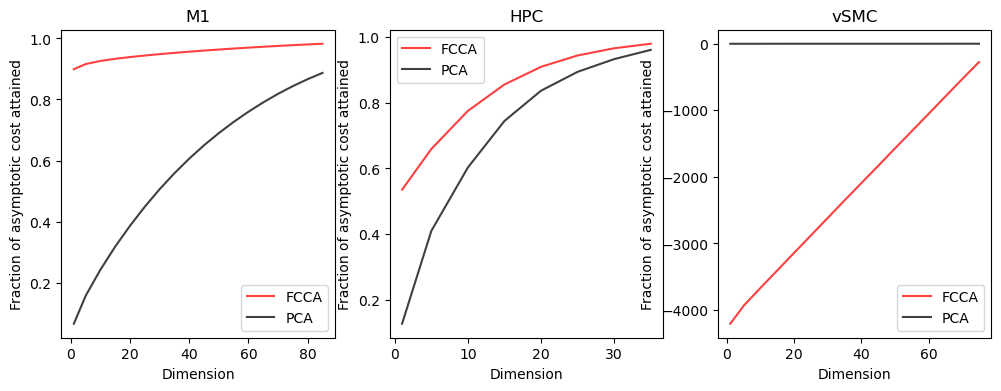

In [80]:
# Plot
fcca_score_normalized = np.divide(fcca_scores,fcca_ambient)
fcca_score_normalizedp = np.divide(fcca_scoresp,fcca_ambientp)
fcca_score_normalizedc = np.divide(fcca_scoresc,fcca_ambientc)


fig, ax = plt.subplots(1, 3, figsize=(12, 4))
dimvals = np.unique(sabes_df['dim'].values)
ax[0].plot(dimvals,1 - np.abs(1 - np.mean(fcca_score_normalized, axis=-1)), 'r', alpha=0.75)
ax[0].plot(dimvals, 1 -np.abs(1 - np.mean(pca_scores, axis=-1)), 'k', alpha=0.75)
ax[0].set_xlabel('Dimension')
ax[0].set_ylabel('Fraction of asymptotic cost attained')
ax[0].legend(['FCCA', 'PCA'])


dimvals = np.unique(peanut_df['dim'].values)
ax[1].plot(dimvals,1 - np.abs(1 - np.mean(fcca_score_normalizedp, axis=-1)), 'r', alpha=0.75)
ax[1].plot(dimvals, 1 -np.abs(1 - np.mean(pca_scoresp, axis=-1)), 'k', alpha=0.75)
ax[1].set_xlabel('Dimension')
ax[1].set_ylabel('Fraction of asymptotic cost attained')
ax[1].legend(['FCCA', 'PCA'])

dimvals = np.unique(cv_df['dim'].values)
ax[2].plot(dimvals,1 - np.abs(1 - np.mean(fcca_score_normalizedc, axis=-1)), 'r', alpha=0.75)
ax[2].plot(dimvals, 1 -np.abs(1 - np.mean(pca_scoresc, axis=-1)), 'k', alpha=0.75)
ax[2].set_xlabel('Dimension')
ax[2].set_ylabel('Fraction of asymptotic cost attained')
ax[2].legend(['FCCA', 'PCA'])

ax[0].set_title('M1')
ax[1].set_title('HPC')
ax[2].set_title('vSMC')

fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/lqg_spectrum.pdf', bbox_inches='tight', pad_inches=0)

### Sequential subspace angles

In [ ]:
# Look at pairwise and sequential subspace angles in the original dataframes

In [7]:
dframe_indy = '/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat'
dframe_loco = '/mnt/Secondary/data/postprocessed/loco_decoding_df.dat'

print('Using dframes %s, %s' % (dframe_indy, dframe_loco))

with open(dframe_indy, 'rb') as f:
    rl = pickle.load(f)
indy_df = pd.DataFrame(rl)

with open(dframe_loco, 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files)     

Using dframes /mnt/Secondary/data/postprocessed/indy_decoding_df2.dat, /mnt/Secondary/data/postprocessed/loco_decoding_df.dat


/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
sabes_df = pd.concat([indy_df, loco_df])

In [10]:
sabes_df.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'bin_width', 'filter_fn',
       'filter_kwargs', 'boxcox', 'spike_threshold', 'dim_vals', 'n_folds',
       'data_file', 'decoder', 'decoder_args', 'decoder_obj', 'r2', 'loader',
       'loader_args', 'task_args', 'data_path', 'results_file'],
      dtype='object')

In [21]:
dimvals = np.unique(sabes_df['dim'].values)[:-1]
data_files = np.unique(sabes_df['data_file'].values)
ssa_df = []

ssa1_mean = np.zeros((len(data_files), len(dimvals), 5))
ssa1_min = np.zeros((len(data_files), len(dimvals), 5))
ssa1_max = np.zeros((len(data_files), len(dimvals), 5))

ssa2_mean = np.zeros((len(data_files), len(dimvals), 5))
ssa2_min = np.zeros((len(data_files), len(dimvals), 5))
ssa2_max = np.zeros((len(data_files), len(dimvals), 5))

# Reference of what PCA looks like
ssa3_mean = np.zeros((len(data_files), len(dimvals), 5))
ssa3_min = np.zeros((len(data_files), len(dimvals), 5))
ssa3_max = np.zeros((len(data_files), len(dimvals), 5))

for i, data_file in enumerate(data_files):
    for j, dim in enumerate(dimvals):
        for f in range(5):
            dfd1_fc = apply_df_filters(sabes_df, dim=dim, data_file=data_file, fold_idx=f, dimreduc_method='LQGCA')
            dfd1_pc = apply_df_filters(sabes_df, dim=dim, data_file=data_file, fold_idx=f, dimreduc_method='PCA')

            assert(dfd1_fc.shape[0] == 1)
            assert(dfd1_pc.shape[0] == 1)

            dfd2 = apply_df_filters(sabes_df, dim=dim + 1, data_file=data_file, fold_idx=f, dimreduc_method='LQGCA')
            assert(dfd2.shape[0] == 1)

            ssa1 = scipy.linalg.subspace_angles(dfd1_fc.iloc[0]['coef'], dfd1_pc.iloc[0]['coef'][:, 0:dim])
            ssa2 = scipy.linalg.subspace_angles(dfd1_fc.iloc[0]['coef'], dfd2.iloc[0]['coef'])

            dfd2 = apply_df_filters(sabes_df, dim=dim + 1, data_file=data_file, fold_idx=f, dimreduc_method='PCA')
            assert(dfd2.shape[0] == 1)
            ssa3 = scipy.linalg.subspace_angles(dfd1_pc.iloc[0]['coef'][:, 0:dim], dfd2.iloc[0]['coef'][:, 0:dim])

            r = {}
            r['data_file'] = data_file
            r['dim'] = dim
            r['fold'] = f
            r['ssa1'] = ssa1
            r['ssa2'] = ssa2

            ssa1_mean[i, j, f] = np.mean(ssa1)
            ssa1_min[i, j, f] = np.min(ssa1)
            ssa1_max[i, j, f] = np.max(ssa1)

            ssa2_mean[i, j, f] = np.mean(ssa2[0:dim])
            ssa2_min[i, j, f] = np.min(ssa2)
            ssa2_max[i, j, f] = np.max(ssa2)

            ssa3_mean[i, j, f] = np.mean(ssa3[0:dim])
            ssa3_min[i, j, f] = np.min(ssa3)
            ssa3_max[i, j, f] = np.max(ssa3)


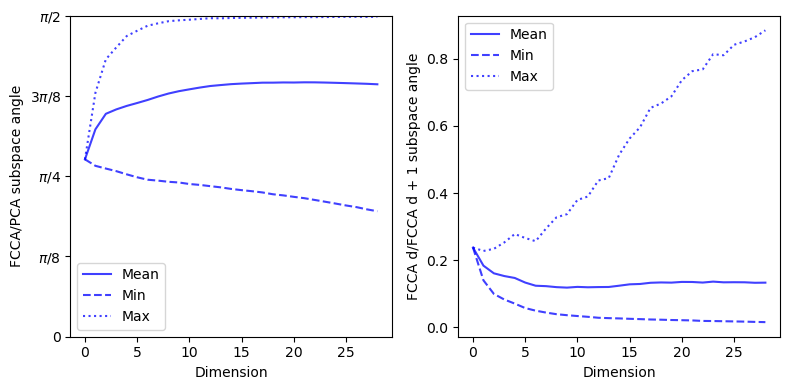

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(np.mean(np.mean(ssa1_mean, axis=0), axis=-1), color='b', alpha=0.75, linestyle='-')
ax[0].plot(np.mean(np.mean(ssa1_min, axis=0), axis=-1), color='b', alpha=0.75, linestyle='--')
ax[0].plot(np.mean(np.mean(ssa1_max, axis=0), axis=-1), color='b', alpha=0.75, linestyle=':')

ax[1].plot(np.mean(np.mean(ssa2_mean, axis=0), axis=-1), color='b', alpha=0.75, linestyle='-')
ax[1].plot(np.mean(np.mean(ssa2_min, axis=0), axis=-1), color='b', alpha=0.75, linestyle='--')
ax[1].plot(np.mean(np.mean(ssa2_max, axis=0), axis=-1), color='b', alpha=0.75, linestyle=':')

ax[0].set_ylim([0, np.pi/2])
ax[0].set_yticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax[0].set_yticklabels(['0', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])

ax[0].set_ylabel('FCCA/PCA subspace angle')
ax[0].set_xlabel('Dimension')
ax[0].legend(['Mean', 'Min', 'Max'])

ax[1].set_ylabel('FCCA d/FCCA d + 1 subspace angle')
ax[1].set_xlabel('Dimension')
ax[1].legend(['Mean', 'Min', 'Max'])

# ax[1].plot(np.mean(np.mean(ssa3_mean, axis=0), axis=-1))
# ax[1].plot(np.mean(np.mean(ssa3_min, axis=0), axis=-1))
# ax[1].plot(np.mean(np.mean(ssa3_max, axis=0), axis=-1))
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/ssa_vdim.pdf', bbox_inches='tight', pad_inches=0)